# **Downloading dataset**

In [0]:
!wget http://memorability.csail.mit.edu/lamem.tar.gz
!tar -xf /content/lamem.tar.gz

--2019-12-15 01:47:28--  http://memorability.csail.mit.edu/lamem.tar.gz
Resolving memorability.csail.mit.edu (memorability.csail.mit.edu)... 128.30.195.49
Connecting to memorability.csail.mit.edu (memorability.csail.mit.edu)|128.30.195.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2708368436 (2.5G) [application/x-gzip]
Saving to: ‘lamem.tar.gz’

lamem.tar.gz        100%[===================>]   2.52G  39.6MB/s    in 67s     

2019-12-15 01:48:35 (38.6 MB/s) - ‘lamem.tar.gz’ saved [2708368436/2708368436]



In [0]:
#total image in the folder
ls /content/lamem/images -1 | wc -l

58741


In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Necessary imports**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io,transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
import copy
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Exploring the dataset**

In [0]:
columns={'name' : 'X' ,'score':'y'}
dataset = pd.read_csv("/content/drive/My Drive/image memorability/dataset/saved_file.csv")
dataset.rename(columns=columns,inplace=True)

In [0]:
dataset.head()

X         y
0  00051110.jpg  0.675000
1  00016503.jpg  0.729167
2  00035805.jpg  0.930233
3  00009320.jpg  0.725000
4  00016469.jpg  0.825000

In [0]:
len(dataset)

58741

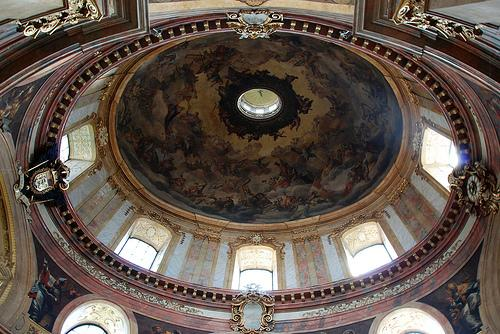

In [0]:
from IPython.display import Image
Image(filename="/content/lamem/images/00051110.jpg")

In [0]:
#train validation split
from sklearn.model_selection import train_test_split
dataset_train,dataset_validation =train_test_split(dataset,test_size=0.2,random_state=90)

In [0]:
# #save it for future use
# dataset_train.to_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv",index=False)
# dataset_validation.to_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv",index=False)

In [0]:
dataset_train = pd.read_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv")
dataset_validation = pd.read_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv")

In [0]:
dataset_train

X         y
0      00021659.jpg  0.761905
1      00015899.jpg  0.864865
2      00052591.jpg  0.795455
3      00057855.jpg  0.800000
4      00036261.jpg  0.725000
...             ...       ...
46987  00026326.jpg  0.666667
46988  00034462.jpg  0.522727
46989  00049385.jpg  0.780488
46990  00020479.jpg  0.916667
46991  00017768.jpg  0.605263

[46992 rows x 2 columns]

In [0]:
dataset_train=pd.read_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv")
dataset_validation = pd.read_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv")

In [0]:
dataset_train

X         y
0      00021659.jpg  0.761905
1      00015899.jpg  0.864865
2      00052591.jpg  0.795455
3      00057855.jpg  0.800000
4      00036261.jpg  0.725000
...             ...       ...
46987  00026326.jpg  0.666667
46988  00034462.jpg  0.522727
46989  00049385.jpg  0.780488
46990  00020479.jpg  0.916667
46991  00017768.jpg  0.605263

[46992 rows x 2 columns]

In [0]:
len(dataset_train),len(dataset_validation)

(46992, 11749)

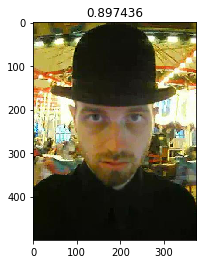

In [0]:
def show_sample_from_dataset(i=0):
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))
  image_path=os.path.join("/content/lamem/images/"+str(dataset_train.iloc[i]["X"]))
  mem_value = os.path.join(str(dataset_train.iloc[i]["y"]))
  show_image(io.imread(image_path),mem_value)
show_sample_from_dataset(7000)

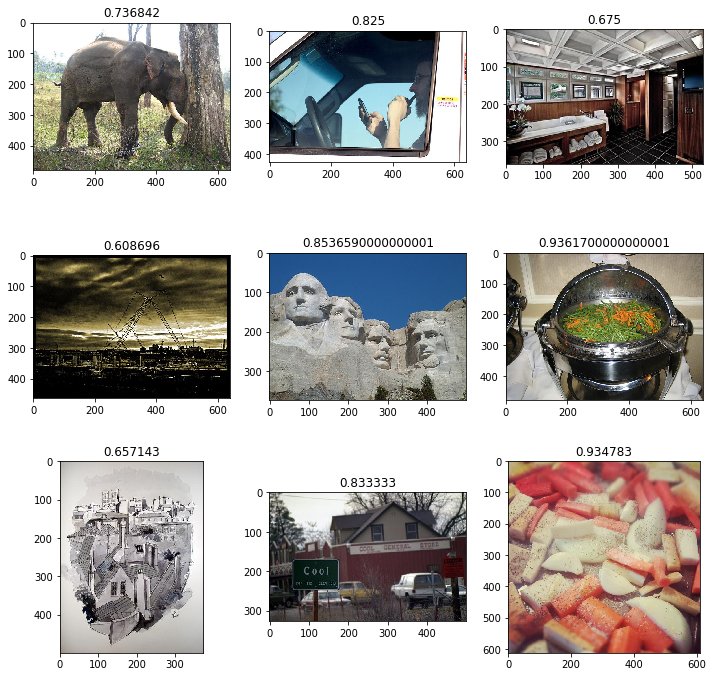

In [0]:

def show_grid(n_row,n_col):
  i=900
  _ ,fig = plt.subplots(n_row, n_col, figsize=(12,12))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("/content/lamem/images/"+str(dataset_train.iloc[i]["X"]))
    mem_value = os.path.join(str(dataset_train.iloc[i]["y"]))
    f.imshow(io.imread(image_path))
    f.title.set_text(str(mem_value))
#     f.title(str(aseth_value))
    i=i+1
show_grid(3,3)

# **Statistics**

In [0]:
dataset_train["y"].describe()

count    46992.000000
mean         0.755873
std          0.123970
min          0.200000
25%          0.675676
50%          0.770833
75%          0.848485
max          1.000000
Name: y, dtype: float64

In [0]:

dataset_validation["y"].describe()

count    11749.000000
mean         0.756625
std          0.123198
min          0.200000
25%          0.676471
50%          0.771429
75%          0.848485
max          1.000000
Name: y, dtype: float64

## **Data preprocessing**

In [0]:

class LaMemDataset(Dataset):
  '''largescale image memorablity  dataset'''
  def __init__(self,dataframe,root_dir,transform=None):
    """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = dataframe
#     self.data.rename(columns=columns,inplace=True)
#     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
   
    if torch.is_tensor(idx):
      idx = idx.tolist()
   
    image_name =  os.path.join(self.root_dir,self.data.iloc[idx,0])
    image = io.imread(image_name)
    mem_val = self.data.iloc[idx,1]
#     return_sample={}
    return_sample = {
          'image':image,
          'memorability_score':mem_val 
    }
    if self.transform:
      return_sample = self.transform(return_sample)

     
    return return_sample

In [0]:

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image,mem_val = sample['image'], sample["memorability_score"]
        
        # h, w = image.shape[:2]
        
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        #     new_h, new_w = self.output_size

        # new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size,self.output_size,3))
        return {'image': img, 'memorability_score': mem_val}

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image, mem_val = sample['image'], sample['memorability_score']
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
      
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}

In [0]:
class Normalize(object):
  def __init__(self,mean,std):
    self.mean=mean
    self.std=std
  def __call__(self,sample):
    image, mem_val = sample["image"], sample["memorability_score"]
    normalized=  (image -self.mean) / self.std
    return {
        "image":normalized,
        "memorability_score" : mem_val
    }

In [0]:

transformed_dataset_train = LaMemDataset(dataset_train,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

transformed_dataset_val= LaMemDataset(dataset_validation,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

In [0]:

train_dataloader=DataLoader(transformed_dataset_train,batch_size=32,shuffle=True)
validation_dataloader=DataLoader(transformed_dataset_val,batch_size=32,shuffle=True)

In [0]:
dataloaders={
    "train":train_dataloader,
    "val":validation_dataloader
}

In [0]:
dataset_sizes ={
    "train":len(dataset_train),
    "val":len(dataset_validation)
}

In [0]:
#model creation

# **Model creation**




# **ResNet50**


In [0]:
model_50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.8MB/s]


In [0]:
# model_50 = models.resnet50(pretrained=True)
model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

# model_50 = model_50.double()

1


In [0]:

model_50 = model_50.double()
resmodel_50=copy.deepcopy(model_50)

In [0]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr = 0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
np.inf>90

True

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history=[]
    orignal_model=None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):
          
                inputs=batched_data["image"]
                inputs = inputs.to(device)
                labels=batched_data["memorability_score"]
                labels=labels.view(-1,1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ",loss.item())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
              running_loss_history.append(epoch_loss)
            else:
              val_running_loss_history.append(epoch_loss)
            

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            

            # deep copy the model
            if phase == 'val' and epoch_loss < low_loss:
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print("saving best model....")
                torch.save(best_model_wts,"/content/drive/My Drive/image memorability/saved models/ResNet50_15-12-19.pth")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    original_model =copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model,original_model,running_loss_history,val_running_loss_history

In [0]:
best_model_50,model_50 = train_model(model_50,criterion,optimizer,exp_lr_scheduler)


  0%|          | 0/1469 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 1/1469 [00:02<54:50,  2.24s/it]

  batch loss:     0.481622269492597


  0%|          | 2/1469 [00:05<59:43,  2.44s/it]

  batch loss:     0.3581995511275946


  0%|          | 3/1469 [00:07<56:40,  2.32s/it]

  batch loss:     0.2365170072641058


  0%|          | 4/1469 [00:09<54:08,  2.22s/it]

  batch loss:     0.23592186283000777


  0%|          | 5/1469 [00:11<53:38,  2.20s/it]

  batch loss:     0.16590269698665455


  0%|          | 6/1469 [00:13<52:16,  2.14s/it]

  batch loss:     0.12255218259612752


  0%|          | 7/1469 [00:15<52:37,  2.16s/it]

  batch loss:     0.06387280418811059


  1%|          | 8/1469 [00:17<51:00,  2.10s/it]

  batch loss:     0.07123840183322294


  1%|          | 9/1469 [00:19<51:00,  2.10s/it]

  batch loss:     0.07094930107617178


  1%|          | 10/1469 [00:21<50:29,  2.08s/it]

  batch loss:     0.0923133754495338


  1%|          | 11/1469 [00:23<50:41,  2.09s/it]

  batch loss:     0.12508765660300475


  1%|          | 12/1469 [00:26<52:39,  2.17s/it]

  batch loss:     0.159041965335206


  1%|          | 13/1469 [00:27<50:43,  2.09s/it]

  batch loss:     0.15348245670888938


  1%|          | 14/1469 [00:30<50:41,  2.09s/it]

  batch loss:     0.11460302961111168


  1%|          | 15/1469 [00:33<56:44,  2.34s/it]

  batch loss:     0.10829945365600577


  1%|          | 16/1469 [00:34<53:24,  2.21s/it]

  batch loss:     0.13397171204939573


  1%|          | 17/1469 [00:36<51:47,  2.14s/it]

  batch loss:     0.12586871961478244


  1%|          | 18/1469 [00:40<1:04:56,  2.69s/it]

  batch loss:     0.11016620318852237


  1%|▏         | 19/1469 [00:43<1:01:19,  2.54s/it]

  batch loss:     0.16567441071873024


  1%|▏         | 20/1469 [00:45<57:54,  2.40s/it]  

  batch loss:     0.1060812819848552


  1%|▏         | 21/1469 [00:47<57:10,  2.37s/it]

  batch loss:     0.07069466499652387


  1%|▏         | 22/1469 [00:49<53:45,  2.23s/it]

  batch loss:     0.09489121290495767


  2%|▏         | 23/1469 [00:51<51:53,  2.15s/it]

  batch loss:     0.14859287492384798


  2%|▏         | 24/1469 [00:53<50:40,  2.10s/it]

  batch loss:     0.09300411321096717


  2%|▏         | 25/1469 [00:55<50:18,  2.09s/it]

  batch loss:     0.04717989924189339


  2%|▏         | 26/1469 [00:57<49:04,  2.04s/it]

  batch loss:     0.08340266649955255


  2%|▏         | 27/1469 [00:59<49:50,  2.07s/it]

  batch loss:     0.10246980849751462


  2%|▏         | 28/1469 [01:01<50:53,  2.12s/it]

  batch loss:     0.0634128752360891


  2%|▏         | 29/1469 [01:04<53:23,  2.22s/it]

  batch loss:     0.05578552217334535


  2%|▏         | 30/1469 [01:06<51:47,  2.16s/it]

  batch loss:     0.08831671217839834


  2%|▏         | 31/1469 [01:08<50:34,  2.11s/it]

  batch loss:     0.06983888520192441


  2%|▏         | 32/1469 [01:11<1:03:02,  2.63s/it]

  batch loss:     0.07690378802328068


  2%|▏         | 33/1469 [01:14<1:01:41,  2.58s/it]

  batch loss:     0.11130423748023478


  2%|▏         | 34/1469 [01:16<1:00:06,  2.51s/it]

  batch loss:     0.10028350622664124


  2%|▏         | 35/1469 [01:18<56:56,  2.38s/it]  

  batch loss:     0.07881946353805161


  2%|▏         | 36/1469 [01:22<1:05:03,  2.72s/it]

  batch loss:     0.05536911164944669


  3%|▎         | 37/1469 [01:27<1:23:17,  3.49s/it]

  batch loss:     0.07915202584946643


  3%|▎         | 38/1469 [01:29<1:12:26,  3.04s/it]

  batch loss:     0.06579759940192752


  3%|▎         | 39/1469 [01:34<1:23:57,  3.52s/it]

  batch loss:     0.08184784025596403


  3%|▎         | 40/1469 [01:36<1:13:04,  3.07s/it]

  batch loss:     0.052016260991416735


  3%|▎         | 41/1469 [01:38<1:09:02,  2.90s/it]

  batch loss:     0.07573312604818085


  3%|▎         | 42/1469 [01:40<1:03:46,  2.68s/it]

  batch loss:     0.06326707696788318


  3%|▎         | 43/1469 [01:43<59:28,  2.50s/it]  

  batch loss:     0.04509446577541836


  3%|▎         | 44/1469 [01:45<56:53,  2.40s/it]

  batch loss:     0.08715507388538528


  3%|▎         | 45/1469 [01:47<55:08,  2.32s/it]

  batch loss:     0.05426897200536697


  3%|▎         | 46/1469 [01:49<52:34,  2.22s/it]

  batch loss:     0.05895805971430591


  3%|▎         | 47/1469 [01:51<50:04,  2.11s/it]

  batch loss:     0.08894732351435147


  3%|▎         | 48/1469 [01:53<49:18,  2.08s/it]

  batch loss:     0.06866705909638933


  3%|▎         | 49/1469 [01:55<49:14,  2.08s/it]

  batch loss:     0.05626864049738102


  3%|▎         | 50/1469 [01:57<50:31,  2.14s/it]

  batch loss:     0.0452267566067934


  3%|▎         | 51/1469 [01:59<50:52,  2.15s/it]

  batch loss:     0.05823552117657656


  4%|▎         | 52/1469 [02:01<50:41,  2.15s/it]

  batch loss:     0.04842533162314065


  4%|▎         | 53/1469 [02:05<1:03:11,  2.68s/it]

  batch loss:     0.0739196491253425


  4%|▎         | 54/1469 [02:07<57:53,  2.45s/it]  

  batch loss:     0.05101315823067109


  4%|▎         | 55/1469 [02:11<1:04:38,  2.74s/it]

  batch loss:     0.06189438665892521


  4%|▍         | 56/1469 [02:13<58:49,  2.50s/it]  

  batch loss:     0.07431525069466596


  4%|▍         | 57/1469 [02:15<58:13,  2.47s/it]

  batch loss:     0.08098546316734281


  4%|▍         | 58/1469 [02:17<54:41,  2.33s/it]

  batch loss:     0.06204687173449549


  4%|▍         | 59/1469 [02:19<52:48,  2.25s/it]

  batch loss:     0.053283907940030906


  4%|▍         | 60/1469 [02:22<56:54,  2.42s/it]

  batch loss:     0.05904549033249433


  4%|▍         | 61/1469 [02:25<1:03:02,  2.69s/it]

  batch loss:     0.044161440001387615


  4%|▍         | 62/1469 [02:28<1:02:11,  2.65s/it]

  batch loss:     0.08121520358215609


  4%|▍         | 63/1469 [02:30<57:20,  2.45s/it]  

  batch loss:     0.04134368283775026


  4%|▍         | 64/1469 [02:32<53:40,  2.29s/it]

  batch loss:     0.06952785363662858


  4%|▍         | 65/1469 [02:34<51:24,  2.20s/it]

  batch loss:     0.03922755682447507


  4%|▍         | 66/1469 [02:36<49:37,  2.12s/it]

  batch loss:     0.07090760664941438


  5%|▍         | 67/1469 [02:38<49:45,  2.13s/it]

  batch loss:     0.05705054492711778


  5%|▍         | 68/1469 [02:40<49:02,  2.10s/it]

  batch loss:     0.06821396187923026


  5%|▍         | 69/1469 [02:42<47:32,  2.04s/it]

  batch loss:     0.05863680410212537


  5%|▍         | 70/1469 [02:44<46:42,  2.00s/it]

  batch loss:     0.05079991377596721


  5%|▍         | 71/1469 [02:45<46:17,  1.99s/it]

  batch loss:     0.062366724718446676


  5%|▍         | 72/1469 [02:48<46:48,  2.01s/it]

  batch loss:     0.05494753239488166


  5%|▍         | 73/1469 [02:50<49:26,  2.13s/it]

  batch loss:     0.0640120931804049


  5%|▌         | 74/1469 [02:52<50:16,  2.16s/it]

  batch loss:     0.03831153320567679


  5%|▌         | 75/1469 [02:54<49:55,  2.15s/it]

  batch loss:     0.04722015791633352


  5%|▌         | 76/1469 [02:56<48:26,  2.09s/it]

  batch loss:     0.04663488771593141


  5%|▌         | 77/1469 [02:59<53:47,  2.32s/it]

  batch loss:     0.04632148067760366


  5%|▌         | 78/1469 [03:01<53:02,  2.29s/it]

  batch loss:     0.057878769247569184


  5%|▌         | 79/1469 [03:03<51:40,  2.23s/it]

  batch loss:     0.05207282670840281


  5%|▌         | 80/1469 [03:07<1:01:28,  2.66s/it]

  batch loss:     0.039925127403625596


  6%|▌         | 81/1469 [03:09<56:27,  2.44s/it]  

  batch loss:     0.05553376932088188


  6%|▌         | 82/1469 [03:11<54:00,  2.34s/it]

  batch loss:     0.05020327730630411


  6%|▌         | 83/1469 [03:14<1:01:06,  2.65s/it]

  batch loss:     0.07381461002369907


  6%|▌         | 84/1469 [03:16<56:32,  2.45s/it]  

  batch loss:     0.0869915256698455


  6%|▌         | 85/1469 [03:18<53:13,  2.31s/it]

  batch loss:     0.04591639020766111


  6%|▌         | 86/1469 [03:20<50:23,  2.19s/it]

  batch loss:     0.049945714373326


  6%|▌         | 87/1469 [03:22<49:13,  2.14s/it]

  batch loss:     0.07100539492512561


  6%|▌         | 88/1469 [03:24<47:28,  2.06s/it]

  batch loss:     0.0930471060115082


  6%|▌         | 89/1469 [03:26<47:47,  2.08s/it]

  batch loss:     0.03795185092906843


  6%|▌         | 90/1469 [03:28<46:50,  2.04s/it]

  batch loss:     0.04009082631033181


  6%|▌         | 91/1469 [03:30<46:54,  2.04s/it]

  batch loss:     0.041031135947209516


  6%|▋         | 92/1469 [03:33<47:37,  2.07s/it]

  batch loss:     0.05783402936351595


  6%|▋         | 93/1469 [03:34<46:51,  2.04s/it]

  batch loss:     0.040623829365746364


  6%|▋         | 94/1469 [03:37<46:53,  2.05s/it]

  batch loss:     0.03700390032043654


  6%|▋         | 95/1469 [03:39<46:26,  2.03s/it]

  batch loss:     0.05726454035033779


  7%|▋         | 96/1469 [03:41<49:45,  2.17s/it]

  batch loss:     0.06009936985615926


  7%|▋         | 97/1469 [03:43<50:52,  2.22s/it]

  batch loss:     0.04435719039267523


  7%|▋         | 98/1469 [03:45<48:58,  2.14s/it]

  batch loss:     0.08288775457435624


  7%|▋         | 99/1469 [03:48<49:08,  2.15s/it]

  batch loss:     0.03540218027504356


  7%|▋         | 100/1469 [03:50<50:45,  2.22s/it]

  batch loss:     0.05415221600378284


  7%|▋         | 101/1469 [03:52<49:14,  2.16s/it]

  batch loss:     0.038054187396653096


  7%|▋         | 102/1469 [03:54<49:13,  2.16s/it]

  batch loss:     0.050339051325100984


  7%|▋         | 103/1469 [03:56<50:52,  2.23s/it]

  batch loss:     0.03171389931101697


  7%|▋         | 104/1469 [03:59<53:26,  2.35s/it]

  batch loss:     0.05330246365721729


  7%|▋         | 105/1469 [04:01<51:05,  2.25s/it]

  batch loss:     0.05334023605112383


  7%|▋         | 106/1469 [04:03<49:08,  2.16s/it]

  batch loss:     0.04902402779966136


  7%|▋         | 107/1469 [04:06<52:17,  2.30s/it]

  batch loss:     0.06011290512921714


  7%|▋         | 108/1469 [04:08<52:49,  2.33s/it]

  batch loss:     0.035546942078975415


  7%|▋         | 109/1469 [04:12<1:03:49,  2.82s/it]

  batch loss:     0.06497309608992556


  7%|▋         | 110/1469 [04:14<58:07,  2.57s/it]  

  batch loss:     0.0598249590306564


  8%|▊         | 111/1469 [04:16<54:19,  2.40s/it]

  batch loss:     0.042321763844848856


  8%|▊         | 112/1469 [04:19<56:14,  2.49s/it]

  batch loss:     0.02408369379519832


  8%|▊         | 113/1469 [04:21<53:16,  2.36s/it]

  batch loss:     0.04816090476699007


  8%|▊         | 114/1469 [04:23<50:14,  2.22s/it]

  batch loss:     0.05060567963243465


  8%|▊         | 115/1469 [04:25<48:39,  2.16s/it]

  batch loss:     0.05032153698545537


  8%|▊         | 116/1469 [04:27<47:37,  2.11s/it]

  batch loss:     0.04488691302324467


  8%|▊         | 117/1469 [04:29<49:31,  2.20s/it]

  batch loss:     0.05120758334051741


  8%|▊         | 118/1469 [04:31<49:14,  2.19s/it]

  batch loss:     0.05124340079984706


  8%|▊         | 119/1469 [04:33<48:04,  2.14s/it]

  batch loss:     0.06716028658982345


  8%|▊         | 120/1469 [04:36<48:50,  2.17s/it]

  batch loss:     0.07345902389437595


  8%|▊         | 121/1469 [04:37<47:00,  2.09s/it]

  batch loss:     0.03703230017643661


  8%|▊         | 122/1469 [04:40<52:25,  2.34s/it]

  batch loss:     0.043814199056028055


  8%|▊         | 123/1469 [04:43<56:25,  2.52s/it]

  batch loss:     0.05490339253352393


  8%|▊         | 124/1469 [04:46<54:35,  2.44s/it]

  batch loss:     0.034416948755609605


  9%|▊         | 125/1469 [04:48<51:31,  2.30s/it]

  batch loss:     0.05102851240334935


  9%|▊         | 126/1469 [04:50<50:57,  2.28s/it]

  batch loss:     0.05153838930060248


  9%|▊         | 127/1469 [04:52<49:06,  2.20s/it]

  batch loss:     0.02929616806932097


  9%|▊         | 128/1469 [04:54<47:22,  2.12s/it]

  batch loss:     0.04312137129893549


  9%|▉         | 129/1469 [04:56<46:17,  2.07s/it]

  batch loss:     0.04703150668215657


  9%|▉         | 130/1469 [04:58<47:25,  2.12s/it]

  batch loss:     0.03530019659847868


  9%|▉         | 131/1469 [05:00<47:41,  2.14s/it]

  batch loss:     0.03246946475929797


  9%|▉         | 132/1469 [05:02<46:37,  2.09s/it]

  batch loss:     0.056400356554241825


  9%|▉         | 133/1469 [05:04<48:02,  2.16s/it]

  batch loss:     0.06406049616995779


  9%|▉         | 134/1469 [05:06<46:26,  2.09s/it]

  batch loss:     0.036967868993063


  9%|▉         | 135/1469 [05:08<45:33,  2.05s/it]

  batch loss:     0.04851027780459663


  9%|▉         | 136/1469 [05:10<45:20,  2.04s/it]

  batch loss:     0.05646542175589668


  9%|▉         | 137/1469 [05:12<45:09,  2.03s/it]

  batch loss:     0.02314855759031067


  9%|▉         | 138/1469 [05:14<45:51,  2.07s/it]

  batch loss:     0.05787136990825973


  9%|▉         | 139/1469 [05:17<46:34,  2.10s/it]

  batch loss:     0.02574211870852904


 10%|▉         | 140/1469 [05:19<46:23,  2.09s/it]

  batch loss:     0.044727985884494476


 10%|▉         | 141/1469 [05:21<44:56,  2.03s/it]

  batch loss:     0.04591548931706419


 10%|▉         | 142/1469 [05:23<47:55,  2.17s/it]

  batch loss:     0.038782949957292395


 10%|▉         | 143/1469 [05:25<46:33,  2.11s/it]

  batch loss:     0.033658936263792155


 10%|▉         | 144/1469 [05:27<45:39,  2.07s/it]

  batch loss:     0.036528970459933606


 10%|▉         | 145/1469 [05:29<46:28,  2.11s/it]

  batch loss:     0.03276274375456384


 10%|▉         | 146/1469 [05:31<44:54,  2.04s/it]

  batch loss:     0.04294575422706102


 10%|█         | 147/1469 [05:33<44:21,  2.01s/it]

  batch loss:     0.047979789546207074


 10%|█         | 148/1469 [05:36<49:56,  2.27s/it]

  batch loss:     0.02970660465916903


 10%|█         | 149/1469 [05:38<48:27,  2.20s/it]

  batch loss:     0.035494870675898155


 10%|█         | 150/1469 [05:40<48:01,  2.18s/it]

  batch loss:     0.027112357818461774


 10%|█         | 151/1469 [05:42<47:13,  2.15s/it]

  batch loss:     0.0471907544998607


 10%|█         | 152/1469 [05:44<45:17,  2.06s/it]

  batch loss:     0.04506029233175825


 10%|█         | 153/1469 [05:46<44:47,  2.04s/it]

  batch loss:     0.03564069064942734


 10%|█         | 154/1469 [05:48<45:47,  2.09s/it]

  batch loss:     0.051673006836087304


 11%|█         | 155/1469 [05:51<53:02,  2.42s/it]

  batch loss:     0.056975599909528246


 11%|█         | 156/1469 [05:54<57:16,  2.62s/it]

  batch loss:     0.040054600822276014


 11%|█         | 157/1469 [05:56<53:17,  2.44s/it]

  batch loss:     0.029569937250464196


 11%|█         | 158/1469 [05:58<50:15,  2.30s/it]

  batch loss:     0.03425972519665282


 11%|█         | 159/1469 [06:00<47:48,  2.19s/it]

  batch loss:     0.036660914834627086


 11%|█         | 160/1469 [06:03<50:17,  2.30s/it]

  batch loss:     0.03323668948522068


 11%|█         | 161/1469 [06:05<48:30,  2.23s/it]

  batch loss:     0.04395797377955328


 11%|█         | 162/1469 [06:08<55:20,  2.54s/it]

  batch loss:     0.04460653231105903


 11%|█         | 163/1469 [06:10<52:18,  2.40s/it]

  batch loss:     0.03071678307310536


 11%|█         | 164/1469 [06:13<50:29,  2.32s/it]

  batch loss:     0.03199761093639652


 11%|█         | 165/1469 [06:15<49:41,  2.29s/it]

  batch loss:     0.03716622995055114


 11%|█▏        | 166/1469 [06:17<51:58,  2.39s/it]

  batch loss:     0.02697870785078488


 11%|█▏        | 167/1469 [06:19<49:00,  2.26s/it]

  batch loss:     0.0183132153715243


 11%|█▏        | 168/1469 [06:21<46:52,  2.16s/it]

  batch loss:     0.03322327368354499


 12%|█▏        | 169/1469 [06:23<46:16,  2.14s/it]

  batch loss:     0.045379970473065155


 12%|█▏        | 170/1469 [06:25<45:05,  2.08s/it]

  batch loss:     0.03847753423475994


 12%|█▏        | 171/1469 [06:28<47:39,  2.20s/it]

  batch loss:     0.04492115251184392


 12%|█▏        | 172/1469 [06:30<46:21,  2.14s/it]

  batch loss:     0.02617332660064573


 12%|█▏        | 173/1469 [06:32<45:49,  2.12s/it]

  batch loss:     0.04018171031283452


 12%|█▏        | 174/1469 [06:34<45:30,  2.11s/it]

  batch loss:     0.052957163052434926


 12%|█▏        | 175/1469 [06:36<46:07,  2.14s/it]

  batch loss:     0.04692623645529176


 12%|█▏        | 176/1469 [06:38<45:09,  2.10s/it]

  batch loss:     0.02364483084382022


 12%|█▏        | 177/1469 [06:40<43:57,  2.04s/it]

  batch loss:     0.028028083281492817


 12%|█▏        | 178/1469 [06:42<44:35,  2.07s/it]

  batch loss:     0.030671569490079945


 12%|█▏        | 179/1469 [06:45<49:57,  2.32s/it]

  batch loss:     0.039450834092826126


 12%|█▏        | 180/1469 [06:48<52:25,  2.44s/it]

  batch loss:     0.030213717936596537


 12%|█▏        | 181/1469 [06:50<49:20,  2.30s/it]

  batch loss:     0.035734445560105105


 12%|█▏        | 182/1469 [06:52<47:07,  2.20s/it]

  batch loss:     0.02041009325606662


 12%|█▏        | 183/1469 [06:55<55:51,  2.61s/it]

  batch loss:     0.025529603647020456


 13%|█▎        | 184/1469 [06:58<53:29,  2.50s/it]

  batch loss:     0.03587685240579798


 13%|█▎        | 185/1469 [07:00<54:37,  2.55s/it]

  batch loss:     0.03348647733753804


 13%|█▎        | 186/1469 [07:02<52:48,  2.47s/it]

  batch loss:     0.041678375661961684


 13%|█▎        | 187/1469 [07:08<1:10:51,  3.32s/it]

  batch loss:     0.04224372931841186


 13%|█▎        | 188/1469 [07:10<1:02:25,  2.92s/it]

  batch loss:     0.05693650087108187


 13%|█▎        | 189/1469 [07:13<1:04:53,  3.04s/it]

  batch loss:     0.0428300477977205


 13%|█▎        | 190/1469 [07:15<58:14,  2.73s/it]  

  batch loss:     0.04129302817540694


 13%|█▎        | 191/1469 [07:17<52:50,  2.48s/it]

  batch loss:     0.030846749779658338


 13%|█▎        | 192/1469 [07:19<49:58,  2.35s/it]

  batch loss:     0.029920885207413928


 13%|█▎        | 193/1469 [07:21<49:50,  2.34s/it]

  batch loss:     0.03239440834159331


 13%|█▎        | 194/1469 [07:24<48:50,  2.30s/it]

  batch loss:     0.04975450918599118


 13%|█▎        | 195/1469 [07:26<49:05,  2.31s/it]

  batch loss:     0.021351639519236534


 13%|█▎        | 196/1469 [07:28<48:21,  2.28s/it]

  batch loss:     0.03927307727938446


 13%|█▎        | 197/1469 [07:30<47:21,  2.23s/it]

  batch loss:     0.040385821790307


 13%|█▎        | 198/1469 [07:34<55:21,  2.61s/it]

  batch loss:     0.021672771577217514


 14%|█▎        | 199/1469 [07:38<1:03:27,  3.00s/it]

  batch loss:     0.04095407083163967


 14%|█▎        | 200/1469 [07:40<57:40,  2.73s/it]  

  batch loss:     0.04132200036004862


 14%|█▎        | 201/1469 [07:42<52:46,  2.50s/it]

  batch loss:     0.033096141029226325


 14%|█▍        | 202/1469 [07:45<1:00:30,  2.87s/it]

  batch loss:     0.02395039011986321


 14%|█▍        | 203/1469 [07:48<56:10,  2.66s/it]  

  batch loss:     0.04263997298350881


 14%|█▍        | 204/1469 [07:50<52:54,  2.51s/it]

  batch loss:     0.03930137520865168


 14%|█▍        | 205/1469 [07:52<50:03,  2.38s/it]

  batch loss:     0.03586709468808397


 14%|█▍        | 206/1469 [07:55<51:54,  2.47s/it]

  batch loss:     0.032656129648953564


 14%|█▍        | 207/1469 [07:56<48:14,  2.29s/it]

  batch loss:     0.03540238454135755


 14%|█▍        | 208/1469 [07:58<46:30,  2.21s/it]

  batch loss:     0.03860880127323081


 14%|█▍        | 209/1469 [08:01<48:48,  2.32s/it]

  batch loss:     0.03623371541041481


 14%|█▍        | 210/1469 [08:03<48:23,  2.31s/it]

  batch loss:     0.04425494100771571


 14%|█▍        | 211/1469 [08:05<46:05,  2.20s/it]

  batch loss:     0.022523516283525436


 14%|█▍        | 212/1469 [08:07<44:31,  2.13s/it]

  batch loss:     0.04609878562167899


 14%|█▍        | 213/1469 [08:11<57:26,  2.74s/it]

  batch loss:     0.03637320288286281


 15%|█▍        | 214/1469 [08:14<54:57,  2.63s/it]

  batch loss:     0.0360786712270648


 15%|█▍        | 215/1469 [08:19<1:10:46,  3.39s/it]

  batch loss:     0.03650907644083527


 15%|█▍        | 216/1469 [08:21<1:01:44,  2.96s/it]

  batch loss:     0.024815358987773192


 15%|█▍        | 217/1469 [08:23<57:58,  2.78s/it]  

  batch loss:     0.031247867084070506


 15%|█▍        | 218/1469 [08:26<56:33,  2.71s/it]

  batch loss:     0.029070719216343677


 15%|█▍        | 219/1469 [08:28<52:50,  2.54s/it]

  batch loss:     0.03673784146491225


 15%|█▍        | 220/1469 [08:30<52:20,  2.51s/it]

  batch loss:     0.027570468181034504


 15%|█▌        | 221/1469 [08:33<51:42,  2.49s/it]

  batch loss:     0.033681733228280636


 15%|█▌        | 222/1469 [08:35<48:50,  2.35s/it]

  batch loss:     0.03795364509803549


 15%|█▌        | 223/1469 [08:37<47:28,  2.29s/it]

  batch loss:     0.02433932875609699


 15%|█▌        | 224/1469 [08:39<45:13,  2.18s/it]

  batch loss:     0.03779061698651495


 15%|█▌        | 225/1469 [08:41<44:06,  2.13s/it]

  batch loss:     0.04298455232589707


 15%|█▌        | 226/1469 [08:43<44:55,  2.17s/it]

  batch loss:     0.03460448196912915


 15%|█▌        | 227/1469 [08:46<50:22,  2.43s/it]

  batch loss:     0.03191120497840071


 16%|█▌        | 228/1469 [08:48<48:27,  2.34s/it]

  batch loss:     0.02730933255980228


 16%|█▌        | 229/1469 [08:50<46:11,  2.23s/it]

  batch loss:     0.040016669767236


 16%|█▌        | 230/1469 [08:53<47:07,  2.28s/it]

  batch loss:     0.025093101366535475


 16%|█▌        | 231/1469 [08:55<48:13,  2.34s/it]

  batch loss:     0.023277073044230646


 16%|█▌        | 232/1469 [08:57<45:49,  2.22s/it]

  batch loss:     0.03755594883679689


 16%|█▌        | 233/1469 [08:59<44:22,  2.15s/it]

  batch loss:     0.03473728403414795


 16%|█▌        | 234/1469 [09:02<49:53,  2.42s/it]

  batch loss:     0.0353225812291489


 16%|█▌        | 235/1469 [09:04<47:24,  2.30s/it]

  batch loss:     0.03141594875349371


 16%|█▌        | 236/1469 [09:06<45:46,  2.23s/it]

  batch loss:     0.047009031363616484


 16%|█▌        | 237/1469 [09:08<43:57,  2.14s/it]

  batch loss:     0.04206449090735101


 16%|█▌        | 238/1469 [09:10<42:53,  2.09s/it]

  batch loss:     0.023543708875851246


 16%|█▋        | 239/1469 [09:12<42:27,  2.07s/it]

  batch loss:     0.05139725727367298


 16%|█▋        | 240/1469 [09:14<43:07,  2.11s/it]

  batch loss:     0.037993082827203414


 16%|█▋        | 241/1469 [09:16<42:07,  2.06s/it]

  batch loss:     0.015498107991351541


 16%|█▋        | 242/1469 [09:18<41:43,  2.04s/it]

  batch loss:     0.04808944460760421


 17%|█▋        | 243/1469 [09:20<41:43,  2.04s/it]

  batch loss:     0.031113099243157867


 17%|█▋        | 244/1469 [09:25<56:40,  2.78s/it]

  batch loss:     0.04128276131092817


 17%|█▋        | 245/1469 [09:27<52:41,  2.58s/it]

  batch loss:     0.042472013320922625


 17%|█▋        | 246/1469 [09:29<49:17,  2.42s/it]

  batch loss:     0.03931024344766919


 17%|█▋        | 247/1469 [09:31<46:44,  2.29s/it]

  batch loss:     0.033313154240986936


 17%|█▋        | 248/1469 [09:34<50:27,  2.48s/it]

  batch loss:     0.035008678792694634


 17%|█▋        | 249/1469 [09:36<50:14,  2.47s/it]

  batch loss:     0.027892453914016416


 17%|█▋        | 250/1469 [09:38<47:09,  2.32s/it]

  batch loss:     0.03542388584434597


 17%|█▋        | 251/1469 [09:43<58:24,  2.88s/it]

  batch loss:     0.028564888167626073


 17%|█▋        | 252/1469 [09:44<52:17,  2.58s/it]

  batch loss:     0.023990007612817672


 17%|█▋        | 253/1469 [09:46<48:24,  2.39s/it]

  batch loss:     0.03200772470011259


 17%|█▋        | 254/1469 [09:49<48:08,  2.38s/it]

  batch loss:     0.03206991982267231


 17%|█▋        | 255/1469 [09:51<47:25,  2.34s/it]

  batch loss:     0.020776668183362365


 17%|█▋        | 256/1469 [09:53<46:32,  2.30s/it]

  batch loss:     0.020901161048762218


 17%|█▋        | 257/1469 [09:55<44:40,  2.21s/it]

  batch loss:     0.05338813819731561


 18%|█▊        | 258/1469 [09:57<42:53,  2.13s/it]

  batch loss:     0.029055489775284965


 18%|█▊        | 259/1469 [09:59<41:53,  2.08s/it]

  batch loss:     0.06479672512100113


 18%|█▊        | 260/1469 [10:02<44:35,  2.21s/it]

  batch loss:     0.02789720835303548


 18%|█▊        | 261/1469 [10:04<43:18,  2.15s/it]

  batch loss:     0.02947327703525787


 18%|█▊        | 262/1469 [10:06<42:03,  2.09s/it]

  batch loss:     0.03226804912178782


 18%|█▊        | 263/1469 [10:08<44:17,  2.20s/it]

  batch loss:     0.020169770857590825


 18%|█▊        | 264/1469 [10:11<47:30,  2.37s/it]

  batch loss:     0.03294055651863055


 18%|█▊        | 265/1469 [10:13<45:11,  2.25s/it]

  batch loss:     0.030580057481790636


 18%|█▊        | 266/1469 [10:15<43:50,  2.19s/it]

  batch loss:     0.023347170486075576


 18%|█▊        | 267/1469 [10:17<43:20,  2.16s/it]

  batch loss:     0.028675981193228353


 18%|█▊        | 268/1469 [10:19<44:00,  2.20s/it]

  batch loss:     0.029905594883115498


 18%|█▊        | 269/1469 [10:21<42:12,  2.11s/it]

  batch loss:     0.026752562465516792


 18%|█▊        | 270/1469 [10:23<41:15,  2.06s/it]

  batch loss:     0.03106388671746234


 18%|█▊        | 271/1469 [10:25<40:26,  2.03s/it]

  batch loss:     0.0211833317262278


 19%|█▊        | 272/1469 [10:27<39:48,  2.00s/it]

  batch loss:     0.02446302672938449


 19%|█▊        | 273/1469 [10:32<1:00:55,  3.06s/it]

  batch loss:     0.030543580506355875


 19%|█▊        | 274/1469 [10:35<55:39,  2.79s/it]  

  batch loss:     0.028034742166060812


 19%|█▊        | 275/1469 [10:37<51:35,  2.59s/it]

  batch loss:     0.021821170567500478


 19%|█▉        | 276/1469 [10:39<47:26,  2.39s/it]

  batch loss:     0.0454126223876789


 19%|█▉        | 277/1469 [10:41<45:16,  2.28s/it]

  batch loss:     0.031279404061046276


 19%|█▉        | 278/1469 [10:43<44:43,  2.25s/it]

  batch loss:     0.03133501600657095


 19%|█▉        | 279/1469 [10:47<54:46,  2.76s/it]

  batch loss:     0.02467242949362775


 19%|█▉        | 280/1469 [10:49<50:22,  2.54s/it]

  batch loss:     0.03383225929587866


 19%|█▉        | 281/1469 [10:51<48:37,  2.46s/it]

  batch loss:     0.02593980039880689


 19%|█▉        | 282/1469 [10:54<51:21,  2.60s/it]

  batch loss:     0.03228189560878664


 19%|█▉        | 283/1469 [10:57<51:28,  2.60s/it]

  batch loss:     0.03244552584065517


 19%|█▉        | 284/1469 [10:59<49:59,  2.53s/it]

  batch loss:     0.029089825313143892


 19%|█▉        | 285/1469 [11:01<46:45,  2.37s/it]

  batch loss:     0.03395876349889887


 19%|█▉        | 286/1469 [11:03<44:37,  2.26s/it]

  batch loss:     0.031732425841538195


 20%|█▉        | 287/1469 [11:05<43:28,  2.21s/it]

  batch loss:     0.03612728660499093


 20%|█▉        | 288/1469 [11:08<45:00,  2.29s/it]

  batch loss:     0.04012046545202491


 20%|█▉        | 289/1469 [11:11<50:41,  2.58s/it]

  batch loss:     0.03134651250978498


 20%|█▉        | 290/1469 [11:13<47:12,  2.40s/it]

  batch loss:     0.01752112952477625


 20%|█▉        | 291/1469 [11:16<49:43,  2.53s/it]

  batch loss:     0.027184565215918208


 20%|█▉        | 292/1469 [11:18<47:24,  2.42s/it]

  batch loss:     0.03675894164612384


 20%|█▉        | 293/1469 [11:20<44:27,  2.27s/it]

  batch loss:     0.04319324454596366


 20%|██        | 294/1469 [11:22<44:16,  2.26s/it]

  batch loss:     0.03430726592951231


 20%|██        | 295/1469 [11:24<42:15,  2.16s/it]

  batch loss:     0.02244811182447417


 20%|██        | 296/1469 [11:26<42:39,  2.18s/it]

  batch loss:     0.01758858796955995


 20%|██        | 297/1469 [11:32<1:02:39,  3.21s/it]

  batch loss:     0.03158179034024007


 20%|██        | 298/1469 [11:36<1:11:45,  3.68s/it]

  batch loss:     0.029217948446149188


 20%|██        | 299/1469 [11:40<1:08:12,  3.50s/it]

  batch loss:     0.026386166828378257


 20%|██        | 300/1469 [11:41<59:00,  3.03s/it]  

  batch loss:     0.02995820619465101


 20%|██        | 301/1469 [11:44<55:03,  2.83s/it]

  batch loss:     0.032777892315618215


 21%|██        | 302/1469 [11:46<51:42,  2.66s/it]

  batch loss:     0.03197776365190376


 21%|██        | 303/1469 [11:48<47:23,  2.44s/it]

  batch loss:     0.03698958859209216


 21%|██        | 304/1469 [11:50<46:33,  2.40s/it]

  batch loss:     0.03493914226558951


 21%|██        | 305/1469 [11:52<44:14,  2.28s/it]

  batch loss:     0.0361791174549104


 21%|██        | 306/1469 [11:55<43:40,  2.25s/it]

  batch loss:     0.023040663124208657


 21%|██        | 307/1469 [11:57<46:57,  2.42s/it]

  batch loss:     0.022347702737374492


 21%|██        | 308/1469 [11:59<44:51,  2.32s/it]

  batch loss:     0.03330666404604408


 21%|██        | 309/1469 [12:01<43:10,  2.23s/it]

  batch loss:     0.03871933088556952


 21%|██        | 310/1469 [12:04<42:13,  2.19s/it]

  batch loss:     0.013479593958667766


 21%|██        | 311/1469 [12:06<42:25,  2.20s/it]

  batch loss:     0.02560191316760884


 21%|██        | 312/1469 [12:08<41:41,  2.16s/it]

  batch loss:     0.02452386127980115


 21%|██▏       | 313/1469 [12:10<40:50,  2.12s/it]

  batch loss:     0.036651642836957966


 21%|██▏       | 314/1469 [12:12<40:53,  2.12s/it]

  batch loss:     0.030259544704487263


 21%|██▏       | 315/1469 [12:14<40:43,  2.12s/it]

  batch loss:     0.023714642706684233


 22%|██▏       | 316/1469 [12:17<43:24,  2.26s/it]

  batch loss:     0.02116807710843998


 22%|██▏       | 317/1469 [12:21<56:29,  2.94s/it]

  batch loss:     0.028573315619508127


 22%|██▏       | 318/1469 [12:23<51:43,  2.70s/it]

  batch loss:     0.01899616181922923


 22%|██▏       | 319/1469 [12:26<50:43,  2.65s/it]

  batch loss:     0.03277006452301988


 22%|██▏       | 320/1469 [12:28<48:09,  2.51s/it]

  batch loss:     0.022424328713539755


 22%|██▏       | 321/1469 [12:30<46:05,  2.41s/it]

  batch loss:     0.036836034119270805


 22%|██▏       | 322/1469 [12:32<43:42,  2.29s/it]

  batch loss:     0.020673326958986885


 22%|██▏       | 323/1469 [12:35<46:07,  2.42s/it]

  batch loss:     0.026231442101532977


 22%|██▏       | 324/1469 [12:37<44:13,  2.32s/it]

  batch loss:     0.026435208312895496


 22%|██▏       | 325/1469 [12:39<42:05,  2.21s/it]

  batch loss:     0.024219609706326445


 22%|██▏       | 326/1469 [12:41<41:51,  2.20s/it]

  batch loss:     0.027676731754692152


 22%|██▏       | 327/1469 [12:43<40:04,  2.11s/it]

  batch loss:     0.020515668265123216


 22%|██▏       | 328/1469 [12:45<41:07,  2.16s/it]

  batch loss:     0.018506052389760337


 22%|██▏       | 329/1469 [12:49<48:16,  2.54s/it]

  batch loss:     0.021010268144891313


 22%|██▏       | 330/1469 [12:51<45:10,  2.38s/it]

  batch loss:     0.026341354489547036


 23%|██▎       | 331/1469 [12:53<42:33,  2.24s/it]

  batch loss:     0.022845482265132683


 23%|██▎       | 332/1469 [12:56<48:19,  2.55s/it]

  batch loss:     0.01969324403340454


 23%|██▎       | 333/1469 [12:58<44:54,  2.37s/it]

  batch loss:     0.028801484382162575


 23%|██▎       | 334/1469 [13:02<55:26,  2.93s/it]

  batch loss:     0.04321050122881167


 23%|██▎       | 335/1469 [13:04<51:17,  2.71s/it]

  batch loss:     0.030791998742541862


 23%|██▎       | 336/1469 [13:07<53:31,  2.83s/it]

  batch loss:     0.02149002540030074


 23%|██▎       | 337/1469 [13:10<51:38,  2.74s/it]

  batch loss:     0.02550477610372725


 23%|██▎       | 338/1469 [13:13<52:23,  2.78s/it]

  batch loss:     0.02718071143400965


 23%|██▎       | 339/1469 [13:15<47:35,  2.53s/it]

  batch loss:     0.015761192155692334


 23%|██▎       | 340/1469 [13:18<50:43,  2.70s/it]

  batch loss:     0.017849727481425905


 23%|██▎       | 341/1469 [13:20<47:59,  2.55s/it]

  batch loss:     0.027044074916971007


 23%|██▎       | 342/1469 [13:22<45:02,  2.40s/it]

  batch loss:     0.030134379330977762


 23%|██▎       | 343/1469 [13:25<45:00,  2.40s/it]

  batch loss:     0.024159955539814666


 23%|██▎       | 344/1469 [13:27<43:23,  2.31s/it]

  batch loss:     0.0278773481251061


 23%|██▎       | 345/1469 [13:29<41:43,  2.23s/it]

  batch loss:     0.0329710444263928


 24%|██▎       | 346/1469 [13:31<41:14,  2.20s/it]

  batch loss:     0.02229475465627474


 24%|██▎       | 347/1469 [13:33<40:25,  2.16s/it]

  batch loss:     0.029363136060070974


 24%|██▎       | 348/1469 [13:35<39:29,  2.11s/it]

  batch loss:     0.032128414671310224


 24%|██▍       | 349/1469 [13:38<43:15,  2.32s/it]

  batch loss:     0.026382893851476935


 24%|██▍       | 350/1469 [13:40<41:29,  2.22s/it]

  batch loss:     0.027381283105678313


 24%|██▍       | 351/1469 [13:45<56:30,  3.03s/it]

  batch loss:     0.035613883351533766


 24%|██▍       | 352/1469 [13:47<50:10,  2.70s/it]

  batch loss:     0.025763165680846363


 24%|██▍       | 353/1469 [13:49<46:42,  2.51s/it]

  batch loss:     0.023121763867880823


 24%|██▍       | 354/1469 [13:51<48:11,  2.59s/it]

  batch loss:     0.019256469940767316


 24%|██▍       | 355/1469 [13:54<46:06,  2.48s/it]

  batch loss:     0.04024776006269502


 24%|██▍       | 356/1469 [13:56<43:58,  2.37s/it]

  batch loss:     0.02916202470683867


 24%|██▍       | 357/1469 [13:58<42:32,  2.30s/it]

  batch loss:     0.02559359807658116


 24%|██▍       | 358/1469 [14:03<1:00:12,  3.25s/it]

  batch loss:     0.03380671828302088


 24%|██▍       | 359/1469 [14:05<53:00,  2.86s/it]  

  batch loss:     0.026224592069216644


 25%|██▍       | 360/1469 [14:07<47:44,  2.58s/it]

  batch loss:     0.021656868229265745


 25%|██▍       | 361/1469 [14:09<44:43,  2.42s/it]

  batch loss:     0.019218739155936797


 25%|██▍       | 362/1469 [14:11<43:04,  2.33s/it]

  batch loss:     0.02328573143225543


 25%|██▍       | 363/1469 [14:14<45:42,  2.48s/it]

  batch loss:     0.02862922860061852


 25%|██▍       | 364/1469 [14:18<51:54,  2.82s/it]

  batch loss:     0.022392688355595554


 25%|██▍       | 365/1469 [14:20<47:58,  2.61s/it]

  batch loss:     0.0255369787324597


 25%|██▍       | 366/1469 [14:22<44:40,  2.43s/it]

  batch loss:     0.027568416917968797


 25%|██▍       | 367/1469 [14:24<42:11,  2.30s/it]

  batch loss:     0.010497707941901602


 25%|██▌       | 368/1469 [14:26<39:53,  2.17s/it]

  batch loss:     0.02321085632403095


 25%|██▌       | 369/1469 [14:28<39:34,  2.16s/it]

  batch loss:     0.02485903509910652


 25%|██▌       | 370/1469 [14:30<38:02,  2.08s/it]

  batch loss:     0.02690759839307192


 25%|██▌       | 371/1469 [14:32<37:37,  2.06s/it]

  batch loss:     0.02892458750393473


 25%|██▌       | 372/1469 [14:34<37:22,  2.04s/it]

  batch loss:     0.02321211354273698


 25%|██▌       | 373/1469 [14:36<36:47,  2.01s/it]

  batch loss:     0.025576034007658326


 25%|██▌       | 374/1469 [14:38<37:41,  2.07s/it]

  batch loss:     0.02951508812234892


 26%|██▌       | 375/1469 [14:40<37:02,  2.03s/it]

  batch loss:     0.018606366647258968


 26%|██▌       | 376/1469 [14:42<36:25,  2.00s/it]

  batch loss:     0.022662654802224954


 26%|██▌       | 377/1469 [14:44<36:02,  1.98s/it]

  batch loss:     0.02428640470273505


 26%|██▌       | 378/1469 [14:46<37:56,  2.09s/it]

  batch loss:     0.013878675558235907


 26%|██▌       | 379/1469 [14:48<38:10,  2.10s/it]

  batch loss:     0.038449912937116915


 26%|██▌       | 380/1469 [14:50<36:53,  2.03s/it]

  batch loss:     0.025209052127659844


 26%|██▌       | 381/1469 [14:52<38:09,  2.10s/it]

  batch loss:     0.024731259414016375


 26%|██▌       | 382/1469 [14:54<37:06,  2.05s/it]

  batch loss:     0.021008234419264086


 26%|██▌       | 383/1469 [14:57<38:16,  2.11s/it]

  batch loss:     0.019492908842233488


 26%|██▌       | 384/1469 [14:58<36:55,  2.04s/it]

  batch loss:     0.023699849229074633


 26%|██▌       | 385/1469 [15:00<36:31,  2.02s/it]

  batch loss:     0.02968737726331032


 26%|██▋       | 386/1469 [15:02<36:24,  2.02s/it]

  batch loss:     0.01373092099224037


 26%|██▋       | 387/1469 [15:05<40:41,  2.26s/it]

  batch loss:     0.025614409897630662


 26%|██▋       | 388/1469 [15:07<38:45,  2.15s/it]

  batch loss:     0.02046222050461744


 26%|██▋       | 389/1469 [15:09<38:08,  2.12s/it]

  batch loss:     0.032921502207844774


 27%|██▋       | 390/1469 [15:12<40:50,  2.27s/it]

  batch loss:     0.022477213773325795


 27%|██▋       | 391/1469 [15:14<40:55,  2.28s/it]

  batch loss:     0.021259459320783665


 27%|██▋       | 392/1469 [15:16<38:34,  2.15s/it]

  batch loss:     0.015549779748323484


 27%|██▋       | 393/1469 [15:18<38:43,  2.16s/it]

  batch loss:     0.03534804906344921


 27%|██▋       | 394/1469 [15:21<39:37,  2.21s/it]

  batch loss:     0.015820208844293894


 27%|██▋       | 395/1469 [15:23<38:19,  2.14s/it]

  batch loss:     0.03287039769882876


 27%|██▋       | 396/1469 [15:24<37:10,  2.08s/it]

  batch loss:     0.026643543442272655


 27%|██▋       | 397/1469 [15:27<37:18,  2.09s/it]

  batch loss:     0.0208317099213198


 27%|██▋       | 398/1469 [15:29<38:08,  2.14s/it]

  batch loss:     0.031918692933026946


 27%|██▋       | 399/1469 [15:31<38:43,  2.17s/it]

  batch loss:     0.02838179348231729


 27%|██▋       | 400/1469 [15:33<37:51,  2.12s/it]

  batch loss:     0.02455536891923034


 27%|██▋       | 401/1469 [15:35<38:06,  2.14s/it]

  batch loss:     0.03379695110599922


 27%|██▋       | 402/1469 [15:37<37:01,  2.08s/it]

  batch loss:     0.017286211383212693


 27%|██▋       | 403/1469 [15:39<36:31,  2.06s/it]

  batch loss:     0.022063641024356543


 28%|██▊       | 404/1469 [15:41<37:07,  2.09s/it]

  batch loss:     0.028163211034210565


 28%|██▊       | 405/1469 [15:44<38:04,  2.15s/it]

  batch loss:     0.027672922537019008


 28%|██▊       | 406/1469 [15:46<36:53,  2.08s/it]

  batch loss:     0.023432937953039218


 28%|██▊       | 407/1469 [15:49<41:51,  2.36s/it]

  batch loss:     0.018905425948540756


 28%|██▊       | 408/1469 [15:51<39:31,  2.24s/it]

  batch loss:     0.022843939875508014


 28%|██▊       | 409/1469 [15:53<39:34,  2.24s/it]

  batch loss:     0.027704108519223503


 28%|██▊       | 410/1469 [15:55<40:06,  2.27s/it]

  batch loss:     0.02616709120139837


 28%|██▊       | 411/1469 [15:57<38:47,  2.20s/it]

  batch loss:     0.023965265485343404


 28%|██▊       | 412/1469 [15:59<37:11,  2.11s/it]

  batch loss:     0.024480950514416934


 28%|██▊       | 413/1469 [16:01<36:27,  2.07s/it]

  batch loss:     0.023041908470807233


 28%|██▊       | 414/1469 [16:03<36:47,  2.09s/it]

  batch loss:     0.02040690567108779


 28%|██▊       | 415/1469 [16:05<35:47,  2.04s/it]

  batch loss:     0.022208046974469885


 28%|██▊       | 416/1469 [16:07<35:09,  2.00s/it]

  batch loss:     0.025632371159633276


 28%|██▊       | 417/1469 [16:09<34:25,  1.96s/it]

  batch loss:     0.030880826264215757


 28%|██▊       | 418/1469 [16:11<35:37,  2.03s/it]

  batch loss:     0.01945449667766471


 29%|██▊       | 419/1469 [16:13<36:16,  2.07s/it]

  batch loss:     0.02726243161447022


 29%|██▊       | 420/1469 [16:15<36:02,  2.06s/it]

  batch loss:     0.017789454431603346


 29%|██▊       | 421/1469 [16:17<35:36,  2.04s/it]

  batch loss:     0.01594301028187442


 29%|██▊       | 422/1469 [16:20<37:23,  2.14s/it]

  batch loss:     0.02492598140606139


 29%|██▉       | 423/1469 [16:24<50:19,  2.89s/it]

  batch loss:     0.019214212197598515


 29%|██▉       | 424/1469 [16:26<45:44,  2.63s/it]

  batch loss:     0.022020278995278135


 29%|██▉       | 425/1469 [16:29<47:42,  2.74s/it]

  batch loss:     0.011693366391147375


 29%|██▉       | 426/1469 [16:31<43:40,  2.51s/it]

  batch loss:     0.025704711458160556


 29%|██▉       | 427/1469 [16:33<40:43,  2.34s/it]

  batch loss:     0.027469453339213884


 29%|██▉       | 428/1469 [16:35<38:56,  2.24s/it]

  batch loss:     0.030350741102649285


 29%|██▉       | 429/1469 [16:37<37:30,  2.16s/it]

  batch loss:     0.023502285496705994


 29%|██▉       | 430/1469 [16:40<38:29,  2.22s/it]

  batch loss:     0.027180289286188125


 29%|██▉       | 431/1469 [16:42<38:15,  2.21s/it]

  batch loss:     0.016061747435797656


 29%|██▉       | 432/1469 [16:44<36:53,  2.13s/it]

  batch loss:     0.030903918399901593


 29%|██▉       | 433/1469 [16:46<35:51,  2.08s/it]

  batch loss:     0.02595193522143284


 30%|██▉       | 434/1469 [16:48<35:34,  2.06s/it]

  batch loss:     0.029567169385737783


 30%|██▉       | 435/1469 [16:50<36:45,  2.13s/it]

  batch loss:     0.02604263475771916


 30%|██▉       | 436/1469 [16:52<36:04,  2.10s/it]

  batch loss:     0.027459789938833377


 30%|██▉       | 437/1469 [16:54<37:00,  2.15s/it]

  batch loss:     0.030511434847433162


 30%|██▉       | 438/1469 [16:56<35:52,  2.09s/it]

  batch loss:     0.032262966517935664


 30%|██▉       | 439/1469 [16:59<39:26,  2.30s/it]

  batch loss:     0.016103214310579147


 30%|██▉       | 440/1469 [17:01<38:45,  2.26s/it]

  batch loss:     0.023072377364299235


 30%|███       | 441/1469 [17:04<43:13,  2.52s/it]

  batch loss:     0.02048066580889288


 30%|███       | 442/1469 [17:06<41:08,  2.40s/it]

  batch loss:     0.03192806876847573


 30%|███       | 443/1469 [17:08<38:29,  2.25s/it]

  batch loss:     0.02611245347111313


 30%|███       | 444/1469 [17:10<36:55,  2.16s/it]

  batch loss:     0.025294073470555338


 30%|███       | 445/1469 [17:12<35:41,  2.09s/it]

  batch loss:     0.022501755881481098


 30%|███       | 446/1469 [17:14<35:36,  2.09s/it]

  batch loss:     0.025469363434381425


 30%|███       | 447/1469 [17:17<36:18,  2.13s/it]

  batch loss:     0.018991416850122712


 30%|███       | 448/1469 [17:24<1:01:57,  3.64s/it]

  batch loss:     0.01847419524289729


 31%|███       | 449/1469 [17:26<54:31,  3.21s/it]  

  batch loss:     0.01394230222804343


 31%|███       | 450/1469 [17:28<48:55,  2.88s/it]

  batch loss:     0.019976603546916126


 31%|███       | 451/1469 [17:30<44:11,  2.60s/it]

  batch loss:     0.00781614186297926


 31%|███       | 452/1469 [17:32<41:58,  2.48s/it]

  batch loss:     0.017649176546905745


 31%|███       | 453/1469 [17:34<39:08,  2.31s/it]

  batch loss:     0.015611301532250169


 31%|███       | 454/1469 [17:37<40:49,  2.41s/it]

  batch loss:     0.035477576194911195


 31%|███       | 455/1469 [17:39<38:58,  2.31s/it]

  batch loss:     0.02482937607175818


 31%|███       | 456/1469 [17:41<37:39,  2.23s/it]

  batch loss:     0.04199275550873513


 31%|███       | 457/1469 [17:43<36:12,  2.15s/it]

  batch loss:     0.019562653595231502


 31%|███       | 458/1469 [17:45<35:06,  2.08s/it]

  batch loss:     0.012587044643302528


 31%|███       | 459/1469 [17:47<34:18,  2.04s/it]

  batch loss:     0.022605037804747864


 31%|███▏      | 460/1469 [17:49<33:45,  2.01s/it]

  batch loss:     0.013298812009763166


 31%|███▏      | 461/1469 [17:51<35:12,  2.10s/it]

  batch loss:     0.026730932364690894


 31%|███▏      | 462/1469 [17:53<34:50,  2.08s/it]

  batch loss:     0.012073267989262344


 32%|███▏      | 463/1469 [17:55<33:59,  2.03s/it]

  batch loss:     0.01904610402211165


 32%|███▏      | 464/1469 [17:57<33:50,  2.02s/it]

  batch loss:     0.010305315115426466


 32%|███▏      | 465/1469 [17:59<35:46,  2.14s/it]

  batch loss:     0.015555543475729827


 32%|███▏      | 466/1469 [18:01<34:24,  2.06s/it]

  batch loss:     0.017310489119324556


 32%|███▏      | 467/1469 [18:03<34:13,  2.05s/it]

  batch loss:     0.015461022596856472


 32%|███▏      | 468/1469 [18:05<33:26,  2.00s/it]

  batch loss:     0.01772243063406305


 32%|███▏      | 469/1469 [18:09<42:40,  2.56s/it]

  batch loss:     0.02074665210703124


 32%|███▏      | 470/1469 [18:11<39:15,  2.36s/it]

  batch loss:     0.027595106048720227


 32%|███▏      | 471/1469 [18:13<37:38,  2.26s/it]

  batch loss:     0.01502200722493677


 32%|███▏      | 472/1469 [18:15<36:20,  2.19s/it]

  batch loss:     0.021997959328191853


 32%|███▏      | 473/1469 [18:17<37:43,  2.27s/it]

  batch loss:     0.017497165180396845


 32%|███▏      | 474/1469 [18:19<36:45,  2.22s/it]

  batch loss:     0.01986367112966566


 32%|███▏      | 475/1469 [18:21<35:21,  2.13s/it]

  batch loss:     0.020817563801951773


 32%|███▏      | 476/1469 [18:23<34:38,  2.09s/it]

  batch loss:     0.020119946884132562


 32%|███▏      | 477/1469 [18:25<33:50,  2.05s/it]

  batch loss:     0.022006341868716535


 33%|███▎      | 478/1469 [18:27<34:00,  2.06s/it]

  batch loss:     0.01805723546114893


 33%|███▎      | 479/1469 [18:29<34:19,  2.08s/it]

  batch loss:     0.014187995753848062


 33%|███▎      | 480/1469 [18:31<33:55,  2.06s/it]

  batch loss:     0.017969226889964954


 33%|███▎      | 481/1469 [18:34<37:36,  2.28s/it]

  batch loss:     0.023795358299881428


 33%|███▎      | 482/1469 [18:37<39:04,  2.38s/it]

  batch loss:     0.02056609293108539


 33%|███▎      | 483/1469 [18:39<37:26,  2.28s/it]

  batch loss:     0.017033481159457107


 33%|███▎      | 484/1469 [18:42<39:16,  2.39s/it]

  batch loss:     0.009419279907794864


 33%|███▎      | 485/1469 [18:44<36:56,  2.25s/it]

  batch loss:     0.030964091914999745


 33%|███▎      | 486/1469 [18:46<37:38,  2.30s/it]

  batch loss:     0.013133948786137103


 33%|███▎      | 487/1469 [18:48<36:29,  2.23s/it]

  batch loss:     0.017681394456996576


 33%|███▎      | 488/1469 [18:50<35:48,  2.19s/it]

  batch loss:     0.02083018118268793


 33%|███▎      | 489/1469 [18:52<34:24,  2.11s/it]

  batch loss:     0.022834081355090283


 33%|███▎      | 490/1469 [18:54<33:47,  2.07s/it]

  batch loss:     0.020634155201216274


 33%|███▎      | 491/1469 [18:56<33:12,  2.04s/it]

  batch loss:     0.029394475423087735


 33%|███▎      | 492/1469 [18:59<37:26,  2.30s/it]

  batch loss:     0.016603400760253163


 34%|███▎      | 493/1469 [19:01<35:25,  2.18s/it]

  batch loss:     0.01936907565278547


 34%|███▎      | 494/1469 [19:03<34:59,  2.15s/it]

  batch loss:     0.0183966783251023


 34%|███▎      | 495/1469 [19:05<37:07,  2.29s/it]

  batch loss:     0.021932808525894586


 34%|███▍      | 496/1469 [19:08<36:56,  2.28s/it]

  batch loss:     0.023876723589253


 34%|███▍      | 497/1469 [19:10<36:02,  2.22s/it]

  batch loss:     0.02625234984135324


 34%|███▍      | 498/1469 [19:12<35:27,  2.19s/it]

  batch loss:     0.018084546666169966


 34%|███▍      | 499/1469 [19:15<37:50,  2.34s/it]

  batch loss:     0.026246000782936867


 34%|███▍      | 500/1469 [19:17<37:44,  2.34s/it]

  batch loss:     0.01855411220188203


 34%|███▍      | 501/1469 [19:19<35:41,  2.21s/it]

  batch loss:     0.02329523382406775


 34%|███▍      | 502/1469 [19:21<34:29,  2.14s/it]

  batch loss:     0.024616528401821117


 34%|███▍      | 503/1469 [19:23<33:45,  2.10s/it]

  batch loss:     0.01974050258605653


 34%|███▍      | 504/1469 [19:25<32:55,  2.05s/it]

  batch loss:     0.01235231001944355


 34%|███▍      | 505/1469 [19:27<33:31,  2.09s/it]

  batch loss:     0.023657264114146558


 34%|███▍      | 506/1469 [19:32<45:29,  2.83s/it]

  batch loss:     0.021674616147235315


 35%|███▍      | 507/1469 [19:33<40:59,  2.56s/it]

  batch loss:     0.019334717417681162


 35%|███▍      | 508/1469 [19:36<39:14,  2.45s/it]

  batch loss:     0.013498314548519007


 35%|███▍      | 509/1469 [19:38<36:29,  2.28s/it]

  batch loss:     0.014241258367438643


 35%|███▍      | 510/1469 [19:40<35:18,  2.21s/it]

  batch loss:     0.0239039834983642


 35%|███▍      | 511/1469 [19:42<35:21,  2.21s/it]

  batch loss:     0.015576308176452664


 35%|███▍      | 512/1469 [19:44<36:57,  2.32s/it]

  batch loss:     0.029419355179430264


 35%|███▍      | 513/1469 [19:46<35:10,  2.21s/it]

  batch loss:     0.024401150470883926


 35%|███▍      | 514/1469 [19:49<35:12,  2.21s/it]

  batch loss:     0.018743159215083516


 35%|███▌      | 515/1469 [19:51<34:23,  2.16s/it]

  batch loss:     0.020819510056621693


 35%|███▌      | 516/1469 [19:53<33:46,  2.13s/it]

  batch loss:     0.03269072222428779


 35%|███▌      | 517/1469 [19:55<33:21,  2.10s/it]

  batch loss:     0.0178626003951505


 35%|███▌      | 518/1469 [19:57<32:23,  2.04s/it]

  batch loss:     0.025040856870157113


 35%|███▌      | 519/1469 [19:58<31:45,  2.01s/it]

  batch loss:     0.024553715138721954


 35%|███▌      | 520/1469 [20:02<40:19,  2.55s/it]

  batch loss:     0.017849841071695252


 35%|███▌      | 521/1469 [20:04<38:31,  2.44s/it]

  batch loss:     0.013277759978002446


 36%|███▌      | 522/1469 [20:07<36:42,  2.33s/it]

  batch loss:     0.027431092159474667


 36%|███▌      | 523/1469 [20:09<35:19,  2.24s/it]

  batch loss:     0.01133259320715537


 36%|███▌      | 524/1469 [20:11<34:04,  2.16s/it]

  batch loss:     0.015635806278564906


 36%|███▌      | 525/1469 [20:13<33:22,  2.12s/it]

  batch loss:     0.029777566684896357


 36%|███▌      | 526/1469 [20:15<33:11,  2.11s/it]

  batch loss:     0.01231471776415367


 36%|███▌      | 527/1469 [20:17<34:54,  2.22s/it]

  batch loss:     0.022114913599380753


 36%|███▌      | 528/1469 [20:19<34:18,  2.19s/it]

  batch loss:     0.01569255764854437


 36%|███▌      | 529/1469 [20:23<39:34,  2.53s/it]

  batch loss:     0.015412618333791884


 36%|███▌      | 530/1469 [20:25<39:32,  2.53s/it]

  batch loss:     0.01180942600833663


 36%|███▌      | 531/1469 [20:27<37:06,  2.37s/it]

  batch loss:     0.021200508894267067


 36%|███▌      | 532/1469 [20:31<43:50,  2.81s/it]

  batch loss:     0.01660469464235833


 36%|███▋      | 533/1469 [20:33<39:32,  2.53s/it]

  batch loss:     0.03622768850494004


 36%|███▋      | 534/1469 [20:35<36:57,  2.37s/it]

  batch loss:     0.017436158239602893


 36%|███▋      | 535/1469 [20:37<35:32,  2.28s/it]

  batch loss:     0.029911374688078772


 36%|███▋      | 536/1469 [20:39<36:00,  2.32s/it]

  batch loss:     0.018564796274949197


 37%|███▋      | 537/1469 [20:41<34:31,  2.22s/it]

  batch loss:     0.0207220041750749


 37%|███▋      | 538/1469 [20:44<37:34,  2.42s/it]

  batch loss:     0.02924567155653883


 37%|███▋      | 539/1469 [20:46<36:20,  2.34s/it]

  batch loss:     0.02556399401977375


 37%|███▋      | 540/1469 [20:48<34:17,  2.21s/it]

  batch loss:     0.01938013806636007


 37%|███▋      | 541/1469 [20:50<33:22,  2.16s/it]

  batch loss:     0.017737971313803422


 37%|███▋      | 542/1469 [20:52<33:00,  2.14s/it]

  batch loss:     0.015119772992306383


 37%|███▋      | 543/1469 [20:54<32:11,  2.09s/it]

  batch loss:     0.02970189039380034


 37%|███▋      | 544/1469 [20:56<31:49,  2.06s/it]

  batch loss:     0.024629709465610404


 37%|███▋      | 545/1469 [20:58<31:47,  2.06s/it]

  batch loss:     0.024605086116008573


 37%|███▋      | 546/1469 [21:00<31:14,  2.03s/it]

  batch loss:     0.016744832861191127


 37%|███▋      | 547/1469 [21:03<31:44,  2.07s/it]

  batch loss:     0.022155370985332525


 37%|███▋      | 548/1469 [21:05<32:00,  2.09s/it]

  batch loss:     0.029657293450008684


 37%|███▋      | 549/1469 [21:07<31:21,  2.04s/it]

  batch loss:     0.017963607880088786


 37%|███▋      | 550/1469 [21:10<36:06,  2.36s/it]

  batch loss:     0.03129963724603389


 38%|███▊      | 551/1469 [21:13<38:17,  2.50s/it]

  batch loss:     0.015453468360989217


 38%|███▊      | 552/1469 [21:15<36:00,  2.36s/it]

  batch loss:     0.01861591069212501


 38%|███▊      | 553/1469 [21:16<33:52,  2.22s/it]

  batch loss:     0.019067567885543337


 38%|███▊      | 554/1469 [21:18<32:29,  2.13s/it]

  batch loss:     0.01718308545506385


 38%|███▊      | 555/1469 [21:20<31:43,  2.08s/it]

  batch loss:     0.0210737868564721


 38%|███▊      | 556/1469 [21:23<36:26,  2.40s/it]

  batch loss:     0.02086020290257907


 38%|███▊      | 557/1469 [21:26<34:55,  2.30s/it]

  batch loss:     0.025741576975188134


 38%|███▊      | 558/1469 [21:28<34:05,  2.25s/it]

  batch loss:     0.019511368463359356


 38%|███▊      | 559/1469 [21:30<34:01,  2.24s/it]

  batch loss:     0.02833819217292912


 38%|███▊      | 560/1469 [21:32<32:28,  2.14s/it]

  batch loss:     0.019098490235142353


 38%|███▊      | 561/1469 [21:34<34:10,  2.26s/it]

  batch loss:     0.014231790778785286


 38%|███▊      | 562/1469 [21:36<32:36,  2.16s/it]

  batch loss:     0.014036175874260669


 38%|███▊      | 563/1469 [21:38<31:28,  2.08s/it]

  batch loss:     0.016315263894364444


 38%|███▊      | 564/1469 [21:40<30:53,  2.05s/it]

  batch loss:     0.026090351097813592


 38%|███▊      | 565/1469 [21:42<30:29,  2.02s/it]

  batch loss:     0.017934599681253702


 39%|███▊      | 566/1469 [21:44<29:53,  1.99s/it]

  batch loss:     0.015542475022258237


 39%|███▊      | 567/1469 [21:46<29:52,  1.99s/it]

  batch loss:     0.018032504628532207


 39%|███▊      | 568/1469 [21:48<30:59,  2.06s/it]

  batch loss:     0.02146322221904437


 39%|███▊      | 569/1469 [21:50<30:23,  2.03s/it]

  batch loss:     0.016868911962842494


 39%|███▉      | 570/1469 [21:54<36:54,  2.46s/it]

  batch loss:     0.021999813017178037


 39%|███▉      | 571/1469 [21:56<35:03,  2.34s/it]

  batch loss:     0.018860838160810047


 39%|███▉      | 572/1469 [21:58<32:58,  2.21s/it]

  batch loss:     0.015028702459450774


 39%|███▉      | 573/1469 [22:00<32:12,  2.16s/it]

  batch loss:     0.008354341452004222


 39%|███▉      | 574/1469 [22:02<31:05,  2.08s/it]

  batch loss:     0.011967691369818428


 39%|███▉      | 575/1469 [22:04<30:35,  2.05s/it]

  batch loss:     0.017415249039493853


 39%|███▉      | 576/1469 [22:05<29:59,  2.01s/it]

  batch loss:     0.017297192135728397


 39%|███▉      | 577/1469 [22:07<29:58,  2.02s/it]

  batch loss:     0.024108797245093162


 39%|███▉      | 578/1469 [22:10<32:40,  2.20s/it]

  batch loss:     0.021160898220512106


 39%|███▉      | 579/1469 [22:12<32:41,  2.20s/it]

  batch loss:     0.02784566934874545


 39%|███▉      | 580/1469 [22:17<41:50,  2.82s/it]

  batch loss:     0.02126685179725058


 40%|███▉      | 581/1469 [22:19<38:38,  2.61s/it]

  batch loss:     0.023026821706944537


 40%|███▉      | 582/1469 [22:21<38:52,  2.63s/it]

  batch loss:     0.023417961316623402


 40%|███▉      | 583/1469 [22:24<36:48,  2.49s/it]

  batch loss:     0.0180670015643872


 40%|███▉      | 584/1469 [22:26<37:45,  2.56s/it]

  batch loss:     0.014223452935794006


 40%|███▉      | 585/1469 [22:28<35:25,  2.40s/it]

  batch loss:     0.012249939320976944


 40%|███▉      | 586/1469 [22:31<34:45,  2.36s/it]

  batch loss:     0.01303234355904874


 40%|███▉      | 587/1469 [22:33<34:19,  2.34s/it]

  batch loss:     0.0423492183756473


 40%|████      | 588/1469 [22:35<33:33,  2.29s/it]

  batch loss:     0.014387548238971454


 40%|████      | 589/1469 [22:37<33:07,  2.26s/it]

  batch loss:     0.017578214292486474


 40%|████      | 590/1469 [22:39<31:40,  2.16s/it]

  batch loss:     0.01498974598489683


 40%|████      | 591/1469 [22:41<30:48,  2.11s/it]

  batch loss:     0.029473499709265695


 40%|████      | 592/1469 [22:43<31:08,  2.13s/it]

  batch loss:     0.009883946779655546


 40%|████      | 593/1469 [22:46<32:25,  2.22s/it]

  batch loss:     0.023242151698092645


 40%|████      | 594/1469 [22:48<31:15,  2.14s/it]

  batch loss:     0.0239663584256239


 41%|████      | 595/1469 [22:50<31:31,  2.16s/it]

  batch loss:     0.02080160572070411


 41%|████      | 596/1469 [22:52<32:42,  2.25s/it]

  batch loss:     0.020117964303528857


 41%|████      | 597/1469 [22:54<31:10,  2.15s/it]

  batch loss:     0.01754134363799047


 41%|████      | 598/1469 [22:57<34:44,  2.39s/it]

  batch loss:     0.016488767031907166


 41%|████      | 599/1469 [22:59<32:30,  2.24s/it]

  batch loss:     0.021341135581572766


 41%|████      | 600/1469 [23:01<32:04,  2.21s/it]

  batch loss:     0.02398093489695388


 41%|████      | 601/1469 [23:03<30:39,  2.12s/it]

  batch loss:     0.019620640427605328


 41%|████      | 602/1469 [23:06<32:52,  2.28s/it]

  batch loss:     0.018589461344814956


 41%|████      | 603/1469 [23:08<33:29,  2.32s/it]

  batch loss:     0.022084818426580697


 41%|████      | 604/1469 [23:10<32:03,  2.22s/it]

  batch loss:     0.024765303387008795


 41%|████      | 605/1469 [23:13<33:21,  2.32s/it]

  batch loss:     0.01618091206143918


 41%|████▏     | 606/1469 [23:15<32:00,  2.23s/it]

  batch loss:     0.010434541267267339


 41%|████▏     | 607/1469 [23:17<31:23,  2.19s/it]

  batch loss:     0.018436240837497436


 41%|████▏     | 608/1469 [23:19<30:05,  2.10s/it]

  batch loss:     0.016542720852888087


 41%|████▏     | 609/1469 [23:21<29:51,  2.08s/it]

  batch loss:     0.018831771139868916


 42%|████▏     | 610/1469 [23:24<33:52,  2.37s/it]

  batch loss:     0.028044687315296243


 42%|████▏     | 611/1469 [23:26<32:11,  2.25s/it]

  batch loss:     0.017944464545046585


 42%|████▏     | 612/1469 [23:30<40:16,  2.82s/it]

  batch loss:     0.021380554217813243


 42%|████▏     | 613/1469 [23:32<36:23,  2.55s/it]

  batch loss:     0.015616044384024776


 42%|████▏     | 614/1469 [23:34<33:58,  2.38s/it]

  batch loss:     0.01485678793200629


 42%|████▏     | 615/1469 [23:36<32:07,  2.26s/it]

  batch loss:     0.02619048582552598


 42%|████▏     | 616/1469 [23:40<39:18,  2.77s/it]

  batch loss:     0.022364424925552295


 42%|████▏     | 617/1469 [23:42<35:38,  2.51s/it]

  batch loss:     0.021911670897562203


 42%|████▏     | 618/1469 [23:44<33:17,  2.35s/it]

  batch loss:     0.015081114773406203


 42%|████▏     | 619/1469 [23:46<32:07,  2.27s/it]

  batch loss:     0.018062229536162166


 42%|████▏     | 620/1469 [23:48<31:12,  2.21s/it]

  batch loss:     0.027319501619618224


 42%|████▏     | 621/1469 [23:50<30:01,  2.12s/it]

  batch loss:     0.01078173261562793


 42%|████▏     | 622/1469 [23:52<29:13,  2.07s/it]

  batch loss:     0.023971448078079945


 42%|████▏     | 623/1469 [23:54<28:37,  2.03s/it]

  batch loss:     0.029339132626632517


 42%|████▏     | 624/1469 [23:56<28:30,  2.02s/it]

  batch loss:     0.01601216732720129


 43%|████▎     | 625/1469 [23:58<28:05,  2.00s/it]

  batch loss:     0.015521961422190604


 43%|████▎     | 626/1469 [24:01<33:20,  2.37s/it]

  batch loss:     0.016347680070382595


 43%|████▎     | 627/1469 [24:03<31:25,  2.24s/it]

  batch loss:     0.016852020238524466


 43%|████▎     | 628/1469 [24:05<29:47,  2.13s/it]

  batch loss:     0.01850318592823748


 43%|████▎     | 629/1469 [24:07<30:31,  2.18s/it]

  batch loss:     0.018840199520864305


 43%|████▎     | 630/1469 [24:09<29:20,  2.10s/it]

  batch loss:     0.02479073591397484


 43%|████▎     | 631/1469 [24:12<34:07,  2.44s/it]

  batch loss:     0.014861385374725117


 43%|████▎     | 632/1469 [24:14<32:35,  2.34s/it]

  batch loss:     0.013948390568188843


 43%|████▎     | 633/1469 [24:16<30:58,  2.22s/it]

  batch loss:     0.014419210917718294


 43%|████▎     | 634/1469 [24:18<30:06,  2.16s/it]

  batch loss:     0.027568777153476227


 43%|████▎     | 635/1469 [24:20<29:01,  2.09s/it]

  batch loss:     0.018865149888392812


 43%|████▎     | 636/1469 [24:22<28:37,  2.06s/it]

  batch loss:     0.016972851356234886


 43%|████▎     | 637/1469 [24:24<28:24,  2.05s/it]

  batch loss:     0.015605946811694225


 43%|████▎     | 638/1469 [24:26<27:52,  2.01s/it]

  batch loss:     0.01829015380682642


 43%|████▎     | 639/1469 [24:28<27:52,  2.01s/it]

  batch loss:     0.02124032174963805


 44%|████▎     | 640/1469 [24:30<28:10,  2.04s/it]

  batch loss:     0.025139797588397156


 44%|████▎     | 641/1469 [24:32<27:59,  2.03s/it]

  batch loss:     0.012779628307989606


 44%|████▎     | 642/1469 [24:34<28:54,  2.10s/it]

  batch loss:     0.014100292571836377


 44%|████▍     | 643/1469 [24:36<28:19,  2.06s/it]

  batch loss:     0.016652498456342157


 44%|████▍     | 644/1469 [24:38<28:05,  2.04s/it]

  batch loss:     0.010891787224484032


 44%|████▍     | 645/1469 [24:41<30:07,  2.19s/it]

  batch loss:     0.02038917438023916


 44%|████▍     | 646/1469 [24:43<29:14,  2.13s/it]

  batch loss:     0.01690719931424973


 44%|████▍     | 647/1469 [24:45<29:00,  2.12s/it]

  batch loss:     0.017964417483443493


 44%|████▍     | 648/1469 [24:48<30:46,  2.25s/it]

  batch loss:     0.0253446579310559


 44%|████▍     | 649/1469 [24:51<35:24,  2.59s/it]

  batch loss:     0.014167919837492835


 44%|████▍     | 650/1469 [24:53<33:13,  2.43s/it]

  batch loss:     0.018324807487245142


 44%|████▍     | 651/1469 [24:55<31:46,  2.33s/it]

  batch loss:     0.027789304171098254


 44%|████▍     | 652/1469 [24:57<31:20,  2.30s/it]

  batch loss:     0.021493701818296455


 44%|████▍     | 653/1469 [24:59<29:42,  2.18s/it]

  batch loss:     0.026484044024008814


 45%|████▍     | 654/1469 [25:02<30:01,  2.21s/it]

  batch loss:     0.021778052395351293


 45%|████▍     | 655/1469 [25:04<29:04,  2.14s/it]

  batch loss:     0.02426602439457625


 45%|████▍     | 656/1469 [25:06<29:08,  2.15s/it]

  batch loss:     0.025340114881873616


 45%|████▍     | 657/1469 [25:08<29:08,  2.15s/it]

  batch loss:     0.02094034489023696


 45%|████▍     | 658/1469 [25:10<28:54,  2.14s/it]

  batch loss:     0.02011817233273947


 45%|████▍     | 659/1469 [25:13<31:17,  2.32s/it]

  batch loss:     0.023202160382184443


 45%|████▍     | 660/1469 [25:15<31:47,  2.36s/it]

  batch loss:     0.01473822373972922


 45%|████▍     | 661/1469 [25:18<32:40,  2.43s/it]

  batch loss:     0.017146466020830753


 45%|████▌     | 662/1469 [25:20<31:00,  2.31s/it]

  batch loss:     0.02175992946173692


 45%|████▌     | 663/1469 [25:22<29:53,  2.22s/it]

  batch loss:     0.02486590929726666


 45%|████▌     | 664/1469 [25:24<29:16,  2.18s/it]

  batch loss:     0.02130183415545795


 45%|████▌     | 665/1469 [25:27<34:09,  2.55s/it]

  batch loss:     0.022702238014264436


 45%|████▌     | 666/1469 [25:30<33:56,  2.54s/it]

  batch loss:     0.018684265489121443


 45%|████▌     | 667/1469 [25:32<32:20,  2.42s/it]

  batch loss:     0.024411513763834214


 45%|████▌     | 668/1469 [25:34<30:17,  2.27s/it]

  batch loss:     0.017759720014232958


 46%|████▌     | 669/1469 [25:36<31:45,  2.38s/it]

  batch loss:     0.017519806932174642


 46%|████▌     | 670/1469 [25:39<30:16,  2.27s/it]

  batch loss:     0.01908933622937235


 46%|████▌     | 671/1469 [25:40<29:04,  2.19s/it]

  batch loss:     0.02433787462029869


 46%|████▌     | 672/1469 [25:43<29:40,  2.23s/it]

  batch loss:     0.022132478836112267


 46%|████▌     | 673/1469 [25:45<28:33,  2.15s/it]

  batch loss:     0.017158981009397133


 46%|████▌     | 674/1469 [25:47<28:06,  2.12s/it]

  batch loss:     0.020738361928375332


 46%|████▌     | 675/1469 [25:49<28:20,  2.14s/it]

  batch loss:     0.017203497131706318


 46%|████▌     | 676/1469 [25:51<27:36,  2.09s/it]

  batch loss:     0.01931491039803719


 46%|████▌     | 677/1469 [25:53<28:42,  2.17s/it]

  batch loss:     0.0318354654202797


 46%|████▌     | 678/1469 [25:56<29:02,  2.20s/it]

  batch loss:     0.012129830964206873


 46%|████▌     | 679/1469 [25:58<29:12,  2.22s/it]

  batch loss:     0.017309600552285212


 46%|████▋     | 680/1469 [26:00<27:44,  2.11s/it]

  batch loss:     0.01772984869897911


 46%|████▋     | 681/1469 [26:02<26:52,  2.05s/it]

  batch loss:     0.01848277897591807


 46%|████▋     | 682/1469 [26:05<33:36,  2.56s/it]

  batch loss:     0.01917156890031847


 46%|████▋     | 683/1469 [26:08<32:05,  2.45s/it]

  batch loss:     0.010327935495377734


 47%|████▋     | 684/1469 [26:10<33:44,  2.58s/it]

  batch loss:     0.02339259735029206


 47%|████▋     | 685/1469 [26:15<40:22,  3.09s/it]

  batch loss:     0.019047392907241816


 47%|████▋     | 686/1469 [26:17<36:16,  2.78s/it]

  batch loss:     0.015997435704372794


 47%|████▋     | 687/1469 [26:19<33:31,  2.57s/it]

  batch loss:     0.016144223122688345


 47%|████▋     | 688/1469 [26:21<33:18,  2.56s/it]

  batch loss:     0.022687325548476828


 47%|████▋     | 689/1469 [26:24<35:08,  2.70s/it]

  batch loss:     0.017635867708818


 47%|████▋     | 690/1469 [26:27<32:51,  2.53s/it]

  batch loss:     0.013541035026315781


 47%|████▋     | 691/1469 [26:29<30:26,  2.35s/it]

  batch loss:     0.014485157564258095


 47%|████▋     | 692/1469 [26:31<31:57,  2.47s/it]

  batch loss:     0.02307753677579258


 47%|████▋     | 693/1469 [26:33<29:58,  2.32s/it]

  batch loss:     0.014678134892376158


 47%|████▋     | 694/1469 [26:35<28:50,  2.23s/it]

  batch loss:     0.02168882813831079


 47%|████▋     | 695/1469 [26:38<31:18,  2.43s/it]

  batch loss:     0.019655090280218123


 47%|████▋     | 696/1469 [26:41<32:39,  2.54s/it]

  batch loss:     0.01395838818011005


 47%|████▋     | 697/1469 [26:43<31:05,  2.42s/it]

  batch loss:     0.022262976381317676


 48%|████▊     | 698/1469 [26:45<29:07,  2.27s/it]

  batch loss:     0.023492039009256407


 48%|████▊     | 699/1469 [26:48<30:32,  2.38s/it]

  batch loss:     0.015388130655074153


 48%|████▊     | 700/1469 [26:50<29:31,  2.30s/it]

  batch loss:     0.017819250176535507


 48%|████▊     | 701/1469 [26:52<28:24,  2.22s/it]

  batch loss:     0.020119512675598264


 48%|████▊     | 702/1469 [26:56<34:13,  2.68s/it]

  batch loss:     0.013727762841259138


 48%|████▊     | 703/1469 [26:58<32:25,  2.54s/it]

  batch loss:     0.018864783058905953


 48%|████▊     | 704/1469 [27:00<30:49,  2.42s/it]

  batch loss:     0.016610761737287396


 48%|████▊     | 705/1469 [27:02<29:25,  2.31s/it]

  batch loss:     0.010923543048097723


 48%|████▊     | 706/1469 [27:05<31:45,  2.50s/it]

  batch loss:     0.02186448980287905


 48%|████▊     | 707/1469 [27:07<29:32,  2.33s/it]

  batch loss:     0.018591539508681885


 48%|████▊     | 708/1469 [27:09<28:47,  2.27s/it]

  batch loss:     0.022568565647105514


 48%|████▊     | 709/1469 [27:12<30:31,  2.41s/it]

  batch loss:     0.016272569032706585


 48%|████▊     | 710/1469 [27:14<28:48,  2.28s/it]

  batch loss:     0.01569813007207823


 48%|████▊     | 711/1469 [27:16<28:14,  2.24s/it]

  batch loss:     0.01618600026347901


 48%|████▊     | 712/1469 [27:18<27:46,  2.20s/it]

  batch loss:     0.016797772936985637


 49%|████▊     | 713/1469 [27:21<30:27,  2.42s/it]

  batch loss:     0.012714372103428868


 49%|████▊     | 714/1469 [27:23<28:55,  2.30s/it]

  batch loss:     0.011460534531993253


 49%|████▊     | 715/1469 [27:25<28:02,  2.23s/it]

  batch loss:     0.02096201115636776


 49%|████▊     | 716/1469 [27:27<27:21,  2.18s/it]

  batch loss:     0.01516274594807975


 49%|████▉     | 717/1469 [27:29<26:45,  2.14s/it]

  batch loss:     0.011967678372114907


 49%|████▉     | 718/1469 [27:32<28:21,  2.27s/it]

  batch loss:     0.01397279626887258


 49%|████▉     | 719/1469 [27:35<30:51,  2.47s/it]

  batch loss:     0.01857191872740792


 49%|████▉     | 720/1469 [27:37<32:30,  2.60s/it]

  batch loss:     0.017274280179340247


 49%|████▉     | 721/1469 [27:39<30:16,  2.43s/it]

  batch loss:     0.019307842698377573


 49%|████▉     | 722/1469 [27:41<28:11,  2.26s/it]

  batch loss:     0.019753576139220356


 49%|████▉     | 723/1469 [27:43<26:51,  2.16s/it]

  batch loss:     0.010603495025644217


 49%|████▉     | 724/1469 [27:45<26:39,  2.15s/it]

  batch loss:     0.014034803997048838


 49%|████▉     | 725/1469 [27:48<29:24,  2.37s/it]

  batch loss:     0.014411879257286672


 49%|████▉     | 726/1469 [27:50<28:26,  2.30s/it]

  batch loss:     0.016552961751337532


 49%|████▉     | 727/1469 [27:53<27:41,  2.24s/it]

  batch loss:     0.015574453099682539


 50%|████▉     | 728/1469 [27:57<35:15,  2.85s/it]

  batch loss:     0.0145242225705507


 50%|████▉     | 729/1469 [27:59<33:10,  2.69s/it]

  batch loss:     0.02228397569122339


 50%|████▉     | 730/1469 [28:01<30:28,  2.47s/it]

  batch loss:     0.021348897744170328


 50%|████▉     | 731/1469 [28:03<28:51,  2.35s/it]

  batch loss:     0.01811996564457884


 50%|████▉     | 732/1469 [28:05<27:57,  2.28s/it]

  batch loss:     0.014823141136839893


 50%|████▉     | 733/1469 [28:07<27:48,  2.27s/it]

  batch loss:     0.0226731584486874


 50%|████▉     | 734/1469 [28:11<30:56,  2.53s/it]

  batch loss:     0.014500768144260918


 50%|█████     | 735/1469 [28:13<29:22,  2.40s/it]

  batch loss:     0.0248923329832533


 50%|█████     | 736/1469 [28:15<28:34,  2.34s/it]

  batch loss:     0.02714908435000593


 50%|█████     | 737/1469 [28:18<29:30,  2.42s/it]

  batch loss:     0.01375494640325961


 50%|█████     | 738/1469 [28:20<28:47,  2.36s/it]

  batch loss:     0.00785417570916917


 50%|█████     | 739/1469 [28:22<27:26,  2.26s/it]

  batch loss:     0.022818791676803618


 50%|█████     | 740/1469 [28:24<26:24,  2.17s/it]

  batch loss:     0.01931422576997379


 50%|█████     | 741/1469 [28:26<27:31,  2.27s/it]

  batch loss:     0.018881887047218125


 51%|█████     | 742/1469 [28:28<27:09,  2.24s/it]

  batch loss:     0.010582054762233162


 51%|█████     | 743/1469 [28:30<26:29,  2.19s/it]

  batch loss:     0.02112604952415517


 51%|█████     | 744/1469 [28:34<32:30,  2.69s/it]

  batch loss:     0.01874994938368664


 51%|█████     | 745/1469 [28:36<29:44,  2.47s/it]

  batch loss:     0.02046875450578629


 51%|█████     | 746/1469 [28:39<29:10,  2.42s/it]

  batch loss:     0.019160310960429163


 51%|█████     | 747/1469 [28:42<32:31,  2.70s/it]

  batch loss:     0.016696329058873402


 51%|█████     | 748/1469 [28:44<29:46,  2.48s/it]

  batch loss:     0.014148077737756035


 51%|█████     | 749/1469 [28:49<39:04,  3.26s/it]

  batch loss:     0.018763650384226074


 51%|█████     | 750/1469 [28:51<34:33,  2.88s/it]

  batch loss:     0.014388479745662298


 51%|█████     | 751/1469 [28:53<31:55,  2.67s/it]

  batch loss:     0.03211185189894975


 51%|█████     | 752/1469 [28:56<32:04,  2.68s/it]

  batch loss:     0.012709774607876846


 51%|█████▏    | 753/1469 [28:58<29:59,  2.51s/it]

  batch loss:     0.016347485499814976


 51%|█████▏    | 754/1469 [29:00<28:36,  2.40s/it]

  batch loss:     0.017991564597435075


 51%|█████▏    | 755/1469 [29:02<28:01,  2.36s/it]

  batch loss:     0.018028238419280296


 51%|█████▏    | 756/1469 [29:05<29:25,  2.48s/it]

  batch loss:     0.01316808354739259


 52%|█████▏    | 757/1469 [29:09<35:15,  2.97s/it]

  batch loss:     0.02369362532431436


 52%|█████▏    | 758/1469 [29:11<31:20,  2.64s/it]

  batch loss:     0.0121215025379155


 52%|█████▏    | 759/1469 [29:13<28:43,  2.43s/it]

  batch loss:     0.010358849170222284


 52%|█████▏    | 760/1469 [29:15<27:12,  2.30s/it]

  batch loss:     0.020308053317942106


 52%|█████▏    | 761/1469 [29:17<26:36,  2.26s/it]

  batch loss:     0.013428858414766546


 52%|█████▏    | 762/1469 [29:20<27:06,  2.30s/it]

  batch loss:     0.014084434145988855


 52%|█████▏    | 763/1469 [29:22<25:54,  2.20s/it]

  batch loss:     0.013774073724378414


 52%|█████▏    | 764/1469 [29:24<25:53,  2.20s/it]

  batch loss:     0.016236355340832793


 52%|█████▏    | 765/1469 [29:26<25:26,  2.17s/it]

  batch loss:     0.024905407325859483


 52%|█████▏    | 766/1469 [29:28<24:42,  2.11s/it]

  batch loss:     0.021908931924815425


 52%|█████▏    | 767/1469 [29:30<24:28,  2.09s/it]

  batch loss:     0.017080051906873252


 52%|█████▏    | 768/1469 [29:32<24:00,  2.06s/it]

  batch loss:     0.0185134447412917


 52%|█████▏    | 769/1469 [29:34<23:38,  2.03s/it]

  batch loss:     0.024985137398645912


 52%|█████▏    | 770/1469 [29:36<23:47,  2.04s/it]

  batch loss:     0.015065333568469653


 52%|█████▏    | 771/1469 [29:38<23:41,  2.04s/it]

  batch loss:     0.02219948983398762


 53%|█████▎    | 772/1469 [29:40<24:10,  2.08s/it]

  batch loss:     0.022036567442415885


 53%|█████▎    | 773/1469 [29:42<24:18,  2.10s/it]

  batch loss:     0.029414604014814487


 53%|█████▎    | 774/1469 [29:45<25:05,  2.17s/it]

  batch loss:     0.01092395531556466


 53%|█████▎    | 775/1469 [29:47<24:16,  2.10s/it]

  batch loss:     0.01564083772003021


 53%|█████▎    | 776/1469 [29:49<24:24,  2.11s/it]

  batch loss:     0.016551923124336856


 53%|█████▎    | 777/1469 [29:51<24:27,  2.12s/it]

  batch loss:     0.011004563294426471


 53%|█████▎    | 778/1469 [29:53<23:45,  2.06s/it]

  batch loss:     0.019763926070211144


 53%|█████▎    | 779/1469 [29:55<23:32,  2.05s/it]

  batch loss:     0.019421599394567623


 53%|█████▎    | 780/1469 [29:57<23:15,  2.03s/it]

  batch loss:     0.015636266315205608


 53%|█████▎    | 781/1469 [30:00<28:04,  2.45s/it]

  batch loss:     0.016784129671824896


 53%|█████▎    | 782/1469 [30:02<26:58,  2.36s/it]

  batch loss:     0.012739789275049896


 53%|█████▎    | 783/1469 [30:05<26:27,  2.31s/it]

  batch loss:     0.020091557575255728


 53%|█████▎    | 784/1469 [30:07<25:17,  2.21s/it]

  batch loss:     0.018911922639015928


 53%|█████▎    | 785/1469 [30:09<27:32,  2.42s/it]

  batch loss:     0.015804802380194178


 54%|█████▎    | 786/1469 [30:11<25:57,  2.28s/it]

  batch loss:     0.014941889200685987


 54%|█████▎    | 787/1469 [30:14<26:27,  2.33s/it]

  batch loss:     0.019233289810930386


 54%|█████▎    | 788/1469 [30:16<26:26,  2.33s/it]

  batch loss:     0.016721819016660748


 54%|█████▎    | 789/1469 [30:18<25:17,  2.23s/it]

  batch loss:     0.01711754872507967


 54%|█████▍    | 790/1469 [30:20<25:01,  2.21s/it]

  batch loss:     0.010080042855773005


 54%|█████▍    | 791/1469 [30:22<24:33,  2.17s/it]

  batch loss:     0.013241897802405457


 54%|█████▍    | 792/1469 [30:24<23:48,  2.11s/it]

  batch loss:     0.013106899718355814


 54%|█████▍    | 793/1469 [30:26<23:40,  2.10s/it]

  batch loss:     0.028946479243045463


 54%|█████▍    | 794/1469 [30:29<24:59,  2.22s/it]

  batch loss:     0.014293492824997726


 54%|█████▍    | 795/1469 [30:31<24:35,  2.19s/it]

  batch loss:     0.014837106603447578


 54%|█████▍    | 796/1469 [30:33<23:44,  2.12s/it]

  batch loss:     0.01286066998164721


 54%|█████▍    | 797/1469 [30:35<23:42,  2.12s/it]

  batch loss:     0.02309764750859118


 54%|█████▍    | 798/1469 [30:37<23:10,  2.07s/it]

  batch loss:     0.017682703556264515


 54%|█████▍    | 799/1469 [30:39<23:09,  2.07s/it]

  batch loss:     0.019148110197196755


 54%|█████▍    | 800/1469 [30:42<26:01,  2.33s/it]

  batch loss:     0.013766441808202707


 55%|█████▍    | 801/1469 [30:45<26:35,  2.39s/it]

  batch loss:     0.014373503068094554


 55%|█████▍    | 802/1469 [30:47<24:59,  2.25s/it]

  batch loss:     0.01350808117560661


 55%|█████▍    | 803/1469 [30:49<24:07,  2.17s/it]

  batch loss:     0.011113302801286348


 55%|█████▍    | 804/1469 [30:50<23:20,  2.11s/it]

  batch loss:     0.01646842583958745


 55%|█████▍    | 805/1469 [30:53<23:36,  2.13s/it]

  batch loss:     0.009857423677054764


 55%|█████▍    | 806/1469 [30:55<23:10,  2.10s/it]

  batch loss:     0.010255859748685023


 55%|█████▍    | 807/1469 [30:57<22:54,  2.08s/it]

  batch loss:     0.011485680317171365


 55%|█████▌    | 808/1469 [31:00<27:22,  2.48s/it]

  batch loss:     0.018012510124219967


 55%|█████▌    | 809/1469 [31:02<25:31,  2.32s/it]

  batch loss:     0.021454029707520236


 55%|█████▌    | 810/1469 [31:04<24:13,  2.21s/it]

  batch loss:     0.015809529275681373


 55%|█████▌    | 811/1469 [31:08<29:21,  2.68s/it]

  batch loss:     0.014958015881499722


 55%|█████▌    | 812/1469 [31:10<27:08,  2.48s/it]

  batch loss:     0.020527279479224333


 55%|█████▌    | 813/1469 [31:12<25:31,  2.33s/it]

  batch loss:     0.016162937287348418


 55%|█████▌    | 814/1469 [31:14<24:13,  2.22s/it]

  batch loss:     0.017604235856533527


 55%|█████▌    | 815/1469 [31:16<24:13,  2.22s/it]

  batch loss:     0.022109346152382234


 56%|█████▌    | 816/1469 [31:18<23:10,  2.13s/it]

  batch loss:     0.0113158622204682


 56%|█████▌    | 817/1469 [31:20<23:05,  2.12s/it]

  batch loss:     0.022399367385991936


 56%|█████▌    | 818/1469 [31:23<27:01,  2.49s/it]

  batch loss:     0.014919426813816103


 56%|█████▌    | 819/1469 [31:26<28:09,  2.60s/it]

  batch loss:     0.020850398675352204


 56%|█████▌    | 820/1469 [31:28<26:03,  2.41s/it]

  batch loss:     0.015416878435263136


 56%|█████▌    | 821/1469 [31:31<26:40,  2.47s/it]

  batch loss:     0.016556206615686308


 56%|█████▌    | 822/1469 [31:33<25:09,  2.33s/it]

  batch loss:     0.01799802796304524


 56%|█████▌    | 823/1469 [31:36<28:19,  2.63s/it]

  batch loss:     0.015187723461492773


 56%|█████▌    | 824/1469 [31:39<28:45,  2.68s/it]

  batch loss:     0.020438904113877714


 56%|█████▌    | 825/1469 [31:41<26:41,  2.49s/it]

  batch loss:     0.020009685750613286


 56%|█████▌    | 826/1469 [31:43<25:22,  2.37s/it]

  batch loss:     0.018632479769307878


 56%|█████▋    | 827/1469 [31:45<23:55,  2.24s/it]

  batch loss:     0.02308099440322281


 56%|█████▋    | 828/1469 [31:47<23:01,  2.16s/it]

  batch loss:     0.022795542358924187


 56%|█████▋    | 829/1469 [31:49<22:54,  2.15s/it]

  batch loss:     0.01439355462123535


 57%|█████▋    | 830/1469 [31:52<24:55,  2.34s/it]

  batch loss:     0.01795310693006163


 57%|█████▋    | 831/1469 [31:54<23:39,  2.23s/it]

  batch loss:     0.021721559242160782


 57%|█████▋    | 832/1469 [31:56<22:51,  2.15s/it]

  batch loss:     0.023187145491188044


 57%|█████▋    | 833/1469 [31:59<26:01,  2.45s/it]

  batch loss:     0.012949758167251687


 57%|█████▋    | 834/1469 [32:01<24:08,  2.28s/it]

  batch loss:     0.02143156183256883


 57%|█████▋    | 835/1469 [32:03<23:12,  2.20s/it]

  batch loss:     0.02632052424374165


 57%|█████▋    | 836/1469 [32:05<22:12,  2.10s/it]

  batch loss:     0.01648465865443531


 57%|█████▋    | 837/1469 [32:07<21:45,  2.07s/it]

  batch loss:     0.00882147226168566


 57%|█████▋    | 838/1469 [32:09<21:51,  2.08s/it]

  batch loss:     0.017549160736520245


 57%|█████▋    | 839/1469 [32:11<21:34,  2.06s/it]

  batch loss:     0.014585020162562596


 57%|█████▋    | 840/1469 [32:13<21:32,  2.05s/it]

  batch loss:     0.020195125870570468


 57%|█████▋    | 841/1469 [32:15<22:06,  2.11s/it]

  batch loss:     0.012333207181954332


 57%|█████▋    | 842/1469 [32:17<21:33,  2.06s/it]

  batch loss:     0.013180672320010009


 57%|█████▋    | 843/1469 [32:19<21:18,  2.04s/it]

  batch loss:     0.021339721400762124


 57%|█████▋    | 844/1469 [32:21<20:53,  2.01s/it]

  batch loss:     0.016232372602472525


 58%|█████▊    | 845/1469 [32:23<20:59,  2.02s/it]

  batch loss:     0.02513252859260658


 58%|█████▊    | 846/1469 [32:25<20:34,  1.98s/it]

  batch loss:     0.02500767882425635


 58%|█████▊    | 847/1469 [32:27<21:57,  2.12s/it]

  batch loss:     0.021062991321167478


 58%|█████▊    | 848/1469 [32:29<21:41,  2.10s/it]

  batch loss:     0.016082945829222907


 58%|█████▊    | 849/1469 [32:31<21:15,  2.06s/it]

  batch loss:     0.01114765825338099


 58%|█████▊    | 850/1469 [32:33<20:47,  2.02s/it]

  batch loss:     0.013692238044134027


 58%|█████▊    | 851/1469 [32:36<22:07,  2.15s/it]

  batch loss:     0.01847279353137729


 58%|█████▊    | 852/1469 [32:38<21:15,  2.07s/it]

  batch loss:     0.021590279039866836


 58%|█████▊    | 853/1469 [32:40<20:59,  2.05s/it]

  batch loss:     0.02564010238589496


 58%|█████▊    | 854/1469 [32:42<20:50,  2.03s/it]

  batch loss:     0.018870711532933564


 58%|█████▊    | 855/1469 [32:44<21:41,  2.12s/it]

  batch loss:     0.01597848766484962


 58%|█████▊    | 856/1469 [32:46<22:59,  2.25s/it]

  batch loss:     0.016988469357896614


 58%|█████▊    | 857/1469 [32:49<22:14,  2.18s/it]

  batch loss:     0.02751797114988358


 58%|█████▊    | 858/1469 [32:50<21:23,  2.10s/it]

  batch loss:     0.01877816404330831


 58%|█████▊    | 859/1469 [32:55<28:27,  2.80s/it]

  batch loss:     0.020633229440843316


 59%|█████▊    | 860/1469 [32:57<25:54,  2.55s/it]

  batch loss:     0.01656153279744921


 59%|█████▊    | 861/1469 [33:00<27:18,  2.70s/it]

  batch loss:     0.02095225456248916


 59%|█████▊    | 862/1469 [33:02<26:33,  2.63s/it]

  batch loss:     0.018113495934204058


 59%|█████▊    | 863/1469 [33:04<24:21,  2.41s/it]

  batch loss:     0.015629029550299812


 59%|█████▉    | 864/1469 [33:08<27:06,  2.69s/it]

  batch loss:     0.016028974144991895


 59%|█████▉    | 865/1469 [33:10<27:13,  2.70s/it]

  batch loss:     0.00912916755444742


 59%|█████▉    | 866/1469 [33:12<24:48,  2.47s/it]

  batch loss:     0.013573499544765359


 59%|█████▉    | 867/1469 [33:14<23:21,  2.33s/it]

  batch loss:     0.019839092749837063


 59%|█████▉    | 868/1469 [33:16<22:21,  2.23s/it]

  batch loss:     0.01473183002030392


 59%|█████▉    | 869/1469 [33:18<21:33,  2.16s/it]

  batch loss:     0.015540551215967223


 59%|█████▉    | 870/1469 [33:20<20:49,  2.09s/it]

  batch loss:     0.01294942568835561


 59%|█████▉    | 871/1469 [33:22<20:40,  2.08s/it]

  batch loss:     0.020705564951144527


 59%|█████▉    | 872/1469 [33:24<20:21,  2.05s/it]

  batch loss:     0.02588794371446266


 59%|█████▉    | 873/1469 [33:26<20:41,  2.08s/it]

  batch loss:     0.01106712833277465


 59%|█████▉    | 874/1469 [33:28<19:59,  2.02s/it]

  batch loss:     0.01974802198370582


 60%|█████▉    | 875/1469 [33:30<19:52,  2.01s/it]

  batch loss:     0.018107734996700063


 60%|█████▉    | 876/1469 [33:32<19:41,  1.99s/it]

  batch loss:     0.008887371318712438


 60%|█████▉    | 877/1469 [33:34<20:26,  2.07s/it]

  batch loss:     0.012350876003105499


 60%|█████▉    | 878/1469 [33:36<19:59,  2.03s/it]

  batch loss:     0.018657531187253194


 60%|█████▉    | 879/1469 [33:38<20:11,  2.05s/it]

  batch loss:     0.011167141126858432


 60%|█████▉    | 880/1469 [33:42<25:40,  2.62s/it]

  batch loss:     0.012364759604423719


 60%|█████▉    | 881/1469 [33:44<23:55,  2.44s/it]

  batch loss:     0.012062629154816002


 60%|██████    | 882/1469 [33:46<22:18,  2.28s/it]

  batch loss:     0.017215463859367584


 60%|██████    | 883/1469 [33:48<21:24,  2.19s/it]

  batch loss:     0.01718880655721471


 60%|██████    | 884/1469 [33:50<20:50,  2.14s/it]

  batch loss:     0.02216787852123096


 60%|██████    | 885/1469 [33:52<20:28,  2.10s/it]

  batch loss:     0.01336486636992964


 60%|██████    | 886/1469 [33:55<23:02,  2.37s/it]

  batch loss:     0.017787525973557164


 60%|██████    | 887/1469 [33:57<21:55,  2.26s/it]

  batch loss:     0.015784916968915385


 60%|██████    | 888/1469 [33:59<20:55,  2.16s/it]

  batch loss:     0.01023711643993223


 61%|██████    | 889/1469 [34:04<28:06,  2.91s/it]

  batch loss:     0.020769743427063322


 61%|██████    | 890/1469 [34:06<25:35,  2.65s/it]

  batch loss:     0.016572243256067223


 61%|██████    | 891/1469 [34:09<25:47,  2.68s/it]

  batch loss:     0.019456418097328954


 61%|██████    | 892/1469 [34:11<23:34,  2.45s/it]

  batch loss:     0.01775927828220939


 61%|██████    | 893/1469 [34:14<24:57,  2.60s/it]

  batch loss:     0.02607759069980149


 61%|██████    | 894/1469 [34:15<22:57,  2.40s/it]

  batch loss:     0.012492052678646554


 61%|██████    | 895/1469 [34:17<21:45,  2.27s/it]

  batch loss:     0.014987624719171738


 61%|██████    | 896/1469 [34:20<21:37,  2.27s/it]

  batch loss:     0.019005420096492427


 61%|██████    | 897/1469 [34:22<21:06,  2.21s/it]

  batch loss:     0.01727740022899666


 61%|██████    | 898/1469 [34:25<23:03,  2.42s/it]

  batch loss:     0.02126310740954807


 61%|██████    | 899/1469 [34:28<26:37,  2.80s/it]

  batch loss:     0.019234400330367774


 61%|██████▏   | 900/1469 [34:30<24:30,  2.58s/it]

  batch loss:     0.012707195898551089


 61%|██████▏   | 901/1469 [34:32<22:45,  2.40s/it]

  batch loss:     0.030022903660165155


 61%|██████▏   | 902/1469 [34:35<23:50,  2.52s/it]

  batch loss:     0.014648376332622259


 61%|██████▏   | 903/1469 [34:37<22:24,  2.38s/it]

  batch loss:     0.019488226613966306


 62%|██████▏   | 904/1469 [34:40<21:55,  2.33s/it]

  batch loss:     0.021683447818146226


 62%|██████▏   | 905/1469 [34:42<21:29,  2.29s/it]

  batch loss:     0.018173601546940317


 62%|██████▏   | 906/1469 [34:44<20:30,  2.18s/it]

  batch loss:     0.017903677898409052


 62%|██████▏   | 907/1469 [34:46<20:00,  2.14s/it]

  batch loss:     0.013856944612538027


 62%|██████▏   | 908/1469 [34:48<20:05,  2.15s/it]

  batch loss:     0.009946219608508278


 62%|██████▏   | 909/1469 [34:50<20:22,  2.18s/it]

  batch loss:     0.01401843857975417


 62%|██████▏   | 910/1469 [34:52<20:22,  2.19s/it]

  batch loss:     0.02458904463773555


 62%|██████▏   | 911/1469 [34:54<19:39,  2.11s/it]

  batch loss:     0.015540335404918566


 62%|██████▏   | 912/1469 [34:56<19:09,  2.06s/it]

  batch loss:     0.016185207362882332


 62%|██████▏   | 913/1469 [34:59<19:52,  2.14s/it]

  batch loss:     0.02948296823687173


 62%|██████▏   | 914/1469 [35:01<19:45,  2.14s/it]

  batch loss:     0.01426647289680409


 62%|██████▏   | 915/1469 [35:03<19:20,  2.09s/it]

  batch loss:     0.011894652616947558


 62%|██████▏   | 916/1469 [35:05<19:29,  2.12s/it]

  batch loss:     0.026651384471789254


 62%|██████▏   | 917/1469 [35:08<22:19,  2.43s/it]

  batch loss:     0.017501511649524296


 62%|██████▏   | 918/1469 [35:10<21:10,  2.31s/it]

  batch loss:     0.015298137400724391


 63%|██████▎   | 919/1469 [35:12<20:09,  2.20s/it]

  batch loss:     0.013873038947081284


 63%|██████▎   | 920/1469 [35:15<23:22,  2.56s/it]

  batch loss:     0.013955929575415539


 63%|██████▎   | 921/1469 [35:17<21:52,  2.39s/it]

  batch loss:     0.019828903992827766


 63%|██████▎   | 922/1469 [35:20<22:18,  2.45s/it]

  batch loss:     0.014638041225745326


 63%|██████▎   | 923/1469 [35:23<24:23,  2.68s/it]

  batch loss:     0.020664046685284675


 63%|██████▎   | 924/1469 [35:25<22:51,  2.52s/it]

  batch loss:     0.013999027050439903


 63%|██████▎   | 925/1469 [35:27<21:48,  2.41s/it]

  batch loss:     0.009947687151562835


 63%|██████▎   | 926/1469 [35:29<20:36,  2.28s/it]

  batch loss:     0.02331833310419352


 63%|██████▎   | 927/1469 [35:32<20:15,  2.24s/it]

  batch loss:     0.008982321984375874


 63%|██████▎   | 928/1469 [35:34<20:51,  2.31s/it]

  batch loss:     0.013838529237797959


 63%|██████▎   | 929/1469 [35:36<20:21,  2.26s/it]

  batch loss:     0.012515629581506678


 63%|██████▎   | 930/1469 [35:38<19:47,  2.20s/it]

  batch loss:     0.01861315589546593


 63%|██████▎   | 931/1469 [35:41<21:12,  2.37s/it]

  batch loss:     0.01811803018891707


 63%|██████▎   | 932/1469 [35:43<19:49,  2.21s/it]

  batch loss:     0.01906487367706542


 64%|██████▎   | 933/1469 [35:45<19:08,  2.14s/it]

  batch loss:     0.01390284163694322


 64%|██████▎   | 934/1469 [35:49<24:47,  2.78s/it]

  batch loss:     0.011039372347242869


 64%|██████▎   | 935/1469 [35:51<23:26,  2.63s/it]

  batch loss:     0.02384249675764392


 64%|██████▎   | 936/1469 [35:54<22:03,  2.48s/it]

  batch loss:     0.010756423975698013


 64%|██████▍   | 937/1469 [35:56<21:07,  2.38s/it]

  batch loss:     0.01769719796363107


 64%|██████▍   | 938/1469 [35:58<20:11,  2.28s/it]

  batch loss:     0.015112595661584089


 64%|██████▍   | 939/1469 [36:00<19:29,  2.21s/it]

  batch loss:     0.015466349151592739


 64%|██████▍   | 940/1469 [36:02<18:54,  2.14s/it]

  batch loss:     0.017716814847197677


 64%|██████▍   | 941/1469 [36:04<18:31,  2.10s/it]

  batch loss:     0.02877321632246837


 64%|██████▍   | 942/1469 [36:06<17:56,  2.04s/it]

  batch loss:     0.010847544652982176


 64%|██████▍   | 943/1469 [36:08<18:00,  2.06s/it]

  batch loss:     0.011243414841263748


 64%|██████▍   | 944/1469 [36:11<22:20,  2.55s/it]

  batch loss:     0.013060786644968701


 64%|██████▍   | 945/1469 [36:13<20:31,  2.35s/it]

  batch loss:     0.014201293390754748


 64%|██████▍   | 946/1469 [36:17<22:36,  2.59s/it]

  batch loss:     0.016399499169418644


 64%|██████▍   | 947/1469 [36:19<21:12,  2.44s/it]

  batch loss:     0.015048957166806048


 65%|██████▍   | 948/1469 [36:21<20:56,  2.41s/it]

  batch loss:     0.015391604324942784


 65%|██████▍   | 949/1469 [36:23<19:58,  2.31s/it]

  batch loss:     0.02064878060825039


 65%|██████▍   | 950/1469 [36:26<20:42,  2.39s/it]

  batch loss:     0.020797200348058556


 65%|██████▍   | 951/1469 [36:28<19:42,  2.28s/it]

  batch loss:     0.017942706864885652


 65%|██████▍   | 952/1469 [36:30<18:42,  2.17s/it]

  batch loss:     0.012744169438557017


 65%|██████▍   | 953/1469 [36:31<18:08,  2.11s/it]

  batch loss:     0.010710527454079723


 65%|██████▍   | 954/1469 [36:33<17:47,  2.07s/it]

  batch loss:     0.01624961568837086


 65%|██████▌   | 955/1469 [36:35<17:21,  2.03s/it]

  batch loss:     0.012422702079009543


 65%|██████▌   | 956/1469 [36:37<17:01,  1.99s/it]

  batch loss:     0.011542659026971432


 65%|██████▌   | 957/1469 [36:39<16:52,  1.98s/it]

  batch loss:     0.013011295307818716


 65%|██████▌   | 958/1469 [36:42<17:45,  2.09s/it]

  batch loss:     0.02061048729120317


 65%|██████▌   | 959/1469 [36:44<17:21,  2.04s/it]

  batch loss:     0.023229973012457925


 65%|██████▌   | 960/1469 [36:45<16:59,  2.00s/it]

  batch loss:     0.013973402797640398


 65%|██████▌   | 961/1469 [36:47<16:39,  1.97s/it]

  batch loss:     0.014847303783119596


 65%|██████▌   | 962/1469 [36:51<22:03,  2.61s/it]

  batch loss:     0.019327147112902558


 66%|██████▌   | 963/1469 [36:53<20:36,  2.44s/it]

  batch loss:     0.012750763899757035


 66%|██████▌   | 964/1469 [36:55<19:18,  2.30s/it]

  batch loss:     0.02623623664960554


 66%|██████▌   | 965/1469 [36:58<20:46,  2.47s/it]

  batch loss:     0.01825754237904362


 66%|██████▌   | 966/1469 [37:00<19:26,  2.32s/it]

  batch loss:     0.01551223709727022


 66%|██████▌   | 967/1469 [37:02<18:30,  2.21s/it]

  batch loss:     0.018337794561073834


 66%|██████▌   | 968/1469 [37:04<17:53,  2.14s/it]

  batch loss:     0.010910381021405246


 66%|██████▌   | 969/1469 [37:07<18:26,  2.21s/it]

  batch loss:     0.006222255757278713


 66%|██████▌   | 970/1469 [37:09<17:50,  2.14s/it]

  batch loss:     0.020635622126003658


 66%|██████▌   | 971/1469 [37:11<17:15,  2.08s/it]

  batch loss:     0.014992556661127508


 66%|██████▌   | 972/1469 [37:12<16:42,  2.02s/it]

  batch loss:     0.019871929129281256


 66%|██████▌   | 973/1469 [37:14<16:29,  1.99s/it]

  batch loss:     0.0106108546044172


 66%|██████▋   | 974/1469 [37:16<16:17,  1.97s/it]

  batch loss:     0.014519962170247409


 66%|██████▋   | 975/1469 [37:18<16:49,  2.04s/it]

  batch loss:     0.016559803469488817


 66%|██████▋   | 976/1469 [37:20<16:24,  2.00s/it]

  batch loss:     0.01656902625426735


 67%|██████▋   | 977/1469 [37:22<16:31,  2.01s/it]

  batch loss:     0.02018195665592018


 67%|██████▋   | 978/1469 [37:24<16:29,  2.02s/it]

  batch loss:     0.015722372985013066


 67%|██████▋   | 979/1469 [37:27<16:39,  2.04s/it]

  batch loss:     0.006845962543354387


 67%|██████▋   | 980/1469 [37:29<16:35,  2.04s/it]

  batch loss:     0.016866928049131768


 67%|██████▋   | 981/1469 [37:30<16:07,  1.98s/it]

  batch loss:     0.010708235230644049


 67%|██████▋   | 982/1469 [37:33<16:29,  2.03s/it]

  batch loss:     0.011897778545021845


 67%|██████▋   | 983/1469 [37:35<16:51,  2.08s/it]

  batch loss:     0.023971699019634245


 67%|██████▋   | 984/1469 [37:38<19:09,  2.37s/it]

  batch loss:     0.013634619962810506


 67%|██████▋   | 985/1469 [37:42<23:42,  2.94s/it]

  batch loss:     0.02363799955896745


 67%|██████▋   | 986/1469 [37:47<29:32,  3.67s/it]

  batch loss:     0.018239509645052953


 67%|██████▋   | 987/1469 [37:49<25:28,  3.17s/it]

  batch loss:     0.016690269064987183


 67%|██████▋   | 988/1469 [37:52<23:28,  2.93s/it]

  batch loss:     0.011905738520839624


 67%|██████▋   | 989/1469 [37:54<21:03,  2.63s/it]

  batch loss:     0.023694716506479883


 67%|██████▋   | 990/1469 [37:56<19:35,  2.45s/it]

  batch loss:     0.015417067451662941


 67%|██████▋   | 991/1469 [37:58<18:20,  2.30s/it]

  batch loss:     0.013679445931952626


 68%|██████▊   | 992/1469 [38:00<17:40,  2.22s/it]

  batch loss:     0.012731748964446196


 68%|██████▊   | 993/1469 [38:02<17:38,  2.22s/it]

  batch loss:     0.015057124285931704


 68%|██████▊   | 994/1469 [38:04<16:53,  2.13s/it]

  batch loss:     0.01643321559547068


 68%|██████▊   | 995/1469 [38:06<16:27,  2.08s/it]

  batch loss:     0.011058822888121673


 68%|██████▊   | 996/1469 [38:08<16:26,  2.09s/it]

  batch loss:     0.014326922882016781


 68%|██████▊   | 997/1469 [38:10<16:30,  2.10s/it]

  batch loss:     0.016838515564355908


 68%|██████▊   | 998/1469 [38:13<19:18,  2.46s/it]

  batch loss:     0.010923393828774941


 68%|██████▊   | 999/1469 [38:15<18:21,  2.34s/it]

  batch loss:     0.015200254813335774


 68%|██████▊   | 1000/1469 [38:18<19:35,  2.51s/it]

  batch loss:     0.014243099747129126


 68%|██████▊   | 1001/1469 [38:22<21:39,  2.78s/it]

  batch loss:     0.021631019826530793


 68%|██████▊   | 1002/1469 [38:24<19:58,  2.57s/it]

  batch loss:     0.017229085163421684


 68%|██████▊   | 1003/1469 [38:26<18:39,  2.40s/it]

  batch loss:     0.013580916937301683


 68%|██████▊   | 1004/1469 [38:28<17:34,  2.27s/it]

  batch loss:     0.013468700722362663


 68%|██████▊   | 1005/1469 [38:30<17:12,  2.23s/it]

  batch loss:     0.019341500938489437


 68%|██████▊   | 1006/1469 [38:32<16:32,  2.14s/it]

  batch loss:     0.018858273945879966


 69%|██████▊   | 1007/1469 [38:36<21:53,  2.84s/it]

  batch loss:     0.007220632525856424


 69%|██████▊   | 1008/1469 [38:38<19:51,  2.59s/it]

  batch loss:     0.013542627321735657


 69%|██████▊   | 1009/1469 [38:40<18:26,  2.40s/it]

  batch loss:     0.013363114599294863


 69%|██████▉   | 1010/1469 [38:42<17:08,  2.24s/it]

  batch loss:     0.02479687333780007


 69%|██████▉   | 1011/1469 [38:44<16:21,  2.14s/it]

  batch loss:     0.017824661022007256


 69%|██████▉   | 1012/1469 [38:47<16:55,  2.22s/it]

  batch loss:     0.008850047162342136


 69%|██████▉   | 1013/1469 [38:48<16:18,  2.15s/it]

  batch loss:     0.013758049375716756


 69%|██████▉   | 1014/1469 [38:51<15:57,  2.11s/it]

  batch loss:     0.015453570058448123


 69%|██████▉   | 1015/1469 [38:53<16:04,  2.12s/it]

  batch loss:     0.014309868067381076


 69%|██████▉   | 1016/1469 [38:55<15:44,  2.08s/it]

  batch loss:     0.012500314654625075


 69%|██████▉   | 1017/1469 [38:57<15:39,  2.08s/it]

  batch loss:     0.016072078860426102


 69%|██████▉   | 1018/1469 [38:59<15:15,  2.03s/it]

  batch loss:     0.02284111276099981


 69%|██████▉   | 1019/1469 [39:01<15:36,  2.08s/it]

  batch loss:     0.01353792987159566


 69%|██████▉   | 1020/1469 [39:04<18:11,  2.43s/it]

  batch loss:     0.017159176860299583


 70%|██████▉   | 1021/1469 [39:06<17:35,  2.36s/it]

  batch loss:     0.016192777141890304


 70%|██████▉   | 1022/1469 [39:10<19:46,  2.65s/it]

  batch loss:     0.011688068757182342


 70%|██████▉   | 1023/1469 [39:12<18:29,  2.49s/it]

  batch loss:     0.014516659380883944


 70%|██████▉   | 1024/1469 [39:14<17:50,  2.41s/it]

  batch loss:     0.017130321855451942


 70%|██████▉   | 1025/1469 [39:16<16:43,  2.26s/it]

  batch loss:     0.02505511167503725


 70%|██████▉   | 1026/1469 [39:18<15:57,  2.16s/it]

  batch loss:     0.012785028898060519


 70%|██████▉   | 1027/1469 [39:20<15:22,  2.09s/it]

  batch loss:     0.016661399865928822


 70%|██████▉   | 1028/1469 [39:22<15:06,  2.05s/it]

  batch loss:     0.013496768759752819


 70%|███████   | 1029/1469 [39:24<16:06,  2.20s/it]

  batch loss:     0.01766059880344504


 70%|███████   | 1030/1469 [39:26<15:39,  2.14s/it]

  batch loss:     0.014742280320821612


 70%|███████   | 1031/1469 [39:28<15:08,  2.07s/it]

  batch loss:     0.012249441914778517


 70%|███████   | 1032/1469 [39:30<14:43,  2.02s/it]

  batch loss:     0.02006414702337419


 70%|███████   | 1033/1469 [39:33<15:39,  2.16s/it]

  batch loss:     0.012721382379085915


 70%|███████   | 1034/1469 [39:35<16:47,  2.32s/it]

  batch loss:     0.022566486974537926


 70%|███████   | 1035/1469 [39:37<16:13,  2.24s/it]

  batch loss:     0.01374852384146061


 71%|███████   | 1036/1469 [39:39<15:32,  2.15s/it]

  batch loss:     0.009789611192915392


 71%|███████   | 1037/1469 [39:41<15:20,  2.13s/it]

  batch loss:     0.012369315496377004


 71%|███████   | 1038/1469 [39:49<28:14,  3.93s/it]

  batch loss:     0.015488702184423081


 71%|███████   | 1039/1469 [39:51<23:58,  3.34s/it]

  batch loss:     0.01379173235174884


 71%|███████   | 1040/1469 [39:53<21:06,  2.95s/it]

  batch loss:     0.01779584549676823


 71%|███████   | 1041/1469 [39:56<21:12,  2.97s/it]

  batch loss:     0.019881720313780254


 71%|███████   | 1042/1469 [39:58<18:48,  2.64s/it]

  batch loss:     0.019915996515310043


 71%|███████   | 1043/1469 [40:00<17:07,  2.41s/it]

  batch loss:     0.018032300675443286


 71%|███████   | 1044/1469 [40:03<18:35,  2.62s/it]

  batch loss:     0.020476431408331865


 71%|███████   | 1045/1469 [40:05<16:55,  2.40s/it]

  batch loss:     0.023704307353005383


 71%|███████   | 1046/1469 [40:08<17:22,  2.46s/it]

  batch loss:     0.013237258823367898


 71%|███████▏  | 1047/1469 [40:10<16:13,  2.31s/it]

  batch loss:     0.008885115904567323


 71%|███████▏  | 1048/1469 [40:12<16:01,  2.28s/it]

  batch loss:     0.011338796368681063


 71%|███████▏  | 1049/1469 [40:14<16:05,  2.30s/it]

  batch loss:     0.01661002313625125


 71%|███████▏  | 1050/1469 [40:16<15:19,  2.19s/it]

  batch loss:     0.02002310032490702


 72%|███████▏  | 1051/1469 [40:19<16:05,  2.31s/it]

  batch loss:     0.015309483560218553


 72%|███████▏  | 1052/1469 [40:21<15:27,  2.22s/it]

  batch loss:     0.0229629173200646


 72%|███████▏  | 1053/1469 [40:25<20:00,  2.88s/it]

  batch loss:     0.011786149086477937


 72%|███████▏  | 1054/1469 [40:27<17:52,  2.58s/it]

  batch loss:     0.013199109149358994


 72%|███████▏  | 1055/1469 [40:29<16:26,  2.38s/it]

  batch loss:     0.01602526408342803


 72%|███████▏  | 1056/1469 [40:31<15:53,  2.31s/it]

  batch loss:     0.02565013223685599


 72%|███████▏  | 1057/1469 [40:33<15:17,  2.23s/it]

  batch loss:     0.015311811106460854


 72%|███████▏  | 1058/1469 [40:35<14:53,  2.17s/it]

  batch loss:     0.01182420592820714


 72%|███████▏  | 1059/1469 [40:39<17:49,  2.61s/it]

  batch loss:     0.017936410818825806


 72%|███████▏  | 1060/1469 [40:41<16:37,  2.44s/it]

  batch loss:     0.02457598418846308


 72%|███████▏  | 1061/1469 [40:43<15:40,  2.30s/it]

  batch loss:     0.015572196847189638


 72%|███████▏  | 1062/1469 [40:45<15:52,  2.34s/it]

  batch loss:     0.018261378092409422


 72%|███████▏  | 1063/1469 [40:48<15:40,  2.32s/it]

  batch loss:     0.02759349771987747


 72%|███████▏  | 1064/1469 [40:50<14:58,  2.22s/it]

  batch loss:     0.01902815600622317


 72%|███████▏  | 1065/1469 [40:52<14:45,  2.19s/it]

  batch loss:     0.012903075761995366


 73%|███████▎  | 1066/1469 [40:54<14:45,  2.20s/it]

  batch loss:     0.014250947112856276


 73%|███████▎  | 1067/1469 [40:56<14:21,  2.14s/it]

  batch loss:     0.01818693441467122


 73%|███████▎  | 1068/1469 [40:58<14:10,  2.12s/it]

  batch loss:     0.013434206873037152


 73%|███████▎  | 1069/1469 [41:00<14:25,  2.16s/it]

  batch loss:     0.0281843582765676


 73%|███████▎  | 1070/1469 [41:02<14:03,  2.11s/it]

  batch loss:     0.014690507496401741


 73%|███████▎  | 1071/1469 [41:04<13:42,  2.07s/it]

  batch loss:     0.011793535201602345


 73%|███████▎  | 1072/1469 [41:06<13:57,  2.11s/it]

  batch loss:     0.013531795765043271


 73%|███████▎  | 1073/1469 [41:10<15:53,  2.41s/it]

  batch loss:     0.017179196306954452


 73%|███████▎  | 1074/1469 [41:12<14:55,  2.27s/it]

  batch loss:     0.01998829703709353


 73%|███████▎  | 1075/1469 [41:13<14:08,  2.15s/it]

  batch loss:     0.017533521687422504


 73%|███████▎  | 1076/1469 [41:16<14:20,  2.19s/it]

  batch loss:     0.013269405889851982


 73%|███████▎  | 1077/1469 [41:18<14:08,  2.16s/it]

  batch loss:     0.010702487784880357


 73%|███████▎  | 1078/1469 [41:20<14:56,  2.29s/it]

  batch loss:     0.013637540385392336


 73%|███████▎  | 1079/1469 [41:22<14:15,  2.19s/it]

  batch loss:     0.01359209838904639


 74%|███████▎  | 1080/1469 [41:24<13:48,  2.13s/it]

  batch loss:     0.019957894470654845


 74%|███████▎  | 1081/1469 [41:26<13:41,  2.12s/it]

  batch loss:     0.011317565255017436


 74%|███████▎  | 1082/1469 [41:29<13:50,  2.15s/it]

  batch loss:     0.013926550393239822


 74%|███████▎  | 1083/1469 [41:31<13:20,  2.08s/it]

  batch loss:     0.020944473802474994


 74%|███████▍  | 1084/1469 [41:33<13:19,  2.08s/it]

  batch loss:     0.008714567651497081


 74%|███████▍  | 1085/1469 [41:37<16:57,  2.65s/it]

  batch loss:     0.019534888551544304


 74%|███████▍  | 1086/1469 [41:39<15:37,  2.45s/it]

  batch loss:     0.014092555438400314


 74%|███████▍  | 1087/1469 [41:41<15:28,  2.43s/it]

  batch loss:     0.01068167823484209


 74%|███████▍  | 1088/1469 [41:43<14:52,  2.34s/it]

  batch loss:     0.020881244810858433


 74%|███████▍  | 1089/1469 [41:45<14:08,  2.23s/it]

  batch loss:     0.016234398446171028


 74%|███████▍  | 1090/1469 [41:47<13:46,  2.18s/it]

  batch loss:     0.01731090411292205


 74%|███████▍  | 1091/1469 [41:49<13:16,  2.11s/it]

  batch loss:     0.01025450118885093


 74%|███████▍  | 1092/1469 [41:51<12:57,  2.06s/it]

  batch loss:     0.015198563460761852


 74%|███████▍  | 1093/1469 [41:53<13:30,  2.15s/it]

  batch loss:     0.017123783567441847


 74%|███████▍  | 1094/1469 [41:55<13:07,  2.10s/it]

  batch loss:     0.01844725912974502


 75%|███████▍  | 1095/1469 [41:59<16:00,  2.57s/it]

  batch loss:     0.015461366578674291


 75%|███████▍  | 1096/1469 [42:02<16:38,  2.68s/it]

  batch loss:     0.013948055467772977


 75%|███████▍  | 1097/1469 [42:04<15:07,  2.44s/it]

  batch loss:     0.022523002278676235


 75%|███████▍  | 1098/1469 [42:06<14:50,  2.40s/it]

  batch loss:     0.01966559549346135


 75%|███████▍  | 1099/1469 [42:08<14:08,  2.29s/it]

  batch loss:     0.011655679454089088


 75%|███████▍  | 1100/1469 [42:10<13:27,  2.19s/it]

  batch loss:     0.020029030073423677


 75%|███████▍  | 1101/1469 [42:12<12:57,  2.11s/it]

  batch loss:     0.020887013035632736


 75%|███████▌  | 1102/1469 [42:14<12:40,  2.07s/it]

  batch loss:     0.015149832328283628


 75%|███████▌  | 1103/1469 [42:16<12:30,  2.05s/it]

  batch loss:     0.010478859240133044


 75%|███████▌  | 1104/1469 [42:19<14:37,  2.40s/it]

  batch loss:     0.015740515449156188


 75%|███████▌  | 1105/1469 [42:21<13:53,  2.29s/it]

  batch loss:     0.019071113108701025


 75%|███████▌  | 1106/1469 [42:25<16:11,  2.68s/it]

  batch loss:     0.016840182324340022


 75%|███████▌  | 1107/1469 [42:27<14:49,  2.46s/it]

  batch loss:     0.012224749729740868


 75%|███████▌  | 1108/1469 [42:29<14:44,  2.45s/it]

  batch loss:     0.013775705981589427


 75%|███████▌  | 1109/1469 [42:31<13:57,  2.33s/it]

  batch loss:     0.015990216433109508


 76%|███████▌  | 1110/1469 [42:34<14:10,  2.37s/it]

  batch loss:     0.015992988812445045


 76%|███████▌  | 1111/1469 [42:36<13:37,  2.28s/it]

  batch loss:     0.011190827456006261


 76%|███████▌  | 1112/1469 [42:39<15:23,  2.59s/it]

  batch loss:     0.011221391147183755


 76%|███████▌  | 1113/1469 [42:43<17:06,  2.88s/it]

  batch loss:     0.011524462850904207


 76%|███████▌  | 1114/1469 [42:45<15:39,  2.65s/it]

  batch loss:     0.022642387903268252


 76%|███████▌  | 1115/1469 [42:47<14:14,  2.41s/it]

  batch loss:     0.01978438928291285


 76%|███████▌  | 1116/1469 [42:49<13:17,  2.26s/it]

  batch loss:     0.014884415985242753


 76%|███████▌  | 1117/1469 [42:51<12:51,  2.19s/it]

  batch loss:     0.020947435582643142


 76%|███████▌  | 1118/1469 [42:53<12:25,  2.12s/it]

  batch loss:     0.010424541791497849


 76%|███████▌  | 1119/1469 [42:55<12:18,  2.11s/it]

  batch loss:     0.016605668475619978


 76%|███████▌  | 1120/1469 [42:58<13:52,  2.39s/it]

  batch loss:     0.015426759187342192


 76%|███████▋  | 1121/1469 [43:00<13:24,  2.31s/it]

  batch loss:     0.02140970395103422


 76%|███████▋  | 1122/1469 [43:02<12:35,  2.18s/it]

  batch loss:     0.013438295295737705


 76%|███████▋  | 1123/1469 [43:04<12:16,  2.13s/it]

  batch loss:     0.019943659420659236


 77%|███████▋  | 1124/1469 [43:06<12:18,  2.14s/it]

  batch loss:     0.020140357852755312


 77%|███████▋  | 1125/1469 [43:08<13:00,  2.27s/it]

  batch loss:     0.013355367903444739


 77%|███████▋  | 1126/1469 [43:11<13:22,  2.34s/it]

  batch loss:     0.013605889878132025


 77%|███████▋  | 1127/1469 [43:13<12:57,  2.27s/it]

  batch loss:     0.017897171382249173


 77%|███████▋  | 1128/1469 [43:15<12:15,  2.16s/it]

  batch loss:     0.010827466161281217


 77%|███████▋  | 1129/1469 [43:18<13:30,  2.38s/it]

  batch loss:     0.013645455346983101


 77%|███████▋  | 1130/1469 [43:21<15:01,  2.66s/it]

  batch loss:     0.019769678675631917


 77%|███████▋  | 1131/1469 [43:23<13:46,  2.44s/it]

  batch loss:     0.01463414782386686


 77%|███████▋  | 1132/1469 [43:25<13:14,  2.36s/it]

  batch loss:     0.009517728423615977


 77%|███████▋  | 1133/1469 [43:27<12:36,  2.25s/it]

  batch loss:     0.018119122151509542


 77%|███████▋  | 1134/1469 [43:29<11:59,  2.15s/it]

  batch loss:     0.02218398844550326


 77%|███████▋  | 1135/1469 [43:32<13:07,  2.36s/it]

  batch loss:     0.018808382518479726


 77%|███████▋  | 1136/1469 [43:34<13:02,  2.35s/it]

  batch loss:     0.017823221256873578


 77%|███████▋  | 1137/1469 [43:36<12:15,  2.22s/it]

  batch loss:     0.011212305519021444


 77%|███████▋  | 1138/1469 [43:38<11:41,  2.12s/it]

  batch loss:     0.0185900161929185


 78%|███████▊  | 1139/1469 [43:40<11:53,  2.16s/it]

  batch loss:     0.018578800612223806


 78%|███████▊  | 1140/1469 [43:43<13:08,  2.40s/it]

  batch loss:     0.012198454955619302


 78%|███████▊  | 1141/1469 [43:45<12:29,  2.28s/it]

  batch loss:     0.01587002060304949


 78%|███████▊  | 1142/1469 [43:47<11:53,  2.18s/it]

  batch loss:     0.015857202117716344


 78%|███████▊  | 1143/1469 [43:49<11:24,  2.10s/it]

  batch loss:     0.013305095152879625


 78%|███████▊  | 1144/1469 [43:51<11:14,  2.07s/it]

  batch loss:     0.02021999683420568


 78%|███████▊  | 1145/1469 [43:54<11:50,  2.19s/it]

  batch loss:     0.01167205840480312


 78%|███████▊  | 1146/1469 [43:56<11:21,  2.11s/it]

  batch loss:     0.012772355740560447


 78%|███████▊  | 1147/1469 [43:58<11:22,  2.12s/it]

  batch loss:     0.012242096048159408


 78%|███████▊  | 1148/1469 [44:00<11:06,  2.08s/it]

  batch loss:     0.013533955472374078


 78%|███████▊  | 1149/1469 [44:02<11:08,  2.09s/it]

  batch loss:     0.01730281194819272


 78%|███████▊  | 1150/1469 [44:04<11:08,  2.10s/it]

  batch loss:     0.011671713260976657


 78%|███████▊  | 1151/1469 [44:06<10:54,  2.06s/it]

  batch loss:     0.01709353191725059


 78%|███████▊  | 1152/1469 [44:08<10:48,  2.05s/it]

  batch loss:     0.020873704731943554


 78%|███████▊  | 1153/1469 [44:11<12:03,  2.29s/it]

  batch loss:     0.0184784284953734


 79%|███████▊  | 1154/1469 [44:13<11:35,  2.21s/it]

  batch loss:     0.023167805910007735


 79%|███████▊  | 1155/1469 [44:15<11:05,  2.12s/it]

  batch loss:     0.020080104979499264


 79%|███████▊  | 1156/1469 [44:17<11:03,  2.12s/it]

  batch loss:     0.01781430663791411


 79%|███████▉  | 1157/1469 [44:19<10:48,  2.08s/it]

  batch loss:     0.02138422186086717


 79%|███████▉  | 1158/1469 [44:21<10:46,  2.08s/it]

  batch loss:     0.01839513622882875


 79%|███████▉  | 1159/1469 [44:23<10:49,  2.10s/it]

  batch loss:     0.007816338304935267


 79%|███████▉  | 1160/1469 [44:25<10:35,  2.06s/it]

  batch loss:     0.013598897540483514


 79%|███████▉  | 1161/1469 [44:27<10:25,  2.03s/it]

  batch loss:     0.00988081969551536


 79%|███████▉  | 1162/1469 [44:31<12:56,  2.53s/it]

  batch loss:     0.015610340900913051


 79%|███████▉  | 1163/1469 [44:33<12:23,  2.43s/it]

  batch loss:     0.014494629253890213


 79%|███████▉  | 1164/1469 [44:35<11:34,  2.28s/it]

  batch loss:     0.0167508796049747


 79%|███████▉  | 1165/1469 [44:37<11:13,  2.22s/it]

  batch loss:     0.01457881937883


 79%|███████▉  | 1166/1469 [44:39<10:49,  2.14s/it]

  batch loss:     0.023798000624654262


 79%|███████▉  | 1167/1469 [44:41<10:20,  2.05s/it]

  batch loss:     0.015660148746941327


 80%|███████▉  | 1168/1469 [44:43<11:04,  2.21s/it]

  batch loss:     0.01318177287972278


 80%|███████▉  | 1169/1469 [44:46<12:22,  2.47s/it]

  batch loss:     0.019923120186448925


 80%|███████▉  | 1170/1469 [44:48<11:29,  2.31s/it]

  batch loss:     0.009260507095792141


 80%|███████▉  | 1171/1469 [44:53<14:40,  2.96s/it]

  batch loss:     0.013123220237407302


 80%|███████▉  | 1172/1469 [44:55<13:10,  2.66s/it]

  batch loss:     0.00871971960053737


 80%|███████▉  | 1173/1469 [44:57<12:08,  2.46s/it]

  batch loss:     0.010422970472974035


 80%|███████▉  | 1174/1469 [44:59<11:26,  2.33s/it]

  batch loss:     0.015703286406546776


 80%|███████▉  | 1175/1469 [45:01<10:44,  2.19s/it]

  batch loss:     0.014669240415389431


 80%|████████  | 1176/1469 [45:03<10:15,  2.10s/it]

  batch loss:     0.014254988806459647


 80%|████████  | 1177/1469 [45:05<10:02,  2.06s/it]

  batch loss:     0.02013333909047061


 80%|████████  | 1178/1469 [45:07<09:55,  2.05s/it]

  batch loss:     0.014888357336435742


 80%|████████  | 1179/1469 [45:09<09:50,  2.04s/it]

  batch loss:     0.015398568021062698


 80%|████████  | 1180/1469 [45:11<09:57,  2.07s/it]

  batch loss:     0.016659601321128693


 80%|████████  | 1181/1469 [45:13<09:49,  2.05s/it]

  batch loss:     0.008203099346950033


 80%|████████  | 1182/1469 [45:15<09:47,  2.05s/it]

  batch loss:     0.019425144214233837


 81%|████████  | 1183/1469 [45:17<10:34,  2.22s/it]

  batch loss:     0.021489225219233982


 81%|████████  | 1184/1469 [45:21<12:45,  2.69s/it]

  batch loss:     0.013775596582295227


 81%|████████  | 1185/1469 [45:23<11:42,  2.47s/it]

  batch loss:     0.01601782344697462


 81%|████████  | 1186/1469 [45:25<10:54,  2.31s/it]

  batch loss:     0.015887953751830334


 81%|████████  | 1187/1469 [45:27<10:15,  2.18s/it]

  batch loss:     0.017589888451429506


 81%|████████  | 1188/1469 [45:29<09:46,  2.09s/it]

  batch loss:     0.01827643522237963


 81%|████████  | 1189/1469 [45:31<09:38,  2.06s/it]

  batch loss:     0.015096601538239818


 81%|████████  | 1190/1469 [45:33<09:19,  2.01s/it]

  batch loss:     0.017206933079251027


 81%|████████  | 1191/1469 [45:36<10:45,  2.32s/it]

  batch loss:     0.01045408317224521


 81%|████████  | 1192/1469 [45:38<10:07,  2.19s/it]

  batch loss:     0.01247125313358052


 81%|████████  | 1193/1469 [45:40<10:14,  2.23s/it]

  batch loss:     0.011194746047563257


 81%|████████▏ | 1194/1469 [45:42<09:55,  2.16s/it]

  batch loss:     0.013048727954749581


 81%|████████▏ | 1195/1469 [45:44<09:56,  2.18s/it]

  batch loss:     0.007152520727916764


 81%|████████▏ | 1196/1469 [45:46<09:45,  2.15s/it]

  batch loss:     0.01960360233908648


 81%|████████▏ | 1197/1469 [45:48<09:34,  2.11s/it]

  batch loss:     0.02655271625164394


 82%|████████▏ | 1198/1469 [45:50<09:17,  2.06s/it]

  batch loss:     0.011285804647160329


 82%|████████▏ | 1199/1469 [45:52<09:20,  2.08s/it]

  batch loss:     0.012103301670362838


 82%|████████▏ | 1200/1469 [45:54<09:13,  2.06s/it]

  batch loss:     0.014786857754955699


 82%|████████▏ | 1201/1469 [45:56<09:01,  2.02s/it]

  batch loss:     0.012390195492112987


 82%|████████▏ | 1202/1469 [45:58<08:54,  2.00s/it]

  batch loss:     0.016012262880423754


 82%|████████▏ | 1203/1469 [46:01<09:36,  2.17s/it]

  batch loss:     0.02375505712501061


 82%|████████▏ | 1204/1469 [46:03<09:11,  2.08s/it]

  batch loss:     0.010020294286416539


 82%|████████▏ | 1205/1469 [46:05<08:53,  2.02s/it]

  batch loss:     0.015735766134638


 82%|████████▏ | 1206/1469 [46:07<09:57,  2.27s/it]

  batch loss:     0.013883752543795407


 82%|████████▏ | 1207/1469 [46:09<09:33,  2.19s/it]

  batch loss:     0.02506736348482881


 82%|████████▏ | 1208/1469 [46:11<09:21,  2.15s/it]

  batch loss:     0.013405276352977436


 82%|████████▏ | 1209/1469 [46:13<09:11,  2.12s/it]

  batch loss:     0.019489282711875857


 82%|████████▏ | 1210/1469 [46:16<09:42,  2.25s/it]

  batch loss:     0.01898589963168581


 82%|████████▏ | 1211/1469 [46:18<09:14,  2.15s/it]

  batch loss:     0.011072721894570326


 83%|████████▎ | 1212/1469 [46:21<11:00,  2.57s/it]

  batch loss:     0.01876825127846724


 83%|████████▎ | 1213/1469 [46:24<10:17,  2.41s/it]

  batch loss:     0.018086418302813087


 83%|████████▎ | 1214/1469 [46:28<13:24,  3.15s/it]

  batch loss:     0.023514391565128294


 83%|████████▎ | 1215/1469 [46:31<12:14,  2.89s/it]

  batch loss:     0.02599983347410677


 83%|████████▎ | 1216/1469 [46:33<11:02,  2.62s/it]

  batch loss:     0.016575713681770285


 83%|████████▎ | 1217/1469 [46:35<10:25,  2.48s/it]

  batch loss:     0.015184643838542441


 83%|████████▎ | 1218/1469 [46:37<09:46,  2.34s/it]

  batch loss:     0.014733276369489857


 83%|████████▎ | 1219/1469 [46:39<09:44,  2.34s/it]

  batch loss:     0.016625755152147065


 83%|████████▎ | 1220/1469 [46:41<09:17,  2.24s/it]

  batch loss:     0.020285249206570544


 83%|████████▎ | 1221/1469 [46:43<08:54,  2.16s/it]

  batch loss:     0.010106636938228062


 83%|████████▎ | 1222/1469 [46:45<08:36,  2.09s/it]

  batch loss:     0.015637205559639055


 83%|████████▎ | 1223/1469 [46:47<08:25,  2.06s/it]

  batch loss:     0.014355157284652743


 83%|████████▎ | 1224/1469 [46:49<08:20,  2.04s/it]

  batch loss:     0.012756408307724693


 83%|████████▎ | 1225/1469 [46:51<08:21,  2.06s/it]

  batch loss:     0.016848428392977503


 83%|████████▎ | 1226/1469 [46:54<08:50,  2.18s/it]

  batch loss:     0.02041159189731431


 84%|████████▎ | 1227/1469 [46:56<08:43,  2.16s/it]

  batch loss:     0.013053353339155162


 84%|████████▎ | 1228/1469 [46:58<08:28,  2.11s/it]

  batch loss:     0.010259351923190881


 84%|████████▎ | 1229/1469 [47:00<08:29,  2.12s/it]

  batch loss:     0.016155871972658144


 84%|████████▎ | 1230/1469 [47:02<08:09,  2.05s/it]

  batch loss:     0.01608585104832142


 84%|████████▍ | 1231/1469 [47:04<08:00,  2.02s/it]

  batch loss:     0.013658753447547894


 84%|████████▍ | 1232/1469 [47:06<08:10,  2.07s/it]

  batch loss:     0.019128245993773465


 84%|████████▍ | 1233/1469 [47:08<08:19,  2.12s/it]

  batch loss:     0.01215754680054764


 84%|████████▍ | 1234/1469 [47:10<08:01,  2.05s/it]

  batch loss:     0.018230079193525803


 84%|████████▍ | 1235/1469 [47:12<07:53,  2.03s/it]

  batch loss:     0.01175705421019847


 84%|████████▍ | 1236/1469 [47:15<09:31,  2.45s/it]

  batch loss:     0.021068428333273805


 84%|████████▍ | 1237/1469 [47:18<09:03,  2.34s/it]

  batch loss:     0.020519035362480387


 84%|████████▍ | 1238/1469 [47:20<08:38,  2.25s/it]

  batch loss:     0.018788808622284773


 84%|████████▍ | 1239/1469 [47:22<08:32,  2.23s/it]

  batch loss:     0.016408505924205306


 84%|████████▍ | 1240/1469 [47:24<08:12,  2.15s/it]

  batch loss:     0.018092987093990376


 84%|████████▍ | 1241/1469 [47:27<09:33,  2.52s/it]

  batch loss:     0.012984802471842796


 85%|████████▍ | 1242/1469 [47:29<09:00,  2.38s/it]

  batch loss:     0.014304447846320206


 85%|████████▍ | 1243/1469 [47:35<12:24,  3.29s/it]

  batch loss:     0.017267951170356732


 85%|████████▍ | 1244/1469 [47:37<11:03,  2.95s/it]

  batch loss:     0.014029862039141219


 85%|████████▍ | 1245/1469 [47:39<09:55,  2.66s/it]

  batch loss:     0.015874232698989847


 85%|████████▍ | 1246/1469 [47:41<09:19,  2.51s/it]

  batch loss:     0.01850592102001354


 85%|████████▍ | 1247/1469 [47:43<08:39,  2.34s/it]

  batch loss:     0.011546150593355094


 85%|████████▍ | 1248/1469 [47:45<08:07,  2.21s/it]

  batch loss:     0.016190133555400173


 85%|████████▌ | 1249/1469 [47:48<08:49,  2.41s/it]

  batch loss:     0.014521232528414956


 85%|████████▌ | 1250/1469 [47:49<08:12,  2.25s/it]

  batch loss:     0.01405923419777291


 85%|████████▌ | 1251/1469 [47:52<08:00,  2.20s/it]

  batch loss:     0.01752789935950772


 85%|████████▌ | 1252/1469 [47:54<07:48,  2.16s/it]

  batch loss:     0.01018064009860891


 85%|████████▌ | 1253/1469 [47:56<07:32,  2.09s/it]

  batch loss:     0.01012020396340193


 85%|████████▌ | 1254/1469 [47:58<07:21,  2.05s/it]

  batch loss:     0.0161731533721563


 85%|████████▌ | 1255/1469 [48:00<07:20,  2.06s/it]

  batch loss:     0.010532170575669488


 86%|████████▌ | 1256/1469 [48:03<08:21,  2.35s/it]

  batch loss:     0.019590526160481868


 86%|████████▌ | 1257/1469 [48:05<07:55,  2.24s/it]

  batch loss:     0.01045759919152555


 86%|████████▌ | 1258/1469 [48:07<07:40,  2.18s/it]

  batch loss:     0.008991833699466914


 86%|████████▌ | 1259/1469 [48:09<07:25,  2.12s/it]

  batch loss:     0.015641114084526293


 86%|████████▌ | 1260/1469 [48:11<07:10,  2.06s/it]

  batch loss:     0.010751551998399665


 86%|████████▌ | 1261/1469 [48:12<07:01,  2.03s/it]

  batch loss:     0.010097705428150514


 86%|████████▌ | 1262/1469 [48:15<06:58,  2.02s/it]

  batch loss:     0.019413999297352373


 86%|████████▌ | 1263/1469 [48:17<06:58,  2.03s/it]

  batch loss:     0.010006393430316445


 86%|████████▌ | 1264/1469 [48:19<06:55,  2.02s/it]

  batch loss:     0.015151323428549603


 86%|████████▌ | 1265/1469 [48:21<06:54,  2.03s/it]

  batch loss:     0.014452035395858383


 86%|████████▌ | 1266/1469 [48:23<06:49,  2.02s/it]

  batch loss:     0.021572627576266986


 86%|████████▌ | 1267/1469 [48:25<06:45,  2.01s/it]

  batch loss:     0.009738350621203828


 86%|████████▋ | 1268/1469 [48:27<06:45,  2.02s/it]

  batch loss:     0.01162568165517091


 86%|████████▋ | 1269/1469 [48:30<08:13,  2.47s/it]

  batch loss:     0.015008215305905025


 86%|████████▋ | 1270/1469 [48:32<07:50,  2.36s/it]

  batch loss:     0.020387097748989343


 87%|████████▋ | 1271/1469 [48:34<07:35,  2.30s/it]

  batch loss:     0.016397909577289586


 87%|████████▋ | 1272/1469 [48:36<07:10,  2.18s/it]

  batch loss:     0.01974420356718487


 87%|████████▋ | 1273/1469 [48:38<07:03,  2.16s/it]

  batch loss:     0.015053922818699042


 87%|████████▋ | 1274/1469 [48:41<07:24,  2.28s/it]

  batch loss:     0.011461301010965812


 87%|████████▋ | 1275/1469 [48:44<08:01,  2.48s/it]

  batch loss:     0.014471269918079163


 87%|████████▋ | 1276/1469 [48:46<07:34,  2.36s/it]

  batch loss:     0.019999560087697564


 87%|████████▋ | 1277/1469 [48:48<07:05,  2.22s/it]

  batch loss:     0.01918209996623249


 87%|████████▋ | 1278/1469 [48:50<07:23,  2.32s/it]

  batch loss:     0.01754022155975027


 87%|████████▋ | 1279/1469 [48:52<06:58,  2.20s/it]

  batch loss:     0.01426557318764637


 87%|████████▋ | 1280/1469 [48:55<07:36,  2.42s/it]

  batch loss:     0.02438514169561862


 87%|████████▋ | 1281/1469 [48:57<07:10,  2.29s/it]

  batch loss:     0.02298343388968068


 87%|████████▋ | 1282/1469 [48:59<06:46,  2.17s/it]

  batch loss:     0.012542594153550413


 87%|████████▋ | 1283/1469 [49:01<06:32,  2.11s/it]

  batch loss:     0.022478702011612423


 87%|████████▋ | 1284/1469 [49:04<06:53,  2.24s/it]

  batch loss:     0.01542599903762287


 87%|████████▋ | 1285/1469 [49:07<07:40,  2.50s/it]

  batch loss:     0.01803171490502779


 88%|████████▊ | 1286/1469 [49:09<07:15,  2.38s/it]

  batch loss:     0.01709407359756797


 88%|████████▊ | 1287/1469 [49:11<06:54,  2.28s/it]

  batch loss:     0.015441675620274542


 88%|████████▊ | 1288/1469 [49:13<06:37,  2.20s/it]

  batch loss:     0.01573607399532652


 88%|████████▊ | 1289/1469 [49:15<06:20,  2.11s/it]

  batch loss:     0.024964129227707785


 88%|████████▊ | 1290/1469 [49:17<06:11,  2.07s/it]

  batch loss:     0.018896915004697153


 88%|████████▊ | 1291/1469 [49:19<06:14,  2.11s/it]

  batch loss:     0.02558165882021346


 88%|████████▊ | 1292/1469 [49:21<05:58,  2.03s/it]

  batch loss:     0.016327635027003587


 88%|████████▊ | 1293/1469 [49:23<06:01,  2.05s/it]

  batch loss:     0.012325115504370654


 88%|████████▊ | 1294/1469 [49:26<06:26,  2.21s/it]

  batch loss:     0.016966485855145725


 88%|████████▊ | 1295/1469 [49:28<06:17,  2.17s/it]

  batch loss:     0.02297932792820864


 88%|████████▊ | 1296/1469 [49:30<06:15,  2.17s/it]

  batch loss:     0.010392311682574942


 88%|████████▊ | 1297/1469 [49:32<06:04,  2.12s/it]

  batch loss:     0.012157327282199846


 88%|████████▊ | 1298/1469 [49:34<05:54,  2.08s/it]

  batch loss:     0.013217504751044218


 88%|████████▊ | 1299/1469 [49:36<05:49,  2.05s/it]

  batch loss:     0.015602892018551341


 88%|████████▊ | 1300/1469 [49:38<05:48,  2.06s/it]

  batch loss:     0.01712061032535883


 89%|████████▊ | 1301/1469 [49:40<05:54,  2.11s/it]

  batch loss:     0.012914764571984476


 89%|████████▊ | 1302/1469 [49:42<05:45,  2.07s/it]

  batch loss:     0.014610619158169169


 89%|████████▊ | 1303/1469 [49:44<05:41,  2.06s/it]

  batch loss:     0.013205667059604818


 89%|████████▉ | 1304/1469 [49:46<05:32,  2.01s/it]

  batch loss:     0.022596328088359655


 89%|████████▉ | 1305/1469 [49:48<05:30,  2.01s/it]

  batch loss:     0.015906682411792203


 89%|████████▉ | 1306/1469 [49:50<05:49,  2.15s/it]

  batch loss:     0.017436941677299467


 89%|████████▉ | 1307/1469 [49:53<05:43,  2.12s/it]

  batch loss:     0.011492617095239372


 89%|████████▉ | 1308/1469 [49:54<05:32,  2.06s/it]

  batch loss:     0.011348559607481604


 89%|████████▉ | 1309/1469 [49:56<05:25,  2.04s/it]

  batch loss:     0.02143701752998608


 89%|████████▉ | 1310/1469 [49:59<05:42,  2.15s/it]

  batch loss:     0.015342331656910482


 89%|████████▉ | 1311/1469 [50:01<05:42,  2.17s/it]

  batch loss:     0.017796184495389847


 89%|████████▉ | 1312/1469 [50:03<05:30,  2.10s/it]

  batch loss:     0.018472597422492163


 89%|████████▉ | 1313/1469 [50:05<05:21,  2.06s/it]

  batch loss:     0.01881121445614499


 89%|████████▉ | 1314/1469 [50:07<05:13,  2.02s/it]

  batch loss:     0.012319639570575969


 90%|████████▉ | 1315/1469 [50:10<06:01,  2.35s/it]

  batch loss:     0.014772320242838602


 90%|████████▉ | 1316/1469 [50:12<05:38,  2.21s/it]

  batch loss:     0.011728070862361478


 90%|████████▉ | 1317/1469 [50:14<05:22,  2.12s/it]

  batch loss:     0.01191719498827125


 90%|████████▉ | 1318/1469 [50:16<05:19,  2.12s/it]

  batch loss:     0.009528987138737764


 90%|████████▉ | 1319/1469 [50:18<05:14,  2.10s/it]

  batch loss:     0.013295498522842428


 90%|████████▉ | 1320/1469 [50:20<05:05,  2.05s/it]

  batch loss:     0.008149721432186712


 90%|████████▉ | 1321/1469 [50:22<05:05,  2.06s/it]

  batch loss:     0.009472574156486422


 90%|████████▉ | 1322/1469 [50:24<05:17,  2.16s/it]

  batch loss:     0.012742573251906832


 90%|█████████ | 1323/1469 [50:27<05:19,  2.19s/it]

  batch loss:     0.01897599900716611


 90%|█████████ | 1324/1469 [50:29<05:08,  2.13s/it]

  batch loss:     0.017625371461289247


 90%|█████████ | 1325/1469 [50:31<04:59,  2.08s/it]

  batch loss:     0.017859588860283312


 90%|█████████ | 1326/1469 [50:33<05:18,  2.23s/it]

  batch loss:     0.01095612118700806


 90%|█████████ | 1327/1469 [50:36<05:30,  2.33s/it]

  batch loss:     0.016580442356435663


 90%|█████████ | 1328/1469 [50:38<05:14,  2.23s/it]

  batch loss:     0.013792454103310363


 90%|█████████ | 1329/1469 [50:40<05:00,  2.15s/it]

  batch loss:     0.014138602028688992


 91%|█████████ | 1330/1469 [50:42<04:59,  2.16s/it]

  batch loss:     0.01180104998866657


 91%|█████████ | 1331/1469 [50:44<05:05,  2.22s/it]

  batch loss:     0.016196896602123367


 91%|█████████ | 1332/1469 [50:46<04:46,  2.09s/it]

  batch loss:     0.011318103821641261


 91%|█████████ | 1333/1469 [50:49<05:16,  2.33s/it]

  batch loss:     0.017382511540184165


 91%|█████████ | 1334/1469 [50:51<05:23,  2.40s/it]

  batch loss:     0.008839581106533139


 91%|█████████ | 1335/1469 [50:54<05:30,  2.47s/it]

  batch loss:     0.020806413256484857


 91%|█████████ | 1336/1469 [50:56<05:13,  2.36s/it]

  batch loss:     0.013704666308290427


 91%|█████████ | 1337/1469 [51:00<06:06,  2.78s/it]

  batch loss:     0.017076141758378932


 91%|█████████ | 1338/1469 [51:02<05:31,  2.53s/it]

  batch loss:     0.016015509811407355


 91%|█████████ | 1339/1469 [51:04<05:03,  2.33s/it]

  batch loss:     0.013910955310760423


 91%|█████████ | 1340/1469 [51:06<05:06,  2.38s/it]

  batch loss:     0.01641211723232738


 91%|█████████▏| 1341/1469 [51:08<04:50,  2.27s/it]

  batch loss:     0.01388137040361731


 91%|█████████▏| 1342/1469 [51:10<04:34,  2.16s/it]

  batch loss:     0.011832618792080586


 91%|█████████▏| 1343/1469 [51:12<04:30,  2.15s/it]

  batch loss:     0.006978643419128501


 91%|█████████▏| 1344/1469 [51:14<04:21,  2.10s/it]

  batch loss:     0.018642641627049233


 92%|█████████▏| 1345/1469 [51:16<04:11,  2.03s/it]

  batch loss:     0.010563131526696547


 92%|█████████▏| 1346/1469 [51:21<06:10,  3.01s/it]

  batch loss:     0.018294507789653323


 92%|█████████▏| 1347/1469 [51:24<06:04,  2.99s/it]

  batch loss:     0.020394058652373613


 92%|█████████▏| 1348/1469 [51:26<05:22,  2.67s/it]

  batch loss:     0.005759733667661769


 92%|█████████▏| 1349/1469 [51:28<04:54,  2.46s/it]

  batch loss:     0.01610618696295922


 92%|█████████▏| 1350/1469 [51:30<04:35,  2.31s/it]

  batch loss:     0.012262110058695415


 92%|█████████▏| 1351/1469 [51:32<04:23,  2.23s/it]

  batch loss:     0.01618774453241916


 92%|█████████▏| 1352/1469 [51:34<04:17,  2.20s/it]

  batch loss:     0.010393074131397968


 92%|█████████▏| 1353/1469 [51:36<04:07,  2.14s/it]

  batch loss:     0.01107498388002407


 92%|█████████▏| 1354/1469 [51:39<04:08,  2.16s/it]

  batch loss:     0.008381295339511704


 92%|█████████▏| 1355/1469 [51:41<03:57,  2.08s/it]

  batch loss:     0.01472911253880034


 92%|█████████▏| 1356/1469 [51:42<03:49,  2.03s/it]

  batch loss:     0.014484002580100028


 92%|█████████▏| 1357/1469 [51:45<03:48,  2.04s/it]

  batch loss:     0.01363124212186453


 92%|█████████▏| 1358/1469 [51:47<03:45,  2.03s/it]

  batch loss:     0.01963681882089041


 93%|█████████▎| 1359/1469 [51:50<04:29,  2.45s/it]

  batch loss:     0.018817943159335184


 93%|█████████▎| 1360/1469 [51:53<04:49,  2.66s/it]

  batch loss:     0.013843571177527844


 93%|█████████▎| 1361/1469 [51:55<04:24,  2.45s/it]

  batch loss:     0.01680954325197498


 93%|█████████▎| 1362/1469 [51:57<04:08,  2.32s/it]

  batch loss:     0.017805938708714397


 93%|█████████▎| 1363/1469 [51:59<03:56,  2.23s/it]

  batch loss:     0.009971623676210876


 93%|█████████▎| 1364/1469 [52:01<03:45,  2.15s/it]

  batch loss:     0.012879541046248461


 93%|█████████▎| 1365/1469 [52:04<03:57,  2.29s/it]

  batch loss:     0.015419971529697814


 93%|█████████▎| 1366/1469 [52:06<03:59,  2.33s/it]

  batch loss:     0.011585063405099051


 93%|█████████▎| 1367/1469 [52:08<03:45,  2.21s/it]

  batch loss:     0.01613630121636179


 93%|█████████▎| 1368/1469 [52:10<03:41,  2.19s/it]

  batch loss:     0.01189126851160241


 93%|█████████▎| 1369/1469 [52:12<03:37,  2.18s/it]

  batch loss:     0.011773124907339515


 93%|█████████▎| 1370/1469 [52:14<03:31,  2.14s/it]

  batch loss:     0.011015638487425239


 93%|█████████▎| 1371/1469 [52:16<03:21,  2.05s/it]

  batch loss:     0.014946051283429119


 93%|█████████▎| 1372/1469 [52:18<03:22,  2.08s/it]

  batch loss:     0.01997691034473812


 93%|█████████▎| 1373/1469 [52:21<03:24,  2.13s/it]

  batch loss:     0.013034991833973334


 94%|█████████▎| 1374/1469 [52:24<03:52,  2.45s/it]

  batch loss:     0.014748119273517414


 94%|█████████▎| 1375/1469 [52:26<03:41,  2.35s/it]

  batch loss:     0.009134394290117311


 94%|█████████▎| 1376/1469 [52:28<03:26,  2.22s/it]

  batch loss:     0.015243940089078782


 94%|█████████▎| 1377/1469 [52:30<03:13,  2.11s/it]

  batch loss:     0.020114310040456482


 94%|█████████▍| 1378/1469 [52:32<03:07,  2.06s/it]

  batch loss:     0.014196959946778782


 94%|█████████▍| 1379/1469 [52:35<03:51,  2.57s/it]

  batch loss:     0.016427821481414723


 94%|█████████▍| 1380/1469 [52:37<03:31,  2.37s/it]

  batch loss:     0.016180517725068802


 94%|█████████▍| 1381/1469 [52:39<03:19,  2.27s/it]

  batch loss:     0.011028345670626053


 94%|█████████▍| 1382/1469 [52:41<03:10,  2.20s/it]

  batch loss:     0.011025749295321205


 94%|█████████▍| 1383/1469 [52:44<03:09,  2.20s/it]

  batch loss:     0.014961474128201261


 94%|█████████▍| 1384/1469 [52:46<03:01,  2.14s/it]

  batch loss:     0.012767753537466817


 94%|█████████▍| 1385/1469 [52:48<02:55,  2.09s/it]

  batch loss:     0.02092101739728283


 94%|█████████▍| 1386/1469 [52:50<02:50,  2.05s/it]

  batch loss:     0.011351165642990295


 94%|█████████▍| 1387/1469 [52:51<02:45,  2.02s/it]

  batch loss:     0.01368428078225044


 94%|█████████▍| 1388/1469 [52:53<02:40,  1.98s/it]

  batch loss:     0.019035052178640256


 95%|█████████▍| 1389/1469 [52:56<02:43,  2.04s/it]

  batch loss:     0.017842628057262628


 95%|█████████▍| 1390/1469 [52:58<02:43,  2.07s/it]

  batch loss:     0.011697575301588325


 95%|█████████▍| 1391/1469 [53:00<02:43,  2.09s/it]

  batch loss:     0.014369437308158093


 95%|█████████▍| 1392/1469 [53:02<02:41,  2.10s/it]

  batch loss:     0.011838776008645911


 95%|█████████▍| 1393/1469 [53:04<02:38,  2.08s/it]

  batch loss:     0.013442344272970608


 95%|█████████▍| 1394/1469 [53:06<02:34,  2.06s/it]

  batch loss:     0.027175975244077277


 95%|█████████▍| 1395/1469 [53:08<02:33,  2.07s/it]

  batch loss:     0.01428386777962596


 95%|█████████▌| 1396/1469 [53:11<02:48,  2.31s/it]

  batch loss:     0.01850137868560876


 95%|█████████▌| 1397/1469 [53:13<02:40,  2.23s/it]

  batch loss:     0.015114726727323627


 95%|█████████▌| 1398/1469 [53:15<02:33,  2.16s/it]

  batch loss:     0.01138804519406833


 95%|█████████▌| 1399/1469 [53:17<02:27,  2.11s/it]

  batch loss:     0.011848313679688695


 95%|█████████▌| 1400/1469 [53:19<02:21,  2.05s/it]

  batch loss:     0.006766366587028093


 95%|█████████▌| 1401/1469 [53:21<02:20,  2.06s/it]

  batch loss:     0.014477458207806894


 95%|█████████▌| 1402/1469 [53:23<02:20,  2.09s/it]

  batch loss:     0.01729880313581844


 96%|█████████▌| 1403/1469 [53:26<02:33,  2.32s/it]

  batch loss:     0.0076081598655270396


 96%|█████████▌| 1404/1469 [53:29<02:36,  2.40s/it]

  batch loss:     0.013856644800907893


 96%|█████████▌| 1405/1469 [53:31<02:41,  2.53s/it]

  batch loss:     0.01454368125866713


 96%|█████████▌| 1406/1469 [53:33<02:28,  2.36s/it]

  batch loss:     0.011239369206186085


 96%|█████████▌| 1407/1469 [53:35<02:21,  2.28s/it]

  batch loss:     0.020617013007282706


 96%|█████████▌| 1408/1469 [53:38<02:31,  2.48s/it]

  batch loss:     0.009688957433174952


 96%|█████████▌| 1409/1469 [53:40<02:21,  2.36s/it]

  batch loss:     0.010378972832947657


 96%|█████████▌| 1410/1469 [53:43<02:13,  2.26s/it]

  batch loss:     0.017419330638486483


 96%|█████████▌| 1411/1469 [53:44<02:05,  2.16s/it]

  batch loss:     0.016304492738315697


 96%|█████████▌| 1412/1469 [53:47<02:07,  2.24s/it]

  batch loss:     0.014251089299616715


 96%|█████████▌| 1413/1469 [53:49<01:58,  2.12s/it]

  batch loss:     0.008013430465779937


 96%|█████████▋| 1414/1469 [53:51<01:56,  2.13s/it]

  batch loss:     0.010970502297494106


 96%|█████████▋| 1415/1469 [53:53<01:51,  2.07s/it]

  batch loss:     0.014048377457986353


 96%|█████████▋| 1416/1469 [53:55<01:49,  2.06s/it]

  batch loss:     0.010257520322025052


 96%|█████████▋| 1417/1469 [53:57<01:47,  2.06s/it]

  batch loss:     0.006306674436433714


 97%|█████████▋| 1418/1469 [53:59<01:49,  2.15s/it]

  batch loss:     0.015353808177288892


 97%|█████████▋| 1419/1469 [54:01<01:44,  2.09s/it]

  batch loss:     0.014131725799313363


 97%|█████████▋| 1420/1469 [54:03<01:41,  2.08s/it]

  batch loss:     0.014556839582376076


 97%|█████████▋| 1421/1469 [54:05<01:40,  2.10s/it]

  batch loss:     0.01373873352275007


 97%|█████████▋| 1422/1469 [54:08<01:51,  2.36s/it]

  batch loss:     0.016042866489635876


 97%|█████████▋| 1423/1469 [54:10<01:44,  2.27s/it]

  batch loss:     0.015124954424930167


 97%|█████████▋| 1424/1469 [54:13<01:43,  2.30s/it]

  batch loss:     0.009735134526543706


 97%|█████████▋| 1425/1469 [54:15<01:37,  2.21s/it]

  batch loss:     0.01608774385102566


 97%|█████████▋| 1426/1469 [54:18<01:50,  2.56s/it]

  batch loss:     0.01664601588308362


 97%|█████████▋| 1427/1469 [54:20<01:40,  2.40s/it]

  batch loss:     0.02039789696033287


 97%|█████████▋| 1428/1469 [54:23<01:39,  2.42s/it]

  batch loss:     0.01484297166740599


 97%|█████████▋| 1429/1469 [54:25<01:33,  2.33s/it]

  batch loss:     0.010877202710270463


 97%|█████████▋| 1430/1469 [54:27<01:25,  2.19s/it]

  batch loss:     0.020669011415521594


 97%|█████████▋| 1431/1469 [54:30<01:33,  2.45s/it]

  batch loss:     0.015624642628409239


 97%|█████████▋| 1432/1469 [54:32<01:27,  2.37s/it]

  batch loss:     0.014536251391849515


 98%|█████████▊| 1433/1469 [54:34<01:20,  2.24s/it]

  batch loss:     0.014392294158153383


 98%|█████████▊| 1434/1469 [54:36<01:17,  2.22s/it]

  batch loss:     0.009190873770407816


 98%|█████████▊| 1435/1469 [54:40<01:31,  2.70s/it]

  batch loss:     0.014303918405371555


 98%|█████████▊| 1436/1469 [54:42<01:21,  2.47s/it]

  batch loss:     0.016979945070951838


 98%|█████████▊| 1437/1469 [54:44<01:14,  2.33s/it]

  batch loss:     0.013863354060509661


 98%|█████████▊| 1438/1469 [54:49<01:42,  3.30s/it]

  batch loss:     0.015849105683948508


 98%|█████████▊| 1439/1469 [54:51<01:28,  2.95s/it]

  batch loss:     0.013290387787184034


 98%|█████████▊| 1440/1469 [54:54<01:20,  2.78s/it]

  batch loss:     0.013439915619750964


 98%|█████████▊| 1441/1469 [54:56<01:11,  2.54s/it]

  batch loss:     0.008861955653699558


 98%|█████████▊| 1442/1469 [54:58<01:04,  2.40s/it]

  batch loss:     0.020188962244424978


 98%|█████████▊| 1443/1469 [55:00<00:59,  2.28s/it]

  batch loss:     0.013730527316057915


 98%|█████████▊| 1444/1469 [55:02<00:55,  2.22s/it]

  batch loss:     0.010884535849512936


 98%|█████████▊| 1445/1469 [55:04<00:52,  2.20s/it]

  batch loss:     0.014046850839586133


 98%|█████████▊| 1446/1469 [55:06<00:49,  2.14s/it]

  batch loss:     0.012148301829723908


 99%|█████████▊| 1447/1469 [55:08<00:46,  2.10s/it]

  batch loss:     0.014128006741636622


 99%|█████████▊| 1448/1469 [55:10<00:42,  2.04s/it]

  batch loss:     0.016096435088214574


 99%|█████████▊| 1449/1469 [55:12<00:40,  2.00s/it]

  batch loss:     0.013424018047052611


 99%|█████████▊| 1450/1469 [55:15<00:44,  2.36s/it]

  batch loss:     0.015230600073790944


 99%|█████████▉| 1451/1469 [55:17<00:40,  2.27s/it]

  batch loss:     0.01480573857032437


 99%|█████████▉| 1452/1469 [55:19<00:37,  2.19s/it]

  batch loss:     0.010308094621966336


 99%|█████████▉| 1453/1469 [55:22<00:36,  2.30s/it]

  batch loss:     0.013403723523627677


 99%|█████████▉| 1454/1469 [55:25<00:37,  2.48s/it]

  batch loss:     0.01884179765087715


 99%|█████████▉| 1455/1469 [55:27<00:33,  2.41s/it]

  batch loss:     0.021611236018881964


 99%|█████████▉| 1456/1469 [55:29<00:29,  2.28s/it]

  batch loss:     0.015505084868417694


 99%|█████████▉| 1457/1469 [55:31<00:26,  2.19s/it]

  batch loss:     0.01603109010529566


 99%|█████████▉| 1458/1469 [55:34<00:27,  2.50s/it]

  batch loss:     0.013302707381593826


 99%|█████████▉| 1459/1469 [55:37<00:25,  2.58s/it]

  batch loss:     0.015203229270566897


 99%|█████████▉| 1460/1469 [55:39<00:22,  2.47s/it]

  batch loss:     0.011541865307468566


 99%|█████████▉| 1461/1469 [55:41<00:18,  2.37s/it]

  batch loss:     0.016807790293285683


100%|█████████▉| 1462/1469 [55:43<00:16,  2.31s/it]

  batch loss:     0.013960263466567549


100%|█████████▉| 1463/1469 [55:46<00:13,  2.28s/it]

  batch loss:     0.013282925804826014


100%|█████████▉| 1464/1469 [55:48<00:11,  2.20s/it]

  batch loss:     0.012320188737177298


100%|█████████▉| 1465/1469 [55:50<00:08,  2.15s/it]

  batch loss:     0.02010979449360155


100%|█████████▉| 1466/1469 [55:52<00:06,  2.24s/it]

  batch loss:     0.011336474757202303


100%|█████████▉| 1467/1469 [55:54<00:04,  2.15s/it]

  batch loss:     0.014162304050622325


100%|█████████▉| 1468/1469 [55:56<00:02,  2.10s/it]

  batch loss:     0.010715943521541382


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.012281575489799126
train Loss: 0.0250


  0%|          | 1/368 [00:02<13:10,  2.15s/it]

  batch loss:     0.023749921567309713


  1%|          | 2/368 [00:04<12:41,  2.08s/it]

  batch loss:     0.013242602329303486


  1%|          | 3/368 [00:06<12:29,  2.05s/it]

  batch loss:     0.010358905281233234


  1%|          | 4/368 [00:08<13:18,  2.19s/it]

  batch loss:     0.013116852166803486


  1%|▏         | 5/368 [00:10<13:00,  2.15s/it]

  batch loss:     0.01909067246208722


  2%|▏         | 6/368 [00:13<14:11,  2.35s/it]

  batch loss:     0.009246276975835521


  2%|▏         | 7/368 [00:15<13:31,  2.25s/it]

  batch loss:     0.01624047175024405


  2%|▏         | 8/368 [00:17<12:52,  2.15s/it]

  batch loss:     0.014547652102882976


  2%|▏         | 9/368 [00:19<12:42,  2.12s/it]

  batch loss:     0.012508628545460953


  3%|▎         | 10/368 [00:22<13:49,  2.32s/it]

  batch loss:     0.011577269678799237


  3%|▎         | 11/368 [00:24<13:13,  2.22s/it]

  batch loss:     0.01624803085098312


  3%|▎         | 12/368 [00:26<12:40,  2.13s/it]

  batch loss:     0.0073816462605265695


  4%|▎         | 13/368 [00:28<12:27,  2.11s/it]

  batch loss:     0.012904576353827971


  4%|▍         | 14/368 [00:30<12:21,  2.10s/it]

  batch loss:     0.01416095922254047


  4%|▍         | 15/368 [00:32<12:03,  2.05s/it]

  batch loss:     0.014610774822255907


  4%|▍         | 16/368 [00:34<12:10,  2.07s/it]

  batch loss:     0.014478613007894263


  5%|▍         | 17/368 [00:36<12:05,  2.07s/it]

  batch loss:     0.017675554055515137


  5%|▍         | 18/368 [00:38<11:53,  2.04s/it]

  batch loss:     0.016233774368632294


  5%|▌         | 19/368 [00:40<12:02,  2.07s/it]

  batch loss:     0.01569306888628419


  5%|▌         | 20/368 [00:42<12:21,  2.13s/it]

  batch loss:     0.012238477220883939


  6%|▌         | 21/368 [00:45<13:06,  2.27s/it]

  batch loss:     0.01386096857216224


  6%|▌         | 22/368 [00:47<12:46,  2.22s/it]

  batch loss:     0.022445055566674546


  6%|▋         | 23/368 [00:49<12:21,  2.15s/it]

  batch loss:     0.021462446334584953


  7%|▋         | 24/368 [00:51<12:00,  2.09s/it]

  batch loss:     0.011061078936976103


  7%|▋         | 25/368 [00:54<13:59,  2.45s/it]

  batch loss:     0.015985653973475802


  7%|▋         | 26/368 [00:56<12:57,  2.27s/it]

  batch loss:     0.0165132616562159


  7%|▋         | 27/368 [00:58<12:19,  2.17s/it]

  batch loss:     0.014108298743429058


  8%|▊         | 28/368 [01:00<12:20,  2.18s/it]

  batch loss:     0.019872909119224548


  8%|▊         | 29/368 [01:02<12:00,  2.13s/it]

  batch loss:     0.010223173883894867


  8%|▊         | 30/368 [01:04<11:52,  2.11s/it]

  batch loss:     0.014251671218316617


  8%|▊         | 31/368 [01:06<11:55,  2.12s/it]

  batch loss:     0.02371350131497761


  9%|▊         | 32/368 [01:09<12:00,  2.14s/it]

  batch loss:     0.01761059757168025


  9%|▉         | 33/368 [01:11<12:06,  2.17s/it]

  batch loss:     0.005815981542934327


  9%|▉         | 34/368 [01:13<11:55,  2.14s/it]

  batch loss:     0.01563121081711457


 10%|▉         | 35/368 [01:15<11:36,  2.09s/it]

  batch loss:     0.010118214564157357


 10%|▉         | 36/368 [01:18<12:53,  2.33s/it]

  batch loss:     0.014048883128899955


 10%|█         | 37/368 [01:20<13:18,  2.41s/it]

  batch loss:     0.010696291862172323


 10%|█         | 38/368 [01:22<12:38,  2.30s/it]

  batch loss:     0.013209094989110538


 11%|█         | 39/368 [01:24<12:14,  2.23s/it]

  batch loss:     0.020314275877875126


 11%|█         | 40/368 [01:26<11:41,  2.14s/it]

  batch loss:     0.011265513743474613


 11%|█         | 41/368 [01:28<11:25,  2.09s/it]

  batch loss:     0.016504073494908404


 11%|█▏        | 42/368 [01:30<11:13,  2.07s/it]

  batch loss:     0.011140516862312436


 12%|█▏        | 43/368 [01:33<11:49,  2.18s/it]

  batch loss:     0.008893454910040477


 12%|█▏        | 44/368 [01:35<11:44,  2.18s/it]

  batch loss:     0.016049515091793566


 12%|█▏        | 45/368 [01:37<11:15,  2.09s/it]

  batch loss:     0.013862388003141582


 12%|█▎        | 46/368 [01:39<11:02,  2.06s/it]

  batch loss:     0.016647548680154736


 13%|█▎        | 47/368 [01:41<10:55,  2.04s/it]

  batch loss:     0.012568586239288953


 13%|█▎        | 48/368 [01:43<11:42,  2.20s/it]

  batch loss:     0.012172577501798329


 13%|█▎        | 49/368 [01:46<12:46,  2.40s/it]

  batch loss:     0.011677685023976335


 14%|█▎        | 50/368 [01:48<12:09,  2.29s/it]

  batch loss:     0.01771950950080073


 14%|█▍        | 51/368 [01:50<11:31,  2.18s/it]

  batch loss:     0.013091347140778087


 14%|█▍        | 52/368 [01:52<11:18,  2.15s/it]

  batch loss:     0.015955229213318153


 14%|█▍        | 53/368 [01:55<11:24,  2.17s/it]

  batch loss:     0.012631746907092806


 15%|█▍        | 54/368 [02:00<16:22,  3.13s/it]

  batch loss:     0.01589781584003214


 15%|█▍        | 55/368 [02:02<14:55,  2.86s/it]

  batch loss:     0.016747876999037986


 15%|█▌        | 56/368 [02:05<15:28,  2.98s/it]

  batch loss:     0.015675965994964756


 15%|█▌        | 57/368 [02:07<13:37,  2.63s/it]

  batch loss:     0.01773703199751068


 16%|█▌        | 58/368 [02:09<12:34,  2.43s/it]

  batch loss:     0.017550226893184383


 16%|█▌        | 59/368 [02:11<12:16,  2.38s/it]

  batch loss:     0.013640163064977638


 16%|█▋        | 60/368 [02:13<11:38,  2.27s/it]

  batch loss:     0.012847123193452405


 17%|█▋        | 61/368 [02:15<11:07,  2.17s/it]

  batch loss:     0.01085020912012779


 17%|█▋        | 62/368 [02:17<10:57,  2.15s/it]

  batch loss:     0.01522901328845528


 17%|█▋        | 63/368 [02:20<11:39,  2.29s/it]

  batch loss:     0.014471320246801924


 17%|█▋        | 64/368 [02:22<11:09,  2.20s/it]

  batch loss:     0.011891190187963495


 18%|█▊        | 65/368 [02:24<10:52,  2.15s/it]

  batch loss:     0.015429412389309356


 18%|█▊        | 66/368 [02:26<10:46,  2.14s/it]

  batch loss:     0.014561733322966395


 18%|█▊        | 67/368 [02:28<10:27,  2.09s/it]

  batch loss:     0.007622396643869723


 18%|█▊        | 68/368 [02:32<13:02,  2.61s/it]

  batch loss:     0.018015547874539975


 19%|█▉        | 69/368 [02:36<14:42,  2.95s/it]

  batch loss:     0.01360454400630572


 19%|█▉        | 70/368 [02:38<13:04,  2.63s/it]

  batch loss:     0.018322046489218414


 19%|█▉        | 71/368 [02:40<13:06,  2.65s/it]

  batch loss:     0.011616843027618683


 20%|█▉        | 72/368 [02:43<12:27,  2.52s/it]

  batch loss:     0.014636972622793298


 20%|█▉        | 73/368 [02:45<11:33,  2.35s/it]

  batch loss:     0.01529899126413235


 20%|██        | 74/368 [02:47<10:56,  2.23s/it]

  batch loss:     0.017309348807887072


 20%|██        | 75/368 [02:48<10:25,  2.13s/it]

  batch loss:     0.018541187178112935


 21%|██        | 76/368 [02:50<10:16,  2.11s/it]

  batch loss:     0.013349514854640563


 21%|██        | 77/368 [02:53<10:10,  2.10s/it]

  batch loss:     0.011231120945710429


 21%|██        | 78/368 [02:55<09:59,  2.07s/it]

  batch loss:     0.015896731137941173


 21%|██▏       | 79/368 [02:57<09:55,  2.06s/it]

  batch loss:     0.012869155636518019


 22%|██▏       | 80/368 [02:59<09:50,  2.05s/it]

  batch loss:     0.0075220053078011205


 22%|██▏       | 81/368 [03:01<09:44,  2.04s/it]

  batch loss:     0.016044940232726658


 22%|██▏       | 82/368 [03:04<10:57,  2.30s/it]

  batch loss:     0.013844310625833932


 23%|██▎       | 83/368 [03:05<10:20,  2.18s/it]

  batch loss:     0.014579835232018699


 23%|██▎       | 84/368 [03:07<10:01,  2.12s/it]

  batch loss:     0.00791021272317316


 23%|██▎       | 85/368 [03:10<10:23,  2.20s/it]

  batch loss:     0.008689953505839456


 23%|██▎       | 86/368 [03:12<10:06,  2.15s/it]

  batch loss:     0.01770250466031682


 24%|██▎       | 87/368 [03:14<09:50,  2.10s/it]

  batch loss:     0.00823397199962373


 24%|██▍       | 88/368 [03:16<09:37,  2.06s/it]

  batch loss:     0.009778848755419456


 24%|██▍       | 89/368 [03:18<10:28,  2.25s/it]

  batch loss:     0.01014026301031384


 24%|██▍       | 90/368 [03:21<10:06,  2.18s/it]

  batch loss:     0.00877642829634468


 25%|██▍       | 91/368 [03:23<10:20,  2.24s/it]

  batch loss:     0.009582075777537818


 25%|██▌       | 92/368 [03:25<10:06,  2.20s/it]

  batch loss:     0.015039850388585454


 25%|██▌       | 93/368 [03:27<09:46,  2.13s/it]

  batch loss:     0.014556677170623571


 26%|██▌       | 94/368 [03:29<09:28,  2.08s/it]

  batch loss:     0.012977377301953613


 26%|██▌       | 95/368 [03:31<09:23,  2.07s/it]

  batch loss:     0.012263306947876106


 26%|██▌       | 96/368 [03:33<09:10,  2.02s/it]

  batch loss:     0.01424609787639861


 26%|██▋       | 97/368 [03:35<09:09,  2.03s/it]

  batch loss:     0.011951420782667949


 27%|██▋       | 98/368 [03:37<09:11,  2.04s/it]

  batch loss:     0.010425489595742712


 27%|██▋       | 99/368 [03:39<09:01,  2.01s/it]

  batch loss:     0.020184279313695846


 27%|██▋       | 100/368 [03:41<08:56,  2.00s/it]

  batch loss:     0.011104574765135659


 27%|██▋       | 101/368 [03:43<08:52,  2.00s/it]

  batch loss:     0.022854048547891345


 28%|██▊       | 102/368 [03:45<08:42,  1.96s/it]

  batch loss:     0.013066650133334787


 28%|██▊       | 103/368 [03:47<08:37,  1.95s/it]

  batch loss:     0.01819480967987836


 28%|██▊       | 104/368 [03:49<08:34,  1.95s/it]

  batch loss:     0.01477898504651962


 29%|██▊       | 105/368 [03:51<08:31,  1.95s/it]

  batch loss:     0.015671517436204433


 29%|██▉       | 106/368 [03:53<08:58,  2.05s/it]

  batch loss:     0.01406864231110088


 29%|██▉       | 107/368 [03:55<08:44,  2.01s/it]

  batch loss:     0.015762418749113005


 29%|██▉       | 108/368 [03:57<08:42,  2.01s/it]

  batch loss:     0.015451396641466143


 30%|██▉       | 109/368 [03:59<08:56,  2.07s/it]

  batch loss:     0.01464840283224535


 30%|██▉       | 110/368 [04:01<09:22,  2.18s/it]

  batch loss:     0.01629799018196075


 30%|███       | 111/368 [04:03<09:08,  2.13s/it]

  batch loss:     0.01847832654244322


 30%|███       | 112/368 [04:06<09:02,  2.12s/it]

  batch loss:     0.014488014709625388


 31%|███       | 113/368 [04:07<08:42,  2.05s/it]

  batch loss:     0.015120607681211371


 31%|███       | 114/368 [04:09<08:31,  2.01s/it]

  batch loss:     0.010378467836644884


 31%|███▏      | 115/368 [04:11<08:16,  1.96s/it]

  batch loss:     0.013751654465084126


 32%|███▏      | 116/368 [04:14<09:09,  2.18s/it]

  batch loss:     0.010906189235709435


 32%|███▏      | 117/368 [04:16<08:47,  2.10s/it]

  batch loss:     0.007880286132388885


 32%|███▏      | 118/368 [04:18<09:17,  2.23s/it]

  batch loss:     0.012969474188089206


 32%|███▏      | 119/368 [04:21<09:16,  2.23s/it]

  batch loss:     0.017503525421483535


 33%|███▎      | 120/368 [04:23<09:14,  2.23s/it]

  batch loss:     0.02416180913355529


 33%|███▎      | 121/368 [04:25<09:00,  2.19s/it]

  batch loss:     0.023191194455089496


 33%|███▎      | 122/368 [04:29<10:43,  2.62s/it]

  batch loss:     0.010205912399040876


 33%|███▎      | 123/368 [04:31<10:28,  2.56s/it]

  batch loss:     0.023861362073798402


 34%|███▎      | 124/368 [04:33<10:21,  2.55s/it]

  batch loss:     0.012965323904728893


 34%|███▍      | 125/368 [04:35<09:28,  2.34s/it]

  batch loss:     0.01028041975742228


 34%|███▍      | 126/368 [04:37<08:56,  2.22s/it]

  batch loss:     0.023507175169537743


 35%|███▍      | 127/368 [04:40<09:21,  2.33s/it]

  batch loss:     0.017430194918621356


 35%|███▍      | 128/368 [04:42<08:54,  2.23s/it]

  batch loss:     0.013335135694480664


 35%|███▌      | 129/368 [04:44<08:37,  2.16s/it]

  batch loss:     0.020929915711990536


 35%|███▌      | 130/368 [04:46<08:30,  2.15s/it]

  batch loss:     0.010175205407417499


 36%|███▌      | 131/368 [04:48<08:14,  2.09s/it]

  batch loss:     0.018496177694701958


 36%|███▌      | 132/368 [04:50<08:02,  2.04s/it]

  batch loss:     0.017328710174155625


 36%|███▌      | 133/368 [04:54<10:59,  2.81s/it]

  batch loss:     0.02595000272489242


 36%|███▋      | 134/368 [04:56<09:56,  2.55s/it]

  batch loss:     0.01526799952734292


 37%|███▋      | 135/368 [04:59<09:37,  2.48s/it]

  batch loss:     0.016977310195027843


 37%|███▋      | 136/368 [05:01<09:09,  2.37s/it]

  batch loss:     0.01318795789548986


 37%|███▋      | 137/368 [05:03<09:15,  2.41s/it]

  batch loss:     0.010621878810167087


 38%|███▊      | 138/368 [05:05<08:43,  2.28s/it]

  batch loss:     0.012066267834158734


 38%|███▊      | 139/368 [05:10<11:47,  3.09s/it]

  batch loss:     0.013883205779466529


 38%|███▊      | 140/368 [05:12<10:38,  2.80s/it]

  batch loss:     0.00862172036402601


 38%|███▊      | 141/368 [05:15<10:15,  2.71s/it]

  batch loss:     0.013505777141993053


 39%|███▊      | 142/368 [05:17<09:26,  2.51s/it]

  batch loss:     0.01490929167409253


 39%|███▉      | 143/368 [05:19<08:42,  2.32s/it]

  batch loss:     0.01209681311985263


 39%|███▉      | 144/368 [05:21<09:02,  2.42s/it]

  batch loss:     0.015480474050291723


 39%|███▉      | 145/368 [05:23<08:28,  2.28s/it]

  batch loss:     0.012062898648850618


 40%|███▉      | 146/368 [05:25<07:55,  2.14s/it]

  batch loss:     0.013432773328798423


 40%|███▉      | 147/368 [05:29<09:39,  2.62s/it]

  batch loss:     0.020189066898354206


 40%|████      | 148/368 [05:31<08:50,  2.41s/it]

  batch loss:     0.011685471802775679


 40%|████      | 149/368 [05:33<08:12,  2.25s/it]

  batch loss:     0.011677583323888265


 41%|████      | 150/368 [05:35<07:53,  2.17s/it]

  batch loss:     0.011974312593436572


 41%|████      | 151/368 [05:38<09:28,  2.62s/it]

  batch loss:     0.009049372716028202


 41%|████▏     | 152/368 [05:40<08:41,  2.42s/it]

  batch loss:     0.014413730133210761


 42%|████▏     | 153/368 [05:42<08:10,  2.28s/it]

  batch loss:     0.01277071269081633


 42%|████▏     | 154/368 [05:44<07:49,  2.19s/it]

  batch loss:     0.010620908831921924


 42%|████▏     | 155/368 [05:47<07:49,  2.21s/it]

  batch loss:     0.013787694448097857


 42%|████▏     | 156/368 [05:48<07:26,  2.11s/it]

  batch loss:     0.01634023408082208


 43%|████▎     | 157/368 [05:51<07:59,  2.27s/it]

  batch loss:     0.019689138074567306


 43%|████▎     | 158/368 [05:53<07:47,  2.23s/it]

  batch loss:     0.006134303963362484


 43%|████▎     | 159/368 [05:55<07:23,  2.12s/it]

  batch loss:     0.016935375416782583


 43%|████▎     | 160/368 [05:57<07:10,  2.07s/it]

  batch loss:     0.015147406595869897


 44%|████▍     | 161/368 [05:59<06:59,  2.03s/it]

  batch loss:     0.014007196220084783


 44%|████▍     | 162/368 [06:01<07:11,  2.09s/it]

  batch loss:     0.013911638745985949


 44%|████▍     | 163/368 [06:03<06:56,  2.03s/it]

  batch loss:     0.015093424203779873


 45%|████▍     | 164/368 [06:05<06:56,  2.04s/it]

  batch loss:     0.015417565408886575


 45%|████▍     | 165/368 [06:08<07:15,  2.15s/it]

  batch loss:     0.012862609796803825


 45%|████▌     | 166/368 [06:09<06:58,  2.07s/it]

  batch loss:     0.014430234897038732


 45%|████▌     | 167/368 [06:12<06:55,  2.07s/it]

  batch loss:     0.010981534478611402


 46%|████▌     | 168/368 [06:14<06:48,  2.04s/it]

  batch loss:     0.014201207734572924


 46%|████▌     | 169/368 [06:16<06:55,  2.09s/it]

  batch loss:     0.014567041287619379


 46%|████▌     | 170/368 [06:18<06:37,  2.01s/it]

  batch loss:     0.021201626489901655


 46%|████▋     | 171/368 [06:19<06:28,  1.97s/it]

  batch loss:     0.012230897660982733


 47%|████▋     | 172/368 [06:21<06:30,  1.99s/it]

  batch loss:     0.011550292019080923


 47%|████▋     | 173/368 [06:24<06:33,  2.02s/it]

  batch loss:     0.015419464583634452


 47%|████▋     | 174/368 [06:26<06:42,  2.07s/it]

  batch loss:     0.011119721801108862


 48%|████▊     | 175/368 [06:28<07:11,  2.24s/it]

  batch loss:     0.0138654196813412


 48%|████▊     | 176/368 [06:30<06:49,  2.14s/it]

  batch loss:     0.018155776857182067


 48%|████▊     | 177/368 [06:33<07:19,  2.30s/it]

  batch loss:     0.010078469549403123


 48%|████▊     | 178/368 [06:35<07:00,  2.22s/it]

  batch loss:     0.014633860270801664


 49%|████▊     | 179/368 [06:37<07:16,  2.31s/it]

  batch loss:     0.014997151919056106


 49%|████▉     | 180/368 [06:40<06:58,  2.23s/it]

  batch loss:     0.015040685826895838


 49%|████▉     | 181/368 [06:42<07:12,  2.31s/it]

  batch loss:     0.016439641074826865


 49%|████▉     | 182/368 [06:44<06:52,  2.22s/it]

  batch loss:     0.012568449451279813


 50%|████▉     | 183/368 [06:46<06:31,  2.11s/it]

  batch loss:     0.020212598472579613


 50%|█████     | 184/368 [06:48<06:22,  2.08s/it]

  batch loss:     0.014239065976912157


 50%|█████     | 185/368 [06:50<06:19,  2.07s/it]

  batch loss:     0.00985852261924514


 51%|█████     | 186/368 [06:53<07:06,  2.34s/it]

  batch loss:     0.015385291065603393


 51%|█████     | 187/368 [06:55<06:44,  2.23s/it]

  batch loss:     0.011570417372647522


 51%|█████     | 188/368 [06:57<06:33,  2.18s/it]

  batch loss:     0.0154733835130454


 51%|█████▏    | 189/368 [06:59<06:33,  2.20s/it]

  batch loss:     0.015286960975408069


 52%|█████▏    | 190/368 [07:01<06:29,  2.19s/it]

  batch loss:     0.013737702136529622


 52%|█████▏    | 191/368 [07:04<06:46,  2.30s/it]

  batch loss:     0.016152721339463924


 52%|█████▏    | 192/368 [07:07<07:11,  2.45s/it]

  batch loss:     0.015335627972276628


 52%|█████▏    | 193/368 [07:09<07:03,  2.42s/it]

  batch loss:     0.01671242616874655


 53%|█████▎    | 194/368 [07:11<06:46,  2.33s/it]

  batch loss:     0.01085989443386753


 53%|█████▎    | 195/368 [07:13<06:26,  2.23s/it]

  batch loss:     0.013956318663229165


 53%|█████▎    | 196/368 [07:16<06:31,  2.28s/it]

  batch loss:     0.017758890567118997


 54%|█████▎    | 197/368 [07:18<06:13,  2.19s/it]

  batch loss:     0.013736568373421841


 54%|█████▍    | 198/368 [07:20<06:38,  2.34s/it]

  batch loss:     0.01949571907854106


 54%|█████▍    | 199/368 [07:22<06:22,  2.26s/it]

  batch loss:     0.012997697235403206


 54%|█████▍    | 200/368 [07:24<06:04,  2.17s/it]

  batch loss:     0.009157259958372398


 55%|█████▍    | 201/368 [07:26<05:53,  2.11s/it]

  batch loss:     0.016926930505603767


 55%|█████▍    | 202/368 [07:31<07:40,  2.77s/it]

  batch loss:     0.013669151761020402


 55%|█████▌    | 203/368 [07:33<06:58,  2.54s/it]

  batch loss:     0.013631310308586666


 55%|█████▌    | 204/368 [07:36<07:37,  2.79s/it]

  batch loss:     0.01778405907801671


 56%|█████▌    | 205/368 [07:38<06:56,  2.55s/it]

  batch loss:     0.011005816606338877


 56%|█████▌    | 206/368 [07:40<06:29,  2.41s/it]

  batch loss:     0.013337044802630826


 56%|█████▋    | 207/368 [07:43<06:51,  2.56s/it]

  batch loss:     0.01640713972084596


 57%|█████▋    | 208/368 [07:45<06:19,  2.37s/it]

  batch loss:     0.014256785417623513


 57%|█████▋    | 209/368 [07:47<06:03,  2.29s/it]

  batch loss:     0.018580116878872538


 57%|█████▋    | 210/368 [07:49<05:46,  2.19s/it]

  batch loss:     0.015826624894879786


 57%|█████▋    | 211/368 [07:51<05:30,  2.11s/it]

  batch loss:     0.013205269959346427


 58%|█████▊    | 212/368 [07:54<06:02,  2.32s/it]

  batch loss:     0.005551407568490367


 58%|█████▊    | 213/368 [07:57<06:31,  2.53s/it]

  batch loss:     0.01580659241998091


 58%|█████▊    | 214/368 [07:59<05:57,  2.32s/it]

  batch loss:     0.01453361374356523


 58%|█████▊    | 215/368 [08:01<05:49,  2.29s/it]

  batch loss:     0.011783717784967986


 59%|█████▊    | 216/368 [08:03<05:35,  2.20s/it]

  batch loss:     0.01328112462090163


 59%|█████▉    | 217/368 [08:05<05:21,  2.13s/it]

  batch loss:     0.01634358557764923


 59%|█████▉    | 218/368 [08:07<05:14,  2.10s/it]

  batch loss:     0.01294452991198337


 60%|█████▉    | 219/368 [08:09<05:09,  2.08s/it]

  batch loss:     0.011108522119560895


 60%|█████▉    | 220/368 [08:11<04:59,  2.03s/it]

  batch loss:     0.017253720035401137


 60%|██████    | 221/368 [08:13<04:54,  2.00s/it]

  batch loss:     0.009441496879243892


 60%|██████    | 222/368 [08:15<04:49,  1.98s/it]

  batch loss:     0.0148219313247553


 61%|██████    | 223/368 [08:17<04:49,  2.00s/it]

  batch loss:     0.014275784134039566


 61%|██████    | 224/368 [08:19<04:49,  2.01s/it]

  batch loss:     0.012238444538411337


 61%|██████    | 225/368 [08:21<04:51,  2.04s/it]

  batch loss:     0.015943535954287946


 61%|██████▏   | 226/368 [08:23<04:49,  2.04s/it]

  batch loss:     0.010393168304503504


 62%|██████▏   | 227/368 [08:25<04:45,  2.03s/it]

  batch loss:     0.01917685479660192


 62%|██████▏   | 228/368 [08:27<04:41,  2.01s/it]

  batch loss:     0.011291712294553908


 62%|██████▏   | 229/368 [08:29<04:53,  2.11s/it]

  batch loss:     0.012503208161805494


 62%|██████▎   | 230/368 [08:31<04:49,  2.10s/it]

  batch loss:     0.011623925628622318


 63%|██████▎   | 231/368 [08:33<04:40,  2.05s/it]

  batch loss:     0.010191365029763373


 63%|██████▎   | 232/368 [08:35<04:46,  2.11s/it]

  batch loss:     0.011773452817299902


 63%|██████▎   | 233/368 [08:38<04:54,  2.18s/it]

  batch loss:     0.013917674666975847


 64%|██████▎   | 234/368 [08:40<05:17,  2.37s/it]

  batch loss:     0.011966659396806946


 64%|██████▍   | 235/368 [08:42<04:58,  2.24s/it]

  batch loss:     0.016727030484523737


 64%|██████▍   | 236/368 [08:44<04:48,  2.19s/it]

  batch loss:     0.015110594490352236


 64%|██████▍   | 237/368 [08:47<04:49,  2.21s/it]

  batch loss:     0.00935941265913557


 65%|██████▍   | 238/368 [08:49<04:37,  2.14s/it]

  batch loss:     0.014515492766930389


 65%|██████▍   | 239/368 [08:51<04:23,  2.04s/it]

  batch loss:     0.009264867346430262


 65%|██████▌   | 240/368 [08:52<04:16,  2.01s/it]

  batch loss:     0.02537329361052864


 65%|██████▌   | 241/368 [08:54<04:13,  2.00s/it]

  batch loss:     0.014052798871720984


 66%|██████▌   | 242/368 [08:58<04:52,  2.32s/it]

  batch loss:     0.017943792325229968


 66%|██████▌   | 243/368 [08:59<04:35,  2.20s/it]

  batch loss:     0.011083803886159687


 66%|██████▋   | 244/368 [09:01<04:27,  2.16s/it]

  batch loss:     0.016716657054164585


 67%|██████▋   | 245/368 [09:04<04:21,  2.13s/it]

  batch loss:     0.008426980163265657


 67%|██████▋   | 246/368 [09:07<05:04,  2.50s/it]

  batch loss:     0.016953502725066932


 67%|██████▋   | 247/368 [09:09<04:52,  2.41s/it]

  batch loss:     0.015511204413920367


 67%|██████▋   | 248/368 [09:11<04:33,  2.28s/it]

  batch loss:     0.019691854425162917


 68%|██████▊   | 249/368 [09:14<04:44,  2.39s/it]

  batch loss:     0.012782362177626


 68%|██████▊   | 250/368 [09:16<04:27,  2.26s/it]

  batch loss:     0.010457496248768874


 68%|██████▊   | 251/368 [09:18<04:20,  2.23s/it]

  batch loss:     0.012835350484675717


 68%|██████▊   | 252/368 [09:20<04:11,  2.17s/it]

  batch loss:     0.013286335752461156


 69%|██████▉   | 253/368 [09:22<04:04,  2.13s/it]

  batch loss:     0.013547480845098128


 69%|██████▉   | 254/368 [09:24<03:54,  2.06s/it]

  batch loss:     0.010311802697857423


 69%|██████▉   | 255/368 [09:26<03:48,  2.02s/it]

  batch loss:     0.009399456463251526


 70%|██████▉   | 256/368 [09:28<03:40,  1.97s/it]

  batch loss:     0.02076084314412521


 70%|██████▉   | 257/368 [09:30<03:39,  1.98s/it]

  batch loss:     0.01880494051979012


 70%|███████   | 258/368 [09:32<03:56,  2.15s/it]

  batch loss:     0.012224832627643649


 70%|███████   | 259/368 [09:34<03:48,  2.09s/it]

  batch loss:     0.01057684040763863


 71%|███████   | 260/368 [09:36<03:45,  2.09s/it]

  batch loss:     0.011460096437636864


 71%|███████   | 261/368 [09:38<03:43,  2.08s/it]

  batch loss:     0.011491817065990383


 71%|███████   | 262/368 [09:41<04:00,  2.27s/it]

  batch loss:     0.016966956012760243


 71%|███████▏  | 263/368 [09:43<03:48,  2.18s/it]

  batch loss:     0.008589843556188598


 72%|███████▏  | 264/368 [09:45<03:38,  2.10s/it]

  batch loss:     0.012562353496343276


 72%|███████▏  | 265/368 [09:47<03:37,  2.11s/it]

  batch loss:     0.015463122344036061


 72%|███████▏  | 266/368 [09:49<03:26,  2.02s/it]

  batch loss:     0.010923120788295286


 73%|███████▎  | 267/368 [09:51<03:26,  2.04s/it]

  batch loss:     0.014086746131840045


 73%|███████▎  | 268/368 [09:53<03:23,  2.04s/it]

  batch loss:     0.01529753347067975


 73%|███████▎  | 269/368 [09:55<03:27,  2.10s/it]

  batch loss:     0.010674957170813956


 73%|███████▎  | 270/368 [09:57<03:22,  2.07s/it]

  batch loss:     0.017391244160158418


 74%|███████▎  | 271/368 [10:02<04:52,  3.01s/it]

  batch loss:     0.017877331279776427


 74%|███████▍  | 272/368 [10:04<04:22,  2.74s/it]

  batch loss:     0.020854082752616583


 74%|███████▍  | 273/368 [10:08<04:55,  3.11s/it]

  batch loss:     0.015968333925292292


 74%|███████▍  | 274/368 [10:12<04:56,  3.15s/it]

  batch loss:     0.012120265923446602


 75%|███████▍  | 275/368 [10:14<04:18,  2.78s/it]

  batch loss:     0.01146428475382959


 75%|███████▌  | 276/368 [10:16<04:10,  2.72s/it]

  batch loss:     0.018814216912922104


 75%|███████▌  | 277/368 [10:18<03:53,  2.56s/it]

  batch loss:     0.01758975320456007


 76%|███████▌  | 278/368 [10:22<04:20,  2.89s/it]

  batch loss:     0.013080535843133465


 76%|███████▌  | 279/368 [10:24<03:53,  2.63s/it]

  batch loss:     0.01587288073065929


 76%|███████▌  | 280/368 [10:26<03:38,  2.48s/it]

  batch loss:     0.010294856738407895


 76%|███████▋  | 281/368 [10:28<03:22,  2.33s/it]

  batch loss:     0.017252870384865195


 77%|███████▋  | 282/368 [10:30<03:10,  2.22s/it]

  batch loss:     0.013786167297493305


 77%|███████▋  | 283/368 [10:32<02:59,  2.11s/it]

  batch loss:     0.020162528320697946


 77%|███████▋  | 284/368 [10:35<03:15,  2.33s/it]

  batch loss:     0.01731290504521064


 77%|███████▋  | 285/368 [10:37<03:02,  2.20s/it]

  batch loss:     0.016049071534614878


 78%|███████▊  | 286/368 [10:39<02:52,  2.10s/it]

  batch loss:     0.014068017502943883


 78%|███████▊  | 287/368 [10:41<02:46,  2.06s/it]

  batch loss:     0.017511620072096213


 78%|███████▊  | 288/368 [10:43<02:47,  2.10s/it]

  batch loss:     0.01199113282880954


 79%|███████▊  | 289/368 [10:45<02:46,  2.11s/it]

  batch loss:     0.00887981884151005


 79%|███████▉  | 290/368 [10:47<02:40,  2.06s/it]

  batch loss:     0.015347186460587903


 79%|███████▉  | 291/368 [10:49<02:36,  2.04s/it]

  batch loss:     0.015598924055066653


 79%|███████▉  | 292/368 [10:51<02:33,  2.02s/it]

  batch loss:     0.018689938931038555


 80%|███████▉  | 293/368 [10:53<02:44,  2.19s/it]

  batch loss:     0.011848435812413634


 80%|███████▉  | 294/368 [10:55<02:34,  2.09s/it]

  batch loss:     0.013709867342181528


 80%|████████  | 295/368 [10:57<02:35,  2.13s/it]

  batch loss:     0.016200636501880937


 80%|████████  | 296/368 [10:59<02:27,  2.05s/it]

  batch loss:     0.011721461802018853


 81%|████████  | 297/368 [11:02<02:28,  2.10s/it]

  batch loss:     0.01148732141449951


 81%|████████  | 298/368 [11:04<02:26,  2.09s/it]

  batch loss:     0.021236791471066614


 81%|████████▏ | 299/368 [11:06<02:33,  2.23s/it]

  batch loss:     0.015276655825578345


 82%|████████▏ | 300/368 [11:08<02:25,  2.15s/it]

  batch loss:     0.016475653974154014


 82%|████████▏ | 301/368 [11:10<02:20,  2.09s/it]

  batch loss:     0.012881819793296596


 82%|████████▏ | 302/368 [11:12<02:19,  2.12s/it]

  batch loss:     0.021567195150655055


 82%|████████▏ | 303/368 [11:14<02:13,  2.06s/it]

  batch loss:     0.015892917773498185


 83%|████████▎ | 304/368 [11:16<02:10,  2.04s/it]

  batch loss:     0.01331354273241583


 83%|████████▎ | 305/368 [11:18<02:10,  2.07s/it]

  batch loss:     0.019420192562064127


 83%|████████▎ | 306/368 [11:20<02:08,  2.07s/it]

  batch loss:     0.020068628104983728


 83%|████████▎ | 307/368 [11:22<02:05,  2.05s/it]

  batch loss:     0.013485587408440278


 84%|████████▎ | 308/368 [11:25<02:17,  2.29s/it]

  batch loss:     0.0172404984745246


 84%|████████▍ | 309/368 [11:27<02:11,  2.23s/it]

  batch loss:     0.01479581539879993


 84%|████████▍ | 310/368 [11:29<02:03,  2.12s/it]

  batch loss:     0.014074010039619774


 85%|████████▍ | 311/368 [11:31<02:00,  2.12s/it]

  batch loss:     0.015050149032513857


 85%|████████▍ | 312/368 [11:34<02:03,  2.21s/it]

  batch loss:     0.011332258915790781


 85%|████████▌ | 313/368 [11:36<01:56,  2.13s/it]

  batch loss:     0.013319008683937211


 85%|████████▌ | 314/368 [11:41<02:41,  2.99s/it]

  batch loss:     0.015896191281712303


 86%|████████▌ | 315/368 [11:43<02:24,  2.73s/it]

  batch loss:     0.01285470560168057


 86%|████████▌ | 316/368 [11:48<02:56,  3.39s/it]

  batch loss:     0.011977616778773688


 86%|████████▌ | 317/368 [11:50<02:41,  3.16s/it]

  batch loss:     0.01224444556837663


 86%|████████▋ | 318/368 [11:53<02:33,  3.07s/it]

  batch loss:     0.014907208920294311


 87%|████████▋ | 319/368 [11:55<02:17,  2.80s/it]

  batch loss:     0.011351959455388992


 87%|████████▋ | 320/368 [11:57<02:00,  2.51s/it]

  batch loss:     0.012077943765403564


 87%|████████▋ | 321/368 [12:00<02:00,  2.56s/it]

  batch loss:     0.016578756005242654


 88%|████████▊ | 322/368 [12:02<01:50,  2.40s/it]

  batch loss:     0.011165456262630852


 88%|████████▊ | 323/368 [12:04<01:43,  2.31s/it]

  batch loss:     0.018451469670454773


 88%|████████▊ | 324/368 [12:06<01:38,  2.23s/it]

  batch loss:     0.012314533065213554


 88%|████████▊ | 325/368 [12:09<01:45,  2.46s/it]

  batch loss:     0.01875432667426449


 89%|████████▊ | 326/368 [12:11<01:36,  2.29s/it]

  batch loss:     0.013283905254305044


 89%|████████▉ | 327/368 [12:13<01:29,  2.17s/it]

  batch loss:     0.011910060080263976


 89%|████████▉ | 328/368 [12:15<01:23,  2.09s/it]

  batch loss:     0.020356527440720747


 89%|████████▉ | 329/368 [12:17<01:23,  2.14s/it]

  batch loss:     0.013043296785942826


 90%|████████▉ | 330/368 [12:19<01:20,  2.13s/it]

  batch loss:     0.01590019341827368


 90%|████████▉ | 331/368 [12:21<01:17,  2.10s/it]

  batch loss:     0.013281611026373336


 90%|█████████ | 332/368 [12:23<01:15,  2.10s/it]

  batch loss:     0.013124764610090694


 90%|█████████ | 333/368 [12:27<01:27,  2.49s/it]

  batch loss:     0.014532900628303664


 91%|█████████ | 334/368 [12:29<01:20,  2.38s/it]

  batch loss:     0.011974379359856251


 91%|█████████ | 335/368 [12:31<01:15,  2.30s/it]

  batch loss:     0.01746729134683689


 91%|█████████▏| 336/368 [12:33<01:10,  2.19s/it]

  batch loss:     0.015338500825814796


 92%|█████████▏| 337/368 [12:35<01:06,  2.16s/it]

  batch loss:     0.01254230008935457


 92%|█████████▏| 338/368 [12:37<01:03,  2.11s/it]

  batch loss:     0.009202170602348922


 92%|█████████▏| 339/368 [12:40<01:06,  2.29s/it]

  batch loss:     0.01717210868611968


 92%|█████████▏| 340/368 [12:42<01:01,  2.21s/it]

  batch loss:     0.010875988535577434


 93%|█████████▎| 341/368 [12:44<00:58,  2.18s/it]

  batch loss:     0.011223713899680226


 93%|█████████▎| 342/368 [12:46<00:55,  2.12s/it]

  batch loss:     0.01617726413676589


 93%|█████████▎| 343/368 [12:49<01:04,  2.58s/it]

  batch loss:     0.02025408917013325


 93%|█████████▎| 344/368 [12:51<00:56,  2.37s/it]

  batch loss:     0.010173634368956349


 94%|█████████▍| 345/368 [12:53<00:51,  2.23s/it]

  batch loss:     0.018413109671443897


 94%|█████████▍| 346/368 [12:55<00:47,  2.15s/it]

  batch loss:     0.014078917741574588


 94%|█████████▍| 347/368 [12:57<00:44,  2.11s/it]

  batch loss:     0.021145372021934394


 95%|█████████▍| 348/368 [13:00<00:44,  2.25s/it]

  batch loss:     0.012105642784860428


 95%|█████████▍| 349/368 [13:02<00:45,  2.38s/it]

  batch loss:     0.016377314850216363


 95%|█████████▌| 350/368 [13:04<00:40,  2.25s/it]

  batch loss:     0.009809942820702387


 95%|█████████▌| 351/368 [13:06<00:36,  2.17s/it]

  batch loss:     0.013560896776842343


 96%|█████████▌| 352/368 [13:08<00:34,  2.18s/it]

  batch loss:     0.012381247302119059


 96%|█████████▌| 353/368 [13:11<00:34,  2.30s/it]

  batch loss:     0.011495879667041213


 96%|█████████▌| 354/368 [13:13<00:31,  2.23s/it]

  batch loss:     0.009403134082178397


 96%|█████████▋| 355/368 [13:15<00:28,  2.17s/it]

  batch loss:     0.01278734939100306


 97%|█████████▋| 356/368 [13:17<00:25,  2.12s/it]

  batch loss:     0.022840318051762978


 97%|█████████▋| 357/368 [13:19<00:23,  2.11s/it]

  batch loss:     0.012055454245895356


 97%|█████████▋| 358/368 [13:22<00:21,  2.16s/it]

  batch loss:     0.015061161649753046


 98%|█████████▊| 359/368 [13:26<00:26,  2.91s/it]

  batch loss:     0.019067129949223667


 98%|█████████▊| 360/368 [13:28<00:21,  2.64s/it]

  batch loss:     0.016125239538326758


 98%|█████████▊| 361/368 [13:30<00:16,  2.42s/it]

  batch loss:     0.014245764074143736


 98%|█████████▊| 362/368 [13:32<00:13,  2.28s/it]

  batch loss:     0.017251158492650683


 99%|█████████▊| 363/368 [13:34<00:10,  2.18s/it]

  batch loss:     0.027345414624876385


 99%|█████████▉| 364/368 [13:37<00:09,  2.29s/it]

  batch loss:     0.006782945317637161


 99%|█████████▉| 365/368 [13:39<00:06,  2.27s/it]

  batch loss:     0.016779594677489608


 99%|█████████▉| 366/368 [13:41<00:04,  2.32s/it]

  batch loss:     0.014775880300946745


100%|█████████▉| 367/368 [13:43<00:02,  2.25s/it]

  batch loss:     0.023242145294712104


100%|██████████| 368/368 [13:44<00:00,  1.81s/it]

  batch loss:     0.006289911828780558
val Loss: 0.0144
saving best model....



  0%|          | 0/1469 [00:00<?, ?it/s]


Epoch 1/4
----------


  0%|          | 1/1469 [00:02<53:12,  2.17s/it]

  batch loss:     0.014528400079378381


  0%|          | 2/1469 [00:05<1:02:06,  2.54s/it]

  batch loss:     0.011597768160401945


  0%|          | 3/1469 [00:07<58:45,  2.41s/it]  

  batch loss:     0.01677712130345156


  0%|          | 4/1469 [00:09<57:09,  2.34s/it]

  batch loss:     0.012138925735778145


  0%|          | 5/1469 [00:12<59:59,  2.46s/it]

  batch loss:     0.018780753228026033


  0%|          | 6/1469 [00:15<59:47,  2.45s/it]

  batch loss:     0.011676448597553856


  0%|          | 7/1469 [00:17<56:52,  2.33s/it]

  batch loss:     0.01922086023332529


  1%|          | 8/1469 [00:19<54:54,  2.25s/it]

  batch loss:     0.01224930968855292


  1%|          | 9/1469 [00:20<51:44,  2.13s/it]

  batch loss:     0.012264036450834126


  1%|          | 10/1469 [00:23<51:11,  2.11s/it]

  batch loss:     0.015473188346402364


  1%|          | 11/1469 [00:24<49:44,  2.05s/it]

  batch loss:     0.00937193404229469


  1%|          | 12/1469 [00:27<52:32,  2.16s/it]

  batch loss:     0.011289124328605508


  1%|          | 13/1469 [00:29<51:36,  2.13s/it]

  batch loss:     0.01811483742032326


  1%|          | 14/1469 [00:31<49:37,  2.05s/it]

  batch loss:     0.012561537399433756


  1%|          | 15/1469 [00:33<49:44,  2.05s/it]

  batch loss:     0.014659852315041862


  1%|          | 16/1469 [00:35<52:22,  2.16s/it]

  batch loss:     0.014134067869470923


  1%|          | 17/1469 [00:37<51:39,  2.13s/it]

  batch loss:     0.012731808860474316


  1%|          | 18/1469 [00:39<49:59,  2.07s/it]

  batch loss:     0.008782744394412132


  1%|▏         | 19/1469 [00:41<49:45,  2.06s/it]

  batch loss:     0.014553009322721699


  1%|▏         | 20/1469 [00:43<49:48,  2.06s/it]

  batch loss:     0.013562618536128505


  1%|▏         | 21/1469 [00:46<52:42,  2.18s/it]

  batch loss:     0.014268080662246427


  1%|▏         | 22/1469 [00:48<51:26,  2.13s/it]

  batch loss:     0.014485768002846587


  2%|▏         | 23/1469 [00:50<49:57,  2.07s/it]

  batch loss:     0.013154722871323256


  2%|▏         | 24/1469 [00:53<56:04,  2.33s/it]

  batch loss:     0.008178811674472302


  2%|▏         | 25/1469 [00:55<54:18,  2.26s/it]

  batch loss:     0.010637182017085245


  2%|▏         | 26/1469 [00:57<55:20,  2.30s/it]

  batch loss:     0.014263888387286615


  2%|▏         | 27/1469 [00:59<52:53,  2.20s/it]

  batch loss:     0.016108417890707723


  2%|▏         | 28/1469 [01:01<51:15,  2.13s/it]

  batch loss:     0.01410566492737365


  2%|▏         | 29/1469 [01:04<53:49,  2.24s/it]

  batch loss:     0.014475409681474923


  2%|▏         | 30/1469 [01:06<52:58,  2.21s/it]

  batch loss:     0.019015440776392143


  2%|▏         | 31/1469 [01:08<51:53,  2.17s/it]

  batch loss:     0.01661396552049043


  2%|▏         | 32/1469 [01:10<54:25,  2.27s/it]

  batch loss:     0.009701222540951765


  2%|▏         | 33/1469 [01:12<52:17,  2.18s/it]

  batch loss:     0.0103963074035523


  2%|▏         | 34/1469 [01:14<52:05,  2.18s/it]

  batch loss:     0.010695206998602488


  2%|▏         | 35/1469 [01:17<54:54,  2.30s/it]

  batch loss:     0.0170005886619116


  2%|▏         | 36/1469 [01:19<54:05,  2.26s/it]

  batch loss:     0.019080878210403183


  3%|▎         | 37/1469 [01:22<59:46,  2.50s/it]

  batch loss:     0.016897145333497867


  3%|▎         | 38/1469 [01:25<59:08,  2.48s/it]

  batch loss:     0.011912669719984295


  3%|▎         | 39/1469 [01:27<54:31,  2.29s/it]

  batch loss:     0.009379698375105695


  3%|▎         | 40/1469 [01:28<51:30,  2.16s/it]

  batch loss:     0.01583478029907453


  3%|▎         | 41/1469 [01:31<51:11,  2.15s/it]

  batch loss:     0.011273958954145753


  3%|▎         | 42/1469 [01:33<49:45,  2.09s/it]

  batch loss:     0.015341638350075935


  3%|▎         | 43/1469 [01:34<48:21,  2.03s/it]

  batch loss:     0.011149809645316663


  3%|▎         | 44/1469 [01:37<51:20,  2.16s/it]

  batch loss:     0.016906417427565847


  3%|▎         | 45/1469 [01:39<50:04,  2.11s/it]

  batch loss:     0.01924131810799299


  3%|▎         | 46/1469 [01:41<48:43,  2.05s/it]

  batch loss:     0.01102064750591826


  3%|▎         | 47/1469 [01:43<50:58,  2.15s/it]

  batch loss:     0.018750450064751924


  3%|▎         | 48/1469 [01:45<51:00,  2.15s/it]

  batch loss:     0.011450084897914114


  3%|▎         | 49/1469 [01:48<56:54,  2.40s/it]

  batch loss:     0.010287148657149255


  3%|▎         | 50/1469 [01:50<53:19,  2.26s/it]

  batch loss:     0.010836929070047916


  3%|▎         | 51/1469 [01:52<51:38,  2.19s/it]

  batch loss:     0.021827592913508328


  4%|▎         | 52/1469 [01:54<50:41,  2.15s/it]

  batch loss:     0.022831793201604646


  4%|▎         | 53/1469 [01:56<48:59,  2.08s/it]

  batch loss:     0.018410720363127315


  4%|▎         | 54/1469 [01:58<48:53,  2.07s/it]

  batch loss:     0.017094236954308874


  4%|▎         | 55/1469 [02:01<50:40,  2.15s/it]

  batch loss:     0.01983603726668366


  4%|▍         | 56/1469 [02:03<50:31,  2.15s/it]

  batch loss:     0.009510174532812414


  4%|▍         | 57/1469 [02:05<51:57,  2.21s/it]

  batch loss:     0.010660571096072425


  4%|▍         | 58/1469 [02:07<49:42,  2.11s/it]

  batch loss:     0.00892357683594916


  4%|▍         | 59/1469 [02:10<53:12,  2.26s/it]

  batch loss:     0.018587111286804


  4%|▍         | 60/1469 [02:12<52:07,  2.22s/it]

  batch loss:     0.011826061808454875


  4%|▍         | 61/1469 [02:14<53:53,  2.30s/it]

  batch loss:     0.01693487289611981


  4%|▍         | 62/1469 [02:16<51:08,  2.18s/it]

  batch loss:     0.016032904814924132


  4%|▍         | 63/1469 [02:18<49:44,  2.12s/it]

  batch loss:     0.013066282474621351


  4%|▍         | 64/1469 [02:20<49:03,  2.10s/it]

  batch loss:     0.01966186398236367


  4%|▍         | 65/1469 [02:22<47:24,  2.03s/it]

  batch loss:     0.017280239580627185


  4%|▍         | 66/1469 [02:24<46:24,  1.98s/it]

  batch loss:     0.010345405598216971


  5%|▍         | 67/1469 [02:26<48:52,  2.09s/it]

  batch loss:     0.014388595219643184


  5%|▍         | 68/1469 [02:28<48:52,  2.09s/it]

  batch loss:     0.024263616231931434


  5%|▍         | 69/1469 [02:30<47:50,  2.05s/it]

  batch loss:     0.011017592128314893


  5%|▍         | 70/1469 [02:33<49:29,  2.12s/it]

  batch loss:     0.012886699055108902


  5%|▍         | 71/1469 [02:35<50:49,  2.18s/it]

  batch loss:     0.017145997762966873


  5%|▍         | 72/1469 [02:37<49:28,  2.12s/it]

  batch loss:     0.008940049203525459


  5%|▍         | 73/1469 [02:39<47:53,  2.06s/it]

  batch loss:     0.0165904261262176


  5%|▌         | 74/1469 [02:41<46:29,  2.00s/it]

  batch loss:     0.01290004832736438


  5%|▌         | 75/1469 [02:43<46:41,  2.01s/it]

  batch loss:     0.025736892960792283


  5%|▌         | 76/1469 [02:45<48:06,  2.07s/it]

  batch loss:     0.01562974895114279


  5%|▌         | 77/1469 [02:47<46:45,  2.02s/it]

  batch loss:     0.011172482335118965


  5%|▌         | 78/1469 [02:49<46:13,  1.99s/it]

  batch loss:     0.015077801805985704


  5%|▌         | 79/1469 [02:52<53:16,  2.30s/it]

  batch loss:     0.012765819727203804


  5%|▌         | 80/1469 [02:54<51:39,  2.23s/it]

  batch loss:     0.009479117214457544


  6%|▌         | 81/1469 [02:56<54:38,  2.36s/it]

  batch loss:     0.01463374857947488


  6%|▌         | 82/1469 [02:59<52:24,  2.27s/it]

  batch loss:     0.00587884846724431


  6%|▌         | 83/1469 [03:01<50:25,  2.18s/it]

  batch loss:     0.008680645183635267


  6%|▌         | 84/1469 [03:03<49:09,  2.13s/it]

  batch loss:     0.0167341567153629


  6%|▌         | 85/1469 [03:05<49:25,  2.14s/it]

  batch loss:     0.01941747853842244


  6%|▌         | 86/1469 [03:07<48:11,  2.09s/it]

  batch loss:     0.013011802704629977


  6%|▌         | 87/1469 [03:09<48:47,  2.12s/it]

  batch loss:     0.015034247742122211


  6%|▌         | 88/1469 [03:13<1:01:47,  2.68s/it]

  batch loss:     0.011525839952923845


  6%|▌         | 89/1469 [03:15<1:00:30,  2.63s/it]

  batch loss:     0.014882085978778613


  6%|▌         | 90/1469 [03:17<55:49,  2.43s/it]  

  batch loss:     0.01848375905291112


  6%|▌         | 91/1469 [03:19<52:35,  2.29s/it]

  batch loss:     0.009464767712542111


  6%|▋         | 92/1469 [03:21<51:50,  2.26s/it]

  batch loss:     0.008857835135409522


  6%|▋         | 93/1469 [03:24<50:25,  2.20s/it]

  batch loss:     0.016817576343704736


  6%|▋         | 94/1469 [03:25<48:32,  2.12s/it]

  batch loss:     0.00680764700799778


  6%|▋         | 95/1469 [03:27<47:14,  2.06s/it]

  batch loss:     0.01687380754451489


  7%|▋         | 96/1469 [03:30<50:04,  2.19s/it]

  batch loss:     0.015699170194052925


  7%|▋         | 97/1469 [03:32<49:14,  2.15s/it]

  batch loss:     0.01815805777348276


  7%|▋         | 98/1469 [03:36<58:58,  2.58s/it]

  batch loss:     0.017341184731722973


  7%|▋         | 99/1469 [03:38<55:03,  2.41s/it]

  batch loss:     0.014575704996637366


  7%|▋         | 100/1469 [03:40<56:04,  2.46s/it]

  batch loss:     0.015261068875297374


  7%|▋         | 101/1469 [03:42<54:25,  2.39s/it]

  batch loss:     0.015601500331911624


  7%|▋         | 102/1469 [03:44<51:51,  2.28s/it]

  batch loss:     0.008706303064375167


  7%|▋         | 103/1469 [03:46<50:05,  2.20s/it]

  batch loss:     0.018656240083628713


  7%|▋         | 104/1469 [03:48<48:06,  2.11s/it]

  batch loss:     0.014411830832943466


  7%|▋         | 105/1469 [03:51<51:02,  2.25s/it]

  batch loss:     0.010128996902364143


  7%|▋         | 106/1469 [03:53<49:59,  2.20s/it]

  batch loss:     0.01858072363143797


  7%|▋         | 107/1469 [03:55<48:29,  2.14s/it]

  batch loss:     0.012397658370158781


  7%|▋         | 108/1469 [03:57<47:19,  2.09s/it]

  batch loss:     0.019513843998367926


  7%|▋         | 109/1469 [04:00<53:57,  2.38s/it]

  batch loss:     0.01180162782458224


  7%|▋         | 110/1469 [04:02<51:16,  2.26s/it]

  batch loss:     0.013020594906739204


  8%|▊         | 111/1469 [04:04<49:24,  2.18s/it]

  batch loss:     0.012244029958295911


  8%|▊         | 112/1469 [04:06<47:25,  2.10s/it]

  batch loss:     0.016730935615769132


  8%|▊         | 113/1469 [04:08<46:59,  2.08s/it]

  batch loss:     0.015066929348796925


  8%|▊         | 114/1469 [04:10<47:09,  2.09s/it]

  batch loss:     0.016582641117545233


  8%|▊         | 115/1469 [04:12<45:12,  2.00s/it]

  batch loss:     0.013474784759481533


  8%|▊         | 116/1469 [04:14<46:07,  2.05s/it]

  batch loss:     0.01216884462919161


  8%|▊         | 117/1469 [04:16<45:05,  2.00s/it]

  batch loss:     0.010231185905272378


  8%|▊         | 118/1469 [04:18<48:36,  2.16s/it]

  batch loss:     0.01799865251424929


  8%|▊         | 119/1469 [04:20<47:27,  2.11s/it]

  batch loss:     0.01278472034312439


  8%|▊         | 120/1469 [04:22<46:07,  2.05s/it]

  batch loss:     0.009870329488382805


  8%|▊         | 121/1469 [04:25<48:38,  2.16s/it]

  batch loss:     0.013460588548459721


  8%|▊         | 122/1469 [04:27<48:19,  2.15s/it]

  batch loss:     0.01695351282223413


  8%|▊         | 123/1469 [04:29<46:34,  2.08s/it]

  batch loss:     0.008193932105151073


  8%|▊         | 124/1469 [04:31<45:13,  2.02s/it]

  batch loss:     0.00955355182351543


  9%|▊         | 125/1469 [04:33<45:11,  2.02s/it]

  batch loss:     0.01878226135107925


  9%|▊         | 126/1469 [04:35<44:34,  1.99s/it]

  batch loss:     0.013859471087183238


  9%|▊         | 127/1469 [04:38<51:19,  2.29s/it]

  batch loss:     0.013578064526360945


  9%|▊         | 128/1469 [04:40<49:11,  2.20s/it]

  batch loss:     0.011180143663236816


  9%|▉         | 129/1469 [04:42<48:29,  2.17s/it]

  batch loss:     0.012933811324257267


  9%|▉         | 130/1469 [04:44<47:53,  2.15s/it]

  batch loss:     0.015297142620163625


  9%|▉         | 131/1469 [04:46<46:50,  2.10s/it]

  batch loss:     0.01200252591732288


  9%|▉         | 132/1469 [04:49<57:51,  2.60s/it]

  batch loss:     0.013261566143688914


  9%|▉         | 133/1469 [04:51<53:24,  2.40s/it]

  batch loss:     0.016364346310461887


  9%|▉         | 134/1469 [04:53<50:29,  2.27s/it]

  batch loss:     0.011566071094687031


  9%|▉         | 135/1469 [04:57<56:47,  2.55s/it]

  batch loss:     0.011747144495637983


  9%|▉         | 136/1469 [04:59<52:34,  2.37s/it]

  batch loss:     0.010880407540576299


  9%|▉         | 137/1469 [05:01<51:04,  2.30s/it]

  batch loss:     0.013449956224817716


  9%|▉         | 138/1469 [05:02<47:54,  2.16s/it]

  batch loss:     0.01834615999185539


  9%|▉         | 139/1469 [05:06<56:13,  2.54s/it]

  batch loss:     0.014305194425520619


 10%|▉         | 140/1469 [05:10<1:07:28,  3.05s/it]

  batch loss:     0.014851655747666944


 10%|▉         | 141/1469 [05:12<1:00:12,  2.72s/it]

  batch loss:     0.014718893317536556


 10%|▉         | 142/1469 [05:14<54:49,  2.48s/it]  

  batch loss:     0.01609780851417791


 10%|▉         | 143/1469 [05:16<52:06,  2.36s/it]

  batch loss:     0.013035717071117309


 10%|▉         | 144/1469 [05:18<50:49,  2.30s/it]

  batch loss:     0.008451414648518486


 10%|▉         | 145/1469 [05:20<50:04,  2.27s/it]

  batch loss:     0.008814961649221617


 10%|▉         | 146/1469 [05:23<49:13,  2.23s/it]

  batch loss:     0.011620293662191824


 10%|█         | 147/1469 [05:25<47:23,  2.15s/it]

  batch loss:     0.010877384471371994


 10%|█         | 148/1469 [05:27<46:15,  2.10s/it]

  batch loss:     0.012173034658208081


 10%|█         | 149/1469 [05:29<46:36,  2.12s/it]

  batch loss:     0.012357367066606197


 10%|█         | 150/1469 [05:31<45:53,  2.09s/it]

  batch loss:     0.014851063150277798


 10%|█         | 151/1469 [05:33<45:15,  2.06s/it]

  batch loss:     0.02128799612985326


 10%|█         | 152/1469 [05:35<44:44,  2.04s/it]

  batch loss:     0.02021256832909305


 10%|█         | 153/1469 [05:37<45:08,  2.06s/it]

  batch loss:     0.013322653491251505


 10%|█         | 154/1469 [05:39<45:46,  2.09s/it]

  batch loss:     0.006831566704071071


 11%|█         | 155/1469 [05:41<46:46,  2.14s/it]

  batch loss:     0.017985845787472178


 11%|█         | 156/1469 [05:43<45:35,  2.08s/it]

  batch loss:     0.015281767117833415


 11%|█         | 157/1469 [05:45<45:04,  2.06s/it]

  batch loss:     0.021285408396150063


 11%|█         | 158/1469 [05:47<44:00,  2.01s/it]

  batch loss:     0.011738391921111351


 11%|█         | 159/1469 [05:49<43:06,  1.97s/it]

  batch loss:     0.011928737240755277


 11%|█         | 160/1469 [05:51<42:48,  1.96s/it]

  batch loss:     0.01514914017364829


 11%|█         | 161/1469 [05:53<43:53,  2.01s/it]

  batch loss:     0.02400109472510254


 11%|█         | 162/1469 [05:55<44:40,  2.05s/it]

  batch loss:     0.017246344996884072


 11%|█         | 163/1469 [05:57<43:31,  2.00s/it]

  batch loss:     0.010886673480160848


 11%|█         | 164/1469 [05:59<44:18,  2.04s/it]

  batch loss:     0.011447950930620896


 11%|█         | 165/1469 [06:02<48:04,  2.21s/it]

  batch loss:     0.017789211593446146


 11%|█▏        | 166/1469 [06:04<47:11,  2.17s/it]

  batch loss:     0.020332390363099487


 11%|█▏        | 167/1469 [06:06<45:53,  2.11s/it]

  batch loss:     0.015205352831083584


 11%|█▏        | 168/1469 [06:08<45:07,  2.08s/it]

  batch loss:     0.015132197257153658


 12%|█▏        | 169/1469 [06:10<44:58,  2.08s/it]

  batch loss:     0.022255789745324064


 12%|█▏        | 170/1469 [06:12<44:00,  2.03s/it]

  batch loss:     0.017065230481092535


 12%|█▏        | 171/1469 [06:14<43:30,  2.01s/it]

  batch loss:     0.013653383733531956


 12%|█▏        | 172/1469 [06:16<43:12,  2.00s/it]

  batch loss:     0.02373826518336706


 12%|█▏        | 173/1469 [06:18<42:30,  1.97s/it]

  batch loss:     0.020058319714994874


 12%|█▏        | 174/1469 [06:20<42:44,  1.98s/it]

  batch loss:     0.016723936369085195


 12%|█▏        | 175/1469 [06:22<42:42,  1.98s/it]

  batch loss:     0.012429034714666259


 12%|█▏        | 176/1469 [06:24<42:33,  1.97s/it]

  batch loss:     0.018188454332340995


 12%|█▏        | 177/1469 [06:26<44:54,  2.09s/it]

  batch loss:     0.01904714915616936


 12%|█▏        | 178/1469 [06:28<43:34,  2.03s/it]

  batch loss:     0.009656216762252305


 12%|█▏        | 179/1469 [06:30<42:32,  1.98s/it]

  batch loss:     0.011362465507420719


 12%|█▏        | 180/1469 [06:32<43:03,  2.00s/it]

  batch loss:     0.014675892448821476


 12%|█▏        | 181/1469 [06:34<44:41,  2.08s/it]

  batch loss:     0.008230693159269258


 12%|█▏        | 182/1469 [06:36<43:37,  2.03s/it]

  batch loss:     0.017617686441637172


 12%|█▏        | 183/1469 [06:38<43:59,  2.05s/it]

  batch loss:     0.013448339477008828


 13%|█▎        | 184/1469 [06:40<44:15,  2.07s/it]

  batch loss:     0.015764471370603838


 13%|█▎        | 185/1469 [06:43<46:48,  2.19s/it]

  batch loss:     0.011050487223516732


 13%|█▎        | 186/1469 [06:45<45:16,  2.12s/it]

  batch loss:     0.010853829671175026


 13%|█▎        | 187/1469 [06:47<44:45,  2.09s/it]

  batch loss:     0.010424130706174532


 13%|█▎        | 188/1469 [06:49<44:19,  2.08s/it]

  batch loss:     0.01578635691427614


 13%|█▎        | 189/1469 [06:52<54:16,  2.54s/it]

  batch loss:     0.009802955455718618


 13%|█▎        | 190/1469 [06:54<51:28,  2.41s/it]

  batch loss:     0.013147879931598418


 13%|█▎        | 191/1469 [06:57<51:30,  2.42s/it]

  batch loss:     0.017518849823137162


 13%|█▎        | 192/1469 [06:59<47:55,  2.25s/it]

  batch loss:     0.016182254549724065


 13%|█▎        | 193/1469 [07:01<45:38,  2.15s/it]

  batch loss:     0.013982079996575508


 13%|█▎        | 194/1469 [07:03<44:05,  2.08s/it]

  batch loss:     0.011702729352869111


 13%|█▎        | 195/1469 [07:05<44:10,  2.08s/it]

  batch loss:     0.009980353332348682


 13%|█▎        | 196/1469 [07:09<57:46,  2.72s/it]

  batch loss:     0.021455005542354567


 13%|█▎        | 197/1469 [07:11<53:40,  2.53s/it]

  batch loss:     0.015569028452943017


 13%|█▎        | 198/1469 [07:13<51:54,  2.45s/it]

  batch loss:     0.015562539355576666


 14%|█▎        | 199/1469 [07:15<48:40,  2.30s/it]

  batch loss:     0.012931658995871745


 14%|█▎        | 200/1469 [07:18<49:47,  2.35s/it]

  batch loss:     0.01739680444893567


 14%|█▎        | 201/1469 [07:20<47:32,  2.25s/it]

  batch loss:     0.026980736194381315


 14%|█▍        | 202/1469 [07:22<47:08,  2.23s/it]

  batch loss:     0.016892738431355386


 14%|█▍        | 203/1469 [07:24<44:57,  2.13s/it]

  batch loss:     0.010318052853603384


 14%|█▍        | 204/1469 [07:28<1:00:07,  2.85s/it]

  batch loss:     0.018645653667697777


 14%|█▍        | 205/1469 [07:30<55:11,  2.62s/it]  

  batch loss:     0.00910122452427673


 14%|█▍        | 206/1469 [07:33<56:41,  2.69s/it]

  batch loss:     0.014128837601147613


 14%|█▍        | 207/1469 [07:35<52:47,  2.51s/it]

  batch loss:     0.017594385342996198


 14%|█▍        | 208/1469 [07:38<53:07,  2.53s/it]

  batch loss:     0.019621143588344006


 14%|█▍        | 209/1469 [07:40<49:47,  2.37s/it]

  batch loss:     0.02067418641127993


 14%|█▍        | 210/1469 [07:42<48:13,  2.30s/it]

  batch loss:     0.010417004967432714


 14%|█▍        | 211/1469 [07:44<45:21,  2.16s/it]

  batch loss:     0.011893381589400225


 14%|█▍        | 212/1469 [07:47<49:51,  2.38s/it]

  batch loss:     0.013834289325437944


 14%|█▍        | 213/1469 [07:50<56:23,  2.69s/it]

  batch loss:     0.016410001064701835


 15%|█▍        | 214/1469 [07:54<1:02:16,  2.98s/it]

  batch loss:     0.012485437403475547


 15%|█▍        | 215/1469 [07:56<55:22,  2.65s/it]  

  batch loss:     0.011031577769449751


 15%|█▍        | 216/1469 [07:58<54:25,  2.61s/it]

  batch loss:     0.007090139782312838


 15%|█▍        | 217/1469 [08:00<51:01,  2.44s/it]

  batch loss:     0.018894699470694366


 15%|█▍        | 218/1469 [08:04<56:53,  2.73s/it]

  batch loss:     0.015683695322258634


 15%|█▍        | 219/1469 [08:06<55:28,  2.66s/it]

  batch loss:     0.012144123899695844


 15%|█▍        | 220/1469 [08:08<53:30,  2.57s/it]

  batch loss:     0.012008664689612324


 15%|█▌        | 221/1469 [08:11<50:13,  2.41s/it]

  batch loss:     0.011960275660389036


 15%|█▌        | 222/1469 [08:13<48:00,  2.31s/it]

  batch loss:     0.017078489838651914


 15%|█▌        | 223/1469 [08:15<47:12,  2.27s/it]

  batch loss:     0.009359045993464982


 15%|█▌        | 224/1469 [08:18<50:11,  2.42s/it]

  batch loss:     0.011074308849429882


 15%|█▌        | 225/1469 [08:19<46:57,  2.27s/it]

  batch loss:     0.008203925501745979


 15%|█▌        | 226/1469 [08:21<45:22,  2.19s/it]

  batch loss:     0.014132464408261835


 15%|█▌        | 227/1469 [08:24<46:31,  2.25s/it]

  batch loss:     0.012986399309177488


 16%|█▌        | 228/1469 [08:26<45:58,  2.22s/it]

  batch loss:     0.013983650595315337


 16%|█▌        | 229/1469 [08:28<43:53,  2.12s/it]

  batch loss:     0.01264301607091364


 16%|█▌        | 230/1469 [08:30<42:43,  2.07s/it]

  batch loss:     0.015618008354570763


 16%|█▌        | 231/1469 [08:32<42:08,  2.04s/it]

  batch loss:     0.01852198530124066


 16%|█▌        | 232/1469 [08:34<41:23,  2.01s/it]

  batch loss:     0.025292623178974204


 16%|█▌        | 233/1469 [08:36<43:44,  2.12s/it]

  batch loss:     0.015414447993941703


 16%|█▌        | 234/1469 [08:38<43:13,  2.10s/it]

  batch loss:     0.02134159865563388


 16%|█▌        | 235/1469 [08:40<43:03,  2.09s/it]

  batch loss:     0.013243383483947734


 16%|█▌        | 236/1469 [08:42<43:31,  2.12s/it]

  batch loss:     0.015074511001507427


 16%|█▌        | 237/1469 [08:46<53:37,  2.61s/it]

  batch loss:     0.01917122766497205


 16%|█▌        | 238/1469 [08:48<50:40,  2.47s/it]

  batch loss:     0.011388774360385063


 16%|█▋        | 239/1469 [08:50<48:20,  2.36s/it]

  batch loss:     0.013798452538415204


 16%|█▋        | 240/1469 [08:52<46:14,  2.26s/it]

  batch loss:     0.01252507390978914


 16%|█▋        | 241/1469 [08:54<44:31,  2.18s/it]

  batch loss:     0.012305919037355598


 16%|█▋        | 242/1469 [08:58<51:35,  2.52s/it]

  batch loss:     0.015184295882746114


 17%|█▋        | 243/1469 [09:00<48:17,  2.36s/it]

  batch loss:     0.011927071491974146


 17%|█▋        | 244/1469 [09:02<45:58,  2.25s/it]

  batch loss:     0.019564082800677784


 17%|█▋        | 245/1469 [09:04<45:04,  2.21s/it]

  batch loss:     0.012392960616394985


 17%|█▋        | 246/1469 [09:06<43:10,  2.12s/it]

  batch loss:     0.014709047311544918


 17%|█▋        | 247/1469 [09:08<44:17,  2.17s/it]

  batch loss:     0.01554400877766541


 17%|█▋        | 248/1469 [09:11<47:12,  2.32s/it]

  batch loss:     0.018664484526252908


 17%|█▋        | 249/1469 [09:13<46:33,  2.29s/it]

  batch loss:     0.012240377730013404


 17%|█▋        | 250/1469 [09:16<51:54,  2.56s/it]

  batch loss:     0.016261059993959954


 17%|█▋        | 251/1469 [09:18<48:05,  2.37s/it]

  batch loss:     0.011483405470696265


 17%|█▋        | 252/1469 [09:20<45:08,  2.23s/it]

  batch loss:     0.010858758445432673


 17%|█▋        | 253/1469 [09:22<42:54,  2.12s/it]

  batch loss:     0.017558621054996445


 17%|█▋        | 254/1469 [09:24<43:04,  2.13s/it]

  batch loss:     0.008145510472598861


 17%|█▋        | 255/1469 [09:28<53:01,  2.62s/it]

  batch loss:     0.009818043730623987


 17%|█▋        | 256/1469 [09:30<48:25,  2.40s/it]

  batch loss:     0.009425446838645449


 17%|█▋        | 257/1469 [09:32<45:28,  2.25s/it]

  batch loss:     0.011976806038802947


 18%|█▊        | 258/1469 [09:34<44:18,  2.20s/it]

  batch loss:     0.010635416506987893


 18%|█▊        | 259/1469 [09:36<44:23,  2.20s/it]

  batch loss:     0.013065087686433902


 18%|█▊        | 260/1469 [09:38<42:49,  2.13s/it]

  batch loss:     0.012065760874445788


 18%|█▊        | 261/1469 [09:40<42:22,  2.11s/it]

  batch loss:     0.01542593806212985


 18%|█▊        | 262/1469 [09:42<42:24,  2.11s/it]

  batch loss:     0.01494666793810615


 18%|█▊        | 263/1469 [09:44<41:29,  2.06s/it]

  batch loss:     0.016080859709735024


 18%|█▊        | 264/1469 [09:46<41:08,  2.05s/it]

  batch loss:     0.010123813306299023


 18%|█▊        | 265/1469 [09:48<40:38,  2.03s/it]

  batch loss:     0.016402466020686852


 18%|█▊        | 266/1469 [09:50<39:53,  1.99s/it]

  batch loss:     0.012812620247911966


 18%|█▊        | 267/1469 [09:52<43:07,  2.15s/it]

  batch loss:     0.015540037625080844


 18%|█▊        | 268/1469 [09:55<47:53,  2.39s/it]

  batch loss:     0.01769648223930483


 18%|█▊        | 269/1469 [09:57<45:43,  2.29s/it]

  batch loss:     0.01746565451549611


 18%|█▊        | 270/1469 [10:00<45:44,  2.29s/it]

  batch loss:     0.013608816976431626


 18%|█▊        | 271/1469 [10:02<44:00,  2.20s/it]

  batch loss:     0.013577383360226007


 19%|█▊        | 272/1469 [10:04<42:21,  2.12s/it]

  batch loss:     0.013618116881460501


 19%|█▊        | 273/1469 [10:06<41:26,  2.08s/it]

  batch loss:     0.012399501072637003


 19%|█▊        | 274/1469 [10:08<41:05,  2.06s/it]

  batch loss:     0.012588297389367346


 19%|█▊        | 275/1469 [10:09<40:13,  2.02s/it]

  batch loss:     0.010647280570459702


 19%|█▉        | 276/1469 [10:11<39:36,  1.99s/it]

  batch loss:     0.012522137105282782


 19%|█▉        | 277/1469 [10:14<45:22,  2.28s/it]

  batch loss:     0.00796170310013464


 19%|█▉        | 278/1469 [10:16<44:19,  2.23s/it]

  batch loss:     0.013603489832249746


 19%|█▉        | 279/1469 [10:18<42:38,  2.15s/it]

  batch loss:     0.016421886795433115


 19%|█▉        | 280/1469 [10:20<41:22,  2.09s/it]

  batch loss:     0.01237535479345736


 19%|█▉        | 281/1469 [10:22<40:18,  2.04s/it]

  batch loss:     0.01406468469775719


 19%|█▉        | 282/1469 [10:24<39:57,  2.02s/it]

  batch loss:     0.012519927288519965


 19%|█▉        | 283/1469 [10:26<39:06,  1.98s/it]

  batch loss:     0.01233519391687416


 19%|█▉        | 284/1469 [10:28<38:42,  1.96s/it]

  batch loss:     0.010131663369852707


 19%|█▉        | 285/1469 [10:30<39:13,  1.99s/it]

  batch loss:     0.014298177019005348


 19%|█▉        | 286/1469 [10:32<40:12,  2.04s/it]

  batch loss:     0.010191147403069048


 20%|█▉        | 287/1469 [10:34<39:43,  2.02s/it]

  batch loss:     0.01929697381925345


 20%|█▉        | 288/1469 [10:37<46:53,  2.38s/it]

  batch loss:     0.013301450699433266


 20%|█▉        | 289/1469 [10:40<45:09,  2.30s/it]

  batch loss:     0.019492170772359575


 20%|█▉        | 290/1469 [10:42<42:59,  2.19s/it]

  batch loss:     0.013383122722062529


 20%|█▉        | 291/1469 [10:44<42:22,  2.16s/it]

  batch loss:     0.019569440009407548


 20%|█▉        | 292/1469 [10:46<40:58,  2.09s/it]

  batch loss:     0.017624429259130082


 20%|█▉        | 293/1469 [10:48<41:01,  2.09s/it]

  batch loss:     0.014920033861269982


 20%|██        | 294/1469 [10:50<40:09,  2.05s/it]

  batch loss:     0.009949203350836346


 20%|██        | 295/1469 [10:52<41:00,  2.10s/it]

  batch loss:     0.008229356961659036


 20%|██        | 296/1469 [10:54<40:16,  2.06s/it]

  batch loss:     0.018173383201483095


 20%|██        | 297/1469 [10:56<41:32,  2.13s/it]

  batch loss:     0.015116982984180736


 20%|██        | 298/1469 [10:58<41:01,  2.10s/it]

  batch loss:     0.01369932231946425


 20%|██        | 299/1469 [11:00<39:58,  2.05s/it]

  batch loss:     0.015125325093936786


 20%|██        | 300/1469 [11:02<39:33,  2.03s/it]

  batch loss:     0.023404583428913973


 20%|██        | 301/1469 [11:04<39:20,  2.02s/it]

  batch loss:     0.008486249386710335


 21%|██        | 302/1469 [11:08<48:35,  2.50s/it]

  batch loss:     0.016145366422075445


 21%|██        | 303/1469 [11:10<46:15,  2.38s/it]

  batch loss:     0.02001942168743281


 21%|██        | 304/1469 [11:12<44:20,  2.28s/it]

  batch loss:     0.018935518537740777


 21%|██        | 305/1469 [11:14<44:56,  2.32s/it]

  batch loss:     0.006970714011857724


 21%|██        | 306/1469 [11:17<49:31,  2.55s/it]

  batch loss:     0.009666961020205743


 21%|██        | 307/1469 [11:19<45:39,  2.36s/it]

  batch loss:     0.008326784824120144


 21%|██        | 308/1469 [11:21<43:22,  2.24s/it]

  batch loss:     0.009843024968343965


 21%|██        | 309/1469 [11:23<41:32,  2.15s/it]

  batch loss:     0.012708722038229035


 21%|██        | 310/1469 [11:25<40:40,  2.11s/it]

  batch loss:     0.011853009917689367


 21%|██        | 311/1469 [11:28<47:13,  2.45s/it]

  batch loss:     0.01131026706749487


 21%|██        | 312/1469 [11:31<46:11,  2.40s/it]

  batch loss:     0.012415844133116569


 21%|██▏       | 313/1469 [11:33<44:57,  2.33s/it]

  batch loss:     0.021508820173967776


 21%|██▏       | 314/1469 [11:35<42:04,  2.19s/it]

  batch loss:     0.013874855979424868


 21%|██▏       | 315/1469 [11:38<47:23,  2.46s/it]

  batch loss:     0.015027067545616519


 22%|██▏       | 316/1469 [11:40<45:22,  2.36s/it]

  batch loss:     0.010351141645334518


 22%|██▏       | 317/1469 [11:43<48:15,  2.51s/it]

  batch loss:     0.01586135125967427


 22%|██▏       | 318/1469 [11:45<47:56,  2.50s/it]

  batch loss:     0.01399827845141297


 22%|██▏       | 319/1469 [11:47<45:09,  2.36s/it]

  batch loss:     0.009670799994903221


 22%|██▏       | 320/1469 [11:49<43:40,  2.28s/it]

  batch loss:     0.021191314751227625


 22%|██▏       | 321/1469 [11:52<47:01,  2.46s/it]

  batch loss:     0.016429187943476715


 22%|██▏       | 322/1469 [11:54<45:50,  2.40s/it]

  batch loss:     0.011240800619442125


 22%|██▏       | 323/1469 [11:57<44:19,  2.32s/it]

  batch loss:     0.009856306249569662


 22%|██▏       | 324/1469 [11:59<43:05,  2.26s/it]

  batch loss:     0.010830206826488649


 22%|██▏       | 325/1469 [12:01<41:29,  2.18s/it]

  batch loss:     0.017015928024074117


 22%|██▏       | 326/1469 [12:03<40:10,  2.11s/it]

  batch loss:     0.011571954579407615


 22%|██▏       | 327/1469 [12:05<39:09,  2.06s/it]

  batch loss:     0.022476003600850634


 22%|██▏       | 328/1469 [12:07<40:02,  2.11s/it]

  batch loss:     0.016892968427431564


 22%|██▏       | 329/1469 [12:09<39:25,  2.08s/it]

  batch loss:     0.020614431235902203


 22%|██▏       | 330/1469 [12:11<39:30,  2.08s/it]

  batch loss:     0.01513778806721168


 23%|██▎       | 331/1469 [12:13<39:19,  2.07s/it]

  batch loss:     0.011181603179583714


 23%|██▎       | 332/1469 [12:15<38:18,  2.02s/it]

  batch loss:     0.014034378987641018


 23%|██▎       | 333/1469 [12:17<37:43,  1.99s/it]

  batch loss:     0.009401035677273451


 23%|██▎       | 334/1469 [12:19<37:33,  1.99s/it]

  batch loss:     0.01316781968967145


 23%|██▎       | 335/1469 [12:21<37:17,  1.97s/it]

  batch loss:     0.01046329529324299


 23%|██▎       | 336/1469 [12:23<38:51,  2.06s/it]

  batch loss:     0.004559643519706704


 23%|██▎       | 337/1469 [12:25<38:28,  2.04s/it]

  batch loss:     0.011962910919329621


 23%|██▎       | 338/1469 [12:27<39:13,  2.08s/it]

  batch loss:     0.014119130618369186


 23%|██▎       | 339/1469 [12:29<39:19,  2.09s/it]

  batch loss:     0.008999221693958967


 23%|██▎       | 340/1469 [12:31<38:15,  2.03s/it]

  batch loss:     0.014392897866501053


 23%|██▎       | 341/1469 [12:33<38:02,  2.02s/it]

  batch loss:     0.017305802593405


 23%|██▎       | 342/1469 [12:35<37:46,  2.01s/it]

  batch loss:     0.01753954920052191


 23%|██▎       | 343/1469 [12:37<38:38,  2.06s/it]

  batch loss:     0.019914406609117058


 23%|██▎       | 344/1469 [12:39<37:49,  2.02s/it]

  batch loss:     0.02514495794277881


 23%|██▎       | 345/1469 [12:41<38:46,  2.07s/it]

  batch loss:     0.011066751438134254


 24%|██▎       | 346/1469 [12:44<40:27,  2.16s/it]

  batch loss:     0.009124352006369258


 24%|██▎       | 347/1469 [12:46<39:36,  2.12s/it]

  batch loss:     0.010213088634906275


 24%|██▎       | 348/1469 [12:49<43:45,  2.34s/it]

  batch loss:     0.009325608079478707


 24%|██▍       | 349/1469 [12:51<41:38,  2.23s/it]

  batch loss:     0.011187926365027518


 24%|██▍       | 350/1469 [12:53<40:01,  2.15s/it]

  batch loss:     0.0184028691215889


 24%|██▍       | 351/1469 [12:55<42:21,  2.27s/it]

  batch loss:     0.015194446678632215


 24%|██▍       | 352/1469 [12:57<41:06,  2.21s/it]

  batch loss:     0.017999073546772985


 24%|██▍       | 353/1469 [13:00<42:14,  2.27s/it]

  batch loss:     0.014684435006755547


 24%|██▍       | 354/1469 [13:02<41:25,  2.23s/it]

  batch loss:     0.008129653146855154


 24%|██▍       | 355/1469 [13:04<42:19,  2.28s/it]

  batch loss:     0.009597333722756578


 24%|██▍       | 356/1469 [13:08<48:26,  2.61s/it]

  batch loss:     0.013102732750279268


 24%|██▍       | 357/1469 [13:10<45:19,  2.45s/it]

  batch loss:     0.015082877842558634


 24%|██▍       | 358/1469 [13:12<42:24,  2.29s/it]

  batch loss:     0.02109468335799762


 24%|██▍       | 359/1469 [13:13<39:54,  2.16s/it]

  batch loss:     0.015636233018729555


 25%|██▍       | 360/1469 [13:15<39:06,  2.12s/it]

  batch loss:     0.016712996878506345


 25%|██▍       | 361/1469 [13:17<38:22,  2.08s/it]

  batch loss:     0.016292146404340017


 25%|██▍       | 362/1469 [13:20<39:40,  2.15s/it]

  batch loss:     0.012546524882253423


 25%|██▍       | 363/1469 [13:22<39:38,  2.15s/it]

  batch loss:     0.016057574758329883


 25%|██▍       | 364/1469 [13:24<38:19,  2.08s/it]

  batch loss:     0.018769857338208004


 25%|██▍       | 365/1469 [13:26<38:53,  2.11s/it]

  batch loss:     0.013233345137025027


 25%|██▍       | 366/1469 [13:28<37:49,  2.06s/it]

  batch loss:     0.014618824873430714


 25%|██▍       | 367/1469 [13:30<37:51,  2.06s/it]

  batch loss:     0.009640888596967446


 25%|██▌       | 368/1469 [13:32<37:22,  2.04s/it]

  batch loss:     0.010457309685338253


 25%|██▌       | 369/1469 [13:34<36:51,  2.01s/it]

  batch loss:     0.014083120075378545


 25%|██▌       | 370/1469 [13:36<36:16,  1.98s/it]

  batch loss:     0.011392357240392764


 25%|██▌       | 371/1469 [13:38<36:14,  1.98s/it]

  batch loss:     0.01078129386082987


 25%|██▌       | 372/1469 [13:40<35:28,  1.94s/it]

  batch loss:     0.011960820105101069


 25%|██▌       | 373/1469 [13:45<53:59,  2.96s/it]

  batch loss:     0.014438548333228642


 25%|██▌       | 374/1469 [13:47<48:07,  2.64s/it]

  batch loss:     0.010765360945465832


 26%|██▌       | 375/1469 [13:49<44:51,  2.46s/it]

  batch loss:     0.018066154885021876


 26%|██▌       | 376/1469 [13:55<1:02:16,  3.42s/it]

  batch loss:     0.011531662202070924


 26%|██▌       | 377/1469 [13:57<55:13,  3.03s/it]  

  batch loss:     0.011527445713069637


 26%|██▌       | 378/1469 [14:00<58:26,  3.21s/it]

  batch loss:     0.007851017822693585


 26%|██▌       | 379/1469 [14:03<55:23,  3.05s/it]

  batch loss:     0.016862886135648195


 26%|██▌       | 380/1469 [14:05<50:29,  2.78s/it]

  batch loss:     0.013734099770807901


 26%|██▌       | 381/1469 [14:07<47:08,  2.60s/it]

  batch loss:     0.013449636546724424


 26%|██▌       | 382/1469 [14:13<1:03:48,  3.52s/it]

  batch loss:     0.009156378083491408


 26%|██▌       | 383/1469 [14:15<56:39,  3.13s/it]  

  batch loss:     0.010488913773419189


 26%|██▌       | 384/1469 [14:18<52:54,  2.93s/it]

  batch loss:     0.017256435155342705


 26%|██▌       | 385/1469 [14:20<48:09,  2.67s/it]

  batch loss:     0.01639598554788391


 26%|██▋       | 386/1469 [14:22<45:00,  2.49s/it]

  batch loss:     0.015742905982710356


 26%|██▋       | 387/1469 [14:24<43:06,  2.39s/it]

  batch loss:     0.011995616841605352


 26%|██▋       | 388/1469 [14:26<41:11,  2.29s/it]

  batch loss:     0.015037443400255255


 26%|██▋       | 389/1469 [14:28<39:17,  2.18s/it]

  batch loss:     0.010242666780685084


 27%|██▋       | 390/1469 [14:30<38:26,  2.14s/it]

  batch loss:     0.012747982413845815


 27%|██▋       | 391/1469 [14:32<37:01,  2.06s/it]

  batch loss:     0.01156613900558648


 27%|██▋       | 392/1469 [14:35<41:10,  2.29s/it]

  batch loss:     0.011418992979709245


 27%|██▋       | 393/1469 [14:37<39:26,  2.20s/it]

  batch loss:     0.01146648746378092


 27%|██▋       | 394/1469 [14:39<39:51,  2.22s/it]

  batch loss:     0.012739182597451368


 27%|██▋       | 395/1469 [14:41<38:07,  2.13s/it]

  batch loss:     0.010715594370627711


 27%|██▋       | 396/1469 [14:44<43:37,  2.44s/it]

  batch loss:     0.008568621661713884


 27%|██▋       | 397/1469 [14:46<41:14,  2.31s/it]

  batch loss:     0.011343256590417091


 27%|██▋       | 398/1469 [14:49<42:42,  2.39s/it]

  batch loss:     0.011948171223809164


 27%|██▋       | 399/1469 [14:51<40:39,  2.28s/it]

  batch loss:     0.010743331552396125


 27%|██▋       | 400/1469 [14:53<38:33,  2.16s/it]

  batch loss:     0.01711201958798359


 27%|██▋       | 401/1469 [14:55<42:12,  2.37s/it]

  batch loss:     0.011349668025552675


 27%|██▋       | 402/1469 [14:57<40:17,  2.27s/it]

  batch loss:     0.010680947400686862


 27%|██▋       | 403/1469 [14:59<38:14,  2.15s/it]

  batch loss:     0.010639100435092084


 28%|██▊       | 404/1469 [15:01<37:01,  2.09s/it]

  batch loss:     0.012835562191536053


 28%|██▊       | 405/1469 [15:05<44:55,  2.53s/it]

  batch loss:     0.011878058851795869


 28%|██▊       | 406/1469 [15:07<41:48,  2.36s/it]

  batch loss:     0.014708015889678322


 28%|██▊       | 407/1469 [15:11<51:17,  2.90s/it]

  batch loss:     0.017463460645364158


 28%|██▊       | 408/1469 [15:15<56:08,  3.17s/it]

  batch loss:     0.008771910662157791


 28%|██▊       | 409/1469 [15:17<50:32,  2.86s/it]

  batch loss:     0.013815227664088924


 28%|██▊       | 410/1469 [15:21<54:41,  3.10s/it]

  batch loss:     0.017302547496499076


 28%|██▊       | 411/1469 [15:23<49:27,  2.81s/it]

  batch loss:     0.017066989165021036


 28%|██▊       | 412/1469 [15:25<45:17,  2.57s/it]

  batch loss:     0.014176569001528274


 28%|██▊       | 413/1469 [15:27<44:08,  2.51s/it]

  batch loss:     0.01634719013629649


 28%|██▊       | 414/1469 [15:29<42:45,  2.43s/it]

  batch loss:     0.015484037992323273


 28%|██▊       | 415/1469 [15:32<43:23,  2.47s/it]

  batch loss:     0.01028215115064314


 28%|██▊       | 416/1469 [15:34<41:52,  2.39s/it]

  batch loss:     0.010428036493431568


 28%|██▊       | 417/1469 [15:36<40:06,  2.29s/it]

  batch loss:     0.011311143494720705


 28%|██▊       | 418/1469 [15:39<42:42,  2.44s/it]

  batch loss:     0.016524413300989478


 29%|██▊       | 419/1469 [15:41<40:40,  2.32s/it]

  batch loss:     0.01572651867798393


 29%|██▊       | 420/1469 [15:43<39:41,  2.27s/it]

  batch loss:     0.013283389637072875


 29%|██▊       | 421/1469 [15:45<40:23,  2.31s/it]

  batch loss:     0.020740038384736294


 29%|██▊       | 422/1469 [15:47<38:22,  2.20s/it]

  batch loss:     0.00946112962415136


 29%|██▉       | 423/1469 [15:52<48:45,  2.80s/it]

  batch loss:     0.01329418510697562


 29%|██▉       | 424/1469 [15:54<45:07,  2.59s/it]

  batch loss:     0.011185172504678893


 29%|██▉       | 425/1469 [15:56<42:14,  2.43s/it]

  batch loss:     0.015152438941989525


 29%|██▉       | 426/1469 [15:58<39:38,  2.28s/it]

  batch loss:     0.01006326302479061


 29%|██▉       | 427/1469 [16:00<38:04,  2.19s/it]

  batch loss:     0.01594347650407552


 29%|██▉       | 428/1469 [16:03<42:44,  2.46s/it]

  batch loss:     0.017289951773355797


 29%|██▉       | 429/1469 [16:05<40:07,  2.31s/it]

  batch loss:     0.010262038822174389


 29%|██▉       | 430/1469 [16:07<38:41,  2.23s/it]

  batch loss:     0.013260664356202805


 29%|██▉       | 431/1469 [16:09<37:19,  2.16s/it]

  batch loss:     0.012172366157228661


 29%|██▉       | 432/1469 [16:11<39:26,  2.28s/it]

  batch loss:     0.011123891472856667


 29%|██▉       | 433/1469 [16:13<38:11,  2.21s/it]

  batch loss:     0.021755488754221494


 30%|██▉       | 434/1469 [16:17<45:49,  2.66s/it]

  batch loss:     0.0252116899340791


 30%|██▉       | 435/1469 [16:19<41:53,  2.43s/it]

  batch loss:     0.014706875386931188


 30%|██▉       | 436/1469 [16:21<39:01,  2.27s/it]

  batch loss:     0.014114129419028305


 30%|██▉       | 437/1469 [16:23<37:21,  2.17s/it]

  batch loss:     0.017192214351664528


 30%|██▉       | 438/1469 [16:25<36:43,  2.14s/it]

  batch loss:     0.021512938818078038


 30%|██▉       | 439/1469 [16:27<36:52,  2.15s/it]

  batch loss:     0.024179521980157742


 30%|██▉       | 440/1469 [16:29<37:53,  2.21s/it]

  batch loss:     0.01747820916279709


 30%|███       | 441/1469 [16:32<37:16,  2.18s/it]

  batch loss:     0.008686117792107716


 30%|███       | 442/1469 [16:33<35:52,  2.10s/it]

  batch loss:     0.012522034092159608


 30%|███       | 443/1469 [16:35<35:31,  2.08s/it]

  batch loss:     0.015901772223943962


 30%|███       | 444/1469 [16:37<35:06,  2.06s/it]

  batch loss:     0.013854173173145207


 30%|███       | 445/1469 [16:39<34:50,  2.04s/it]

  batch loss:     0.01520743142034914


 30%|███       | 446/1469 [16:42<39:05,  2.29s/it]

  batch loss:     0.013533084524724369


 30%|███       | 447/1469 [16:45<38:23,  2.25s/it]

  batch loss:     0.013135426157278779


 30%|███       | 448/1469 [16:47<37:36,  2.21s/it]

  batch loss:     0.010284884445802191


 31%|███       | 449/1469 [16:49<37:07,  2.18s/it]

  batch loss:     0.015194793817624258


 31%|███       | 450/1469 [16:51<37:03,  2.18s/it]

  batch loss:     0.014741076873895588


 31%|███       | 451/1469 [16:53<38:49,  2.29s/it]

  batch loss:     0.013912264319766325


 31%|███       | 452/1469 [16:56<41:30,  2.45s/it]

  batch loss:     0.02226297946130604


 31%|███       | 453/1469 [16:58<39:32,  2.34s/it]

  batch loss:     0.012100005707632236


 31%|███       | 454/1469 [17:01<39:17,  2.32s/it]

  batch loss:     0.011001995529917695


 31%|███       | 455/1469 [17:03<38:19,  2.27s/it]

  batch loss:     0.010586445304088282


 31%|███       | 456/1469 [17:05<38:21,  2.27s/it]

  batch loss:     0.01636561583007202


 31%|███       | 457/1469 [17:08<39:55,  2.37s/it]

  batch loss:     0.014194742390011584


 31%|███       | 458/1469 [17:10<39:26,  2.34s/it]

  batch loss:     0.012768604015810238


 31%|███       | 459/1469 [17:12<38:23,  2.28s/it]

  batch loss:     0.012104459974868143


 31%|███▏      | 460/1469 [17:14<36:39,  2.18s/it]

  batch loss:     0.01210839483446103


 31%|███▏      | 461/1469 [17:16<37:01,  2.20s/it]

  batch loss:     0.006454617320282649


 31%|███▏      | 462/1469 [17:18<35:48,  2.13s/it]

  batch loss:     0.012626249811497483


 32%|███▏      | 463/1469 [17:20<35:26,  2.11s/it]

  batch loss:     0.010385911946176172


 32%|███▏      | 464/1469 [17:23<39:42,  2.37s/it]

  batch loss:     0.011194796461085024


 32%|███▏      | 465/1469 [17:26<42:27,  2.54s/it]

  batch loss:     0.010369014867538036


 32%|███▏      | 466/1469 [17:29<45:11,  2.70s/it]

  batch loss:     0.01232726791912613


 32%|███▏      | 467/1469 [17:31<41:08,  2.46s/it]

  batch loss:     0.015038726365773063


 32%|███▏      | 468/1469 [17:33<38:49,  2.33s/it]

  batch loss:     0.014313335288341483


 32%|███▏      | 469/1469 [17:35<37:00,  2.22s/it]

  batch loss:     0.013378940849661593


 32%|███▏      | 470/1469 [17:37<35:50,  2.15s/it]

  batch loss:     0.01759833685199886


 32%|███▏      | 471/1469 [17:41<45:12,  2.72s/it]

  batch loss:     0.024018167094316006


 32%|███▏      | 472/1469 [17:43<40:58,  2.47s/it]

  batch loss:     0.015563521321101371


 32%|███▏      | 473/1469 [17:45<40:01,  2.41s/it]

  batch loss:     0.011789884258959311


 32%|███▏      | 474/1469 [17:47<37:43,  2.28s/it]

  batch loss:     0.017481003891835406


 32%|███▏      | 475/1469 [17:49<36:00,  2.17s/it]

  batch loss:     0.012335100366085932


 32%|███▏      | 476/1469 [17:51<35:03,  2.12s/it]

  batch loss:     0.010693423261669548


 32%|███▏      | 477/1469 [17:53<33:58,  2.06s/it]

  batch loss:     0.011712521745168637


 33%|███▎      | 478/1469 [17:55<33:28,  2.03s/it]

  batch loss:     0.01117807907160727


 33%|███▎      | 479/1469 [17:57<32:48,  1.99s/it]

  batch loss:     0.013911300399449007


 33%|███▎      | 480/1469 [18:00<35:39,  2.16s/it]

  batch loss:     0.013710244724752229


 33%|███▎      | 481/1469 [18:02<35:01,  2.13s/it]

  batch loss:     0.02099346841463097


 33%|███▎      | 482/1469 [18:04<34:17,  2.08s/it]

  batch loss:     0.011610684341202914


 33%|███▎      | 483/1469 [18:06<33:34,  2.04s/it]

  batch loss:     0.017796569058485485


 33%|███▎      | 484/1469 [18:09<40:33,  2.47s/it]

  batch loss:     0.009747959347638597


 33%|███▎      | 485/1469 [18:11<38:01,  2.32s/it]

  batch loss:     0.012852136747109624


 33%|███▎      | 486/1469 [18:13<36:15,  2.21s/it]

  batch loss:     0.008138376247613273


 33%|███▎      | 487/1469 [18:15<34:56,  2.13s/it]

  batch loss:     0.014521392380021859


 33%|███▎      | 488/1469 [18:17<34:20,  2.10s/it]

  batch loss:     0.020551496207669738


 33%|███▎      | 489/1469 [18:19<35:07,  2.15s/it]

  batch loss:     0.03401123822213533


 33%|███▎      | 490/1469 [18:22<38:14,  2.34s/it]

  batch loss:     0.016578707380926906


 33%|███▎      | 491/1469 [18:24<36:19,  2.23s/it]

  batch loss:     0.010852461210423554


 33%|███▎      | 492/1469 [18:26<36:58,  2.27s/it]

  batch loss:     0.01495055014537099


 34%|███▎      | 493/1469 [18:28<35:59,  2.21s/it]

  batch loss:     0.012763584138041134


 34%|███▎      | 494/1469 [18:30<34:43,  2.14s/it]

  batch loss:     0.017115297837163954


 34%|███▎      | 495/1469 [18:33<36:26,  2.25s/it]

  batch loss:     0.009362255538035442


 34%|███▍      | 496/1469 [18:35<35:33,  2.19s/it]

  batch loss:     0.02169528086507939


 34%|███▍      | 497/1469 [18:37<34:18,  2.12s/it]

  batch loss:     0.01018989578373216


 34%|███▍      | 498/1469 [18:40<39:01,  2.41s/it]

  batch loss:     0.014071667302948662


 34%|███▍      | 499/1469 [18:42<37:09,  2.30s/it]

  batch loss:     0.020293024338276323


 34%|███▍      | 500/1469 [18:47<52:23,  3.24s/it]

  batch loss:     0.014715752402015904


 34%|███▍      | 501/1469 [18:49<45:49,  2.84s/it]

  batch loss:     0.010153509203657478


 34%|███▍      | 502/1469 [18:51<42:20,  2.63s/it]

  batch loss:     0.015123181159202359


 34%|███▍      | 503/1469 [18:56<50:47,  3.15s/it]

  batch loss:     0.019606726199218532


 34%|███▍      | 504/1469 [18:58<45:13,  2.81s/it]

  batch loss:     0.00921543978987998


 34%|███▍      | 505/1469 [19:00<41:45,  2.60s/it]

  batch loss:     0.009270391447731414


 34%|███▍      | 506/1469 [19:02<38:44,  2.41s/it]

  batch loss:     0.018331646547175597


 35%|███▍      | 507/1469 [19:04<37:22,  2.33s/it]

  batch loss:     0.017029961749369715


 35%|███▍      | 508/1469 [19:06<36:25,  2.27s/it]

  batch loss:     0.014148444695103887


 35%|███▍      | 509/1469 [19:09<37:29,  2.34s/it]

  batch loss:     0.011882382270968666


 35%|███▍      | 510/1469 [19:11<36:55,  2.31s/it]

  batch loss:     0.012888319137019167


 35%|███▍      | 511/1469 [19:13<35:03,  2.20s/it]

  batch loss:     0.012008961628734102


 35%|███▍      | 512/1469 [19:15<36:28,  2.29s/it]

  batch loss:     0.01523030985106199


 35%|███▍      | 513/1469 [19:17<34:27,  2.16s/it]

  batch loss:     0.016978220003418712


 35%|███▍      | 514/1469 [19:19<34:03,  2.14s/it]

  batch loss:     0.007988701381383197


 35%|███▌      | 515/1469 [19:21<33:20,  2.10s/it]

  batch loss:     0.01286454612275604


 35%|███▌      | 516/1469 [19:23<32:56,  2.07s/it]

  batch loss:     0.012035275104471964


 35%|███▌      | 517/1469 [19:26<35:31,  2.24s/it]

  batch loss:     0.009986699288308896


 35%|███▌      | 518/1469 [19:29<38:41,  2.44s/it]

  batch loss:     0.013566252046584031


 35%|███▌      | 519/1469 [19:31<35:50,  2.26s/it]

  batch loss:     0.01734192214603153


 35%|███▌      | 520/1469 [19:33<34:46,  2.20s/it]

  batch loss:     0.01145872838921905


 35%|███▌      | 521/1469 [19:35<34:01,  2.15s/it]

  batch loss:     0.014064423602079285


 36%|███▌      | 522/1469 [19:37<32:53,  2.08s/it]

  batch loss:     0.013871373487252158


 36%|███▌      | 523/1469 [19:41<44:36,  2.83s/it]

  batch loss:     0.016336844815951716


 36%|███▌      | 524/1469 [19:43<40:44,  2.59s/it]

  batch loss:     0.010342124169113398


 36%|███▌      | 525/1469 [19:45<38:05,  2.42s/it]

  batch loss:     0.019031932537000196


 36%|███▌      | 526/1469 [19:48<36:29,  2.32s/it]

  batch loss:     0.01404071041140434


 36%|███▌      | 527/1469 [19:50<35:54,  2.29s/it]

  batch loss:     0.01453103479005371


 36%|███▌      | 528/1469 [19:53<39:27,  2.52s/it]

  batch loss:     0.011966630647867387


 36%|███▌      | 529/1469 [19:55<40:22,  2.58s/it]

  batch loss:     0.007027213421925629


 36%|███▌      | 530/1469 [19:57<37:32,  2.40s/it]

  batch loss:     0.010434744439080833


 36%|███▌      | 531/1469 [19:59<35:01,  2.24s/it]

  batch loss:     0.01638834924079332


 36%|███▌      | 532/1469 [20:01<33:15,  2.13s/it]

  batch loss:     0.014391265962610726


 36%|███▋      | 533/1469 [20:03<32:26,  2.08s/it]

  batch loss:     0.009814151842040453


 36%|███▋      | 534/1469 [20:05<31:44,  2.04s/it]

  batch loss:     0.014235052413313872


 36%|███▋      | 535/1469 [20:07<31:09,  2.00s/it]

  batch loss:     0.010899427910278741


 36%|███▋      | 536/1469 [20:10<33:41,  2.17s/it]

  batch loss:     0.012628463358961745


 37%|███▋      | 537/1469 [20:12<35:43,  2.30s/it]

  batch loss:     0.00866878466597081


 37%|███▋      | 538/1469 [20:14<34:14,  2.21s/it]

  batch loss:     0.01376582582880108


 37%|███▋      | 539/1469 [20:17<35:28,  2.29s/it]

  batch loss:     0.011086301458325733


 37%|███▋      | 540/1469 [20:19<34:17,  2.21s/it]

  batch loss:     0.016157193045803327


 37%|███▋      | 541/1469 [20:21<33:18,  2.15s/it]

  batch loss:     0.013615840140983847


 37%|███▋      | 542/1469 [20:23<32:58,  2.13s/it]

  batch loss:     0.01645688484613685


 37%|███▋      | 543/1469 [20:25<32:14,  2.09s/it]

  batch loss:     0.015842479773497616


 37%|███▋      | 544/1469 [20:27<31:07,  2.02s/it]

  batch loss:     0.019226612987542958


 37%|███▋      | 545/1469 [20:29<30:48,  2.00s/it]

  batch loss:     0.012281537299231003


 37%|███▋      | 546/1469 [20:31<34:26,  2.24s/it]

  batch loss:     0.013401018641187123


 37%|███▋      | 547/1469 [20:33<32:57,  2.15s/it]

  batch loss:     0.009987601896542303


 37%|███▋      | 548/1469 [20:36<34:36,  2.25s/it]

  batch loss:     0.014356467922233867


 37%|███▋      | 549/1469 [20:38<33:43,  2.20s/it]

  batch loss:     0.01304642698318776


 37%|███▋      | 550/1469 [20:40<33:18,  2.18s/it]

  batch loss:     0.01111998394057579


 38%|███▊      | 551/1469 [20:42<32:51,  2.15s/it]

  batch loss:     0.015963952128019397


 38%|███▊      | 552/1469 [20:44<33:03,  2.16s/it]

  batch loss:     0.014417816469527538


 38%|███▊      | 553/1469 [20:47<37:13,  2.44s/it]

  batch loss:     0.017835016517130566


 38%|███▊      | 554/1469 [20:49<34:35,  2.27s/it]

  batch loss:     0.011668056032909702


 38%|███▊      | 555/1469 [20:51<33:25,  2.19s/it]

  batch loss:     0.019788613451274233


 38%|███▊      | 556/1469 [20:53<32:40,  2.15s/it]

  batch loss:     0.012482084227201347


 38%|███▊      | 557/1469 [20:55<31:56,  2.10s/it]

  batch loss:     0.007970594787328793


 38%|███▊      | 558/1469 [20:57<31:24,  2.07s/it]

  batch loss:     0.015380629828659856


 38%|███▊      | 559/1469 [20:59<31:22,  2.07s/it]

  batch loss:     0.023079992801879674


 38%|███▊      | 560/1469 [21:01<30:40,  2.02s/it]

  batch loss:     0.018663626296155318


 38%|███▊      | 561/1469 [21:04<31:33,  2.08s/it]

  batch loss:     0.011211377273043437


 38%|███▊      | 562/1469 [21:05<30:51,  2.04s/it]

  batch loss:     0.012321046558366756


 38%|███▊      | 563/1469 [21:08<30:52,  2.04s/it]

  batch loss:     0.01382960725360222


 38%|███▊      | 564/1469 [21:10<33:22,  2.21s/it]

  batch loss:     0.015468698902673753


 38%|███▊      | 565/1469 [21:12<33:13,  2.21s/it]

  batch loss:     0.015201263948888362


 39%|███▊      | 566/1469 [21:15<33:22,  2.22s/it]

  batch loss:     0.024077298024956166


 39%|███▊      | 567/1469 [21:17<35:11,  2.34s/it]

  batch loss:     0.011036099103795077


 39%|███▊      | 568/1469 [21:19<33:24,  2.22s/it]

  batch loss:     0.010595724322931602


 39%|███▊      | 569/1469 [21:21<31:55,  2.13s/it]

  batch loss:     0.013111342497158937


 39%|███▉      | 570/1469 [21:23<32:32,  2.17s/it]

  batch loss:     0.01207794963490329


 39%|███▉      | 571/1469 [21:25<31:54,  2.13s/it]

  batch loss:     0.01236136082583946


 39%|███▉      | 572/1469 [21:27<31:25,  2.10s/it]

  batch loss:     0.01850589490369251


 39%|███▉      | 573/1469 [21:30<35:40,  2.39s/it]

  batch loss:     0.014458278061340622


 39%|███▉      | 574/1469 [21:32<33:44,  2.26s/it]

  batch loss:     0.018091249197680622


 39%|███▉      | 575/1469 [21:35<33:04,  2.22s/it]

  batch loss:     0.01210457522337463


 39%|███▉      | 576/1469 [21:37<32:48,  2.20s/it]

  batch loss:     0.013075231595238724


 39%|███▉      | 577/1469 [21:39<31:56,  2.15s/it]

  batch loss:     0.011754515779509981


 39%|███▉      | 578/1469 [21:41<31:58,  2.15s/it]

  batch loss:     0.00757246775844434


 39%|███▉      | 579/1469 [21:43<31:44,  2.14s/it]

  batch loss:     0.01193199602628743


 39%|███▉      | 580/1469 [21:45<31:12,  2.11s/it]

  batch loss:     0.018516533248829015


 40%|███▉      | 581/1469 [21:47<30:52,  2.09s/it]

  batch loss:     0.012459776247525


 40%|███▉      | 582/1469 [21:49<31:55,  2.16s/it]

  batch loss:     0.018691258647630486


 40%|███▉      | 583/1469 [21:51<30:37,  2.07s/it]

  batch loss:     0.013203107764829865


 40%|███▉      | 584/1469 [21:55<37:34,  2.55s/it]

  batch loss:     0.01250608926293104


 40%|███▉      | 585/1469 [21:57<35:10,  2.39s/it]

  batch loss:     0.008838306614424309


 40%|███▉      | 586/1469 [21:59<33:29,  2.28s/it]

  batch loss:     0.01185378532046384


 40%|███▉      | 587/1469 [22:01<32:05,  2.18s/it]

  batch loss:     0.019896369545892374


 40%|████      | 588/1469 [22:03<31:41,  2.16s/it]

  batch loss:     0.018355369626955616


 40%|████      | 589/1469 [22:09<47:18,  3.23s/it]

  batch loss:     0.009873688857914984


 40%|████      | 590/1469 [22:11<41:48,  2.85s/it]

  batch loss:     0.005979518477007956


 40%|████      | 591/1469 [22:13<37:52,  2.59s/it]

  batch loss:     0.009132529649071417


 40%|████      | 592/1469 [22:15<35:19,  2.42s/it]

  batch loss:     0.014677227796939158


 40%|████      | 593/1469 [22:17<33:30,  2.30s/it]

  batch loss:     0.014607435794547078


 40%|████      | 594/1469 [22:19<32:00,  2.20s/it]

  batch loss:     0.018217995602206147


 41%|████      | 595/1469 [22:21<31:35,  2.17s/it]

  batch loss:     0.021805746375173473


 41%|████      | 596/1469 [22:23<30:44,  2.11s/it]

  batch loss:     0.011227508996481594


 41%|████      | 597/1469 [22:25<30:04,  2.07s/it]

  batch loss:     0.009571760942216057


 41%|████      | 598/1469 [22:29<39:26,  2.72s/it]

  batch loss:     0.013348361124318716


 41%|████      | 599/1469 [22:31<36:06,  2.49s/it]

  batch loss:     0.016996795449776614


 41%|████      | 600/1469 [22:33<33:54,  2.34s/it]

  batch loss:     0.016914480577299624


 41%|████      | 601/1469 [22:35<32:49,  2.27s/it]

  batch loss:     0.01656771512847289


 41%|████      | 602/1469 [22:37<31:02,  2.15s/it]

  batch loss:     0.014540632850424607


 41%|████      | 603/1469 [22:39<32:46,  2.27s/it]

  batch loss:     0.01009928085348378


 41%|████      | 604/1469 [22:41<31:03,  2.15s/it]

  batch loss:     0.010595399042306535


 41%|████      | 605/1469 [22:43<30:17,  2.10s/it]

  batch loss:     0.012312407569383227


 41%|████▏     | 606/1469 [22:46<32:36,  2.27s/it]

  batch loss:     0.02053134011337083


 41%|████▏     | 607/1469 [22:48<30:56,  2.15s/it]

  batch loss:     0.00638317970726999


 41%|████▏     | 608/1469 [22:51<37:08,  2.59s/it]

  batch loss:     0.013871112928177137


 41%|████▏     | 609/1469 [22:53<34:34,  2.41s/it]

  batch loss:     0.010942487689311413


 42%|████▏     | 610/1469 [22:56<33:21,  2.33s/it]

  batch loss:     0.014197637126036961


 42%|████▏     | 611/1469 [22:58<32:07,  2.25s/it]

  batch loss:     0.016230938654629677


 42%|████▏     | 612/1469 [23:00<30:45,  2.15s/it]

  batch loss:     0.008519806362126934


 42%|████▏     | 613/1469 [23:02<30:28,  2.14s/it]

  batch loss:     0.009464280006746525


 42%|████▏     | 614/1469 [23:04<29:57,  2.10s/it]

  batch loss:     0.008929125745900863


 42%|████▏     | 615/1469 [23:06<29:39,  2.08s/it]

  batch loss:     0.006589483217628141


 42%|████▏     | 616/1469 [23:08<32:09,  2.26s/it]

  batch loss:     0.017061616958090636


 42%|████▏     | 617/1469 [23:12<35:42,  2.51s/it]

  batch loss:     0.01881133862360293


 42%|████▏     | 618/1469 [23:13<32:44,  2.31s/it]

  batch loss:     0.011286518409983737


 42%|████▏     | 619/1469 [23:15<30:54,  2.18s/it]

  batch loss:     0.01533606879620741


 42%|████▏     | 620/1469 [23:17<29:51,  2.11s/it]

  batch loss:     0.009295642493675298


 42%|████▏     | 621/1469 [23:20<33:48,  2.39s/it]

  batch loss:     0.015682451031635476


 42%|████▏     | 622/1469 [23:22<32:50,  2.33s/it]

  batch loss:     0.014074090520574198


 42%|████▏     | 623/1469 [23:24<30:58,  2.20s/it]

  batch loss:     0.007095856354683629


 42%|████▏     | 624/1469 [23:26<29:32,  2.10s/it]

  batch loss:     0.018951174638976626


 43%|████▎     | 625/1469 [23:28<28:49,  2.05s/it]

  batch loss:     0.012953662779423326


 43%|████▎     | 626/1469 [23:30<28:59,  2.06s/it]

  batch loss:     0.009633022123333617


 43%|████▎     | 627/1469 [23:32<28:25,  2.03s/it]

  batch loss:     0.017713952899441162


 43%|████▎     | 628/1469 [23:34<29:49,  2.13s/it]

  batch loss:     0.012217761418561467


 43%|████▎     | 629/1469 [23:36<29:08,  2.08s/it]

  batch loss:     0.010510610604566907


 43%|████▎     | 630/1469 [23:38<28:52,  2.07s/it]

  batch loss:     0.0146359638671775


 43%|████▎     | 631/1469 [23:40<28:20,  2.03s/it]

  batch loss:     0.01792330350765948


 43%|████▎     | 632/1469 [23:42<27:48,  1.99s/it]

  batch loss:     0.019095834284967403


 43%|████▎     | 633/1469 [23:45<28:40,  2.06s/it]

  batch loss:     0.007986428611970601


 43%|████▎     | 634/1469 [23:47<28:17,  2.03s/it]

  batch loss:     0.015665280339107003


 43%|████▎     | 635/1469 [23:49<28:32,  2.05s/it]

  batch loss:     0.013948411247163606


 43%|████▎     | 636/1469 [23:51<28:45,  2.07s/it]

  batch loss:     0.007670637156482648


 43%|████▎     | 637/1469 [23:53<28:55,  2.09s/it]

  batch loss:     0.01979218741092731


 43%|████▎     | 638/1469 [23:55<28:45,  2.08s/it]

  batch loss:     0.02269300664547881


 43%|████▎     | 639/1469 [23:57<27:54,  2.02s/it]

  batch loss:     0.01547292818477832


 44%|████▎     | 640/1469 [24:00<33:13,  2.40s/it]

  batch loss:     0.012080985372006844


 44%|████▎     | 641/1469 [24:02<31:40,  2.30s/it]

  batch loss:     0.016768934347847694


 44%|████▎     | 642/1469 [24:04<30:17,  2.20s/it]

  batch loss:     0.018124253450971746


 44%|████▍     | 643/1469 [24:06<29:36,  2.15s/it]

  batch loss:     0.016540194637632746


 44%|████▍     | 644/1469 [24:10<36:03,  2.62s/it]

  batch loss:     0.019730961663061042


 44%|████▍     | 645/1469 [24:12<33:32,  2.44s/it]

  batch loss:     0.008999277098789053


 44%|████▍     | 646/1469 [24:14<31:33,  2.30s/it]

  batch loss:     0.011820944098772952


 44%|████▍     | 647/1469 [24:16<30:41,  2.24s/it]

  batch loss:     0.014083693080563748


 44%|████▍     | 648/1469 [24:20<37:21,  2.73s/it]

  batch loss:     0.008313506025030882


 44%|████▍     | 649/1469 [24:22<34:15,  2.51s/it]

  batch loss:     0.013657003635227776


 44%|████▍     | 650/1469 [24:24<34:29,  2.53s/it]

  batch loss:     0.020074215876089978


 44%|████▍     | 651/1469 [24:26<32:01,  2.35s/it]

  batch loss:     0.009160463723283963


 44%|████▍     | 652/1469 [24:28<30:37,  2.25s/it]

  batch loss:     0.011471198256787253


 44%|████▍     | 653/1469 [24:31<30:56,  2.28s/it]

  batch loss:     0.012116634565619233


 45%|████▍     | 654/1469 [24:36<44:54,  3.31s/it]

  batch loss:     0.010508626263557556


 45%|████▍     | 655/1469 [24:38<39:30,  2.91s/it]

  batch loss:     0.011105761516610305


 45%|████▍     | 656/1469 [24:40<36:06,  2.67s/it]

  batch loss:     0.018969029644504087


 45%|████▍     | 657/1469 [24:44<38:34,  2.85s/it]

  batch loss:     0.019477481035226236


 45%|████▍     | 658/1469 [24:46<34:41,  2.57s/it]

  batch loss:     0.014198429963512402


 45%|████▍     | 659/1469 [24:48<32:02,  2.37s/it]

  batch loss:     0.01856748048889457


 45%|████▍     | 660/1469 [24:50<30:48,  2.29s/it]

  batch loss:     0.011955594162273535


 45%|████▍     | 661/1469 [24:52<30:12,  2.24s/it]

  batch loss:     0.01567800831940309


 45%|████▌     | 662/1469 [24:54<29:26,  2.19s/it]

  batch loss:     0.012323234723473648


 45%|████▌     | 663/1469 [24:56<28:24,  2.11s/it]

  batch loss:     0.014127766356255067


 45%|████▌     | 664/1469 [24:58<28:08,  2.10s/it]

  batch loss:     0.00930721977290228


 45%|████▌     | 665/1469 [25:00<27:45,  2.07s/it]

  batch loss:     0.012944909699577099


 45%|████▌     | 666/1469 [25:02<27:12,  2.03s/it]

  batch loss:     0.01229962443473158


 45%|████▌     | 667/1469 [25:04<26:40,  2.00s/it]

  batch loss:     0.013329562409725021


 45%|████▌     | 668/1469 [25:07<31:47,  2.38s/it]

  batch loss:     0.011811338161037545


 46%|████▌     | 669/1469 [25:09<29:57,  2.25s/it]

  batch loss:     0.013928809131259868


 46%|████▌     | 670/1469 [25:11<28:57,  2.18s/it]

  batch loss:     0.015988046830132913


 46%|████▌     | 671/1469 [25:14<31:33,  2.37s/it]

  batch loss:     0.008631991485566579


 46%|████▌     | 672/1469 [25:16<30:06,  2.27s/it]

  batch loss:     0.012771962848829047


 46%|████▌     | 673/1469 [25:18<28:48,  2.17s/it]

  batch loss:     0.010579816372701448


 46%|████▌     | 674/1469 [25:23<40:03,  3.02s/it]

  batch loss:     0.01498266576630897


 46%|████▌     | 675/1469 [25:26<39:30,  2.99s/it]

  batch loss:     0.00824585638885441


 46%|████▌     | 676/1469 [25:29<39:30,  2.99s/it]

  batch loss:     0.009101834761913136


 46%|████▌     | 677/1469 [25:32<41:10,  3.12s/it]

  batch loss:     0.009310203583190584


 46%|████▌     | 678/1469 [25:34<37:17,  2.83s/it]

  batch loss:     0.011210900397927796


 46%|████▌     | 679/1469 [25:36<34:27,  2.62s/it]

  batch loss:     0.013342904814559756


 46%|████▋     | 680/1469 [25:38<32:17,  2.46s/it]

  batch loss:     0.008550253596588063


 46%|████▋     | 681/1469 [25:41<30:41,  2.34s/it]

  batch loss:     0.011512514490288244


 46%|████▋     | 682/1469 [25:44<36:19,  2.77s/it]

  batch loss:     0.015136246301908435


 46%|████▋     | 683/1469 [25:46<33:21,  2.55s/it]

  batch loss:     0.009428890352524059


 47%|████▋     | 684/1469 [25:48<31:08,  2.38s/it]

  batch loss:     0.011791726106089886


 47%|████▋     | 685/1469 [25:50<29:15,  2.24s/it]

  batch loss:     0.01185792759506114


 47%|████▋     | 686/1469 [25:52<28:38,  2.19s/it]

  batch loss:     0.01787462185545132


 47%|████▋     | 687/1469 [25:54<27:36,  2.12s/it]

  batch loss:     0.012741504573974088


 47%|████▋     | 688/1469 [25:56<26:54,  2.07s/it]

  batch loss:     0.01711907439515225


 47%|████▋     | 689/1469 [25:58<27:02,  2.08s/it]

  batch loss:     0.013866101686786786


 47%|████▋     | 690/1469 [26:00<26:48,  2.06s/it]

  batch loss:     0.014339678151182651


 47%|████▋     | 691/1469 [26:03<28:48,  2.22s/it]

  batch loss:     0.016721304638972742


 47%|████▋     | 692/1469 [26:05<27:35,  2.13s/it]

  batch loss:     0.009171751181578782


 47%|████▋     | 693/1469 [26:07<27:14,  2.11s/it]

  batch loss:     0.024409792674225352


 47%|████▋     | 694/1469 [26:11<36:46,  2.85s/it]

  batch loss:     0.009478279886298159


 47%|████▋     | 695/1469 [26:13<33:32,  2.60s/it]

  batch loss:     0.013503458296428825


 47%|████▋     | 696/1469 [26:16<31:22,  2.44s/it]

  batch loss:     0.01431034497851188


 47%|████▋     | 697/1469 [26:18<31:18,  2.43s/it]

  batch loss:     0.01064486104650647


 48%|████▊     | 698/1469 [26:20<29:42,  2.31s/it]

  batch loss:     0.0176964076620642


 48%|████▊     | 699/1469 [26:23<31:49,  2.48s/it]

  batch loss:     0.01229582685233594


 48%|████▊     | 700/1469 [26:25<30:40,  2.39s/it]

  batch loss:     0.013712347347693506


 48%|████▊     | 701/1469 [26:27<29:18,  2.29s/it]

  batch loss:     0.015561007122701859


 48%|████▊     | 702/1469 [26:30<33:05,  2.59s/it]

  batch loss:     0.012924613715551763


 48%|████▊     | 703/1469 [26:33<32:50,  2.57s/it]

  batch loss:     0.011427706776597307


 48%|████▊     | 704/1469 [26:35<31:13,  2.45s/it]

  batch loss:     0.010544637385009239


 48%|████▊     | 705/1469 [26:37<29:44,  2.34s/it]

  batch loss:     0.008736753251284167


 48%|████▊     | 706/1469 [26:40<30:16,  2.38s/it]

  batch loss:     0.013293955170359263


 48%|████▊     | 707/1469 [26:42<29:29,  2.32s/it]

  batch loss:     0.011751073653011467


 48%|████▊     | 708/1469 [26:44<28:08,  2.22s/it]

  batch loss:     0.017364175770176356


 48%|████▊     | 709/1469 [26:46<26:53,  2.12s/it]

  batch loss:     0.010942277027359924


 48%|████▊     | 710/1469 [26:48<27:10,  2.15s/it]

  batch loss:     0.010354509627257938


 48%|████▊     | 711/1469 [26:50<26:02,  2.06s/it]

  batch loss:     0.019815849120455746


 48%|████▊     | 712/1469 [26:52<28:22,  2.25s/it]

  batch loss:     0.019375986002540046


 49%|████▊     | 713/1469 [26:55<27:36,  2.19s/it]

  batch loss:     0.01000875724091186


 49%|████▊     | 714/1469 [26:57<27:27,  2.18s/it]

  batch loss:     0.024764500782287036


 49%|████▊     | 715/1469 [26:59<27:30,  2.19s/it]

  batch loss:     0.011484912810455555


 49%|████▊     | 716/1469 [27:01<26:36,  2.12s/it]

  batch loss:     0.015557396666675044


 49%|████▉     | 717/1469 [27:03<26:01,  2.08s/it]

  batch loss:     0.027661337703615944


 49%|████▉     | 718/1469 [27:05<25:41,  2.05s/it]

  batch loss:     0.012831054339657508


 49%|████▉     | 719/1469 [27:08<28:18,  2.27s/it]

  batch loss:     0.015446379179976544


 49%|████▉     | 720/1469 [27:09<26:54,  2.16s/it]

  batch loss:     0.012808133185621089


 49%|████▉     | 721/1469 [27:12<26:38,  2.14s/it]

  batch loss:     0.011607856178021396


 49%|████▉     | 722/1469 [27:14<26:09,  2.10s/it]

  batch loss:     0.015925552994123605


 49%|████▉     | 723/1469 [27:16<25:29,  2.05s/it]

  batch loss:     0.016673465362052324


 49%|████▉     | 724/1469 [27:18<26:31,  2.14s/it]

  batch loss:     0.010333747317432113


 49%|████▉     | 725/1469 [27:20<28:13,  2.28s/it]

  batch loss:     0.012256352689872562


 49%|████▉     | 726/1469 [27:24<31:07,  2.51s/it]

  batch loss:     0.014754563935123931


 49%|████▉     | 727/1469 [27:28<38:12,  3.09s/it]

  batch loss:     0.01070162321119333


 50%|████▉     | 728/1469 [27:30<34:15,  2.77s/it]

  batch loss:     0.017121693409330986


 50%|████▉     | 729/1469 [27:32<31:19,  2.54s/it]

  batch loss:     0.012532848095504876


 50%|████▉     | 730/1469 [27:34<29:51,  2.42s/it]

  batch loss:     0.0133758117048256


 50%|████▉     | 731/1469 [27:36<29:28,  2.40s/it]

  batch loss:     0.012086400147304357


 50%|████▉     | 732/1469 [27:38<27:35,  2.25s/it]

  batch loss:     0.011283543822437396


 50%|████▉     | 733/1469 [27:41<27:50,  2.27s/it]

  batch loss:     0.013087707405009783


 50%|████▉     | 734/1469 [27:44<33:25,  2.73s/it]

  batch loss:     0.012781014628114692


 50%|█████     | 735/1469 [27:47<31:19,  2.56s/it]

  batch loss:     0.02158651698218997


 50%|█████     | 736/1469 [27:49<31:21,  2.57s/it]

  batch loss:     0.018565117579502938


 50%|█████     | 737/1469 [27:51<28:57,  2.37s/it]

  batch loss:     0.016325896214129845


 50%|█████     | 738/1469 [27:53<27:29,  2.26s/it]

  batch loss:     0.010729811269786088


 50%|█████     | 739/1469 [27:56<28:07,  2.31s/it]

  batch loss:     0.010671327933959114


 50%|█████     | 740/1469 [27:58<30:12,  2.49s/it]

  batch loss:     0.01901182895119951


 50%|█████     | 741/1469 [28:00<28:12,  2.33s/it]

  batch loss:     0.017015950816330505


 51%|█████     | 742/1469 [28:02<26:46,  2.21s/it]

  batch loss:     0.013314650907225705


 51%|█████     | 743/1469 [28:04<26:21,  2.18s/it]

  batch loss:     0.010779132158004266


 51%|█████     | 744/1469 [28:06<25:23,  2.10s/it]

  batch loss:     0.013455469484500144


 51%|█████     | 745/1469 [28:08<25:04,  2.08s/it]

  batch loss:     0.013605508435707831


 51%|█████     | 746/1469 [28:11<25:15,  2.10s/it]

  batch loss:     0.011553542883358308


 51%|█████     | 747/1469 [28:13<25:33,  2.12s/it]

  batch loss:     0.016215816019380117


 51%|█████     | 748/1469 [28:15<25:03,  2.09s/it]

  batch loss:     0.01563744428456911


 51%|█████     | 749/1469 [28:17<24:28,  2.04s/it]

  batch loss:     0.01297715167375459


 51%|█████     | 750/1469 [28:19<24:02,  2.01s/it]

  batch loss:     0.013533149413168726


 51%|█████     | 751/1469 [28:21<23:59,  2.01s/it]

  batch loss:     0.015357945408688551


 51%|█████     | 752/1469 [28:23<26:11,  2.19s/it]

  batch loss:     0.009083313968621972


 51%|█████▏    | 753/1469 [28:25<25:31,  2.14s/it]

  batch loss:     0.012278056608351164


 51%|█████▏    | 754/1469 [28:27<24:58,  2.10s/it]

  batch loss:     0.015396446161428712


 51%|█████▏    | 755/1469 [28:29<24:24,  2.05s/it]

  batch loss:     0.009941855310676546


 51%|█████▏    | 756/1469 [28:31<24:22,  2.05s/it]

  batch loss:     0.009559307358679044


 52%|█████▏    | 757/1469 [28:34<25:41,  2.16s/it]

  batch loss:     0.015463113825618935


 52%|█████▏    | 758/1469 [28:36<27:42,  2.34s/it]

  batch loss:     0.018231745837524974


 52%|█████▏    | 759/1469 [28:38<26:32,  2.24s/it]

  batch loss:     0.019859071688539065


 52%|█████▏    | 760/1469 [28:41<26:03,  2.20s/it]

  batch loss:     0.01512627031339465


 52%|█████▏    | 761/1469 [28:43<28:23,  2.41s/it]

  batch loss:     0.009177751925558107


 52%|█████▏    | 762/1469 [28:46<28:54,  2.45s/it]

  batch loss:     0.011779172682073364


 52%|█████▏    | 763/1469 [28:48<27:23,  2.33s/it]

  batch loss:     0.017074217216929116


 52%|█████▏    | 764/1469 [28:50<26:49,  2.28s/it]

  batch loss:     0.014405562832557516


 52%|█████▏    | 765/1469 [28:52<25:42,  2.19s/it]

  batch loss:     0.017666765692443083


 52%|█████▏    | 766/1469 [28:54<26:01,  2.22s/it]

  batch loss:     0.015890969866172777


 52%|█████▏    | 767/1469 [28:56<25:09,  2.15s/it]

  batch loss:     0.014305219656842075


 52%|█████▏    | 768/1469 [28:59<27:55,  2.39s/it]

  batch loss:     0.010449793001354252


 52%|█████▏    | 769/1469 [29:01<26:37,  2.28s/it]

  batch loss:     0.012049337180541518


 52%|█████▏    | 770/1469 [29:03<25:34,  2.20s/it]

  batch loss:     0.012882879306606648


 52%|█████▏    | 771/1469 [29:06<25:07,  2.16s/it]

  batch loss:     0.009087641927617806


 53%|█████▎    | 772/1469 [29:08<27:59,  2.41s/it]

  batch loss:     0.009599339253173375


 53%|█████▎    | 773/1469 [29:11<28:42,  2.48s/it]

  batch loss:     0.007219835848716713


 53%|█████▎    | 774/1469 [29:13<26:48,  2.31s/it]

  batch loss:     0.017401730103504758


 53%|█████▎    | 775/1469 [29:15<25:39,  2.22s/it]

  batch loss:     0.01324154767004867


 53%|█████▎    | 776/1469 [29:17<24:46,  2.15s/it]

  batch loss:     0.010511955734258997


 53%|█████▎    | 777/1469 [29:19<24:21,  2.11s/it]

  batch loss:     0.008374681089815279


 53%|█████▎    | 778/1469 [29:21<24:09,  2.10s/it]

  batch loss:     0.009878735451943274


 53%|█████▎    | 779/1469 [29:24<25:19,  2.20s/it]

  batch loss:     0.013076720445216858


 53%|█████▎    | 780/1469 [29:26<25:05,  2.19s/it]

  batch loss:     0.006739294538022893


 53%|█████▎    | 781/1469 [29:29<29:23,  2.56s/it]

  batch loss:     0.01047836490509417


 53%|█████▎    | 782/1469 [29:31<27:51,  2.43s/it]

  batch loss:     0.013522137154852162


 53%|█████▎    | 783/1469 [29:33<26:10,  2.29s/it]

  batch loss:     0.011873053109624238


 53%|█████▎    | 784/1469 [29:35<25:20,  2.22s/it]

  batch loss:     0.011460533446947141


 53%|█████▎    | 785/1469 [29:37<24:33,  2.15s/it]

  batch loss:     0.012935785294719164


 54%|█████▎    | 786/1469 [29:39<24:11,  2.12s/it]

  batch loss:     0.008957193999641126


 54%|█████▎    | 787/1469 [29:42<24:28,  2.15s/it]

  batch loss:     0.013090328223546999


 54%|█████▎    | 788/1469 [29:44<23:47,  2.10s/it]

  batch loss:     0.010918031396991351


 54%|█████▎    | 789/1469 [29:46<23:40,  2.09s/it]

  batch loss:     0.014986952436700578


 54%|█████▍    | 790/1469 [29:47<22:52,  2.02s/it]

  batch loss:     0.007789836911984264


 54%|█████▍    | 791/1469 [29:49<22:37,  2.00s/it]

  batch loss:     0.013759768368852057


 54%|█████▍    | 792/1469 [29:52<23:58,  2.12s/it]

  batch loss:     0.015075475628704644


 54%|█████▍    | 793/1469 [29:54<23:34,  2.09s/it]

  batch loss:     0.007630125394722299


 54%|█████▍    | 794/1469 [29:56<23:51,  2.12s/it]

  batch loss:     0.013220470660087328


 54%|█████▍    | 795/1469 [29:58<23:26,  2.09s/it]

  batch loss:     0.015439039670716408


 54%|█████▍    | 796/1469 [30:00<22:41,  2.02s/it]

  batch loss:     0.00793339059784917


 54%|█████▍    | 797/1469 [30:03<25:41,  2.29s/it]

  batch loss:     0.019079436376171297


 54%|█████▍    | 798/1469 [30:07<30:56,  2.77s/it]

  batch loss:     0.016205736723230505


 54%|█████▍    | 799/1469 [30:09<28:39,  2.57s/it]

  batch loss:     0.012663956101265335


 54%|█████▍    | 800/1469 [30:11<26:36,  2.39s/it]

  batch loss:     0.012260878649459888


 55%|█████▍    | 801/1469 [30:13<25:12,  2.26s/it]

  batch loss:     0.01307180469886356


 55%|█████▍    | 802/1469 [30:15<24:52,  2.24s/it]

  batch loss:     0.008142087417462158


 55%|█████▍    | 803/1469 [30:17<24:20,  2.19s/it]

  batch loss:     0.008041977449645587


 55%|█████▍    | 804/1469 [30:19<23:23,  2.11s/it]

  batch loss:     0.010648772120162141


 55%|█████▍    | 805/1469 [30:22<27:59,  2.53s/it]

  batch loss:     0.013826249133199863


 55%|█████▍    | 806/1469 [30:24<26:10,  2.37s/it]

  batch loss:     0.009886655845430269


 55%|█████▍    | 807/1469 [30:27<25:08,  2.28s/it]

  batch loss:     0.01102847943232305


 55%|█████▌    | 808/1469 [30:28<24:02,  2.18s/it]

  batch loss:     0.014234345657881498


 55%|█████▌    | 809/1469 [30:30<23:08,  2.10s/it]

  batch loss:     0.013777734833823285


 55%|█████▌    | 810/1469 [30:33<24:12,  2.20s/it]

  batch loss:     0.013227537960939307


 55%|█████▌    | 811/1469 [30:35<23:29,  2.14s/it]

  batch loss:     0.013989696887095587


 55%|█████▌    | 812/1469 [30:37<23:05,  2.11s/it]

  batch loss:     0.006841067695865573


 55%|█████▌    | 813/1469 [30:39<22:59,  2.10s/it]

  batch loss:     0.011725447696067036


 55%|█████▌    | 814/1469 [30:41<22:25,  2.05s/it]

  batch loss:     0.01391925375446469


 55%|█████▌    | 815/1469 [30:43<22:32,  2.07s/it]

  batch loss:     0.010131086881725166


 56%|█████▌    | 816/1469 [30:45<22:08,  2.03s/it]

  batch loss:     0.012563328594860625


 56%|█████▌    | 817/1469 [30:47<21:53,  2.02s/it]

  batch loss:     0.015606587404925154


 56%|█████▌    | 818/1469 [30:49<22:28,  2.07s/it]

  batch loss:     0.01910951085168154


 56%|█████▌    | 819/1469 [30:51<22:17,  2.06s/it]

  batch loss:     0.00869803860702779


 56%|█████▌    | 820/1469 [30:55<29:23,  2.72s/it]

  batch loss:     0.012776057786380569


 56%|█████▌    | 821/1469 [30:58<27:44,  2.57s/it]

  batch loss:     0.011086971746127789


 56%|█████▌    | 822/1469 [31:00<27:07,  2.52s/it]

  batch loss:     0.014784375783535201


 56%|█████▌    | 823/1469 [31:03<27:05,  2.52s/it]

  batch loss:     0.014012573333934748


 56%|█████▌    | 824/1469 [31:05<26:40,  2.48s/it]

  batch loss:     0.01234445991724162


 56%|█████▌    | 825/1469 [31:07<25:43,  2.40s/it]

  batch loss:     0.012732258027029701


 56%|█████▌    | 826/1469 [31:10<25:49,  2.41s/it]

  batch loss:     0.011283867104201168


 56%|█████▋    | 827/1469 [31:13<29:26,  2.75s/it]

  batch loss:     0.014264539635008722


 56%|█████▋    | 828/1469 [31:15<26:43,  2.50s/it]

  batch loss:     0.01315436567541356


 56%|█████▋    | 829/1469 [31:17<25:10,  2.36s/it]

  batch loss:     0.009678238375814281


 57%|█████▋    | 830/1469 [31:19<24:41,  2.32s/it]

  batch loss:     0.011991642992178968


 57%|█████▋    | 831/1469 [31:21<23:49,  2.24s/it]

  batch loss:     0.010095166059228644


 57%|█████▋    | 832/1469 [31:23<22:35,  2.13s/it]

  batch loss:     0.014342406911643377


 57%|█████▋    | 833/1469 [31:26<23:22,  2.20s/it]

  batch loss:     0.010815858693982902


 57%|█████▋    | 834/1469 [31:29<25:47,  2.44s/it]

  batch loss:     0.014299701605335018


 57%|█████▋    | 835/1469 [31:31<25:09,  2.38s/it]

  batch loss:     0.023112074264484833


 57%|█████▋    | 836/1469 [31:33<23:58,  2.27s/it]

  batch loss:     0.008146332387749634


 57%|█████▋    | 837/1469 [31:35<22:44,  2.16s/it]

  batch loss:     0.013307553493472905


 57%|█████▋    | 838/1469 [31:39<30:06,  2.86s/it]

  batch loss:     0.016018109690793973


 57%|█████▋    | 839/1469 [31:43<31:41,  3.02s/it]

  batch loss:     0.01774811153973203


 57%|█████▋    | 840/1469 [31:45<28:29,  2.72s/it]

  batch loss:     0.010482703682864835


 57%|█████▋    | 841/1469 [31:47<25:51,  2.47s/it]

  batch loss:     0.018918641747354817


 57%|█████▋    | 842/1469 [31:49<24:35,  2.35s/it]

  batch loss:     0.01118581166867211


 57%|█████▋    | 843/1469 [31:51<23:31,  2.26s/it]

  batch loss:     0.0061100376108855076


 57%|█████▋    | 844/1469 [31:53<22:22,  2.15s/it]

  batch loss:     0.011009103128245028


 58%|█████▊    | 845/1469 [31:54<21:41,  2.09s/it]

  batch loss:     0.01199633110356739


 58%|█████▊    | 846/1469 [31:57<21:56,  2.11s/it]

  batch loss:     0.016052989141664257


 58%|█████▊    | 847/1469 [31:59<21:51,  2.11s/it]

  batch loss:     0.012624311280696642


 58%|█████▊    | 848/1469 [32:02<24:50,  2.40s/it]

  batch loss:     0.015305063964652511


 58%|█████▊    | 849/1469 [32:05<27:24,  2.65s/it]

  batch loss:     0.009039363481620946


 58%|█████▊    | 850/1469 [32:07<25:03,  2.43s/it]

  batch loss:     0.007991762365786125


 58%|█████▊    | 851/1469 [32:09<23:46,  2.31s/it]

  batch loss:     0.01141086441008269


 58%|█████▊    | 852/1469 [32:12<24:27,  2.38s/it]

  batch loss:     0.011127818027867338


 58%|█████▊    | 853/1469 [32:14<23:43,  2.31s/it]

  batch loss:     0.01725601717482611


 58%|█████▊    | 854/1469 [32:16<22:39,  2.21s/it]

  batch loss:     0.012222048819737808


 58%|█████▊    | 855/1469 [32:18<21:57,  2.14s/it]

  batch loss:     0.01978909536367804


 58%|█████▊    | 856/1469 [32:20<22:05,  2.16s/it]

  batch loss:     0.014434338563576843


 58%|█████▊    | 857/1469 [32:22<21:42,  2.13s/it]

  batch loss:     0.015135231493594789


 58%|█████▊    | 858/1469 [32:25<23:11,  2.28s/it]

  batch loss:     0.012850937234172355


 58%|█████▊    | 859/1469 [32:27<22:46,  2.24s/it]

  batch loss:     0.008924651709121916


 59%|█████▊    | 860/1469 [32:29<22:08,  2.18s/it]

  batch loss:     0.016587161441419973


 59%|█████▊    | 861/1469 [32:31<21:42,  2.14s/it]

  batch loss:     0.009817188267799159


 59%|█████▊    | 862/1469 [32:33<21:11,  2.10s/it]

  batch loss:     0.011565005453176227


 59%|█████▊    | 863/1469 [32:35<20:34,  2.04s/it]

  batch loss:     0.013353916172359578


 59%|█████▉    | 864/1469 [32:37<20:25,  2.03s/it]

  batch loss:     0.009761892504801391


 59%|█████▉    | 865/1469 [32:39<20:09,  2.00s/it]

  batch loss:     0.013489920221315777


 59%|█████▉    | 866/1469 [32:41<20:14,  2.01s/it]

  batch loss:     0.014386831991071158


 59%|█████▉    | 867/1469 [32:43<20:33,  2.05s/it]

  batch loss:     0.014000875794740138


 59%|█████▉    | 868/1469 [32:45<20:31,  2.05s/it]

  batch loss:     0.009654652154325094


 59%|█████▉    | 869/1469 [32:47<20:04,  2.01s/it]

  batch loss:     0.018181242610032317


 59%|█████▉    | 870/1469 [32:49<20:05,  2.01s/it]

  batch loss:     0.016807723555086234


 59%|█████▉    | 871/1469 [32:51<20:07,  2.02s/it]

  batch loss:     0.012628032909100981


 59%|█████▉    | 872/1469 [32:53<20:30,  2.06s/it]

  batch loss:     0.01355002831745654


 59%|█████▉    | 873/1469 [32:55<20:07,  2.03s/it]

  batch loss:     0.009822064965827187


 59%|█████▉    | 874/1469 [32:57<20:06,  2.03s/it]

  batch loss:     0.012822824444063349


 60%|█████▉    | 875/1469 [32:59<19:36,  1.98s/it]

  batch loss:     0.013258629558918003


 60%|█████▉    | 876/1469 [33:02<22:13,  2.25s/it]

  batch loss:     0.013252384335385298


 60%|█████▉    | 877/1469 [33:04<21:56,  2.22s/it]

  batch loss:     0.013893755682329187


 60%|█████▉    | 878/1469 [33:06<21:15,  2.16s/it]

  batch loss:     0.009206597460848998


 60%|█████▉    | 879/1469 [33:12<32:43,  3.33s/it]

  batch loss:     0.016344523925739447


 60%|█████▉    | 880/1469 [33:14<28:43,  2.93s/it]

  batch loss:     0.01607472468708058


 60%|█████▉    | 881/1469 [33:16<25:41,  2.62s/it]

  batch loss:     0.009858694036685663


 60%|██████    | 882/1469 [33:23<37:54,  3.87s/it]

  batch loss:     0.013710299792128882


 60%|██████    | 883/1469 [33:26<36:46,  3.77s/it]

  batch loss:     0.011401590568447478


 60%|██████    | 884/1469 [33:28<31:11,  3.20s/it]

  batch loss:     0.012250563975550096


 60%|██████    | 885/1469 [33:30<27:29,  2.82s/it]

  batch loss:     0.009610781072914694


 60%|██████    | 886/1469 [33:32<25:11,  2.59s/it]

  batch loss:     0.012898398509747788


 60%|██████    | 887/1469 [33:34<24:24,  2.52s/it]

  batch loss:     0.012879767342452438


 60%|██████    | 888/1469 [33:37<24:40,  2.55s/it]

  batch loss:     0.012801731514331288


 61%|██████    | 889/1469 [33:39<23:00,  2.38s/it]

  batch loss:     0.010826761023736694


 61%|██████    | 890/1469 [33:41<22:11,  2.30s/it]

  batch loss:     0.01062595420503837


 61%|██████    | 891/1469 [33:43<21:12,  2.20s/it]

  batch loss:     0.009400891469461518


 61%|██████    | 892/1469 [33:45<20:19,  2.11s/it]

  batch loss:     0.01707719193086939


 61%|██████    | 893/1469 [33:47<19:48,  2.06s/it]

  batch loss:     0.015030039131616777


 61%|██████    | 894/1469 [33:49<19:37,  2.05s/it]

  batch loss:     0.014426801860613717


 61%|██████    | 895/1469 [33:51<19:08,  2.00s/it]

  batch loss:     0.009880668560137546


 61%|██████    | 896/1469 [33:53<19:03,  2.00s/it]

  batch loss:     0.016874146123515107


 61%|██████    | 897/1469 [33:57<25:55,  2.72s/it]

  batch loss:     0.01311578886149438


 61%|██████    | 898/1469 [33:59<23:29,  2.47s/it]

  batch loss:     0.008481605005371661


 61%|██████    | 899/1469 [34:01<21:43,  2.29s/it]

  batch loss:     0.013501864938174943


 61%|██████▏   | 900/1469 [34:03<21:01,  2.22s/it]

  batch loss:     0.018322795630523633


 61%|██████▏   | 901/1469 [34:05<20:17,  2.14s/it]

  batch loss:     0.0067963347895992916


 61%|██████▏   | 902/1469 [34:07<20:49,  2.20s/it]

  batch loss:     0.015397546781802864


 61%|██████▏   | 903/1469 [34:09<20:17,  2.15s/it]

  batch loss:     0.01623916532283766


 62%|██████▏   | 904/1469 [34:12<20:15,  2.15s/it]

  batch loss:     0.014833684663275656


 62%|██████▏   | 905/1469 [34:14<19:49,  2.11s/it]

  batch loss:     0.010538455468927541


 62%|██████▏   | 906/1469 [34:15<19:23,  2.07s/it]

  batch loss:     0.01566961845657922


 62%|██████▏   | 907/1469 [34:17<19:04,  2.04s/it]

  batch loss:     0.010568154794414013


 62%|██████▏   | 908/1469 [34:20<19:03,  2.04s/it]

  batch loss:     0.015418669747071699


 62%|██████▏   | 909/1469 [34:23<22:26,  2.40s/it]

  batch loss:     0.013763186779541931


 62%|██████▏   | 910/1469 [34:25<21:20,  2.29s/it]

  batch loss:     0.012975954296753231


 62%|██████▏   | 911/1469 [34:27<20:20,  2.19s/it]

  batch loss:     0.011705253674933292


 62%|██████▏   | 912/1469 [34:29<20:00,  2.15s/it]

  batch loss:     0.017554232754017705


 62%|██████▏   | 913/1469 [34:31<19:17,  2.08s/it]

  batch loss:     0.017329472343404262


 62%|██████▏   | 914/1469 [34:33<19:12,  2.08s/it]

  batch loss:     0.013646438648801369


 62%|██████▏   | 915/1469 [34:36<21:40,  2.35s/it]

  batch loss:     0.01091907254290874


 62%|██████▏   | 916/1469 [34:38<20:23,  2.21s/it]

  batch loss:     0.010883123764453027


 62%|██████▏   | 917/1469 [34:41<22:16,  2.42s/it]

  batch loss:     0.011069458640146197


 62%|██████▏   | 918/1469 [34:43<22:30,  2.45s/it]

  batch loss:     0.015578242804266097


 63%|██████▎   | 919/1469 [34:46<22:56,  2.50s/it]

  batch loss:     0.012353561823865098


 63%|██████▎   | 920/1469 [34:48<22:02,  2.41s/it]

  batch loss:     0.016008187748773127


 63%|██████▎   | 921/1469 [34:50<21:15,  2.33s/it]

  batch loss:     0.018827160577594204


 63%|██████▎   | 922/1469 [34:53<23:05,  2.53s/it]

  batch loss:     0.023909187742654568


 63%|██████▎   | 923/1469 [34:56<23:28,  2.58s/it]

  batch loss:     0.01512069372782035


 63%|██████▎   | 924/1469 [34:58<21:47,  2.40s/it]

  batch loss:     0.014750593735630535


 63%|██████▎   | 925/1469 [35:00<21:54,  2.42s/it]

  batch loss:     0.009538566161123647


 63%|██████▎   | 926/1469 [35:02<20:57,  2.32s/it]

  batch loss:     0.01669966502818682


 63%|██████▎   | 927/1469 [35:04<20:20,  2.25s/it]

  batch loss:     0.01400593082159212


 63%|██████▎   | 928/1469 [35:06<19:52,  2.21s/it]

  batch loss:     0.01551496267220522


 63%|██████▎   | 929/1469 [35:09<19:26,  2.16s/it]

  batch loss:     0.010472589754260471


 63%|██████▎   | 930/1469 [35:11<18:57,  2.11s/it]

  batch loss:     0.0203320442603247


 63%|██████▎   | 931/1469 [35:12<18:25,  2.05s/it]

  batch loss:     0.016975441073213245


 63%|██████▎   | 932/1469 [35:14<18:24,  2.06s/it]

  batch loss:     0.014758334391171383


 64%|██████▎   | 933/1469 [35:16<18:09,  2.03s/it]

  batch loss:     0.014428643160038451


 64%|██████▎   | 934/1469 [35:19<19:01,  2.13s/it]

  batch loss:     0.009984592952729902


 64%|██████▎   | 935/1469 [35:21<19:08,  2.15s/it]

  batch loss:     0.0146408426366852


 64%|██████▎   | 936/1469 [35:23<18:44,  2.11s/it]

  batch loss:     0.01620458881333446


 64%|██████▍   | 937/1469 [35:26<20:24,  2.30s/it]

  batch loss:     0.02332579970759465


 64%|██████▍   | 938/1469 [35:28<19:44,  2.23s/it]

  batch loss:     0.011373831030430177


 64%|██████▍   | 939/1469 [35:30<20:05,  2.27s/it]

  batch loss:     0.010476812945940566


 64%|██████▍   | 940/1469 [35:32<19:18,  2.19s/it]

  batch loss:     0.016720041575397082


 64%|██████▍   | 941/1469 [35:35<20:35,  2.34s/it]

  batch loss:     0.008084902416523026


 64%|██████▍   | 942/1469 [35:37<19:36,  2.23s/it]

  batch loss:     0.016475871969243584


 64%|██████▍   | 943/1469 [35:39<19:29,  2.22s/it]

  batch loss:     0.014023755749818553


 64%|██████▍   | 944/1469 [35:41<19:18,  2.21s/it]

  batch loss:     0.011661551210205009


 64%|██████▍   | 945/1469 [35:44<20:54,  2.39s/it]

  batch loss:     0.018296917012766943


 64%|██████▍   | 946/1469 [35:47<21:08,  2.43s/it]

  batch loss:     0.015491520770245638


 64%|██████▍   | 947/1469 [35:51<25:38,  2.95s/it]

  batch loss:     0.015303398389485722


 65%|██████▍   | 948/1469 [35:53<23:39,  2.73s/it]

  batch loss:     0.01392226801350303


 65%|██████▍   | 949/1469 [35:55<21:32,  2.49s/it]

  batch loss:     0.01149638797350815


 65%|██████▍   | 950/1469 [35:58<22:27,  2.60s/it]

  batch loss:     0.011527685835936706


 65%|██████▍   | 951/1469 [36:00<21:43,  2.52s/it]

  batch loss:     0.020251023346732733


 65%|██████▍   | 952/1469 [36:02<20:25,  2.37s/it]

  batch loss:     0.01351980944507575


 65%|██████▍   | 953/1469 [36:06<24:32,  2.85s/it]

  batch loss:     0.013749912190279975


 65%|██████▍   | 954/1469 [36:08<22:23,  2.61s/it]

  batch loss:     0.01833852547686039


 65%|██████▌   | 955/1469 [36:12<24:37,  2.87s/it]

  batch loss:     0.015271718003018533


 65%|██████▌   | 956/1469 [36:14<22:31,  2.63s/it]

  batch loss:     0.011756136615803565


 65%|██████▌   | 957/1469 [36:16<20:29,  2.40s/it]

  batch loss:     0.01568027553305721


 65%|██████▌   | 958/1469 [36:17<19:13,  2.26s/it]

  batch loss:     0.020081685474886


 65%|██████▌   | 959/1469 [36:21<22:17,  2.62s/it]

  batch loss:     0.02637297357527891


 65%|██████▌   | 960/1469 [36:23<21:21,  2.52s/it]

  batch loss:     0.022462102943215226


 65%|██████▌   | 961/1469 [36:25<20:09,  2.38s/it]

  batch loss:     0.01646016192865797


 65%|██████▌   | 962/1469 [36:27<19:33,  2.32s/it]

  batch loss:     0.0137770015252227


 66%|██████▌   | 963/1469 [36:30<20:03,  2.38s/it]

  batch loss:     0.009680958667726197


 66%|██████▌   | 964/1469 [36:32<18:51,  2.24s/it]

  batch loss:     0.012569240293394193


 66%|██████▌   | 965/1469 [36:34<19:09,  2.28s/it]

  batch loss:     0.014304027505964028


 66%|██████▌   | 966/1469 [36:36<18:12,  2.17s/it]

  batch loss:     0.012238412824429643


 66%|██████▌   | 967/1469 [36:38<17:34,  2.10s/it]

  batch loss:     0.014459090685019282


 66%|██████▌   | 968/1469 [36:40<17:24,  2.08s/it]

  batch loss:     0.014744572376852567


 66%|██████▌   | 969/1469 [36:42<17:04,  2.05s/it]

  batch loss:     0.011807851596902548


 66%|██████▌   | 970/1469 [36:44<17:41,  2.13s/it]

  batch loss:     0.012501407751539089


 66%|██████▌   | 971/1469 [36:46<17:16,  2.08s/it]

  batch loss:     0.011877104249675793


 66%|██████▌   | 972/1469 [36:48<16:53,  2.04s/it]

  batch loss:     0.010724360408841527


 66%|██████▌   | 973/1469 [36:50<16:54,  2.05s/it]

  batch loss:     0.020951318740984957


 66%|██████▋   | 974/1469 [36:52<16:49,  2.04s/it]

  batch loss:     0.008938105661867216


 66%|██████▋   | 975/1469 [36:55<17:05,  2.08s/it]

  batch loss:     0.00968740994659868


 66%|██████▋   | 976/1469 [36:57<17:03,  2.08s/it]

  batch loss:     0.013552903523464808


 67%|██████▋   | 977/1469 [36:59<16:54,  2.06s/it]

  batch loss:     0.009633387463359084


 67%|██████▋   | 978/1469 [37:01<16:31,  2.02s/it]

  batch loss:     0.011038373208828438


 67%|██████▋   | 979/1469 [37:03<16:56,  2.08s/it]

  batch loss:     0.021678758300691874


 67%|██████▋   | 980/1469 [37:06<19:28,  2.39s/it]

  batch loss:     0.01161198899802369


 67%|██████▋   | 981/1469 [37:08<18:33,  2.28s/it]

  batch loss:     0.010154711782968326


 67%|██████▋   | 982/1469 [37:11<19:13,  2.37s/it]

  batch loss:     0.011832860836898374


 67%|██████▋   | 983/1469 [37:13<18:54,  2.33s/it]

  batch loss:     0.017465187143568234


 67%|██████▋   | 984/1469 [37:15<18:04,  2.24s/it]

  batch loss:     0.011323857961662211


 67%|██████▋   | 985/1469 [37:17<17:31,  2.17s/it]

  batch loss:     0.011683457137278119


 67%|██████▋   | 986/1469 [37:19<16:51,  2.09s/it]

  batch loss:     0.011277820978858901


 67%|██████▋   | 987/1469 [37:21<16:26,  2.05s/it]

  batch loss:     0.009671589323290477


 67%|██████▋   | 988/1469 [37:23<16:49,  2.10s/it]

  batch loss:     0.011843048358607137


 67%|██████▋   | 989/1469 [37:26<20:07,  2.52s/it]

  batch loss:     0.01865449669803704


 67%|██████▋   | 990/1469 [37:28<18:44,  2.35s/it]

  batch loss:     0.014960448637849025


 67%|██████▋   | 991/1469 [37:30<17:51,  2.24s/it]

  batch loss:     0.007871947052106441


 68%|██████▊   | 992/1469 [37:37<27:09,  3.42s/it]

  batch loss:     0.008860831971151298


 68%|██████▊   | 993/1469 [37:39<25:14,  3.18s/it]

  batch loss:     0.0132406351013649


 68%|██████▊   | 994/1469 [37:41<22:22,  2.83s/it]

  batch loss:     0.011339459416380933


 68%|██████▊   | 995/1469 [37:43<20:54,  2.65s/it]

  batch loss:     0.010560237011867068


 68%|██████▊   | 996/1469 [37:45<19:35,  2.49s/it]

  batch loss:     0.011343747501865415


 68%|██████▊   | 997/1469 [37:48<18:38,  2.37s/it]

  batch loss:     0.012297892342866355


 68%|██████▊   | 998/1469 [37:50<18:10,  2.31s/it]

  batch loss:     0.011036819369944943


 68%|██████▊   | 999/1469 [37:52<17:32,  2.24s/it]

  batch loss:     0.010312525686333111


 68%|██████▊   | 1000/1469 [37:54<17:03,  2.18s/it]

  batch loss:     0.014313904303348746


 68%|██████▊   | 1001/1469 [37:56<16:36,  2.13s/it]

  batch loss:     0.013494827582259327


 68%|██████▊   | 1002/1469 [37:58<15:57,  2.05s/it]

  batch loss:     0.013807955054313875


 68%|██████▊   | 1003/1469 [38:00<16:09,  2.08s/it]

  batch loss:     0.010810068829229764


 68%|██████▊   | 1004/1469 [38:02<16:01,  2.07s/it]

  batch loss:     0.021215059646062916


 68%|██████▊   | 1005/1469 [38:04<15:48,  2.04s/it]

  batch loss:     0.011219883753593046


 68%|██████▊   | 1006/1469 [38:06<16:57,  2.20s/it]

  batch loss:     0.014260683445621598


 69%|██████▊   | 1007/1469 [38:09<16:29,  2.14s/it]

  batch loss:     0.014319503954708655


 69%|██████▊   | 1008/1469 [38:11<16:16,  2.12s/it]

  batch loss:     0.022998153776132957


 69%|██████▊   | 1009/1469 [38:13<15:56,  2.08s/it]

  batch loss:     0.013145376038922312


 69%|██████▉   | 1010/1469 [38:15<15:56,  2.08s/it]

  batch loss:     0.007478110806257428


 69%|██████▉   | 1011/1469 [38:19<21:27,  2.81s/it]

  batch loss:     0.01268330477541467


 69%|██████▉   | 1012/1469 [38:21<19:33,  2.57s/it]

  batch loss:     0.008998744649947196


 69%|██████▉   | 1013/1469 [38:25<23:18,  3.07s/it]

  batch loss:     0.011088612464780585


 69%|██████▉   | 1014/1469 [38:27<20:36,  2.72s/it]

  batch loss:     0.008047454492144968


 69%|██████▉   | 1015/1469 [38:29<18:48,  2.48s/it]

  batch loss:     0.01204895071087491


 69%|██████▉   | 1016/1469 [38:31<17:49,  2.36s/it]

  batch loss:     0.02032512405111223


 69%|██████▉   | 1017/1469 [38:33<16:51,  2.24s/it]

  batch loss:     0.013445432369009254


 69%|██████▉   | 1018/1469 [38:35<16:46,  2.23s/it]

  batch loss:     0.01742271737623867


 69%|██████▉   | 1019/1469 [38:37<16:02,  2.14s/it]

  batch loss:     0.013870383701937964


 69%|██████▉   | 1020/1469 [38:43<23:24,  3.13s/it]

  batch loss:     0.011788164492021316


 70%|██████▉   | 1021/1469 [38:45<20:48,  2.79s/it]

  batch loss:     0.012920699848641148


 70%|██████▉   | 1022/1469 [38:47<18:45,  2.52s/it]

  batch loss:     0.022714533205258933


 70%|██████▉   | 1023/1469 [38:49<17:25,  2.34s/it]

  batch loss:     0.017076984414789657


 70%|██████▉   | 1024/1469 [38:51<17:34,  2.37s/it]

  batch loss:     0.010536435905722738


 70%|██████▉   | 1025/1469 [38:53<16:45,  2.26s/it]

  batch loss:     0.00997615613295737


 70%|██████▉   | 1026/1469 [38:57<19:20,  2.62s/it]

  batch loss:     0.017159043392720848


 70%|██████▉   | 1027/1469 [38:59<18:33,  2.52s/it]

  batch loss:     0.012019234868127348


 70%|██████▉   | 1028/1469 [39:01<17:53,  2.43s/it]

  batch loss:     0.010546249172198586


 70%|███████   | 1029/1469 [39:03<16:45,  2.29s/it]

  batch loss:     0.01198165629113699


 70%|███████   | 1030/1469 [39:05<16:09,  2.21s/it]

  batch loss:     0.015510233607895567


 70%|███████   | 1031/1469 [39:07<16:34,  2.27s/it]

  batch loss:     0.00998105009603149


 70%|███████   | 1032/1469 [39:10<17:31,  2.41s/it]

  batch loss:     0.01173847658962155


 70%|███████   | 1033/1469 [39:13<18:15,  2.51s/it]

  batch loss:     0.013987598703433086


 70%|███████   | 1034/1469 [39:18<23:30,  3.24s/it]

  batch loss:     0.012587323122409226


 70%|███████   | 1035/1469 [39:20<21:17,  2.94s/it]

  batch loss:     0.01423970638726964


 71%|███████   | 1036/1469 [39:22<19:19,  2.68s/it]

  batch loss:     0.020723607476665098


 71%|███████   | 1037/1469 [39:24<17:40,  2.46s/it]

  batch loss:     0.016091189678699755


 71%|███████   | 1038/1469 [39:26<17:13,  2.40s/it]

  batch loss:     0.01952847528068709


 71%|███████   | 1039/1469 [39:28<16:24,  2.29s/it]

  batch loss:     0.014556553904798167


 71%|███████   | 1040/1469 [39:30<15:44,  2.20s/it]

  batch loss:     0.02151298575218412


 71%|███████   | 1041/1469 [39:32<15:15,  2.14s/it]

  batch loss:     0.022237602000609737


 71%|███████   | 1042/1469 [39:35<15:23,  2.16s/it]

  batch loss:     0.01814064732850582


 71%|███████   | 1043/1469 [39:37<16:06,  2.27s/it]

  batch loss:     0.017983906158895037


 71%|███████   | 1044/1469 [39:39<16:09,  2.28s/it]

  batch loss:     0.014029940487886524


 71%|███████   | 1045/1469 [39:41<15:32,  2.20s/it]

  batch loss:     0.013733208672484244


 71%|███████   | 1046/1469 [39:43<15:00,  2.13s/it]

  batch loss:     0.013805348509008308


 71%|███████▏  | 1047/1469 [39:45<14:29,  2.06s/it]

  batch loss:     0.007760660112014966


 71%|███████▏  | 1048/1469 [39:47<14:20,  2.04s/it]

  batch loss:     0.015350836616994226


 71%|███████▏  | 1049/1469 [39:49<14:09,  2.02s/it]

  batch loss:     0.013746629392581184


 71%|███████▏  | 1050/1469 [39:51<14:12,  2.03s/it]

  batch loss:     0.01875135019311709


 72%|███████▏  | 1051/1469 [39:53<14:22,  2.06s/it]

  batch loss:     0.015338089997339113


 72%|███████▏  | 1052/1469 [39:56<14:38,  2.11s/it]

  batch loss:     0.015094145978500284


 72%|███████▏  | 1053/1469 [39:58<14:37,  2.11s/it]

  batch loss:     0.012100238793468979


 72%|███████▏  | 1054/1469 [40:01<17:26,  2.52s/it]

  batch loss:     0.012406719687567307


 72%|███████▏  | 1055/1469 [40:03<16:17,  2.36s/it]

  batch loss:     0.014657822494365692


 72%|███████▏  | 1056/1469 [40:05<15:12,  2.21s/it]

  batch loss:     0.010858007727453663


 72%|███████▏  | 1057/1469 [40:08<15:40,  2.28s/it]

  batch loss:     0.012331479903901852


 72%|███████▏  | 1058/1469 [40:10<16:19,  2.38s/it]

  batch loss:     0.015973093375213514


 72%|███████▏  | 1059/1469 [40:12<15:35,  2.28s/it]

  batch loss:     0.009278802456854907


 72%|███████▏  | 1060/1469 [40:15<15:37,  2.29s/it]

  batch loss:     0.011562185573323587


 72%|███████▏  | 1061/1469 [40:17<15:43,  2.31s/it]

  batch loss:     0.017860381687501932


 72%|███████▏  | 1062/1469 [40:20<16:30,  2.43s/it]

  batch loss:     0.0134858940847316


 72%|███████▏  | 1063/1469 [40:22<16:48,  2.48s/it]

  batch loss:     0.017903203439538107


 72%|███████▏  | 1064/1469 [40:24<15:54,  2.36s/it]

  batch loss:     0.01320419429671307


 72%|███████▏  | 1065/1469 [40:26<15:09,  2.25s/it]

  batch loss:     0.019442522620787005


 73%|███████▎  | 1066/1469 [40:28<14:38,  2.18s/it]

  batch loss:     0.011981264466059034


 73%|███████▎  | 1067/1469 [40:30<14:23,  2.15s/it]

  batch loss:     0.009378802233883175


 73%|███████▎  | 1068/1469 [40:32<13:51,  2.07s/it]

  batch loss:     0.009829559041690573


 73%|███████▎  | 1069/1469 [40:34<13:41,  2.05s/it]

  batch loss:     0.007999999034070056


 73%|███████▎  | 1070/1469 [40:38<16:46,  2.52s/it]

  batch loss:     0.012104076910709


 73%|███████▎  | 1071/1469 [40:42<20:47,  3.14s/it]

  batch loss:     0.013784067472266806


 73%|███████▎  | 1072/1469 [40:45<18:36,  2.81s/it]

  batch loss:     0.01685117513840209


 73%|███████▎  | 1073/1469 [40:47<17:01,  2.58s/it]

  batch loss:     0.011918164464551163


 73%|███████▎  | 1074/1469 [40:49<15:59,  2.43s/it]

  batch loss:     0.010466370923376888


 73%|███████▎  | 1075/1469 [40:51<15:10,  2.31s/it]

  batch loss:     0.008195808522704226


 73%|███████▎  | 1076/1469 [40:53<14:22,  2.19s/it]

  batch loss:     0.015225403251955337


 73%|███████▎  | 1077/1469 [40:55<15:13,  2.33s/it]

  batch loss:     0.015597084129584573


 73%|███████▎  | 1078/1469 [40:57<14:21,  2.20s/it]

  batch loss:     0.007325755086174183


 73%|███████▎  | 1079/1469 [40:59<13:44,  2.11s/it]

  batch loss:     0.012020041713587625


 74%|███████▎  | 1080/1469 [41:01<13:30,  2.08s/it]

  batch loss:     0.01309154541209448


 74%|███████▎  | 1081/1469 [41:03<13:12,  2.04s/it]

  batch loss:     0.01976383866413069


 74%|███████▎  | 1082/1469 [41:06<15:00,  2.33s/it]

  batch loss:     0.015556599551307691


 74%|███████▎  | 1083/1469 [41:08<14:28,  2.25s/it]

  batch loss:     0.010915967712250677


 74%|███████▍  | 1084/1469 [41:10<13:58,  2.18s/it]

  batch loss:     0.014839224260089899


 74%|███████▍  | 1085/1469 [41:12<13:38,  2.13s/it]

  batch loss:     0.007771615393985138


 74%|███████▍  | 1086/1469 [41:14<13:52,  2.17s/it]

  batch loss:     0.016094889478684503


 74%|███████▍  | 1087/1469 [41:16<13:23,  2.10s/it]

  batch loss:     0.017742792492472282


 74%|███████▍  | 1088/1469 [41:18<12:55,  2.04s/it]

  batch loss:     0.016421146951151756


 74%|███████▍  | 1089/1469 [41:20<13:13,  2.09s/it]

  batch loss:     0.009878180904821628


 74%|███████▍  | 1090/1469 [41:23<13:09,  2.08s/it]

  batch loss:     0.014295230378603443


 74%|███████▍  | 1091/1469 [41:25<14:49,  2.35s/it]

  batch loss:     0.011810157398414753


 74%|███████▍  | 1092/1469 [41:28<14:52,  2.37s/it]

  batch loss:     0.016146756386866738


 74%|███████▍  | 1093/1469 [41:30<14:39,  2.34s/it]

  batch loss:     0.012185901474942615


 74%|███████▍  | 1094/1469 [41:32<13:54,  2.22s/it]

  batch loss:     0.014556113773337558


 75%|███████▍  | 1095/1469 [41:34<13:19,  2.14s/it]

  batch loss:     0.014268339764575423


 75%|███████▍  | 1096/1469 [41:36<13:06,  2.11s/it]

  batch loss:     0.01315983062844692


 75%|███████▍  | 1097/1469 [41:38<13:26,  2.17s/it]

  batch loss:     0.01664925395615748


 75%|███████▍  | 1098/1469 [41:40<13:02,  2.11s/it]

  batch loss:     0.01045895189174915


 75%|███████▍  | 1099/1469 [41:42<12:37,  2.05s/it]

  batch loss:     0.012928888689771744


 75%|███████▍  | 1100/1469 [41:44<12:27,  2.02s/it]

  batch loss:     0.012818199752924267


 75%|███████▍  | 1101/1469 [41:46<12:15,  2.00s/it]

  batch loss:     0.011331466630394846


 75%|███████▌  | 1102/1469 [41:49<13:18,  2.17s/it]

  batch loss:     0.01074189740100501


 75%|███████▌  | 1103/1469 [41:51<12:50,  2.10s/it]

  batch loss:     0.013232190532392853


 75%|███████▌  | 1104/1469 [41:53<13:14,  2.18s/it]

  batch loss:     0.011580553296010843


 75%|███████▌  | 1105/1469 [41:57<15:56,  2.63s/it]

  batch loss:     0.011084907803942978


 75%|███████▌  | 1106/1469 [41:59<16:01,  2.65s/it]

  batch loss:     0.009774117909110154


 75%|███████▌  | 1107/1469 [42:02<15:19,  2.54s/it]

  batch loss:     0.011622504054319234


 75%|███████▌  | 1108/1469 [42:04<14:26,  2.40s/it]

  batch loss:     0.013000023112204209


 75%|███████▌  | 1109/1469 [42:07<15:11,  2.53s/it]

  batch loss:     0.009634597019896635


 76%|███████▌  | 1110/1469 [42:09<15:11,  2.54s/it]

  batch loss:     0.011516212857619956


 76%|███████▌  | 1111/1469 [42:11<14:01,  2.35s/it]

  batch loss:     0.012477838157488826


 76%|███████▌  | 1112/1469 [42:13<13:40,  2.30s/it]

  batch loss:     0.01019499812172198


 76%|███████▌  | 1113/1469 [42:16<15:00,  2.53s/it]

  batch loss:     0.020209648513170995


 76%|███████▌  | 1114/1469 [42:18<14:09,  2.39s/it]

  batch loss:     0.015613655642055758


 76%|███████▌  | 1115/1469 [42:21<13:56,  2.36s/it]

  batch loss:     0.012022792579227528


 76%|███████▌  | 1116/1469 [42:23<13:15,  2.25s/it]

  batch loss:     0.010763885626318578


 76%|███████▌  | 1117/1469 [42:25<12:31,  2.13s/it]

  batch loss:     0.008368600851421156


 76%|███████▌  | 1118/1469 [42:26<11:58,  2.05s/it]

  batch loss:     0.02466384145291846


 76%|███████▌  | 1119/1469 [42:29<12:39,  2.17s/it]

  batch loss:     0.010061087929717008


 76%|███████▌  | 1120/1469 [42:31<12:48,  2.20s/it]

  batch loss:     0.0066471637972030815


 76%|███████▋  | 1121/1469 [42:35<15:07,  2.61s/it]

  batch loss:     0.011515680542936169


 76%|███████▋  | 1122/1469 [42:37<14:49,  2.56s/it]

  batch loss:     0.013582193508712637


 76%|███████▋  | 1123/1469 [42:39<13:52,  2.41s/it]

  batch loss:     0.009496820406955004


 77%|███████▋  | 1124/1469 [42:42<13:49,  2.40s/it]

  batch loss:     0.013306516549623658


 77%|███████▋  | 1125/1469 [42:44<13:14,  2.31s/it]

  batch loss:     0.011857282038500927


 77%|███████▋  | 1126/1469 [42:46<12:27,  2.18s/it]

  batch loss:     0.01291880763610582


 77%|███████▋  | 1127/1469 [42:48<12:08,  2.13s/it]

  batch loss:     0.009772223628463183


 77%|███████▋  | 1128/1469 [42:50<12:35,  2.21s/it]

  batch loss:     0.01795476197975049


 77%|███████▋  | 1129/1469 [42:52<12:10,  2.15s/it]

  batch loss:     0.0114064170302


 77%|███████▋  | 1130/1469 [42:55<12:44,  2.26s/it]

  batch loss:     0.009016551790718561


 77%|███████▋  | 1131/1469 [42:56<12:15,  2.18s/it]

  batch loss:     0.009780711824582917


 77%|███████▋  | 1132/1469 [42:58<11:47,  2.10s/it]

  batch loss:     0.010219995998987966


 77%|███████▋  | 1133/1469 [43:01<12:09,  2.17s/it]

  batch loss:     0.011465442054162188


 77%|███████▋  | 1134/1469 [43:03<12:03,  2.16s/it]

  batch loss:     0.011690999894368354


 77%|███████▋  | 1135/1469 [43:05<12:03,  2.17s/it]

  batch loss:     0.016936228974278357


 77%|███████▋  | 1136/1469 [43:07<11:45,  2.12s/it]

  batch loss:     0.010752100279329753


 77%|███████▋  | 1137/1469 [43:11<13:59,  2.53s/it]

  batch loss:     0.012477207674708734


 77%|███████▋  | 1138/1469 [43:13<12:59,  2.36s/it]

  batch loss:     0.012905864722267273


 78%|███████▊  | 1139/1469 [43:15<13:33,  2.46s/it]

  batch loss:     0.014726363551287482


 78%|███████▊  | 1140/1469 [43:17<12:32,  2.29s/it]

  batch loss:     0.010019732276604472


 78%|███████▊  | 1141/1469 [43:19<12:30,  2.29s/it]

  batch loss:     0.012767566720177623


 78%|███████▊  | 1142/1469 [43:21<12:09,  2.23s/it]

  batch loss:     0.009931292681839728


 78%|███████▊  | 1143/1469 [43:24<12:09,  2.24s/it]

  batch loss:     0.009257912569490946


 78%|███████▊  | 1144/1469 [43:27<13:50,  2.55s/it]

  batch loss:     0.01187098302289828


 78%|███████▊  | 1145/1469 [43:32<17:34,  3.26s/it]

  batch loss:     0.017018028956455107


 78%|███████▊  | 1146/1469 [43:34<15:36,  2.90s/it]

  batch loss:     0.005894897750922936


 78%|███████▊  | 1147/1469 [43:36<14:07,  2.63s/it]

  batch loss:     0.016165466702370485


 78%|███████▊  | 1148/1469 [43:38<13:16,  2.48s/it]

  batch loss:     0.007899165467807723


 78%|███████▊  | 1149/1469 [43:40<12:27,  2.34s/it]

  batch loss:     0.014992080173017529


 78%|███████▊  | 1150/1469 [43:42<11:42,  2.20s/it]

  batch loss:     0.012129836914357536


 78%|███████▊  | 1151/1469 [43:44<11:40,  2.20s/it]

  batch loss:     0.014884634551597956


 78%|███████▊  | 1152/1469 [43:46<11:12,  2.12s/it]

  batch loss:     0.007167871964861571


 78%|███████▊  | 1153/1469 [43:48<11:13,  2.13s/it]

  batch loss:     0.022422015763884952


 79%|███████▊  | 1154/1469 [43:51<11:31,  2.19s/it]

  batch loss:     0.015083078053932726


 79%|███████▊  | 1155/1469 [43:53<11:26,  2.18s/it]

  batch loss:     0.012525670726673226


 79%|███████▊  | 1156/1469 [43:55<11:08,  2.13s/it]

  batch loss:     0.023725551809560347


 79%|███████▉  | 1157/1469 [43:58<12:33,  2.41s/it]

  batch loss:     0.010894507427025517


 79%|███████▉  | 1158/1469 [44:01<12:59,  2.51s/it]

  batch loss:     0.013451304753911592


 79%|███████▉  | 1159/1469 [44:03<12:24,  2.40s/it]

  batch loss:     0.009284961508583323


 79%|███████▉  | 1160/1469 [44:05<11:46,  2.29s/it]

  batch loss:     0.01247390481893293


 79%|███████▉  | 1161/1469 [44:07<11:32,  2.25s/it]

  batch loss:     0.014064928085729712


 79%|███████▉  | 1162/1469 [44:09<11:22,  2.22s/it]

  batch loss:     0.017618957245322083


 79%|███████▉  | 1163/1469 [44:11<10:51,  2.13s/it]

  batch loss:     0.012685648730940456


 79%|███████▉  | 1164/1469 [44:13<10:35,  2.08s/it]

  batch loss:     0.010609718408722454


 79%|███████▉  | 1165/1469 [44:15<10:28,  2.07s/it]

  batch loss:     0.009530114647842184


 79%|███████▉  | 1166/1469 [44:17<10:23,  2.06s/it]

  batch loss:     0.011619303427300384


 79%|███████▉  | 1167/1469 [44:20<11:15,  2.24s/it]

  batch loss:     0.01078478809507954


 80%|███████▉  | 1168/1469 [44:22<11:27,  2.28s/it]

  batch loss:     0.01621280997324819


 80%|███████▉  | 1169/1469 [44:24<10:58,  2.20s/it]

  batch loss:     0.017269137214901614


 80%|███████▉  | 1170/1469 [44:26<10:32,  2.11s/it]

  batch loss:     0.014322496036135817


 80%|███████▉  | 1171/1469 [44:28<10:25,  2.10s/it]

  batch loss:     0.0072184442471971075


 80%|███████▉  | 1172/1469 [44:30<10:13,  2.07s/it]

  batch loss:     0.01474420338464928


 80%|███████▉  | 1173/1469 [44:33<10:59,  2.23s/it]

  batch loss:     0.01652128758055809


 80%|███████▉  | 1174/1469 [44:35<10:32,  2.14s/it]

  batch loss:     0.017645728260685285


 80%|███████▉  | 1175/1469 [44:37<10:43,  2.19s/it]

  batch loss:     0.0223317887573257


 80%|████████  | 1176/1469 [44:39<10:26,  2.14s/it]

  batch loss:     0.013886342337098638


 80%|████████  | 1177/1469 [44:41<10:13,  2.10s/it]

  batch loss:     0.010592973726891048


 80%|████████  | 1178/1469 [44:43<10:28,  2.16s/it]

  batch loss:     0.016996510517524606


 80%|████████  | 1179/1469 [44:46<11:22,  2.35s/it]

  batch loss:     0.01056548907466363


 80%|████████  | 1180/1469 [44:48<11:23,  2.36s/it]

  batch loss:     0.009701020113704497


 80%|████████  | 1181/1469 [44:50<10:52,  2.26s/it]

  batch loss:     0.014285204492722704


 80%|████████  | 1182/1469 [44:53<10:42,  2.24s/it]

  batch loss:     0.014382607314237593


 81%|████████  | 1183/1469 [44:55<10:28,  2.20s/it]

  batch loss:     0.025960320549390247


 81%|████████  | 1184/1469 [44:57<11:08,  2.34s/it]

  batch loss:     0.011347212328638804


 81%|████████  | 1185/1469 [45:00<11:35,  2.45s/it]

  batch loss:     0.008276293989239755


 81%|████████  | 1186/1469 [45:02<11:06,  2.36s/it]

  batch loss:     0.010576619205800445


 81%|████████  | 1187/1469 [45:04<10:36,  2.26s/it]

  batch loss:     0.010631893787553552


 81%|████████  | 1188/1469 [45:08<13:00,  2.78s/it]

  batch loss:     0.014364370472532754


 81%|████████  | 1189/1469 [45:11<13:24,  2.87s/it]

  batch loss:     0.007782558132070221


 81%|████████  | 1190/1469 [45:13<12:08,  2.61s/it]

  batch loss:     0.012814139077204793


 81%|████████  | 1191/1469 [45:16<12:18,  2.66s/it]

  batch loss:     0.019097460675460323


 81%|████████  | 1192/1469 [45:19<12:56,  2.80s/it]

  batch loss:     0.014715807633475853


 81%|████████  | 1193/1469 [45:21<11:48,  2.57s/it]

  batch loss:     0.015120584281458902


 81%|████████▏ | 1194/1469 [45:23<10:58,  2.39s/it]

  batch loss:     0.014685888206207478


 81%|████████▏ | 1195/1469 [45:26<10:46,  2.36s/it]

  batch loss:     0.007991059762162293


 81%|████████▏ | 1196/1469 [45:28<10:08,  2.23s/it]

  batch loss:     0.008359817802274717


 81%|████████▏ | 1197/1469 [45:30<10:00,  2.21s/it]

  batch loss:     0.009528369667446007


 82%|████████▏ | 1198/1469 [45:32<09:45,  2.16s/it]

  batch loss:     0.011171971258541328


 82%|████████▏ | 1199/1469 [45:34<09:19,  2.07s/it]

  batch loss:     0.011144607363746553


 82%|████████▏ | 1200/1469 [45:36<09:04,  2.02s/it]

  batch loss:     0.014888552292159924


 82%|████████▏ | 1201/1469 [45:37<08:57,  2.00s/it]

  batch loss:     0.008774986007454775


 82%|████████▏ | 1202/1469 [45:39<08:49,  1.98s/it]

  batch loss:     0.01447962558542476


 82%|████████▏ | 1203/1469 [45:41<08:47,  1.98s/it]

  batch loss:     0.011446857479578923


 82%|████████▏ | 1204/1469 [45:43<08:39,  1.96s/it]

  batch loss:     0.012279028034476612


 82%|████████▏ | 1205/1469 [45:45<08:41,  1.98s/it]

  batch loss:     0.012994622131070612


 82%|████████▏ | 1206/1469 [45:49<11:09,  2.55s/it]

  batch loss:     0.013760731969836851


 82%|████████▏ | 1207/1469 [45:52<12:07,  2.78s/it]

  batch loss:     0.01510767849163224


 82%|████████▏ | 1208/1469 [45:55<11:51,  2.72s/it]

  batch loss:     0.008352753585339398


 82%|████████▏ | 1209/1469 [45:58<12:11,  2.81s/it]

  batch loss:     0.014984507080236206


 82%|████████▏ | 1210/1469 [46:00<11:05,  2.57s/it]

  batch loss:     0.02655138952789777


 82%|████████▏ | 1211/1469 [46:02<10:33,  2.45s/it]

  batch loss:     0.019858651847652266


 83%|████████▎ | 1212/1469 [46:05<10:14,  2.39s/it]

  batch loss:     0.013534600110722505


 83%|████████▎ | 1213/1469 [46:08<10:59,  2.58s/it]

  batch loss:     0.01057961891076236


 83%|████████▎ | 1214/1469 [46:10<10:17,  2.42s/it]

  batch loss:     0.013533782447403508


 83%|████████▎ | 1215/1469 [46:11<09:34,  2.26s/it]

  batch loss:     0.0069279332078517435


 83%|████████▎ | 1216/1469 [46:14<09:14,  2.19s/it]

  batch loss:     0.013087311282903344


 83%|████████▎ | 1217/1469 [46:17<10:25,  2.48s/it]

  batch loss:     0.01510923888682078


 83%|████████▎ | 1218/1469 [46:19<09:53,  2.37s/it]

  batch loss:     0.01613321412173154


 83%|████████▎ | 1219/1469 [46:21<09:25,  2.26s/it]

  batch loss:     0.014476298685919339


 83%|████████▎ | 1220/1469 [46:26<13:39,  3.29s/it]

  batch loss:     0.013499307933631405


 83%|████████▎ | 1221/1469 [46:29<12:04,  2.92s/it]

  batch loss:     0.01742387197960349


 83%|████████▎ | 1222/1469 [46:31<11:22,  2.76s/it]

  batch loss:     0.012374825273055709


 83%|████████▎ | 1223/1469 [46:33<10:47,  2.63s/it]

  batch loss:     0.014105029584821613


 83%|████████▎ | 1224/1469 [46:37<11:40,  2.86s/it]

  batch loss:     0.013434404276768756


 83%|████████▎ | 1225/1469 [46:39<10:43,  2.64s/it]

  batch loss:     0.016080206888936254


 83%|████████▎ | 1226/1469 [46:41<09:55,  2.45s/it]

  batch loss:     0.008393567411592919


 84%|████████▎ | 1227/1469 [46:43<09:18,  2.31s/it]

  batch loss:     0.01740264986225467


 84%|████████▎ | 1228/1469 [46:45<09:08,  2.28s/it]

  batch loss:     0.017024111470188136


 84%|████████▎ | 1229/1469 [46:47<08:47,  2.20s/it]

  batch loss:     0.014458423731339987


 84%|████████▎ | 1230/1469 [46:49<08:36,  2.16s/it]

  batch loss:     0.015371274974738159


 84%|████████▍ | 1231/1469 [46:51<08:27,  2.13s/it]

  batch loss:     0.01390594140301416


 84%|████████▍ | 1232/1469 [46:53<08:17,  2.10s/it]

  batch loss:     0.011101262204028343


 84%|████████▍ | 1233/1469 [46:55<08:08,  2.07s/it]

  batch loss:     0.012117651271214494


 84%|████████▍ | 1234/1469 [46:57<08:11,  2.09s/it]

  batch loss:     0.008904659225301455


 84%|████████▍ | 1235/1469 [46:59<08:01,  2.06s/it]

  batch loss:     0.014746334345809266


 84%|████████▍ | 1236/1469 [47:01<08:06,  2.09s/it]

  batch loss:     0.01029450560659969


 84%|████████▍ | 1237/1469 [47:03<08:02,  2.08s/it]

  batch loss:     0.0076716753444903306


 84%|████████▍ | 1238/1469 [47:06<08:39,  2.25s/it]

  batch loss:     0.010562556495807118


 84%|████████▍ | 1239/1469 [47:08<08:10,  2.13s/it]

  batch loss:     0.01233899134719003


 84%|████████▍ | 1240/1469 [47:11<08:54,  2.34s/it]

  batch loss:     0.010027473612387072


 84%|████████▍ | 1241/1469 [47:13<08:43,  2.30s/it]

  batch loss:     0.00911956015281385


 85%|████████▍ | 1242/1469 [47:15<08:14,  2.18s/it]

  batch loss:     0.017277096305276664


 85%|████████▍ | 1243/1469 [47:17<08:06,  2.15s/it]

  batch loss:     0.01741103460066943


 85%|████████▍ | 1244/1469 [47:19<07:56,  2.12s/it]

  batch loss:     0.008013420850472837


 85%|████████▍ | 1245/1469 [47:22<08:44,  2.34s/it]

  batch loss:     0.013502967966987795


 85%|████████▍ | 1246/1469 [47:24<08:26,  2.27s/it]

  batch loss:     0.010128801648263136


 85%|████████▍ | 1247/1469 [47:26<08:06,  2.19s/it]

  batch loss:     0.01458775398720118


 85%|████████▍ | 1248/1469 [47:28<08:08,  2.21s/it]

  batch loss:     0.016068960947947682


 85%|████████▌ | 1249/1469 [47:30<07:58,  2.17s/it]

  batch loss:     0.013239377068570115


 85%|████████▌ | 1250/1469 [47:32<07:45,  2.13s/it]

  batch loss:     0.017852440556658522


 85%|████████▌ | 1251/1469 [47:34<07:29,  2.06s/it]

  batch loss:     0.01220133000088839


 85%|████████▌ | 1252/1469 [47:37<08:31,  2.36s/it]

  batch loss:     0.014244844522213987


 85%|████████▌ | 1253/1469 [47:39<08:04,  2.24s/it]

  batch loss:     0.013913630214900864


 85%|████████▌ | 1254/1469 [47:41<07:41,  2.15s/it]

  batch loss:     0.015677934209942426


 85%|████████▌ | 1255/1469 [47:44<08:12,  2.30s/it]

  batch loss:     0.009518277242644483


 86%|████████▌ | 1256/1469 [47:46<07:44,  2.18s/it]

  batch loss:     0.01830084280138593


 86%|████████▌ | 1257/1469 [47:49<08:25,  2.39s/it]

  batch loss:     0.012710076795080759


 86%|████████▌ | 1258/1469 [47:51<07:56,  2.26s/it]

  batch loss:     0.017094693538869644


 86%|████████▌ | 1259/1469 [47:53<07:34,  2.17s/it]

  batch loss:     0.0126346902391773


 86%|████████▌ | 1260/1469 [47:54<07:16,  2.09s/it]

  batch loss:     0.014503019040830652


 86%|████████▌ | 1261/1469 [47:57<07:13,  2.08s/it]

  batch loss:     0.009236370514335842


 86%|████████▌ | 1262/1469 [47:59<07:46,  2.25s/it]

  batch loss:     0.012550343056793355


 86%|████████▌ | 1263/1469 [48:01<07:24,  2.16s/it]

  batch loss:     0.019620924794394486


 86%|████████▌ | 1264/1469 [48:03<07:08,  2.09s/it]

  batch loss:     0.010957649789065212


 86%|████████▌ | 1265/1469 [48:05<07:05,  2.08s/it]

  batch loss:     0.013984078397765557


 86%|████████▌ | 1266/1469 [48:07<06:59,  2.07s/it]

  batch loss:     0.012857435553650988


 86%|████████▌ | 1267/1469 [48:10<07:42,  2.29s/it]

  batch loss:     0.01829374490101015


 86%|████████▋ | 1268/1469 [48:12<07:26,  2.22s/it]

  batch loss:     0.010487426417239883


 86%|████████▋ | 1269/1469 [48:14<07:24,  2.22s/it]

  batch loss:     0.009129474193724885


 86%|████████▋ | 1270/1469 [48:16<07:09,  2.16s/it]

  batch loss:     0.01431088741140575


 87%|████████▋ | 1271/1469 [48:18<07:06,  2.15s/it]

  batch loss:     0.022520631270060328


 87%|████████▋ | 1272/1469 [48:21<07:48,  2.38s/it]

  batch loss:     0.023121051166980898


 87%|████████▋ | 1273/1469 [48:23<07:21,  2.25s/it]

  batch loss:     0.012954865214777393


 87%|████████▋ | 1274/1469 [48:26<07:37,  2.34s/it]

  batch loss:     0.014340096166070192


 87%|████████▋ | 1275/1469 [48:28<07:11,  2.22s/it]

  batch loss:     0.011358750163931761


 87%|████████▋ | 1276/1469 [48:30<06:54,  2.15s/it]

  batch loss:     0.019152672882988095


 87%|████████▋ | 1277/1469 [48:32<06:38,  2.07s/it]

  batch loss:     0.009333326184939124


 87%|████████▋ | 1278/1469 [48:34<06:29,  2.04s/it]

  batch loss:     0.01390793701193338


 87%|████████▋ | 1279/1469 [48:36<06:56,  2.19s/it]

  batch loss:     0.01440273920328549


 87%|████████▋ | 1280/1469 [48:38<06:43,  2.13s/it]

  batch loss:     0.007864393662801355


 87%|████████▋ | 1281/1469 [48:40<06:46,  2.16s/it]

  batch loss:     0.013720951936979777


 87%|████████▋ | 1282/1469 [48:42<06:31,  2.09s/it]

  batch loss:     0.011635066819235549


 87%|████████▋ | 1283/1469 [48:44<06:25,  2.07s/it]

  batch loss:     0.014892371922742727


 87%|████████▋ | 1284/1469 [48:46<06:19,  2.05s/it]

  batch loss:     0.012191810565787968


 87%|████████▋ | 1285/1469 [48:48<06:11,  2.02s/it]

  batch loss:     0.01488053340553247


 88%|████████▊ | 1286/1469 [48:51<07:12,  2.36s/it]

  batch loss:     0.009657965317511405


 88%|████████▊ | 1287/1469 [48:55<07:55,  2.61s/it]

  batch loss:     0.012365853684306498


 88%|████████▊ | 1288/1469 [48:57<07:17,  2.42s/it]

  batch loss:     0.013264309713944001


 88%|████████▊ | 1289/1469 [48:58<06:46,  2.26s/it]

  batch loss:     0.012756157275520508


 88%|████████▊ | 1290/1469 [49:01<06:39,  2.23s/it]

  batch loss:     0.016121349187253428


 88%|████████▊ | 1291/1469 [49:03<06:19,  2.13s/it]

  batch loss:     0.011761148286497401


 88%|████████▊ | 1292/1469 [49:05<06:13,  2.11s/it]

  batch loss:     0.019726586537410194


 88%|████████▊ | 1293/1469 [49:07<06:02,  2.06s/it]

  batch loss:     0.013468372563322848


 88%|████████▊ | 1294/1469 [49:09<06:08,  2.10s/it]

  batch loss:     0.010566168182572905


 88%|████████▊ | 1295/1469 [49:11<06:10,  2.13s/it]

  batch loss:     0.011668252152570337


 88%|████████▊ | 1296/1469 [49:13<06:08,  2.13s/it]

  batch loss:     0.010030281711565227


 88%|████████▊ | 1297/1469 [49:15<05:55,  2.07s/it]

  batch loss:     0.011237768489814115


 88%|████████▊ | 1298/1469 [49:17<06:10,  2.17s/it]

  batch loss:     0.00918588278232


 88%|████████▊ | 1299/1469 [49:19<06:01,  2.13s/it]

  batch loss:     0.0091232675265115


 88%|████████▊ | 1300/1469 [49:21<05:46,  2.05s/it]

  batch loss:     0.009348147813290224


 89%|████████▊ | 1301/1469 [49:25<07:01,  2.51s/it]

  batch loss:     0.017107809545659877


 89%|████████▊ | 1302/1469 [49:27<06:33,  2.35s/it]

  batch loss:     0.015215166253859562


 89%|████████▊ | 1303/1469 [49:29<06:17,  2.28s/it]

  batch loss:     0.013101108328378191


 89%|████████▉ | 1304/1469 [49:31<06:07,  2.23s/it]

  batch loss:     0.007706624396012246


 89%|████████▉ | 1305/1469 [49:33<05:52,  2.15s/it]

  batch loss:     0.01825853662166408


 89%|████████▉ | 1306/1469 [49:35<05:43,  2.11s/it]

  batch loss:     0.014979961616291844


 89%|████████▉ | 1307/1469 [49:39<07:04,  2.62s/it]

  batch loss:     0.01526893969688257


 89%|████████▉ | 1308/1469 [49:41<06:23,  2.38s/it]

  batch loss:     0.012164334654038189


 89%|████████▉ | 1309/1469 [49:43<06:01,  2.26s/it]

  batch loss:     0.015044040990164367


 89%|████████▉ | 1310/1469 [49:45<05:54,  2.23s/it]

  batch loss:     0.013072587774679376


 89%|████████▉ | 1311/1469 [49:47<06:03,  2.30s/it]

  batch loss:     0.012010794700630427


 89%|████████▉ | 1312/1469 [49:49<05:43,  2.18s/it]

  batch loss:     0.01666580514448461


 89%|████████▉ | 1313/1469 [49:51<05:34,  2.14s/it]

  batch loss:     0.011399952564755069


 89%|████████▉ | 1314/1469 [49:54<05:48,  2.25s/it]

  batch loss:     0.009486791641677143


 90%|████████▉ | 1315/1469 [49:56<05:35,  2.18s/it]

  batch loss:     0.009373302408097226


 90%|████████▉ | 1316/1469 [49:59<06:21,  2.49s/it]

  batch loss:     0.010263243129142069


 90%|████████▉ | 1317/1469 [50:01<05:50,  2.31s/it]

  batch loss:     0.010386429548533393


 90%|████████▉ | 1318/1469 [50:03<05:33,  2.21s/it]

  batch loss:     0.011637671373936604


 90%|████████▉ | 1319/1469 [50:05<05:18,  2.12s/it]

  batch loss:     0.01196118718016935


 90%|████████▉ | 1320/1469 [50:07<05:09,  2.08s/it]

  batch loss:     0.01331207914715935


 90%|████████▉ | 1321/1469 [50:09<05:00,  2.03s/it]

  batch loss:     0.01692989353947601


 90%|████████▉ | 1322/1469 [50:11<04:55,  2.01s/it]

  batch loss:     0.01655300813685765


 90%|█████████ | 1323/1469 [50:13<04:47,  1.97s/it]

  batch loss:     0.016876279655157624


 90%|█████████ | 1324/1469 [50:15<04:47,  1.99s/it]

  batch loss:     0.01186960634168844


 90%|█████████ | 1325/1469 [50:17<04:50,  2.02s/it]

  batch loss:     0.01576822862572362


 90%|█████████ | 1326/1469 [50:20<05:32,  2.32s/it]

  batch loss:     0.016877441521638527


 90%|█████████ | 1327/1469 [50:22<05:46,  2.44s/it]

  batch loss:     0.008270032076532876


 90%|█████████ | 1328/1469 [50:25<05:30,  2.35s/it]

  batch loss:     0.010795108087980763


 90%|█████████ | 1329/1469 [50:27<05:17,  2.26s/it]

  batch loss:     0.010857280957625219


 91%|█████████ | 1330/1469 [50:29<05:00,  2.16s/it]

  batch loss:     0.010018066294169726


 91%|█████████ | 1331/1469 [50:32<05:49,  2.53s/it]

  batch loss:     0.022480838240981363


 91%|█████████ | 1332/1469 [50:34<05:24,  2.37s/it]

  batch loss:     0.014376088741615129


 91%|█████████ | 1333/1469 [50:36<05:24,  2.38s/it]

  batch loss:     0.0074518141480559305


 91%|█████████ | 1334/1469 [50:38<05:13,  2.32s/it]

  batch loss:     0.00820859783914836


 91%|█████████ | 1335/1469 [50:40<04:57,  2.22s/it]

  batch loss:     0.01867300313215143


 91%|█████████ | 1336/1469 [50:42<04:45,  2.15s/it]

  batch loss:     0.019351656781082333


 91%|█████████ | 1337/1469 [50:44<04:35,  2.09s/it]

  batch loss:     0.007420320983839138


 91%|█████████ | 1338/1469 [50:46<04:30,  2.06s/it]

  batch loss:     0.013453813229772071


 91%|█████████ | 1339/1469 [50:48<04:23,  2.02s/it]

  batch loss:     0.013822954651621993


 91%|█████████ | 1340/1469 [50:50<04:25,  2.06s/it]

  batch loss:     0.009377091245766071


 91%|█████████▏| 1341/1469 [50:53<04:37,  2.17s/it]

  batch loss:     0.012862502196724069


 91%|█████████▏| 1342/1469 [50:55<04:29,  2.12s/it]

  batch loss:     0.006117826229211131


 91%|█████████▏| 1343/1469 [50:57<04:31,  2.15s/it]

  batch loss:     0.007668325499443172


 91%|█████████▏| 1344/1469 [50:59<04:35,  2.20s/it]

  batch loss:     0.007217463069023667


 92%|█████████▏| 1345/1469 [51:02<04:44,  2.29s/it]

  batch loss:     0.013168590776291298


 92%|█████████▏| 1346/1469 [51:06<05:37,  2.75s/it]

  batch loss:     0.014313094506913244


 92%|█████████▏| 1347/1469 [51:08<05:11,  2.55s/it]

  batch loss:     0.013041803503097991


 92%|█████████▏| 1348/1469 [51:10<04:49,  2.40s/it]

  batch loss:     0.011912786267715565


 92%|█████████▏| 1349/1469 [51:12<04:39,  2.33s/it]

  batch loss:     0.011066003688771312


 92%|█████████▏| 1350/1469 [51:14<04:23,  2.21s/it]

  batch loss:     0.01856923076803369


 92%|█████████▏| 1351/1469 [51:16<04:29,  2.29s/it]

  batch loss:     0.014027212818366955


 92%|█████████▏| 1352/1469 [51:19<04:34,  2.35s/it]

  batch loss:     0.0209467434858708


 92%|█████████▏| 1353/1469 [51:25<06:37,  3.42s/it]

  batch loss:     0.01675099241242975


 92%|█████████▏| 1354/1469 [51:27<05:56,  3.10s/it]

  batch loss:     0.014573544871248161


 92%|█████████▏| 1355/1469 [51:31<06:22,  3.35s/it]

  batch loss:     0.021796763799495012


 92%|█████████▏| 1356/1469 [51:33<05:28,  2.91s/it]

  batch loss:     0.009737276313225535


 92%|█████████▏| 1357/1469 [51:35<04:59,  2.67s/it]

  batch loss:     0.01218733915394773


 92%|█████████▏| 1358/1469 [51:37<04:31,  2.45s/it]

  batch loss:     0.017446291297593047


 93%|█████████▎| 1359/1469 [51:40<04:28,  2.45s/it]

  batch loss:     0.01646381474102805


 93%|█████████▎| 1360/1469 [51:42<04:12,  2.31s/it]

  batch loss:     0.023583241457278546


 93%|█████████▎| 1361/1469 [51:43<03:57,  2.19s/it]

  batch loss:     0.01841647749009289


 93%|█████████▎| 1362/1469 [51:46<04:01,  2.26s/it]

  batch loss:     0.024712069712305995


 93%|█████████▎| 1363/1469 [51:49<04:21,  2.47s/it]

  batch loss:     0.01529023840138163


 93%|█████████▎| 1364/1469 [51:51<04:08,  2.37s/it]

  batch loss:     0.014154705734908454


 93%|█████████▎| 1365/1469 [51:53<03:53,  2.25s/it]

  batch loss:     0.01124025827004172


 93%|█████████▎| 1366/1469 [51:55<03:41,  2.15s/it]

  batch loss:     0.019130129842510897


 93%|█████████▎| 1367/1469 [51:58<03:58,  2.34s/it]

  batch loss:     0.01447420047229836


 93%|█████████▎| 1368/1469 [52:00<03:45,  2.24s/it]

  batch loss:     0.008562622427821675


 93%|█████████▎| 1369/1469 [52:02<03:37,  2.18s/it]

  batch loss:     0.01876912403831802


 93%|█████████▎| 1370/1469 [52:04<03:34,  2.17s/it]

  batch loss:     0.014159167855296128


 93%|█████████▎| 1371/1469 [52:06<03:26,  2.11s/it]

  batch loss:     0.014302305416114916


 93%|█████████▎| 1372/1469 [52:08<03:23,  2.10s/it]

  batch loss:     0.017006948208883668


 93%|█████████▎| 1373/1469 [52:10<03:36,  2.26s/it]

  batch loss:     0.019524534778244326


 94%|█████████▎| 1374/1469 [52:12<03:25,  2.16s/it]

  batch loss:     0.011378780011246054


 94%|█████████▎| 1375/1469 [52:14<03:19,  2.13s/it]

  batch loss:     0.011771424949813088


 94%|█████████▎| 1376/1469 [52:16<03:11,  2.06s/it]

  batch loss:     0.01857286909573938


 94%|█████████▎| 1377/1469 [52:18<03:08,  2.04s/it]

  batch loss:     0.015267663491149898


 94%|█████████▍| 1378/1469 [52:21<03:23,  2.23s/it]

  batch loss:     0.015524392077123623


 94%|█████████▍| 1379/1469 [52:23<03:21,  2.24s/it]

  batch loss:     0.015450449520759548


 94%|█████████▍| 1380/1469 [52:25<03:09,  2.13s/it]

  batch loss:     0.008413339743548479


 94%|█████████▍| 1381/1469 [52:27<03:06,  2.12s/it]

  batch loss:     0.009667226893583587


 94%|█████████▍| 1382/1469 [52:31<03:42,  2.56s/it]

  batch loss:     0.014499030810980137


 94%|█████████▍| 1383/1469 [52:33<03:28,  2.42s/it]

  batch loss:     0.011881248716108099


 94%|█████████▍| 1384/1469 [52:35<03:20,  2.36s/it]

  batch loss:     0.01869976158069904


 94%|█████████▍| 1385/1469 [52:37<03:07,  2.23s/it]

  batch loss:     0.01692376176519653


 94%|█████████▍| 1386/1469 [52:40<03:20,  2.41s/it]

  batch loss:     0.014160628043294318


 94%|█████████▍| 1387/1469 [52:42<03:11,  2.33s/it]

  batch loss:     0.011121505658922214


 94%|█████████▍| 1388/1469 [52:44<03:02,  2.25s/it]

  batch loss:     0.01641071370922937


 95%|█████████▍| 1389/1469 [52:47<03:05,  2.32s/it]

  batch loss:     0.011723732394210111


 95%|█████████▍| 1390/1469 [52:49<02:59,  2.27s/it]

  batch loss:     0.014954153671197049


 95%|█████████▍| 1391/1469 [52:51<02:56,  2.26s/it]

  batch loss:     0.011819514721810184


 95%|█████████▍| 1392/1469 [52:53<02:49,  2.20s/it]

  batch loss:     0.006542035918177905


 95%|█████████▍| 1393/1469 [52:56<03:03,  2.42s/it]

  batch loss:     0.013305518404678491


 95%|█████████▍| 1394/1469 [52:59<03:06,  2.49s/it]

  batch loss:     0.01382700632578238


 95%|█████████▍| 1395/1469 [53:01<02:53,  2.34s/it]

  batch loss:     0.014113999508329464


 95%|█████████▌| 1396/1469 [53:03<02:55,  2.40s/it]

  batch loss:     0.012364826628854849


 95%|█████████▌| 1397/1469 [53:05<02:46,  2.31s/it]

  batch loss:     0.01502209133798952


 95%|█████████▌| 1398/1469 [53:08<02:42,  2.28s/it]

  batch loss:     0.014006115557716706


 95%|█████████▌| 1399/1469 [53:10<02:34,  2.21s/it]

  batch loss:     0.010915234111029959


 95%|█████████▌| 1400/1469 [53:12<02:47,  2.43s/it]

  batch loss:     0.010754079850140198


 95%|█████████▌| 1401/1469 [53:15<02:37,  2.31s/it]

  batch loss:     0.01687066287270625


 95%|█████████▌| 1402/1469 [53:18<02:52,  2.57s/it]

  batch loss:     0.014259794228430201


 96%|█████████▌| 1403/1469 [53:20<02:39,  2.41s/it]

  batch loss:     0.015107678014074827


 96%|█████████▌| 1404/1469 [53:22<02:30,  2.32s/it]

  batch loss:     0.009658221973426608


 96%|█████████▌| 1405/1469 [53:24<02:22,  2.22s/it]

  batch loss:     0.009387768763955154


 96%|█████████▌| 1406/1469 [53:26<02:23,  2.27s/it]

  batch loss:     0.013078773156290992


 96%|█████████▌| 1407/1469 [53:28<02:15,  2.18s/it]

  batch loss:     0.015861440769231506


 96%|█████████▌| 1408/1469 [53:33<03:00,  2.95s/it]

  batch loss:     0.007079250747040704


 96%|█████████▌| 1409/1469 [53:35<02:40,  2.67s/it]

  batch loss:     0.010082133960214687


 96%|█████████▌| 1410/1469 [53:37<02:24,  2.45s/it]

  batch loss:     0.01114749133462241


 96%|█████████▌| 1411/1469 [53:41<02:45,  2.85s/it]

  batch loss:     0.013482135379291226


 96%|█████████▌| 1412/1469 [53:43<02:27,  2.58s/it]

  batch loss:     0.012275453015568632


 96%|█████████▌| 1413/1469 [53:45<02:15,  2.41s/it]

  batch loss:     0.012812282687743384


 96%|█████████▋| 1414/1469 [53:47<02:04,  2.26s/it]

  batch loss:     0.020167958284562963


 96%|█████████▋| 1415/1469 [53:49<01:57,  2.18s/it]

  batch loss:     0.015340082471086322


 96%|█████████▋| 1416/1469 [53:50<01:50,  2.09s/it]

  batch loss:     0.013290709235913713


 96%|█████████▋| 1417/1469 [53:52<01:46,  2.04s/it]

  batch loss:     0.013541700649143182


 97%|█████████▋| 1418/1469 [53:54<01:42,  2.01s/it]

  batch loss:     0.014563286607693165


 97%|█████████▋| 1419/1469 [53:56<01:39,  1.99s/it]

  batch loss:     0.010573007368265044


 97%|█████████▋| 1420/1469 [53:58<01:40,  2.04s/it]

  batch loss:     0.015433216614122468


 97%|█████████▋| 1421/1469 [54:01<01:39,  2.08s/it]

  batch loss:     0.014451798724107234


 97%|█████████▋| 1422/1469 [54:03<01:39,  2.11s/it]

  batch loss:     0.011831967550008909


 97%|█████████▋| 1423/1469 [54:05<01:35,  2.07s/it]

  batch loss:     0.012115060921679518


 97%|█████████▋| 1424/1469 [54:07<01:34,  2.11s/it]

  batch loss:     0.008772819890182616


 97%|█████████▋| 1425/1469 [54:09<01:31,  2.07s/it]

  batch loss:     0.012794660919826673


 97%|█████████▋| 1426/1469 [54:11<01:34,  2.19s/it]

  batch loss:     0.01306984986021065


 97%|█████████▋| 1427/1469 [54:14<01:35,  2.27s/it]

  batch loss:     0.020384070434159504


 97%|█████████▋| 1428/1469 [54:16<01:30,  2.22s/it]

  batch loss:     0.007144715163293616


 97%|█████████▋| 1429/1469 [54:18<01:24,  2.12s/it]

  batch loss:     0.011605126241955206


 97%|█████████▋| 1430/1469 [54:20<01:21,  2.10s/it]

  batch loss:     0.007638137635372312


 97%|█████████▋| 1431/1469 [54:22<01:17,  2.05s/it]

  batch loss:     0.01212607050364276


 97%|█████████▋| 1432/1469 [54:24<01:16,  2.06s/it]

  batch loss:     0.010170703504953693


 98%|█████████▊| 1433/1469 [54:26<01:14,  2.08s/it]

  batch loss:     0.010545561498359467


 98%|█████████▊| 1434/1469 [54:28<01:10,  2.03s/it]

  batch loss:     0.015581044929707894


 98%|█████████▊| 1435/1469 [54:30<01:07,  1.99s/it]

  batch loss:     0.007775307412284327


 98%|█████████▊| 1436/1469 [54:33<01:15,  2.30s/it]

  batch loss:     0.018263244699213123


 98%|█████████▊| 1437/1469 [54:35<01:09,  2.19s/it]

  batch loss:     0.013962036986273232


 98%|█████████▊| 1438/1469 [54:37<01:05,  2.10s/it]

  batch loss:     0.02325615403643764


 98%|█████████▊| 1439/1469 [54:39<01:02,  2.09s/it]

  batch loss:     0.011884922845778396


 98%|█████████▊| 1440/1469 [54:41<00:59,  2.05s/it]

  batch loss:     0.012254415970027879


 98%|█████████▊| 1441/1469 [54:43<00:56,  2.02s/it]

  batch loss:     0.01744030177567612


 98%|█████████▊| 1442/1469 [54:45<00:54,  2.02s/it]

  batch loss:     0.023301809290186992


 98%|█████████▊| 1443/1469 [54:47<00:58,  2.24s/it]

  batch loss:     0.013606341104319974


 98%|█████████▊| 1444/1469 [54:49<00:53,  2.14s/it]

  batch loss:     0.0148746906386165


 98%|█████████▊| 1445/1469 [54:52<00:52,  2.18s/it]

  batch loss:     0.012896384008160545


 98%|█████████▊| 1446/1469 [54:54<00:52,  2.27s/it]

  batch loss:     0.013127196600052491


 99%|█████████▊| 1447/1469 [54:56<00:49,  2.23s/it]

  batch loss:     0.013645359391703075


 99%|█████████▊| 1448/1469 [55:00<00:54,  2.59s/it]

  batch loss:     0.011549515530289326


 99%|█████████▊| 1449/1469 [55:02<00:47,  2.37s/it]

  batch loss:     0.010610190211251154


 99%|█████████▊| 1450/1469 [55:03<00:42,  2.24s/it]

  batch loss:     0.01997287371645227


 99%|█████████▉| 1451/1469 [55:05<00:39,  2.18s/it]

  batch loss:     0.015923197601306345


 99%|█████████▉| 1452/1469 [55:07<00:36,  2.13s/it]

  batch loss:     0.01448012596193349


 99%|█████████▉| 1453/1469 [55:09<00:33,  2.09s/it]

  batch loss:     0.012406691332558745


 99%|█████████▉| 1454/1469 [55:11<00:30,  2.05s/it]

  batch loss:     0.01562144789169181


 99%|█████████▉| 1455/1469 [55:13<00:28,  2.00s/it]

  batch loss:     0.009014132439570065


 99%|█████████▉| 1456/1469 [55:15<00:25,  1.98s/it]

  batch loss:     0.009261044817636824


 99%|█████████▉| 1457/1469 [55:18<00:26,  2.18s/it]

  batch loss:     0.010585959796243485


 99%|█████████▉| 1458/1469 [55:21<00:26,  2.41s/it]

  batch loss:     0.008284230345252604


 99%|█████████▉| 1459/1469 [55:25<00:29,  2.95s/it]

  batch loss:     0.012473007330715444


 99%|█████████▉| 1460/1469 [55:27<00:23,  2.65s/it]

  batch loss:     0.013763865311082557


 99%|█████████▉| 1461/1469 [55:29<00:19,  2.45s/it]

  batch loss:     0.013349651430087848


100%|█████████▉| 1462/1469 [55:31<00:15,  2.28s/it]

  batch loss:     0.012101538187260726


100%|█████████▉| 1463/1469 [55:34<00:15,  2.52s/it]

  batch loss:     0.019413934121535376


100%|█████████▉| 1464/1469 [55:36<00:12,  2.46s/it]

  batch loss:     0.008284193987279203


100%|█████████▉| 1465/1469 [55:38<00:09,  2.37s/it]

  batch loss:     0.009012920820205115


100%|█████████▉| 1466/1469 [55:40<00:06,  2.24s/it]

  batch loss:     0.01460654140146918


100%|█████████▉| 1467/1469 [55:42<00:04,  2.16s/it]

  batch loss:     0.015776231058260495


100%|█████████▉| 1468/1469 [55:44<00:02,  2.09s/it]

  batch loss:     0.013311745488795317


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.015768403305419197
train Loss: 0.0137


  0%|          | 1/368 [00:02<12:39,  2.07s/it]

  batch loss:     0.008461733393143642


  1%|          | 2/368 [00:03<12:19,  2.02s/it]

  batch loss:     0.018981737450640725


  1%|          | 3/368 [00:06<12:20,  2.03s/it]

  batch loss:     0.015316408681522998


  1%|          | 4/368 [00:08<12:19,  2.03s/it]

  batch loss:     0.012352131220512257


  1%|▏         | 5/368 [00:10<13:11,  2.18s/it]

  batch loss:     0.01719008070880574


  2%|▏         | 6/368 [00:12<12:41,  2.10s/it]

  batch loss:     0.015094023517772667


  2%|▏         | 7/368 [00:14<12:23,  2.06s/it]

  batch loss:     0.01608043004521388


  2%|▏         | 8/368 [00:16<12:00,  2.00s/it]

  batch loss:     0.021764152055130354


  2%|▏         | 9/368 [00:18<11:57,  2.00s/it]

  batch loss:     0.009402969978208019


  3%|▎         | 10/368 [00:20<11:51,  1.99s/it]

  batch loss:     0.021495713444383852


  3%|▎         | 11/368 [00:23<14:12,  2.39s/it]

  batch loss:     0.0114296201081705


  3%|▎         | 12/368 [00:25<13:38,  2.30s/it]

  batch loss:     0.01131634623438569


  4%|▎         | 13/368 [00:27<12:48,  2.16s/it]

  batch loss:     0.009057950307543331


  4%|▍         | 14/368 [00:30<13:24,  2.27s/it]

  batch loss:     0.011012077908452612


  4%|▍         | 15/368 [00:32<13:44,  2.34s/it]

  batch loss:     0.017209944109780065


  4%|▍         | 16/368 [00:34<12:49,  2.19s/it]

  batch loss:     0.013368915819089252


  5%|▍         | 17/368 [00:36<12:46,  2.18s/it]

  batch loss:     0.016771623268311373


  5%|▍         | 18/368 [00:38<12:11,  2.09s/it]

  batch loss:     0.015100180083282694


  5%|▌         | 19/368 [00:40<11:53,  2.04s/it]

  batch loss:     0.01176505615064174


  5%|▌         | 20/368 [00:42<11:37,  2.00s/it]

  batch loss:     0.013267185267582334


  6%|▌         | 21/368 [00:44<11:42,  2.02s/it]

  batch loss:     0.012662770808706016


  6%|▌         | 22/368 [00:46<12:00,  2.08s/it]

  batch loss:     0.009763788355450633


  6%|▋         | 23/368 [00:48<11:35,  2.02s/it]

  batch loss:     0.018595426324981318


  7%|▋         | 24/368 [00:50<11:25,  1.99s/it]

  batch loss:     0.015689930319613944


  7%|▋         | 25/368 [00:53<12:38,  2.21s/it]

  batch loss:     0.015325910256371842


  7%|▋         | 26/368 [00:55<12:08,  2.13s/it]

  batch loss:     0.009956536288872235


  7%|▋         | 27/368 [00:57<11:50,  2.08s/it]

  batch loss:     0.014962133025135736


  8%|▊         | 28/368 [01:01<15:31,  2.74s/it]

  batch loss:     0.017078635246879248


  8%|▊         | 29/368 [01:06<18:57,  3.36s/it]

  batch loss:     0.018072160785363292


  8%|▊         | 30/368 [01:08<16:56,  3.01s/it]

  batch loss:     0.011437897722794228


  8%|▊         | 31/368 [01:12<18:34,  3.31s/it]

  batch loss:     0.018148746421622904


  9%|▊         | 32/368 [01:15<18:53,  3.37s/it]

  batch loss:     0.010842643567918572


  9%|▉         | 33/368 [01:17<16:40,  2.99s/it]

  batch loss:     0.011548443587173614


  9%|▉         | 34/368 [01:19<15:05,  2.71s/it]

  batch loss:     0.012471568446309648


 10%|▉         | 35/368 [01:22<13:58,  2.52s/it]

  batch loss:     0.014512208026585717


 10%|▉         | 36/368 [01:23<13:01,  2.35s/it]

  batch loss:     0.011271137958145355


 10%|█         | 37/368 [01:26<13:42,  2.49s/it]

  batch loss:     0.012222946398576885


 10%|█         | 38/368 [01:29<14:01,  2.55s/it]

  batch loss:     0.02092284681624065


 11%|█         | 39/368 [01:32<14:01,  2.56s/it]

  batch loss:     0.013526970220832065


 11%|█         | 40/368 [01:33<12:52,  2.36s/it]

  batch loss:     0.01765066533811597


 11%|█         | 41/368 [01:35<12:03,  2.21s/it]

  batch loss:     0.010512339412414754


 11%|█▏        | 42/368 [01:37<11:41,  2.15s/it]

  batch loss:     0.012693005210226555


 12%|█▏        | 43/368 [01:40<12:34,  2.32s/it]

  batch loss:     0.013559844423032583


 12%|█▏        | 44/368 [01:42<12:03,  2.23s/it]

  batch loss:     0.01360158242133189


 12%|█▏        | 45/368 [01:44<12:05,  2.25s/it]

  batch loss:     0.015803096869258855


 12%|█▎        | 46/368 [01:47<12:30,  2.33s/it]

  batch loss:     0.012735782211801138


 13%|█▎        | 47/368 [01:49<11:57,  2.23s/it]

  batch loss:     0.00802171406059822


 13%|█▎        | 48/368 [01:52<12:39,  2.37s/it]

  batch loss:     0.014054849519884213


 13%|█▎        | 49/368 [01:54<12:09,  2.29s/it]

  batch loss:     0.01688785147394107


 14%|█▎        | 50/368 [01:56<12:23,  2.34s/it]

  batch loss:     0.012812718482415733


 14%|█▍        | 51/368 [01:58<11:52,  2.25s/it]

  batch loss:     0.010195749941533412


 14%|█▍        | 52/368 [02:00<11:29,  2.18s/it]

  batch loss:     0.011244326477122216


 14%|█▍        | 53/368 [02:03<12:17,  2.34s/it]

  batch loss:     0.014462598322967372


 15%|█▍        | 54/368 [02:05<11:30,  2.20s/it]

  batch loss:     0.02027779089418161


 15%|█▍        | 55/368 [02:07<11:10,  2.14s/it]

  batch loss:     0.014966343095755886


 15%|█▌        | 56/368 [02:09<11:07,  2.14s/it]

  batch loss:     0.011113887401240849


 15%|█▌        | 57/368 [02:12<12:24,  2.39s/it]

  batch loss:     0.019015097360120747


 16%|█▌        | 58/368 [02:14<11:44,  2.27s/it]

  batch loss:     0.014394958179827062


 16%|█▌        | 59/368 [02:16<11:15,  2.19s/it]

  batch loss:     0.009425890311018672


 16%|█▋        | 60/368 [02:18<10:59,  2.14s/it]

  batch loss:     0.008569774068552303


 17%|█▋        | 61/368 [02:22<13:13,  2.58s/it]

  batch loss:     0.009537106001083248


 17%|█▋        | 62/368 [02:24<12:14,  2.40s/it]

  batch loss:     0.008077000917390283


 17%|█▋        | 63/368 [02:26<11:34,  2.28s/it]

  batch loss:     0.013603049657620585


 17%|█▋        | 64/368 [02:28<12:19,  2.43s/it]

  batch loss:     0.00804735986055401


 18%|█▊        | 65/368 [02:30<11:55,  2.36s/it]

  batch loss:     0.015334751633991017


 18%|█▊        | 66/368 [02:33<11:21,  2.26s/it]

  batch loss:     0.011873932792860122


 18%|█▊        | 67/368 [02:34<10:48,  2.15s/it]

  batch loss:     0.010497304962681586


 18%|█▊        | 68/368 [02:36<10:38,  2.13s/it]

  batch loss:     0.009612071617632289


 19%|█▉        | 69/368 [02:39<10:47,  2.17s/it]

  batch loss:     0.009884287507840272


 19%|█▉        | 70/368 [02:41<11:25,  2.30s/it]

  batch loss:     0.023119994608492733


 19%|█▉        | 71/368 [02:43<10:48,  2.18s/it]

  batch loss:     0.01132966921872863


 20%|█▉        | 72/368 [02:45<10:33,  2.14s/it]

  batch loss:     0.017328641252109464


 20%|█▉        | 73/368 [02:47<10:17,  2.09s/it]

  batch loss:     0.01786933583741256


 20%|██        | 74/368 [02:49<10:05,  2.06s/it]

  batch loss:     0.011847976044750276


 20%|██        | 75/368 [02:51<09:46,  2.00s/it]

  batch loss:     0.017267006317935568


 21%|██        | 76/368 [02:53<09:44,  2.00s/it]

  batch loss:     0.01664910231100919


 21%|██        | 77/368 [02:55<09:30,  1.96s/it]

  batch loss:     0.012515936535452354


 21%|██        | 78/368 [02:57<09:28,  1.96s/it]

  batch loss:     0.02064035443926781


 21%|██▏       | 79/368 [02:59<09:48,  2.04s/it]

  batch loss:     0.020696320425428988


 22%|██▏       | 80/368 [03:01<09:38,  2.01s/it]

  batch loss:     0.010765121586072374


 22%|██▏       | 81/368 [03:03<09:47,  2.05s/it]

  batch loss:     0.009038909270079653


 22%|██▏       | 82/368 [03:05<09:32,  2.00s/it]

  batch loss:     0.013212476185598739


 23%|██▎       | 83/368 [03:07<09:31,  2.01s/it]

  batch loss:     0.012843975828779216


 23%|██▎       | 84/368 [03:09<09:33,  2.02s/it]

  batch loss:     0.012861655939535022


 23%|██▎       | 85/368 [03:11<09:37,  2.04s/it]

  batch loss:     0.019629834151559902


 23%|██▎       | 86/368 [03:13<09:47,  2.08s/it]

  batch loss:     0.016775865079418847


 24%|██▎       | 87/368 [03:15<09:32,  2.04s/it]

  batch loss:     0.017485416699774395


 24%|██▍       | 88/368 [03:20<12:27,  2.67s/it]

  batch loss:     0.020551241715995275


 24%|██▍       | 89/368 [03:23<12:54,  2.78s/it]

  batch loss:     0.011843772950713712


 24%|██▍       | 90/368 [03:25<11:47,  2.55s/it]

  batch loss:     0.014043498642774908


 25%|██▍       | 91/368 [03:27<10:56,  2.37s/it]

  batch loss:     0.011993383638661453


 25%|██▌       | 92/368 [03:30<12:23,  2.69s/it]

  batch loss:     0.015625950300596065


 25%|██▌       | 93/368 [03:32<11:16,  2.46s/it]

  batch loss:     0.018039270732701014


 26%|██▌       | 94/368 [03:34<10:49,  2.37s/it]

  batch loss:     0.013414141089782112


 26%|██▌       | 95/368 [03:36<10:07,  2.23s/it]

  batch loss:     0.015103299955559892


 26%|██▌       | 96/368 [03:39<10:45,  2.37s/it]

  batch loss:     0.010743292212777186


 26%|██▋       | 97/368 [03:41<10:29,  2.32s/it]

  batch loss:     0.014528001314963544


 27%|██▋       | 98/368 [03:43<09:46,  2.17s/it]

  batch loss:     0.010521958894234962


 27%|██▋       | 99/368 [03:45<09:25,  2.10s/it]

  batch loss:     0.019463931414008182


 27%|██▋       | 100/368 [03:47<09:26,  2.12s/it]

  batch loss:     0.010939225149759198


 27%|██▋       | 101/368 [03:49<09:28,  2.13s/it]

  batch loss:     0.014139834331137925


 28%|██▊       | 102/368 [03:51<09:10,  2.07s/it]

  batch loss:     0.014200492407584964


 28%|██▊       | 103/368 [03:54<10:53,  2.47s/it]

  batch loss:     0.014372925874407944


 28%|██▊       | 104/368 [03:58<11:59,  2.73s/it]

  batch loss:     0.009440343174198092


 29%|██▊       | 105/368 [04:00<11:49,  2.70s/it]

  batch loss:     0.011707910771819542


 29%|██▉       | 106/368 [04:02<11:05,  2.54s/it]

  batch loss:     0.011410762053944631


 29%|██▉       | 107/368 [04:05<10:55,  2.51s/it]

  batch loss:     0.023930086076896465


 29%|██▉       | 108/368 [04:07<10:16,  2.37s/it]

  batch loss:     0.01207340398854622


 30%|██▉       | 109/368 [04:10<11:26,  2.65s/it]

  batch loss:     0.013674911557222742


 30%|██▉       | 110/368 [04:12<10:36,  2.47s/it]

  batch loss:     0.015855288711740086


 30%|███       | 111/368 [04:14<09:57,  2.33s/it]

  batch loss:     0.013660161393751608


 30%|███       | 112/368 [04:16<09:28,  2.22s/it]

  batch loss:     0.013272567136760007


 31%|███       | 113/368 [04:18<09:02,  2.13s/it]

  batch loss:     0.01301528331613307


 31%|███       | 114/368 [04:20<08:53,  2.10s/it]

  batch loss:     0.014888369915590838


 31%|███▏      | 115/368 [04:22<08:40,  2.06s/it]

  batch loss:     0.010486771711171107


 32%|███▏      | 116/368 [04:24<08:38,  2.06s/it]

  batch loss:     0.018751090126253533


 32%|███▏      | 117/368 [04:27<08:59,  2.15s/it]

  batch loss:     0.01062984234258248


 32%|███▏      | 118/368 [04:30<10:42,  2.57s/it]

  batch loss:     0.01061577880125779


 32%|███▏      | 119/368 [04:32<09:58,  2.41s/it]

  batch loss:     0.009218258141680962


 33%|███▎      | 120/368 [04:34<09:33,  2.31s/it]

  batch loss:     0.009355897390974699


 33%|███▎      | 121/368 [04:36<09:13,  2.24s/it]

  batch loss:     0.017617019932418133


 33%|███▎      | 122/368 [04:38<08:50,  2.16s/it]

  batch loss:     0.01220365699149156


 33%|███▎      | 123/368 [04:41<09:36,  2.35s/it]

  batch loss:     0.01455860982837452


 34%|███▎      | 124/368 [04:43<09:05,  2.23s/it]

  batch loss:     0.010831999182731662


 34%|███▍      | 125/368 [04:45<08:45,  2.16s/it]

  batch loss:     0.02083450472644801


 34%|███▍      | 126/368 [04:47<08:21,  2.07s/it]

  batch loss:     0.013595165864391802


 35%|███▍      | 127/368 [04:49<08:08,  2.03s/it]

  batch loss:     0.016245344804202262


 35%|███▍      | 128/368 [04:51<08:24,  2.10s/it]

  batch loss:     0.014272599979505854


 35%|███▌      | 129/368 [04:54<09:01,  2.26s/it]

  batch loss:     0.01452701520618635


 35%|███▌      | 130/368 [04:56<08:45,  2.21s/it]

  batch loss:     0.012197067237648074


 36%|███▌      | 131/368 [04:58<09:00,  2.28s/it]

  batch loss:     0.016379995197028808


 36%|███▌      | 132/368 [05:00<08:36,  2.19s/it]

  batch loss:     0.006374590057057344


 36%|███▌      | 133/368 [05:02<08:38,  2.21s/it]

  batch loss:     0.021958565200764422


 36%|███▋      | 134/368 [05:04<08:22,  2.15s/it]

  batch loss:     0.00848130578779854


 37%|███▋      | 135/368 [05:07<08:22,  2.16s/it]

  batch loss:     0.01725748634359956


 37%|███▋      | 136/368 [05:09<08:02,  2.08s/it]

  batch loss:     0.015435841237322234


 37%|███▋      | 137/368 [05:11<07:59,  2.08s/it]

  batch loss:     0.011632852646028993


 38%|███▊      | 138/368 [05:13<08:27,  2.21s/it]

  batch loss:     0.02049566359376445


 38%|███▊      | 139/368 [05:15<08:17,  2.17s/it]

  batch loss:     0.014955608545126252


 38%|███▊      | 140/368 [05:17<07:57,  2.09s/it]

  batch loss:     0.011052369001709403


 38%|███▊      | 141/368 [05:19<07:51,  2.08s/it]

  batch loss:     0.01691223717077621


 39%|███▊      | 142/368 [05:21<07:36,  2.02s/it]

  batch loss:     0.011090104535648512


 39%|███▉      | 143/368 [05:23<07:28,  1.99s/it]

  batch loss:     0.011924315401976833


 39%|███▉      | 144/368 [05:25<07:25,  1.99s/it]

  batch loss:     0.017009380112995874


 39%|███▉      | 145/368 [05:27<07:19,  1.97s/it]

  batch loss:     0.018064520768500465


 40%|███▉      | 146/368 [05:29<07:20,  1.98s/it]

  batch loss:     0.011958884236570506


 40%|███▉      | 147/368 [05:31<07:45,  2.11s/it]

  batch loss:     0.017513477798932857


 40%|████      | 148/368 [05:33<07:34,  2.07s/it]

  batch loss:     0.01288850527248245


 40%|████      | 149/368 [05:36<08:07,  2.22s/it]

  batch loss:     0.011235093887397468


 41%|████      | 150/368 [05:38<08:23,  2.31s/it]

  batch loss:     0.009260001003863953


 41%|████      | 151/368 [05:40<08:00,  2.21s/it]

  batch loss:     0.018133782260292594


 41%|████▏     | 152/368 [05:43<08:04,  2.24s/it]

  batch loss:     0.012812079824228616


 42%|████▏     | 153/368 [05:45<07:58,  2.22s/it]

  batch loss:     0.01815021431893666


 42%|████▏     | 154/368 [05:47<07:44,  2.17s/it]

  batch loss:     0.020986038280069726


 42%|████▏     | 155/368 [05:49<07:34,  2.13s/it]

  batch loss:     0.027342473540687785


 42%|████▏     | 156/368 [05:51<07:21,  2.08s/it]

  batch loss:     0.01441695963225728


 43%|████▎     | 157/368 [05:53<07:09,  2.03s/it]

  batch loss:     0.01046274599146534


 43%|████▎     | 158/368 [05:55<07:01,  2.01s/it]

  batch loss:     0.012675624926495403


 43%|████▎     | 159/368 [05:57<07:01,  2.02s/it]

  batch loss:     0.01584935779797158


 43%|████▎     | 160/368 [05:59<06:54,  1.99s/it]

  batch loss:     0.011814304250823554


 44%|████▍     | 161/368 [06:01<06:46,  1.97s/it]

  batch loss:     0.010827227013880007


 44%|████▍     | 162/368 [06:03<07:37,  2.22s/it]

  batch loss:     0.007607425794467871


 44%|████▍     | 163/368 [06:05<07:12,  2.11s/it]

  batch loss:     0.01821258955784278


 45%|████▍     | 164/368 [06:07<06:57,  2.04s/it]

  batch loss:     0.009333101649387393


 45%|████▍     | 165/368 [06:09<06:45,  2.00s/it]

  batch loss:     0.015421893895724828


 45%|████▌     | 166/368 [06:11<06:49,  2.03s/it]

  batch loss:     0.010873786364586982


 45%|████▌     | 167/368 [06:13<06:41,  2.00s/it]

  batch loss:     0.012926549632632196


 46%|████▌     | 168/368 [06:15<06:34,  1.97s/it]

  batch loss:     0.013003324223849868


 46%|████▌     | 169/368 [06:21<10:06,  3.05s/it]

  batch loss:     0.015692335406438378


 46%|████▌     | 170/368 [06:23<09:36,  2.91s/it]

  batch loss:     0.013810737768667704


 46%|████▋     | 171/368 [06:25<08:37,  2.63s/it]

  batch loss:     0.013076849315938192


 47%|████▋     | 172/368 [06:28<08:26,  2.59s/it]

  batch loss:     0.013151952107506241


 47%|████▋     | 173/368 [06:30<07:55,  2.44s/it]

  batch loss:     0.012433524790326847


 47%|████▋     | 174/368 [06:32<07:24,  2.29s/it]

  batch loss:     0.01436648865478743


 48%|████▊     | 175/368 [06:34<07:05,  2.20s/it]

  batch loss:     0.011031766935858861


 48%|████▊     | 176/368 [06:36<06:59,  2.19s/it]

  batch loss:     0.01140616995823934


 48%|████▊     | 177/368 [06:39<07:53,  2.48s/it]

  batch loss:     0.015586938762366588


 48%|████▊     | 178/368 [06:42<07:53,  2.49s/it]

  batch loss:     0.008585741266007188


 49%|████▊     | 179/368 [06:43<07:19,  2.33s/it]

  batch loss:     0.01287056145010244


 49%|████▉     | 180/368 [06:46<07:49,  2.50s/it]

  batch loss:     0.013469928200825274


 49%|████▉     | 181/368 [06:48<07:17,  2.34s/it]

  batch loss:     0.014990988902519348


 49%|████▉     | 182/368 [06:50<06:54,  2.23s/it]

  batch loss:     0.009761105545628122


 50%|████▉     | 183/368 [06:53<06:59,  2.27s/it]

  batch loss:     0.01355167412628578


 50%|█████     | 184/368 [06:55<06:36,  2.16s/it]

  batch loss:     0.009558416834248027


 50%|█████     | 185/368 [06:57<06:48,  2.23s/it]

  batch loss:     0.012803105220810853


 51%|█████     | 186/368 [06:59<06:31,  2.15s/it]

  batch loss:     0.01525609211412405


 51%|█████     | 187/368 [07:01<06:33,  2.17s/it]

  batch loss:     0.010797669069043746


 51%|█████     | 188/368 [07:03<06:24,  2.13s/it]

  batch loss:     0.007369351674868521


 51%|█████▏    | 189/368 [07:06<06:38,  2.23s/it]

  batch loss:     0.011889954219487938


 52%|█████▏    | 190/368 [07:08<06:19,  2.13s/it]

  batch loss:     0.014048063197842894


 52%|█████▏    | 191/368 [07:10<06:15,  2.12s/it]

  batch loss:     0.011005672749522383


 52%|█████▏    | 192/368 [07:13<06:55,  2.36s/it]

  batch loss:     0.010902067198148704


 52%|█████▏    | 193/368 [07:15<06:30,  2.23s/it]

  batch loss:     0.013879934605647883


 53%|█████▎    | 194/368 [07:17<06:16,  2.16s/it]

  batch loss:     0.01023183735477826


 53%|█████▎    | 195/368 [07:19<06:09,  2.13s/it]

  batch loss:     0.013836482533002705


 53%|█████▎    | 196/368 [07:21<06:24,  2.24s/it]

  batch loss:     0.009820451226536974


 54%|█████▎    | 197/368 [07:24<06:52,  2.41s/it]

  batch loss:     0.018282399297719108


 54%|█████▍    | 198/368 [07:27<07:06,  2.51s/it]

  batch loss:     0.013500600059363434


 54%|█████▍    | 199/368 [07:29<06:33,  2.33s/it]

  batch loss:     0.017951718809427787


 54%|█████▍    | 200/368 [07:30<06:12,  2.22s/it]

  batch loss:     0.018616761093583258


 55%|█████▍    | 201/368 [07:34<07:26,  2.68s/it]

  batch loss:     0.011249128021634008


 55%|█████▍    | 202/368 [07:36<06:47,  2.45s/it]

  batch loss:     0.009338032567234833


 55%|█████▌    | 203/368 [07:38<06:11,  2.25s/it]

  batch loss:     0.017604872375643045


 55%|█████▌    | 204/368 [07:40<05:53,  2.15s/it]

  batch loss:     0.009616659916856729


 56%|█████▌    | 205/368 [07:43<06:27,  2.38s/it]

  batch loss:     0.01344445323185983


 56%|█████▌    | 206/368 [07:45<06:39,  2.47s/it]

  batch loss:     0.018146954241171877


 56%|█████▋    | 207/368 [07:47<06:09,  2.29s/it]

  batch loss:     0.01740950858035788


 57%|█████▋    | 208/368 [07:49<05:52,  2.20s/it]

  batch loss:     0.0035138273224861833


 57%|█████▋    | 209/368 [07:51<05:40,  2.14s/it]

  batch loss:     0.00860887663254214


 57%|█████▋    | 210/368 [07:53<05:29,  2.09s/it]

  batch loss:     0.015290098218594457


 57%|█████▋    | 211/368 [07:56<05:40,  2.17s/it]

  batch loss:     0.008122284646008107


 58%|█████▊    | 212/368 [07:58<05:30,  2.12s/it]

  batch loss:     0.008945491045242763


 58%|█████▊    | 213/368 [08:00<05:32,  2.15s/it]

  batch loss:     0.011236937511755009


 58%|█████▊    | 214/368 [08:02<05:18,  2.07s/it]

  batch loss:     0.011155216353907432


 58%|█████▊    | 215/368 [08:04<05:10,  2.03s/it]

  batch loss:     0.018054808825075146


 59%|█████▊    | 216/368 [08:06<05:28,  2.16s/it]

  batch loss:     0.008063073508205523


 59%|█████▉    | 217/368 [08:08<05:12,  2.07s/it]

  batch loss:     0.014543061453624497


 59%|█████▉    | 218/368 [08:10<05:04,  2.03s/it]

  batch loss:     0.012290432429526862


 60%|█████▉    | 219/368 [08:12<04:58,  2.00s/it]

  batch loss:     0.025096221547578016


 60%|█████▉    | 220/368 [08:14<05:19,  2.16s/it]

  batch loss:     0.01515133631762388


 60%|██████    | 221/368 [08:17<05:19,  2.17s/it]

  batch loss:     0.014152865811769033


 60%|██████    | 222/368 [08:19<05:27,  2.24s/it]

  batch loss:     0.007700895435203462


 61%|██████    | 223/368 [08:21<05:19,  2.21s/it]

  batch loss:     0.018862949603622493


 61%|██████    | 224/368 [08:23<05:04,  2.12s/it]

  batch loss:     0.01733853984796193


 61%|██████    | 225/368 [08:28<07:23,  3.10s/it]

  batch loss:     0.015200323618724877


 61%|██████▏   | 226/368 [08:30<06:32,  2.76s/it]

  batch loss:     0.008785373180465083


 62%|██████▏   | 227/368 [08:32<05:59,  2.55s/it]

  batch loss:     0.012981291834937854


 62%|██████▏   | 228/368 [08:36<06:18,  2.71s/it]

  batch loss:     0.007818133742470623


 62%|██████▏   | 229/368 [08:37<05:41,  2.46s/it]

  batch loss:     0.010453922510093533


 62%|██████▎   | 230/368 [08:40<05:28,  2.38s/it]

  batch loss:     0.019814187490064743


 63%|██████▎   | 231/368 [08:42<05:19,  2.33s/it]

  batch loss:     0.01132475562993


 63%|██████▎   | 232/368 [08:44<05:12,  2.30s/it]

  batch loss:     0.018068115543097334


 63%|██████▎   | 233/368 [08:46<04:55,  2.19s/it]

  batch loss:     0.010511667221314063


 64%|██████▎   | 234/368 [08:48<04:43,  2.12s/it]

  batch loss:     0.014441195651753854


 64%|██████▍   | 235/368 [08:50<04:38,  2.10s/it]

  batch loss:     0.01788708563052826


 64%|██████▍   | 236/368 [08:52<04:35,  2.09s/it]

  batch loss:     0.014113201692975988


 64%|██████▍   | 237/368 [08:54<04:26,  2.04s/it]

  batch loss:     0.009351744146449906


 65%|██████▍   | 238/368 [08:56<04:33,  2.11s/it]

  batch loss:     0.013270988045312331


 65%|██████▍   | 239/368 [08:59<05:02,  2.34s/it]

  batch loss:     0.013744652974524013


 65%|██████▌   | 240/368 [09:01<04:44,  2.22s/it]

  batch loss:     0.01181515796569024


 65%|██████▌   | 241/368 [09:03<04:39,  2.20s/it]

  batch loss:     0.011070160881319657


 66%|██████▌   | 242/368 [09:05<04:28,  2.13s/it]

  batch loss:     0.017567996390087326


 66%|██████▌   | 243/368 [09:07<04:19,  2.08s/it]

  batch loss:     0.008852176378187533


 66%|██████▋   | 244/368 [09:09<04:22,  2.12s/it]

  batch loss:     0.011792490260897182


 67%|██████▋   | 245/368 [09:11<04:16,  2.08s/it]

  batch loss:     0.007689236684429471


 67%|██████▋   | 246/368 [09:14<04:32,  2.23s/it]

  batch loss:     0.012960005267501396


 67%|██████▋   | 247/368 [09:16<04:16,  2.12s/it]

  batch loss:     0.011931758746770951


 67%|██████▋   | 248/368 [09:18<04:07,  2.06s/it]

  batch loss:     0.017224817587604628


 68%|██████▊   | 249/368 [09:20<03:57,  2.00s/it]

  batch loss:     0.011384984766482958


 68%|██████▊   | 250/368 [09:22<04:09,  2.12s/it]

  batch loss:     0.014114725301491375


 68%|██████▊   | 251/368 [09:25<04:33,  2.34s/it]

  batch loss:     0.008668618083100165


 68%|██████▊   | 252/368 [09:27<04:14,  2.19s/it]

  batch loss:     0.012914256808087212


 69%|██████▉   | 253/368 [09:29<04:06,  2.14s/it]

  batch loss:     0.011703920017028382


 69%|██████▉   | 254/368 [09:31<03:57,  2.08s/it]

  batch loss:     0.01039876744312646


 69%|██████▉   | 255/368 [09:34<04:26,  2.36s/it]

  batch loss:     0.011248839653309715


 70%|██████▉   | 256/368 [09:36<04:12,  2.26s/it]

  batch loss:     0.015430443368504246


 70%|██████▉   | 257/368 [09:38<04:03,  2.19s/it]

  batch loss:     0.009114786387853593


 70%|███████   | 258/368 [09:44<06:05,  3.33s/it]

  batch loss:     0.015014170639326856


 70%|███████   | 259/368 [09:47<06:09,  3.39s/it]

  batch loss:     0.015508085764934315


 71%|███████   | 260/368 [09:49<05:23,  3.00s/it]

  batch loss:     0.01614302789097249


 71%|███████   | 261/368 [09:51<04:50,  2.72s/it]

  batch loss:     0.008440451779670696


 71%|███████   | 262/368 [09:53<04:23,  2.48s/it]

  batch loss:     0.012146898847905258


 71%|███████▏  | 263/368 [09:55<04:05,  2.34s/it]

  batch loss:     0.012723761859881846


 72%|███████▏  | 264/368 [09:57<03:48,  2.20s/it]

  batch loss:     0.012750598198138632


 72%|███████▏  | 265/368 [09:59<03:43,  2.17s/it]

  batch loss:     0.015822012592593568


 72%|███████▏  | 266/368 [10:01<03:38,  2.14s/it]

  batch loss:     0.00855601096307939


 73%|███████▎  | 267/368 [10:03<03:31,  2.10s/it]

  batch loss:     0.013448632872853718


 73%|███████▎  | 268/368 [10:05<03:26,  2.07s/it]

  batch loss:     0.00900476534137004


 73%|███████▎  | 269/368 [10:07<03:20,  2.02s/it]

  batch loss:     0.010182648486121703


 73%|███████▎  | 270/368 [10:09<03:20,  2.05s/it]

  batch loss:     0.01148955097878593


 74%|███████▎  | 271/368 [10:11<03:18,  2.05s/it]

  batch loss:     0.013685152959071563


 74%|███████▍  | 272/368 [10:13<03:16,  2.05s/it]

  batch loss:     0.012179916812637505


 74%|███████▍  | 273/368 [10:15<03:13,  2.04s/it]

  batch loss:     0.006876625476278946


 74%|███████▍  | 274/368 [10:17<03:09,  2.02s/it]

  batch loss:     0.01620875080752101


 75%|███████▍  | 275/368 [10:20<03:10,  2.05s/it]

  batch loss:     0.014525351240229694


 75%|███████▌  | 276/368 [10:22<03:08,  2.05s/it]

  batch loss:     0.013890066159041273


 75%|███████▌  | 277/368 [10:24<03:03,  2.02s/it]

  batch loss:     0.014535969157190257


 76%|███████▌  | 278/368 [10:26<03:04,  2.05s/it]

  batch loss:     0.010192718189794815


 76%|███████▌  | 279/368 [10:28<02:59,  2.02s/it]

  batch loss:     0.009554592848351764


 76%|███████▌  | 280/368 [10:30<02:54,  1.98s/it]

  batch loss:     0.011833011454004509


 76%|███████▋  | 281/368 [10:31<02:51,  1.97s/it]

  batch loss:     0.013296725502369253


 77%|███████▋  | 282/368 [10:33<02:50,  1.98s/it]

  batch loss:     0.008352945212765773


 77%|███████▋  | 283/368 [10:36<02:51,  2.02s/it]

  batch loss:     0.007196281739216174


 77%|███████▋  | 284/368 [10:38<02:49,  2.01s/it]

  batch loss:     0.017497434063658834


 77%|███████▋  | 285/368 [10:40<02:44,  1.98s/it]

  batch loss:     0.013793724921553521


 78%|███████▊  | 286/368 [10:42<02:47,  2.04s/it]

  batch loss:     0.011975368765950947


 78%|███████▊  | 287/368 [10:44<02:57,  2.19s/it]

  batch loss:     0.012836184354153748


 78%|███████▊  | 288/368 [10:46<02:49,  2.12s/it]

  batch loss:     0.015594240529003284


 79%|███████▊  | 289/368 [10:48<02:43,  2.07s/it]

  batch loss:     0.005279755345996693


 79%|███████▉  | 290/368 [10:50<02:39,  2.04s/it]

  batch loss:     0.009841355354059595


 79%|███████▉  | 291/368 [10:52<02:36,  2.03s/it]

  batch loss:     0.0125818583418499


 79%|███████▉  | 292/368 [10:56<03:22,  2.66s/it]

  batch loss:     0.009699329946289637


 80%|███████▉  | 293/368 [10:58<03:05,  2.47s/it]

  batch loss:     0.018374964224292224


 80%|███████▉  | 294/368 [11:00<02:53,  2.34s/it]

  batch loss:     0.00950292924542331


 80%|████████  | 295/368 [11:02<02:45,  2.26s/it]

  batch loss:     0.016077555806879116


 80%|████████  | 296/368 [11:04<02:37,  2.18s/it]

  batch loss:     0.008684652550875806


 81%|████████  | 297/368 [11:06<02:30,  2.13s/it]

  batch loss:     0.016832462104583865


 81%|████████  | 298/368 [11:11<03:13,  2.77s/it]

  batch loss:     0.00987439317107967


 81%|████████▏ | 299/368 [11:13<02:54,  2.52s/it]

  batch loss:     0.01384457277758034


 82%|████████▏ | 300/368 [11:15<02:47,  2.47s/it]

  batch loss:     0.008789195541914962


 82%|████████▏ | 301/368 [11:17<02:38,  2.36s/it]

  batch loss:     0.016743636832913585


 82%|████████▏ | 302/368 [11:19<02:27,  2.24s/it]

  batch loss:     0.013050992669744651


 82%|████████▏ | 303/368 [11:21<02:20,  2.16s/it]

  batch loss:     0.008355360702722074


 83%|████████▎ | 304/368 [11:23<02:16,  2.13s/it]

  batch loss:     0.013830093034431468


 83%|████████▎ | 305/368 [11:26<02:24,  2.29s/it]

  batch loss:     0.012640303760349445


 83%|████████▎ | 306/368 [11:28<02:30,  2.43s/it]

  batch loss:     0.018863311561279555


 83%|████████▎ | 307/368 [11:30<02:19,  2.29s/it]

  batch loss:     0.009558077708942627


 84%|████████▎ | 308/368 [11:32<02:13,  2.22s/it]

  batch loss:     0.008509037360577662


 84%|████████▍ | 309/368 [11:35<02:07,  2.17s/it]

  batch loss:     0.009528422414046505


 84%|████████▍ | 310/368 [11:36<02:02,  2.11s/it]

  batch loss:     0.011617639270693387


 85%|████████▍ | 311/368 [11:38<01:57,  2.07s/it]

  batch loss:     0.01715093761513744


 85%|████████▍ | 312/368 [11:40<01:54,  2.05s/it]

  batch loss:     0.013448196178946974


 85%|████████▌ | 313/368 [11:42<01:52,  2.04s/it]

  batch loss:     0.00869436832200587


 85%|████████▌ | 314/368 [11:44<01:47,  1.98s/it]

  batch loss:     0.014332295235456005


 86%|████████▌ | 315/368 [11:47<01:52,  2.13s/it]

  batch loss:     0.012828622088772841


 86%|████████▌ | 316/368 [11:49<01:48,  2.08s/it]

  batch loss:     0.009654009441283517


 86%|████████▌ | 317/368 [11:51<01:46,  2.08s/it]

  batch loss:     0.00993864361620386


 86%|████████▋ | 318/368 [11:53<01:42,  2.05s/it]

  batch loss:     0.011295456878300369


 87%|████████▋ | 319/368 [11:55<01:48,  2.22s/it]

  batch loss:     0.021307068617009157


 87%|████████▋ | 320/368 [11:57<01:43,  2.15s/it]

  batch loss:     0.011305658399379036


 87%|████████▋ | 321/368 [12:00<01:40,  2.13s/it]

  batch loss:     0.013037564050981604


 88%|████████▊ | 322/368 [12:02<01:36,  2.10s/it]

  batch loss:     0.015634901991694983


 88%|████████▊ | 323/368 [12:04<01:33,  2.07s/it]

  batch loss:     0.009876496453320161


 88%|████████▊ | 324/368 [12:08<01:57,  2.66s/it]

  batch loss:     0.010540117983434093


 88%|████████▊ | 325/368 [12:10<01:47,  2.50s/it]

  batch loss:     0.018239854031859536


 89%|████████▊ | 326/368 [12:12<01:48,  2.58s/it]

  batch loss:     0.009057681346408018


 89%|████████▉ | 327/368 [12:14<01:37,  2.38s/it]

  batch loss:     0.01952916510696616


 89%|████████▉ | 328/368 [12:16<01:30,  2.25s/it]

  batch loss:     0.011955291707193963


 89%|████████▉ | 329/368 [12:18<01:24,  2.18s/it]

  batch loss:     0.015135899818233291


 90%|████████▉ | 330/368 [12:20<01:20,  2.12s/it]

  batch loss:     0.012291799263122467


 90%|████████▉ | 331/368 [12:23<01:25,  2.31s/it]

  batch loss:     0.013676441689425953


 90%|█████████ | 332/368 [12:25<01:19,  2.22s/it]

  batch loss:     0.011538251580087727


 90%|█████████ | 333/368 [12:27<01:14,  2.13s/it]

  batch loss:     0.012474801081756026


 91%|█████████ | 334/368 [12:29<01:11,  2.11s/it]

  batch loss:     0.01599140234369953


 91%|█████████ | 335/368 [12:32<01:14,  2.26s/it]

  batch loss:     0.012504703534124955


 91%|█████████▏| 336/368 [12:34<01:10,  2.19s/it]

  batch loss:     0.013057813196676276


 92%|█████████▏| 337/368 [12:36<01:05,  2.11s/it]

  batch loss:     0.013698738966211096


 92%|█████████▏| 338/368 [12:38<01:02,  2.09s/it]

  batch loss:     0.016244982096196903


 92%|█████████▏| 339/368 [12:40<00:59,  2.05s/it]

  batch loss:     0.010165618334048408


 92%|█████████▏| 340/368 [12:42<00:58,  2.09s/it]

  batch loss:     0.012000861474592468


 93%|█████████▎| 341/368 [12:44<00:56,  2.11s/it]

  batch loss:     0.014602253451158446


 93%|█████████▎| 342/368 [12:46<00:53,  2.08s/it]

  batch loss:     0.00891990748835541


 93%|█████████▎| 343/368 [12:48<00:51,  2.07s/it]

  batch loss:     0.012198959788922634


 93%|█████████▎| 344/368 [12:50<00:49,  2.05s/it]

  batch loss:     0.011675003214663526


 94%|█████████▍| 345/368 [12:52<00:48,  2.12s/it]

  batch loss:     0.012587510456082762


 94%|█████████▍| 346/368 [12:54<00:46,  2.10s/it]

  batch loss:     0.017513318845209812


 94%|█████████▍| 347/368 [12:56<00:43,  2.05s/it]

  batch loss:     0.015690365760261053


 95%|█████████▍| 348/368 [12:58<00:40,  2.01s/it]

  batch loss:     0.008864679230344811


 95%|█████████▍| 349/368 [13:00<00:38,  2.02s/it]

  batch loss:     0.015719319833584326


 95%|█████████▌| 350/368 [13:02<00:35,  1.96s/it]

  batch loss:     0.015294579686512773


 95%|█████████▌| 351/368 [13:04<00:32,  1.93s/it]

  batch loss:     0.011427035882488902


 96%|█████████▌| 352/368 [13:06<00:31,  1.96s/it]

  batch loss:     0.0131388674180801


 96%|█████████▌| 353/368 [13:08<00:29,  1.97s/it]

  batch loss:     0.014700342899897032


 96%|█████████▌| 354/368 [13:10<00:29,  2.10s/it]

  batch loss:     0.012512017258582921


 96%|█████████▋| 355/368 [13:12<00:26,  2.03s/it]

  batch loss:     0.015936586503960577


 97%|█████████▋| 356/368 [13:14<00:24,  2.02s/it]

  batch loss:     0.014190395085584558


 97%|█████████▋| 357/368 [13:16<00:21,  2.00s/it]

  batch loss:     0.015329930816973012


 97%|█████████▋| 358/368 [13:19<00:22,  2.27s/it]

  batch loss:     0.013811258330847894


 98%|█████████▊| 359/368 [13:21<00:19,  2.19s/it]

  batch loss:     0.013442856567647394


 98%|█████████▊| 360/368 [13:24<00:19,  2.48s/it]

  batch loss:     0.016237348320930885


 98%|█████████▊| 361/368 [13:26<00:16,  2.37s/it]

  batch loss:     0.021180829848592892


 98%|█████████▊| 362/368 [13:28<00:13,  2.29s/it]

  batch loss:     0.01653758368439532


 99%|█████████▊| 363/368 [13:30<00:11,  2.21s/it]

  batch loss:     0.02004032139715155


 99%|█████████▉| 364/368 [13:34<00:10,  2.64s/it]

  batch loss:     0.01442389450454294


 99%|█████████▉| 365/368 [13:36<00:07,  2.48s/it]

  batch loss:     0.011707063587281784


 99%|█████████▉| 366/368 [13:38<00:04,  2.37s/it]

  batch loss:     0.01676138393639231


100%|█████████▉| 367/368 [13:41<00:02,  2.32s/it]

  batch loss:     0.01304452324399162


100%|██████████| 368/368 [13:41<00:00,  1.72s/it]

  batch loss:     0.02333840489399696
val Loss: 0.0134
saving best model....



  0%|          | 0/1469 [00:00<?, ?it/s]


Epoch 2/4
----------


  0%|          | 1/1469 [00:03<1:14:27,  3.04s/it]

  batch loss:     0.011220584282744072


  0%|          | 2/1469 [00:05<1:06:27,  2.72s/it]

  batch loss:     0.008104440456925778


  0%|          | 3/1469 [00:06<1:00:29,  2.48s/it]

  batch loss:     0.014179144628638861


  0%|          | 4/1469 [00:08<56:21,  2.31s/it]  

  batch loss:     0.010398102434655604


  0%|          | 5/1469 [00:10<54:43,  2.24s/it]

  batch loss:     0.014269593474559252


  0%|          | 6/1469 [00:13<55:57,  2.29s/it]

  batch loss:     0.01096484364648193


  0%|          | 7/1469 [00:15<53:56,  2.21s/it]

  batch loss:     0.012653692521083101


  1%|          | 8/1469 [00:17<56:48,  2.33s/it]

  batch loss:     0.01636113700522414


  1%|          | 9/1469 [00:20<57:16,  2.35s/it]

  batch loss:     0.00907384101139323


  1%|          | 10/1469 [00:22<53:39,  2.21s/it]

  batch loss:     0.013568468049169287


  1%|          | 11/1469 [00:24<52:01,  2.14s/it]

  batch loss:     0.015098519009280827


  1%|          | 12/1469 [00:26<50:38,  2.09s/it]

  batch loss:     0.007929425753651347


  1%|          | 13/1469 [00:28<49:21,  2.03s/it]

  batch loss:     0.00856077034249287


  1%|          | 14/1469 [00:30<48:26,  2.00s/it]

  batch loss:     0.020183442938290275


  1%|          | 15/1469 [00:31<47:47,  1.97s/it]

  batch loss:     0.011831053814559497


  1%|          | 16/1469 [00:34<55:40,  2.30s/it]

  batch loss:     0.019885713671624283


  1%|          | 17/1469 [00:36<53:34,  2.21s/it]

  batch loss:     0.017329698891109916


  1%|          | 18/1469 [00:39<58:32,  2.42s/it]

  batch loss:     0.014538576138326527


  1%|▏         | 19/1469 [00:41<55:02,  2.28s/it]

  batch loss:     0.016769314460941327


  1%|▏         | 20/1469 [00:43<53:47,  2.23s/it]

  batch loss:     0.016915529825912292


  1%|▏         | 21/1469 [00:45<51:45,  2.14s/it]

  batch loss:     0.008627888175003744


  1%|▏         | 22/1469 [00:47<51:19,  2.13s/it]

  batch loss:     0.011692691444980434


  2%|▏         | 23/1469 [00:50<55:19,  2.30s/it]

  batch loss:     0.010545153113115248


  2%|▏         | 24/1469 [00:53<1:00:20,  2.51s/it]

  batch loss:     0.01083707634917453


  2%|▏         | 25/1469 [00:55<58:04,  2.41s/it]  

  batch loss:     0.009436129551322354


  2%|▏         | 26/1469 [00:57<54:24,  2.26s/it]

  batch loss:     0.011394003924279658


  2%|▏         | 27/1469 [00:59<52:35,  2.19s/it]

  batch loss:     0.01021419264355385


  2%|▏         | 28/1469 [01:01<50:18,  2.09s/it]

  batch loss:     0.014562303819150956


  2%|▏         | 29/1469 [01:03<48:33,  2.02s/it]

  batch loss:     0.011873085333703754


  2%|▏         | 30/1469 [01:05<48:46,  2.03s/it]

  batch loss:     0.012968307107158461


  2%|▏         | 31/1469 [01:07<48:09,  2.01s/it]

  batch loss:     0.015706976366627583


  2%|▏         | 32/1469 [01:09<48:04,  2.01s/it]

  batch loss:     0.01357958560317244


  2%|▏         | 33/1469 [01:11<49:18,  2.06s/it]

  batch loss:     0.013061723571324364


  2%|▏         | 34/1469 [01:13<49:43,  2.08s/it]

  batch loss:     0.011447375591229249


  2%|▏         | 35/1469 [01:16<53:39,  2.25s/it]

  batch loss:     0.009297818758909846


  2%|▏         | 36/1469 [01:18<51:47,  2.17s/it]

  batch loss:     0.014097186142801473


  3%|▎         | 37/1469 [01:21<58:25,  2.45s/it]

  batch loss:     0.010463046202890732


  3%|▎         | 38/1469 [01:23<56:22,  2.36s/it]

  batch loss:     0.007550652196828153


  3%|▎         | 39/1469 [01:25<53:38,  2.25s/it]

  batch loss:     0.01817009506650965


  3%|▎         | 40/1469 [01:28<55:57,  2.35s/it]

  batch loss:     0.013827303723673048


  3%|▎         | 41/1469 [01:30<52:38,  2.21s/it]

  batch loss:     0.016534749898385943


  3%|▎         | 42/1469 [01:32<50:25,  2.12s/it]

  batch loss:     0.009687918489305202


  3%|▎         | 43/1469 [01:34<49:02,  2.06s/it]

  batch loss:     0.009304269650775111


  3%|▎         | 44/1469 [01:36<48:22,  2.04s/it]

  batch loss:     0.008224339748869965


  3%|▎         | 45/1469 [01:38<48:30,  2.04s/it]

  batch loss:     0.01801270423785037


  3%|▎         | 46/1469 [01:40<48:20,  2.04s/it]

  batch loss:     0.011235326529395392


  3%|▎         | 47/1469 [01:42<48:13,  2.03s/it]

  batch loss:     0.011683933331796625


  3%|▎         | 48/1469 [01:44<48:45,  2.06s/it]

  batch loss:     0.01598496785184638


  3%|▎         | 49/1469 [01:47<57:44,  2.44s/it]

  batch loss:     0.011106248320230099


  3%|▎         | 50/1469 [01:50<1:01:35,  2.60s/it]

  batch loss:     0.013104479872820447


  3%|▎         | 51/1469 [01:52<1:00:19,  2.55s/it]

  batch loss:     0.013418177760172137


  4%|▎         | 52/1469 [01:55<59:44,  2.53s/it]  

  batch loss:     0.011545506849864957


  4%|▎         | 53/1469 [01:57<56:06,  2.38s/it]

  batch loss:     0.007204933516639111


  4%|▎         | 54/1469 [01:59<52:44,  2.24s/it]

  batch loss:     0.012771532989686474


  4%|▎         | 55/1469 [02:01<51:14,  2.17s/it]

  batch loss:     0.020273041655959397


  4%|▍         | 56/1469 [02:03<49:20,  2.10s/it]

  batch loss:     0.013697506601753975


  4%|▍         | 57/1469 [02:05<51:29,  2.19s/it]

  batch loss:     0.01632960364309358


  4%|▍         | 58/1469 [02:07<49:34,  2.11s/it]

  batch loss:     0.011742022257022677


  4%|▍         | 59/1469 [02:09<49:34,  2.11s/it]

  batch loss:     0.011686932858870402


  4%|▍         | 60/1469 [02:12<50:35,  2.15s/it]

  batch loss:     0.017973866412047183


  4%|▍         | 61/1469 [02:14<49:55,  2.13s/it]

  batch loss:     0.015027131489468047


  4%|▍         | 62/1469 [02:16<49:03,  2.09s/it]

  batch loss:     0.013160998913050182


  4%|▍         | 63/1469 [02:21<1:10:08,  2.99s/it]

  batch loss:     0.009380708080096525


  4%|▍         | 64/1469 [02:23<1:07:02,  2.86s/it]

  batch loss:     0.011816108473437182


  4%|▍         | 65/1469 [02:27<1:14:51,  3.20s/it]

  batch loss:     0.006955332614899003


  4%|▍         | 66/1469 [02:30<1:14:48,  3.20s/it]

  batch loss:     0.013323817073611573


  5%|▍         | 67/1469 [02:33<1:08:27,  2.93s/it]

  batch loss:     0.00955599677718463


  5%|▍         | 68/1469 [02:36<1:08:08,  2.92s/it]

  batch loss:     0.010486898800201153


  5%|▍         | 69/1469 [02:38<1:03:11,  2.71s/it]

  batch loss:     0.014981586217817536


  5%|▍         | 70/1469 [02:40<59:17,  2.54s/it]  

  batch loss:     0.013170496901935762


  5%|▍         | 71/1469 [02:42<54:57,  2.36s/it]

  batch loss:     0.01468428139833636


  5%|▍         | 72/1469 [02:44<51:47,  2.22s/it]

  batch loss:     0.01066162618172338


  5%|▍         | 73/1469 [02:46<49:40,  2.13s/it]

  batch loss:     0.010796689969571959


  5%|▌         | 74/1469 [02:48<48:05,  2.07s/it]

  batch loss:     0.00939541936470002


  5%|▌         | 75/1469 [02:50<52:04,  2.24s/it]

  batch loss:     0.009710490964745268


  5%|▌         | 76/1469 [02:52<50:27,  2.17s/it]

  batch loss:     0.02874614168702035


  5%|▌         | 77/1469 [02:54<49:12,  2.12s/it]

  batch loss:     0.01537316129713873


  5%|▌         | 78/1469 [02:56<48:14,  2.08s/it]

  batch loss:     0.024277470055092253


  5%|▌         | 79/1469 [02:58<47:13,  2.04s/it]

  batch loss:     0.016719984536653607


  5%|▌         | 80/1469 [03:00<46:02,  1.99s/it]

  batch loss:     0.012657499335246729


  6%|▌         | 81/1469 [03:03<48:36,  2.10s/it]

  batch loss:     0.008905895663266251


  6%|▌         | 82/1469 [03:05<48:56,  2.12s/it]

  batch loss:     0.00991896292735471


  6%|▌         | 83/1469 [03:07<49:09,  2.13s/it]

  batch loss:     0.013476183843575951


  6%|▌         | 84/1469 [03:09<47:40,  2.07s/it]

  batch loss:     0.012407336679160224


  6%|▌         | 85/1469 [03:11<51:05,  2.22s/it]

  batch loss:     0.010508864903855098


  6%|▌         | 86/1469 [03:13<50:12,  2.18s/it]

  batch loss:     0.014787192204977494


  6%|▌         | 87/1469 [03:16<51:28,  2.23s/it]

  batch loss:     0.024597561112455063


  6%|▌         | 88/1469 [03:18<50:43,  2.20s/it]

  batch loss:     0.009826948753794617


  6%|▌         | 89/1469 [03:20<51:58,  2.26s/it]

  batch loss:     0.011883591251305774


  6%|▌         | 90/1469 [03:24<1:00:24,  2.63s/it]

  batch loss:     0.01125388619460654


  6%|▌         | 91/1469 [03:26<55:46,  2.43s/it]  

  batch loss:     0.01140314413338618


  6%|▋         | 92/1469 [03:28<52:23,  2.28s/it]

  batch loss:     0.014644422922059204


  6%|▋         | 93/1469 [03:30<50:30,  2.20s/it]

  batch loss:     0.012842384262134111


  6%|▋         | 94/1469 [03:32<49:34,  2.16s/it]

  batch loss:     0.016620795810290256


  6%|▋         | 95/1469 [03:34<48:49,  2.13s/it]

  batch loss:     0.010667149476907013


  7%|▋         | 96/1469 [03:36<47:41,  2.08s/it]

  batch loss:     0.0129571435976027


  7%|▋         | 97/1469 [03:38<47:37,  2.08s/it]

  batch loss:     0.017899113856870992


  7%|▋         | 98/1469 [03:41<51:52,  2.27s/it]

  batch loss:     0.013534037610794332


  7%|▋         | 99/1469 [03:43<50:17,  2.20s/it]

  batch loss:     0.014500049685292643


  7%|▋         | 100/1469 [03:45<48:22,  2.12s/it]

  batch loss:     0.00948762085089024


  7%|▋         | 101/1469 [03:47<47:20,  2.08s/it]

  batch loss:     0.014186751102487793


  7%|▋         | 102/1469 [03:49<47:49,  2.10s/it]

  batch loss:     0.014799463462272372


  7%|▋         | 103/1469 [03:51<46:59,  2.06s/it]

  batch loss:     0.018610304523735757


  7%|▋         | 104/1469 [03:53<46:40,  2.05s/it]

  batch loss:     0.013536664610367472


  7%|▋         | 105/1469 [03:55<46:34,  2.05s/it]

  batch loss:     0.012927922446262903


  7%|▋         | 106/1469 [03:57<45:57,  2.02s/it]

  batch loss:     0.011240620713437


  7%|▋         | 107/1469 [03:59<45:26,  2.00s/it]

  batch loss:     0.014654492991002018


  7%|▋         | 108/1469 [04:01<45:19,  2.00s/it]

  batch loss:     0.014069585967219845


  7%|▋         | 109/1469 [04:03<45:23,  2.00s/it]

  batch loss:     0.00807957353033891


  7%|▋         | 110/1469 [04:05<48:36,  2.15s/it]

  batch loss:     0.010022044916071875


  8%|▊         | 111/1469 [04:08<54:02,  2.39s/it]

  batch loss:     0.013629385148066614


  8%|▊         | 112/1469 [04:11<57:19,  2.53s/it]

  batch loss:     0.019043218302162247


  8%|▊         | 113/1469 [04:13<52:35,  2.33s/it]

  batch loss:     0.013154013627479939


  8%|▊         | 114/1469 [04:15<50:34,  2.24s/it]

  batch loss:     0.009241915531133231


  8%|▊         | 115/1469 [04:17<49:22,  2.19s/it]

  batch loss:     0.012866922706707449


  8%|▊         | 116/1469 [04:19<47:16,  2.10s/it]

  batch loss:     0.014788188975126322


  8%|▊         | 117/1469 [04:22<52:12,  2.32s/it]

  batch loss:     0.016123717429660914


  8%|▊         | 118/1469 [04:24<49:56,  2.22s/it]

  batch loss:     0.010288374180674268


  8%|▊         | 119/1469 [04:26<48:59,  2.18s/it]

  batch loss:     0.012946373329813642


  8%|▊         | 120/1469 [04:29<55:16,  2.46s/it]

  batch loss:     0.006793550534407691


  8%|▊         | 121/1469 [04:31<51:31,  2.29s/it]

  batch loss:     0.00893387986830491


  8%|▊         | 122/1469 [04:33<48:48,  2.17s/it]

  batch loss:     0.007643255889177612


  8%|▊         | 123/1469 [04:35<47:32,  2.12s/it]

  batch loss:     0.008505568479538327


  8%|▊         | 124/1469 [04:37<46:37,  2.08s/it]

  batch loss:     0.013639780313216544


  9%|▊         | 125/1469 [04:39<46:23,  2.07s/it]

  batch loss:     0.008052956643609485


  9%|▊         | 126/1469 [04:42<53:59,  2.41s/it]

  batch loss:     0.012843503158128313


  9%|▊         | 127/1469 [04:44<50:39,  2.27s/it]

  batch loss:     0.015191489138073897


  9%|▊         | 128/1469 [04:46<48:25,  2.17s/it]

  batch loss:     0.012107136735381387


  9%|▉         | 129/1469 [04:48<48:51,  2.19s/it]

  batch loss:     0.011804995423634546


  9%|▉         | 130/1469 [04:50<47:09,  2.11s/it]

  batch loss:     0.0124187378697065


  9%|▉         | 131/1469 [04:52<45:34,  2.04s/it]

  batch loss:     0.014327420384266503


  9%|▉         | 132/1469 [04:54<45:06,  2.02s/it]

  batch loss:     0.016295823976384658


  9%|▉         | 133/1469 [04:56<45:08,  2.03s/it]

  batch loss:     0.009605150439903181


  9%|▉         | 134/1469 [04:58<46:47,  2.10s/it]

  batch loss:     0.010220145532664184


  9%|▉         | 135/1469 [05:00<48:28,  2.18s/it]

  batch loss:     0.01637477857555663


  9%|▉         | 136/1469 [05:02<47:33,  2.14s/it]

  batch loss:     0.014500274573110273


  9%|▉         | 137/1469 [05:05<47:03,  2.12s/it]

  batch loss:     0.009062295378176703


  9%|▉         | 138/1469 [05:07<47:25,  2.14s/it]

  batch loss:     0.014549581733660843


  9%|▉         | 139/1469 [05:09<47:48,  2.16s/it]

  batch loss:     0.008599365420352972


 10%|▉         | 140/1469 [05:12<57:14,  2.58s/it]

  batch loss:     0.008387671665299069


 10%|▉         | 141/1469 [05:14<52:56,  2.39s/it]

  batch loss:     0.009980901816430307


 10%|▉         | 142/1469 [05:16<50:02,  2.26s/it]

  batch loss:     0.011036358284717634


 10%|▉         | 143/1469 [05:18<47:27,  2.15s/it]

  batch loss:     0.014187914155522022


 10%|▉         | 144/1469 [05:20<46:19,  2.10s/it]

  batch loss:     0.010486810909903999


 10%|▉         | 145/1469 [05:23<48:39,  2.21s/it]

  batch loss:     0.014402555173089292


 10%|▉         | 146/1469 [05:25<47:14,  2.14s/it]

  batch loss:     0.010866085663308458


 10%|█         | 147/1469 [05:27<50:29,  2.29s/it]

  batch loss:     0.008160434349271151


 10%|█         | 148/1469 [05:30<53:57,  2.45s/it]

  batch loss:     0.011008375496091884


 10%|█         | 149/1469 [05:32<52:16,  2.38s/it]

  batch loss:     0.012979740606626726


 10%|█         | 150/1469 [05:35<50:38,  2.30s/it]

  batch loss:     0.010751245052312938


 10%|█         | 151/1469 [05:36<48:19,  2.20s/it]

  batch loss:     0.012039605359840043


 10%|█         | 152/1469 [05:39<48:18,  2.20s/it]

  batch loss:     0.01100743873835961


 10%|█         | 153/1469 [05:41<47:04,  2.15s/it]

  batch loss:     0.008286251889868913


 10%|█         | 154/1469 [05:43<50:40,  2.31s/it]

  batch loss:     0.012913287519022473


 11%|█         | 155/1469 [05:45<49:04,  2.24s/it]

  batch loss:     0.009184431634634085


 11%|█         | 156/1469 [05:48<47:59,  2.19s/it]

  batch loss:     0.008914863024282507


 11%|█         | 157/1469 [05:50<46:47,  2.14s/it]

  batch loss:     0.014769135710966212


 11%|█         | 158/1469 [05:52<46:34,  2.13s/it]

  batch loss:     0.010916765743306616


 11%|█         | 159/1469 [05:54<45:21,  2.08s/it]

  batch loss:     0.006896313710031056


 11%|█         | 160/1469 [05:56<45:10,  2.07s/it]

  batch loss:     0.016404570498075283


 11%|█         | 161/1469 [05:58<44:50,  2.06s/it]

  batch loss:     0.013699892430034218


 11%|█         | 162/1469 [06:00<44:37,  2.05s/it]

  batch loss:     0.01375788750526272


 11%|█         | 163/1469 [06:02<44:54,  2.06s/it]

  batch loss:     0.013853882388127944


 11%|█         | 164/1469 [06:04<44:02,  2.02s/it]

  batch loss:     0.008619688477993059


 11%|█         | 165/1469 [06:07<53:50,  2.48s/it]

  batch loss:     0.014739914611945279


 11%|█▏        | 166/1469 [06:09<50:14,  2.31s/it]

  batch loss:     0.008802824910086294


 11%|█▏        | 167/1469 [06:11<47:28,  2.19s/it]

  batch loss:     0.009651747053107106


 11%|█▏        | 168/1469 [06:13<46:59,  2.17s/it]

  batch loss:     0.008217874627540327


 12%|█▏        | 169/1469 [06:15<45:43,  2.11s/it]

  batch loss:     0.011049892621472775


 12%|█▏        | 170/1469 [06:17<45:08,  2.09s/it]

  batch loss:     0.009789271589653238


 12%|█▏        | 171/1469 [06:20<52:13,  2.41s/it]

  batch loss:     0.013615991728753146


 12%|█▏        | 172/1469 [06:23<52:59,  2.45s/it]

  batch loss:     0.015688322410760222


 12%|█▏        | 173/1469 [06:25<50:08,  2.32s/it]

  batch loss:     0.016332283272092164


 12%|█▏        | 174/1469 [06:27<48:04,  2.23s/it]

  batch loss:     0.010191770923527809


 12%|█▏        | 175/1469 [06:29<45:50,  2.13s/it]

  batch loss:     0.012328217044532217


 12%|█▏        | 176/1469 [06:31<44:59,  2.09s/it]

  batch loss:     0.009344778836802438


 12%|█▏        | 177/1469 [06:33<47:11,  2.19s/it]

  batch loss:     0.009694606919480873


 12%|█▏        | 178/1469 [06:35<45:59,  2.14s/it]

  batch loss:     0.011410894794843793


 12%|█▏        | 179/1469 [06:37<45:15,  2.11s/it]

  batch loss:     0.014019055353347198


 12%|█▏        | 180/1469 [06:41<55:30,  2.58s/it]

  batch loss:     0.012637653153076675


 12%|█▏        | 181/1469 [06:43<51:55,  2.42s/it]

  batch loss:     0.01787799355375074


 12%|█▏        | 182/1469 [06:45<48:17,  2.25s/it]

  batch loss:     0.012627882808092404


 12%|█▏        | 183/1469 [06:48<50:37,  2.36s/it]

  batch loss:     0.014386388582261406


 13%|█▎        | 184/1469 [06:50<48:03,  2.24s/it]

  batch loss:     0.011085768908715658


 13%|█▎        | 185/1469 [06:52<47:22,  2.21s/it]

  batch loss:     0.009985297610535512


 13%|█▎        | 186/1469 [06:54<45:48,  2.14s/it]

  batch loss:     0.011511261722953654


 13%|█▎        | 187/1469 [06:56<47:29,  2.22s/it]

  batch loss:     0.012213229563235386


 13%|█▎        | 188/1469 [06:58<46:02,  2.16s/it]

  batch loss:     0.011516817160237277


 13%|█▎        | 189/1469 [07:00<46:43,  2.19s/it]

  batch loss:     0.01006554104526379


 13%|█▎        | 190/1469 [07:02<45:12,  2.12s/it]

  batch loss:     0.008026298640133031


 13%|█▎        | 191/1469 [07:05<46:57,  2.20s/it]

  batch loss:     0.008545501117502866


 13%|█▎        | 192/1469 [07:07<46:41,  2.19s/it]

  batch loss:     0.01310828345836066


 13%|█▎        | 193/1469 [07:09<44:59,  2.12s/it]

  batch loss:     0.01093887037867215


 13%|█▎        | 194/1469 [07:11<44:12,  2.08s/it]

  batch loss:     0.008129382320701307


 13%|█▎        | 195/1469 [07:13<44:39,  2.10s/it]

  batch loss:     0.012775229195172884


 13%|█▎        | 196/1469 [07:15<45:32,  2.15s/it]

  batch loss:     0.021788790112270008


 13%|█▎        | 197/1469 [07:17<44:17,  2.09s/it]

  batch loss:     0.0072437860304926036


 13%|█▎        | 198/1469 [07:19<44:15,  2.09s/it]

  batch loss:     0.011040561069337509


 14%|█▎        | 199/1469 [07:22<48:44,  2.30s/it]

  batch loss:     0.019451007855368713


 14%|█▎        | 200/1469 [07:24<49:29,  2.34s/it]

  batch loss:     0.011227780043676184


 14%|█▎        | 201/1469 [07:26<47:02,  2.23s/it]

  batch loss:     0.009039917039885563


 14%|█▍        | 202/1469 [07:29<47:25,  2.25s/it]

  batch loss:     0.01273459488734295


 14%|█▍        | 203/1469 [07:31<47:49,  2.27s/it]

  batch loss:     0.010389363773424613


 14%|█▍        | 204/1469 [07:33<45:37,  2.16s/it]

  batch loss:     0.0146053892648695


 14%|█▍        | 205/1469 [07:35<44:05,  2.09s/it]

  batch loss:     0.012878189793703754


 14%|█▍        | 206/1469 [07:37<42:56,  2.04s/it]

  batch loss:     0.010409231663785719


 14%|█▍        | 207/1469 [07:39<43:17,  2.06s/it]

  batch loss:     0.018466441472803463


 14%|█▍        | 208/1469 [07:41<42:09,  2.01s/it]

  batch loss:     0.007911703294198654


 14%|█▍        | 209/1469 [07:44<49:09,  2.34s/it]

  batch loss:     0.01438251574090393


 14%|█▍        | 210/1469 [07:46<47:35,  2.27s/it]

  batch loss:     0.014218786371065073


 14%|█▍        | 211/1469 [07:48<45:17,  2.16s/it]

  batch loss:     0.013155598458221233


 14%|█▍        | 212/1469 [07:52<56:25,  2.69s/it]

  batch loss:     0.010433710476970415


 14%|█▍        | 213/1469 [07:54<51:53,  2.48s/it]

  batch loss:     0.00963290436322764


 15%|█▍        | 214/1469 [07:56<49:10,  2.35s/it]

  batch loss:     0.011744332104260579


 15%|█▍        | 215/1469 [07:58<46:58,  2.25s/it]

  batch loss:     0.015757399676379555


 15%|█▍        | 216/1469 [08:00<45:34,  2.18s/it]

  batch loss:     0.012683163314432417


 15%|█▍        | 217/1469 [08:02<45:03,  2.16s/it]

  batch loss:     0.014692512671673761


 15%|█▍        | 218/1469 [08:04<45:08,  2.17s/it]

  batch loss:     0.010830470160082952


 15%|█▍        | 219/1469 [08:06<44:21,  2.13s/it]

  batch loss:     0.006560979118367205


 15%|█▍        | 220/1469 [08:08<44:48,  2.15s/it]

  batch loss:     0.01384870504835094


 15%|█▌        | 221/1469 [08:11<44:58,  2.16s/it]

  batch loss:     0.010839115683568224


 15%|█▌        | 222/1469 [08:13<43:14,  2.08s/it]

  batch loss:     0.014435797830267246


 15%|█▌        | 223/1469 [08:15<43:06,  2.08s/it]

  batch loss:     0.008634523999494631


 15%|█▌        | 224/1469 [08:17<42:32,  2.05s/it]

  batch loss:     0.01501591947346317


 15%|█▌        | 225/1469 [08:19<41:42,  2.01s/it]

  batch loss:     0.008804130784743337


 15%|█▌        | 226/1469 [08:21<42:41,  2.06s/it]

  batch loss:     0.018654624401469783


 15%|█▌        | 227/1469 [08:23<42:33,  2.06s/it]

  batch loss:     0.01681890186285124


 16%|█▌        | 228/1469 [08:26<48:00,  2.32s/it]

  batch loss:     0.005606356986917237


 16%|█▌        | 229/1469 [08:28<46:00,  2.23s/it]

  batch loss:     0.011938155198120467


 16%|█▌        | 230/1469 [08:30<44:15,  2.14s/it]

  batch loss:     0.010098366688316818


 16%|█▌        | 231/1469 [08:32<42:44,  2.07s/it]

  batch loss:     0.015818484455737518


 16%|█▌        | 232/1469 [08:34<43:14,  2.10s/it]

  batch loss:     0.013755789995044489


 16%|█▌        | 233/1469 [08:36<42:16,  2.05s/it]

  batch loss:     0.008584286209585647


 16%|█▌        | 234/1469 [08:38<42:11,  2.05s/it]

  batch loss:     0.01072697856222344


 16%|█▌        | 235/1469 [08:40<41:34,  2.02s/it]

  batch loss:     0.015396319327330342


 16%|█▌        | 236/1469 [08:42<42:54,  2.09s/it]

  batch loss:     0.009485809736885635


 16%|█▌        | 237/1469 [08:45<46:11,  2.25s/it]

  batch loss:     0.013721978555137116


 16%|█▌        | 238/1469 [08:47<49:29,  2.41s/it]

  batch loss:     0.014633740272486807


 16%|█▋        | 239/1469 [08:49<47:02,  2.29s/it]

  batch loss:     0.011780890605057114


 16%|█▋        | 240/1469 [08:51<45:06,  2.20s/it]

  batch loss:     0.011269447985069526


 16%|█▋        | 241/1469 [08:53<43:05,  2.11s/it]

  batch loss:     0.01137444526241153


 16%|█▋        | 242/1469 [08:56<47:28,  2.32s/it]

  batch loss:     0.00403569809592645


 17%|█▋        | 243/1469 [08:58<45:52,  2.25s/it]

  batch loss:     0.012651167777486249


 17%|█▋        | 244/1469 [09:00<44:24,  2.18s/it]

  batch loss:     0.010707180655238291


 17%|█▋        | 245/1469 [09:03<48:57,  2.40s/it]

  batch loss:     0.030830412621474956


 17%|█▋        | 246/1469 [09:05<46:25,  2.28s/it]

  batch loss:     0.013222702102717882


 17%|█▋        | 247/1469 [09:07<44:16,  2.17s/it]

  batch loss:     0.012435514719310167


 17%|█▋        | 248/1469 [09:09<45:32,  2.24s/it]

  batch loss:     0.016306150398903603


 17%|█▋        | 249/1469 [09:12<45:20,  2.23s/it]

  batch loss:     0.010538438189886996


 17%|█▋        | 250/1469 [09:13<43:31,  2.14s/it]

  batch loss:     0.009201040491526029


 17%|█▋        | 251/1469 [09:15<41:59,  2.07s/it]

  batch loss:     0.017832436336125416


 17%|█▋        | 252/1469 [09:17<40:17,  1.99s/it]

  batch loss:     0.010004465442901966


 17%|█▋        | 253/1469 [09:19<39:39,  1.96s/it]

  batch loss:     0.011614418411184822


 17%|█▋        | 254/1469 [09:22<47:21,  2.34s/it]

  batch loss:     0.013323066501667244


 17%|█▋        | 255/1469 [09:24<45:03,  2.23s/it]

  batch loss:     0.009175601326797386


 17%|█▋        | 256/1469 [09:27<46:23,  2.29s/it]

  batch loss:     0.012345770762095563


 17%|█▋        | 257/1469 [09:30<50:11,  2.48s/it]

  batch loss:     0.00952277450134439


 18%|█▊        | 258/1469 [09:32<46:35,  2.31s/it]

  batch loss:     0.016479974977221413


 18%|█▊        | 259/1469 [09:34<50:07,  2.49s/it]

  batch loss:     0.017991505897776358


 18%|█▊        | 260/1469 [09:37<50:26,  2.50s/it]

  batch loss:     0.010388266938997224


 18%|█▊        | 261/1469 [09:39<47:24,  2.36s/it]

  batch loss:     0.013028459163377184


 18%|█▊        | 262/1469 [09:41<46:42,  2.32s/it]

  batch loss:     0.017359483086298574


 18%|█▊        | 263/1469 [09:45<53:19,  2.65s/it]

  batch loss:     0.017693829361831174


 18%|█▊        | 264/1469 [09:47<48:29,  2.41s/it]

  batch loss:     0.014821881339575876


 18%|█▊        | 265/1469 [09:49<46:25,  2.31s/it]

  batch loss:     0.01171334493402889


 18%|█▊        | 266/1469 [09:52<55:56,  2.79s/it]

  batch loss:     0.013899215576157227


 18%|█▊        | 267/1469 [09:54<50:54,  2.54s/it]

  batch loss:     0.013948342734113831


 18%|█▊        | 268/1469 [09:57<49:51,  2.49s/it]

  batch loss:     0.017702372463085012


 18%|█▊        | 269/1469 [09:59<49:52,  2.49s/it]

  batch loss:     0.01409447181720349


 18%|█▊        | 270/1469 [10:02<48:50,  2.44s/it]

  batch loss:     0.009035560651332132


 18%|█▊        | 271/1469 [10:04<45:53,  2.30s/it]

  batch loss:     0.014165425825452438


 19%|█▊        | 272/1469 [10:06<43:28,  2.18s/it]

  batch loss:     0.011851304342883517


 19%|█▊        | 273/1469 [10:11<1:04:26,  3.23s/it]

  batch loss:     0.013116887769252539


 19%|█▊        | 274/1469 [10:13<57:31,  2.89s/it]  

  batch loss:     0.011768139007095266


 19%|█▊        | 275/1469 [10:15<51:40,  2.60s/it]

  batch loss:     0.014407011717682612


 19%|█▉        | 276/1469 [10:18<53:40,  2.70s/it]

  batch loss:     0.011359861068428278


 19%|█▉        | 277/1469 [10:20<49:32,  2.49s/it]

  batch loss:     0.017737380146498654


 19%|█▉        | 278/1469 [10:23<52:57,  2.67s/it]

  batch loss:     0.021476708611716962


 19%|█▉        | 279/1469 [10:25<48:38,  2.45s/it]

  batch loss:     0.010919186302627724


 19%|█▉        | 280/1469 [10:27<46:03,  2.32s/it]

  batch loss:     0.015714851270721288


 19%|█▉        | 281/1469 [10:29<43:48,  2.21s/it]

  batch loss:     0.020149776228288792


 19%|█▉        | 282/1469 [10:31<43:39,  2.21s/it]

  batch loss:     0.017296163300065198


 19%|█▉        | 283/1469 [10:33<42:30,  2.15s/it]

  batch loss:     0.00942226090096916


 19%|█▉        | 284/1469 [10:37<52:21,  2.65s/it]

  batch loss:     0.011493795600314107


 19%|█▉        | 285/1469 [10:40<51:11,  2.59s/it]

  batch loss:     0.008098065060795988


 19%|█▉        | 286/1469 [10:42<47:31,  2.41s/it]

  batch loss:     0.012932119770253717


 20%|█▉        | 287/1469 [10:44<45:12,  2.30s/it]

  batch loss:     0.009741698858002213


 20%|█▉        | 288/1469 [10:46<43:19,  2.20s/it]

  batch loss:     0.00987386049181122


 20%|█▉        | 289/1469 [10:48<42:54,  2.18s/it]

  batch loss:     0.011522669553764226


 20%|█▉        | 290/1469 [10:50<41:37,  2.12s/it]

  batch loss:     0.007676443095410349


 20%|█▉        | 291/1469 [10:52<40:15,  2.05s/it]

  batch loss:     0.012589654680725725


 20%|█▉        | 292/1469 [10:54<40:02,  2.04s/it]

  batch loss:     0.013789198870985533


 20%|█▉        | 293/1469 [10:57<46:04,  2.35s/it]

  batch loss:     0.0152502701289784


 20%|██        | 294/1469 [10:59<46:31,  2.38s/it]

  batch loss:     0.024603666625873682


 20%|██        | 295/1469 [11:01<44:46,  2.29s/it]

  batch loss:     0.011071609369258485


 20%|██        | 296/1469 [11:03<42:46,  2.19s/it]

  batch loss:     0.006776870499740547


 20%|██        | 297/1469 [11:05<41:41,  2.13s/it]

  batch loss:     0.021090655112595787


 20%|██        | 298/1469 [11:07<41:55,  2.15s/it]

  batch loss:     0.011035576168524349


 20%|██        | 299/1469 [11:10<41:36,  2.13s/it]

  batch loss:     0.017112095494584874


 20%|██        | 300/1469 [11:11<40:44,  2.09s/it]

  batch loss:     0.010219160687808336


 20%|██        | 301/1469 [11:14<40:33,  2.08s/it]

  batch loss:     0.01288526592108434


 21%|██        | 302/1469 [11:16<39:58,  2.06s/it]

  batch loss:     0.017369721278983


 21%|██        | 303/1469 [11:17<39:15,  2.02s/it]

  batch loss:     0.012099640126897616


 21%|██        | 304/1469 [11:19<39:01,  2.01s/it]

  batch loss:     0.015298765123664085


 21%|██        | 305/1469 [11:21<38:58,  2.01s/it]

  batch loss:     0.014727127314366229


 21%|██        | 306/1469 [11:24<39:05,  2.02s/it]

  batch loss:     0.014099471421756908


 21%|██        | 307/1469 [11:26<41:13,  2.13s/it]

  batch loss:     0.014264708965123368


 21%|██        | 308/1469 [11:28<40:31,  2.09s/it]

  batch loss:     0.008449711400648499


 21%|██        | 309/1469 [11:30<41:11,  2.13s/it]

  batch loss:     0.014626994774644424


 21%|██        | 310/1469 [11:32<40:35,  2.10s/it]

  batch loss:     0.013777433297168643


 21%|██        | 311/1469 [11:34<40:21,  2.09s/it]

  batch loss:     0.01395502297219271


 21%|██        | 312/1469 [11:36<41:09,  2.13s/it]

  batch loss:     0.015300207891542381


 21%|██▏       | 313/1469 [11:38<39:44,  2.06s/it]

  batch loss:     0.0137984119714008


 21%|██▏       | 314/1469 [11:40<39:57,  2.08s/it]

  batch loss:     0.01155874428028375


 21%|██▏       | 315/1469 [11:43<40:03,  2.08s/it]

  batch loss:     0.010453304239202708


 22%|██▏       | 316/1469 [11:45<44:34,  2.32s/it]

  batch loss:     0.010117966645602616


 22%|██▏       | 317/1469 [11:48<43:09,  2.25s/it]

  batch loss:     0.02238124595847074


 22%|██▏       | 318/1469 [11:49<41:27,  2.16s/it]

  batch loss:     0.007780536952321307


 22%|██▏       | 319/1469 [11:52<41:00,  2.14s/it]

  batch loss:     0.009811941805669048


 22%|██▏       | 320/1469 [11:54<41:24,  2.16s/it]

  batch loss:     0.015525588672867512


 22%|██▏       | 321/1469 [11:56<42:52,  2.24s/it]

  batch loss:     0.01336538529547865


 22%|██▏       | 322/1469 [11:58<41:57,  2.19s/it]

  batch loss:     0.010528895331623302


 22%|██▏       | 323/1469 [12:01<45:08,  2.36s/it]

  batch loss:     0.012092400908465476


 22%|██▏       | 324/1469 [12:03<43:43,  2.29s/it]

  batch loss:     0.0061258909651492124


 22%|██▏       | 325/1469 [12:05<42:56,  2.25s/it]

  batch loss:     0.008648400056810283


 22%|██▏       | 326/1469 [12:07<41:15,  2.17s/it]

  batch loss:     0.015769382484402617


 22%|██▏       | 327/1469 [12:09<40:08,  2.11s/it]

  batch loss:     0.01095816882533764


 22%|██▏       | 328/1469 [12:11<39:30,  2.08s/it]

  batch loss:     0.009553802063728259


 22%|██▏       | 329/1469 [12:14<42:01,  2.21s/it]

  batch loss:     0.015162335642886236


 22%|██▏       | 330/1469 [12:16<40:20,  2.12s/it]

  batch loss:     0.009532778153183832


 23%|██▎       | 331/1469 [12:18<39:17,  2.07s/it]

  batch loss:     0.014809095565416697


 23%|██▎       | 332/1469 [12:20<39:50,  2.10s/it]

  batch loss:     0.01793072917976965


 23%|██▎       | 333/1469 [12:22<39:29,  2.09s/it]

  batch loss:     0.011091910176355215


 23%|██▎       | 334/1469 [12:24<42:04,  2.22s/it]

  batch loss:     0.01367789489322696


 23%|██▎       | 335/1469 [12:26<40:05,  2.12s/it]

  batch loss:     0.014164210861333678


 23%|██▎       | 336/1469 [12:28<39:35,  2.10s/it]

  batch loss:     0.016572172841989346


 23%|██▎       | 337/1469 [12:30<39:05,  2.07s/it]

  batch loss:     0.011615980574194124


 23%|██▎       | 338/1469 [12:32<37:48,  2.01s/it]

  batch loss:     0.0097755168086192


 23%|██▎       | 339/1469 [12:34<37:02,  1.97s/it]

  batch loss:     0.013809907433204968


 23%|██▎       | 340/1469 [12:36<37:48,  2.01s/it]

  batch loss:     0.01408481967289651


 23%|██▎       | 341/1469 [12:38<38:37,  2.05s/it]

  batch loss:     0.012788311648699487


 23%|██▎       | 342/1469 [12:42<45:37,  2.43s/it]

  batch loss:     0.010361108639322242


 23%|██▎       | 343/1469 [12:44<42:45,  2.28s/it]

  batch loss:     0.012552370371101775


 23%|██▎       | 344/1469 [12:46<40:51,  2.18s/it]

  batch loss:     0.012984894742692318


 23%|██▎       | 345/1469 [12:47<39:13,  2.09s/it]

  batch loss:     0.019710420492525374


 24%|██▎       | 346/1469 [12:49<38:34,  2.06s/it]

  batch loss:     0.0128528888478074


 24%|██▎       | 347/1469 [12:51<38:18,  2.05s/it]

  batch loss:     0.008124646283588177


 24%|██▎       | 348/1469 [12:53<37:46,  2.02s/it]

  batch loss:     0.0139743926712044


 24%|██▍       | 349/1469 [12:55<36:46,  1.97s/it]

  batch loss:     0.019639289668528105


 24%|██▍       | 350/1469 [12:57<36:45,  1.97s/it]

  batch loss:     0.01051799802186225


 24%|██▍       | 351/1469 [12:59<38:07,  2.05s/it]

  batch loss:     0.009779063246691574


 24%|██▍       | 352/1469 [13:01<37:36,  2.02s/it]

  batch loss:     0.01436077706899512


 24%|██▍       | 353/1469 [13:03<37:06,  1.99s/it]

  batch loss:     0.012326963824340507


 24%|██▍       | 354/1469 [13:05<37:38,  2.03s/it]

  batch loss:     0.010759139196496056


 24%|██▍       | 355/1469 [13:08<37:46,  2.03s/it]

  batch loss:     0.013871079085468026


 24%|██▍       | 356/1469 [13:10<38:13,  2.06s/it]

  batch loss:     0.008484394164375075


 24%|██▍       | 357/1469 [13:12<37:10,  2.01s/it]

  batch loss:     0.009849702125847997


 24%|██▍       | 358/1469 [13:13<36:07,  1.95s/it]

  batch loss:     0.006866001057675941


 24%|██▍       | 359/1469 [13:15<36:25,  1.97s/it]

  batch loss:     0.01193941626875785


 25%|██▍       | 360/1469 [13:17<36:24,  1.97s/it]

  batch loss:     0.010181397368989206


 25%|██▍       | 361/1469 [13:20<39:32,  2.14s/it]

  batch loss:     0.012134273416104183


 25%|██▍       | 362/1469 [13:23<46:34,  2.52s/it]

  batch loss:     0.008669746397555921


 25%|██▍       | 363/1469 [13:25<43:34,  2.36s/it]

  batch loss:     0.01890295739509528


 25%|██▍       | 364/1469 [13:28<46:50,  2.54s/it]

  batch loss:     0.017196847993222904


 25%|██▍       | 365/1469 [13:30<43:40,  2.37s/it]

  batch loss:     0.011421826902061954


 25%|██▍       | 366/1469 [13:32<42:16,  2.30s/it]

  batch loss:     0.01412858120853191


 25%|██▍       | 367/1469 [13:34<39:49,  2.17s/it]

  batch loss:     0.006738893119505543


 25%|██▌       | 368/1469 [13:36<40:12,  2.19s/it]

  batch loss:     0.016961037123763616


 25%|██▌       | 369/1469 [13:38<38:37,  2.11s/it]

  batch loss:     0.012928297221029398


 25%|██▌       | 370/1469 [13:40<38:21,  2.09s/it]

  batch loss:     0.008820221471624251


 25%|██▌       | 371/1469 [13:42<37:32,  2.05s/it]

  batch loss:     0.00886166206338182


 25%|██▌       | 372/1469 [13:44<37:01,  2.03s/it]

  batch loss:     0.01237188208616001


 25%|██▌       | 373/1469 [13:47<41:01,  2.25s/it]

  batch loss:     0.013036215691062444


 25%|██▌       | 374/1469 [13:49<39:24,  2.16s/it]

  batch loss:     0.0065531080918505595


 26%|██▌       | 375/1469 [13:51<38:19,  2.10s/it]

  batch loss:     0.013956661915026751


 26%|██▌       | 376/1469 [13:53<37:50,  2.08s/it]

  batch loss:     0.01237193718830655


 26%|██▌       | 377/1469 [13:55<36:55,  2.03s/it]

  batch loss:     0.00856518022342312


 26%|██▌       | 378/1469 [13:57<36:41,  2.02s/it]

  batch loss:     0.010937075994839899


 26%|██▌       | 379/1469 [14:00<43:37,  2.40s/it]

  batch loss:     0.012466349307642201


 26%|██▌       | 380/1469 [14:02<42:05,  2.32s/it]

  batch loss:     0.008586918175982125


 26%|██▌       | 381/1469 [14:04<40:30,  2.23s/it]

  batch loss:     0.011610366735533503


 26%|██▌       | 382/1469 [14:07<45:07,  2.49s/it]

  batch loss:     0.013350782420927982


 26%|██▌       | 383/1469 [14:09<41:45,  2.31s/it]

  batch loss:     0.010213993230924454


 26%|██▌       | 384/1469 [14:11<40:01,  2.21s/it]

  batch loss:     0.010265189437765828


 26%|██▌       | 385/1469 [14:15<45:31,  2.52s/it]

  batch loss:     0.015517334028138034


 26%|██▋       | 386/1469 [14:18<49:08,  2.72s/it]

  batch loss:     0.010932274785867653


 26%|██▋       | 387/1469 [14:20<44:52,  2.49s/it]

  batch loss:     0.010058725711219935


 26%|██▋       | 388/1469 [14:23<46:33,  2.58s/it]

  batch loss:     0.016895281716769645


 26%|██▋       | 389/1469 [14:25<43:24,  2.41s/it]

  batch loss:     0.012438366900035677


 27%|██▋       | 390/1469 [14:27<44:00,  2.45s/it]

  batch loss:     0.008759354234009503


 27%|██▋       | 391/1469 [14:29<41:30,  2.31s/it]

  batch loss:     0.012961209547655981


 27%|██▋       | 392/1469 [14:31<39:52,  2.22s/it]

  batch loss:     0.01208918028132603


 27%|██▋       | 393/1469 [14:34<41:42,  2.33s/it]

  batch loss:     0.01134874619567798


 27%|██▋       | 394/1469 [14:36<42:56,  2.40s/it]

  batch loss:     0.010396772010370791


 27%|██▋       | 395/1469 [14:39<45:08,  2.52s/it]

  batch loss:     0.008815536834672927


 27%|██▋       | 396/1469 [14:41<42:25,  2.37s/it]

  batch loss:     0.01439222181720845


 27%|██▋       | 397/1469 [14:43<39:59,  2.24s/it]

  batch loss:     0.008961276429363904


 27%|██▋       | 398/1469 [14:45<39:16,  2.20s/it]

  batch loss:     0.015122085618204143


 27%|██▋       | 399/1469 [14:47<39:28,  2.21s/it]

  batch loss:     0.010107561063309473


 27%|██▋       | 400/1469 [14:50<40:27,  2.27s/it]

  batch loss:     0.009983520398888399


 27%|██▋       | 401/1469 [14:55<57:09,  3.21s/it]

  batch loss:     0.009717833111750705


 27%|██▋       | 402/1469 [14:57<50:13,  2.82s/it]

  batch loss:     0.011588190461502498


 27%|██▋       | 403/1469 [15:00<48:51,  2.75s/it]

  batch loss:     0.016990828266003545


 28%|██▊       | 404/1469 [15:02<46:44,  2.63s/it]

  batch loss:     0.012578677298550748


 28%|██▊       | 405/1469 [15:04<42:22,  2.39s/it]

  batch loss:     0.012498245380954669


 28%|██▊       | 406/1469 [15:07<44:35,  2.52s/it]

  batch loss:     0.012689184427299634


 28%|██▊       | 407/1469 [15:10<46:39,  2.64s/it]

  batch loss:     0.008443642017927357


 28%|██▊       | 408/1469 [15:12<43:22,  2.45s/it]

  batch loss:     0.01046067428522735


 28%|██▊       | 409/1469 [15:15<49:52,  2.82s/it]

  batch loss:     0.01563969816562409


 28%|██▊       | 410/1469 [15:17<45:04,  2.55s/it]

  batch loss:     0.019875336105395932


 28%|██▊       | 411/1469 [15:19<43:00,  2.44s/it]

  batch loss:     0.011487392438593936


 28%|██▊       | 412/1469 [15:22<45:18,  2.57s/it]

  batch loss:     0.008753737540189405


 28%|██▊       | 413/1469 [15:24<42:05,  2.39s/it]

  batch loss:     0.013283233330986953


 28%|██▊       | 414/1469 [15:26<39:17,  2.23s/it]

  batch loss:     0.015045320877129587


 28%|██▊       | 415/1469 [15:29<44:53,  2.56s/it]

  batch loss:     0.014342564580653357


 28%|██▊       | 416/1469 [15:32<43:06,  2.46s/it]

  batch loss:     0.015385107466397815


 28%|██▊       | 417/1469 [15:34<41:24,  2.36s/it]

  batch loss:     0.013455435663470353


 28%|██▊       | 418/1469 [15:36<41:09,  2.35s/it]

  batch loss:     0.011800010448802536


 29%|██▊       | 419/1469 [15:40<46:55,  2.68s/it]

  batch loss:     0.010599883956919694


 29%|██▊       | 420/1469 [15:42<45:41,  2.61s/it]

  batch loss:     0.008510590658751743


 29%|██▊       | 421/1469 [15:44<41:58,  2.40s/it]

  batch loss:     0.010062635616259807


 29%|██▊       | 422/1469 [15:46<42:09,  2.42s/it]

  batch loss:     0.00640895604102075


 29%|██▉       | 423/1469 [15:48<39:23,  2.26s/it]

  batch loss:     0.014741113143367013


 29%|██▉       | 424/1469 [15:50<37:17,  2.14s/it]

  batch loss:     0.015715590350823268


 29%|██▉       | 425/1469 [15:52<36:46,  2.11s/it]

  batch loss:     0.010982372990106968


 29%|██▉       | 426/1469 [15:54<36:12,  2.08s/it]

  batch loss:     0.00754440889565737


 29%|██▉       | 427/1469 [15:56<35:47,  2.06s/it]

  batch loss:     0.009170824135103445


 29%|██▉       | 428/1469 [15:58<34:55,  2.01s/it]

  batch loss:     0.013413883845605304


 29%|██▉       | 429/1469 [16:00<36:37,  2.11s/it]

  batch loss:     0.013844454396657681


 29%|██▉       | 430/1469 [16:02<36:02,  2.08s/it]

  batch loss:     0.012477042270805181


 29%|██▉       | 431/1469 [16:04<35:43,  2.07s/it]

  batch loss:     0.009720409285243262


 29%|██▉       | 432/1469 [16:06<34:21,  1.99s/it]

  batch loss:     0.013489536773381513


 29%|██▉       | 433/1469 [16:08<34:37,  2.01s/it]

  batch loss:     0.013530138123978573


 30%|██▉       | 434/1469 [16:10<34:49,  2.02s/it]

  batch loss:     0.011010490979610862


 30%|██▉       | 435/1469 [16:12<34:04,  1.98s/it]

  batch loss:     0.009351418695160848


 30%|██▉       | 436/1469 [16:15<38:33,  2.24s/it]

  batch loss:     0.01457836645248474


 30%|██▉       | 437/1469 [16:17<38:21,  2.23s/it]

  batch loss:     0.007447576162469424


 30%|██▉       | 438/1469 [16:19<36:42,  2.14s/it]

  batch loss:     0.0114441328721111


 30%|██▉       | 439/1469 [16:21<35:48,  2.09s/it]

  batch loss:     0.01122910213222647


 30%|██▉       | 440/1469 [16:24<38:24,  2.24s/it]

  batch loss:     0.012876464240205028


 30%|███       | 441/1469 [16:27<43:32,  2.54s/it]

  batch loss:     0.011823119159009285


 30%|███       | 442/1469 [16:29<42:21,  2.47s/it]

  batch loss:     0.012523205267848817


 30%|███       | 443/1469 [16:31<39:52,  2.33s/it]

  batch loss:     0.011592953309180656


 30%|███       | 444/1469 [16:34<41:05,  2.40s/it]

  batch loss:     0.013549911331301439


 30%|███       | 445/1469 [16:36<39:04,  2.29s/it]

  batch loss:     0.01886877792175333


 30%|███       | 446/1469 [16:38<37:18,  2.19s/it]

  batch loss:     0.012469150869028599


 30%|███       | 447/1469 [16:40<36:03,  2.12s/it]

  batch loss:     0.011432879566952572


 30%|███       | 448/1469 [16:42<35:39,  2.10s/it]

  batch loss:     0.012237065743765155


 31%|███       | 449/1469 [16:45<40:05,  2.36s/it]

  batch loss:     0.013745663566770004


 31%|███       | 450/1469 [16:47<38:26,  2.26s/it]

  batch loss:     0.008373566183924715


 31%|███       | 451/1469 [16:49<39:35,  2.33s/it]

  batch loss:     0.012466992865941615


 31%|███       | 452/1469 [16:52<40:39,  2.40s/it]

  batch loss:     0.009593597955980367


 31%|███       | 453/1469 [16:55<43:51,  2.59s/it]

  batch loss:     0.014604037953750718


 31%|███       | 454/1469 [16:58<43:47,  2.59s/it]

  batch loss:     0.014639839928103212


 31%|███       | 455/1469 [17:00<41:28,  2.45s/it]

  batch loss:     0.012803414581518345


 31%|███       | 456/1469 [17:02<42:04,  2.49s/it]

  batch loss:     0.009503203798156288


 31%|███       | 457/1469 [17:05<42:21,  2.51s/it]

  batch loss:     0.013516081840818994


 31%|███       | 458/1469 [17:07<39:50,  2.36s/it]

  batch loss:     0.015980600005693495


 31%|███       | 459/1469 [17:10<46:11,  2.74s/it]

  batch loss:     0.010902463134069472


 31%|███▏      | 460/1469 [17:13<42:41,  2.54s/it]

  batch loss:     0.009809903275723893


 31%|███▏      | 461/1469 [17:15<44:38,  2.66s/it]

  batch loss:     0.01260345267718425


 31%|███▏      | 462/1469 [17:18<41:41,  2.48s/it]

  batch loss:     0.010126752207428794


 32%|███▏      | 463/1469 [17:19<38:47,  2.31s/it]

  batch loss:     0.01007687385709243


 32%|███▏      | 464/1469 [17:22<37:47,  2.26s/it]

  batch loss:     0.013626928767613705


 32%|███▏      | 465/1469 [17:24<36:22,  2.17s/it]

  batch loss:     0.011110744279681204


 32%|███▏      | 466/1469 [17:26<37:48,  2.26s/it]

  batch loss:     0.01308516119503745


 32%|███▏      | 467/1469 [17:28<38:34,  2.31s/it]

  batch loss:     0.009269303390572081


 32%|███▏      | 468/1469 [17:31<37:43,  2.26s/it]

  batch loss:     0.011796102636237975


 32%|███▏      | 469/1469 [17:33<36:31,  2.19s/it]

  batch loss:     0.008361431880566678


 32%|███▏      | 470/1469 [17:35<36:59,  2.22s/it]

  batch loss:     0.011925128289636584


 32%|███▏      | 471/1469 [17:37<35:17,  2.12s/it]

  batch loss:     0.012714415277493634


 32%|███▏      | 472/1469 [17:40<39:50,  2.40s/it]

  batch loss:     0.011007445084300179


 32%|███▏      | 473/1469 [17:42<38:23,  2.31s/it]

  batch loss:     0.01639840061515364


 32%|███▏      | 474/1469 [17:44<37:38,  2.27s/it]

  batch loss:     0.010120771342582303


 32%|███▏      | 475/1469 [17:48<45:11,  2.73s/it]

  batch loss:     0.016695569485904373


 32%|███▏      | 476/1469 [17:50<44:03,  2.66s/it]

  batch loss:     0.00894534710989054


 32%|███▏      | 477/1469 [17:52<40:52,  2.47s/it]

  batch loss:     0.012067502730173197


 33%|███▎      | 478/1469 [17:54<38:03,  2.30s/it]

  batch loss:     0.015999754358758105


 33%|███▎      | 479/1469 [17:56<36:19,  2.20s/it]

  batch loss:     0.01608087342361474


 33%|███▎      | 480/1469 [17:58<35:11,  2.14s/it]

  batch loss:     0.011214353294527118


 33%|███▎      | 481/1469 [18:00<33:56,  2.06s/it]

  batch loss:     0.014016245190658758


 33%|███▎      | 482/1469 [18:03<35:49,  2.18s/it]

  batch loss:     0.018266721622947492


 33%|███▎      | 483/1469 [18:05<36:11,  2.20s/it]

  batch loss:     0.008028013969355777


 33%|███▎      | 484/1469 [18:08<38:47,  2.36s/it]

  batch loss:     0.01002327516292463


 33%|███▎      | 485/1469 [18:10<40:09,  2.45s/it]

  batch loss:     0.010768367483496393


 33%|███▎      | 486/1469 [18:12<38:28,  2.35s/it]

  batch loss:     0.01015285450874251


 33%|███▎      | 487/1469 [18:15<37:12,  2.27s/it]

  batch loss:     0.014230469288626382


 33%|███▎      | 488/1469 [18:17<39:17,  2.40s/it]

  batch loss:     0.012708408706216926


 33%|███▎      | 489/1469 [18:19<38:03,  2.33s/it]

  batch loss:     0.0147567364033079


 33%|███▎      | 490/1469 [18:21<35:47,  2.19s/it]

  batch loss:     0.012808169584708162


 33%|███▎      | 491/1469 [18:25<42:29,  2.61s/it]

  batch loss:     0.01263463924699459


 33%|███▎      | 492/1469 [18:27<39:46,  2.44s/it]

  batch loss:     0.007264678937728145


 34%|███▎      | 493/1469 [18:29<36:59,  2.27s/it]

  batch loss:     0.01020010573605567


 34%|███▎      | 494/1469 [18:31<36:11,  2.23s/it]

  batch loss:     0.008077547564197486


 34%|███▎      | 495/1469 [18:33<34:21,  2.12s/it]

  batch loss:     0.010292170075659624


 34%|███▍      | 496/1469 [18:35<33:16,  2.05s/it]

  batch loss:     0.012136335251815861


 34%|███▍      | 497/1469 [18:40<49:20,  3.05s/it]

  batch loss:     0.011925015610279057


 34%|███▍      | 498/1469 [18:42<44:27,  2.75s/it]

  batch loss:     0.013843970535472361


 34%|███▍      | 499/1469 [18:44<40:38,  2.51s/it]

  batch loss:     0.010883145282422946


 34%|███▍      | 500/1469 [18:46<39:27,  2.44s/it]

  batch loss:     0.011504446890846887


 34%|███▍      | 501/1469 [18:48<36:44,  2.28s/it]

  batch loss:     0.013355343749157448


 34%|███▍      | 502/1469 [18:50<34:50,  2.16s/it]

  batch loss:     0.009770645987603377


 34%|███▍      | 503/1469 [18:52<35:14,  2.19s/it]

  batch loss:     0.01293361872980208


 34%|███▍      | 504/1469 [18:54<34:12,  2.13s/it]

  batch loss:     0.005530568095371585


 34%|███▍      | 505/1469 [18:56<33:09,  2.06s/it]

  batch loss:     0.01363439632376587


 34%|███▍      | 506/1469 [18:58<33:13,  2.07s/it]

  batch loss:     0.01717370776345692


 35%|███▍      | 507/1469 [19:00<32:52,  2.05s/it]

  batch loss:     0.013827068471519238


 35%|███▍      | 508/1469 [19:04<40:04,  2.50s/it]

  batch loss:     0.008873988546911907


 35%|███▍      | 509/1469 [19:06<37:40,  2.35s/it]

  batch loss:     0.012050400003061198


 35%|███▍      | 510/1469 [19:08<35:44,  2.24s/it]

  batch loss:     0.00800493366575186


 35%|███▍      | 511/1469 [19:10<34:25,  2.16s/it]

  batch loss:     0.012886610626491317


 35%|███▍      | 512/1469 [19:12<34:32,  2.17s/it]

  batch loss:     0.013853586392511889


 35%|███▍      | 513/1469 [19:14<33:21,  2.09s/it]

  batch loss:     0.010925016040433444


 35%|███▍      | 514/1469 [19:16<32:45,  2.06s/it]

  batch loss:     0.01130634895886867


 35%|███▌      | 515/1469 [19:21<48:13,  3.03s/it]

  batch loss:     0.00922075415212337


 35%|███▌      | 516/1469 [19:24<44:58,  2.83s/it]

  batch loss:     0.012840051514057947


 35%|███▌      | 517/1469 [19:26<40:51,  2.58s/it]

  batch loss:     0.011724902054316842


 35%|███▌      | 518/1469 [19:28<37:45,  2.38s/it]

  batch loss:     0.014202395169611545


 35%|███▌      | 519/1469 [19:30<37:52,  2.39s/it]

  batch loss:     0.011743020414798959


 35%|███▌      | 520/1469 [19:32<35:44,  2.26s/it]

  batch loss:     0.008258978121768547


 35%|███▌      | 521/1469 [19:34<34:06,  2.16s/it]

  batch loss:     0.013400888483303078


 36%|███▌      | 522/1469 [19:37<36:56,  2.34s/it]

  batch loss:     0.013249058300378622


 36%|███▌      | 523/1469 [19:39<36:44,  2.33s/it]

  batch loss:     0.01549803294154248


 36%|███▌      | 524/1469 [19:41<34:53,  2.22s/it]

  batch loss:     0.015045511242775155


 36%|███▌      | 525/1469 [19:43<34:23,  2.19s/it]

  batch loss:     0.013433520615897289


 36%|███▌      | 526/1469 [19:45<32:55,  2.09s/it]

  batch loss:     0.013821395142777637


 36%|███▌      | 527/1469 [19:48<37:56,  2.42s/it]

  batch loss:     0.013461511499519026


 36%|███▌      | 528/1469 [19:51<38:21,  2.45s/it]

  batch loss:     0.018928471851246173


 36%|███▌      | 529/1469 [19:53<36:42,  2.34s/it]

  batch loss:     0.013890061047088391


 36%|███▌      | 530/1469 [19:55<35:22,  2.26s/it]

  batch loss:     0.010997058781123385


 36%|███▌      | 531/1469 [19:57<34:59,  2.24s/it]

  batch loss:     0.011370771197298075


 36%|███▌      | 532/1469 [19:59<34:25,  2.20s/it]

  batch loss:     0.00551312305398294


 36%|███▋      | 533/1469 [20:02<37:49,  2.43s/it]

  batch loss:     0.011748463290927876


 36%|███▋      | 534/1469 [20:04<37:58,  2.44s/it]

  batch loss:     0.013598902061092714


 36%|███▋      | 535/1469 [20:06<35:50,  2.30s/it]

  batch loss:     0.011359047474921889


 36%|███▋      | 536/1469 [20:09<39:18,  2.53s/it]

  batch loss:     0.013683897447210956


 37%|███▋      | 537/1469 [20:11<36:31,  2.35s/it]

  batch loss:     0.008589394563049725


 37%|███▋      | 538/1469 [20:13<35:18,  2.28s/it]

  batch loss:     0.01643215481053781


 37%|███▋      | 539/1469 [20:15<33:51,  2.18s/it]

  batch loss:     0.006780809597728616


 37%|███▋      | 540/1469 [20:18<35:51,  2.32s/it]

  batch loss:     0.008975534373497646


 37%|███▋      | 541/1469 [20:20<34:03,  2.20s/it]

  batch loss:     0.011288094518414584


 37%|███▋      | 542/1469 [20:22<32:34,  2.11s/it]

  batch loss:     0.009175380237698004


 37%|███▋      | 543/1469 [20:24<31:36,  2.05s/it]

  batch loss:     0.011415917324332545


 37%|███▋      | 544/1469 [20:26<34:20,  2.23s/it]

  batch loss:     0.008878698562629978


 37%|███▋      | 545/1469 [20:28<32:40,  2.12s/it]

  batch loss:     0.008251959646551827


 37%|███▋      | 546/1469 [20:31<33:53,  2.20s/it]

  batch loss:     0.013696315441755029


 37%|███▋      | 547/1469 [20:33<32:58,  2.15s/it]

  batch loss:     0.009958093536778026


 37%|███▋      | 548/1469 [20:35<32:18,  2.11s/it]

  batch loss:     0.008336106997452618


 37%|███▋      | 549/1469 [20:37<31:32,  2.06s/it]

  batch loss:     0.013019748012148433


 37%|███▋      | 550/1469 [20:39<32:03,  2.09s/it]

  batch loss:     0.011696867611204777


 38%|███▊      | 551/1469 [20:42<35:19,  2.31s/it]

  batch loss:     0.010113712294418762


 38%|███▊      | 552/1469 [20:44<34:45,  2.27s/it]

  batch loss:     0.012419547675127034


 38%|███▊      | 553/1469 [20:47<38:26,  2.52s/it]

  batch loss:     0.008946512604933465


 38%|███▊      | 554/1469 [20:49<35:36,  2.34s/it]

  batch loss:     0.011790000529773918


 38%|███▊      | 555/1469 [20:51<33:47,  2.22s/it]

  batch loss:     0.013244994082381027


 38%|███▊      | 556/1469 [20:53<32:07,  2.11s/it]

  batch loss:     0.00936841904667947


 38%|███▊      | 557/1469 [20:55<34:31,  2.27s/it]

  batch loss:     0.011113621403724915


 38%|███▊      | 558/1469 [20:57<33:50,  2.23s/it]

  batch loss:     0.008310390969238211


 38%|███▊      | 559/1469 [20:59<32:38,  2.15s/it]

  batch loss:     0.010938015935155549


 38%|███▊      | 560/1469 [21:02<33:54,  2.24s/it]

  batch loss:     0.010711456867883447


 38%|███▊      | 561/1469 [21:04<33:50,  2.24s/it]

  batch loss:     0.008725704012038754


 38%|███▊      | 562/1469 [21:06<32:35,  2.16s/it]

  batch loss:     0.013595364683121407


 38%|███▊      | 563/1469 [21:08<31:33,  2.09s/it]

  batch loss:     0.009847777408040485


 38%|███▊      | 564/1469 [21:10<30:43,  2.04s/it]

  batch loss:     0.010209397229210332


 38%|███▊      | 565/1469 [21:13<34:44,  2.31s/it]

  batch loss:     0.011704234624118424


 39%|███▊      | 566/1469 [21:15<34:07,  2.27s/it]

  batch loss:     0.011574840916925743


 39%|███▊      | 567/1469 [21:17<32:49,  2.18s/it]

  batch loss:     0.008713709090322784


 39%|███▊      | 568/1469 [21:19<31:59,  2.13s/it]

  batch loss:     0.022372839381546356


 39%|███▊      | 569/1469 [21:22<35:09,  2.34s/it]

  batch loss:     0.011940684916845879


 39%|███▉      | 570/1469 [21:24<33:51,  2.26s/it]

  batch loss:     0.01189727108370884


 39%|███▉      | 571/1469 [21:26<34:30,  2.31s/it]

  batch loss:     0.01083350822025796


 39%|███▉      | 572/1469 [21:28<32:36,  2.18s/it]

  batch loss:     0.010791706685419362


 39%|███▉      | 573/1469 [21:31<35:35,  2.38s/it]

  batch loss:     0.01196845722572667


 39%|███▉      | 574/1469 [21:35<44:05,  2.96s/it]

  batch loss:     0.015633176814627923


 39%|███▉      | 575/1469 [21:38<40:43,  2.73s/it]

  batch loss:     0.009355338093482504


 39%|███▉      | 576/1469 [21:40<38:17,  2.57s/it]

  batch loss:     0.014879502392704224


 39%|███▉      | 577/1469 [21:42<35:12,  2.37s/it]

  batch loss:     0.012880125247574403


 39%|███▉      | 578/1469 [21:44<36:18,  2.45s/it]

  batch loss:     0.010847257160642181


 39%|███▉      | 579/1469 [21:46<34:41,  2.34s/it]

  batch loss:     0.020804969110689693


 39%|███▉      | 580/1469 [21:48<32:37,  2.20s/it]

  batch loss:     0.013000188833152975


 40%|███▉      | 581/1469 [21:50<31:52,  2.15s/it]

  batch loss:     0.014156829290526089


 40%|███▉      | 582/1469 [21:52<31:53,  2.16s/it]

  batch loss:     0.01163960245823238


 40%|███▉      | 583/1469 [21:55<31:36,  2.14s/it]

  batch loss:     0.008703395486311704


 40%|███▉      | 584/1469 [21:57<30:49,  2.09s/it]

  batch loss:     0.019539157155749477


 40%|███▉      | 585/1469 [21:59<30:27,  2.07s/it]

  batch loss:     0.015414316127879583


 40%|███▉      | 586/1469 [22:00<29:39,  2.02s/it]

  batch loss:     0.012872600991490214


 40%|███▉      | 587/1469 [22:03<29:55,  2.04s/it]

  batch loss:     0.012443214261713036


 40%|████      | 588/1469 [22:04<29:15,  1.99s/it]

  batch loss:     0.011044061259652686


 40%|████      | 589/1469 [22:08<37:52,  2.58s/it]

  batch loss:     0.012197031225286183


 40%|████      | 590/1469 [22:11<35:49,  2.45s/it]

  batch loss:     0.011120544353927841


 40%|████      | 591/1469 [22:13<33:51,  2.31s/it]

  batch loss:     0.01301337404364476


 40%|████      | 592/1469 [22:15<33:25,  2.29s/it]

  batch loss:     0.014580596892443298


 40%|████      | 593/1469 [22:17<34:46,  2.38s/it]

  batch loss:     0.009139073010676083


 40%|████      | 594/1469 [22:20<35:38,  2.44s/it]

  batch loss:     0.00793646037904693


 41%|████      | 595/1469 [22:22<33:29,  2.30s/it]

  batch loss:     0.007020854012877347


 41%|████      | 596/1469 [22:24<32:31,  2.24s/it]

  batch loss:     0.004017111442823488


 41%|████      | 597/1469 [22:26<33:01,  2.27s/it]

  batch loss:     0.012989701983177181


 41%|████      | 598/1469 [22:29<36:16,  2.50s/it]

  batch loss:     0.012139413500802321


 41%|████      | 599/1469 [22:32<34:55,  2.41s/it]

  batch loss:     0.010476610897719865


 41%|████      | 600/1469 [22:34<32:54,  2.27s/it]

  batch loss:     0.011676102127129249


 41%|████      | 601/1469 [22:36<34:16,  2.37s/it]

  batch loss:     0.012549651971154697


 41%|████      | 602/1469 [22:39<34:52,  2.41s/it]

  batch loss:     0.007266646106667265


 41%|████      | 603/1469 [22:41<32:56,  2.28s/it]

  batch loss:     0.014949871707785278


 41%|████      | 604/1469 [22:42<31:00,  2.15s/it]

  batch loss:     0.02152846307563093


 41%|████      | 605/1469 [22:46<37:08,  2.58s/it]

  batch loss:     0.007889101090694501


 41%|████▏     | 606/1469 [22:48<34:07,  2.37s/it]

  batch loss:     0.019844208663770114


 41%|████▏     | 607/1469 [22:51<37:56,  2.64s/it]

  batch loss:     0.014471727367228803


 41%|████▏     | 608/1469 [22:53<35:50,  2.50s/it]

  batch loss:     0.01936317112672173


 41%|████▏     | 609/1469 [22:56<35:15,  2.46s/it]

  batch loss:     0.01242863063597253


 42%|████▏     | 610/1469 [22:58<33:00,  2.31s/it]

  batch loss:     0.014800588527196326


 42%|████▏     | 611/1469 [23:00<31:09,  2.18s/it]

  batch loss:     0.019568553012542723


 42%|████▏     | 612/1469 [23:02<31:56,  2.24s/it]

  batch loss:     0.011331767567168357


 42%|████▏     | 613/1469 [23:04<30:32,  2.14s/it]

  batch loss:     0.015079751709546011


 42%|████▏     | 614/1469 [23:06<30:22,  2.13s/it]

  batch loss:     0.015372900636993949


 42%|████▏     | 615/1469 [23:08<29:47,  2.09s/it]

  batch loss:     0.025068084598960698


 42%|████▏     | 616/1469 [23:10<28:57,  2.04s/it]

  batch loss:     0.018949938969396445


 42%|████▏     | 617/1469 [23:12<28:40,  2.02s/it]

  batch loss:     0.00975446687679309


 42%|████▏     | 618/1469 [23:15<32:36,  2.30s/it]

  batch loss:     0.014269548173916687


 42%|████▏     | 619/1469 [23:17<31:18,  2.21s/it]

  batch loss:     0.012532784043999701


 42%|████▏     | 620/1469 [23:19<30:23,  2.15s/it]

  batch loss:     0.014980582764101465


 42%|████▏     | 621/1469 [23:21<29:32,  2.09s/it]

  batch loss:     0.016253833805315518


 42%|████▏     | 622/1469 [23:23<28:58,  2.05s/it]

  batch loss:     0.012304378954171826


 42%|████▏     | 623/1469 [23:26<33:35,  2.38s/it]

  batch loss:     0.012528605493673354


 42%|████▏     | 624/1469 [23:29<35:37,  2.53s/it]

  batch loss:     0.015698568383930866


 43%|████▎     | 625/1469 [23:31<34:43,  2.47s/it]

  batch loss:     0.01131499743981184


 43%|████▎     | 626/1469 [23:33<33:56,  2.42s/it]

  batch loss:     0.011753125876445395


 43%|████▎     | 627/1469 [23:35<32:28,  2.31s/it]

  batch loss:     0.007409515544509315


 43%|████▎     | 628/1469 [23:37<30:26,  2.17s/it]

  batch loss:     0.009777543032283197


 43%|████▎     | 629/1469 [23:39<29:42,  2.12s/it]

  batch loss:     0.016610694889102755


 43%|████▎     | 630/1469 [23:42<30:22,  2.17s/it]

  batch loss:     0.014773260841977748


 43%|████▎     | 631/1469 [23:44<29:45,  2.13s/it]

  batch loss:     0.012422750213591158


 43%|████▎     | 632/1469 [23:46<29:03,  2.08s/it]

  batch loss:     0.008419228404394068


 43%|████▎     | 633/1469 [23:48<28:40,  2.06s/it]

  batch loss:     0.008332323692268355


 43%|████▎     | 634/1469 [23:50<28:16,  2.03s/it]

  batch loss:     0.013573641120344572


 43%|████▎     | 635/1469 [23:52<28:39,  2.06s/it]

  batch loss:     0.009170326562669407


 43%|████▎     | 636/1469 [23:54<28:05,  2.02s/it]

  batch loss:     0.005890761537216127


 43%|████▎     | 637/1469 [23:56<28:20,  2.04s/it]

  batch loss:     0.011088371309698327


 43%|████▎     | 638/1469 [23:58<28:05,  2.03s/it]

  batch loss:     0.011403138707434056


 43%|████▎     | 639/1469 [24:01<31:18,  2.26s/it]

  batch loss:     0.01427583625867955


 44%|████▎     | 640/1469 [24:04<37:50,  2.74s/it]

  batch loss:     0.006096066213293015


 44%|████▎     | 641/1469 [24:07<35:39,  2.58s/it]

  batch loss:     0.01328979130990233


 44%|████▎     | 642/1469 [24:09<33:12,  2.41s/it]

  batch loss:     0.016022346163629998


 44%|████▍     | 643/1469 [24:11<32:19,  2.35s/it]

  batch loss:     0.012614096973668304


 44%|████▍     | 644/1469 [24:13<30:26,  2.21s/it]

  batch loss:     0.007807189087033298


 44%|████▍     | 645/1469 [24:15<31:58,  2.33s/it]

  batch loss:     0.015246989525290125


 44%|████▍     | 646/1469 [24:19<37:38,  2.74s/it]

  batch loss:     0.008603767724866984


 44%|████▍     | 647/1469 [24:21<34:19,  2.51s/it]

  batch loss:     0.011091454444352354


 44%|████▍     | 648/1469 [24:24<38:13,  2.79s/it]

  batch loss:     0.015277528199210286


 44%|████▍     | 649/1469 [24:26<34:12,  2.50s/it]

  batch loss:     0.013584763694327647


 44%|████▍     | 650/1469 [24:28<31:42,  2.32s/it]

  batch loss:     0.022860032349918062


 44%|████▍     | 651/1469 [24:30<30:15,  2.22s/it]

  batch loss:     0.012928805928510739


 44%|████▍     | 652/1469 [24:32<29:03,  2.13s/it]

  batch loss:     0.011700872097809633


 44%|████▍     | 653/1469 [24:34<28:07,  2.07s/it]

  batch loss:     0.015498392340995341


 45%|████▍     | 654/1469 [24:41<48:29,  3.57s/it]

  batch loss:     0.013345358943718837


 45%|████▍     | 655/1469 [24:43<42:32,  3.14s/it]

  batch loss:     0.013773345771623672


 45%|████▍     | 656/1469 [24:45<37:40,  2.78s/it]

  batch loss:     0.010937819463772782


 45%|████▍     | 657/1469 [24:47<34:36,  2.56s/it]

  batch loss:     0.009543055620781801


 45%|████▍     | 658/1469 [24:51<39:05,  2.89s/it]

  batch loss:     0.012161476277891017


 45%|████▍     | 659/1469 [24:53<36:31,  2.70s/it]

  batch loss:     0.014133762183242514


 45%|████▍     | 660/1469 [24:56<36:31,  2.71s/it]

  batch loss:     0.018577929133438822


 45%|████▍     | 661/1469 [24:58<35:29,  2.64s/it]

  batch loss:     0.015229050696323373


 45%|████▌     | 662/1469 [25:00<33:20,  2.48s/it]

  batch loss:     0.007557832115032036


 45%|████▌     | 663/1469 [25:03<31:49,  2.37s/it]

  batch loss:     0.014290740247331905


 45%|████▌     | 664/1469 [25:04<29:45,  2.22s/it]

  batch loss:     0.01285754781519928


 45%|████▌     | 665/1469 [25:06<28:54,  2.16s/it]

  batch loss:     0.007634484068106822


 45%|████▌     | 666/1469 [25:08<27:59,  2.09s/it]

  batch loss:     0.014026389591132348


 45%|████▌     | 667/1469 [25:10<27:57,  2.09s/it]

  batch loss:     0.01236645664233458


 45%|████▌     | 668/1469 [25:13<30:55,  2.32s/it]

  batch loss:     0.008165407278811319


 46%|████▌     | 669/1469 [25:15<29:46,  2.23s/it]

  batch loss:     0.01156825928601277


 46%|████▌     | 670/1469 [25:17<28:35,  2.15s/it]

  batch loss:     0.01276374779993902


 46%|████▌     | 671/1469 [25:19<27:56,  2.10s/it]

  batch loss:     0.009486720547521282


 46%|████▌     | 672/1469 [25:22<30:31,  2.30s/it]

  batch loss:     0.015002883576377659


 46%|████▌     | 673/1469 [25:24<29:05,  2.19s/it]

  batch loss:     0.013527857251479859


 46%|████▌     | 674/1469 [25:26<27:51,  2.10s/it]

  batch loss:     0.007364908211892617


 46%|████▌     | 675/1469 [25:28<27:20,  2.07s/it]

  batch loss:     0.009922540727894584


 46%|████▌     | 676/1469 [25:30<26:51,  2.03s/it]

  batch loss:     0.010222377673296888


 46%|████▌     | 677/1469 [25:33<30:43,  2.33s/it]

  batch loss:     0.014277101635862105


 46%|████▌     | 678/1469 [25:35<29:20,  2.23s/it]

  batch loss:     0.011510289350349766


 46%|████▌     | 679/1469 [25:37<31:05,  2.36s/it]

  batch loss:     0.01457961242760301


 46%|████▋     | 680/1469 [25:42<37:56,  2.89s/it]

  batch loss:     0.01462818211688264


 46%|████▋     | 681/1469 [25:43<34:05,  2.60s/it]

  batch loss:     0.009704083769531998


 46%|████▋     | 682/1469 [25:45<31:23,  2.39s/it]

  batch loss:     0.011427345732809277


 46%|████▋     | 683/1469 [25:48<30:33,  2.33s/it]

  batch loss:     0.0053168322599950295


 47%|████▋     | 684/1469 [25:50<30:02,  2.30s/it]

  batch loss:     0.013951100197909877


 47%|████▋     | 685/1469 [25:52<29:29,  2.26s/it]

  batch loss:     0.010912590114569418


 47%|████▋     | 686/1469 [25:54<28:26,  2.18s/it]

  batch loss:     0.011062748765522339


 47%|████▋     | 687/1469 [25:56<27:52,  2.14s/it]

  batch loss:     0.013585829448034964


 47%|████▋     | 688/1469 [26:00<33:22,  2.56s/it]

  batch loss:     0.0078718710765819


 47%|████▋     | 689/1469 [26:02<33:35,  2.58s/it]

  batch loss:     0.017854555279779083


 47%|████▋     | 690/1469 [26:04<31:07,  2.40s/it]

  batch loss:     0.007362683291152049


 47%|████▋     | 691/1469 [26:06<30:02,  2.32s/it]

  batch loss:     0.013950701806263812


 47%|████▋     | 692/1469 [26:08<28:40,  2.21s/it]

  batch loss:     0.015760898156867036


 47%|████▋     | 693/1469 [26:10<28:28,  2.20s/it]

  batch loss:     0.012766412852176365


 47%|████▋     | 694/1469 [26:13<29:07,  2.25s/it]

  batch loss:     0.012762754322031071


 47%|████▋     | 695/1469 [26:15<28:07,  2.18s/it]

  batch loss:     0.012937757125216548


 47%|████▋     | 696/1469 [26:17<28:53,  2.24s/it]

  batch loss:     0.013801269298941312


 47%|████▋     | 697/1469 [26:19<28:26,  2.21s/it]

  batch loss:     0.010946994744973598


 48%|████▊     | 698/1469 [26:21<27:23,  2.13s/it]

  batch loss:     0.014873625362710854


 48%|████▊     | 699/1469 [26:23<27:09,  2.12s/it]

  batch loss:     0.011169247396381171


 48%|████▊     | 700/1469 [26:25<26:57,  2.10s/it]

  batch loss:     0.010766344017742369


 48%|████▊     | 701/1469 [26:29<33:48,  2.64s/it]

  batch loss:     0.01615082287827011


 48%|████▊     | 702/1469 [26:31<31:25,  2.46s/it]

  batch loss:     0.006731917624062866


 48%|████▊     | 703/1469 [26:33<29:40,  2.32s/it]

  batch loss:     0.010942552522338927


 48%|████▊     | 704/1469 [26:35<28:34,  2.24s/it]

  batch loss:     0.009031542155336147


 48%|████▊     | 705/1469 [26:37<27:22,  2.15s/it]

  batch loss:     0.01559112757907548


 48%|████▊     | 706/1469 [26:40<27:52,  2.19s/it]

  batch loss:     0.011235082753890058


 48%|████▊     | 707/1469 [26:42<26:55,  2.12s/it]

  batch loss:     0.010307840564766555


 48%|████▊     | 708/1469 [26:44<26:38,  2.10s/it]

  batch loss:     0.007844149785623885


 48%|████▊     | 709/1469 [26:46<27:01,  2.13s/it]

  batch loss:     0.01381319628102972


 48%|████▊     | 710/1469 [26:48<28:41,  2.27s/it]

  batch loss:     0.008916927193142353


 48%|████▊     | 711/1469 [26:51<28:02,  2.22s/it]

  batch loss:     0.012143109072500116


 48%|████▊     | 712/1469 [26:52<26:38,  2.11s/it]

  batch loss:     0.01313017424219044


 49%|████▊     | 713/1469 [26:54<25:48,  2.05s/it]

  batch loss:     0.016691771320199653


 49%|████▊     | 714/1469 [26:57<28:40,  2.28s/it]

  batch loss:     0.011051159959046982


 49%|████▊     | 715/1469 [26:59<27:10,  2.16s/it]

  batch loss:     0.01116774176719534


 49%|████▊     | 716/1469 [27:01<27:09,  2.16s/it]

  batch loss:     0.010567153276250383


 49%|████▉     | 717/1469 [27:04<30:17,  2.42s/it]

  batch loss:     0.013296946699245997


 49%|████▉     | 718/1469 [27:06<29:39,  2.37s/it]

  batch loss:     0.008146791640925308


 49%|████▉     | 719/1469 [27:10<32:43,  2.62s/it]

  batch loss:     0.01354620759055709


 49%|████▉     | 720/1469 [27:12<30:00,  2.40s/it]

  batch loss:     0.021129155978662287


 49%|████▉     | 721/1469 [27:14<31:28,  2.52s/it]

  batch loss:     0.01040335967564595


 49%|████▉     | 722/1469 [27:17<31:23,  2.52s/it]

  batch loss:     0.008562671091975406


 49%|████▉     | 723/1469 [27:19<29:29,  2.37s/it]

  batch loss:     0.01007961565796798


 49%|████▉     | 724/1469 [27:22<31:29,  2.54s/it]

  batch loss:     0.008523041687174462


 49%|████▉     | 725/1469 [27:24<29:46,  2.40s/it]

  batch loss:     0.011039035972093054


 49%|████▉     | 726/1469 [27:26<28:00,  2.26s/it]

  batch loss:     0.01946644960451545


 49%|████▉     | 727/1469 [27:28<29:06,  2.35s/it]

  batch loss:     0.009174699858177537


 50%|████▉     | 728/1469 [27:31<28:14,  2.29s/it]

  batch loss:     0.009896158369983083


 50%|████▉     | 729/1469 [27:33<27:32,  2.23s/it]

  batch loss:     0.012938118785688416


 50%|████▉     | 730/1469 [27:35<28:32,  2.32s/it]

  batch loss:     0.010364359070026235


 50%|████▉     | 731/1469 [27:37<27:27,  2.23s/it]

  batch loss:     0.011941201353687194


 50%|████▉     | 732/1469 [27:39<26:54,  2.19s/it]

  batch loss:     0.00956295920466555


 50%|████▉     | 733/1469 [27:41<26:04,  2.13s/it]

  batch loss:     0.010111225667772525


 50%|████▉     | 734/1469 [27:43<25:42,  2.10s/it]

  batch loss:     0.011833367229946363


 50%|█████     | 735/1469 [27:45<25:32,  2.09s/it]

  batch loss:     0.011097030784460853


 50%|█████     | 736/1469 [27:47<25:00,  2.05s/it]

  batch loss:     0.010860243905784727


 50%|█████     | 737/1469 [27:51<30:49,  2.53s/it]

  batch loss:     0.016675709374320644


 50%|█████     | 738/1469 [27:53<28:42,  2.36s/it]

  batch loss:     0.013830383318639072


 50%|█████     | 739/1469 [27:55<27:49,  2.29s/it]

  batch loss:     0.014891648265192275


 50%|█████     | 740/1469 [27:58<29:23,  2.42s/it]

  batch loss:     0.014927546404901694


 50%|█████     | 741/1469 [28:00<27:37,  2.28s/it]

  batch loss:     0.011594749210818477


 51%|█████     | 742/1469 [28:02<26:39,  2.20s/it]

  batch loss:     0.014619120172656474


 51%|█████     | 743/1469 [28:04<26:23,  2.18s/it]

  batch loss:     0.005950632706884788


 51%|█████     | 744/1469 [28:07<29:03,  2.40s/it]

  batch loss:     0.0104960601468832


 51%|█████     | 745/1469 [28:09<27:39,  2.29s/it]

  batch loss:     0.01491771838879374


 51%|█████     | 746/1469 [28:11<27:00,  2.24s/it]

  batch loss:     0.009441420111025068


 51%|█████     | 747/1469 [28:13<26:00,  2.16s/it]

  batch loss:     0.013828155615527402


 51%|█████     | 748/1469 [28:15<25:15,  2.10s/it]

  batch loss:     0.015938047198926338


 51%|█████     | 749/1469 [28:17<25:44,  2.14s/it]

  batch loss:     0.010268500590955076


 51%|█████     | 750/1469 [28:19<25:04,  2.09s/it]

  batch loss:     0.01757380381953777


 51%|█████     | 751/1469 [28:21<24:55,  2.08s/it]

  batch loss:     0.013440720372962978


 51%|█████     | 752/1469 [28:23<25:08,  2.10s/it]

  batch loss:     0.008971300501344794


 51%|█████▏    | 753/1469 [28:25<24:31,  2.05s/it]

  batch loss:     0.012731757312427094


 51%|█████▏    | 754/1469 [28:27<24:41,  2.07s/it]

  batch loss:     0.014274232626563408


 51%|█████▏    | 755/1469 [28:29<24:00,  2.02s/it]

  batch loss:     0.009439033605232754


 51%|█████▏    | 756/1469 [28:31<24:32,  2.07s/it]

  batch loss:     0.009784394062830248


 52%|█████▏    | 757/1469 [28:34<24:31,  2.07s/it]

  batch loss:     0.013094100241348338


 52%|█████▏    | 758/1469 [28:36<27:30,  2.32s/it]

  batch loss:     0.011171886099384918


 52%|█████▏    | 759/1469 [28:39<26:33,  2.24s/it]

  batch loss:     0.011980593200826267


 52%|█████▏    | 760/1469 [28:41<26:01,  2.20s/it]

  batch loss:     0.01070811965183345


 52%|█████▏    | 761/1469 [28:43<26:00,  2.20s/it]

  batch loss:     0.0073269015699824296


 52%|█████▏    | 762/1469 [28:45<25:30,  2.16s/it]

  batch loss:     0.014571136245476676


 52%|█████▏    | 763/1469 [28:47<24:50,  2.11s/it]

  batch loss:     0.010756867903120066


 52%|█████▏    | 764/1469 [28:49<24:50,  2.11s/it]

  batch loss:     0.018842715152119306


 52%|█████▏    | 765/1469 [28:51<25:12,  2.15s/it]

  batch loss:     0.015924008132211454


 52%|█████▏    | 766/1469 [28:53<25:05,  2.14s/it]

  batch loss:     0.013960311392587656


 52%|█████▏    | 767/1469 [28:55<24:48,  2.12s/it]

  batch loss:     0.018904105182418522


 52%|█████▏    | 768/1469 [28:57<24:23,  2.09s/it]

  batch loss:     0.010992155526816332


 52%|█████▏    | 769/1469 [29:00<24:31,  2.10s/it]

  batch loss:     0.01078179956343883


 52%|█████▏    | 770/1469 [29:01<23:44,  2.04s/it]

  batch loss:     0.009532003382512706


 52%|█████▏    | 771/1469 [29:03<23:24,  2.01s/it]

  batch loss:     0.010254430526665595


 53%|█████▎    | 772/1469 [29:05<23:18,  2.01s/it]

  batch loss:     0.005704374633020025


 53%|█████▎    | 773/1469 [29:07<23:32,  2.03s/it]

  batch loss:     0.012963508381211554


 53%|█████▎    | 774/1469 [29:10<24:47,  2.14s/it]

  batch loss:     0.015709052524524862


 53%|█████▎    | 775/1469 [29:13<27:48,  2.40s/it]

  batch loss:     0.014364538423113173


 53%|█████▎    | 776/1469 [29:15<26:19,  2.28s/it]

  batch loss:     0.011633270713791711


 53%|█████▎    | 777/1469 [29:17<25:40,  2.23s/it]

  batch loss:     0.015712189176926947


 53%|█████▎    | 778/1469 [29:19<24:26,  2.12s/it]

  batch loss:     0.011705399356265444


 53%|█████▎    | 779/1469 [29:21<23:57,  2.08s/it]

  batch loss:     0.013479447820946282


 53%|█████▎    | 780/1469 [29:23<23:19,  2.03s/it]

  batch loss:     0.015247999208425813


 53%|█████▎    | 781/1469 [29:25<24:02,  2.10s/it]

  batch loss:     0.011970587911173749


 53%|█████▎    | 782/1469 [29:28<26:29,  2.31s/it]

  batch loss:     0.009468755980227925


 53%|█████▎    | 783/1469 [29:30<25:44,  2.25s/it]

  batch loss:     0.01907005373498085


 53%|█████▎    | 784/1469 [29:32<24:46,  2.17s/it]

  batch loss:     0.008609516731718562


 53%|█████▎    | 785/1469 [29:34<25:23,  2.23s/it]

  batch loss:     0.019938418039222548


 54%|█████▎    | 786/1469 [29:36<24:05,  2.12s/it]

  batch loss:     0.010946251280863326


 54%|█████▎    | 787/1469 [29:38<23:56,  2.11s/it]

  batch loss:     0.009662367275461861


 54%|█████▎    | 788/1469 [29:40<24:12,  2.13s/it]

  batch loss:     0.008820876459013506


 54%|█████▎    | 789/1469 [29:43<24:40,  2.18s/it]

  batch loss:     0.009151107799442712


 54%|█████▍    | 790/1469 [29:45<24:09,  2.13s/it]

  batch loss:     0.014256623691669544


 54%|█████▍    | 791/1469 [29:47<24:03,  2.13s/it]

  batch loss:     0.007753483661032591


 54%|█████▍    | 792/1469 [29:49<23:28,  2.08s/it]

  batch loss:     0.012414106097495804


 54%|█████▍    | 793/1469 [29:51<23:01,  2.04s/it]

  batch loss:     0.012500143707598568


 54%|█████▍    | 794/1469 [29:53<22:43,  2.02s/it]

  batch loss:     0.01124866712982817


 54%|█████▍    | 795/1469 [29:55<22:21,  1.99s/it]

  batch loss:     0.008234906046197327


 54%|█████▍    | 796/1469 [29:57<22:18,  1.99s/it]

  batch loss:     0.011767630926246345


 54%|█████▍    | 797/1469 [29:59<23:27,  2.09s/it]

  batch loss:     0.015237420151072413


 54%|█████▍    | 798/1469 [30:02<25:41,  2.30s/it]

  batch loss:     0.023540805165993148


 54%|█████▍    | 799/1469 [30:05<27:37,  2.47s/it]

  batch loss:     0.009722556671512426


 54%|█████▍    | 800/1469 [30:08<31:31,  2.83s/it]

  batch loss:     0.008914680865020553


 55%|█████▍    | 801/1469 [30:10<28:54,  2.60s/it]

  batch loss:     0.014849215164707693


 55%|█████▍    | 802/1469 [30:12<27:08,  2.44s/it]

  batch loss:     0.012454132848673536


 55%|█████▍    | 803/1469 [30:14<25:35,  2.31s/it]

  batch loss:     0.010309543122480752


 55%|█████▍    | 804/1469 [30:16<24:20,  2.20s/it]

  batch loss:     0.010298048627135282


 55%|█████▍    | 805/1469 [30:20<27:27,  2.48s/it]

  batch loss:     0.008147009461590722


 55%|█████▍    | 806/1469 [30:22<26:06,  2.36s/it]

  batch loss:     0.011002118279259988


 55%|█████▍    | 807/1469 [30:24<24:47,  2.25s/it]

  batch loss:     0.014958101922722539


 55%|█████▌    | 808/1469 [30:26<23:47,  2.16s/it]

  batch loss:     0.010201661478649477


 55%|█████▌    | 809/1469 [30:28<24:43,  2.25s/it]

  batch loss:     0.012187493586903065


 55%|█████▌    | 810/1469 [30:30<23:36,  2.15s/it]

  batch loss:     0.012604905109515025


 55%|█████▌    | 811/1469 [30:33<25:22,  2.31s/it]

  batch loss:     0.009958875305050342


 55%|█████▌    | 812/1469 [30:34<23:44,  2.17s/it]

  batch loss:     0.012525301011832588


 55%|█████▌    | 813/1469 [30:36<22:55,  2.10s/it]

  batch loss:     0.012672838568612182


 55%|█████▌    | 814/1469 [30:38<22:27,  2.06s/it]

  batch loss:     0.016252390429496028


 55%|█████▌    | 815/1469 [30:40<22:23,  2.05s/it]

  batch loss:     0.011681165978407574


 56%|█████▌    | 816/1469 [30:43<23:54,  2.20s/it]

  batch loss:     0.013728046773020936


 56%|█████▌    | 817/1469 [30:45<23:16,  2.14s/it]

  batch loss:     0.01654036948574148


 56%|█████▌    | 818/1469 [30:47<22:44,  2.10s/it]

  batch loss:     0.009562884433296972


 56%|█████▌    | 819/1469 [30:49<23:31,  2.17s/it]

  batch loss:     0.01603563530362298


 56%|█████▌    | 820/1469 [30:52<24:12,  2.24s/it]

  batch loss:     0.011907168963541746


 56%|█████▌    | 821/1469 [30:54<23:39,  2.19s/it]

  batch loss:     0.011893730835734227


 56%|█████▌    | 822/1469 [30:56<23:30,  2.18s/it]

  batch loss:     0.010098818292495516


 56%|█████▌    | 823/1469 [30:59<26:01,  2.42s/it]

  batch loss:     0.007108775951785291


 56%|█████▌    | 824/1469 [31:01<24:13,  2.25s/it]

  batch loss:     0.012271684807924354


 56%|█████▌    | 825/1469 [31:04<26:11,  2.44s/it]

  batch loss:     0.011018739442469151


 56%|█████▌    | 826/1469 [31:06<26:06,  2.44s/it]

  batch loss:     0.011528805765951545


 56%|█████▋    | 827/1469 [31:08<25:01,  2.34s/it]

  batch loss:     0.008980505227658978


 56%|█████▋    | 828/1469 [31:10<23:31,  2.20s/it]

  batch loss:     0.010377361019701678


 56%|█████▋    | 829/1469 [31:12<23:03,  2.16s/it]

  batch loss:     0.01530441459687937


 57%|█████▋    | 830/1469 [31:14<22:47,  2.14s/it]

  batch loss:     0.01427419340499198


 57%|█████▋    | 831/1469 [31:16<23:10,  2.18s/it]

  batch loss:     0.014599167891222915


 57%|█████▋    | 832/1469 [31:19<24:13,  2.28s/it]

  batch loss:     0.01305414283746957


 57%|█████▋    | 833/1469 [31:21<23:30,  2.22s/it]

  batch loss:     0.007240132783778393


 57%|█████▋    | 834/1469 [31:23<22:41,  2.14s/it]

  batch loss:     0.011439460657844321


 57%|█████▋    | 835/1469 [31:25<22:55,  2.17s/it]

  batch loss:     0.014596872225544904


 57%|█████▋    | 836/1469 [31:27<22:03,  2.09s/it]

  batch loss:     0.017570644014117415


 57%|█████▋    | 837/1469 [31:30<22:53,  2.17s/it]

  batch loss:     0.011987726972736392


 57%|█████▋    | 838/1469 [31:32<22:20,  2.12s/it]

  batch loss:     0.012531222543446015


 57%|█████▋    | 839/1469 [31:34<22:15,  2.12s/it]

  batch loss:     0.009743453807542986


 57%|█████▋    | 840/1469 [31:36<22:16,  2.12s/it]

  batch loss:     0.010185949326117475


 57%|█████▋    | 841/1469 [31:39<25:06,  2.40s/it]

  batch loss:     0.01364270464718491


 57%|█████▋    | 842/1469 [31:42<27:24,  2.62s/it]

  batch loss:     0.01308687720075008


 57%|█████▋    | 843/1469 [31:44<25:40,  2.46s/it]

  batch loss:     0.009311459743914926


 57%|█████▋    | 844/1469 [31:46<23:45,  2.28s/it]

  batch loss:     0.0065366417146378655


 58%|█████▊    | 845/1469 [31:48<22:42,  2.18s/it]

  batch loss:     0.014109584134412597


 58%|█████▊    | 846/1469 [31:51<25:05,  2.42s/it]

  batch loss:     0.011048618933157076


 58%|█████▊    | 847/1469 [31:53<23:39,  2.28s/it]

  batch loss:     0.013218389782443338


 58%|█████▊    | 848/1469 [31:55<22:59,  2.22s/it]

  batch loss:     0.011851260232559262


 58%|█████▊    | 849/1469 [31:57<21:57,  2.12s/it]

  batch loss:     0.016721773711740773


 58%|█████▊    | 850/1469 [31:59<21:48,  2.11s/it]

  batch loss:     0.013081286053083854


 58%|█████▊    | 851/1469 [32:01<21:42,  2.11s/it]

  batch loss:     0.011559318738234365


 58%|█████▊    | 852/1469 [32:03<21:20,  2.08s/it]

  batch loss:     0.013492291738496042


 58%|█████▊    | 853/1469 [32:05<21:10,  2.06s/it]

  batch loss:     0.01524119414727609


 58%|█████▊    | 854/1469 [32:07<22:20,  2.18s/it]

  batch loss:     0.012113057441310839


 58%|█████▊    | 855/1469 [32:09<21:31,  2.10s/it]

  batch loss:     0.011557614837839486


 58%|█████▊    | 856/1469 [32:12<23:05,  2.26s/it]

  batch loss:     0.011670816056072512


 58%|█████▊    | 857/1469 [32:14<22:15,  2.18s/it]

  batch loss:     0.020688174821663532


 58%|█████▊    | 858/1469 [32:16<21:30,  2.11s/it]

  batch loss:     0.010370869237562941


 58%|█████▊    | 859/1469 [32:18<21:55,  2.16s/it]

  batch loss:     0.024233416556108382


 59%|█████▊    | 860/1469 [32:20<21:19,  2.10s/it]

  batch loss:     0.010173421539289337


 59%|█████▊    | 861/1469 [32:22<20:47,  2.05s/it]

  batch loss:     0.018661394396853832


 59%|█████▊    | 862/1469 [32:24<20:36,  2.04s/it]

  batch loss:     0.016630132237170334


 59%|█████▊    | 863/1469 [32:28<24:52,  2.46s/it]

  batch loss:     0.01773004698157935


 59%|█████▉    | 864/1469 [32:30<23:34,  2.34s/it]

  batch loss:     0.012893995317143352


 59%|█████▉    | 865/1469 [32:33<27:07,  2.69s/it]

  batch loss:     0.012014707582998574


 59%|█████▉    | 866/1469 [32:36<27:22,  2.72s/it]

  batch loss:     0.01782995922715687


 59%|█████▉    | 867/1469 [32:38<24:59,  2.49s/it]

  batch loss:     0.014180615701211426


 59%|█████▉    | 868/1469 [32:40<23:56,  2.39s/it]

  batch loss:     0.01791815671810252


 59%|█████▉    | 869/1469 [32:43<24:09,  2.42s/it]

  batch loss:     0.009470418583873846


 59%|█████▉    | 870/1469 [32:45<23:52,  2.39s/it]

  batch loss:     0.011422924952364886


 59%|█████▉    | 871/1469 [32:48<24:54,  2.50s/it]

  batch loss:     0.008090073782659793


 59%|█████▉    | 872/1469 [32:52<30:09,  3.03s/it]

  batch loss:     0.012551325139828172


 59%|█████▉    | 873/1469 [32:54<28:43,  2.89s/it]

  batch loss:     0.033990646492598295


 59%|█████▉    | 874/1469 [32:57<28:06,  2.84s/it]

  batch loss:     0.015357343438145597


 60%|█████▉    | 875/1469 [32:59<25:29,  2.57s/it]

  batch loss:     0.00610800171619232


 60%|█████▉    | 876/1469 [33:01<23:54,  2.42s/it]

  batch loss:     0.015723226744917773


 60%|█████▉    | 877/1469 [33:03<22:34,  2.29s/it]

  batch loss:     0.012784221153422233


 60%|█████▉    | 878/1469 [33:05<21:37,  2.20s/it]

  batch loss:     0.01305776672660041


 60%|█████▉    | 879/1469 [33:10<30:34,  3.11s/it]

  batch loss:     0.014097061386353216


 60%|█████▉    | 880/1469 [33:14<31:47,  3.24s/it]

  batch loss:     0.011472737655722782


 60%|█████▉    | 881/1469 [33:16<28:01,  2.86s/it]

  batch loss:     0.008860564599809523


 60%|██████    | 882/1469 [33:19<28:06,  2.87s/it]

  batch loss:     0.01526839888326012


 60%|██████    | 883/1469 [33:22<29:25,  3.01s/it]

  batch loss:     0.00906030914081648


 60%|██████    | 884/1469 [33:24<26:39,  2.73s/it]

  batch loss:     0.01861777453656925


 60%|██████    | 885/1469 [33:26<24:18,  2.50s/it]

  batch loss:     0.01708287660537067


 60%|██████    | 886/1469 [33:28<22:53,  2.36s/it]

  batch loss:     0.012397225487204719


 60%|██████    | 887/1469 [33:30<21:42,  2.24s/it]

  batch loss:     0.012791549831277641


 60%|██████    | 888/1469 [33:32<20:31,  2.12s/it]

  batch loss:     0.01607880548604584


 61%|██████    | 889/1469 [33:34<20:43,  2.14s/it]

  batch loss:     0.016116287977562933


 61%|██████    | 890/1469 [33:36<21:02,  2.18s/it]

  batch loss:     0.009967692665441555


 61%|██████    | 891/1469 [33:39<20:49,  2.16s/it]

  batch loss:     0.009702309442189336


 61%|██████    | 892/1469 [33:42<23:32,  2.45s/it]

  batch loss:     0.01721526239144227


 61%|██████    | 893/1469 [33:44<21:54,  2.28s/it]

  batch loss:     0.010440178882971194


 61%|██████    | 894/1469 [33:45<20:47,  2.17s/it]

  batch loss:     0.007548368196241811


 61%|██████    | 895/1469 [33:47<19:54,  2.08s/it]

  batch loss:     0.018204438260212195


 61%|██████    | 896/1469 [33:49<19:24,  2.03s/it]

  batch loss:     0.00951672480930724


 61%|██████    | 897/1469 [33:53<23:56,  2.51s/it]

  batch loss:     0.0184719519012862


 61%|██████    | 898/1469 [33:55<22:24,  2.35s/it]

  batch loss:     0.0163330594926073


 61%|██████    | 899/1469 [33:57<20:54,  2.20s/it]

  batch loss:     0.010230370612536602


 61%|██████▏   | 900/1469 [33:59<19:56,  2.10s/it]

  batch loss:     0.013897035181654587


 61%|██████▏   | 901/1469 [34:01<19:56,  2.11s/it]

  batch loss:     0.014488725927147703


 61%|██████▏   | 902/1469 [34:03<20:07,  2.13s/it]

  batch loss:     0.012168350595481641


 61%|██████▏   | 903/1469 [34:05<20:16,  2.15s/it]

  batch loss:     0.015117528141067507


 62%|██████▏   | 904/1469 [34:07<19:29,  2.07s/it]

  batch loss:     0.010640934719954863


 62%|██████▏   | 905/1469 [34:09<19:11,  2.04s/it]

  batch loss:     0.01477590801397227


 62%|██████▏   | 906/1469 [34:11<19:17,  2.06s/it]

  batch loss:     0.008008171968599029


 62%|██████▏   | 907/1469 [34:13<19:02,  2.03s/it]

  batch loss:     0.011014337416831674


 62%|██████▏   | 908/1469 [34:15<18:37,  1.99s/it]

  batch loss:     0.011875443902438002


 62%|██████▏   | 909/1469 [34:17<19:22,  2.08s/it]

  batch loss:     0.015725939566975492


 62%|██████▏   | 910/1469 [34:19<19:16,  2.07s/it]

  batch loss:     0.014603414492676211


 62%|██████▏   | 911/1469 [34:21<19:24,  2.09s/it]

  batch loss:     0.010207724070541633


 62%|██████▏   | 912/1469 [34:24<20:10,  2.17s/it]

  batch loss:     0.015149244203844883


 62%|██████▏   | 913/1469 [34:26<20:17,  2.19s/it]

  batch loss:     0.008397559370759767


 62%|██████▏   | 914/1469 [34:28<19:30,  2.11s/it]

  batch loss:     0.014406329370856336


 62%|██████▏   | 915/1469 [34:30<19:05,  2.07s/it]

  batch loss:     0.01583079556795352


 62%|██████▏   | 916/1469 [34:32<19:00,  2.06s/it]

  batch loss:     0.011100327769026478


 62%|██████▏   | 917/1469 [34:35<23:03,  2.51s/it]

  batch loss:     0.014513716424656192


 62%|██████▏   | 918/1469 [34:38<23:41,  2.58s/it]

  batch loss:     0.016018288979299012


 63%|██████▎   | 919/1469 [34:42<26:44,  2.92s/it]

  batch loss:     0.019297598753990695


 63%|██████▎   | 920/1469 [34:44<23:50,  2.61s/it]

  batch loss:     0.017195546657237607


 63%|██████▎   | 921/1469 [34:46<21:55,  2.40s/it]

  batch loss:     0.010887122816629406


 63%|██████▎   | 922/1469 [34:48<20:41,  2.27s/it]

  batch loss:     0.018457762240832


 63%|██████▎   | 923/1469 [34:50<19:59,  2.20s/it]

  batch loss:     0.0200290507984389


 63%|██████▎   | 924/1469 [34:52<19:47,  2.18s/it]

  batch loss:     0.012116955724115376


 63%|██████▎   | 925/1469 [34:55<21:36,  2.38s/it]

  batch loss:     0.012446410905227526


 63%|██████▎   | 926/1469 [34:57<20:52,  2.31s/it]

  batch loss:     0.010961577171524382


 63%|██████▎   | 927/1469 [35:00<23:56,  2.65s/it]

  batch loss:     0.016334666846308618


 63%|██████▎   | 928/1469 [35:03<23:50,  2.64s/it]

  batch loss:     0.011167080114983855


 63%|██████▎   | 929/1469 [35:05<22:55,  2.55s/it]

  batch loss:     0.007670445270398648


 63%|██████▎   | 930/1469 [35:07<21:34,  2.40s/it]

  batch loss:     0.015502536699611564


 63%|██████▎   | 931/1469 [35:10<22:02,  2.46s/it]

  batch loss:     0.009949837292271968


 63%|██████▎   | 932/1469 [35:12<20:33,  2.30s/it]

  batch loss:     0.012740168451852132


 64%|██████▎   | 933/1469 [35:14<19:29,  2.18s/it]

  batch loss:     0.018541864674584914


 64%|██████▎   | 934/1469 [35:17<23:32,  2.64s/it]

  batch loss:     0.012035716682735923


 64%|██████▎   | 935/1469 [35:20<23:10,  2.60s/it]

  batch loss:     0.010426908402629258


 64%|██████▎   | 936/1469 [35:22<21:34,  2.43s/it]

  batch loss:     0.014783568036079262


 64%|██████▍   | 937/1469 [35:24<20:30,  2.31s/it]

  batch loss:     0.00651207915636364


 64%|██████▍   | 938/1469 [35:26<19:36,  2.21s/it]

  batch loss:     0.014301990075816798


 64%|██████▍   | 939/1469 [35:28<18:47,  2.13s/it]

  batch loss:     0.007484717465152701


 64%|██████▍   | 940/1469 [35:30<18:27,  2.09s/it]

  batch loss:     0.009773362432216798


 64%|██████▍   | 941/1469 [35:32<18:23,  2.09s/it]

  batch loss:     0.010963731175942577


 64%|██████▍   | 942/1469 [35:34<18:28,  2.10s/it]

  batch loss:     0.013953301551631499


 64%|██████▍   | 943/1469 [35:36<18:49,  2.15s/it]

  batch loss:     0.007870942776238815


 64%|██████▍   | 944/1469 [35:38<18:30,  2.12s/it]

  batch loss:     0.009855202804031593


 64%|██████▍   | 945/1469 [35:41<18:33,  2.12s/it]

  batch loss:     0.016995083749303835


 64%|██████▍   | 946/1469 [35:43<19:21,  2.22s/it]

  batch loss:     0.010052908168123383


 64%|██████▍   | 947/1469 [35:45<18:28,  2.12s/it]

  batch loss:     0.014033061307978944


 65%|██████▍   | 948/1469 [35:47<18:08,  2.09s/it]

  batch loss:     0.015276264763304969


 65%|██████▍   | 949/1469 [35:49<17:45,  2.05s/it]

  batch loss:     0.013566674632821341


 65%|██████▍   | 950/1469 [35:51<17:29,  2.02s/it]

  batch loss:     0.015860073818000246


 65%|██████▍   | 951/1469 [35:53<17:10,  1.99s/it]

  batch loss:     0.013407205878141457


 65%|██████▍   | 952/1469 [35:55<17:36,  2.04s/it]

  batch loss:     0.0098146037379176


 65%|██████▍   | 953/1469 [35:57<17:49,  2.07s/it]

  batch loss:     0.016464975316481518


 65%|██████▍   | 954/1469 [35:59<17:53,  2.08s/it]

  batch loss:     0.01965825446096091


 65%|██████▌   | 955/1469 [36:01<17:28,  2.04s/it]

  batch loss:     0.014049278623532141


 65%|██████▌   | 956/1469 [36:03<17:23,  2.04s/it]

  batch loss:     0.00834143085544045


 65%|██████▌   | 957/1469 [36:05<17:42,  2.08s/it]

  batch loss:     0.008636765386297943


 65%|██████▌   | 958/1469 [36:07<17:25,  2.05s/it]

  batch loss:     0.012298862132411149


 65%|██████▌   | 959/1469 [36:10<20:08,  2.37s/it]

  batch loss:     0.009786250031559748


 65%|██████▌   | 960/1469 [36:12<19:05,  2.25s/it]

  batch loss:     0.008317224615803283


 65%|██████▌   | 961/1469 [36:14<18:31,  2.19s/it]

  batch loss:     0.011447608781224685


 65%|██████▌   | 962/1469 [36:17<18:35,  2.20s/it]

  batch loss:     0.014219285187436464


 66%|██████▌   | 963/1469 [36:19<17:43,  2.10s/it]

  batch loss:     0.01256491618908016


 66%|██████▌   | 964/1469 [36:20<17:11,  2.04s/it]

  batch loss:     0.011771715390019397


 66%|██████▌   | 965/1469 [36:23<17:25,  2.07s/it]

  batch loss:     0.0175692577108992


 66%|██████▌   | 966/1469 [36:25<17:00,  2.03s/it]

  batch loss:     0.0181239524512746


 66%|██████▌   | 967/1469 [36:27<16:55,  2.02s/it]

  batch loss:     0.01242624908857324


 66%|██████▌   | 968/1469 [36:29<17:37,  2.11s/it]

  batch loss:     0.01729658876848401


 66%|██████▌   | 969/1469 [36:31<17:12,  2.06s/it]

  batch loss:     0.010558461162184455


 66%|██████▌   | 970/1469 [36:33<17:07,  2.06s/it]

  batch loss:     0.01609034879017074


 66%|██████▌   | 971/1469 [36:35<17:02,  2.05s/it]

  batch loss:     0.006940006880149674


 66%|██████▌   | 972/1469 [36:38<18:49,  2.27s/it]

  batch loss:     0.01622338279929461


 66%|██████▌   | 973/1469 [36:40<17:57,  2.17s/it]

  batch loss:     0.00806782097728681


 66%|██████▋   | 974/1469 [36:42<17:24,  2.11s/it]

  batch loss:     0.01497927624669269


 66%|██████▋   | 975/1469 [36:44<17:03,  2.07s/it]

  batch loss:     0.013388180655656527


 66%|██████▋   | 976/1469 [36:46<17:01,  2.07s/it]

  batch loss:     0.015148748840257374


 67%|██████▋   | 977/1469 [36:48<17:50,  2.18s/it]

  batch loss:     0.008168002966286066


 67%|██████▋   | 978/1469 [36:50<17:27,  2.13s/it]

  batch loss:     0.01061136891190659


 67%|██████▋   | 979/1469 [36:52<17:11,  2.10s/it]

  batch loss:     0.012086085538298607


 67%|██████▋   | 980/1469 [36:54<16:37,  2.04s/it]

  batch loss:     0.009719363725910781


 67%|██████▋   | 981/1469 [36:56<16:11,  1.99s/it]

  batch loss:     0.0105866181371683


 67%|██████▋   | 982/1469 [37:00<20:29,  2.53s/it]

  batch loss:     0.011838972881632076


 67%|██████▋   | 983/1469 [37:04<24:51,  3.07s/it]

  batch loss:     0.014069142007617927


 67%|██████▋   | 984/1469 [37:06<22:03,  2.73s/it]

  batch loss:     0.008028321214561549


 67%|██████▋   | 985/1469 [37:08<20:12,  2.51s/it]

  batch loss:     0.013455506268645152


 67%|██████▋   | 986/1469 [37:10<19:06,  2.37s/it]

  batch loss:     0.012446661366917858


 67%|██████▋   | 987/1469 [37:12<17:52,  2.22s/it]

  batch loss:     0.013335493234635652


 67%|██████▋   | 988/1469 [37:14<17:42,  2.21s/it]

  batch loss:     0.01779919387049079


 67%|██████▋   | 989/1469 [37:16<16:51,  2.11s/it]

  batch loss:     0.015462389123528488


 67%|██████▋   | 990/1469 [37:18<16:29,  2.07s/it]

  batch loss:     0.014992856561458545


 67%|██████▋   | 991/1469 [37:20<16:36,  2.09s/it]

  batch loss:     0.01334622033634398


 68%|██████▊   | 992/1469 [37:22<16:48,  2.12s/it]

  batch loss:     0.011695426741451295


 68%|██████▊   | 993/1469 [37:24<16:47,  2.12s/it]

  batch loss:     0.01674362015641772


 68%|██████▊   | 994/1469 [37:26<16:11,  2.05s/it]

  batch loss:     0.013247979384791641


 68%|██████▊   | 995/1469 [37:28<16:08,  2.04s/it]

  batch loss:     0.013276322039204924


 68%|██████▊   | 996/1469 [37:30<15:56,  2.02s/it]

  batch loss:     0.013146409429878448


 68%|██████▊   | 997/1469 [37:32<15:59,  2.03s/it]

  batch loss:     0.012560380181553546


 68%|██████▊   | 998/1469 [37:36<19:10,  2.44s/it]

  batch loss:     0.019633069743052185


 68%|██████▊   | 999/1469 [37:40<23:46,  3.04s/it]

  batch loss:     0.012461729296886343


 68%|██████▊   | 1000/1469 [37:42<21:39,  2.77s/it]

  batch loss:     0.013847144827552282


 68%|██████▊   | 1001/1469 [37:45<21:00,  2.69s/it]

  batch loss:     0.013609639794276058


 68%|██████▊   | 1002/1469 [37:47<19:24,  2.49s/it]

  batch loss:     0.010377003220702972


 68%|██████▊   | 1003/1469 [37:49<18:02,  2.32s/it]

  batch loss:     0.01154535230344532


 68%|██████▊   | 1004/1469 [37:51<17:47,  2.30s/it]

  batch loss:     0.013751354816674864


 68%|██████▊   | 1005/1469 [37:53<16:59,  2.20s/it]

  batch loss:     0.009556058089335153


 68%|██████▊   | 1006/1469 [37:55<17:10,  2.23s/it]

  batch loss:     0.010825232285860058


 69%|██████▊   | 1007/1469 [37:57<16:47,  2.18s/it]

  batch loss:     0.012305777186986704


 69%|██████▊   | 1008/1469 [38:00<16:56,  2.20s/it]

  batch loss:     0.011979383853610238


 69%|██████▊   | 1009/1469 [38:01<16:16,  2.12s/it]

  batch loss:     0.008718328416207323


 69%|██████▉   | 1010/1469 [38:05<19:06,  2.50s/it]

  batch loss:     0.014297395054584558


 69%|██████▉   | 1011/1469 [38:07<17:55,  2.35s/it]

  batch loss:     0.012878382563529838


 69%|██████▉   | 1012/1469 [38:10<20:37,  2.71s/it]

  batch loss:     0.010080551720637676


 69%|██████▉   | 1013/1469 [38:12<18:47,  2.47s/it]

  batch loss:     0.01551088716658366


 69%|██████▉   | 1014/1469 [38:14<17:28,  2.31s/it]

  batch loss:     0.016770861488379932


 69%|██████▉   | 1015/1469 [38:16<17:10,  2.27s/it]

  batch loss:     0.01600011165522751


 69%|██████▉   | 1016/1469 [38:18<16:23,  2.17s/it]

  batch loss:     0.01334904624350167


 69%|██████▉   | 1017/1469 [38:21<16:39,  2.21s/it]

  batch loss:     0.00882361495152505


 69%|██████▉   | 1018/1469 [38:23<16:07,  2.15s/it]

  batch loss:     0.012457607454815438


 69%|██████▉   | 1019/1469 [38:25<15:42,  2.10s/it]

  batch loss:     0.010838714935052058


 69%|██████▉   | 1020/1469 [38:26<15:10,  2.03s/it]

  batch loss:     0.016557668469122124


 70%|██████▉   | 1021/1469 [38:30<17:29,  2.34s/it]

  batch loss:     0.010447003047229151


 70%|██████▉   | 1022/1469 [38:32<17:07,  2.30s/it]

  batch loss:     0.008801599406642248


 70%|██████▉   | 1023/1469 [38:34<16:40,  2.24s/it]

  batch loss:     0.012674081647559336


 70%|██████▉   | 1024/1469 [38:36<16:01,  2.16s/it]

  batch loss:     0.007734551664787658


 70%|██████▉   | 1025/1469 [38:39<17:47,  2.40s/it]

  batch loss:     0.010629441809004301


 70%|██████▉   | 1026/1469 [38:41<16:37,  2.25s/it]

  batch loss:     0.01058685276639886


 70%|██████▉   | 1027/1469 [38:43<16:19,  2.22s/it]

  batch loss:     0.016002768928668525


 70%|██████▉   | 1028/1469 [38:45<15:34,  2.12s/it]

  batch loss:     0.010362152069347656


 70%|███████   | 1029/1469 [38:47<16:07,  2.20s/it]

  batch loss:     0.022477290423672407


 70%|███████   | 1030/1469 [38:49<15:30,  2.12s/it]

  batch loss:     0.00940645253688572


 70%|███████   | 1031/1469 [38:51<15:09,  2.08s/it]

  batch loss:     0.01349637508105643


 70%|███████   | 1032/1469 [38:53<14:57,  2.05s/it]

  batch loss:     0.011554969435132418


 70%|███████   | 1033/1469 [38:55<14:56,  2.06s/it]

  batch loss:     0.01558201000282397


 70%|███████   | 1034/1469 [38:57<14:46,  2.04s/it]

  batch loss:     0.015032738898450736


 70%|███████   | 1035/1469 [38:59<14:22,  1.99s/it]

  batch loss:     0.0103774193356585


 71%|███████   | 1036/1469 [39:02<15:55,  2.21s/it]

  batch loss:     0.017141515213035634


 71%|███████   | 1037/1469 [39:03<14:58,  2.08s/it]

  batch loss:     0.010273155627625537


 71%|███████   | 1038/1469 [39:05<14:35,  2.03s/it]

  batch loss:     0.010070179940558178


 71%|███████   | 1039/1469 [39:08<15:40,  2.19s/it]

  batch loss:     0.006220119556033184


 71%|███████   | 1040/1469 [39:10<15:19,  2.14s/it]

  batch loss:     0.014099067377600527


 71%|███████   | 1041/1469 [39:13<18:15,  2.56s/it]

  batch loss:     0.012933081070918763


 71%|███████   | 1042/1469 [39:18<21:46,  3.06s/it]

  batch loss:     0.011870881357803885


 71%|███████   | 1043/1469 [39:20<19:23,  2.73s/it]

  batch loss:     0.012382068682843458


 71%|███████   | 1044/1469 [39:22<17:34,  2.48s/it]

  batch loss:     0.010393580573298568


 71%|███████   | 1045/1469 [39:24<17:24,  2.46s/it]

  batch loss:     0.01323637857535875


 71%|███████   | 1046/1469 [39:26<16:19,  2.32s/it]

  batch loss:     0.010348122717496699


 71%|███████▏  | 1047/1469 [39:28<15:34,  2.21s/it]

  batch loss:     0.014299363778027908


 71%|███████▏  | 1048/1469 [39:30<14:52,  2.12s/it]

  batch loss:     0.014945783015049481


 71%|███████▏  | 1049/1469 [39:32<14:20,  2.05s/it]

  batch loss:     0.01553364348004878


 71%|███████▏  | 1050/1469 [39:34<13:58,  2.00s/it]

  batch loss:     0.020136853082711178


 72%|███████▏  | 1051/1469 [39:37<17:43,  2.55s/it]

  batch loss:     0.010129583759423421


 72%|███████▏  | 1052/1469 [39:40<18:17,  2.63s/it]

  batch loss:     0.00846625042213936


 72%|███████▏  | 1053/1469 [39:42<17:04,  2.46s/it]

  batch loss:     0.014273249117129912


 72%|███████▏  | 1054/1469 [39:44<16:02,  2.32s/it]

  batch loss:     0.013110941188894006


 72%|███████▏  | 1055/1469 [39:46<15:23,  2.23s/it]

  batch loss:     0.011913369100273376


 72%|███████▏  | 1056/1469 [39:49<15:12,  2.21s/it]

  batch loss:     0.011058539560642152


 72%|███████▏  | 1057/1469 [39:51<14:58,  2.18s/it]

  batch loss:     0.01370413718618092


 72%|███████▏  | 1058/1469 [39:53<15:16,  2.23s/it]

  batch loss:     0.01323121990172589


 72%|███████▏  | 1059/1469 [39:55<14:32,  2.13s/it]

  batch loss:     0.010817596888719182


 72%|███████▏  | 1060/1469 [39:57<14:15,  2.09s/it]

  batch loss:     0.01020256892834392


 72%|███████▏  | 1061/1469 [39:59<13:56,  2.05s/it]

  batch loss:     0.011383554051177977


 72%|███████▏  | 1062/1469 [40:01<14:10,  2.09s/it]

  batch loss:     0.012184418776444118


 72%|███████▏  | 1063/1469 [40:03<14:45,  2.18s/it]

  batch loss:     0.008727988769966267


 72%|███████▏  | 1064/1469 [40:05<14:28,  2.14s/it]

  batch loss:     0.014921684704057598


 72%|███████▏  | 1065/1469 [40:07<13:55,  2.07s/it]

  batch loss:     0.01851129481537056


 73%|███████▎  | 1066/1469 [40:09<13:52,  2.07s/it]

  batch loss:     0.009804584946516781


 73%|███████▎  | 1067/1469 [40:12<13:57,  2.08s/it]

  batch loss:     0.015632989414512112


 73%|███████▎  | 1068/1469 [40:13<13:31,  2.02s/it]

  batch loss:     0.014166304342301414


 73%|███████▎  | 1069/1469 [40:16<13:45,  2.06s/it]

  batch loss:     0.01289035980247423


 73%|███████▎  | 1070/1469 [40:18<13:37,  2.05s/it]

  batch loss:     0.009387856132283472


 73%|███████▎  | 1071/1469 [40:20<13:31,  2.04s/it]

  batch loss:     0.014969428308725339


 73%|███████▎  | 1072/1469 [40:22<13:16,  2.01s/it]

  batch loss:     0.010456843076299236


 73%|███████▎  | 1073/1469 [40:23<13:06,  1.99s/it]

  batch loss:     0.0063859418012171265


 73%|███████▎  | 1074/1469 [40:25<12:57,  1.97s/it]

  batch loss:     0.011651227855949322


 73%|███████▎  | 1075/1469 [40:28<13:28,  2.05s/it]

  batch loss:     0.019282868713046235


 73%|███████▎  | 1076/1469 [40:30<13:41,  2.09s/it]

  batch loss:     0.013827895726191383


 73%|███████▎  | 1077/1469 [40:33<15:16,  2.34s/it]

  batch loss:     0.016603087513338652


 73%|███████▎  | 1078/1469 [40:35<14:25,  2.21s/it]

  batch loss:     0.012954020409076308


 73%|███████▎  | 1079/1469 [40:37<14:43,  2.27s/it]

  batch loss:     0.01490993743072545


 74%|███████▎  | 1080/1469 [40:39<14:09,  2.18s/it]

  batch loss:     0.015423759166323492


 74%|███████▎  | 1081/1469 [40:41<13:48,  2.14s/it]

  batch loss:     0.010223749744145989


 74%|███████▎  | 1082/1469 [40:43<13:25,  2.08s/it]

  batch loss:     0.012213893415731354


 74%|███████▎  | 1083/1469 [40:45<13:56,  2.17s/it]

  batch loss:     0.01716054385187172


 74%|███████▍  | 1084/1469 [40:47<13:40,  2.13s/it]

  batch loss:     0.010573818529176274


 74%|███████▍  | 1085/1469 [40:49<13:18,  2.08s/it]

  batch loss:     0.011195820231468074


 74%|███████▍  | 1086/1469 [40:51<13:15,  2.08s/it]

  batch loss:     0.006404002125799184


 74%|███████▍  | 1087/1469 [40:56<17:29,  2.75s/it]

  batch loss:     0.0058972860609358595


 74%|███████▍  | 1088/1469 [40:58<16:00,  2.52s/it]

  batch loss:     0.016908979217469602


 74%|███████▍  | 1089/1469 [41:00<15:23,  2.43s/it]

  batch loss:     0.015996339176446595


 74%|███████▍  | 1090/1469 [41:02<14:38,  2.32s/it]

  batch loss:     0.013021615133098043


 74%|███████▍  | 1091/1469 [41:04<14:06,  2.24s/it]

  batch loss:     0.015136467367503435


 74%|███████▍  | 1092/1469 [41:06<13:37,  2.17s/it]

  batch loss:     0.007997170779069652


 74%|███████▍  | 1093/1469 [41:09<14:54,  2.38s/it]

  batch loss:     0.00930889051501955


 74%|███████▍  | 1094/1469 [41:11<14:37,  2.34s/it]

  batch loss:     0.015090684257833137


 75%|███████▍  | 1095/1469 [41:13<13:46,  2.21s/it]

  batch loss:     0.00911517671472956


 75%|███████▍  | 1096/1469 [41:15<13:22,  2.15s/it]

  batch loss:     0.00959697655809449


 75%|███████▍  | 1097/1469 [41:17<13:04,  2.11s/it]

  batch loss:     0.010790042540187065


 75%|███████▍  | 1098/1469 [41:20<13:42,  2.22s/it]

  batch loss:     0.010673246254527492


 75%|███████▍  | 1099/1469 [41:22<13:17,  2.16s/it]

  batch loss:     0.0078056844305698595


 75%|███████▍  | 1100/1469 [41:24<14:20,  2.33s/it]

  batch loss:     0.012774352295574568


 75%|███████▍  | 1101/1469 [41:26<13:38,  2.22s/it]

  batch loss:     0.013464684306058895


 75%|███████▌  | 1102/1469 [41:29<13:57,  2.28s/it]

  batch loss:     0.01091483149810323


 75%|███████▌  | 1103/1469 [41:31<13:23,  2.20s/it]

  batch loss:     0.010821350821898109


 75%|███████▌  | 1104/1469 [41:33<13:06,  2.15s/it]

  batch loss:     0.01965386276685615


 75%|███████▌  | 1105/1469 [41:37<16:03,  2.65s/it]

  batch loss:     0.010059748565160941


 75%|███████▌  | 1106/1469 [41:39<15:20,  2.54s/it]

  batch loss:     0.011469739891114127


 75%|███████▌  | 1107/1469 [41:41<14:45,  2.45s/it]

  batch loss:     0.013303604250557037


 75%|███████▌  | 1108/1469 [41:43<13:51,  2.30s/it]

  batch loss:     0.016659882974071744


 75%|███████▌  | 1109/1469 [41:45<13:16,  2.21s/it]

  batch loss:     0.012369302716563807


 76%|███████▌  | 1110/1469 [41:48<14:44,  2.46s/it]

  batch loss:     0.011761156008642703


 76%|███████▌  | 1111/1469 [41:50<13:43,  2.30s/it]

  batch loss:     0.013109474292066468


 76%|███████▌  | 1112/1469 [41:52<12:57,  2.18s/it]

  batch loss:     0.011626053198016583


 76%|███████▌  | 1113/1469 [41:54<12:29,  2.11s/it]

  batch loss:     0.012195390207924671


 76%|███████▌  | 1114/1469 [41:57<13:42,  2.32s/it]

  batch loss:     0.009322847112067795


 76%|███████▌  | 1115/1469 [41:59<13:03,  2.21s/it]

  batch loss:     0.00836282703158227


 76%|███████▌  | 1116/1469 [42:04<18:54,  3.21s/it]

  batch loss:     0.013112656262931193


 76%|███████▌  | 1117/1469 [42:06<16:47,  2.86s/it]

  batch loss:     0.012397875426615823


 76%|███████▌  | 1118/1469 [42:08<15:16,  2.61s/it]

  batch loss:     0.00861973608699414


 76%|███████▌  | 1119/1469 [42:11<15:14,  2.61s/it]

  batch loss:     0.009691467802342106


 76%|███████▌  | 1120/1469 [42:13<14:12,  2.44s/it]

  batch loss:     0.013972872395661886


 76%|███████▋  | 1121/1469 [42:15<13:16,  2.29s/it]

  batch loss:     0.014408439618970986


 76%|███████▋  | 1122/1469 [42:17<12:35,  2.18s/it]

  batch loss:     0.013766248123331697


 76%|███████▋  | 1123/1469 [42:21<15:14,  2.64s/it]

  batch loss:     0.01019868030395697


 77%|███████▋  | 1124/1469 [42:22<14:00,  2.44s/it]

  batch loss:     0.012359008741220597


 77%|███████▋  | 1125/1469 [42:25<13:36,  2.37s/it]

  batch loss:     0.010698381237800435


 77%|███████▋  | 1126/1469 [42:28<15:14,  2.67s/it]

  batch loss:     0.014368253263366016


 77%|███████▋  | 1127/1469 [42:30<14:22,  2.52s/it]

  batch loss:     0.005510824339268437


 77%|███████▋  | 1128/1469 [42:32<13:44,  2.42s/it]

  batch loss:     0.009529217905003712


 77%|███████▋  | 1129/1469 [42:34<12:55,  2.28s/it]

  batch loss:     0.012219356069112758


 77%|███████▋  | 1130/1469 [42:37<12:59,  2.30s/it]

  batch loss:     0.010640498583019348


 77%|███████▋  | 1131/1469 [42:39<12:33,  2.23s/it]

  batch loss:     0.012858236852207366


 77%|███████▋  | 1132/1469 [42:41<12:42,  2.26s/it]

  batch loss:     0.013501545457943291


 77%|███████▋  | 1133/1469 [42:43<12:28,  2.23s/it]

  batch loss:     0.00912683596501749


 77%|███████▋  | 1134/1469 [42:45<12:03,  2.16s/it]

  batch loss:     0.010482952191603598


 77%|███████▋  | 1135/1469 [42:47<11:40,  2.10s/it]

  batch loss:     0.01140369672201


 77%|███████▋  | 1136/1469 [42:50<11:56,  2.15s/it]

  batch loss:     0.008704503485624281


 77%|███████▋  | 1137/1469 [42:52<11:40,  2.11s/it]

  batch loss:     0.011709369197118857


 77%|███████▋  | 1138/1469 [42:54<11:41,  2.12s/it]

  batch loss:     0.009542297931629392


 78%|███████▊  | 1139/1469 [42:57<13:37,  2.48s/it]

  batch loss:     0.014203435921059654


 78%|███████▊  | 1140/1469 [43:00<13:54,  2.54s/it]

  batch loss:     0.009438423070882523


 78%|███████▊  | 1141/1469 [43:02<12:49,  2.35s/it]

  batch loss:     0.017223028776364193


 78%|███████▊  | 1142/1469 [43:03<12:05,  2.22s/it]

  batch loss:     0.009677575312135783


 78%|███████▊  | 1143/1469 [43:05<11:37,  2.14s/it]

  batch loss:     0.008088507158622013


 78%|███████▊  | 1144/1469 [43:08<11:42,  2.16s/it]

  batch loss:     0.011180335936214238


 78%|███████▊  | 1145/1469 [43:10<11:31,  2.13s/it]

  batch loss:     0.0216082737804114


 78%|███████▊  | 1146/1469 [43:12<11:16,  2.09s/it]

  batch loss:     0.016876208569790368


 78%|███████▊  | 1147/1469 [43:14<11:29,  2.14s/it]

  batch loss:     0.015184152679336455


 78%|███████▊  | 1148/1469 [43:16<12:01,  2.25s/it]

  batch loss:     0.006824898659842333


 78%|███████▊  | 1149/1469 [43:18<11:31,  2.16s/it]

  batch loss:     0.009371910608677703


 78%|███████▊  | 1150/1469 [43:21<12:53,  2.43s/it]

  batch loss:     0.012844152785789478


 78%|███████▊  | 1151/1469 [43:24<12:21,  2.33s/it]

  batch loss:     0.02161470858941097


 78%|███████▊  | 1152/1469 [43:26<11:49,  2.24s/it]

  batch loss:     0.015679140457903765


 78%|███████▊  | 1153/1469 [43:28<11:34,  2.20s/it]

  batch loss:     0.010709981035429663


 79%|███████▊  | 1154/1469 [43:30<11:04,  2.11s/it]

  batch loss:     0.011374324582340424


 79%|███████▊  | 1155/1469 [43:32<11:45,  2.25s/it]

  batch loss:     0.015731988071272095


 79%|███████▊  | 1156/1469 [43:34<11:19,  2.17s/it]

  batch loss:     0.009440009574556563


 79%|███████▉  | 1157/1469 [43:38<13:21,  2.57s/it]

  batch loss:     0.00743654090439327


 79%|███████▉  | 1158/1469 [43:40<12:44,  2.46s/it]

  batch loss:     0.012526398207528194


 79%|███████▉  | 1159/1469 [43:43<13:25,  2.60s/it]

  batch loss:     0.011836192866711183


 79%|███████▉  | 1160/1469 [43:45<12:27,  2.42s/it]

  batch loss:     0.009480595285247976


 79%|███████▉  | 1161/1469 [43:47<11:49,  2.30s/it]

  batch loss:     0.01496093042703115


 79%|███████▉  | 1162/1469 [43:49<11:15,  2.20s/it]

  batch loss:     0.011053580386664038


 79%|███████▉  | 1163/1469 [43:51<10:43,  2.10s/it]

  batch loss:     0.010625606518332819


 79%|███████▉  | 1164/1469 [43:53<10:24,  2.05s/it]

  batch loss:     0.018782263617257454


 79%|███████▉  | 1165/1469 [43:55<10:18,  2.04s/it]

  batch loss:     0.01183547549664099


 79%|███████▉  | 1166/1469 [43:57<10:29,  2.08s/it]

  batch loss:     0.015207145840046883


 79%|███████▉  | 1167/1469 [43:59<11:12,  2.23s/it]

  batch loss:     0.0143163376734909


 80%|███████▉  | 1168/1469 [44:02<11:38,  2.32s/it]

  batch loss:     0.007720551225749065


 80%|███████▉  | 1169/1469 [44:04<11:09,  2.23s/it]

  batch loss:     0.01387549847572166


 80%|███████▉  | 1170/1469 [44:06<10:37,  2.13s/it]

  batch loss:     0.018030087966686578


 80%|███████▉  | 1171/1469 [44:08<10:17,  2.07s/it]

  batch loss:     0.011149146425073675


 80%|███████▉  | 1172/1469 [44:10<09:57,  2.01s/it]

  batch loss:     0.01003313224352189


 80%|███████▉  | 1173/1469 [44:12<09:49,  1.99s/it]

  batch loss:     0.014877144743503296


 80%|███████▉  | 1174/1469 [44:14<09:55,  2.02s/it]

  batch loss:     0.008154873707331322


 80%|███████▉  | 1175/1469 [44:16<10:06,  2.06s/it]

  batch loss:     0.008437399486543647


 80%|████████  | 1176/1469 [44:18<10:21,  2.12s/it]

  batch loss:     0.021499756668233665


 80%|████████  | 1177/1469 [44:20<10:06,  2.08s/it]

  batch loss:     0.0077413220708319064


 80%|████████  | 1178/1469 [44:22<10:03,  2.07s/it]

  batch loss:     0.011717589058297399


 80%|████████  | 1179/1469 [44:24<09:44,  2.01s/it]

  batch loss:     0.012392154012250956


 80%|████████  | 1180/1469 [44:26<09:36,  2.00s/it]

  batch loss:     0.013755041704852792


 80%|████████  | 1181/1469 [44:28<09:41,  2.02s/it]

  batch loss:     0.009675862838305408


 80%|████████  | 1182/1469 [44:30<09:56,  2.08s/it]

  batch loss:     0.010297023377558692


 81%|████████  | 1183/1469 [44:32<09:41,  2.03s/it]

  batch loss:     0.013404987172003821


 81%|████████  | 1184/1469 [44:34<09:31,  2.01s/it]

  batch loss:     0.010267633408127778


 81%|████████  | 1185/1469 [44:37<10:20,  2.18s/it]

  batch loss:     0.008812652168201766


 81%|████████  | 1186/1469 [44:39<09:57,  2.11s/it]

  batch loss:     0.014446892036100365


 81%|████████  | 1187/1469 [44:41<09:48,  2.09s/it]

  batch loss:     0.014964012609178876


 81%|████████  | 1188/1469 [44:43<09:32,  2.04s/it]

  batch loss:     0.01280738655027912


 81%|████████  | 1189/1469 [44:46<10:50,  2.32s/it]

  batch loss:     0.011917781083203058


 81%|████████  | 1190/1469 [44:47<10:06,  2.17s/it]

  batch loss:     0.010223127170612661


 81%|████████  | 1191/1469 [44:49<09:54,  2.14s/it]

  batch loss:     0.012721578479484538


 81%|████████  | 1192/1469 [44:52<09:52,  2.14s/it]

  batch loss:     0.019961983356219917


 81%|████████  | 1193/1469 [44:54<09:39,  2.10s/it]

  batch loss:     0.014210524228088588


 81%|████████▏ | 1194/1469 [44:56<10:41,  2.33s/it]

  batch loss:     0.01274641071183194


 81%|████████▏ | 1195/1469 [44:59<10:16,  2.25s/it]

  batch loss:     0.00951984721656865


 81%|████████▏ | 1196/1469 [45:01<09:53,  2.17s/it]

  batch loss:     0.01127293000560012


 81%|████████▏ | 1197/1469 [45:02<09:33,  2.11s/it]

  batch loss:     0.009559730503240799


 82%|████████▏ | 1198/1469 [45:05<09:42,  2.15s/it]

  batch loss:     0.015043334999342725


 82%|████████▏ | 1199/1469 [45:07<09:28,  2.11s/it]

  batch loss:     0.008994474888175447


 82%|████████▏ | 1200/1469 [45:09<09:30,  2.12s/it]

  batch loss:     0.009113770695781204


 82%|████████▏ | 1201/1469 [45:11<09:15,  2.07s/it]

  batch loss:     0.019370688557087158


 82%|████████▏ | 1202/1469 [45:13<09:23,  2.11s/it]

  batch loss:     0.014862368322438906


 82%|████████▏ | 1203/1469 [45:16<10:08,  2.29s/it]

  batch loss:     0.014243032832069766


 82%|████████▏ | 1204/1469 [45:18<09:46,  2.21s/it]

  batch loss:     0.013662432446694805


 82%|████████▏ | 1205/1469 [45:20<09:34,  2.18s/it]

  batch loss:     0.011615270623703898


 82%|████████▏ | 1206/1469 [45:22<09:16,  2.12s/it]

  batch loss:     0.011629464912398097


 82%|████████▏ | 1207/1469 [45:24<09:08,  2.09s/it]

  batch loss:     0.015134883256183132


 82%|████████▏ | 1208/1469 [45:26<08:59,  2.07s/it]

  batch loss:     0.01528184851192203


 82%|████████▏ | 1209/1469 [45:28<08:49,  2.04s/it]

  batch loss:     0.012685275212145136


 82%|████████▏ | 1210/1469 [45:30<08:48,  2.04s/it]

  batch loss:     0.011395760352970434


 82%|████████▏ | 1211/1469 [45:32<08:39,  2.01s/it]

  batch loss:     0.015192553554803943


 83%|████████▎ | 1212/1469 [45:34<08:35,  2.01s/it]

  batch loss:     0.014676313208975951


 83%|████████▎ | 1213/1469 [45:36<08:45,  2.05s/it]

  batch loss:     0.010689971142756617


 83%|████████▎ | 1214/1469 [45:38<08:51,  2.09s/it]

  batch loss:     0.013952856282271534


 83%|████████▎ | 1215/1469 [45:40<08:50,  2.09s/it]

  batch loss:     0.008907156033792735


 83%|████████▎ | 1216/1469 [45:42<08:34,  2.03s/it]

  batch loss:     0.012246026440191824


 83%|████████▎ | 1217/1469 [45:44<08:25,  2.01s/it]

  batch loss:     0.01063114385015011


 83%|████████▎ | 1218/1469 [45:46<08:19,  1.99s/it]

  batch loss:     0.010622498745135194


 83%|████████▎ | 1219/1469 [45:49<08:51,  2.13s/it]

  batch loss:     0.008760837253063522


 83%|████████▎ | 1220/1469 [45:51<09:20,  2.25s/it]

  batch loss:     0.013458350464358556


 83%|████████▎ | 1221/1469 [45:53<08:53,  2.15s/it]

  batch loss:     0.010348525223792919


 83%|████████▎ | 1222/1469 [45:55<08:32,  2.07s/it]

  batch loss:     0.0069608029066093695


 83%|████████▎ | 1223/1469 [45:57<08:26,  2.06s/it]

  batch loss:     0.014904313987487528


 83%|████████▎ | 1224/1469 [45:59<08:34,  2.10s/it]

  batch loss:     0.010944660492060243


 83%|████████▎ | 1225/1469 [46:01<08:30,  2.09s/it]

  batch loss:     0.012973419347308827


 83%|████████▎ | 1226/1469 [46:05<11:07,  2.75s/it]

  batch loss:     0.008856549762407365


 84%|████████▎ | 1227/1469 [46:07<10:06,  2.51s/it]

  batch loss:     0.009171355520387114


 84%|████████▎ | 1228/1469 [46:09<09:25,  2.35s/it]

  batch loss:     0.01165936056531906


 84%|████████▎ | 1229/1469 [46:11<08:57,  2.24s/it]

  batch loss:     0.012259979398916113


 84%|████████▎ | 1230/1469 [46:13<08:31,  2.14s/it]

  batch loss:     0.009076717233576847


 84%|████████▍ | 1231/1469 [46:15<08:18,  2.09s/it]

  batch loss:     0.022278532410356815


 84%|████████▍ | 1232/1469 [46:17<08:14,  2.09s/it]

  batch loss:     0.00997738260460559


 84%|████████▍ | 1233/1469 [46:19<07:58,  2.03s/it]

  batch loss:     0.010703033757234706


 84%|████████▍ | 1234/1469 [46:21<08:11,  2.09s/it]

  batch loss:     0.013198322985653738


 84%|████████▍ | 1235/1469 [46:24<08:20,  2.14s/it]

  batch loss:     0.013963219799306143


 84%|████████▍ | 1236/1469 [46:26<08:11,  2.11s/it]

  batch loss:     0.013411135327198117


 84%|████████▍ | 1237/1469 [46:30<10:46,  2.79s/it]

  batch loss:     0.01407882771158182


 84%|████████▍ | 1238/1469 [46:34<12:20,  3.20s/it]

  batch loss:     0.00950468114068357


 84%|████████▍ | 1239/1469 [46:36<10:46,  2.81s/it]

  batch loss:     0.016574574607708534


 84%|████████▍ | 1240/1469 [46:38<09:47,  2.57s/it]

  batch loss:     0.008954383189620684


 84%|████████▍ | 1241/1469 [46:40<09:05,  2.39s/it]

  batch loss:     0.014970393314084254


 85%|████████▍ | 1242/1469 [46:42<08:35,  2.27s/it]

  batch loss:     0.008984888370959253


 85%|████████▍ | 1243/1469 [46:45<08:53,  2.36s/it]

  batch loss:     0.010601156515208491


 85%|████████▍ | 1244/1469 [46:50<12:04,  3.22s/it]

  batch loss:     0.01139605188529543


 85%|████████▍ | 1245/1469 [46:53<11:57,  3.20s/it]

  batch loss:     0.008523314443557481


 85%|████████▍ | 1246/1469 [46:55<10:33,  2.84s/it]

  batch loss:     0.010395832161657886


 85%|████████▍ | 1247/1469 [46:58<10:09,  2.74s/it]

  batch loss:     0.010199324943210093


 85%|████████▍ | 1248/1469 [47:00<09:17,  2.52s/it]

  batch loss:     0.006779635028138717


 85%|████████▌ | 1249/1469 [47:02<08:35,  2.34s/it]

  batch loss:     0.012277830664614098


 85%|████████▌ | 1250/1469 [47:03<08:06,  2.22s/it]

  batch loss:     0.009406566035334555


 85%|████████▌ | 1251/1469 [47:06<07:52,  2.17s/it]

  batch loss:     0.009455836733056017


 85%|████████▌ | 1252/1469 [47:08<07:49,  2.16s/it]

  batch loss:     0.009000900179983399


 85%|████████▌ | 1253/1469 [47:10<07:29,  2.08s/it]

  batch loss:     0.011600849670920323


 85%|████████▌ | 1254/1469 [47:12<07:36,  2.13s/it]

  batch loss:     0.011781550660750007


 85%|████████▌ | 1255/1469 [47:14<07:20,  2.06s/it]

  batch loss:     0.019092246513252593


 86%|████████▌ | 1256/1469 [47:16<07:20,  2.07s/it]

  batch loss:     0.014772939447786931


 86%|████████▌ | 1257/1469 [47:20<09:17,  2.63s/it]

  batch loss:     0.016469442878600075


 86%|████████▌ | 1258/1469 [47:22<08:35,  2.45s/it]

  batch loss:     0.015202723504161525


 86%|████████▌ | 1259/1469 [47:24<08:11,  2.34s/it]

  batch loss:     0.012887165862434786


 86%|████████▌ | 1260/1469 [47:26<08:06,  2.33s/it]

  batch loss:     0.012529110947901139


 86%|████████▌ | 1261/1469 [47:28<07:35,  2.19s/it]

  batch loss:     0.01279186543955368


 86%|████████▌ | 1262/1469 [47:30<07:17,  2.12s/it]

  batch loss:     0.015897543707992196


 86%|████████▌ | 1263/1469 [47:32<07:16,  2.12s/it]

  batch loss:     0.011975987604158826


 86%|████████▌ | 1264/1469 [47:34<07:07,  2.08s/it]

  batch loss:     0.009359790227713632


 86%|████████▌ | 1265/1469 [47:36<07:01,  2.07s/it]

  batch loss:     0.01369647927865839


 86%|████████▌ | 1266/1469 [47:38<07:04,  2.09s/it]

  batch loss:     0.010809748384775874


 86%|████████▌ | 1267/1469 [47:41<07:24,  2.20s/it]

  batch loss:     0.015880260180180274


 86%|████████▋ | 1268/1469 [47:43<07:15,  2.17s/it]

  batch loss:     0.007329456296922355


 86%|████████▋ | 1269/1469 [47:45<07:33,  2.27s/it]

  batch loss:     0.008794552174968412


 86%|████████▋ | 1270/1469 [47:50<09:51,  2.97s/it]

  batch loss:     0.013344535161428164


 87%|████████▋ | 1271/1469 [47:52<09:15,  2.80s/it]

  batch loss:     0.01155194551361943


 87%|████████▋ | 1272/1469 [47:55<08:49,  2.69s/it]

  batch loss:     0.012069263624666437


 87%|████████▋ | 1273/1469 [47:57<08:10,  2.50s/it]

  batch loss:     0.012811367990346495


 87%|████████▋ | 1274/1469 [47:59<07:35,  2.34s/it]

  batch loss:     0.008054770335073042


 87%|████████▋ | 1275/1469 [48:01<07:11,  2.22s/it]

  batch loss:     0.011025111471009937


 87%|████████▋ | 1276/1469 [48:03<06:50,  2.13s/it]

  batch loss:     0.011770836795923001


 87%|████████▋ | 1277/1469 [48:05<06:51,  2.14s/it]

  batch loss:     0.011359917991841252


 87%|████████▋ | 1278/1469 [48:07<06:40,  2.10s/it]

  batch loss:     0.009712594146076621


 87%|████████▋ | 1279/1469 [48:09<06:34,  2.08s/it]

  batch loss:     0.015507525302906295


 87%|████████▋ | 1280/1469 [48:11<06:30,  2.06s/it]

  batch loss:     0.011842108223573032


 87%|████████▋ | 1281/1469 [48:13<06:48,  2.17s/it]

  batch loss:     0.013054644906465022


 87%|████████▋ | 1282/1469 [48:15<06:35,  2.12s/it]

  batch loss:     0.005906546875657521


 87%|████████▋ | 1283/1469 [48:17<06:23,  2.06s/it]

  batch loss:     0.010401963012724724


 87%|████████▋ | 1284/1469 [48:20<07:29,  2.43s/it]

  batch loss:     0.017335323030158483


 87%|████████▋ | 1285/1469 [48:22<07:03,  2.30s/it]

  batch loss:     0.0078747871337701


 88%|████████▊ | 1286/1469 [48:25<06:54,  2.26s/it]

  batch loss:     0.0069446397339771775


 88%|████████▊ | 1287/1469 [48:27<06:34,  2.17s/it]

  batch loss:     0.01412253090962269


 88%|████████▊ | 1288/1469 [48:29<06:23,  2.12s/it]

  batch loss:     0.01877922450931266


 88%|████████▊ | 1289/1469 [48:31<06:09,  2.05s/it]

  batch loss:     0.012859073078003717


 88%|████████▊ | 1290/1469 [48:33<06:51,  2.30s/it]

  batch loss:     0.011735230080033791


 88%|████████▊ | 1291/1469 [48:35<06:32,  2.21s/it]

  batch loss:     0.012788571727209219


 88%|████████▊ | 1292/1469 [48:37<06:16,  2.13s/it]

  batch loss:     0.01212955305318204


 88%|████████▊ | 1293/1469 [48:42<08:08,  2.77s/it]

  batch loss:     0.00782742381365683


 88%|████████▊ | 1294/1469 [48:44<07:22,  2.53s/it]

  batch loss:     0.008112668769184893


 88%|████████▊ | 1295/1469 [48:46<06:52,  2.37s/it]

  batch loss:     0.015572082408293204


 88%|████████▊ | 1296/1469 [48:47<06:27,  2.24s/it]

  batch loss:     0.015052679967542138


 88%|████████▊ | 1297/1469 [48:50<06:34,  2.30s/it]

  batch loss:     0.011023331489986916


 88%|████████▊ | 1298/1469 [48:55<08:34,  3.01s/it]

  batch loss:     0.017192258663683627


 88%|████████▊ | 1299/1469 [48:57<07:37,  2.69s/it]

  batch loss:     0.01163189635246824


 88%|████████▊ | 1300/1469 [48:59<07:31,  2.67s/it]

  batch loss:     0.008577830804258536


 89%|████████▊ | 1301/1469 [49:01<07:02,  2.52s/it]

  batch loss:     0.011409922951307373


 89%|████████▊ | 1302/1469 [49:03<06:32,  2.35s/it]

  batch loss:     0.01646414503122641


 89%|████████▊ | 1303/1469 [49:05<06:21,  2.30s/it]

  batch loss:     0.014366453631052094


 89%|████████▉ | 1304/1469 [49:07<06:04,  2.21s/it]

  batch loss:     0.010998287282653623


 89%|████████▉ | 1305/1469 [49:09<05:52,  2.15s/it]

  batch loss:     0.014795188915331563


 89%|████████▉ | 1306/1469 [49:11<05:41,  2.09s/it]

  batch loss:     0.008783261495316465


 89%|████████▉ | 1307/1469 [49:15<07:06,  2.64s/it]

  batch loss:     0.011331066626832198


 89%|████████▉ | 1308/1469 [49:21<09:40,  3.61s/it]

  batch loss:     0.016006540716007392


 89%|████████▉ | 1309/1469 [49:23<08:14,  3.09s/it]

  batch loss:     0.013930695015971897


 89%|████████▉ | 1310/1469 [49:26<08:11,  3.09s/it]

  batch loss:     0.015158513999932576


 89%|████████▉ | 1311/1469 [49:28<07:13,  2.74s/it]

  batch loss:     0.015702544196788258


 89%|████████▉ | 1312/1469 [49:30<06:48,  2.60s/it]

  batch loss:     0.00965052526415268


 89%|████████▉ | 1313/1469 [49:33<06:32,  2.52s/it]

  batch loss:     0.013816335655830295


 89%|████████▉ | 1314/1469 [49:35<06:01,  2.33s/it]

  batch loss:     0.014861936918806603


 90%|████████▉ | 1315/1469 [49:36<05:36,  2.19s/it]

  batch loss:     0.01923888210846255


 90%|████████▉ | 1316/1469 [49:38<05:20,  2.09s/it]

  batch loss:     0.010759592684722756


 90%|████████▉ | 1317/1469 [49:41<05:46,  2.28s/it]

  batch loss:     0.006349221021917431


 90%|████████▉ | 1318/1469 [49:44<06:05,  2.42s/it]

  batch loss:     0.007920506253409797


 90%|████████▉ | 1319/1469 [49:46<06:03,  2.43s/it]

  batch loss:     0.008834076766970195


 90%|████████▉ | 1320/1469 [49:48<05:49,  2.35s/it]

  batch loss:     0.014390232322594497


 90%|████████▉ | 1321/1469 [49:50<05:31,  2.24s/it]

  batch loss:     0.009585252677179884


 90%|████████▉ | 1322/1469 [49:53<05:44,  2.35s/it]

  batch loss:     0.011304388154067412


 90%|█████████ | 1323/1469 [49:55<05:25,  2.23s/it]

  batch loss:     0.01320522338260146


 90%|█████████ | 1324/1469 [49:58<06:13,  2.57s/it]

  batch loss:     0.014430768219908834


 90%|█████████ | 1325/1469 [50:01<05:54,  2.46s/it]

  batch loss:     0.00868801950748101


 90%|█████████ | 1326/1469 [50:02<05:30,  2.31s/it]

  batch loss:     0.017182166667673443


 90%|█████████ | 1327/1469 [50:05<05:23,  2.28s/it]

  batch loss:     0.011587135296399168


 90%|█████████ | 1328/1469 [50:08<05:47,  2.47s/it]

  batch loss:     0.009845456169580014


 90%|█████████ | 1329/1469 [50:10<05:52,  2.52s/it]

  batch loss:     0.008806279301645237


 91%|█████████ | 1330/1469 [50:12<05:38,  2.44s/it]

  batch loss:     0.011580295338919683


 91%|█████████ | 1331/1469 [50:15<05:32,  2.41s/it]

  batch loss:     0.012518231867634691


 91%|█████████ | 1332/1469 [50:18<06:04,  2.66s/it]

  batch loss:     0.010178843720241273


 91%|█████████ | 1333/1469 [50:21<06:07,  2.70s/it]

  batch loss:     0.01087574106101654


 91%|█████████ | 1334/1469 [50:23<05:44,  2.55s/it]

  batch loss:     0.013736208387276246


 91%|█████████ | 1335/1469 [50:25<05:19,  2.39s/it]

  batch loss:     0.009260565154031558


 91%|█████████ | 1336/1469 [50:27<05:01,  2.27s/it]

  batch loss:     0.011992746166594029


 91%|█████████ | 1337/1469 [50:29<04:49,  2.19s/it]

  batch loss:     0.008886021008876682


 91%|█████████ | 1338/1469 [50:31<04:39,  2.13s/it]

  batch loss:     0.0124246545796409


 91%|█████████ | 1339/1469 [50:34<05:08,  2.38s/it]

  batch loss:     0.015726059453219893


 91%|█████████ | 1340/1469 [50:37<05:20,  2.48s/it]

  batch loss:     0.009219946007557153


 91%|█████████▏| 1341/1469 [50:39<05:06,  2.39s/it]

  batch loss:     0.012194467326931697


 91%|█████████▏| 1342/1469 [50:41<04:51,  2.30s/it]

  batch loss:     0.011058154448252071


 91%|█████████▏| 1343/1469 [50:43<04:32,  2.16s/it]

  batch loss:     0.013568766561611562


 91%|█████████▏| 1344/1469 [50:46<05:06,  2.45s/it]

  batch loss:     0.011407739314723182


 92%|█████████▏| 1345/1469 [50:48<04:49,  2.34s/it]

  batch loss:     0.011455921947457544


 92%|█████████▏| 1346/1469 [50:51<05:04,  2.48s/it]

  batch loss:     0.015831615939224115


 92%|█████████▏| 1347/1469 [50:53<04:57,  2.44s/it]

  batch loss:     0.014803047111491007


 92%|█████████▏| 1348/1469 [50:55<04:39,  2.31s/it]

  batch loss:     0.010998133361808068


 92%|█████████▏| 1349/1469 [50:58<04:37,  2.32s/it]

  batch loss:     0.010242646239179958


 92%|█████████▏| 1350/1469 [51:00<04:25,  2.23s/it]

  batch loss:     0.014025483716632979


 92%|█████████▏| 1351/1469 [51:03<04:49,  2.46s/it]

  batch loss:     0.006316234099870017


 92%|█████████▏| 1352/1469 [51:05<04:38,  2.38s/it]

  batch loss:     0.011415650792581975


 92%|█████████▏| 1353/1469 [51:07<04:35,  2.38s/it]

  batch loss:     0.015191847240261945


 92%|█████████▏| 1354/1469 [51:09<04:21,  2.27s/it]

  batch loss:     0.011183591338294418


 92%|█████████▏| 1355/1469 [51:11<04:11,  2.20s/it]

  batch loss:     0.014902934605915262


 92%|█████████▏| 1356/1469 [51:17<06:02,  3.20s/it]

  batch loss:     0.009965633337891647


 92%|█████████▏| 1357/1469 [51:19<05:15,  2.82s/it]

  batch loss:     0.01054511307752895


 92%|█████████▏| 1358/1469 [51:22<05:22,  2.90s/it]

  batch loss:     0.012202768883776123


 93%|█████████▎| 1359/1469 [51:24<05:08,  2.80s/it]

  batch loss:     0.008254552778598441


 93%|█████████▎| 1360/1469 [51:26<04:40,  2.57s/it]

  batch loss:     0.013424210919602934


 93%|█████████▎| 1361/1469 [51:29<04:32,  2.53s/it]

  batch loss:     0.019956113147812843


 93%|█████████▎| 1362/1469 [51:31<04:08,  2.32s/it]

  batch loss:     0.013683525334594073


 93%|█████████▎| 1363/1469 [51:33<04:00,  2.27s/it]

  batch loss:     0.014973842485207688


 93%|█████████▎| 1364/1469 [51:35<03:47,  2.17s/it]

  batch loss:     0.013108351083995565


 93%|█████████▎| 1365/1469 [51:37<03:37,  2.09s/it]

  batch loss:     0.013325812347144084


 93%|█████████▎| 1366/1469 [51:39<03:34,  2.08s/it]

  batch loss:     0.014101650587425109


 93%|█████████▎| 1367/1469 [51:41<03:30,  2.06s/it]

  batch loss:     0.014307690932971696


 93%|█████████▎| 1368/1469 [51:43<03:22,  2.01s/it]

  batch loss:     0.009559706128016933


 93%|█████████▎| 1369/1469 [51:45<03:20,  2.01s/it]

  batch loss:     0.013485374428429592


 93%|█████████▎| 1370/1469 [51:47<03:21,  2.04s/it]

  batch loss:     0.011601203296845889


 93%|█████████▎| 1371/1469 [51:49<03:16,  2.00s/it]

  batch loss:     0.01394344049544416


 93%|█████████▎| 1372/1469 [51:51<03:13,  2.00s/it]

  batch loss:     0.01206356599645159


 93%|█████████▎| 1373/1469 [51:52<03:08,  1.97s/it]

  batch loss:     0.012817511709303807


 94%|█████████▎| 1374/1469 [51:54<03:07,  1.98s/it]

  batch loss:     0.014967532159613677


 94%|█████████▎| 1375/1469 [51:57<03:28,  2.21s/it]

  batch loss:     0.011771610459461642


 94%|█████████▎| 1376/1469 [51:59<03:18,  2.14s/it]

  batch loss:     0.012475572360085374


 94%|█████████▎| 1377/1469 [52:01<03:09,  2.06s/it]

  batch loss:     0.013620872679690579


 94%|█████████▍| 1378/1469 [52:06<04:26,  2.93s/it]

  batch loss:     0.015339420832154727


 94%|█████████▍| 1379/1469 [52:08<03:57,  2.64s/it]

  batch loss:     0.01249497426594564


 94%|█████████▍| 1380/1469 [52:11<03:57,  2.67s/it]

  batch loss:     0.009512328778853586


 94%|█████████▍| 1381/1469 [52:13<03:53,  2.65s/it]

  batch loss:     0.015418572907914204


 94%|█████████▍| 1382/1469 [52:18<04:49,  3.33s/it]

  batch loss:     0.01344299655707493


 94%|█████████▍| 1383/1469 [52:20<04:11,  2.93s/it]

  batch loss:     0.01090712937774467


 94%|█████████▍| 1384/1469 [52:22<03:41,  2.60s/it]

  batch loss:     0.014339128914149946


 94%|█████████▍| 1385/1469 [52:24<03:20,  2.39s/it]

  batch loss:     0.006031622399029698


 94%|█████████▍| 1386/1469 [52:28<03:57,  2.86s/it]

  batch loss:     0.007350059347766466


 94%|█████████▍| 1387/1469 [52:30<03:36,  2.64s/it]

  batch loss:     0.008713625077734422


 94%|█████████▍| 1388/1469 [52:32<03:19,  2.46s/it]

  batch loss:     0.011570975830283919


 95%|█████████▍| 1389/1469 [52:34<03:07,  2.35s/it]

  batch loss:     0.014637111457797959


 95%|█████████▍| 1390/1469 [52:36<02:56,  2.24s/it]

  batch loss:     0.0071082834435392


 95%|█████████▍| 1391/1469 [52:38<02:48,  2.16s/it]

  batch loss:     0.011826345211468242


 95%|█████████▍| 1392/1469 [52:40<02:44,  2.14s/it]

  batch loss:     0.013071111645961274


 95%|█████████▍| 1393/1469 [52:42<02:44,  2.16s/it]

  batch loss:     0.006998942802840672


 95%|█████████▍| 1394/1469 [52:44<02:37,  2.10s/it]

  batch loss:     0.005660131022852025


 95%|█████████▍| 1395/1469 [52:47<02:37,  2.13s/it]

  batch loss:     0.011930442611207622


 95%|█████████▌| 1396/1469 [52:49<02:31,  2.07s/it]

  batch loss:     0.011178002098664592


 95%|█████████▌| 1397/1469 [52:53<03:17,  2.74s/it]

  batch loss:     0.011935745854982398


 95%|█████████▌| 1398/1469 [52:55<02:59,  2.53s/it]

  batch loss:     0.010562919857736556


 95%|█████████▌| 1399/1469 [52:57<02:51,  2.45s/it]

  batch loss:     0.011543886827385327


 95%|█████████▌| 1400/1469 [52:59<02:38,  2.30s/it]

  batch loss:     0.011758057617320752


 95%|█████████▌| 1401/1469 [53:01<02:32,  2.25s/it]

  batch loss:     0.00966210766731191


 95%|█████████▌| 1402/1469 [53:03<02:26,  2.19s/it]

  batch loss:     0.014126799508207869


 96%|█████████▌| 1403/1469 [53:05<02:21,  2.14s/it]

  batch loss:     0.011588175598758108


 96%|█████████▌| 1404/1469 [53:07<02:16,  2.09s/it]

  batch loss:     0.014334399749480612


 96%|█████████▌| 1405/1469 [53:10<02:28,  2.33s/it]

  batch loss:     0.011329243312402027


 96%|█████████▌| 1406/1469 [53:12<02:18,  2.20s/it]

  batch loss:     0.00975286735681425


 96%|█████████▌| 1407/1469 [53:14<02:17,  2.21s/it]

  batch loss:     0.013950425784529544


 96%|█████████▌| 1408/1469 [53:16<02:11,  2.15s/it]

  batch loss:     0.009708949055670758


 96%|█████████▌| 1409/1469 [53:18<02:05,  2.10s/it]

  batch loss:     0.005953846396636798


 96%|█████████▌| 1410/1469 [53:20<02:01,  2.06s/it]

  batch loss:     0.011034052260420937


 96%|█████████▌| 1411/1469 [53:22<01:57,  2.02s/it]

  batch loss:     0.01408601689542825


 96%|█████████▌| 1412/1469 [53:24<01:54,  2.01s/it]

  batch loss:     0.013217953823334575


 96%|█████████▌| 1413/1469 [53:26<01:50,  1.98s/it]

  batch loss:     0.008540376548466146


 96%|█████████▋| 1414/1469 [53:28<01:50,  2.01s/it]

  batch loss:     0.008585934057244308


 96%|█████████▋| 1415/1469 [53:31<02:03,  2.29s/it]

  batch loss:     0.013893207658341983


 96%|█████████▋| 1416/1469 [53:33<01:58,  2.24s/it]

  batch loss:     0.011453357502805248


 96%|█████████▋| 1417/1469 [53:36<02:05,  2.41s/it]

  batch loss:     0.01703105767027257


 97%|█████████▋| 1418/1469 [53:40<02:19,  2.73s/it]

  batch loss:     0.015828176686456943


 97%|█████████▋| 1419/1469 [53:42<02:12,  2.66s/it]

  batch loss:     0.009921999115159182


 97%|█████████▋| 1420/1469 [53:44<01:59,  2.44s/it]

  batch loss:     0.01899965285311648


 97%|█████████▋| 1421/1469 [53:46<01:48,  2.27s/it]

  batch loss:     0.005394704413071142


 97%|█████████▋| 1422/1469 [53:48<01:48,  2.30s/it]

  batch loss:     0.01080860486949628


 97%|█████████▋| 1423/1469 [53:50<01:42,  2.22s/it]

  batch loss:     0.00980596953099552


 97%|█████████▋| 1424/1469 [53:53<01:44,  2.32s/it]

  batch loss:     0.012521071067964185


 97%|█████████▋| 1425/1469 [53:55<01:36,  2.19s/it]

  batch loss:     0.009601975056949348


 97%|█████████▋| 1426/1469 [53:57<01:35,  2.21s/it]

  batch loss:     0.009091820570138066


 97%|█████████▋| 1427/1469 [53:59<01:37,  2.32s/it]

  batch loss:     0.017398945840436032


 97%|█████████▋| 1428/1469 [54:01<01:31,  2.22s/it]

  batch loss:     0.01267151543842994


 97%|█████████▋| 1429/1469 [54:03<01:26,  2.15s/it]

  batch loss:     0.014307142187315495


 97%|█████████▋| 1430/1469 [54:06<01:24,  2.17s/it]

  batch loss:     0.015277082417384777


 97%|█████████▋| 1431/1469 [54:09<01:38,  2.59s/it]

  batch loss:     0.0117502374275681


 97%|█████████▋| 1432/1469 [54:11<01:29,  2.41s/it]

  batch loss:     0.013147398473164693


 98%|█████████▊| 1433/1469 [54:13<01:23,  2.33s/it]

  batch loss:     0.011627902212926783


 98%|█████████▊| 1434/1469 [54:15<01:17,  2.23s/it]

  batch loss:     0.012104864024070974


 98%|█████████▊| 1435/1469 [54:17<01:12,  2.14s/it]

  batch loss:     0.012640965937449785


 98%|█████████▊| 1436/1469 [54:21<01:21,  2.45s/it]

  batch loss:     0.011986298033410319


 98%|█████████▊| 1437/1469 [54:22<01:13,  2.29s/it]

  batch loss:     0.009903498860650523


 98%|█████████▊| 1438/1469 [54:25<01:09,  2.25s/it]

  batch loss:     0.020253888550409004


 98%|█████████▊| 1439/1469 [54:26<01:04,  2.14s/it]

  batch loss:     0.010886593454629563


 98%|█████████▊| 1440/1469 [54:30<01:10,  2.42s/it]

  batch loss:     0.009195331163878908


 98%|█████████▊| 1441/1469 [54:32<01:04,  2.29s/it]

  batch loss:     0.009545713446318268


 98%|█████████▊| 1442/1469 [54:34<01:01,  2.26s/it]

  batch loss:     0.008050500834364063


 98%|█████████▊| 1443/1469 [54:36<00:59,  2.28s/it]

  batch loss:     0.009394225938860766


 98%|█████████▊| 1444/1469 [54:38<00:54,  2.18s/it]

  batch loss:     0.010529244812527136


 98%|█████████▊| 1445/1469 [54:40<00:52,  2.18s/it]

  batch loss:     0.01312929353351544


 98%|█████████▊| 1446/1469 [54:42<00:48,  2.12s/it]

  batch loss:     0.00995442401338014


 99%|█████████▊| 1447/1469 [54:44<00:46,  2.10s/it]

  batch loss:     0.008385570741708067


 99%|█████████▊| 1448/1469 [54:46<00:43,  2.07s/it]

  batch loss:     0.013814320002773616


 99%|█████████▊| 1449/1469 [54:48<00:42,  2.10s/it]

  batch loss:     0.016618629628302954


 99%|█████████▊| 1450/1469 [54:53<00:56,  2.95s/it]

  batch loss:     0.013406408215042822


 99%|█████████▉| 1451/1469 [54:56<00:50,  2.80s/it]

  batch loss:     0.007763719791797164


 99%|█████████▉| 1452/1469 [54:58<00:43,  2.55s/it]

  batch loss:     0.010430534187529955


 99%|█████████▉| 1453/1469 [55:00<00:37,  2.36s/it]

  batch loss:     0.01347709630502317


 99%|█████████▉| 1454/1469 [55:04<00:44,  2.96s/it]

  batch loss:     0.012175631313372568


 99%|█████████▉| 1455/1469 [55:06<00:38,  2.76s/it]

  batch loss:     0.010681567909279875


 99%|█████████▉| 1456/1469 [55:08<00:33,  2.54s/it]

  batch loss:     0.009076782060298844


 99%|█████████▉| 1457/1469 [55:10<00:28,  2.35s/it]

  batch loss:     0.013078763216727024


 99%|█████████▉| 1458/1469 [55:12<00:24,  2.26s/it]

  batch loss:     0.01898438780215094


 99%|█████████▉| 1459/1469 [55:14<00:22,  2.20s/it]

  batch loss:     0.011116433193807394


 99%|█████████▉| 1460/1469 [55:16<00:19,  2.12s/it]

  batch loss:     0.008791242390855354


 99%|█████████▉| 1461/1469 [55:19<00:17,  2.16s/it]

  batch loss:     0.012213343966962378


100%|█████████▉| 1462/1469 [55:21<00:14,  2.14s/it]

  batch loss:     0.015231621480405565


100%|█████████▉| 1463/1469 [55:23<00:12,  2.11s/it]

  batch loss:     0.011025650123723724


100%|█████████▉| 1464/1469 [55:25<00:10,  2.07s/it]

  batch loss:     0.009583675155698829


100%|█████████▉| 1465/1469 [55:27<00:08,  2.05s/it]

  batch loss:     0.01309822618187581


100%|█████████▉| 1466/1469 [55:29<00:06,  2.03s/it]

  batch loss:     0.012675917641070086


100%|█████████▉| 1467/1469 [55:31<00:04,  2.03s/it]

  batch loss:     0.01072056504563133


100%|█████████▉| 1468/1469 [55:33<00:02,  2.02s/it]

  batch loss:     0.008821414632759565


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.012053809804660361
train Loss: 0.0124


  0%|          | 1/368 [00:02<12:16,  2.01s/it]

  batch loss:     0.011790791883225373


  1%|          | 2/368 [00:05<14:12,  2.33s/it]

  batch loss:     0.00956694328288531


  1%|          | 3/368 [00:07<13:34,  2.23s/it]

  batch loss:     0.010665725456780146


  1%|          | 4/368 [00:09<13:12,  2.18s/it]

  batch loss:     0.012682353359246966


  1%|▏         | 5/368 [00:11<14:23,  2.38s/it]

  batch loss:     0.009849077328441428


  2%|▏         | 6/368 [00:14<13:46,  2.28s/it]

  batch loss:     0.011491809684692308


  2%|▏         | 7/368 [00:16<13:25,  2.23s/it]

  batch loss:     0.012050684189986373


  2%|▏         | 8/368 [00:18<12:50,  2.14s/it]

  batch loss:     0.01212637150771707


  2%|▏         | 9/368 [00:20<12:35,  2.10s/it]

  batch loss:     0.011932105288494322


  3%|▎         | 10/368 [00:22<12:12,  2.05s/it]

  batch loss:     0.012887444606051016


  3%|▎         | 11/368 [00:25<14:34,  2.45s/it]

  batch loss:     0.010480409936015844


  3%|▎         | 12/368 [00:27<14:02,  2.37s/it]

  batch loss:     0.01576410538038698


  4%|▎         | 13/368 [00:29<13:13,  2.23s/it]

  batch loss:     0.010895532249023676


  4%|▍         | 14/368 [00:31<12:51,  2.18s/it]

  batch loss:     0.012904155659069123


  4%|▍         | 15/368 [00:34<14:53,  2.53s/it]

  batch loss:     0.008474054857341696


  4%|▍         | 16/368 [00:36<14:03,  2.40s/it]

  batch loss:     0.010058359876619016


  5%|▍         | 17/368 [00:40<15:50,  2.71s/it]

  batch loss:     0.009211078763808058


  5%|▍         | 18/368 [00:42<15:21,  2.63s/it]

  batch loss:     0.010749119060589485


  5%|▌         | 19/368 [00:44<14:19,  2.46s/it]

  batch loss:     0.013959889662547693


  5%|▌         | 20/368 [00:46<13:12,  2.28s/it]

  batch loss:     0.007795158641920324


  6%|▌         | 21/368 [00:48<12:48,  2.22s/it]

  batch loss:     0.015478772230896533


  6%|▌         | 22/368 [00:50<12:20,  2.14s/it]

  batch loss:     0.018378056995163226


  6%|▋         | 23/368 [00:52<11:58,  2.08s/it]

  batch loss:     0.015510470178891608


  7%|▋         | 24/368 [00:54<11:48,  2.06s/it]

  batch loss:     0.013945930169478976


  7%|▋         | 25/368 [00:56<11:34,  2.03s/it]

  batch loss:     0.012639985321068373


  7%|▋         | 26/368 [00:59<13:16,  2.33s/it]

  batch loss:     0.017023806660242505


  7%|▋         | 27/368 [01:01<12:42,  2.24s/it]

  batch loss:     0.010582840186892635


  8%|▊         | 28/368 [01:03<12:14,  2.16s/it]

  batch loss:     0.01132512429610823


  8%|▊         | 29/368 [01:05<11:42,  2.07s/it]

  batch loss:     0.008725924185062404


  8%|▊         | 30/368 [01:07<11:28,  2.04s/it]

  batch loss:     0.013624924864140568


  8%|▊         | 31/368 [01:09<11:22,  2.02s/it]

  batch loss:     0.009080453649857385


  9%|▊         | 32/368 [01:12<12:27,  2.22s/it]

  batch loss:     0.010866311108568453


  9%|▉         | 33/368 [01:14<11:46,  2.11s/it]

  batch loss:     0.013231659635789733


  9%|▉         | 34/368 [01:16<11:37,  2.09s/it]

  batch loss:     0.0061565331329256935


 10%|▉         | 35/368 [01:18<11:29,  2.07s/it]

  batch loss:     0.009132662373571033


 10%|▉         | 36/368 [01:20<11:14,  2.03s/it]

  batch loss:     0.009954846111738531


 10%|█         | 37/368 [01:22<11:00,  2.00s/it]

  batch loss:     0.013290798464850047


 10%|█         | 38/368 [01:24<12:18,  2.24s/it]

  batch loss:     0.010316462009392843


 11%|█         | 39/368 [01:26<11:40,  2.13s/it]

  batch loss:     0.005250313157997217


 11%|█         | 40/368 [01:29<12:45,  2.33s/it]

  batch loss:     0.006146710360078609


 11%|█         | 41/368 [01:35<18:40,  3.43s/it]

  batch loss:     0.011984401029087231


 11%|█▏        | 42/368 [01:37<16:26,  3.03s/it]

  batch loss:     0.008408389914684813


 12%|█▏        | 43/368 [01:39<14:33,  2.69s/it]

  batch loss:     0.011470482549366168


 12%|█▏        | 44/368 [01:41<13:43,  2.54s/it]

  batch loss:     0.010163947880657529


 12%|█▏        | 45/368 [01:43<12:46,  2.37s/it]

  batch loss:     0.012852523022096031


 12%|█▎        | 46/368 [01:46<13:14,  2.47s/it]

  batch loss:     0.012526505415174097


 13%|█▎        | 47/368 [01:48<12:31,  2.34s/it]

  batch loss:     0.01739003510003878


 13%|█▎        | 48/368 [01:50<11:54,  2.23s/it]

  batch loss:     0.016350714153706224


 13%|█▎        | 49/368 [01:52<11:19,  2.13s/it]

  batch loss:     0.011332638958933265


 14%|█▎        | 50/368 [01:54<11:04,  2.09s/it]

  batch loss:     0.012550382920279228


 14%|█▍        | 51/368 [01:56<10:42,  2.03s/it]

  batch loss:     0.010886773483747763


 14%|█▍        | 52/368 [02:01<15:08,  2.88s/it]

  batch loss:     0.009914020810332845


 14%|█▍        | 53/368 [02:03<15:11,  2.89s/it]

  batch loss:     0.01255752643871073


 15%|█▍        | 54/368 [02:06<14:06,  2.70s/it]

  batch loss:     0.011455485087032855


 15%|█▍        | 55/368 [02:09<15:04,  2.89s/it]

  batch loss:     0.007998260085351922


 15%|█▌        | 56/368 [02:11<13:35,  2.61s/it]

  batch loss:     0.015197385807161424


 15%|█▌        | 57/368 [02:15<16:25,  3.17s/it]

  batch loss:     0.017267619978675514


 16%|█▌        | 58/368 [02:17<14:19,  2.77s/it]

  batch loss:     0.012554754076786336


 16%|█▌        | 59/368 [02:19<13:12,  2.56s/it]

  batch loss:     0.012926022526765243


 16%|█▋        | 60/368 [02:24<15:46,  3.07s/it]

  batch loss:     0.01047135359859289


 17%|█▋        | 61/368 [02:26<14:11,  2.78s/it]

  batch loss:     0.013781673646044962


 17%|█▋        | 62/368 [02:28<13:01,  2.55s/it]

  batch loss:     0.010870806882418559


 17%|█▋        | 63/368 [02:32<16:01,  3.15s/it]

  batch loss:     0.013942554502136027


 17%|█▋        | 64/368 [02:34<14:24,  2.84s/it]

  batch loss:     0.010488271916117141


 18%|█▊        | 65/368 [02:36<13:05,  2.59s/it]

  batch loss:     0.013920605155137508


 18%|█▊        | 66/368 [02:38<12:11,  2.42s/it]

  batch loss:     0.007824125150621657


 18%|█▊        | 67/368 [02:40<11:31,  2.30s/it]

  batch loss:     0.009236766802861947


 18%|█▊        | 68/368 [02:43<12:01,  2.40s/it]

  batch loss:     0.006043814383880466


 19%|█▉        | 69/368 [02:45<11:24,  2.29s/it]

  batch loss:     0.010586539749687703


 19%|█▉        | 70/368 [02:47<10:53,  2.19s/it]

  batch loss:     0.013137788429912043


 19%|█▉        | 71/368 [02:49<10:29,  2.12s/it]

  batch loss:     0.012053765812542862


 20%|█▉        | 72/368 [02:51<10:28,  2.12s/it]

  batch loss:     0.012615864044940726


 20%|█▉        | 73/368 [02:53<10:10,  2.07s/it]

  batch loss:     0.008357811881880124


 20%|██        | 74/368 [02:55<10:01,  2.05s/it]

  batch loss:     0.017522134724150516


 20%|██        | 75/368 [02:58<10:53,  2.23s/it]

  batch loss:     0.011937743823841053


 21%|██        | 76/368 [03:01<11:39,  2.40s/it]

  batch loss:     0.010573603515020728


 21%|██        | 77/368 [03:03<11:30,  2.37s/it]

  batch loss:     0.008525311167802703


 21%|██        | 78/368 [03:05<10:58,  2.27s/it]

  batch loss:     0.012245367454650961


 21%|██▏       | 79/368 [03:07<10:28,  2.18s/it]

  batch loss:     0.012816834389231771


 22%|██▏       | 80/368 [03:12<14:37,  3.05s/it]

  batch loss:     0.01610653696064663


 22%|██▏       | 81/368 [03:14<12:59,  2.71s/it]

  batch loss:     0.011522962717689116


 22%|██▏       | 82/368 [03:16<12:30,  2.62s/it]

  batch loss:     0.01503108433755291


 23%|██▎       | 83/368 [03:18<11:33,  2.43s/it]

  batch loss:     0.01765486822795481


 23%|██▎       | 84/368 [03:20<10:53,  2.30s/it]

  batch loss:     0.008198828169300083


 23%|██▎       | 85/368 [03:23<10:47,  2.29s/it]

  batch loss:     0.013740244280519882


 23%|██▎       | 86/368 [03:25<10:48,  2.30s/it]

  batch loss:     0.015356948862813526


 24%|██▎       | 87/368 [03:27<10:24,  2.22s/it]

  batch loss:     0.01012662628508677


 24%|██▍       | 88/368 [03:29<10:49,  2.32s/it]

  batch loss:     0.012986513780318227


 24%|██▍       | 89/368 [03:32<11:14,  2.42s/it]

  batch loss:     0.014973448642341776


 24%|██▍       | 90/368 [03:34<10:31,  2.27s/it]

  batch loss:     0.004347964330975794


 25%|██▍       | 91/368 [03:36<10:08,  2.20s/it]

  batch loss:     0.008357515389091118


 25%|██▌       | 92/368 [03:38<10:10,  2.21s/it]

  batch loss:     0.018105408352964494


 25%|██▌       | 93/368 [03:40<10:00,  2.18s/it]

  batch loss:     0.012813605233345007


 26%|██▌       | 94/368 [03:42<09:39,  2.12s/it]

  batch loss:     0.015807527349996575


 26%|██▌       | 95/368 [03:46<11:16,  2.48s/it]

  batch loss:     0.01670011784385217


 26%|██▌       | 96/368 [03:48<10:31,  2.32s/it]

  batch loss:     0.013884246311462551


 26%|██▋       | 97/368 [03:50<10:10,  2.25s/it]

  batch loss:     0.01254702868151319


 27%|██▋       | 98/368 [03:52<09:39,  2.15s/it]

  batch loss:     0.018295839776604973


 27%|██▋       | 99/368 [03:54<09:29,  2.12s/it]

  batch loss:     0.012575816951541422


 27%|██▋       | 100/368 [03:56<09:29,  2.12s/it]

  batch loss:     0.017291176107910994


 27%|██▋       | 101/368 [03:58<09:50,  2.21s/it]

  batch loss:     0.008824480464533197


 28%|██▊       | 102/368 [04:00<09:24,  2.12s/it]

  batch loss:     0.01606088217278015


 28%|██▊       | 103/368 [04:03<10:22,  2.35s/it]

  batch loss:     0.014317636322139018


 28%|██▊       | 104/368 [04:05<09:50,  2.24s/it]

  batch loss:     0.01585268715763248


 29%|██▊       | 105/368 [04:07<09:28,  2.16s/it]

  batch loss:     0.009245340596656666


 29%|██▉       | 106/368 [04:10<10:04,  2.31s/it]

  batch loss:     0.01172194348269704


 29%|██▉       | 107/368 [04:12<09:37,  2.21s/it]

  batch loss:     0.006831696562037859


 29%|██▉       | 108/368 [04:14<09:14,  2.13s/it]

  batch loss:     0.01288720051157323


 30%|██▉       | 109/368 [04:16<08:59,  2.08s/it]

  batch loss:     0.011058620536045068


 30%|██▉       | 110/368 [04:18<08:59,  2.09s/it]

  batch loss:     0.013056986153033075


 30%|███       | 111/368 [04:20<08:44,  2.04s/it]

  batch loss:     0.011957443074799838


 30%|███       | 112/368 [04:22<09:08,  2.14s/it]

  batch loss:     0.015687192871864264


 31%|███       | 113/368 [04:24<08:55,  2.10s/it]

  batch loss:     0.008037891165440937


 31%|███       | 114/368 [04:26<08:38,  2.04s/it]

  batch loss:     0.00905517684939035


 31%|███▏      | 115/368 [04:28<08:48,  2.09s/it]

  batch loss:     0.010234104074865576


 32%|███▏      | 116/368 [04:30<08:44,  2.08s/it]

  batch loss:     0.011665783924044583


 32%|███▏      | 117/368 [04:32<08:41,  2.08s/it]

  batch loss:     0.011848865326112278


 32%|███▏      | 118/368 [04:34<08:29,  2.04s/it]

  batch loss:     0.01153017073911726


 32%|███▏      | 119/368 [04:36<08:20,  2.01s/it]

  batch loss:     0.008522531821977824


 33%|███▎      | 120/368 [04:38<08:10,  1.98s/it]

  batch loss:     0.017384800498532325


 33%|███▎      | 121/368 [04:40<08:03,  1.96s/it]

  batch loss:     0.014053828727292062


 33%|███▎      | 122/368 [04:42<07:58,  1.95s/it]

  batch loss:     0.010061773016532737


 33%|███▎      | 123/368 [04:45<09:53,  2.42s/it]

  batch loss:     0.0075513573554050265


 34%|███▎      | 124/368 [04:48<09:43,  2.39s/it]

  batch loss:     0.011004495138126482


 34%|███▍      | 125/368 [04:50<09:10,  2.26s/it]

  batch loss:     0.007180889770857565


 34%|███▍      | 126/368 [04:52<08:51,  2.20s/it]

  batch loss:     0.008395543829372396


 35%|███▍      | 127/368 [04:54<09:02,  2.25s/it]

  batch loss:     0.010515645069895734


 35%|███▍      | 128/368 [04:58<11:27,  2.87s/it]

  batch loss:     0.01508060148464433


 35%|███▌      | 129/368 [05:00<10:28,  2.63s/it]

  batch loss:     0.015393474191786143


 35%|███▌      | 130/368 [05:02<09:38,  2.43s/it]

  batch loss:     0.013114640950929929


 36%|███▌      | 131/368 [05:04<09:02,  2.29s/it]

  batch loss:     0.014572827256973807


 36%|███▌      | 132/368 [05:06<08:35,  2.18s/it]

  batch loss:     0.015538345722797862


 36%|███▌      | 133/368 [05:08<08:18,  2.12s/it]

  batch loss:     0.01065775392854458


 36%|███▋      | 134/368 [05:10<08:01,  2.06s/it]

  batch loss:     0.01073707030476817


 37%|███▋      | 135/368 [05:12<07:51,  2.03s/it]

  batch loss:     0.012538184601567536


 37%|███▋      | 136/368 [05:14<07:49,  2.02s/it]

  batch loss:     0.009157428242225887


 37%|███▋      | 137/368 [05:17<08:13,  2.14s/it]

  batch loss:     0.012983720878848762


 38%|███▊      | 138/368 [05:19<08:03,  2.10s/it]

  batch loss:     0.013642331032895277


 38%|███▊      | 139/368 [05:21<07:51,  2.06s/it]

  batch loss:     0.009015350651906687


 38%|███▊      | 140/368 [05:23<07:44,  2.04s/it]

  batch loss:     0.008408096140107943


 38%|███▊      | 141/368 [05:24<07:33,  2.00s/it]

  batch loss:     0.01202759347491501


 39%|███▊      | 142/368 [05:26<07:22,  1.96s/it]

  batch loss:     0.011662494432927696


 39%|███▉      | 143/368 [05:28<07:24,  1.98s/it]

  batch loss:     0.011597739449731689


 39%|███▉      | 144/368 [05:30<07:21,  1.97s/it]

  batch loss:     0.00922344627737029


 39%|███▉      | 145/368 [05:32<07:27,  2.01s/it]

  batch loss:     0.008219939378900634


 40%|███▉      | 146/368 [05:34<07:21,  1.99s/it]

  batch loss:     0.009699090786352877


 40%|███▉      | 147/368 [05:36<07:25,  2.02s/it]

  batch loss:     0.01609853259473098


 40%|████      | 148/368 [05:38<07:21,  2.01s/it]

  batch loss:     0.010250925199397796


 40%|████      | 149/368 [05:41<07:35,  2.08s/it]

  batch loss:     0.011111131093041491


 41%|████      | 150/368 [05:43<07:34,  2.09s/it]

  batch loss:     0.008078099086886396


 41%|████      | 151/368 [05:48<10:48,  2.99s/it]

  batch loss:     0.010925603182019383


 41%|████▏     | 152/368 [05:50<09:58,  2.77s/it]

  batch loss:     0.011713421045839926


 42%|████▏     | 153/368 [05:52<09:04,  2.53s/it]

  batch loss:     0.01296901462389659


 42%|████▏     | 154/368 [05:54<08:26,  2.37s/it]

  batch loss:     0.014152086833472279


 42%|████▏     | 155/368 [05:56<08:19,  2.35s/it]

  batch loss:     0.012473447767400935


 42%|████▏     | 156/368 [05:58<07:53,  2.23s/it]

  batch loss:     0.010921790157089311


 43%|████▎     | 157/368 [06:00<07:37,  2.17s/it]

  batch loss:     0.011777409599210288


 43%|████▎     | 158/368 [06:03<07:59,  2.28s/it]

  batch loss:     0.008937967195885781


 43%|████▎     | 159/368 [06:05<07:43,  2.22s/it]

  batch loss:     0.018861002188122575


 43%|████▎     | 160/368 [06:07<07:29,  2.16s/it]

  batch loss:     0.009391042335431829


 44%|████▍     | 161/368 [06:09<07:13,  2.09s/it]

  batch loss:     0.01126959481782841


 44%|████▍     | 162/368 [06:11<07:30,  2.19s/it]

  batch loss:     0.01153348703369469


 44%|████▍     | 163/368 [06:16<09:48,  2.87s/it]

  batch loss:     0.010910159729356307


 45%|████▍     | 164/368 [06:18<08:49,  2.60s/it]

  batch loss:     0.010166625343980221


 45%|████▍     | 165/368 [06:20<08:06,  2.40s/it]

  batch loss:     0.015570134543153811


 45%|████▌     | 166/368 [06:22<08:28,  2.52s/it]

  batch loss:     0.016851342237440087


 45%|████▌     | 167/368 [06:25<08:34,  2.56s/it]

  batch loss:     0.01023666364631171


 46%|████▌     | 168/368 [06:27<08:16,  2.48s/it]

  batch loss:     0.011727750078694407


 46%|████▌     | 169/368 [06:31<09:07,  2.75s/it]

  batch loss:     0.009367942454249146


 46%|████▌     | 170/368 [06:33<08:15,  2.50s/it]

  batch loss:     0.011267748937780916


 46%|████▋     | 171/368 [06:35<07:41,  2.34s/it]

  batch loss:     0.014914414274033366


 47%|████▋     | 172/368 [06:37<07:24,  2.27s/it]

  batch loss:     0.014941513064032642


 47%|████▋     | 173/368 [06:39<07:07,  2.19s/it]

  batch loss:     0.014307699953217947


 47%|████▋     | 174/368 [06:41<06:47,  2.10s/it]

  batch loss:     0.011349615294911231


 48%|████▊     | 175/368 [06:43<06:39,  2.07s/it]

  batch loss:     0.016486724904723932


 48%|████▊     | 176/368 [06:45<06:27,  2.02s/it]

  batch loss:     0.012722564389419273


 48%|████▊     | 177/368 [06:47<06:20,  1.99s/it]

  batch loss:     0.015483368208133917


 48%|████▊     | 178/368 [06:48<06:11,  1.95s/it]

  batch loss:     0.01449135336811597


 49%|████▊     | 179/368 [06:51<06:17,  2.00s/it]

  batch loss:     0.006461984228375668


 49%|████▉     | 180/368 [06:53<06:19,  2.02s/it]

  batch loss:     0.007309490700346305


 49%|████▉     | 181/368 [06:54<06:11,  1.98s/it]

  batch loss:     0.013821755095081927


 49%|████▉     | 182/368 [06:56<06:07,  1.98s/it]

  batch loss:     0.006153558538602129


 50%|████▉     | 183/368 [06:59<06:12,  2.02s/it]

  batch loss:     0.024168236686094843


 50%|█████     | 184/368 [07:00<06:07,  2.00s/it]

  batch loss:     0.013527568378408263


 50%|█████     | 185/368 [07:03<06:48,  2.23s/it]

  batch loss:     0.011953637269078037


 51%|█████     | 186/368 [07:05<06:28,  2.14s/it]

  batch loss:     0.010006899132832727


 51%|█████     | 187/368 [07:09<07:34,  2.51s/it]

  batch loss:     0.01388743440188551


 51%|█████     | 188/368 [07:11<07:17,  2.43s/it]

  batch loss:     0.012874865160934109


 51%|█████▏    | 189/368 [07:13<06:58,  2.34s/it]

  batch loss:     0.007065156749920658


 52%|█████▏    | 190/368 [07:16<07:33,  2.55s/it]

  batch loss:     0.013898288610531481


 52%|█████▏    | 191/368 [07:18<07:04,  2.40s/it]

  batch loss:     0.010939997741602108


 52%|█████▏    | 192/368 [07:20<06:41,  2.28s/it]

  batch loss:     0.017510033356821893


 52%|█████▏    | 193/368 [07:23<07:07,  2.44s/it]

  batch loss:     0.01557064797586119


 53%|█████▎    | 194/368 [07:25<06:45,  2.33s/it]

  batch loss:     0.012168269164958646


 53%|█████▎    | 195/368 [07:27<06:49,  2.37s/it]

  batch loss:     0.007817038908381188


 53%|█████▎    | 196/368 [07:30<06:35,  2.30s/it]

  batch loss:     0.008965611159185058


 54%|█████▎    | 197/368 [07:31<06:14,  2.19s/it]

  batch loss:     0.01897869924325874


 54%|█████▍    | 198/368 [07:33<05:57,  2.10s/it]

  batch loss:     0.012088994478933891


 54%|█████▍    | 199/368 [07:35<05:58,  2.12s/it]

  batch loss:     0.013909837000357493


 54%|█████▍    | 200/368 [07:38<06:01,  2.15s/it]

  batch loss:     0.012799898751095086


 55%|█████▍    | 201/368 [07:40<05:50,  2.10s/it]

  batch loss:     0.007153761648868195


 55%|█████▍    | 202/368 [07:42<05:47,  2.09s/it]

  batch loss:     0.007165039335586782


 55%|█████▌    | 203/368 [07:44<05:50,  2.12s/it]

  batch loss:     0.012823496764726869


 55%|█████▌    | 204/368 [07:47<06:30,  2.38s/it]

  batch loss:     0.009921331491079682


 56%|█████▌    | 205/368 [07:49<06:04,  2.23s/it]

  batch loss:     0.009303637533023733


 56%|█████▌    | 206/368 [07:51<05:42,  2.12s/it]

  batch loss:     0.016190286417181093


 56%|█████▋    | 207/368 [07:53<06:01,  2.24s/it]

  batch loss:     0.0106200282228727


 57%|█████▋    | 208/368 [07:55<05:42,  2.14s/it]

  batch loss:     0.0109012852332042


 57%|█████▋    | 209/368 [07:57<05:40,  2.14s/it]

  batch loss:     0.012799855160304453


 57%|█████▋    | 210/368 [08:00<06:09,  2.34s/it]

  batch loss:     0.012444625364205212


 57%|█████▋    | 211/368 [08:02<05:46,  2.21s/it]

  batch loss:     0.011744517007197794


 58%|█████▊    | 212/368 [08:04<05:31,  2.12s/it]

  batch loss:     0.014206566862486898


 58%|█████▊    | 213/368 [08:06<05:23,  2.08s/it]

  batch loss:     0.013784428406634795


 58%|█████▊    | 214/368 [08:08<05:23,  2.10s/it]

  batch loss:     0.012135285075258717


 58%|█████▊    | 215/368 [08:10<05:28,  2.14s/it]

  batch loss:     0.008866496268093734


 59%|█████▊    | 216/368 [08:12<05:14,  2.07s/it]

  batch loss:     0.010375464734611366


 59%|█████▉    | 217/368 [08:14<05:05,  2.03s/it]

  batch loss:     0.01227436968109441


 59%|█████▉    | 218/368 [08:16<04:57,  1.98s/it]

  batch loss:     0.011768980964531457


 60%|█████▉    | 219/368 [08:19<05:21,  2.15s/it]

  batch loss:     0.012702052521464164


 60%|█████▉    | 220/368 [08:20<05:08,  2.08s/it]

  batch loss:     0.01073549616882379


 60%|██████    | 221/368 [08:23<05:06,  2.08s/it]

  batch loss:     0.014962351395802067


 60%|██████    | 222/368 [08:24<04:56,  2.03s/it]

  batch loss:     0.017031185835941667


 61%|██████    | 223/368 [08:26<04:48,  1.99s/it]

  batch loss:     0.011273492657574498


 61%|██████    | 224/368 [08:28<04:47,  2.00s/it]

  batch loss:     0.005576954664138122


 61%|██████    | 225/368 [08:30<04:46,  2.01s/it]

  batch loss:     0.007282813052249863


 61%|██████▏   | 226/368 [08:34<05:53,  2.49s/it]

  batch loss:     0.009281235829468536


 62%|██████▏   | 227/368 [08:36<05:32,  2.36s/it]

  batch loss:     0.011151957392835015


 62%|██████▏   | 228/368 [08:38<05:11,  2.23s/it]

  batch loss:     0.014582972799094167


 62%|██████▏   | 229/368 [08:40<05:09,  2.23s/it]

  batch loss:     0.015063191421368301


 62%|██████▎   | 230/368 [08:42<05:05,  2.21s/it]

  batch loss:     0.01080728776652685


 63%|██████▎   | 231/368 [08:45<05:06,  2.23s/it]

  batch loss:     0.014489034099006282


 63%|██████▎   | 232/368 [08:47<05:05,  2.25s/it]

  batch loss:     0.010394804910179823


 63%|██████▎   | 233/368 [08:49<04:54,  2.18s/it]

  batch loss:     0.012712766701810815


 64%|██████▎   | 234/368 [08:51<04:45,  2.13s/it]

  batch loss:     0.01700548971418376


 64%|██████▍   | 235/368 [08:53<04:38,  2.10s/it]

  batch loss:     0.007110244182471649


 64%|██████▍   | 236/368 [08:55<04:33,  2.07s/it]

  batch loss:     0.008894831228437906


 64%|██████▍   | 237/368 [08:57<04:31,  2.07s/it]

  batch loss:     0.0162674560452587


 65%|██████▍   | 238/368 [08:59<04:30,  2.08s/it]

  batch loss:     0.016163012043964146


 65%|██████▍   | 239/368 [09:01<04:22,  2.04s/it]

  batch loss:     0.017391948884370095


 65%|██████▌   | 240/368 [09:03<04:16,  2.00s/it]

  batch loss:     0.011375749791081847


 65%|██████▌   | 241/368 [09:05<04:12,  1.99s/it]

  batch loss:     0.01552983898120524


 66%|██████▌   | 242/368 [09:07<04:08,  1.97s/it]

  batch loss:     0.015777416178221614


 66%|██████▌   | 243/368 [09:10<04:38,  2.23s/it]

  batch loss:     0.011946628206179866


 66%|██████▋   | 244/368 [09:12<04:27,  2.16s/it]

  batch loss:     0.01118518077404802


 67%|██████▋   | 245/368 [09:14<04:23,  2.14s/it]

  batch loss:     0.012347956164923825


 67%|██████▋   | 246/368 [09:16<04:15,  2.10s/it]

  batch loss:     0.014105616418720244


 67%|██████▋   | 247/368 [09:18<04:22,  2.17s/it]

  batch loss:     0.011516871264914165


 67%|██████▋   | 248/368 [09:20<04:21,  2.18s/it]

  batch loss:     0.016434485836714613


 68%|██████▊   | 249/368 [09:22<04:15,  2.15s/it]

  batch loss:     0.012125678483708966


 68%|██████▊   | 250/368 [09:25<04:21,  2.22s/it]

  batch loss:     0.01942434647848016


 68%|██████▊   | 251/368 [09:27<04:12,  2.16s/it]

  batch loss:     0.00938032875637181


 68%|██████▊   | 252/368 [09:29<04:26,  2.30s/it]

  batch loss:     0.010110722224812959


 69%|██████▉   | 253/368 [09:31<04:12,  2.20s/it]

  batch loss:     0.013284272706349574


 69%|██████▉   | 254/368 [09:34<04:08,  2.18s/it]

  batch loss:     0.012539258511213902


 69%|██████▉   | 255/368 [09:36<04:18,  2.29s/it]

  batch loss:     0.009849952295825158


 70%|██████▉   | 256/368 [09:38<04:04,  2.18s/it]

  batch loss:     0.010914134270676133


 70%|██████▉   | 257/368 [09:40<03:57,  2.14s/it]

  batch loss:     0.011495931005382657


 70%|███████   | 258/368 [09:42<03:54,  2.13s/it]

  batch loss:     0.011483451822867731


 70%|███████   | 259/368 [09:44<03:44,  2.06s/it]

  batch loss:     0.008684540030693291


 71%|███████   | 260/368 [09:46<03:44,  2.08s/it]

  batch loss:     0.010368508788724268


 71%|███████   | 261/368 [09:48<03:38,  2.05s/it]

  batch loss:     0.0188968757442646


 71%|███████   | 262/368 [09:50<03:33,  2.01s/it]

  batch loss:     0.008216901526380428


 71%|███████▏  | 263/368 [09:53<03:57,  2.26s/it]

  batch loss:     0.015198047998531118


 72%|███████▏  | 264/368 [09:56<04:05,  2.36s/it]

  batch loss:     0.016067224582662305


 72%|███████▏  | 265/368 [09:58<03:58,  2.32s/it]

  batch loss:     0.012201714881891593


 72%|███████▏  | 266/368 [10:00<03:48,  2.24s/it]

  batch loss:     0.008000681554281405


 73%|███████▎  | 267/368 [10:02<03:45,  2.23s/it]

  batch loss:     0.010259821163738799


 73%|███████▎  | 268/368 [10:04<03:34,  2.15s/it]

  batch loss:     0.009368769246507095


 73%|███████▎  | 269/368 [10:06<03:23,  2.05s/it]

  batch loss:     0.01569671108124525


 73%|███████▎  | 270/368 [10:08<03:19,  2.04s/it]

  batch loss:     0.014221898286705451


 74%|███████▎  | 271/368 [10:13<04:52,  3.01s/it]

  batch loss:     0.014767099009742192


 74%|███████▍  | 272/368 [10:15<04:22,  2.74s/it]

  batch loss:     0.012991120813873318


 74%|███████▍  | 273/368 [10:17<03:58,  2.51s/it]

  batch loss:     0.00799733969793448


 74%|███████▍  | 274/368 [10:19<03:41,  2.35s/it]

  batch loss:     0.007159716073826424


 75%|███████▍  | 275/368 [10:21<03:29,  2.26s/it]

  batch loss:     0.022771081608029164


 75%|███████▌  | 276/368 [10:23<03:23,  2.21s/it]

  batch loss:     0.011467914388871066


 75%|███████▌  | 277/368 [10:25<03:15,  2.15s/it]

  batch loss:     0.008905009062983736


 76%|███████▌  | 278/368 [10:28<03:33,  2.37s/it]

  batch loss:     0.008702343069083053


 76%|███████▌  | 279/368 [10:30<03:22,  2.28s/it]

  batch loss:     0.008045603144911255


 76%|███████▌  | 280/368 [10:32<03:13,  2.20s/it]

  batch loss:     0.016659090149690234


 76%|███████▋  | 281/368 [10:35<03:20,  2.30s/it]

  batch loss:     0.01307355116521728


 77%|███████▋  | 282/368 [10:37<03:11,  2.23s/it]

  batch loss:     0.010052441310610371


 77%|███████▋  | 283/368 [10:39<03:03,  2.16s/it]

  batch loss:     0.011555154207504099


 77%|███████▋  | 284/368 [10:41<03:04,  2.20s/it]

  batch loss:     0.011184907440004603


 77%|███████▋  | 285/368 [10:44<03:13,  2.33s/it]

  batch loss:     0.01638800289375976


 78%|███████▊  | 286/368 [10:46<03:07,  2.28s/it]

  batch loss:     0.008658866029333408


 78%|███████▊  | 287/368 [10:48<03:00,  2.23s/it]

  batch loss:     0.012766062752160304


 78%|███████▊  | 288/368 [10:50<02:56,  2.20s/it]

  batch loss:     0.012034252130164746


 79%|███████▊  | 289/368 [10:52<02:50,  2.16s/it]

  batch loss:     0.013243866251239664


 79%|███████▉  | 290/368 [10:54<02:45,  2.12s/it]

  batch loss:     0.011399043733080564


 79%|███████▉  | 291/368 [10:57<02:55,  2.28s/it]

  batch loss:     0.010079899851842752


 79%|███████▉  | 292/368 [10:59<02:48,  2.21s/it]

  batch loss:     0.013322253848435585


 80%|███████▉  | 293/368 [11:01<02:39,  2.13s/it]

  batch loss:     0.013953189453565398


 80%|███████▉  | 294/368 [11:03<02:34,  2.08s/it]

  batch loss:     0.009098795636167601


 80%|████████  | 295/368 [11:05<02:29,  2.04s/it]

  batch loss:     0.012232626195186924


 80%|████████  | 296/368 [11:07<02:30,  2.09s/it]

  batch loss:     0.010168171963807003


 81%|████████  | 297/368 [11:09<02:29,  2.10s/it]

  batch loss:     0.01426292219330003


 81%|████████  | 298/368 [11:11<02:26,  2.09s/it]

  batch loss:     0.01860536867994432


 81%|████████▏ | 299/368 [11:13<02:25,  2.11s/it]

  batch loss:     0.012304714366227142


 82%|████████▏ | 300/368 [11:16<02:22,  2.09s/it]

  batch loss:     0.012929118933692849


 82%|████████▏ | 301/368 [11:18<02:31,  2.26s/it]

  batch loss:     0.011786636068618269


 82%|████████▏ | 302/368 [11:20<02:22,  2.16s/it]

  batch loss:     0.011806340135132886


 82%|████████▏ | 303/368 [11:22<02:16,  2.09s/it]

  batch loss:     0.009678884793875433


 83%|████████▎ | 304/368 [11:24<02:20,  2.19s/it]

  batch loss:     0.009679957402497958


 83%|████████▎ | 305/368 [11:26<02:12,  2.11s/it]

  batch loss:     0.011765478588454331


 83%|████████▎ | 306/368 [11:30<02:31,  2.44s/it]

  batch loss:     0.009860018320209718


 83%|████████▎ | 307/368 [11:32<02:35,  2.55s/it]

  batch loss:     0.008611249516072323


 84%|████████▎ | 308/368 [11:34<02:22,  2.37s/it]

  batch loss:     0.014271055163881677


 84%|████████▍ | 309/368 [11:37<02:24,  2.45s/it]

  batch loss:     0.007790553744203746


 84%|████████▍ | 310/368 [11:40<02:28,  2.56s/it]

  batch loss:     0.011439477376223467


 85%|████████▍ | 311/368 [11:42<02:26,  2.56s/it]

  batch loss:     0.0136004331628524


 85%|████████▍ | 312/368 [11:45<02:21,  2.52s/it]

  batch loss:     0.0103678989065976


 85%|████████▌ | 313/368 [11:47<02:08,  2.33s/it]

  batch loss:     0.010251645469768922


 85%|████████▌ | 314/368 [11:49<02:00,  2.22s/it]

  batch loss:     0.01443419296324415


 86%|████████▌ | 315/368 [11:51<02:01,  2.30s/it]

  batch loss:     0.008651314505828102


 86%|████████▌ | 316/368 [11:53<01:55,  2.22s/it]

  batch loss:     0.019074832879276984


 86%|████████▌ | 317/368 [11:55<01:49,  2.15s/it]

  batch loss:     0.00977719778432614


 86%|████████▋ | 318/368 [11:57<01:45,  2.11s/it]

  batch loss:     0.012406736997892727


 87%|████████▋ | 319/368 [12:00<01:55,  2.35s/it]

  batch loss:     0.013506839287403732


 87%|████████▋ | 320/368 [12:02<01:49,  2.29s/it]

  batch loss:     0.01276716909946754


 87%|████████▋ | 321/368 [12:04<01:45,  2.25s/it]

  batch loss:     0.007716230480603041


 88%|████████▊ | 322/368 [12:06<01:41,  2.21s/it]

  batch loss:     0.010681404757675352


 88%|████████▊ | 323/368 [12:10<01:50,  2.46s/it]

  batch loss:     0.012044370439643081


 88%|████████▊ | 324/368 [12:11<01:40,  2.29s/it]

  batch loss:     0.010656615352905012


 88%|████████▊ | 325/368 [12:14<01:41,  2.35s/it]

  batch loss:     0.009370321461219066


 89%|████████▊ | 326/368 [12:16<01:33,  2.22s/it]

  batch loss:     0.007681445447216694


 89%|████████▉ | 327/368 [12:18<01:27,  2.14s/it]

  batch loss:     0.00821950553039488


 89%|████████▉ | 328/368 [12:20<01:23,  2.10s/it]

  batch loss:     0.018524335669561746


 89%|████████▉ | 329/368 [12:22<01:22,  2.12s/it]

  batch loss:     0.01409374220691392


 90%|████████▉ | 330/368 [12:24<01:18,  2.06s/it]

  batch loss:     0.0068410589226874105


 90%|████████▉ | 331/368 [12:26<01:21,  2.19s/it]

  batch loss:     0.010377695428233523


 90%|█████████ | 332/368 [12:29<01:22,  2.29s/it]

  batch loss:     0.016171044150758436


 90%|█████████ | 333/368 [12:31<01:17,  2.22s/it]

  batch loss:     0.015739418556864285


 91%|█████████ | 334/368 [12:33<01:12,  2.14s/it]

  batch loss:     0.00971354034433802


 91%|█████████ | 335/368 [12:35<01:09,  2.11s/it]

  batch loss:     0.009713384457540011


 91%|█████████▏| 336/368 [12:37<01:07,  2.10s/it]

  batch loss:     0.016648960244875242


 92%|█████████▏| 337/368 [12:40<01:09,  2.24s/it]

  batch loss:     0.012495098008385422


 92%|█████████▏| 338/368 [12:41<01:04,  2.14s/it]

  batch loss:     0.01116691802815666


 92%|█████████▏| 339/368 [12:43<01:00,  2.10s/it]

  batch loss:     0.014190807321475223


 92%|█████████▏| 340/368 [12:45<00:57,  2.04s/it]

  batch loss:     0.00872622694722866


 93%|█████████▎| 341/368 [12:47<00:53,  2.00s/it]

  batch loss:     0.015059758790286641


 93%|█████████▎| 342/368 [12:49<00:51,  2.00s/it]

  batch loss:     0.01142385431335321


 93%|█████████▎| 343/368 [12:51<00:50,  2.00s/it]

  batch loss:     0.012338693478941587


 93%|█████████▎| 344/368 [12:53<00:47,  1.98s/it]

  batch loss:     0.011707210250325497


 94%|█████████▍| 345/368 [12:55<00:46,  2.04s/it]

  batch loss:     0.01512621300378845


 94%|█████████▍| 346/368 [12:58<00:45,  2.06s/it]

  batch loss:     0.013252359172791876


 94%|█████████▍| 347/368 [13:00<00:44,  2.12s/it]

  batch loss:     0.012098871114883385


 95%|█████████▍| 348/368 [13:02<00:42,  2.11s/it]

  batch loss:     0.013114145661059865


 95%|█████████▍| 349/368 [13:04<00:39,  2.07s/it]

  batch loss:     0.014512656889497752


 95%|█████████▌| 350/368 [13:06<00:36,  2.04s/it]

  batch loss:     0.012389884862268935


 95%|█████████▌| 351/368 [13:08<00:33,  1.99s/it]

  batch loss:     0.007631629899738054


 96%|█████████▌| 352/368 [13:10<00:32,  2.03s/it]

  batch loss:     0.009008952666424938


 96%|█████████▌| 353/368 [13:12<00:30,  2.01s/it]

  batch loss:     0.014542999777816836


 96%|█████████▌| 354/368 [13:14<00:27,  1.99s/it]

  batch loss:     0.012100268797897417


 96%|█████████▋| 355/368 [13:16<00:25,  1.97s/it]

  batch loss:     0.007769459142060422


 97%|█████████▋| 356/368 [13:18<00:24,  2.01s/it]

  batch loss:     0.017590749497203153


 97%|█████████▋| 357/368 [13:20<00:22,  2.06s/it]

  batch loss:     0.008563607583392686


 97%|█████████▋| 358/368 [13:22<00:20,  2.04s/it]

  batch loss:     0.013375922005442815


 98%|█████████▊| 359/368 [13:24<00:18,  2.00s/it]

  batch loss:     0.009590018440345535


 98%|█████████▊| 360/368 [13:26<00:16,  2.01s/it]

  batch loss:     0.014198812396201856


 98%|█████████▊| 361/368 [13:28<00:13,  1.97s/it]

  batch loss:     0.012607399484759658


 98%|█████████▊| 362/368 [13:30<00:11,  1.95s/it]

  batch loss:     0.008886277117017342


 99%|█████████▊| 363/368 [13:32<00:10,  2.02s/it]

  batch loss:     0.01522845097673894


 99%|█████████▉| 364/368 [13:34<00:08,  2.03s/it]

  batch loss:     0.013050739167819835


 99%|█████████▉| 365/368 [13:36<00:06,  2.11s/it]

  batch loss:     0.0104032520137166


 99%|█████████▉| 366/368 [13:40<00:05,  2.66s/it]

  batch loss:     0.009016353604624161


100%|█████████▉| 367/368 [13:42<00:02,  2.45s/it]

  batch loss:     0.007941256770676782


100%|██████████| 368/368 [13:43<00:00,  1.90s/it]

  batch loss:     0.01413269118802506
val Loss: 0.0120
saving best model....



  0%|          | 0/1469 [00:00<?, ?it/s]


Epoch 3/4
----------


  0%|          | 1/1469 [00:02<50:44,  2.07s/it]

  batch loss:     0.012304212298947997


  0%|          | 2/1469 [00:05<57:41,  2.36s/it]

  batch loss:     0.011960527736867933


  0%|          | 3/1469 [00:07<1:01:16,  2.51s/it]

  batch loss:     0.013445049679159214


  0%|          | 4/1469 [00:09<56:43,  2.32s/it]  

  batch loss:     0.010194333419932072


  0%|          | 5/1469 [00:13<1:08:51,  2.82s/it]

  batch loss:     0.011385834517438864


  0%|          | 6/1469 [00:15<1:02:59,  2.58s/it]

  batch loss:     0.00872597880240845


  0%|          | 7/1469 [00:17<59:19,  2.43s/it]  

  batch loss:     0.007171188872000415


  1%|          | 8/1469 [00:19<55:55,  2.30s/it]

  batch loss:     0.010442912484625732


  1%|          | 9/1469 [00:21<53:54,  2.22s/it]

  batch loss:     0.008535140975623242


  1%|          | 10/1469 [00:25<1:04:07,  2.64s/it]

  batch loss:     0.007849379223875842


  1%|          | 11/1469 [00:27<59:40,  2.46s/it]  

  batch loss:     0.006448515228862809


  1%|          | 12/1469 [00:29<55:21,  2.28s/it]

  batch loss:     0.008821799472518446


  1%|          | 13/1469 [00:31<52:48,  2.18s/it]

  batch loss:     0.010437245811629104


  1%|          | 14/1469 [00:33<54:57,  2.27s/it]

  batch loss:     0.007650815356205869


  1%|          | 15/1469 [00:35<52:43,  2.18s/it]

  batch loss:     0.010386547469909965


  1%|          | 16/1469 [00:37<52:16,  2.16s/it]

  batch loss:     0.009424888136678248


  1%|          | 17/1469 [00:40<52:13,  2.16s/it]

  batch loss:     0.011967804458456282


  1%|          | 18/1469 [00:42<53:41,  2.22s/it]

  batch loss:     0.010590438355526324


  1%|▏         | 19/1469 [00:44<52:19,  2.17s/it]

  batch loss:     0.009801286775972523


  1%|▏         | 20/1469 [00:46<51:59,  2.15s/it]

  batch loss:     0.007590865890148141


  1%|▏         | 21/1469 [00:48<50:39,  2.10s/it]

  batch loss:     0.012810251103696824


  1%|▏         | 22/1469 [00:50<49:54,  2.07s/it]

  batch loss:     0.011477575240728346


  2%|▏         | 23/1469 [00:52<49:08,  2.04s/it]

  batch loss:     0.015257916529131667


  2%|▏         | 24/1469 [00:54<48:42,  2.02s/it]

  batch loss:     0.0095118656385746


  2%|▏         | 25/1469 [00:56<49:46,  2.07s/it]

  batch loss:     0.009219871569410315


  2%|▏         | 26/1469 [00:58<49:29,  2.06s/it]

  batch loss:     0.015830458404274043


  2%|▏         | 27/1469 [01:00<49:42,  2.07s/it]

  batch loss:     0.012569346213325146


  2%|▏         | 28/1469 [01:02<49:02,  2.04s/it]

  batch loss:     0.014589035446637474


  2%|▏         | 29/1469 [01:04<47:54,  2.00s/it]

  batch loss:     0.009929867457097688


  2%|▏         | 30/1469 [01:06<48:05,  2.01s/it]

  batch loss:     0.010416541269189247


  2%|▏         | 31/1469 [01:08<48:49,  2.04s/it]

  batch loss:     0.007290776384067496


  2%|▏         | 32/1469 [01:10<47:56,  2.00s/it]

  batch loss:     0.01857085905862879


  2%|▏         | 33/1469 [01:12<48:22,  2.02s/it]

  batch loss:     0.010877239698730692


  2%|▏         | 34/1469 [01:14<48:11,  2.02s/it]

  batch loss:     0.01006499180944551


  2%|▏         | 35/1469 [01:16<48:14,  2.02s/it]

  batch loss:     0.0147111497669954


  2%|▏         | 36/1469 [01:18<47:50,  2.00s/it]

  batch loss:     0.012812335133940323


  3%|▎         | 37/1469 [01:20<48:26,  2.03s/it]

  batch loss:     0.015436523485886661


  3%|▎         | 38/1469 [01:23<52:03,  2.18s/it]

  batch loss:     0.01367910434910257


  3%|▎         | 39/1469 [01:25<50:31,  2.12s/it]

  batch loss:     0.012329241611728286


  3%|▎         | 40/1469 [01:27<49:36,  2.08s/it]

  batch loss:     0.012888633629972572


  3%|▎         | 41/1469 [01:29<52:24,  2.20s/it]

  batch loss:     0.011046054218978463


  3%|▎         | 42/1469 [01:31<50:14,  2.11s/it]

  batch loss:     0.020569942280534208


  3%|▎         | 43/1469 [01:35<1:00:53,  2.56s/it]

  batch loss:     0.014820137708465242


  3%|▎         | 44/1469 [01:37<57:18,  2.41s/it]  

  batch loss:     0.00907780054505234


  3%|▎         | 45/1469 [01:39<54:23,  2.29s/it]

  batch loss:     0.012174412347278396


  3%|▎         | 46/1469 [01:41<52:07,  2.20s/it]

  batch loss:     0.009622157570848017


  3%|▎         | 47/1469 [01:43<50:36,  2.14s/it]

  batch loss:     0.008747135494356396


  3%|▎         | 48/1469 [01:45<50:02,  2.11s/it]

  batch loss:     0.01402513598634853


  3%|▎         | 49/1469 [01:48<54:15,  2.29s/it]

  batch loss:     0.010432293880802548


  3%|▎         | 50/1469 [01:51<1:02:20,  2.64s/it]

  batch loss:     0.013045677499651156


  3%|▎         | 51/1469 [01:54<1:02:03,  2.63s/it]

  batch loss:     0.014197113689500702


  4%|▎         | 52/1469 [01:56<59:47,  2.53s/it]  

  batch loss:     0.009839777257578498


  4%|▎         | 53/1469 [01:58<57:06,  2.42s/it]

  batch loss:     0.016016710495559562


  4%|▎         | 54/1469 [02:00<54:15,  2.30s/it]

  batch loss:     0.004845681340056412


  4%|▎         | 55/1469 [02:03<57:47,  2.45s/it]

  batch loss:     0.011304385884039595


  4%|▍         | 56/1469 [02:05<57:13,  2.43s/it]

  batch loss:     0.014431615669996579


  4%|▍         | 57/1469 [02:07<53:31,  2.27s/it]

  batch loss:     0.012983117033112373


  4%|▍         | 58/1469 [02:12<1:10:03,  2.98s/it]

  batch loss:     0.010615460063617913


  4%|▍         | 59/1469 [02:14<1:02:47,  2.67s/it]

  batch loss:     0.009577129945997779


  4%|▍         | 60/1469 [02:16<57:21,  2.44s/it]  

  batch loss:     0.01172254201595353


  4%|▍         | 61/1469 [02:19<59:20,  2.53s/it]

  batch loss:     0.017730063893195345


  4%|▍         | 62/1469 [02:21<57:52,  2.47s/it]

  batch loss:     0.012237595231135528


  4%|▍         | 63/1469 [02:23<54:37,  2.33s/it]

  batch loss:     0.012636083997226728


  4%|▍         | 64/1469 [02:26<56:09,  2.40s/it]

  batch loss:     0.01128757884641253


  4%|▍         | 65/1469 [02:28<59:39,  2.55s/it]

  batch loss:     0.014255193942056286


  4%|▍         | 66/1469 [02:32<1:04:42,  2.77s/it]

  batch loss:     0.009024368214295714


  5%|▍         | 67/1469 [02:34<1:00:37,  2.59s/it]

  batch loss:     0.011171973804776473


  5%|▍         | 68/1469 [02:36<56:29,  2.42s/it]  

  batch loss:     0.014230144660394609


  5%|▍         | 69/1469 [02:39<1:03:47,  2.73s/it]

  batch loss:     0.013121995878199694


  5%|▍         | 70/1469 [02:42<1:04:28,  2.77s/it]

  batch loss:     0.013755483371692906


  5%|▍         | 71/1469 [02:44<58:43,  2.52s/it]  

  batch loss:     0.010443929604354668


  5%|▍         | 72/1469 [02:46<55:21,  2.38s/it]

  batch loss:     0.013010601152759418


  5%|▍         | 73/1469 [02:49<56:45,  2.44s/it]

  batch loss:     0.010954986761510327


  5%|▌         | 74/1469 [02:51<53:54,  2.32s/it]

  batch loss:     0.01764085338277273


  5%|▌         | 75/1469 [02:57<1:19:03,  3.40s/it]

  batch loss:     0.0118005999978822


  5%|▌         | 76/1469 [02:59<1:09:12,  2.98s/it]

  batch loss:     0.014820000309591984


  5%|▌         | 77/1469 [03:01<1:03:02,  2.72s/it]

  batch loss:     0.012002995048483792


  5%|▌         | 78/1469 [03:03<57:00,  2.46s/it]  

  batch loss:     0.012637779515177574


  5%|▌         | 79/1469 [03:05<55:11,  2.38s/it]

  batch loss:     0.01564721408721506


  5%|▌         | 80/1469 [03:07<52:58,  2.29s/it]

  batch loss:     0.007054983805441797


  6%|▌         | 81/1469 [03:09<50:47,  2.20s/it]

  batch loss:     0.00939608308981957


  6%|▌         | 82/1469 [03:11<49:19,  2.13s/it]

  batch loss:     0.01199371110213933


  6%|▌         | 83/1469 [03:13<48:47,  2.11s/it]

  batch loss:     0.00904324393569822


  6%|▌         | 84/1469 [03:15<47:20,  2.05s/it]

  batch loss:     0.01029950296106151


  6%|▌         | 85/1469 [03:17<46:29,  2.02s/it]

  batch loss:     0.010586870916178616


  6%|▌         | 86/1469 [03:19<45:47,  1.99s/it]

  batch loss:     0.01135839853158297


  6%|▌         | 87/1469 [03:21<45:16,  1.97s/it]

  batch loss:     0.012544990392994487


  6%|▌         | 88/1469 [03:23<44:44,  1.94s/it]

  batch loss:     0.010106329994195976


  6%|▌         | 89/1469 [03:25<45:25,  1.97s/it]

  batch loss:     0.011629750751125139


  6%|▌         | 90/1469 [03:27<45:41,  1.99s/it]

  batch loss:     0.009162764893395656


  6%|▌         | 91/1469 [03:30<56:22,  2.45s/it]

  batch loss:     0.014416878283932791


  6%|▋         | 92/1469 [03:32<54:51,  2.39s/it]

  batch loss:     0.006789585886882631


  6%|▋         | 93/1469 [03:34<51:24,  2.24s/it]

  batch loss:     0.011792115312562062


  6%|▋         | 94/1469 [03:36<49:07,  2.14s/it]

  batch loss:     0.013005070361096879


  6%|▋         | 95/1469 [03:38<48:43,  2.13s/it]

  batch loss:     0.010270606797774352


  7%|▋         | 96/1469 [03:40<47:37,  2.08s/it]

  batch loss:     0.017071944433363885


  7%|▋         | 97/1469 [03:42<47:20,  2.07s/it]

  batch loss:     0.01572539716742479


  7%|▋         | 98/1469 [03:44<46:38,  2.04s/it]

  batch loss:     0.008188880654004941


  7%|▋         | 99/1469 [03:47<47:43,  2.09s/it]

  batch loss:     0.009302287277908345


  7%|▋         | 100/1469 [03:49<48:36,  2.13s/it]

  batch loss:     0.015534136684123344


  7%|▋         | 101/1469 [03:51<48:29,  2.13s/it]

  batch loss:     0.008731175107203625


  7%|▋         | 102/1469 [03:55<1:03:04,  2.77s/it]

  batch loss:     0.011962889919217864


  7%|▋         | 103/1469 [03:58<1:03:23,  2.78s/it]

  batch loss:     0.015392502649201157


  7%|▋         | 104/1469 [04:01<1:05:17,  2.87s/it]

  batch loss:     0.007224777965274974


  7%|▋         | 105/1469 [04:03<58:46,  2.59s/it]  

  batch loss:     0.012626858148857133


  7%|▋         | 106/1469 [04:05<55:14,  2.43s/it]

  batch loss:     0.008145309760523948


  7%|▋         | 107/1469 [04:07<54:07,  2.38s/it]

  batch loss:     0.012739851686641102


  7%|▋         | 108/1469 [04:09<51:44,  2.28s/it]

  batch loss:     0.010388875748064862


  7%|▋         | 109/1469 [04:11<48:55,  2.16s/it]

  batch loss:     0.00862318586040302


  7%|▋         | 110/1469 [04:13<47:15,  2.09s/it]

  batch loss:     0.011451660617292917


  8%|▊         | 111/1469 [04:15<46:01,  2.03s/it]

  batch loss:     0.009657258094239583


  8%|▊         | 112/1469 [04:17<45:51,  2.03s/it]

  batch loss:     0.005917143460346018


  8%|▊         | 113/1469 [04:19<45:57,  2.03s/it]

  batch loss:     0.008979841524651807


  8%|▊         | 114/1469 [04:21<45:30,  2.02s/it]

  batch loss:     0.01783769255273702


  8%|▊         | 115/1469 [04:24<50:10,  2.22s/it]

  batch loss:     0.0124916756170709


  8%|▊         | 116/1469 [04:26<51:12,  2.27s/it]

  batch loss:     0.01027863001475499


  8%|▊         | 117/1469 [04:29<54:24,  2.41s/it]

  batch loss:     0.007625370162197264


  8%|▊         | 118/1469 [04:31<51:11,  2.27s/it]

  batch loss:     0.011250603578907208


  8%|▊         | 119/1469 [04:33<49:30,  2.20s/it]

  batch loss:     0.01861721813068378


  8%|▊         | 120/1469 [04:35<48:37,  2.16s/it]

  batch loss:     0.01192803632576447


  8%|▊         | 121/1469 [04:37<47:27,  2.11s/it]

  batch loss:     0.010944539673029881


  8%|▊         | 122/1469 [04:39<48:32,  2.16s/it]

  batch loss:     0.006711794672372652


  8%|▊         | 123/1469 [04:41<48:29,  2.16s/it]

  batch loss:     0.010351294815017602


  8%|▊         | 124/1469 [04:43<46:32,  2.08s/it]

  batch loss:     0.01344945478914569


  9%|▊         | 125/1469 [04:45<45:03,  2.01s/it]

  batch loss:     0.006771739305734102


  9%|▊         | 126/1469 [04:47<44:36,  1.99s/it]

  batch loss:     0.01460021685026422


  9%|▊         | 127/1469 [04:49<46:57,  2.10s/it]

  batch loss:     0.012076345640841315


  9%|▊         | 128/1469 [04:51<46:14,  2.07s/it]

  batch loss:     0.013261869551359958


  9%|▉         | 129/1469 [04:55<55:48,  2.50s/it]

  batch loss:     0.009578576714237109


  9%|▉         | 130/1469 [04:58<58:11,  2.61s/it]

  batch loss:     0.013388484560300215


  9%|▉         | 131/1469 [05:00<57:40,  2.59s/it]

  batch loss:     0.007408231120236194


  9%|▉         | 132/1469 [05:02<53:00,  2.38s/it]

  batch loss:     0.01324317379124046


  9%|▉         | 133/1469 [05:06<59:55,  2.69s/it]

  batch loss:     0.01312605800714128


  9%|▉         | 134/1469 [05:08<54:41,  2.46s/it]

  batch loss:     0.011103749869739951


  9%|▉         | 135/1469 [05:11<59:44,  2.69s/it]

  batch loss:     0.010515429308641636


  9%|▉         | 136/1469 [05:13<55:06,  2.48s/it]

  batch loss:     0.013695828185842831


  9%|▉         | 137/1469 [05:15<51:20,  2.31s/it]

  batch loss:     0.009902349287024246


  9%|▉         | 138/1469 [05:17<49:23,  2.23s/it]

  batch loss:     0.013437695294258773


  9%|▉         | 139/1469 [05:19<46:52,  2.12s/it]

  batch loss:     0.01360998249921189


 10%|▉         | 140/1469 [05:21<46:36,  2.10s/it]

  batch loss:     0.013740266550659023


 10%|▉         | 141/1469 [05:23<45:04,  2.04s/it]

  batch loss:     0.0058739991545772915


 10%|▉         | 142/1469 [05:24<43:51,  1.98s/it]

  batch loss:     0.010277537901304744


 10%|▉         | 143/1469 [05:26<43:33,  1.97s/it]

  batch loss:     0.009229708051701589


 10%|▉         | 144/1469 [05:28<43:42,  1.98s/it]

  batch loss:     0.010102555683544404


 10%|▉         | 145/1469 [05:30<44:24,  2.01s/it]

  batch loss:     0.008230600856022504


 10%|▉         | 146/1469 [05:32<44:30,  2.02s/it]

  batch loss:     0.00838276833472485


 10%|█         | 147/1469 [05:35<44:43,  2.03s/it]

  batch loss:     0.0113889475315671


 10%|█         | 148/1469 [05:36<44:25,  2.02s/it]

  batch loss:     0.008871862688432366


 10%|█         | 149/1469 [05:38<44:17,  2.01s/it]

  batch loss:     0.013660152285461701


 10%|█         | 150/1469 [05:41<48:07,  2.19s/it]

  batch loss:     0.010314092199049048


 10%|█         | 151/1469 [05:43<47:28,  2.16s/it]

  batch loss:     0.01458247750245273


 10%|█         | 152/1469 [05:46<51:57,  2.37s/it]

  batch loss:     0.006431407775710274


 10%|█         | 153/1469 [05:48<50:03,  2.28s/it]

  batch loss:     0.011236677310241085


 10%|█         | 154/1469 [05:50<47:43,  2.18s/it]

  batch loss:     0.015485368007233493


 11%|█         | 155/1469 [05:52<48:56,  2.23s/it]

  batch loss:     0.01118870109975047


 11%|█         | 156/1469 [05:54<47:17,  2.16s/it]

  batch loss:     0.010775304159446823


 11%|█         | 157/1469 [05:56<46:06,  2.11s/it]

  batch loss:     0.009986960855002744


 11%|█         | 158/1469 [05:58<44:54,  2.06s/it]

  batch loss:     0.01629852056483852


 11%|█         | 159/1469 [06:01<47:42,  2.19s/it]

  batch loss:     0.013687730032647106


 11%|█         | 160/1469 [06:06<1:09:28,  3.18s/it]

  batch loss:     0.02440885254609751


 11%|█         | 161/1469 [06:08<1:01:19,  2.81s/it]

  batch loss:     0.0152654087012104


 11%|█         | 162/1469 [06:10<55:21,  2.54s/it]  

  batch loss:     0.01750265461051874


 11%|█         | 163/1469 [06:12<51:07,  2.35s/it]

  batch loss:     0.019319230659678038


 11%|█         | 164/1469 [06:14<48:27,  2.23s/it]

  batch loss:     0.010924109984309135


 11%|█         | 165/1469 [06:16<47:48,  2.20s/it]

  batch loss:     0.009956705034020262


 11%|█▏        | 166/1469 [06:18<45:36,  2.10s/it]

  batch loss:     0.010986630290289946


 11%|█▏        | 167/1469 [06:20<44:11,  2.04s/it]

  batch loss:     0.008939822589145085


 11%|█▏        | 168/1469 [06:22<43:24,  2.00s/it]

  batch loss:     0.015952075958325745


 12%|█▏        | 169/1469 [06:24<42:54,  1.98s/it]

  batch loss:     0.012399502844624734


 12%|█▏        | 170/1469 [06:26<46:03,  2.13s/it]

  batch loss:     0.014205674062919442


 12%|█▏        | 171/1469 [06:28<46:22,  2.14s/it]

  batch loss:     0.01269808265815975


 12%|█▏        | 172/1469 [06:30<45:40,  2.11s/it]

  batch loss:     0.015992167773986266


 12%|█▏        | 173/1469 [06:32<44:05,  2.04s/it]

  batch loss:     0.012259900705132908


 12%|█▏        | 174/1469 [06:34<44:08,  2.05s/it]

  batch loss:     0.016032136283679995


 12%|█▏        | 175/1469 [06:37<49:51,  2.31s/it]

  batch loss:     0.020473780609296076


 12%|█▏        | 176/1469 [06:40<51:41,  2.40s/it]

  batch loss:     0.01417958563390103


 12%|█▏        | 177/1469 [06:42<50:04,  2.33s/it]

  batch loss:     0.009711014211665403


 12%|█▏        | 178/1469 [06:44<47:37,  2.21s/it]

  batch loss:     0.008072557988616093


 12%|█▏        | 179/1469 [06:46<46:02,  2.14s/it]

  batch loss:     0.022238773970758123


 12%|█▏        | 180/1469 [06:48<44:36,  2.08s/it]

  batch loss:     0.014480688520576572


 12%|█▏        | 181/1469 [06:50<44:19,  2.06s/it]

  batch loss:     0.013366442325341813


 12%|█▏        | 182/1469 [06:53<53:02,  2.47s/it]

  batch loss:     0.012682964436983649


 12%|█▏        | 183/1469 [06:55<50:04,  2.34s/it]

  batch loss:     0.007382659434886796


 13%|█▎        | 184/1469 [06:58<49:58,  2.33s/it]

  batch loss:     0.01139688021865383


 13%|█▎        | 185/1469 [07:00<47:47,  2.23s/it]

  batch loss:     0.015296378801892736


 13%|█▎        | 186/1469 [07:02<49:40,  2.32s/it]

  batch loss:     0.01317642658701192


 13%|█▎        | 187/1469 [07:04<48:12,  2.26s/it]

  batch loss:     0.0068591883897333155


 13%|█▎        | 188/1469 [07:06<46:49,  2.19s/it]

  batch loss:     0.010969193529288854


 13%|█▎        | 189/1469 [07:09<46:16,  2.17s/it]

  batch loss:     0.00578395973778492


 13%|█▎        | 190/1469 [07:10<44:40,  2.10s/it]

  batch loss:     0.012082671036694408


 13%|█▎        | 191/1469 [07:12<43:55,  2.06s/it]

  batch loss:     0.012434162878478665


 13%|█▎        | 192/1469 [07:14<42:36,  2.00s/it]

  batch loss:     0.009309918595626854


 13%|█▎        | 193/1469 [07:17<47:26,  2.23s/it]

  batch loss:     0.008031380060566315


 13%|█▎        | 194/1469 [07:21<56:16,  2.65s/it]

  batch loss:     0.00798907604693842


 13%|█▎        | 195/1469 [07:23<52:39,  2.48s/it]

  batch loss:     0.013270123143791735


 13%|█▎        | 196/1469 [07:25<50:35,  2.38s/it]

  batch loss:     0.007304084117625036


 13%|█▎        | 197/1469 [07:27<48:47,  2.30s/it]

  batch loss:     0.016531061050127686


 13%|█▎        | 198/1469 [07:32<1:06:29,  3.14s/it]

  batch loss:     0.014449159689958066


 14%|█▎        | 199/1469 [07:35<1:04:02,  3.03s/it]

  batch loss:     0.009943063145383868


 14%|█▎        | 200/1469 [07:39<1:13:25,  3.47s/it]

  batch loss:     0.02293162470632329


 14%|█▎        | 201/1469 [07:42<1:07:24,  3.19s/it]

  batch loss:     0.01480986211951552


 14%|█▍        | 202/1469 [07:44<59:42,  2.83s/it]  

  batch loss:     0.013089519315396838


 14%|█▍        | 203/1469 [07:47<1:01:19,  2.91s/it]

  batch loss:     0.012418486882180325


 14%|█▍        | 204/1469 [07:49<55:38,  2.64s/it]  

  batch loss:     0.015693378370294525


 14%|█▍        | 205/1469 [07:52<55:34,  2.64s/it]

  batch loss:     0.01153871565235641


 14%|█▍        | 206/1469 [07:54<50:57,  2.42s/it]

  batch loss:     0.009574135894729633


 14%|█▍        | 207/1469 [07:56<49:20,  2.35s/it]

  batch loss:     0.01763228534988198


 14%|█▍        | 208/1469 [07:59<52:17,  2.49s/it]

  batch loss:     0.017689128214017916


 14%|█▍        | 209/1469 [08:01<48:50,  2.33s/it]

  batch loss:     0.009312224612105326


 14%|█▍        | 210/1469 [08:02<46:25,  2.21s/it]

  batch loss:     0.012917732716990534


 14%|█▍        | 211/1469 [08:04<44:28,  2.12s/it]

  batch loss:     0.009305707917057494


 14%|█▍        | 212/1469 [08:07<49:48,  2.38s/it]

  batch loss:     0.008982828302006564


 14%|█▍        | 213/1469 [08:10<51:18,  2.45s/it]

  batch loss:     0.012893517073470806


 15%|█▍        | 214/1469 [08:13<52:16,  2.50s/it]

  batch loss:     0.013055552001962695


 15%|█▍        | 215/1469 [08:15<51:40,  2.47s/it]

  batch loss:     0.014762387494018196


 15%|█▍        | 216/1469 [08:17<48:37,  2.33s/it]

  batch loss:     0.011392951318972309


 15%|█▍        | 217/1469 [08:19<46:07,  2.21s/it]

  batch loss:     0.01274101669052707


 15%|█▍        | 218/1469 [08:21<44:30,  2.13s/it]

  batch loss:     0.011183038321689747


 15%|█▍        | 219/1469 [08:23<45:55,  2.20s/it]

  batch loss:     0.016541234344069365


 15%|█▍        | 220/1469 [08:25<44:09,  2.12s/it]

  batch loss:     0.013439965660570919


 15%|█▌        | 221/1469 [08:27<43:07,  2.07s/it]

  batch loss:     0.009938663201819782


 15%|█▌        | 222/1469 [08:29<42:36,  2.05s/it]

  batch loss:     0.012850963661376058


 15%|█▌        | 223/1469 [08:31<42:08,  2.03s/it]

  batch loss:     0.013781937199882443


 15%|█▌        | 224/1469 [08:33<41:54,  2.02s/it]

  batch loss:     0.011833926135252214


 15%|█▌        | 225/1469 [08:35<41:41,  2.01s/it]

  batch loss:     0.013450973199056374


 15%|█▌        | 226/1469 [08:38<45:55,  2.22s/it]

  batch loss:     0.011364855962324477


 15%|█▌        | 227/1469 [08:42<57:29,  2.78s/it]

  batch loss:     0.013435901143066432


 16%|█▌        | 228/1469 [08:44<54:00,  2.61s/it]

  batch loss:     0.008746953199714424


 16%|█▌        | 229/1469 [08:46<50:30,  2.44s/it]

  batch loss:     0.008723968704089757


 16%|█▌        | 230/1469 [08:48<49:06,  2.38s/it]

  batch loss:     0.011057243056869653


 16%|█▌        | 231/1469 [08:50<46:35,  2.26s/it]

  batch loss:     0.007883021047139956


 16%|█▌        | 232/1469 [08:53<46:07,  2.24s/it]

  batch loss:     0.012019026575233339


 16%|█▌        | 233/1469 [08:55<44:45,  2.17s/it]

  batch loss:     0.011177085905713847


 16%|█▌        | 234/1469 [08:58<51:42,  2.51s/it]

  batch loss:     0.02040160655674881


 16%|█▌        | 235/1469 [09:00<48:19,  2.35s/it]

  batch loss:     0.013827253197065556


 16%|█▌        | 236/1469 [09:02<46:15,  2.25s/it]

  batch loss:     0.010651722795472017


 16%|█▌        | 237/1469 [09:04<45:03,  2.19s/it]

  batch loss:     0.011746216052590727


 16%|█▌        | 238/1469 [09:06<44:02,  2.15s/it]

  batch loss:     0.007308988054599373


 16%|█▋        | 239/1469 [09:08<42:55,  2.09s/it]

  batch loss:     0.0151154710740387


 16%|█▋        | 240/1469 [09:10<42:21,  2.07s/it]

  batch loss:     0.010747374761650285


 16%|█▋        | 241/1469 [09:12<44:00,  2.15s/it]

  batch loss:     0.010740779042084172


 16%|█▋        | 242/1469 [09:14<42:41,  2.09s/it]

  batch loss:     0.008872813643149468


 17%|█▋        | 243/1469 [09:17<46:15,  2.26s/it]

  batch loss:     0.009434911501841722


 17%|█▋        | 244/1469 [09:19<44:49,  2.20s/it]

  batch loss:     0.009755737242777543


 17%|█▋        | 245/1469 [09:21<43:37,  2.14s/it]

  batch loss:     0.011193909614980057


 17%|█▋        | 246/1469 [09:23<43:57,  2.16s/it]

  batch loss:     0.01585806507142502


 17%|█▋        | 247/1469 [09:25<42:53,  2.11s/it]

  batch loss:     0.008330300328078005


 17%|█▋        | 248/1469 [09:28<48:29,  2.38s/it]

  batch loss:     0.010566299687246122


 17%|█▋        | 249/1469 [09:31<49:24,  2.43s/it]

  batch loss:     0.010324062274862345


 17%|█▋        | 250/1469 [09:33<46:20,  2.28s/it]

  batch loss:     0.009651234025156694


 17%|█▋        | 251/1469 [09:35<45:52,  2.26s/it]

  batch loss:     0.009984324695731461


 17%|█▋        | 252/1469 [09:37<43:50,  2.16s/it]

  batch loss:     0.007490631777612287


 17%|█▋        | 253/1469 [09:39<43:56,  2.17s/it]

  batch loss:     0.008744958215563089


 17%|█▋        | 254/1469 [09:42<48:42,  2.41s/it]

  batch loss:     0.008993703967353276


 17%|█▋        | 255/1469 [09:44<47:02,  2.32s/it]

  batch loss:     0.009435950929423816


 17%|█▋        | 256/1469 [09:46<46:54,  2.32s/it]

  batch loss:     0.006417317856174505


 17%|█▋        | 257/1469 [09:49<46:07,  2.28s/it]

  batch loss:     0.01027115404451711


 18%|█▊        | 258/1469 [09:52<52:36,  2.61s/it]

  batch loss:     0.013547538352997846


 18%|█▊        | 259/1469 [09:54<48:31,  2.41s/it]

  batch loss:     0.009255323036879058


 18%|█▊        | 260/1469 [09:56<48:54,  2.43s/it]

  batch loss:     0.008434756676552042


 18%|█▊        | 261/1469 [09:58<45:46,  2.27s/it]

  batch loss:     0.0127382510271636


 18%|█▊        | 262/1469 [10:00<43:53,  2.18s/it]

  batch loss:     0.010906044657680952


 18%|█▊        | 263/1469 [10:02<43:02,  2.14s/it]

  batch loss:     0.014267817892012173


 18%|█▊        | 264/1469 [10:04<42:59,  2.14s/it]

  batch loss:     0.009427306358356731


 18%|█▊        | 265/1469 [10:06<41:47,  2.08s/it]

  batch loss:     0.008942648470134425


 18%|█▊        | 266/1469 [10:08<41:47,  2.08s/it]

  batch loss:     0.013424564680050958


 18%|█▊        | 267/1469 [10:11<42:11,  2.11s/it]

  batch loss:     0.012586157003131235


 18%|█▊        | 268/1469 [10:13<41:06,  2.05s/it]

  batch loss:     0.007901809146486924


 18%|█▊        | 269/1469 [10:15<40:47,  2.04s/it]

  batch loss:     0.006915854290998148


 18%|█▊        | 270/1469 [10:16<40:08,  2.01s/it]

  batch loss:     0.01342395603788852


 18%|█▊        | 271/1469 [10:19<40:15,  2.02s/it]

  batch loss:     0.008798645494291914


 19%|█▊        | 272/1469 [10:22<46:22,  2.32s/it]

  batch loss:     0.006466495000596299


 19%|█▊        | 273/1469 [10:23<43:41,  2.19s/it]

  batch loss:     0.009143159122875794


 19%|█▊        | 274/1469 [10:25<42:37,  2.14s/it]

  batch loss:     0.011683540792547586


 19%|█▊        | 275/1469 [10:28<45:14,  2.27s/it]

  batch loss:     0.006534712480973884


 19%|█▉        | 276/1469 [10:31<46:31,  2.34s/it]

  batch loss:     0.007374496231292351


 19%|█▉        | 277/1469 [10:32<44:02,  2.22s/it]

  batch loss:     0.015623495849955116


 19%|█▉        | 278/1469 [10:35<43:44,  2.20s/it]

  batch loss:     0.008842435300986762


 19%|█▉        | 279/1469 [10:37<42:15,  2.13s/it]

  batch loss:     0.011125257627713995


 19%|█▉        | 280/1469 [10:39<41:20,  2.09s/it]

  batch loss:     0.010053787883063894


 19%|█▉        | 281/1469 [10:41<41:33,  2.10s/it]

  batch loss:     0.0112671716833148


 19%|█▉        | 282/1469 [10:43<40:45,  2.06s/it]

  batch loss:     0.008226107349814177


 19%|█▉        | 283/1469 [10:45<40:15,  2.04s/it]

  batch loss:     0.01225110288627293


 19%|█▉        | 284/1469 [10:47<39:05,  1.98s/it]

  batch loss:     0.01463473685202082


 19%|█▉        | 285/1469 [10:49<41:05,  2.08s/it]

  batch loss:     0.010232508315579564


 19%|█▉        | 286/1469 [10:51<42:14,  2.14s/it]

  batch loss:     0.015662755379556467


 20%|█▉        | 287/1469 [10:53<42:34,  2.16s/it]

  batch loss:     0.018912591377444637


 20%|█▉        | 288/1469 [10:56<43:43,  2.22s/it]

  batch loss:     0.01247729578379388


 20%|█▉        | 289/1469 [10:58<43:24,  2.21s/it]

  batch loss:     0.008269940741628339


 20%|█▉        | 290/1469 [11:00<42:48,  2.18s/it]

  batch loss:     0.011174754169911847


 20%|█▉        | 291/1469 [11:02<42:26,  2.16s/it]

  batch loss:     0.007987699907800858


 20%|█▉        | 292/1469 [11:04<41:15,  2.10s/it]

  batch loss:     0.012722101132287406


 20%|█▉        | 293/1469 [11:07<43:46,  2.23s/it]

  batch loss:     0.013409634802245853


 20%|██        | 294/1469 [11:08<41:35,  2.12s/it]

  batch loss:     0.015064571425319532


 20%|██        | 295/1469 [11:10<40:18,  2.06s/it]

  batch loss:     0.011711117805283196


 20%|██        | 296/1469 [11:13<41:43,  2.13s/it]

  batch loss:     0.02294013461148029


 20%|██        | 297/1469 [11:17<53:51,  2.76s/it]

  batch loss:     0.011714557817711767


 20%|██        | 298/1469 [11:19<49:26,  2.53s/it]

  batch loss:     0.008065330360184107


 20%|██        | 299/1469 [11:21<46:06,  2.36s/it]

  batch loss:     0.01354631239649186


 20%|██        | 300/1469 [11:23<45:48,  2.35s/it]

  batch loss:     0.010956312375300085


 20%|██        | 301/1469 [11:25<45:06,  2.32s/it]

  batch loss:     0.011399098658438455


 21%|██        | 302/1469 [11:28<48:03,  2.47s/it]

  batch loss:     0.01030349494033083


 21%|██        | 303/1469 [11:30<44:25,  2.29s/it]

  batch loss:     0.008143702219648056


 21%|██        | 304/1469 [11:32<42:20,  2.18s/it]

  batch loss:     0.01520705314168793


 21%|██        | 305/1469 [11:34<43:48,  2.26s/it]

  batch loss:     0.020195774095977847


 21%|██        | 306/1469 [11:37<42:48,  2.21s/it]

  batch loss:     0.016743478670580757


 21%|██        | 307/1469 [11:39<44:45,  2.31s/it]

  batch loss:     0.010613886333641052


 21%|██        | 308/1469 [11:41<42:22,  2.19s/it]

  batch loss:     0.010233215454182053


 21%|██        | 309/1469 [11:43<40:37,  2.10s/it]

  batch loss:     0.015216208123463002


 21%|██        | 310/1469 [11:45<40:35,  2.10s/it]

  batch loss:     0.009482815819172409


 21%|██        | 311/1469 [11:49<52:56,  2.74s/it]

  batch loss:     0.01055731473560999


 21%|██        | 312/1469 [11:51<49:12,  2.55s/it]

  batch loss:     0.012942354122143666


 21%|██▏       | 313/1469 [11:54<48:29,  2.52s/it]

  batch loss:     0.009771780761228328


 21%|██▏       | 314/1469 [11:56<46:05,  2.39s/it]

  batch loss:     0.00867672622164041


 21%|██▏       | 315/1469 [11:58<44:28,  2.31s/it]

  batch loss:     0.008749204342476488


 22%|██▏       | 316/1469 [12:00<44:07,  2.30s/it]

  batch loss:     0.008941606317625757


 22%|██▏       | 317/1469 [12:03<43:31,  2.27s/it]

  batch loss:     0.009486219206919999


 22%|██▏       | 318/1469 [12:05<45:58,  2.40s/it]

  batch loss:     0.011258053455663275


 22%|██▏       | 319/1469 [12:07<43:04,  2.25s/it]

  batch loss:     0.010556277613413883


 22%|██▏       | 320/1469 [12:09<40:32,  2.12s/it]

  batch loss:     0.007976038819804094


 22%|██▏       | 321/1469 [12:11<39:30,  2.07s/it]

  batch loss:     0.012641847372495095


 22%|██▏       | 322/1469 [12:13<39:03,  2.04s/it]

  batch loss:     0.008730685823668122


 22%|██▏       | 323/1469 [12:17<51:19,  2.69s/it]

  batch loss:     0.01317957638232747


 22%|██▏       | 324/1469 [12:20<51:35,  2.70s/it]

  batch loss:     0.013259501019448727


 22%|██▏       | 325/1469 [12:22<47:22,  2.48s/it]

  batch loss:     0.011482421827053212


 22%|██▏       | 326/1469 [12:24<44:32,  2.34s/it]

  batch loss:     0.014075933640354617


 22%|██▏       | 327/1469 [12:26<44:56,  2.36s/it]

  batch loss:     0.01683776702148934


 22%|██▏       | 328/1469 [12:28<43:01,  2.26s/it]

  batch loss:     0.016552948435403964


 22%|██▏       | 329/1469 [12:30<42:22,  2.23s/it]

  batch loss:     0.009134205823622163


 22%|██▏       | 330/1469 [12:32<40:48,  2.15s/it]

  batch loss:     0.010193543549866338


 23%|██▎       | 331/1469 [12:34<39:58,  2.11s/it]

  batch loss:     0.00963294802779796


 23%|██▎       | 332/1469 [12:36<38:43,  2.04s/it]

  batch loss:     0.009762485592755452


 23%|██▎       | 333/1469 [12:38<38:17,  2.02s/it]

  batch loss:     0.011398685214698216


 23%|██▎       | 334/1469 [12:40<38:01,  2.01s/it]

  batch loss:     0.008902897995201754


 23%|██▎       | 335/1469 [12:42<38:00,  2.01s/it]

  batch loss:     0.01564790312776936


 23%|██▎       | 336/1469 [12:45<43:00,  2.28s/it]

  batch loss:     0.009703650935257355


 23%|██▎       | 337/1469 [12:48<45:56,  2.44s/it]

  batch loss:     0.010368873236220962


 23%|██▎       | 338/1469 [12:50<43:30,  2.31s/it]

  batch loss:     0.007866551695662239


 23%|██▎       | 339/1469 [12:52<42:40,  2.27s/it]

  batch loss:     0.013136403688777097


 23%|██▎       | 340/1469 [12:54<40:39,  2.16s/it]

  batch loss:     0.01606373480349672


 23%|██▎       | 341/1469 [12:56<39:44,  2.11s/it]

  batch loss:     0.010207912275846276


 23%|██▎       | 342/1469 [12:58<39:14,  2.09s/it]

  batch loss:     0.011165837314421567


 23%|██▎       | 343/1469 [13:00<38:46,  2.07s/it]

  batch loss:     0.004567254231193817


 23%|██▎       | 344/1469 [13:02<39:43,  2.12s/it]

  batch loss:     0.009094821002259926


 23%|██▎       | 345/1469 [13:04<39:33,  2.11s/it]

  batch loss:     0.014272735080781349


 24%|██▎       | 346/1469 [13:06<38:36,  2.06s/it]

  batch loss:     0.0112855567765708


 24%|██▎       | 347/1469 [13:08<38:57,  2.08s/it]

  batch loss:     0.015373369290507585


 24%|██▎       | 348/1469 [13:11<40:02,  2.14s/it]

  batch loss:     0.013825906154753542


 24%|██▍       | 349/1469 [13:13<39:05,  2.09s/it]

  batch loss:     0.01413800665527001


 24%|██▍       | 350/1469 [13:15<38:32,  2.07s/it]

  batch loss:     0.009858203727679279


 24%|██▍       | 351/1469 [13:17<39:28,  2.12s/it]

  batch loss:     0.009988871822864783


 24%|██▍       | 352/1469 [13:19<38:59,  2.09s/it]

  batch loss:     0.006403931663951317


 24%|██▍       | 353/1469 [13:21<38:14,  2.06s/it]

  batch loss:     0.009696296723595342


 24%|██▍       | 354/1469 [13:23<39:10,  2.11s/it]

  batch loss:     0.010758633711917435


 24%|██▍       | 355/1469 [13:25<39:09,  2.11s/it]

  batch loss:     0.012136785587752419


 24%|██▍       | 356/1469 [13:28<40:59,  2.21s/it]

  batch loss:     0.017742636065909534


 24%|██▍       | 357/1469 [13:30<41:52,  2.26s/it]

  batch loss:     0.01341982936797483


 24%|██▍       | 358/1469 [13:32<40:03,  2.16s/it]

  batch loss:     0.007063251216277893


 24%|██▍       | 359/1469 [13:36<50:51,  2.75s/it]

  batch loss:     0.01312966937050955


 25%|██▍       | 360/1469 [13:38<46:24,  2.51s/it]

  batch loss:     0.010252572513450433


 25%|██▍       | 361/1469 [13:40<44:28,  2.41s/it]

  batch loss:     0.011659265908056892


 25%|██▍       | 362/1469 [13:42<41:49,  2.27s/it]

  batch loss:     0.012090851879027378


 25%|██▍       | 363/1469 [13:44<41:30,  2.25s/it]

  batch loss:     0.008159000195754178


 25%|██▍       | 364/1469 [13:48<46:14,  2.51s/it]

  batch loss:     0.008924283211596802


 25%|██▍       | 365/1469 [13:50<43:13,  2.35s/it]

  batch loss:     0.011288792630931303


 25%|██▍       | 366/1469 [13:51<40:59,  2.23s/it]

  batch loss:     0.018402963008023278


 25%|██▍       | 367/1469 [13:53<39:05,  2.13s/it]

  batch loss:     0.016933196922479438


 25%|██▌       | 368/1469 [13:55<38:30,  2.10s/it]

  batch loss:     0.008121881518751942


 25%|██▌       | 369/1469 [13:57<37:20,  2.04s/it]

  batch loss:     0.012725037242606041


 25%|██▌       | 370/1469 [13:59<36:41,  2.00s/it]

  batch loss:     0.009424639838866294


 25%|██▌       | 371/1469 [14:01<37:13,  2.03s/it]

  batch loss:     0.015930172844558145


 25%|██▌       | 372/1469 [14:03<37:29,  2.05s/it]

  batch loss:     0.009994892198777704


 25%|██▌       | 373/1469 [14:06<38:30,  2.11s/it]

  batch loss:     0.010776514379433309


 25%|██▌       | 374/1469 [14:08<37:44,  2.07s/it]

  batch loss:     0.008787193221925383


 26%|██▌       | 375/1469 [14:10<37:04,  2.03s/it]

  batch loss:     0.01673399842013335


 26%|██▌       | 376/1469 [14:12<37:04,  2.04s/it]

  batch loss:     0.010916295191604902


 26%|██▌       | 377/1469 [14:14<38:21,  2.11s/it]

  batch loss:     0.012408022442587239


 26%|██▌       | 378/1469 [14:16<37:29,  2.06s/it]

  batch loss:     0.015911438256018914


 26%|██▌       | 379/1469 [14:19<42:58,  2.37s/it]

  batch loss:     0.009495176829207964


 26%|██▌       | 380/1469 [14:21<43:06,  2.38s/it]

  batch loss:     0.01339995668853452


 26%|██▌       | 381/1469 [14:23<40:27,  2.23s/it]

  batch loss:     0.010204694011220199


 26%|██▌       | 382/1469 [14:25<39:13,  2.17s/it]

  batch loss:     0.011585632538155637


 26%|██▌       | 383/1469 [14:27<37:54,  2.09s/it]

  batch loss:     0.008926297115437232


 26%|██▌       | 384/1469 [14:29<37:27,  2.07s/it]

  batch loss:     0.009516831594642346


 26%|██▌       | 385/1469 [14:31<37:32,  2.08s/it]

  batch loss:     0.014350457825199786


 26%|██▋       | 386/1469 [14:33<36:45,  2.04s/it]

  batch loss:     0.016375449484401422


 26%|██▋       | 387/1469 [14:35<35:54,  1.99s/it]

  batch loss:     0.016993291703411597


 26%|██▋       | 388/1469 [14:37<36:09,  2.01s/it]

  batch loss:     0.013434013843556839


 26%|██▋       | 389/1469 [14:39<36:09,  2.01s/it]

  batch loss:     0.00827543497439513


 27%|██▋       | 390/1469 [14:43<43:55,  2.44s/it]

  batch loss:     0.01600439803251427


 27%|██▋       | 391/1469 [14:47<55:29,  3.09s/it]

  batch loss:     0.0162017689538115


 27%|██▋       | 392/1469 [14:49<49:49,  2.78s/it]

  batch loss:     0.008515431761017656


 27%|██▋       | 393/1469 [14:51<45:59,  2.56s/it]

  batch loss:     0.011758565712484133


 27%|██▋       | 394/1469 [14:54<45:36,  2.55s/it]

  batch loss:     0.01009350750140333


 27%|██▋       | 395/1469 [14:57<47:09,  2.63s/it]

  batch loss:     0.007465844115792095


 27%|██▋       | 396/1469 [14:59<43:30,  2.43s/it]

  batch loss:     0.0157749750287363


 27%|██▋       | 397/1469 [15:01<40:37,  2.27s/it]

  batch loss:     0.01181830080401843


 27%|██▋       | 398/1469 [15:02<38:36,  2.16s/it]

  batch loss:     0.011659768198554597


 27%|██▋       | 399/1469 [15:06<44:47,  2.51s/it]

  batch loss:     0.016225869472850204


 27%|██▋       | 400/1469 [15:08<41:41,  2.34s/it]

  batch loss:     0.01539929810378133


 27%|██▋       | 401/1469 [15:10<39:31,  2.22s/it]

  batch loss:     0.01634402980499121


 27%|██▋       | 402/1469 [15:12<39:02,  2.20s/it]

  batch loss:     0.016913381548942466


 27%|██▋       | 403/1469 [15:14<37:37,  2.12s/it]

  batch loss:     0.014658480685956802


 28%|██▊       | 404/1469 [15:16<37:04,  2.09s/it]

  batch loss:     0.008208180795390754


 28%|██▊       | 405/1469 [15:18<36:27,  2.06s/it]

  batch loss:     0.008179664643524168


 28%|██▊       | 406/1469 [15:20<37:02,  2.09s/it]

  batch loss:     0.012543138761460829


 28%|██▊       | 407/1469 [15:22<36:08,  2.04s/it]

  batch loss:     0.013394515920618407


 28%|██▊       | 408/1469 [15:24<36:28,  2.06s/it]

  batch loss:     0.009360250141808642


 28%|██▊       | 409/1469 [15:26<35:53,  2.03s/it]

  batch loss:     0.010718386397881249


 28%|██▊       | 410/1469 [15:28<35:22,  2.00s/it]

  batch loss:     0.009052544350954077


 28%|██▊       | 411/1469 [15:33<50:53,  2.89s/it]

  batch loss:     0.011439208040652757


 28%|██▊       | 412/1469 [15:35<49:46,  2.83s/it]

  batch loss:     0.012667817919682089


 28%|██▊       | 413/1469 [15:38<46:15,  2.63s/it]

  batch loss:     0.009991018569726097


 28%|██▊       | 414/1469 [15:41<49:08,  2.79s/it]

  batch loss:     0.010011846655685457


 28%|██▊       | 415/1469 [15:43<46:39,  2.66s/it]

  batch loss:     0.007990631155599004


 28%|██▊       | 416/1469 [15:46<47:41,  2.72s/it]

  batch loss:     0.011108209657798962


 28%|██▊       | 417/1469 [15:49<51:26,  2.93s/it]

  batch loss:     0.012610123860818272


 28%|██▊       | 418/1469 [15:51<46:18,  2.64s/it]

  batch loss:     0.013089715535901731


 29%|██▊       | 419/1469 [15:54<43:55,  2.51s/it]

  batch loss:     0.009292533595347742


 29%|██▊       | 420/1469 [15:56<41:24,  2.37s/it]

  batch loss:     0.010344548870812195


 29%|██▊       | 421/1469 [15:58<40:54,  2.34s/it]

  batch loss:     0.017220491244206583


 29%|██▊       | 422/1469 [16:00<38:34,  2.21s/it]

  batch loss:     0.009041838556902368


 29%|██▉       | 423/1469 [16:02<37:39,  2.16s/it]

  batch loss:     0.006203475086716522


 29%|██▉       | 424/1469 [16:04<37:36,  2.16s/it]

  batch loss:     0.01370010426453406


 29%|██▉       | 425/1469 [16:06<36:43,  2.11s/it]

  batch loss:     0.01566514773314885


 29%|██▉       | 426/1469 [16:08<36:02,  2.07s/it]

  batch loss:     0.007104684556523367


 29%|██▉       | 427/1469 [16:10<35:40,  2.05s/it]

  batch loss:     0.011537023884530113


 29%|██▉       | 428/1469 [16:12<35:03,  2.02s/it]

  batch loss:     0.009327990535186589


 29%|██▉       | 429/1469 [16:14<35:01,  2.02s/it]

  batch loss:     0.017622539310745804


 29%|██▉       | 430/1469 [16:16<34:51,  2.01s/it]

  batch loss:     0.014481777869970394


 29%|██▉       | 431/1469 [16:19<39:07,  2.26s/it]

  batch loss:     0.018190812461011598


 29%|██▉       | 432/1469 [16:21<37:53,  2.19s/it]

  batch loss:     0.009554358195520436


 29%|██▉       | 433/1469 [16:23<37:06,  2.15s/it]

  batch loss:     0.012325674972500785


 30%|██▉       | 434/1469 [16:25<35:44,  2.07s/it]

  batch loss:     0.011462811139337675


 30%|██▉       | 435/1469 [16:27<35:19,  2.05s/it]

  batch loss:     0.007612115977712712


 30%|██▉       | 436/1469 [16:29<37:15,  2.16s/it]

  batch loss:     0.01392242816831069


 30%|██▉       | 437/1469 [16:31<36:14,  2.11s/it]

  batch loss:     0.011276559049320034


 30%|██▉       | 438/1469 [16:35<46:42,  2.72s/it]

  batch loss:     0.009402867500169908


 30%|██▉       | 439/1469 [16:38<45:00,  2.62s/it]

  batch loss:     0.01626752597817404


 30%|██▉       | 440/1469 [16:40<41:17,  2.41s/it]

  batch loss:     0.010616453860471844


 30%|███       | 441/1469 [16:42<39:12,  2.29s/it]

  batch loss:     0.00817985397192271


 30%|███       | 442/1469 [16:44<38:46,  2.27s/it]

  batch loss:     0.01612533266520431


 30%|███       | 443/1469 [16:46<38:31,  2.25s/it]

  batch loss:     0.010243679095502861


 30%|███       | 444/1469 [16:50<45:52,  2.69s/it]

  batch loss:     0.014938250438197732


 30%|███       | 445/1469 [16:52<42:17,  2.48s/it]

  batch loss:     0.008571972822979392


 30%|███       | 446/1469 [16:54<41:54,  2.46s/it]

  batch loss:     0.011598723579545377


 30%|███       | 447/1469 [16:56<40:47,  2.40s/it]

  batch loss:     0.016842003579478432


 30%|███       | 448/1469 [16:59<41:33,  2.44s/it]

  batch loss:     0.01610785127253731


 31%|███       | 449/1469 [17:01<39:10,  2.30s/it]

  batch loss:     0.01832405674031149


 31%|███       | 450/1469 [17:03<38:27,  2.26s/it]

  batch loss:     0.015440620176064165


 31%|███       | 451/1469 [17:05<36:52,  2.17s/it]

  batch loss:     0.011885732678399506


 31%|███       | 452/1469 [17:07<35:37,  2.10s/it]

  batch loss:     0.009916743665451571


 31%|███       | 453/1469 [17:09<35:17,  2.08s/it]

  batch loss:     0.010550456026659364


 31%|███       | 454/1469 [17:11<34:47,  2.06s/it]

  batch loss:     0.016682451987562474


 31%|███       | 455/1469 [17:13<35:17,  2.09s/it]

  batch loss:     0.011840767987028832


 31%|███       | 456/1469 [17:15<35:07,  2.08s/it]

  batch loss:     0.007953576905412048


 31%|███       | 457/1469 [17:17<34:22,  2.04s/it]

  batch loss:     0.008937952396174554


 31%|███       | 458/1469 [17:19<34:02,  2.02s/it]

  batch loss:     0.009718339784126253


 31%|███       | 459/1469 [17:21<34:32,  2.05s/it]

  batch loss:     0.01249195921574299


 31%|███▏      | 460/1469 [17:23<33:43,  2.01s/it]

  batch loss:     0.012062336171077952


 31%|███▏      | 461/1469 [17:25<33:35,  2.00s/it]

  batch loss:     0.010353387980849879


 31%|███▏      | 462/1469 [17:27<33:25,  1.99s/it]

  batch loss:     0.011682782004569578


 32%|███▏      | 463/1469 [17:29<32:51,  1.96s/it]

  batch loss:     0.011311533376546628


 32%|███▏      | 464/1469 [17:31<32:24,  1.93s/it]

  batch loss:     0.011044789275768407


 32%|███▏      | 465/1469 [17:33<32:30,  1.94s/it]

  batch loss:     0.00817744107420286


 32%|███▏      | 466/1469 [17:36<38:37,  2.31s/it]

  batch loss:     0.007592324659027809


 32%|███▏      | 467/1469 [17:38<37:19,  2.24s/it]

  batch loss:     0.010642404442353978


 32%|███▏      | 468/1469 [17:40<36:26,  2.18s/it]

  batch loss:     0.01570523780179927


 32%|███▏      | 469/1469 [17:44<46:34,  2.79s/it]

  batch loss:     0.012192443486477612


 32%|███▏      | 470/1469 [17:47<44:05,  2.65s/it]

  batch loss:     0.010245911868865407


 32%|███▏      | 471/1469 [17:49<40:52,  2.46s/it]

  batch loss:     0.013721026523779906


 32%|███▏      | 472/1469 [17:52<42:23,  2.55s/it]

  batch loss:     0.019833993556207536


 32%|███▏      | 473/1469 [17:54<41:46,  2.52s/it]

  batch loss:     0.013652310145055123


 32%|███▏      | 474/1469 [17:56<39:48,  2.40s/it]

  batch loss:     0.01026716578858623


 32%|███▏      | 475/1469 [17:58<38:07,  2.30s/it]

  batch loss:     0.013666043777109331


 32%|███▏      | 476/1469 [18:00<36:05,  2.18s/it]

  batch loss:     0.008944285712989563


 32%|███▏      | 477/1469 [18:02<35:12,  2.13s/it]

  batch loss:     0.020120434318600347


 33%|███▎      | 478/1469 [18:05<41:11,  2.49s/it]

  batch loss:     0.011315726502084355


 33%|███▎      | 479/1469 [18:07<38:23,  2.33s/it]

  batch loss:     0.013926527439025595


 33%|███▎      | 480/1469 [18:10<38:16,  2.32s/it]

  batch loss:     0.01512369497650638


 33%|███▎      | 481/1469 [18:12<36:55,  2.24s/it]

  batch loss:     0.012193669901177371


 33%|███▎      | 482/1469 [18:14<35:47,  2.18s/it]

  batch loss:     0.014034497102204422


 33%|███▎      | 483/1469 [18:16<35:01,  2.13s/it]

  batch loss:     0.008134376825050001


 33%|███▎      | 484/1469 [18:18<37:25,  2.28s/it]

  batch loss:     0.014069052849021423


 33%|███▎      | 485/1469 [18:20<35:36,  2.17s/it]

  batch loss:     0.010041327287864783


 33%|███▎      | 486/1469 [18:23<37:23,  2.28s/it]

  batch loss:     0.008808569705841438


 33%|███▎      | 487/1469 [18:26<42:26,  2.59s/it]

  batch loss:     0.012005130546728082


 33%|███▎      | 488/1469 [18:28<39:10,  2.40s/it]

  batch loss:     0.005890122959169004


 33%|███▎      | 489/1469 [18:30<36:50,  2.26s/it]

  batch loss:     0.01313467700944924


 33%|███▎      | 490/1469 [18:34<44:25,  2.72s/it]

  batch loss:     0.015193175269678073


 33%|███▎      | 491/1469 [18:36<40:44,  2.50s/it]

  batch loss:     0.010222539503173407


 33%|███▎      | 492/1469 [18:38<40:33,  2.49s/it]

  batch loss:     0.01147468944959007


 34%|███▎      | 493/1469 [18:41<39:29,  2.43s/it]

  batch loss:     0.014931182610602391


 34%|███▎      | 494/1469 [18:43<37:03,  2.28s/it]

  batch loss:     0.014143074877920627


 34%|███▎      | 495/1469 [18:44<35:10,  2.17s/it]

  batch loss:     0.012845696103218408


 34%|███▍      | 496/1469 [18:47<38:43,  2.39s/it]

  batch loss:     0.00969469890162054


 34%|███▍      | 497/1469 [18:49<36:39,  2.26s/it]

  batch loss:     0.01107736488048551


 34%|███▍      | 498/1469 [18:52<39:23,  2.43s/it]

  batch loss:     0.011578384216563245


 34%|███▍      | 499/1469 [18:54<38:54,  2.41s/it]

  batch loss:     0.012921751893101416


 34%|███▍      | 500/1469 [18:57<37:32,  2.32s/it]

  batch loss:     0.009198915086758257


 34%|███▍      | 501/1469 [18:58<35:12,  2.18s/it]

  batch loss:     0.01621958807726193


 34%|███▍      | 502/1469 [19:01<35:28,  2.20s/it]

  batch loss:     0.012822190653489982


 34%|███▍      | 503/1469 [19:03<34:13,  2.13s/it]

  batch loss:     0.012784455812504307


 34%|███▍      | 504/1469 [19:05<33:26,  2.08s/it]

  batch loss:     0.012523484943904333


 34%|███▍      | 505/1469 [19:07<32:28,  2.02s/it]

  batch loss:     0.006936775087393753


 34%|███▍      | 506/1469 [19:09<35:11,  2.19s/it]

  batch loss:     0.01618136885172678


 35%|███▍      | 507/1469 [19:11<34:25,  2.15s/it]

  batch loss:     0.008671569885772008


 35%|███▍      | 508/1469 [19:13<34:09,  2.13s/it]

  batch loss:     0.01375789422318793


 35%|███▍      | 509/1469 [19:15<33:22,  2.09s/it]

  batch loss:     0.011307318275836023


 35%|███▍      | 510/1469 [19:17<32:27,  2.03s/it]

  batch loss:     0.014381382059940436


 35%|███▍      | 511/1469 [19:19<32:46,  2.05s/it]

  batch loss:     0.011625480946368517


 35%|███▍      | 512/1469 [19:21<32:38,  2.05s/it]

  batch loss:     0.009751297830956851


 35%|███▍      | 513/1469 [19:23<32:23,  2.03s/it]

  batch loss:     0.015565344064736116


 35%|███▍      | 514/1469 [19:25<32:57,  2.07s/it]

  batch loss:     0.008860118239114938


 35%|███▌      | 515/1469 [19:27<32:55,  2.07s/it]

  batch loss:     0.01323659975105241


 35%|███▌      | 516/1469 [19:29<32:25,  2.04s/it]

  batch loss:     0.009939510832816346


 35%|███▌      | 517/1469 [19:31<32:18,  2.04s/it]

  batch loss:     0.013441195649966601


 35%|███▌      | 518/1469 [19:34<32:52,  2.07s/it]

  batch loss:     0.010725140104211679


 35%|███▌      | 519/1469 [19:36<33:06,  2.09s/it]

  batch loss:     0.009634504430759843


 35%|███▌      | 520/1469 [19:38<33:55,  2.15s/it]

  batch loss:     0.012521058284981793


 35%|███▌      | 521/1469 [19:41<35:36,  2.25s/it]

  batch loss:     0.02030796070129596


 36%|███▌      | 522/1469 [19:43<35:58,  2.28s/it]

  batch loss:     0.010855661028238142


 36%|███▌      | 523/1469 [19:45<34:57,  2.22s/it]

  batch loss:     0.01173699814769742


 36%|███▌      | 524/1469 [19:47<33:31,  2.13s/it]

  batch loss:     0.009401487083071744


 36%|███▌      | 525/1469 [19:49<32:33,  2.07s/it]

  batch loss:     0.009594101520227771


 36%|███▌      | 526/1469 [19:51<33:34,  2.14s/it]

  batch loss:     0.012259702796766334


 36%|███▌      | 527/1469 [19:53<33:04,  2.11s/it]

  batch loss:     0.01638583409631505


 36%|███▌      | 528/1469 [19:55<32:17,  2.06s/it]

  batch loss:     0.01639790965903405


 36%|███▌      | 529/1469 [19:59<39:14,  2.50s/it]

  batch loss:     0.00780925563671964


 36%|███▌      | 530/1469 [20:01<36:45,  2.35s/it]

  batch loss:     0.009949112762238737


 36%|███▌      | 531/1469 [20:03<35:33,  2.27s/it]

  batch loss:     0.006116532504580783


 36%|███▌      | 532/1469 [20:05<34:13,  2.19s/it]

  batch loss:     0.009739651818363601


 36%|███▋      | 533/1469 [20:07<33:20,  2.14s/it]

  batch loss:     0.012021344388532923


 36%|███▋      | 534/1469 [20:09<34:43,  2.23s/it]

  batch loss:     0.00941283615585245


 36%|███▋      | 535/1469 [20:11<33:55,  2.18s/it]

  batch loss:     0.012796991952875788


 36%|███▋      | 536/1469 [20:13<33:09,  2.13s/it]

  batch loss:     0.013881866315681921


 37%|███▋      | 537/1469 [20:15<33:17,  2.14s/it]

  batch loss:     0.009637850130456883


 37%|███▋      | 538/1469 [20:17<32:25,  2.09s/it]

  batch loss:     0.012308245762735018


 37%|███▋      | 539/1469 [20:19<32:01,  2.07s/it]

  batch loss:     0.009099576151120952


 37%|███▋      | 540/1469 [20:21<32:01,  2.07s/it]

  batch loss:     0.0070650445492840015


 37%|███▋      | 541/1469 [20:24<33:38,  2.18s/it]

  batch loss:     0.012285631940992397


 37%|███▋      | 542/1469 [20:26<33:21,  2.16s/it]

  batch loss:     0.010128533385850947


 37%|███▋      | 543/1469 [20:28<32:49,  2.13s/it]

  batch loss:     0.008832574765234316


 37%|███▋      | 544/1469 [20:31<35:22,  2.30s/it]

  batch loss:     0.017363765150914597


 37%|███▋      | 545/1469 [20:33<34:05,  2.21s/it]

  batch loss:     0.014728403671400062


 37%|███▋      | 546/1469 [20:35<32:44,  2.13s/it]

  batch loss:     0.008096357647395618


 37%|███▋      | 547/1469 [20:37<35:25,  2.31s/it]

  batch loss:     0.01035405933738225


 37%|███▋      | 548/1469 [20:39<33:27,  2.18s/it]

  batch loss:     0.011570976972268186


 37%|███▋      | 549/1469 [20:43<39:28,  2.57s/it]

  batch loss:     0.005581725669582732


 37%|███▋      | 550/1469 [20:45<36:37,  2.39s/it]

  batch loss:     0.012422989870091827


 38%|███▊      | 551/1469 [20:48<40:54,  2.67s/it]

  batch loss:     0.007171218587127926


 38%|███▊      | 552/1469 [20:52<47:56,  3.14s/it]

  batch loss:     0.013368539136178137


 38%|███▊      | 553/1469 [20:55<46:03,  3.02s/it]

  batch loss:     0.013150494107343097


 38%|███▊      | 554/1469 [20:57<42:04,  2.76s/it]

  batch loss:     0.010966916093524137


 38%|███▊      | 555/1469 [20:59<39:35,  2.60s/it]

  batch loss:     0.00864765525630332


 38%|███▊      | 556/1469 [21:02<37:32,  2.47s/it]

  batch loss:     0.010722240727531755


 38%|███▊      | 557/1469 [21:04<35:07,  2.31s/it]

  batch loss:     0.009502690730924771


 38%|███▊      | 558/1469 [21:06<33:52,  2.23s/it]

  batch loss:     0.00892082050767297


 38%|███▊      | 559/1469 [21:08<32:24,  2.14s/it]

  batch loss:     0.017602562100447926


 38%|███▊      | 560/1469 [21:09<31:21,  2.07s/it]

  batch loss:     0.0107179537693869


 38%|███▊      | 561/1469 [21:12<33:45,  2.23s/it]

  batch loss:     0.013471489672687997


 38%|███▊      | 562/1469 [21:14<32:20,  2.14s/it]

  batch loss:     0.008258761942111548


 38%|███▊      | 563/1469 [21:16<32:36,  2.16s/it]

  batch loss:     0.01586874517672216


 38%|███▊      | 564/1469 [21:18<32:11,  2.13s/it]

  batch loss:     0.01225573714435781


 38%|███▊      | 565/1469 [21:20<32:11,  2.14s/it]

  batch loss:     0.01138864226324527


 39%|███▊      | 566/1469 [21:23<32:44,  2.18s/it]

  batch loss:     0.013425616547475


 39%|███▊      | 567/1469 [21:25<31:40,  2.11s/it]

  batch loss:     0.012004249066315625


 39%|███▊      | 568/1469 [21:27<31:19,  2.09s/it]

  batch loss:     0.009118095985229644


 39%|███▊      | 569/1469 [21:29<31:51,  2.12s/it]

  batch loss:     0.01069639962193055


 39%|███▉      | 570/1469 [21:31<33:27,  2.23s/it]

  batch loss:     0.01037328774823559


 39%|███▉      | 571/1469 [21:33<31:51,  2.13s/it]

  batch loss:     0.016446875877332477


 39%|███▉      | 572/1469 [21:35<31:47,  2.13s/it]

  batch loss:     0.00979837202475942


 39%|███▉      | 573/1469 [21:38<34:59,  2.34s/it]

  batch loss:     0.008095806097607744


 39%|███▉      | 574/1469 [21:40<33:54,  2.27s/it]

  batch loss:     0.014450102654195269


 39%|███▉      | 575/1469 [21:42<33:20,  2.24s/it]

  batch loss:     0.010600306118953066


 39%|███▉      | 576/1469 [21:44<32:20,  2.17s/it]

  batch loss:     0.010280567881887824


 39%|███▉      | 577/1469 [21:47<33:37,  2.26s/it]

  batch loss:     0.01372075591019313


 39%|███▉      | 578/1469 [21:49<32:07,  2.16s/it]

  batch loss:     0.01031289995148063


 39%|███▉      | 579/1469 [21:51<31:32,  2.13s/it]

  batch loss:     0.013280282630457368


 39%|███▉      | 580/1469 [21:53<30:39,  2.07s/it]

  batch loss:     0.010216156469467285


 40%|███▉      | 581/1469 [21:55<30:21,  2.05s/it]

  batch loss:     0.008873569896767079


 40%|███▉      | 582/1469 [21:57<31:07,  2.11s/it]

  batch loss:     0.011770224620664065


 40%|███▉      | 583/1469 [21:59<30:57,  2.10s/it]

  batch loss:     0.009835706525785321


 40%|███▉      | 584/1469 [22:01<30:52,  2.09s/it]

  batch loss:     0.0071673435680764735


 40%|███▉      | 585/1469 [22:05<36:44,  2.49s/it]

  batch loss:     0.02121560888778668


 40%|███▉      | 586/1469 [22:07<34:10,  2.32s/it]

  batch loss:     0.013452865331434789


 40%|███▉      | 587/1469 [22:10<36:39,  2.49s/it]

  batch loss:     0.010373297799245593


 40%|████      | 588/1469 [22:12<34:35,  2.36s/it]

  batch loss:     0.009048693848493251


 40%|████      | 589/1469 [22:13<32:45,  2.23s/it]

  batch loss:     0.011798309923485378


 40%|████      | 590/1469 [22:16<31:49,  2.17s/it]

  batch loss:     0.014972150590274826


 40%|████      | 591/1469 [22:17<30:39,  2.09s/it]

  batch loss:     0.012435902435917447


 40%|████      | 592/1469 [22:20<30:33,  2.09s/it]

  batch loss:     0.015572147225903832


 40%|████      | 593/1469 [22:21<29:59,  2.05s/it]

  batch loss:     0.009120398196726904


 40%|████      | 594/1469 [22:24<31:37,  2.17s/it]

  batch loss:     0.011709944754543011


 41%|████      | 595/1469 [22:27<33:25,  2.29s/it]

  batch loss:     0.012239784556220632


 41%|████      | 596/1469 [22:29<33:44,  2.32s/it]

  batch loss:     0.009827080097687343


 41%|████      | 597/1469 [22:31<32:37,  2.24s/it]

  batch loss:     0.010615913477118627


 41%|████      | 598/1469 [22:33<32:19,  2.23s/it]

  batch loss:     0.014917371463908587


 41%|████      | 599/1469 [22:35<31:16,  2.16s/it]

  batch loss:     0.01183184130325059


 41%|████      | 600/1469 [22:37<30:46,  2.12s/it]

  batch loss:     0.010764034080060735


 41%|████      | 601/1469 [22:39<30:06,  2.08s/it]

  batch loss:     0.01584400680974629


 41%|████      | 602/1469 [22:41<29:58,  2.07s/it]

  batch loss:     0.008018908169448124


 41%|████      | 603/1469 [22:43<29:17,  2.03s/it]

  batch loss:     0.008911312385423505


 41%|████      | 604/1469 [22:45<29:12,  2.03s/it]

  batch loss:     0.016114063278207927


 41%|████      | 605/1469 [22:48<32:36,  2.26s/it]

  batch loss:     0.01441493865472625


 41%|████▏     | 606/1469 [22:51<34:21,  2.39s/it]

  batch loss:     0.014592326900420505


 41%|████▏     | 607/1469 [22:53<33:34,  2.34s/it]

  batch loss:     0.013264355723752069


 41%|████▏     | 608/1469 [22:55<31:58,  2.23s/it]

  batch loss:     0.009930416050376409


 41%|████▏     | 609/1469 [22:57<30:39,  2.14s/it]

  batch loss:     0.012739323690357688


 42%|████▏     | 610/1469 [23:00<36:08,  2.52s/it]

  batch loss:     0.010691827189479433


 42%|████▏     | 611/1469 [23:02<33:46,  2.36s/it]

  batch loss:     0.008692244950644953


 42%|████▏     | 612/1469 [23:04<32:13,  2.26s/it]

  batch loss:     0.008983776551477245


 42%|████▏     | 613/1469 [23:10<45:42,  3.20s/it]

  batch loss:     0.014317286852090676


 42%|████▏     | 614/1469 [23:12<40:20,  2.83s/it]

  batch loss:     0.010308283467138794


 42%|████▏     | 615/1469 [23:14<37:26,  2.63s/it]

  batch loss:     0.018702800593564765


 42%|████▏     | 616/1469 [23:16<35:00,  2.46s/it]

  batch loss:     0.013800067059241769


 42%|████▏     | 617/1469 [23:18<34:53,  2.46s/it]

  batch loss:     0.014147955799861967


 42%|████▏     | 618/1469 [23:21<35:10,  2.48s/it]

  batch loss:     0.018173598891395276


 42%|████▏     | 619/1469 [23:23<33:08,  2.34s/it]

  batch loss:     0.011753741089228692


 42%|████▏     | 620/1469 [23:25<31:31,  2.23s/it]

  batch loss:     0.011106771332334082


 42%|████▏     | 621/1469 [23:27<32:25,  2.29s/it]

  batch loss:     0.012022956557012111


 42%|████▏     | 622/1469 [23:29<30:57,  2.19s/it]

  batch loss:     0.013217445998968222


 42%|████▏     | 623/1469 [23:31<30:56,  2.19s/it]

  batch loss:     0.013491508838981998


 42%|████▏     | 624/1469 [23:34<31:28,  2.23s/it]

  batch loss:     0.012986944449390836


 43%|████▎     | 625/1469 [23:36<30:46,  2.19s/it]

  batch loss:     0.008686811552355057


 43%|████▎     | 626/1469 [23:38<29:55,  2.13s/it]

  batch loss:     0.011650290921397539


 43%|████▎     | 627/1469 [23:40<29:15,  2.08s/it]

  batch loss:     0.011450038975358023


 43%|████▎     | 628/1469 [23:42<28:54,  2.06s/it]

  batch loss:     0.012106300204037482


 43%|████▎     | 629/1469 [23:44<31:10,  2.23s/it]

  batch loss:     0.007649876960368353


 43%|████▎     | 630/1469 [23:46<30:21,  2.17s/it]

  batch loss:     0.01281519113755519


 43%|████▎     | 631/1469 [23:48<29:15,  2.09s/it]

  batch loss:     0.008557375913667278


 43%|████▎     | 632/1469 [23:50<29:15,  2.10s/it]

  batch loss:     0.010665631806694949


 43%|████▎     | 633/1469 [23:53<30:50,  2.21s/it]

  batch loss:     0.013461659610102442


 43%|████▎     | 634/1469 [23:55<30:50,  2.22s/it]

  batch loss:     0.00986696211402614


 43%|████▎     | 635/1469 [23:57<29:28,  2.12s/it]

  batch loss:     0.007616122473620491


 43%|████▎     | 636/1469 [23:59<28:40,  2.07s/it]

  batch loss:     0.008418851889161878


 43%|████▎     | 637/1469 [24:01<29:42,  2.14s/it]

  batch loss:     0.011719592526721705


 43%|████▎     | 638/1469 [24:03<28:48,  2.08s/it]

  batch loss:     0.017460032647100828


 43%|████▎     | 639/1469 [24:05<28:55,  2.09s/it]

  batch loss:     0.013978798467253938


 44%|████▎     | 640/1469 [24:07<29:07,  2.11s/it]

  batch loss:     0.01108200062108929


 44%|████▎     | 641/1469 [24:09<28:11,  2.04s/it]

  batch loss:     0.01359531824629456


 44%|████▎     | 642/1469 [24:11<28:02,  2.03s/it]

  batch loss:     0.011135646273659847


 44%|████▍     | 643/1469 [24:13<27:40,  2.01s/it]

  batch loss:     0.009411113625622846


 44%|████▍     | 644/1469 [24:15<27:29,  2.00s/it]

  batch loss:     0.012712246840336274


 44%|████▍     | 645/1469 [24:18<32:05,  2.34s/it]

  batch loss:     0.00796148849068274


 44%|████▍     | 646/1469 [24:21<31:04,  2.27s/it]

  batch loss:     0.01470122853106612


 44%|████▍     | 647/1469 [24:23<29:49,  2.18s/it]

  batch loss:     0.011298605657980507


 44%|████▍     | 648/1469 [24:25<31:41,  2.32s/it]

  batch loss:     0.010263355593370882


 44%|████▍     | 649/1469 [24:27<31:00,  2.27s/it]

  batch loss:     0.013091464186739999


 44%|████▍     | 650/1469 [24:29<30:10,  2.21s/it]

  batch loss:     0.010861807133980942


 44%|████▍     | 651/1469 [24:32<29:44,  2.18s/it]

  batch loss:     0.007923907825640553


 44%|████▍     | 652/1469 [24:34<29:13,  2.15s/it]

  batch loss:     0.009079534402687047


 44%|████▍     | 653/1469 [24:36<28:17,  2.08s/it]

  batch loss:     0.007498170466782162


 45%|████▍     | 654/1469 [24:37<27:52,  2.05s/it]

  batch loss:     0.014920809044799145


 45%|████▍     | 655/1469 [24:42<37:27,  2.76s/it]

  batch loss:     0.015816113667156805


 45%|████▍     | 656/1469 [24:44<34:04,  2.51s/it]

  batch loss:     0.023900880156589453


 45%|████▍     | 657/1469 [24:46<32:44,  2.42s/it]

  batch loss:     0.010586395696516237


 45%|████▍     | 658/1469 [24:48<30:37,  2.27s/it]

  batch loss:     0.010337915521778703


 45%|████▍     | 659/1469 [24:50<29:17,  2.17s/it]

  batch loss:     0.01692987966577254


 45%|████▍     | 660/1469 [24:52<29:45,  2.21s/it]

  batch loss:     0.008912698525937741


 45%|████▍     | 661/1469 [24:54<28:59,  2.15s/it]

  batch loss:     0.009463372319010226


 45%|████▌     | 662/1469 [24:56<28:37,  2.13s/it]

  batch loss:     0.006430221190412311


 45%|████▌     | 663/1469 [24:58<28:34,  2.13s/it]

  batch loss:     0.00879807056398537


 45%|████▌     | 664/1469 [25:00<28:06,  2.10s/it]

  batch loss:     0.012942911380998498


 45%|████▌     | 665/1469 [25:02<27:23,  2.04s/it]

  batch loss:     0.009554269168343494


 45%|████▌     | 666/1469 [25:04<27:34,  2.06s/it]

  batch loss:     0.013298493872027837


 45%|████▌     | 667/1469 [25:06<27:23,  2.05s/it]

  batch loss:     0.014945508039554113


 45%|████▌     | 668/1469 [25:08<26:52,  2.01s/it]

  batch loss:     0.010353881820184587


 46%|████▌     | 669/1469 [25:11<27:36,  2.07s/it]

  batch loss:     0.012194087068347502


 46%|████▌     | 670/1469 [25:13<27:37,  2.07s/it]

  batch loss:     0.010523356386642632


 46%|████▌     | 671/1469 [25:15<29:10,  2.19s/it]

  batch loss:     0.02453496125164066


 46%|████▌     | 672/1469 [25:17<28:47,  2.17s/it]

  batch loss:     0.01252240167192719


 46%|████▌     | 673/1469 [25:19<28:28,  2.15s/it]

  batch loss:     0.01212921497835964


 46%|████▌     | 674/1469 [25:22<28:34,  2.16s/it]

  batch loss:     0.012373850800236685


 46%|████▌     | 675/1469 [25:23<27:41,  2.09s/it]

  batch loss:     0.009167517188770652


 46%|████▌     | 676/1469 [25:25<27:12,  2.06s/it]

  batch loss:     0.010495756544379516


 46%|████▌     | 677/1469 [25:28<27:33,  2.09s/it]

  batch loss:     0.0051914427262210626


 46%|████▌     | 678/1469 [25:30<26:42,  2.03s/it]

  batch loss:     0.010934797888101751


 46%|████▌     | 679/1469 [25:32<27:35,  2.10s/it]

  batch loss:     0.015253113019839507


 46%|████▋     | 680/1469 [25:34<27:48,  2.12s/it]

  batch loss:     0.009774179144913873


 46%|████▋     | 681/1469 [25:36<28:23,  2.16s/it]

  batch loss:     0.012120518841652796


 46%|████▋     | 682/1469 [25:41<37:44,  2.88s/it]

  batch loss:     0.012997095898954265


 46%|████▋     | 683/1469 [25:43<34:31,  2.64s/it]

  batch loss:     0.011510416200257167


 47%|████▋     | 684/1469 [25:45<32:47,  2.51s/it]

  batch loss:     0.01039767510907362


 47%|████▋     | 685/1469 [25:48<33:06,  2.53s/it]

  batch loss:     0.010741367028809349


 47%|████▋     | 686/1469 [25:50<30:58,  2.37s/it]

  batch loss:     0.01599304149343765


 47%|████▋     | 687/1469 [25:52<29:56,  2.30s/it]

  batch loss:     0.009470001137136495


 47%|████▋     | 688/1469 [25:54<29:05,  2.24s/it]

  batch loss:     0.012582064795148224


 47%|████▋     | 689/1469 [25:56<29:58,  2.31s/it]

  batch loss:     0.013532307555013392


 47%|████▋     | 690/1469 [25:58<28:08,  2.17s/it]

  batch loss:     0.011652631416377726


 47%|████▋     | 691/1469 [26:00<27:44,  2.14s/it]

  batch loss:     0.00911576801021751


 47%|████▋     | 692/1469 [26:02<27:15,  2.11s/it]

  batch loss:     0.01016395551197628


 47%|████▋     | 693/1469 [26:04<26:29,  2.05s/it]

  batch loss:     0.007825018253730146


 47%|████▋     | 694/1469 [26:06<25:48,  2.00s/it]

  batch loss:     0.010665869566592994


 47%|████▋     | 695/1469 [26:08<25:43,  1.99s/it]

  batch loss:     0.01286943053475657


 47%|████▋     | 696/1469 [26:10<26:01,  2.02s/it]

  batch loss:     0.00834436258467679


 47%|████▋     | 697/1469 [26:12<26:48,  2.08s/it]

  batch loss:     0.007410658164537412


 48%|████▊     | 698/1469 [26:14<26:04,  2.03s/it]

  batch loss:     0.007365279712483496


 48%|████▊     | 699/1469 [26:16<26:07,  2.04s/it]

  batch loss:     0.00826843171080999


 48%|████▊     | 700/1469 [26:19<27:52,  2.18s/it]

  batch loss:     0.012418809579481377


 48%|████▊     | 701/1469 [26:21<26:56,  2.10s/it]

  batch loss:     0.009935641009324817


 48%|████▊     | 702/1469 [26:23<27:18,  2.14s/it]

  batch loss:     0.011787053388612894


 48%|████▊     | 703/1469 [26:25<26:41,  2.09s/it]

  batch loss:     0.015454395219224265


 48%|████▊     | 704/1469 [26:28<28:44,  2.25s/it]

  batch loss:     0.010103965843088142


 48%|████▊     | 705/1469 [26:29<27:07,  2.13s/it]

  batch loss:     0.012289324738478997


 48%|████▊     | 706/1469 [26:31<26:15,  2.07s/it]

  batch loss:     0.011813122132732331


 48%|████▊     | 707/1469 [26:33<25:40,  2.02s/it]

  batch loss:     0.015903724140665244


 48%|████▊     | 708/1469 [26:35<25:21,  2.00s/it]

  batch loss:     0.009100024299559986


 48%|████▊     | 709/1469 [26:38<28:07,  2.22s/it]

  batch loss:     0.008214436818024244


 48%|████▊     | 710/1469 [26:41<32:24,  2.56s/it]

  batch loss:     0.010512767455142135


 48%|████▊     | 711/1469 [26:43<30:02,  2.38s/it]

  batch loss:     0.007226621246876644


 48%|████▊     | 712/1469 [26:46<32:25,  2.57s/it]

  batch loss:     0.02183549152226269


 49%|████▊     | 713/1469 [26:48<30:18,  2.41s/it]

  batch loss:     0.00850821070611945


 49%|████▊     | 714/1469 [26:50<28:41,  2.28s/it]

  batch loss:     0.017875283338705004


 49%|████▊     | 715/1469 [26:52<27:18,  2.17s/it]

  batch loss:     0.011217973399300717


 49%|████▊     | 716/1469 [26:54<26:12,  2.09s/it]

  batch loss:     0.01272897209430818


 49%|████▉     | 717/1469 [26:56<26:06,  2.08s/it]

  batch loss:     0.00572397326606183


 49%|████▉     | 718/1469 [26:58<25:08,  2.01s/it]

  batch loss:     0.015292593244686013


 49%|████▉     | 719/1469 [27:00<25:12,  2.02s/it]

  batch loss:     0.008635892101254674


 49%|████▉     | 720/1469 [27:02<25:16,  2.02s/it]

  batch loss:     0.012792400957936295


 49%|████▉     | 721/1469 [27:05<27:43,  2.22s/it]

  batch loss:     0.013547235910726513


 49%|████▉     | 722/1469 [27:07<27:49,  2.23s/it]

  batch loss:     0.013170081795380022


 49%|████▉     | 723/1469 [27:09<27:14,  2.19s/it]

  batch loss:     0.01266771568529235


 49%|████▉     | 724/1469 [27:12<31:17,  2.52s/it]

  batch loss:     0.007657584332773804


 49%|████▉     | 725/1469 [27:15<32:04,  2.59s/it]

  batch loss:     0.01714721136077963


 49%|████▉     | 726/1469 [27:17<30:06,  2.43s/it]

  batch loss:     0.017988240541972622


 49%|████▉     | 727/1469 [27:19<28:03,  2.27s/it]

  batch loss:     0.011613037427944667


 50%|████▉     | 728/1469 [27:21<27:48,  2.25s/it]

  batch loss:     0.013447161698396177


 50%|████▉     | 729/1469 [27:23<26:40,  2.16s/it]

  batch loss:     0.009501627259040373


 50%|████▉     | 730/1469 [27:25<26:16,  2.13s/it]

  batch loss:     0.015914078956093352


 50%|████▉     | 731/1469 [27:28<27:46,  2.26s/it]

  batch loss:     0.00987150485821495


 50%|████▉     | 732/1469 [27:30<26:49,  2.18s/it]

  batch loss:     0.010744656049973045


 50%|████▉     | 733/1469 [27:32<27:30,  2.24s/it]

  batch loss:     0.006859622835767909


 50%|████▉     | 734/1469 [27:34<26:17,  2.15s/it]

  batch loss:     0.011071768086182023


 50%|█████     | 735/1469 [27:36<26:15,  2.15s/it]

  batch loss:     0.0128149721191505


 50%|█████     | 736/1469 [27:39<27:09,  2.22s/it]

  batch loss:     0.010371493140279603


 50%|█████     | 737/1469 [27:41<28:45,  2.36s/it]

  batch loss:     0.013540204677868742


 50%|█████     | 738/1469 [27:44<29:49,  2.45s/it]

  batch loss:     0.011584958072348077


 50%|█████     | 739/1469 [27:46<28:23,  2.33s/it]

  batch loss:     0.007369912247691428


 50%|█████     | 740/1469 [27:48<27:26,  2.26s/it]

  batch loss:     0.009280075286060476


 50%|█████     | 741/1469 [27:50<26:32,  2.19s/it]

  batch loss:     0.009139371143166933


 51%|█████     | 742/1469 [27:52<26:04,  2.15s/it]

  batch loss:     0.010055983108066583


 51%|█████     | 743/1469 [27:56<29:56,  2.47s/it]

  batch loss:     0.017205710610291237


 51%|█████     | 744/1469 [27:58<29:04,  2.41s/it]

  batch loss:     0.014112897579827966


 51%|█████     | 745/1469 [28:00<27:16,  2.26s/it]

  batch loss:     0.010656880113228975


 51%|█████     | 746/1469 [28:03<29:47,  2.47s/it]

  batch loss:     0.010629660448883606


 51%|█████     | 747/1469 [28:05<27:39,  2.30s/it]

  batch loss:     0.01664814945250063


 51%|█████     | 748/1469 [28:07<26:48,  2.23s/it]

  batch loss:     0.011091143233517077


 51%|█████     | 749/1469 [28:09<26:53,  2.24s/it]

  batch loss:     0.009775422251877585


 51%|█████     | 750/1469 [28:11<25:41,  2.14s/it]

  batch loss:     0.009759754630510941


 51%|█████     | 751/1469 [28:13<24:56,  2.08s/it]

  batch loss:     0.01252417036784605


 51%|█████     | 752/1469 [28:15<24:47,  2.07s/it]

  batch loss:     0.01150253514596385


 51%|█████▏    | 753/1469 [28:17<24:13,  2.03s/it]

  batch loss:     0.009691146122908702


 51%|█████▏    | 754/1469 [28:19<26:22,  2.21s/it]

  batch loss:     0.011473425813881109


 51%|█████▏    | 755/1469 [28:21<25:22,  2.13s/it]

  batch loss:     0.007240456859450644


 51%|█████▏    | 756/1469 [28:23<24:52,  2.09s/it]

  batch loss:     0.008284822702381296


 52%|█████▏    | 757/1469 [28:26<25:49,  2.18s/it]

  batch loss:     0.013371096946451728


 52%|█████▏    | 758/1469 [28:28<25:35,  2.16s/it]

  batch loss:     0.011764186339994553


 52%|█████▏    | 759/1469 [28:30<25:16,  2.14s/it]

  batch loss:     0.018957825294675226


 52%|█████▏    | 760/1469 [28:32<25:04,  2.12s/it]

  batch loss:     0.012599027517826293


 52%|█████▏    | 761/1469 [28:34<25:47,  2.19s/it]

  batch loss:     0.0118807768381278


 52%|█████▏    | 762/1469 [28:37<27:03,  2.30s/it]

  batch loss:     0.015622210529089166


 52%|█████▏    | 763/1469 [28:39<25:51,  2.20s/it]

  batch loss:     0.00933904202259427


 52%|█████▏    | 764/1469 [28:41<25:18,  2.15s/it]

  batch loss:     0.007882327617189783


 52%|█████▏    | 765/1469 [28:43<24:46,  2.11s/it]

  batch loss:     0.01120606624616204


 52%|█████▏    | 766/1469 [28:45<24:16,  2.07s/it]

  batch loss:     0.00787608402683403


 52%|█████▏    | 767/1469 [28:48<26:11,  2.24s/it]

  batch loss:     0.01176650975833172


 52%|█████▏    | 768/1469 [28:50<25:47,  2.21s/it]

  batch loss:     0.010256419227458971


 52%|█████▏    | 769/1469 [28:52<26:47,  2.30s/it]

  batch loss:     0.00943971002065905


 52%|█████▏    | 770/1469 [28:55<27:12,  2.34s/it]

  batch loss:     0.008647263125480864


 52%|█████▏    | 771/1469 [28:57<25:55,  2.23s/it]

  batch loss:     0.009648944018709709


 53%|█████▎    | 772/1469 [28:59<25:01,  2.15s/it]

  batch loss:     0.0103679748476692


 53%|█████▎    | 773/1469 [29:01<24:26,  2.11s/it]

  batch loss:     0.011416072451920731


 53%|█████▎    | 774/1469 [29:03<26:32,  2.29s/it]

  batch loss:     0.013475045573739589


 53%|█████▎    | 775/1469 [29:05<25:48,  2.23s/it]

  batch loss:     0.011655760636103255


 53%|█████▎    | 776/1469 [29:09<30:58,  2.68s/it]

  batch loss:     0.007525663874954783


 53%|█████▎    | 777/1469 [29:11<29:22,  2.55s/it]

  batch loss:     0.009256644351808108


 53%|█████▎    | 778/1469 [29:13<26:59,  2.34s/it]

  batch loss:     0.013217961041724818


 53%|█████▎    | 779/1469 [29:15<25:59,  2.26s/it]

  batch loss:     0.004814398670293499


 53%|█████▎    | 780/1469 [29:17<25:17,  2.20s/it]

  batch loss:     0.018454665470665283


 53%|█████▎    | 781/1469 [29:19<24:26,  2.13s/it]

  batch loss:     0.00799463142162824


 53%|█████▎    | 782/1469 [29:21<24:29,  2.14s/it]

  batch loss:     0.013574496998592563


 53%|█████▎    | 783/1469 [29:24<25:38,  2.24s/it]

  batch loss:     0.01454177387073756


 53%|█████▎    | 784/1469 [29:26<24:25,  2.14s/it]

  batch loss:     0.009706669426448506


 53%|█████▎    | 785/1469 [29:28<23:18,  2.04s/it]

  batch loss:     0.012129643758141097


 54%|█████▎    | 786/1469 [29:33<33:25,  2.94s/it]

  batch loss:     0.009011399613363565


 54%|█████▎    | 787/1469 [29:35<29:52,  2.63s/it]

  batch loss:     0.005589516810163823


 54%|█████▎    | 788/1469 [29:37<28:34,  2.52s/it]

  batch loss:     0.0076510892334258965


 54%|█████▎    | 789/1469 [29:39<26:25,  2.33s/it]

  batch loss:     0.010675973460100782


 54%|█████▍    | 790/1469 [29:42<29:55,  2.64s/it]

  batch loss:     0.014730104411102271


 54%|█████▍    | 791/1469 [29:46<33:23,  2.96s/it]

  batch loss:     0.007826442909507228


 54%|█████▍    | 792/1469 [29:48<30:16,  2.68s/it]

  batch loss:     0.00785002678272344


 54%|█████▍    | 793/1469 [29:50<29:17,  2.60s/it]

  batch loss:     0.015106842190451854


 54%|█████▍    | 794/1469 [29:52<27:13,  2.42s/it]

  batch loss:     0.010151166648588669


 54%|█████▍    | 795/1469 [29:54<25:37,  2.28s/it]

  batch loss:     0.011764438647032006


 54%|█████▍    | 796/1469 [29:56<24:26,  2.18s/it]

  batch loss:     0.011492082006193862


 54%|█████▍    | 797/1469 [29:58<23:42,  2.12s/it]

  batch loss:     0.01551963206043004


 54%|█████▍    | 798/1469 [30:00<22:57,  2.05s/it]

  batch loss:     0.004186429482606237


 54%|█████▍    | 799/1469 [30:02<22:50,  2.05s/it]

  batch loss:     0.009887098387451883


 54%|█████▍    | 800/1469 [30:04<22:45,  2.04s/it]

  batch loss:     0.009658937804109745


 55%|█████▍    | 801/1469 [30:06<23:07,  2.08s/it]

  batch loss:     0.014860103278609413


 55%|█████▍    | 802/1469 [30:08<23:01,  2.07s/it]

  batch loss:     0.013464901481689447


 55%|█████▍    | 803/1469 [30:10<22:49,  2.06s/it]

  batch loss:     0.008387265407168646


 55%|█████▍    | 804/1469 [30:12<23:09,  2.09s/it]

  batch loss:     0.010662089397911871


 55%|█████▍    | 805/1469 [30:15<23:00,  2.08s/it]

  batch loss:     0.009688828922562061


 55%|█████▍    | 806/1469 [30:16<22:33,  2.04s/it]

  batch loss:     0.014066764069358806


 55%|█████▍    | 807/1469 [30:19<24:18,  2.20s/it]

  batch loss:     0.011731237662546239


 55%|█████▌    | 808/1469 [30:21<24:11,  2.20s/it]

  batch loss:     0.016469783588384274


 55%|█████▌    | 809/1469 [30:25<28:47,  2.62s/it]

  batch loss:     0.01101605131896512


 55%|█████▌    | 810/1469 [30:27<26:11,  2.38s/it]

  batch loss:     0.00875703240825005


 55%|█████▌    | 811/1469 [30:29<25:08,  2.29s/it]

  batch loss:     0.015231839097009129


 55%|█████▌    | 812/1469 [30:31<24:28,  2.23s/it]

  batch loss:     0.005968756889434891


 55%|█████▌    | 813/1469 [30:33<24:46,  2.27s/it]

  batch loss:     0.009254412566790672


 55%|█████▌    | 814/1469 [30:35<23:54,  2.19s/it]

  batch loss:     0.010439533394880733


 55%|█████▌    | 815/1469 [30:37<23:04,  2.12s/it]

  batch loss:     0.011043998082756398


 56%|█████▌    | 816/1469 [30:39<22:37,  2.08s/it]

  batch loss:     0.020092264080776894


 56%|█████▌    | 817/1469 [30:41<22:38,  2.08s/it]

  batch loss:     0.014207839878546565


 56%|█████▌    | 818/1469 [30:45<27:15,  2.51s/it]

  batch loss:     0.010383886003760959


 56%|█████▌    | 819/1469 [30:47<25:16,  2.33s/it]

  batch loss:     0.010016378425706558


 56%|█████▌    | 820/1469 [30:49<24:14,  2.24s/it]

  batch loss:     0.013128510968365675


 56%|█████▌    | 821/1469 [30:51<24:22,  2.26s/it]

  batch loss:     0.010310656394222727


 56%|█████▌    | 822/1469 [30:53<24:54,  2.31s/it]

  batch loss:     0.015555958935230804


 56%|█████▌    | 823/1469 [30:56<24:06,  2.24s/it]

  batch loss:     0.013883205936617824


 56%|█████▌    | 824/1469 [30:58<23:37,  2.20s/it]

  batch loss:     0.008334080509891654


 56%|█████▌    | 825/1469 [31:00<22:57,  2.14s/it]

  batch loss:     0.01100482099283679


 56%|█████▌    | 826/1469 [31:02<22:16,  2.08s/it]

  batch loss:     0.013904143739079515


 56%|█████▋    | 827/1469 [31:04<22:12,  2.08s/it]

  batch loss:     0.015615775278521513


 56%|█████▋    | 828/1469 [31:06<23:08,  2.17s/it]

  batch loss:     0.0077453827462252815


 56%|█████▋    | 829/1469 [31:11<32:48,  3.08s/it]

  batch loss:     0.014049864494038944


 57%|█████▋    | 830/1469 [31:13<28:59,  2.72s/it]

  batch loss:     0.010731023464957537


 57%|█████▋    | 831/1469 [31:18<35:30,  3.34s/it]

  batch loss:     0.015235615562251966


 57%|█████▋    | 832/1469 [31:20<31:26,  2.96s/it]

  batch loss:     0.012424742707479178


 57%|█████▋    | 833/1469 [31:22<28:23,  2.68s/it]

  batch loss:     0.009631185445798789


 57%|█████▋    | 834/1469 [31:24<26:40,  2.52s/it]

  batch loss:     0.010516992786744946


 57%|█████▋    | 835/1469 [31:26<24:58,  2.36s/it]

  batch loss:     0.010401079540493307


 57%|█████▋    | 836/1469 [31:28<23:44,  2.25s/it]

  batch loss:     0.013848943004800066


 57%|█████▋    | 837/1469 [31:30<23:59,  2.28s/it]

  batch loss:     0.014960967537173051


 57%|█████▋    | 838/1469 [31:32<22:46,  2.17s/it]

  batch loss:     0.013465558580653875


 57%|█████▋    | 839/1469 [31:34<22:27,  2.14s/it]

  batch loss:     0.0135545740402375


 57%|█████▋    | 840/1469 [31:37<24:47,  2.36s/it]

  batch loss:     0.008078611672470058


 57%|█████▋    | 841/1469 [31:39<23:27,  2.24s/it]

  batch loss:     0.017978550993471787


 57%|█████▋    | 842/1469 [31:41<22:32,  2.16s/it]

  batch loss:     0.011457012988469774


 57%|█████▋    | 843/1469 [31:44<25:15,  2.42s/it]

  batch loss:     0.010589775098323158


 57%|█████▋    | 844/1469 [31:46<24:04,  2.31s/it]

  batch loss:     0.010586131141075754


 58%|█████▊    | 845/1469 [31:48<22:58,  2.21s/it]

  batch loss:     0.013407628818018215


 58%|█████▊    | 846/1469 [31:51<23:51,  2.30s/it]

  batch loss:     0.010408398296884884


 58%|█████▊    | 847/1469 [31:53<23:56,  2.31s/it]

  batch loss:     0.007612347974464069


 58%|█████▊    | 848/1469 [31:55<23:23,  2.26s/it]

  batch loss:     0.015435037237258671


 58%|█████▊    | 849/1469 [31:57<22:31,  2.18s/it]

  batch loss:     0.008961171909174647


 58%|█████▊    | 850/1469 [32:00<25:00,  2.42s/it]

  batch loss:     0.0148030878667153


 58%|█████▊    | 851/1469 [32:05<30:54,  3.00s/it]

  batch loss:     0.01460928435386902


 58%|█████▊    | 852/1469 [32:07<27:47,  2.70s/it]

  batch loss:     0.013250330615775342


 58%|█████▊    | 853/1469 [32:09<25:14,  2.46s/it]

  batch loss:     0.019134001385000945


 58%|█████▊    | 854/1469 [32:10<23:38,  2.31s/it]

  batch loss:     0.012258822852551103


 58%|█████▊    | 855/1469 [32:12<22:32,  2.20s/it]

  batch loss:     0.01800092869845155


 58%|█████▊    | 856/1469 [32:15<22:21,  2.19s/it]

  batch loss:     0.01430270433775437


 58%|█████▊    | 857/1469 [32:18<26:33,  2.60s/it]

  batch loss:     0.011623919709011556


 58%|█████▊    | 858/1469 [32:20<25:16,  2.48s/it]

  batch loss:     0.020307568403656814


 58%|█████▊    | 859/1469 [32:22<23:36,  2.32s/it]

  batch loss:     0.00835577596101518


 59%|█████▊    | 860/1469 [32:25<23:58,  2.36s/it]

  batch loss:     0.007525744770258809


 59%|█████▊    | 861/1469 [32:27<23:16,  2.30s/it]

  batch loss:     0.006776665340176794


 59%|█████▊    | 862/1469 [32:29<22:22,  2.21s/it]

  batch loss:     0.01808261902940654


 59%|█████▊    | 863/1469 [32:31<23:13,  2.30s/it]

  batch loss:     0.015007477667696521


 59%|█████▉    | 864/1469 [32:33<22:25,  2.22s/it]

  batch loss:     0.01219728829399014


 59%|█████▉    | 865/1469 [32:35<21:49,  2.17s/it]

  batch loss:     0.011684044214211337


 59%|█████▉    | 866/1469 [32:38<21:37,  2.15s/it]

  batch loss:     0.013381869518913389


 59%|█████▉    | 867/1469 [32:41<25:39,  2.56s/it]

  batch loss:     0.009234774398766287


 59%|█████▉    | 868/1469 [32:44<25:25,  2.54s/it]

  batch loss:     0.020968617280926326


 59%|█████▉    | 869/1469 [32:46<23:38,  2.36s/it]

  batch loss:     0.008013888260600005


 59%|█████▉    | 870/1469 [32:48<22:20,  2.24s/it]

  batch loss:     0.009386464025814226


 59%|█████▉    | 871/1469 [32:50<21:46,  2.18s/it]

  batch loss:     0.009157673195408958


 59%|█████▉    | 872/1469 [32:52<21:00,  2.11s/it]

  batch loss:     0.010774247220204074


 59%|█████▉    | 873/1469 [32:55<25:06,  2.53s/it]

  batch loss:     0.014140578059553564


 59%|█████▉    | 874/1469 [32:57<23:05,  2.33s/it]

  batch loss:     0.014066516408328077


 60%|█████▉    | 875/1469 [32:59<21:55,  2.22s/it]

  batch loss:     0.010915957171662398


 60%|█████▉    | 876/1469 [33:01<21:11,  2.14s/it]

  batch loss:     0.009251149516344155


 60%|█████▉    | 877/1469 [33:03<20:44,  2.10s/it]

  batch loss:     0.013050284030405809


 60%|█████▉    | 878/1469 [33:05<21:09,  2.15s/it]

  batch loss:     0.011944082553356883


 60%|█████▉    | 879/1469 [33:07<20:42,  2.11s/it]

  batch loss:     0.01565064646148753


 60%|█████▉    | 880/1469 [33:09<20:25,  2.08s/it]

  batch loss:     0.012239580220530216


 60%|█████▉    | 881/1469 [33:11<20:24,  2.08s/it]

  batch loss:     0.011406494115684312


 60%|██████    | 882/1469 [33:13<20:28,  2.09s/it]

  batch loss:     0.012233692051482448


 60%|██████    | 883/1469 [33:15<20:05,  2.06s/it]

  batch loss:     0.005862958450622804


 60%|██████    | 884/1469 [33:17<20:29,  2.10s/it]

  batch loss:     0.01347519514162953


 60%|██████    | 885/1469 [33:20<20:29,  2.10s/it]

  batch loss:     0.011297003791207577


 60%|██████    | 886/1469 [33:22<20:02,  2.06s/it]

  batch loss:     0.014526546581310064


 60%|██████    | 887/1469 [33:23<19:39,  2.03s/it]

  batch loss:     0.011183829882950993


 60%|██████    | 888/1469 [33:26<19:45,  2.04s/it]

  batch loss:     0.024752893378255147


 61%|██████    | 889/1469 [33:28<19:45,  2.04s/it]

  batch loss:     0.021074031340794927


 61%|██████    | 890/1469 [33:30<22:03,  2.29s/it]

  batch loss:     0.00726406154706952


 61%|██████    | 891/1469 [33:33<22:05,  2.29s/it]

  batch loss:     0.008782445736597226


 61%|██████    | 892/1469 [33:35<21:08,  2.20s/it]

  batch loss:     0.011938974005943829


 61%|██████    | 893/1469 [33:37<20:32,  2.14s/it]

  batch loss:     0.009761524178611898


 61%|██████    | 894/1469 [33:39<20:11,  2.11s/it]

  batch loss:     0.012727992742659226


 61%|██████    | 895/1469 [33:41<20:00,  2.09s/it]

  batch loss:     0.011628828524943596


 61%|██████    | 896/1469 [33:44<22:01,  2.31s/it]

  batch loss:     0.005539046059653101


 61%|██████    | 897/1469 [33:47<25:21,  2.66s/it]

  batch loss:     0.01786655869751836


 61%|██████    | 898/1469 [33:49<24:20,  2.56s/it]

  batch loss:     0.010706239081588782


 61%|██████    | 899/1469 [33:52<22:59,  2.42s/it]

  batch loss:     0.013935970045366272


 61%|██████▏   | 900/1469 [33:54<22:46,  2.40s/it]

  batch loss:     0.012592333702501176


 61%|██████▏   | 901/1469 [33:56<21:17,  2.25s/it]

  batch loss:     0.015245165988958727


 61%|██████▏   | 902/1469 [33:58<20:20,  2.15s/it]

  batch loss:     0.013725961625889209


 61%|██████▏   | 903/1469 [34:00<19:44,  2.09s/it]

  batch loss:     0.013871532087222941


 62%|██████▏   | 904/1469 [34:02<20:01,  2.13s/it]

  batch loss:     0.009027447985223333


 62%|██████▏   | 905/1469 [34:04<19:50,  2.11s/it]

  batch loss:     0.009493880560861784


 62%|██████▏   | 906/1469 [34:06<19:29,  2.08s/it]

  batch loss:     0.012553042711225953


 62%|██████▏   | 907/1469 [34:09<20:45,  2.22s/it]

  batch loss:     0.012988836586118904


 62%|██████▏   | 908/1469 [34:11<20:29,  2.19s/it]

  batch loss:     0.012993224707407084


 62%|██████▏   | 909/1469 [34:13<19:49,  2.12s/it]

  batch loss:     0.012227170952230665


 62%|██████▏   | 910/1469 [34:15<19:30,  2.09s/it]

  batch loss:     0.007885535661208358


 62%|██████▏   | 911/1469 [34:17<19:01,  2.05s/it]

  batch loss:     0.010391959100463498


 62%|██████▏   | 912/1469 [34:19<18:45,  2.02s/it]

  batch loss:     0.011532254795072708


 62%|██████▏   | 913/1469 [34:21<20:04,  2.17s/it]

  batch loss:     0.007321282741585668


 62%|██████▏   | 914/1469 [34:23<19:47,  2.14s/it]

  batch loss:     0.011457901685361952


 62%|██████▏   | 915/1469 [34:25<20:21,  2.20s/it]

  batch loss:     0.01143511876293471


 62%|██████▏   | 916/1469 [34:27<19:40,  2.13s/it]

  batch loss:     0.012512524872026184


 62%|██████▏   | 917/1469 [34:29<19:22,  2.11s/it]

  batch loss:     0.019008616588339557


 62%|██████▏   | 918/1469 [34:32<19:13,  2.09s/it]

  batch loss:     0.018858649305305272


 63%|██████▎   | 919/1469 [34:34<19:41,  2.15s/it]

  batch loss:     0.012499478019095484


 63%|██████▎   | 920/1469 [34:36<19:16,  2.11s/it]

  batch loss:     0.0108808188244141


 63%|██████▎   | 921/1469 [34:38<19:21,  2.12s/it]

  batch loss:     0.009252736343458585


 63%|██████▎   | 922/1469 [34:42<25:31,  2.80s/it]

  batch loss:     0.013938596861800863


 63%|██████▎   | 923/1469 [34:45<23:53,  2.63s/it]

  batch loss:     0.014131434943973032


 63%|██████▎   | 924/1469 [34:47<22:15,  2.45s/it]

  batch loss:     0.00809740734227742


 63%|██████▎   | 925/1469 [34:49<20:49,  2.30s/it]

  batch loss:     0.007533635279919305


 63%|██████▎   | 926/1469 [34:51<20:11,  2.23s/it]

  batch loss:     0.013868155574120977


 63%|██████▎   | 927/1469 [34:53<20:30,  2.27s/it]

  batch loss:     0.012724183709000568


 63%|██████▎   | 928/1469 [34:55<19:47,  2.19s/it]

  batch loss:     0.011509692833520565


 63%|██████▎   | 929/1469 [34:57<19:19,  2.15s/it]

  batch loss:     0.017112722794521695


 63%|██████▎   | 930/1469 [34:59<19:58,  2.22s/it]

  batch loss:     0.012827531211347595


 63%|██████▎   | 931/1469 [35:02<19:37,  2.19s/it]

  batch loss:     0.01473889574396138


 63%|██████▎   | 932/1469 [35:04<19:35,  2.19s/it]

  batch loss:     0.007668797880743408


 64%|██████▎   | 933/1469 [35:06<19:38,  2.20s/it]

  batch loss:     0.01593362183944906


 64%|██████▎   | 934/1469 [35:08<18:56,  2.12s/it]

  batch loss:     0.009913864064870758


 64%|██████▎   | 935/1469 [35:10<18:53,  2.12s/it]

  batch loss:     0.009433714113749271


 64%|██████▎   | 936/1469 [35:12<18:38,  2.10s/it]

  batch loss:     0.01316226331258294


 64%|██████▍   | 937/1469 [35:14<18:34,  2.09s/it]

  batch loss:     0.017806923850938586


 64%|██████▍   | 938/1469 [35:16<18:19,  2.07s/it]

  batch loss:     0.013754556866799298


 64%|██████▍   | 939/1469 [35:19<19:16,  2.18s/it]

  batch loss:     0.0088116453177383


 64%|██████▍   | 940/1469 [35:21<20:12,  2.29s/it]

  batch loss:     0.01967323147104041


 64%|██████▍   | 941/1469 [35:23<19:22,  2.20s/it]

  batch loss:     0.01012672510120396


 64%|██████▍   | 942/1469 [35:25<18:41,  2.13s/it]

  batch loss:     0.010069028986537288


 64%|██████▍   | 943/1469 [35:27<18:50,  2.15s/it]

  batch loss:     0.01061885484511313


 64%|██████▍   | 944/1469 [35:29<18:26,  2.11s/it]

  batch loss:     0.012465242660743584


 64%|██████▍   | 945/1469 [35:32<19:09,  2.19s/it]

  batch loss:     0.013964803788064395


 64%|██████▍   | 946/1469 [35:34<19:05,  2.19s/it]

  batch loss:     0.009931300317849572


 64%|██████▍   | 947/1469 [35:36<18:53,  2.17s/it]

  batch loss:     0.009105778374119118


 65%|██████▍   | 948/1469 [35:38<18:27,  2.13s/it]

  batch loss:     0.00979240688591235


 65%|██████▍   | 949/1469 [35:40<17:53,  2.06s/it]

  batch loss:     0.007786154594451682


 65%|██████▍   | 950/1469 [35:42<17:38,  2.04s/it]

  batch loss:     0.011347558805495987


 65%|██████▍   | 951/1469 [35:45<19:57,  2.31s/it]

  batch loss:     0.012538158571020632


 65%|██████▍   | 952/1469 [35:48<23:12,  2.69s/it]

  batch loss:     0.008622168756779649


 65%|██████▍   | 953/1469 [35:50<21:05,  2.45s/it]

  batch loss:     0.010935909620755793


 65%|██████▍   | 954/1469 [35:53<22:13,  2.59s/it]

  batch loss:     0.011192176875010349


 65%|██████▌   | 955/1469 [35:55<20:47,  2.43s/it]

  batch loss:     0.01416099678716838


 65%|██████▌   | 956/1469 [35:57<19:42,  2.30s/it]

  batch loss:     0.01402194562370383


 65%|██████▌   | 957/1469 [36:00<19:39,  2.30s/it]

  batch loss:     0.011592914853529722


 65%|██████▌   | 958/1469 [36:02<19:06,  2.24s/it]

  batch loss:     0.010036710692765845


 65%|██████▌   | 959/1469 [36:07<26:41,  3.14s/it]

  batch loss:     0.007744283630160063


 65%|██████▌   | 960/1469 [36:09<23:50,  2.81s/it]

  batch loss:     0.012104581755218842


 65%|██████▌   | 961/1469 [36:11<21:49,  2.58s/it]

  batch loss:     0.01317635336039872


 65%|██████▌   | 962/1469 [36:13<20:14,  2.39s/it]

  batch loss:     0.01390176603525253


 66%|██████▌   | 963/1469 [36:15<19:23,  2.30s/it]

  batch loss:     0.01461797243480862


 66%|██████▌   | 964/1469 [36:20<25:44,  3.06s/it]

  batch loss:     0.012069361665610286


 66%|██████▌   | 965/1469 [36:23<25:17,  3.01s/it]

  batch loss:     0.00817661065439972


 66%|██████▌   | 966/1469 [36:25<24:07,  2.88s/it]

  batch loss:     0.011468948160823085


 66%|██████▌   | 967/1469 [36:27<21:44,  2.60s/it]

  batch loss:     0.0171594062325178


 66%|██████▌   | 968/1469 [36:29<20:08,  2.41s/it]

  batch loss:     0.014304514378863584


 66%|██████▌   | 969/1469 [36:31<19:02,  2.28s/it]

  batch loss:     0.014005048979880346


 66%|██████▌   | 970/1469 [36:34<19:44,  2.37s/it]

  batch loss:     0.010789056737062685


 66%|██████▌   | 971/1469 [36:36<18:50,  2.27s/it]

  batch loss:     0.004917760416641692


 66%|██████▌   | 972/1469 [36:38<18:11,  2.20s/it]

  batch loss:     0.012641404485901682


 66%|██████▌   | 973/1469 [36:40<17:52,  2.16s/it]

  batch loss:     0.010245859697711768


 66%|██████▋   | 974/1469 [36:42<17:28,  2.12s/it]

  batch loss:     0.013237524343051033


 66%|██████▋   | 975/1469 [36:44<17:06,  2.08s/it]

  batch loss:     0.012004302434786378


 66%|██████▋   | 976/1469 [36:46<16:57,  2.06s/it]

  batch loss:     0.007725190372178229


 67%|██████▋   | 977/1469 [36:48<16:43,  2.04s/it]

  batch loss:     0.008742406906816415


 67%|██████▋   | 978/1469 [36:52<22:01,  2.69s/it]

  batch loss:     0.011969274348581513


 67%|██████▋   | 979/1469 [36:54<20:15,  2.48s/it]

  batch loss:     0.012235228515431268


 67%|██████▋   | 980/1469 [36:58<22:19,  2.74s/it]

  batch loss:     0.013377473899513659


 67%|██████▋   | 981/1469 [37:00<20:30,  2.52s/it]

  batch loss:     0.013536900836608579


 67%|██████▋   | 982/1469 [37:02<19:19,  2.38s/it]

  batch loss:     0.009154863511667052


 67%|██████▋   | 983/1469 [37:04<18:13,  2.25s/it]

  batch loss:     0.00918961450302726


 67%|██████▋   | 984/1469 [37:06<17:24,  2.15s/it]

  batch loss:     0.011705283309534194


 67%|██████▋   | 985/1469 [37:08<17:27,  2.17s/it]

  batch loss:     0.00882695141822524


 67%|██████▋   | 986/1469 [37:10<16:49,  2.09s/it]

  batch loss:     0.012105764533478345


 67%|██████▋   | 987/1469 [37:12<16:44,  2.08s/it]

  batch loss:     0.010489710432573268


 67%|██████▋   | 988/1469 [37:14<18:13,  2.27s/it]

  batch loss:     0.014831542236147119


 67%|██████▋   | 989/1469 [37:16<17:15,  2.16s/it]

  batch loss:     0.013317754135748965


 67%|██████▋   | 990/1469 [37:18<17:03,  2.14s/it]

  batch loss:     0.01230921517662921


 67%|██████▋   | 991/1469 [37:21<18:56,  2.38s/it]

  batch loss:     0.009001285310606316


 68%|██████▊   | 992/1469 [37:23<18:14,  2.30s/it]

  batch loss:     0.011216498476077592


 68%|██████▊   | 993/1469 [37:25<17:31,  2.21s/it]

  batch loss:     0.014288915153406388


 68%|██████▊   | 994/1469 [37:27<17:00,  2.15s/it]

  batch loss:     0.010159008726541192


 68%|██████▊   | 995/1469 [37:29<16:32,  2.09s/it]

  batch loss:     0.012297450668749457


 68%|██████▊   | 996/1469 [37:32<17:18,  2.20s/it]

  batch loss:     0.010832847615321786


 68%|██████▊   | 997/1469 [37:35<18:47,  2.39s/it]

  batch loss:     0.019491565746090463


 68%|██████▊   | 998/1469 [37:37<17:44,  2.26s/it]

  batch loss:     0.014147326564681411


 68%|██████▊   | 999/1469 [37:39<17:30,  2.24s/it]

  batch loss:     0.015616326070632616


 68%|██████▊   | 1000/1469 [37:41<16:55,  2.16s/it]

  batch loss:     0.011515011512667416


 68%|██████▊   | 1001/1469 [37:44<19:03,  2.44s/it]

  batch loss:     0.007071171842094964


 68%|██████▊   | 1002/1469 [37:46<18:16,  2.35s/it]

  batch loss:     0.010198932266690754


 68%|██████▊   | 1003/1469 [37:48<17:40,  2.28s/it]

  batch loss:     0.008841364614047373


 68%|██████▊   | 1004/1469 [37:50<17:03,  2.20s/it]

  batch loss:     0.01092829060721493


 68%|██████▊   | 1005/1469 [37:52<16:38,  2.15s/it]

  batch loss:     0.014819865198256472


 68%|██████▊   | 1006/1469 [37:54<16:17,  2.11s/it]

  batch loss:     0.01019570981592626


 69%|██████▊   | 1007/1469 [37:56<16:01,  2.08s/it]

  batch loss:     0.008929977908075403


 69%|██████▊   | 1008/1469 [37:58<15:42,  2.04s/it]

  batch loss:     0.010931829181295302


 69%|██████▊   | 1009/1469 [38:00<15:29,  2.02s/it]

  batch loss:     0.012214790244559088


 69%|██████▉   | 1010/1469 [38:02<15:11,  1.99s/it]

  batch loss:     0.011078040617673753


 69%|██████▉   | 1011/1469 [38:04<15:35,  2.04s/it]

  batch loss:     0.00857427892818394


 69%|██████▉   | 1012/1469 [38:07<16:46,  2.20s/it]

  batch loss:     0.011140025697107543


 69%|██████▉   | 1013/1469 [38:09<16:04,  2.11s/it]

  batch loss:     0.008725866724169307


 69%|██████▉   | 1014/1469 [38:11<16:13,  2.14s/it]

  batch loss:     0.010447600544631435


 69%|██████▉   | 1015/1469 [38:13<15:52,  2.10s/it]

  batch loss:     0.016066251876911283


 69%|██████▉   | 1016/1469 [38:15<15:36,  2.07s/it]

  batch loss:     0.010429698915266343


 69%|██████▉   | 1017/1469 [38:17<15:52,  2.11s/it]

  batch loss:     0.011501428921684233


 69%|██████▉   | 1018/1469 [38:19<15:39,  2.08s/it]

  batch loss:     0.009796803675397502


 69%|██████▉   | 1019/1469 [38:21<16:04,  2.14s/it]

  batch loss:     0.008454266549701188


 69%|██████▉   | 1020/1469 [38:23<15:42,  2.10s/it]

  batch loss:     0.012318762248610211


 70%|██████▉   | 1021/1469 [38:26<15:58,  2.14s/it]

  batch loss:     0.004328349192597015


 70%|██████▉   | 1022/1469 [38:28<16:15,  2.18s/it]

  batch loss:     0.009923218253109215


 70%|██████▉   | 1023/1469 [38:31<18:47,  2.53s/it]

  batch loss:     0.01051842887043446


 70%|██████▉   | 1024/1469 [38:34<19:13,  2.59s/it]

  batch loss:     0.008693688975118208


 70%|██████▉   | 1025/1469 [38:36<18:12,  2.46s/it]

  batch loss:     0.010011706564060552


 70%|██████▉   | 1026/1469 [38:38<16:56,  2.29s/it]

  batch loss:     0.007012637452944857


 70%|██████▉   | 1027/1469 [38:40<16:42,  2.27s/it]

  batch loss:     0.01094457401900284


 70%|██████▉   | 1028/1469 [38:43<17:26,  2.37s/it]

  batch loss:     0.013833819131045207


 70%|███████   | 1029/1469 [38:46<17:54,  2.44s/it]

  batch loss:     0.014354553675793755


 70%|███████   | 1030/1469 [38:48<17:03,  2.33s/it]

  batch loss:     0.014969292831372945


 70%|███████   | 1031/1469 [38:50<16:43,  2.29s/it]

  batch loss:     0.010911438126121612


 70%|███████   | 1032/1469 [38:52<17:15,  2.37s/it]

  batch loss:     0.017008289468103382


 70%|███████   | 1033/1469 [38:54<16:20,  2.25s/it]

  batch loss:     0.013361375078460962


 70%|███████   | 1034/1469 [38:56<15:40,  2.16s/it]

  batch loss:     0.014514489016582546


 70%|███████   | 1035/1469 [38:58<15:12,  2.10s/it]

  batch loss:     0.011417789686489523


 71%|███████   | 1036/1469 [39:01<15:36,  2.16s/it]

  batch loss:     0.009396721688747185


 71%|███████   | 1037/1469 [39:03<15:27,  2.15s/it]

  batch loss:     0.011830929578031633


 71%|███████   | 1038/1469 [39:05<16:12,  2.26s/it]

  batch loss:     0.01486380404361828


 71%|███████   | 1039/1469 [39:07<15:43,  2.19s/it]

  batch loss:     0.013533608556594846


 71%|███████   | 1040/1469 [39:09<15:21,  2.15s/it]

  batch loss:     0.008022663461277446


 71%|███████   | 1041/1469 [39:12<16:50,  2.36s/it]

  batch loss:     0.011926628416152319


 71%|███████   | 1042/1469 [39:14<16:00,  2.25s/it]

  batch loss:     0.008722278605140412


 71%|███████   | 1043/1469 [39:16<15:35,  2.20s/it]

  batch loss:     0.01127349517308922


 71%|███████   | 1044/1469 [39:19<16:59,  2.40s/it]

  batch loss:     0.008571781812984756


 71%|███████   | 1045/1469 [39:23<19:47,  2.80s/it]

  batch loss:     0.0102435079252691


 71%|███████   | 1046/1469 [39:25<18:18,  2.60s/it]

  batch loss:     0.017182028350991158


 71%|███████▏  | 1047/1469 [39:27<17:21,  2.47s/it]

  batch loss:     0.01502167596094801


 71%|███████▏  | 1048/1469 [39:29<16:05,  2.29s/it]

  batch loss:     0.012522272734798313


 71%|███████▏  | 1049/1469 [39:32<17:36,  2.51s/it]

  batch loss:     0.011234228881002051


 71%|███████▏  | 1050/1469 [39:36<19:59,  2.86s/it]

  batch loss:     0.01047778970478716


 72%|███████▏  | 1051/1469 [39:38<18:38,  2.68s/it]

  batch loss:     0.01230316478170462


 72%|███████▏  | 1052/1469 [39:40<17:14,  2.48s/it]

  batch loss:     0.013497192564528243


 72%|███████▏  | 1053/1469 [39:42<16:13,  2.34s/it]

  batch loss:     0.01019862093145053


 72%|███████▏  | 1054/1469 [39:44<15:36,  2.26s/it]

  batch loss:     0.00803638053212342


 72%|███████▏  | 1055/1469 [39:48<18:07,  2.63s/it]

  batch loss:     0.010783579945768798


 72%|███████▏  | 1056/1469 [39:51<19:24,  2.82s/it]

  batch loss:     0.008194660392522235


 72%|███████▏  | 1057/1469 [39:53<17:53,  2.61s/it]

  batch loss:     0.013045006447282789


 72%|███████▏  | 1058/1469 [39:55<16:29,  2.41s/it]

  batch loss:     0.011045375945075197


 72%|███████▏  | 1059/1469 [39:57<15:49,  2.32s/it]

  batch loss:     0.016363957387972927


 72%|███████▏  | 1060/1469 [39:59<15:14,  2.24s/it]

  batch loss:     0.0060616164612521395


 72%|███████▏  | 1061/1469 [40:01<14:47,  2.17s/it]

  batch loss:     0.013479697785936738


 72%|███████▏  | 1062/1469 [40:03<14:49,  2.18s/it]

  batch loss:     0.009470021882034382


 72%|███████▏  | 1063/1469 [40:07<17:19,  2.56s/it]

  batch loss:     0.01824895363075713


 72%|███████▏  | 1064/1469 [40:09<15:59,  2.37s/it]

  batch loss:     0.010182525570628275


 72%|███████▏  | 1065/1469 [40:11<15:14,  2.26s/it]

  batch loss:     0.013775598589280083


 73%|███████▎  | 1066/1469 [40:13<16:16,  2.42s/it]

  batch loss:     0.011928227735123986


 73%|███████▎  | 1067/1469 [40:15<15:04,  2.25s/it]

  batch loss:     0.010813550503008758


 73%|███████▎  | 1068/1469 [40:17<14:53,  2.23s/it]

  batch loss:     0.006888738500483457


 73%|███████▎  | 1069/1469 [40:19<14:24,  2.16s/it]

  batch loss:     0.012261517877544892


 73%|███████▎  | 1070/1469 [40:22<14:18,  2.15s/it]

  batch loss:     0.012307319103309518


 73%|███████▎  | 1071/1469 [40:24<14:09,  2.14s/it]

  batch loss:     0.009077262785893173


 73%|███████▎  | 1072/1469 [40:27<17:19,  2.62s/it]

  batch loss:     0.015228287560682315


 73%|███████▎  | 1073/1469 [40:30<16:57,  2.57s/it]

  batch loss:     0.011794167201027573


 73%|███████▎  | 1074/1469 [40:33<17:07,  2.60s/it]

  batch loss:     0.013746171688596726


 73%|███████▎  | 1075/1469 [40:34<15:40,  2.39s/it]

  batch loss:     0.01390607278548172


 73%|███████▎  | 1076/1469 [40:36<14:48,  2.26s/it]

  batch loss:     0.010291238318674458


 73%|███████▎  | 1077/1469 [40:38<14:17,  2.19s/it]

  batch loss:     0.006822706732155593


 73%|███████▎  | 1078/1469 [40:40<13:42,  2.10s/it]

  batch loss:     0.013380505985289991


 73%|███████▎  | 1079/1469 [40:42<13:29,  2.08s/it]

  batch loss:     0.011547292096626183


 74%|███████▎  | 1080/1469 [40:44<13:10,  2.03s/it]

  batch loss:     0.010451661973731577


 74%|███████▎  | 1081/1469 [40:46<13:08,  2.03s/it]

  batch loss:     0.0171009823593382


 74%|███████▎  | 1082/1469 [40:48<12:47,  1.98s/it]

  batch loss:     0.010545832286342458


 74%|███████▎  | 1083/1469 [40:50<12:42,  1.98s/it]

  batch loss:     0.012628374945382631


 74%|███████▍  | 1084/1469 [40:52<12:47,  1.99s/it]

  batch loss:     0.011705780880965555


 74%|███████▍  | 1085/1469 [40:54<13:11,  2.06s/it]

  batch loss:     0.01608374330717957


 74%|███████▍  | 1086/1469 [40:56<13:08,  2.06s/it]

  batch loss:     0.013716045953371388


 74%|███████▍  | 1087/1469 [40:58<12:46,  2.01s/it]

  batch loss:     0.010255296916599047


 74%|███████▍  | 1088/1469 [41:00<12:45,  2.01s/it]

  batch loss:     0.009731119776111321


 74%|███████▍  | 1089/1469 [41:03<13:06,  2.07s/it]

  batch loss:     0.01739124039170105


 74%|███████▍  | 1090/1469 [41:05<12:55,  2.05s/it]

  batch loss:     0.015277066632737249


 74%|███████▍  | 1091/1469 [41:07<13:03,  2.07s/it]

  batch loss:     0.007232363207746476


 74%|███████▍  | 1092/1469 [41:09<13:10,  2.10s/it]

  batch loss:     0.015861123098430147


 74%|███████▍  | 1093/1469 [41:11<12:50,  2.05s/it]

  batch loss:     0.01007187663878179


 74%|███████▍  | 1094/1469 [41:13<12:45,  2.04s/it]

  batch loss:     0.011051236069505668


 75%|███████▍  | 1095/1469 [41:15<12:49,  2.06s/it]

  batch loss:     0.011887419562844781


 75%|███████▍  | 1096/1469 [41:17<12:47,  2.06s/it]

  batch loss:     0.01119718847889183


 75%|███████▍  | 1097/1469 [41:19<13:29,  2.18s/it]

  batch loss:     0.01151901715689747


 75%|███████▍  | 1098/1469 [41:21<13:18,  2.15s/it]

  batch loss:     0.007655093486291694


 75%|███████▍  | 1099/1469 [41:23<12:52,  2.09s/it]

  batch loss:     0.01278148234159729


 75%|███████▍  | 1100/1469 [41:25<12:49,  2.09s/it]

  batch loss:     0.010897461031460947


 75%|███████▍  | 1101/1469 [41:28<13:19,  2.17s/it]

  batch loss:     0.008602766750274332


 75%|███████▌  | 1102/1469 [41:30<13:00,  2.13s/it]

  batch loss:     0.009573268659978817


 75%|███████▌  | 1103/1469 [41:32<12:52,  2.11s/it]

  batch loss:     0.011912463643519737


 75%|███████▌  | 1104/1469 [41:34<12:47,  2.10s/it]

  batch loss:     0.014789806691242035


 75%|███████▌  | 1105/1469 [41:36<12:32,  2.07s/it]

  batch loss:     0.014332621128508305


 75%|███████▌  | 1106/1469 [41:38<12:25,  2.05s/it]

  batch loss:     0.0156618463140852


 75%|███████▌  | 1107/1469 [41:40<12:11,  2.02s/it]

  batch loss:     0.013495628459159213


 75%|███████▌  | 1108/1469 [41:42<12:00,  2.00s/it]

  batch loss:     0.008931695828651746


 75%|███████▌  | 1109/1469 [41:44<11:56,  1.99s/it]

  batch loss:     0.014826872834186834


 76%|███████▌  | 1110/1469 [41:46<11:56,  2.00s/it]

  batch loss:     0.007274130034227439


 76%|███████▌  | 1111/1469 [41:48<11:54,  2.00s/it]

  batch loss:     0.008672004760124193


 76%|███████▌  | 1112/1469 [41:50<11:46,  1.98s/it]

  batch loss:     0.017971524188981552


 76%|███████▌  | 1113/1469 [41:52<12:05,  2.04s/it]

  batch loss:     0.019011148198529084


 76%|███████▌  | 1114/1469 [41:55<13:21,  2.26s/it]

  batch loss:     0.008382084814354856


 76%|███████▌  | 1115/1469 [41:58<15:04,  2.56s/it]

  batch loss:     0.010679267550387589


 76%|███████▌  | 1116/1469 [42:01<15:00,  2.55s/it]

  batch loss:     0.01024737146930308


 76%|███████▌  | 1117/1469 [42:04<15:38,  2.67s/it]

  batch loss:     0.021476668395758618


 76%|███████▌  | 1118/1469 [42:05<14:14,  2.43s/it]

  batch loss:     0.021179707415396896


 76%|███████▌  | 1119/1469 [42:07<13:14,  2.27s/it]

  batch loss:     0.0150212394499121


 76%|███████▌  | 1120/1469 [42:10<13:23,  2.30s/it]

  batch loss:     0.010582014011353506


 76%|███████▋  | 1121/1469 [42:12<13:14,  2.28s/it]

  batch loss:     0.017285690292921277


 76%|███████▋  | 1122/1469 [42:14<13:04,  2.26s/it]

  batch loss:     0.011914416732493886


 76%|███████▋  | 1123/1469 [42:16<12:16,  2.13s/it]

  batch loss:     0.020282808629576606


 77%|███████▋  | 1124/1469 [42:18<12:04,  2.10s/it]

  batch loss:     0.027744059493017406


 77%|███████▋  | 1125/1469 [42:23<17:38,  3.08s/it]

  batch loss:     0.008701048263146889


 77%|███████▋  | 1126/1469 [42:26<16:13,  2.84s/it]

  batch loss:     0.011818999776285217


 77%|███████▋  | 1127/1469 [42:28<14:36,  2.56s/it]

  batch loss:     0.007841788509518667


 77%|███████▋  | 1128/1469 [42:30<13:36,  2.39s/it]

  batch loss:     0.011414635873050668


 77%|███████▋  | 1129/1469 [42:32<14:06,  2.49s/it]

  batch loss:     0.012880294006614005


 77%|███████▋  | 1130/1469 [42:34<13:12,  2.34s/it]

  batch loss:     0.011890609027923313


 77%|███████▋  | 1131/1469 [42:36<12:31,  2.22s/it]

  batch loss:     0.013474630841553387


 77%|███████▋  | 1132/1469 [42:38<12:10,  2.17s/it]

  batch loss:     0.010505578218007933


 77%|███████▋  | 1133/1469 [42:40<11:51,  2.12s/it]

  batch loss:     0.014750550527151279


 77%|███████▋  | 1134/1469 [42:42<11:42,  2.10s/it]

  batch loss:     0.013301326688014176


 77%|███████▋  | 1135/1469 [42:44<11:50,  2.13s/it]

  batch loss:     0.011676131169809392


 77%|███████▋  | 1136/1469 [42:46<11:35,  2.09s/it]

  batch loss:     0.009952041818811468


 77%|███████▋  | 1137/1469 [42:49<11:35,  2.10s/it]

  batch loss:     0.010874121050553581


 77%|███████▋  | 1138/1469 [42:51<11:27,  2.08s/it]

  batch loss:     0.01434169759084495


 78%|███████▊  | 1139/1469 [42:52<11:07,  2.02s/it]

  batch loss:     0.011536087225075554


 78%|███████▊  | 1140/1469 [42:55<11:03,  2.02s/it]

  batch loss:     0.011331920639510551


 78%|███████▊  | 1141/1469 [42:57<11:09,  2.04s/it]

  batch loss:     0.006374028035111168


 78%|███████▊  | 1142/1469 [42:59<11:16,  2.07s/it]

  batch loss:     0.009042009871482036


 78%|███████▊  | 1143/1469 [43:01<11:02,  2.03s/it]

  batch loss:     0.012602951858302245


 78%|███████▊  | 1144/1469 [43:03<11:17,  2.08s/it]

  batch loss:     0.013669946031907677


 78%|███████▊  | 1145/1469 [43:05<11:06,  2.06s/it]

  batch loss:     0.013638426588954908


 78%|███████▊  | 1146/1469 [43:07<11:02,  2.05s/it]

  batch loss:     0.008047111315072918


 78%|███████▊  | 1147/1469 [43:09<11:16,  2.10s/it]

  batch loss:     0.009302243903010387


 78%|███████▊  | 1148/1469 [43:11<11:04,  2.07s/it]

  batch loss:     0.01214661757812296


 78%|███████▊  | 1149/1469 [43:13<10:54,  2.04s/it]

  batch loss:     0.007644293573053941


 78%|███████▊  | 1150/1469 [43:15<10:45,  2.02s/it]

  batch loss:     0.010487735414444716


 78%|███████▊  | 1151/1469 [43:17<10:30,  1.98s/it]

  batch loss:     0.011138790264925221


 78%|███████▊  | 1152/1469 [43:20<11:52,  2.25s/it]

  batch loss:     0.008530836249727836


 78%|███████▊  | 1153/1469 [43:22<11:46,  2.23s/it]

  batch loss:     0.009664145145679958


 79%|███████▊  | 1154/1469 [43:24<11:16,  2.15s/it]

  batch loss:     0.012895847285796652


 79%|███████▊  | 1155/1469 [43:26<11:04,  2.12s/it]

  batch loss:     0.010227280413783544


 79%|███████▊  | 1156/1469 [43:28<10:44,  2.06s/it]

  batch loss:     0.010688605396899944


 79%|███████▉  | 1157/1469 [43:30<10:22,  2.00s/it]

  batch loss:     0.01640794397094156


 79%|███████▉  | 1158/1469 [43:32<10:43,  2.07s/it]

  batch loss:     0.012892628303169269


 79%|███████▉  | 1159/1469 [43:35<11:24,  2.21s/it]

  batch loss:     0.010097349141869985


 79%|███████▉  | 1160/1469 [43:37<11:17,  2.19s/it]

  batch loss:     0.012309219185366567


 79%|███████▉  | 1161/1469 [43:39<10:49,  2.11s/it]

  batch loss:     0.005603782050510278


 79%|███████▉  | 1162/1469 [43:41<10:44,  2.10s/it]

  batch loss:     0.006518325087341421


 79%|███████▉  | 1163/1469 [43:43<10:29,  2.06s/it]

  batch loss:     0.0075129445770733844


 79%|███████▉  | 1164/1469 [43:45<11:20,  2.23s/it]

  batch loss:     0.00966932276735983


 79%|███████▉  | 1165/1469 [43:47<10:54,  2.15s/it]

  batch loss:     0.008870483629912933


 79%|███████▉  | 1166/1469 [43:49<10:28,  2.08s/it]

  batch loss:     0.009577091556080275


 79%|███████▉  | 1167/1469 [43:53<12:34,  2.50s/it]

  batch loss:     0.013735359568338438


 80%|███████▉  | 1168/1469 [43:55<11:45,  2.34s/it]

  batch loss:     0.014670939489931032


 80%|███████▉  | 1169/1469 [43:57<11:43,  2.34s/it]

  batch loss:     0.013813629453568739


 80%|███████▉  | 1170/1469 [43:59<11:09,  2.24s/it]

  batch loss:     0.01634158410834824


 80%|███████▉  | 1171/1469 [44:01<10:43,  2.16s/it]

  batch loss:     0.014837263055468373


 80%|███████▉  | 1172/1469 [44:03<10:21,  2.09s/it]

  batch loss:     0.01137612909800673


 80%|███████▉  | 1173/1469 [44:05<10:15,  2.08s/it]

  batch loss:     0.017280029849118805


 80%|███████▉  | 1174/1469 [44:08<11:14,  2.29s/it]

  batch loss:     0.012074709086287352


 80%|███████▉  | 1175/1469 [44:10<10:48,  2.21s/it]

  batch loss:     0.012851513040293928


 80%|████████  | 1176/1469 [44:12<10:26,  2.14s/it]

  batch loss:     0.011108303902290811


 80%|████████  | 1177/1469 [44:15<11:58,  2.46s/it]

  batch loss:     0.018577145142172177


 80%|████████  | 1178/1469 [44:17<11:28,  2.37s/it]

  batch loss:     0.019557917174872413


 80%|████████  | 1179/1469 [44:20<12:38,  2.62s/it]

  batch loss:     0.011253486549558534


 80%|████████  | 1180/1469 [44:22<12:01,  2.50s/it]

  batch loss:     0.008524231035984476


 80%|████████  | 1181/1469 [44:26<12:56,  2.70s/it]

  batch loss:     0.013567191732377427


 80%|████████  | 1182/1469 [44:28<12:30,  2.61s/it]

  batch loss:     0.015931172997639617


 81%|████████  | 1183/1469 [44:30<11:35,  2.43s/it]

  batch loss:     0.014824621612072365


 81%|████████  | 1184/1469 [44:34<13:59,  2.95s/it]

  batch loss:     0.01190433171417822


 81%|████████  | 1185/1469 [44:40<17:14,  3.64s/it]

  batch loss:     0.007340502662906359


 81%|████████  | 1186/1469 [44:42<15:06,  3.20s/it]

  batch loss:     0.012825088911142313


 81%|████████  | 1187/1469 [44:44<13:22,  2.84s/it]

  batch loss:     0.007015650990826442


 81%|████████  | 1188/1469 [44:46<11:56,  2.55s/it]

  batch loss:     0.011989883825251669


 81%|████████  | 1189/1469 [44:47<10:58,  2.35s/it]

  batch loss:     0.012137156096353328


 81%|████████  | 1190/1469 [44:49<10:23,  2.23s/it]

  batch loss:     0.009543840997898654


 81%|████████  | 1191/1469 [44:52<11:00,  2.37s/it]

  batch loss:     0.01761649315541273


 81%|████████  | 1192/1469 [44:54<10:26,  2.26s/it]

  batch loss:     0.011536706861898461


 81%|████████  | 1193/1469 [44:57<11:02,  2.40s/it]

  batch loss:     0.012322864878540975


 81%|████████▏ | 1194/1469 [44:59<10:22,  2.26s/it]

  batch loss:     0.013305213906271223


 81%|████████▏ | 1195/1469 [45:01<10:31,  2.31s/it]

  batch loss:     0.00920098768044361


 81%|████████▏ | 1196/1469 [45:03<10:07,  2.23s/it]

  batch loss:     0.011258861429061764


 81%|████████▏ | 1197/1469 [45:05<10:01,  2.21s/it]

  batch loss:     0.01640319935611085


 82%|████████▏ | 1198/1469 [45:09<11:18,  2.51s/it]

  batch loss:     0.01243377477360353


 82%|████████▏ | 1199/1469 [45:11<11:02,  2.45s/it]

  batch loss:     0.012570291897870104


 82%|████████▏ | 1200/1469 [45:13<10:25,  2.33s/it]

  batch loss:     0.0066354356113143085


 82%|████████▏ | 1201/1469 [45:15<10:03,  2.25s/it]

  batch loss:     0.014106570939205188


 82%|████████▏ | 1202/1469 [45:18<10:29,  2.36s/it]

  batch loss:     0.013413538014059992


 82%|████████▏ | 1203/1469 [45:20<10:35,  2.39s/it]

  batch loss:     0.025046743652193396


 82%|████████▏ | 1204/1469 [45:23<11:28,  2.60s/it]

  batch loss:     0.010403390640776578


 82%|████████▏ | 1205/1469 [45:29<15:14,  3.46s/it]

  batch loss:     0.009749439880942928


 82%|████████▏ | 1206/1469 [45:31<13:07,  2.99s/it]

  batch loss:     0.008497218108407284


 82%|████████▏ | 1207/1469 [45:33<12:19,  2.82s/it]

  batch loss:     0.015298686344635229


 82%|████████▏ | 1208/1469 [45:35<11:05,  2.55s/it]

  batch loss:     0.01478802466642963


 82%|████████▏ | 1209/1469 [45:37<10:44,  2.48s/it]

  batch loss:     0.014659163942287955


 82%|████████▏ | 1210/1469 [45:39<10:13,  2.37s/it]

  batch loss:     0.0060796753054896385


 82%|████████▏ | 1211/1469 [45:41<09:37,  2.24s/it]

  batch loss:     0.011154858188333235


 83%|████████▎ | 1212/1469 [45:43<09:23,  2.19s/it]

  batch loss:     0.010003911281439064


 83%|████████▎ | 1213/1469 [45:45<09:04,  2.13s/it]

  batch loss:     0.010942278281972109


 83%|████████▎ | 1214/1469 [45:47<09:04,  2.13s/it]

  batch loss:     0.012127010797823532


 83%|████████▎ | 1215/1469 [45:50<10:01,  2.37s/it]

  batch loss:     0.009408786003694767


 83%|████████▎ | 1216/1469 [45:53<09:44,  2.31s/it]

  batch loss:     0.009921295026401388


 83%|████████▎ | 1217/1469 [45:55<09:17,  2.21s/it]

  batch loss:     0.010302502547033042


 83%|████████▎ | 1218/1469 [45:57<08:59,  2.15s/it]

  batch loss:     0.007027971746760207


 83%|████████▎ | 1219/1469 [45:59<08:51,  2.13s/it]

  batch loss:     0.017881913535598266


 83%|████████▎ | 1220/1469 [46:01<08:46,  2.11s/it]

  batch loss:     0.010291993680130099


 83%|████████▎ | 1221/1469 [46:03<08:22,  2.03s/it]

  batch loss:     0.018358272135032046


 83%|████████▎ | 1222/1469 [46:04<08:12,  1.99s/it]

  batch loss:     0.01167418396376839


 83%|████████▎ | 1223/1469 [46:07<08:23,  2.05s/it]

  batch loss:     0.006657575020037582


 83%|████████▎ | 1224/1469 [46:09<08:11,  2.01s/it]

  batch loss:     0.011223509616426073


 83%|████████▎ | 1225/1469 [46:10<08:04,  1.98s/it]

  batch loss:     0.011665833638342867


 83%|████████▎ | 1226/1469 [46:13<08:12,  2.03s/it]

  batch loss:     0.009848491233953066


 84%|████████▎ | 1227/1469 [46:16<09:21,  2.32s/it]

  batch loss:     0.012933251621598757


 84%|████████▎ | 1228/1469 [46:18<09:06,  2.27s/it]

  batch loss:     0.01520966057748437


 84%|████████▎ | 1229/1469 [46:20<08:45,  2.19s/it]

  batch loss:     0.010898165555341855


 84%|████████▎ | 1230/1469 [46:22<08:39,  2.17s/it]

  batch loss:     0.007274677551680181


 84%|████████▍ | 1231/1469 [46:24<08:23,  2.12s/it]

  batch loss:     0.009655498583518244


 84%|████████▍ | 1232/1469 [46:27<10:03,  2.55s/it]

  batch loss:     0.007271105663814569


 84%|████████▍ | 1233/1469 [46:30<09:33,  2.43s/it]

  batch loss:     0.01095892194213054


 84%|████████▍ | 1234/1469 [46:33<10:35,  2.70s/it]

  batch loss:     0.011684014478351146


 84%|████████▍ | 1235/1469 [46:35<10:05,  2.59s/it]

  batch loss:     0.00964145640936347


 84%|████████▍ | 1236/1469 [46:37<09:28,  2.44s/it]

  batch loss:     0.013541805466824397


 84%|████████▍ | 1237/1469 [46:39<08:56,  2.31s/it]

  batch loss:     0.009168254420063304


 84%|████████▍ | 1238/1469 [46:42<09:28,  2.46s/it]

  batch loss:     0.010639322087478732


 84%|████████▍ | 1239/1469 [46:44<08:46,  2.29s/it]

  batch loss:     0.013820496003089024


 84%|████████▍ | 1240/1469 [46:46<08:19,  2.18s/it]

  batch loss:     0.01619854846400971


 84%|████████▍ | 1241/1469 [46:51<12:03,  3.18s/it]

  batch loss:     0.011169922292481125


 85%|████████▍ | 1242/1469 [46:53<10:42,  2.83s/it]

  batch loss:     0.008208990711872725


 85%|████████▍ | 1243/1469 [46:56<09:58,  2.65s/it]

  batch loss:     0.014481940095264382


 85%|████████▍ | 1244/1469 [46:58<09:05,  2.43s/it]

  batch loss:     0.015792852468921523


 85%|████████▍ | 1245/1469 [47:00<09:13,  2.47s/it]

  batch loss:     0.010993829573507754


 85%|████████▍ | 1246/1469 [47:02<08:57,  2.41s/it]

  batch loss:     0.010158564859236517


 85%|████████▍ | 1247/1469 [47:05<08:35,  2.32s/it]

  batch loss:     0.008734910264650477


 85%|████████▍ | 1248/1469 [47:07<08:07,  2.20s/it]

  batch loss:     0.0135169720163535


 85%|████████▌ | 1249/1469 [47:09<08:18,  2.27s/it]

  batch loss:     0.011900179390092438


 85%|████████▌ | 1250/1469 [47:13<09:55,  2.72s/it]

  batch loss:     0.009631742803934765


 85%|████████▌ | 1251/1469 [47:15<09:03,  2.50s/it]

  batch loss:     0.011314956663742166


 85%|████████▌ | 1252/1469 [47:17<08:41,  2.40s/it]

  batch loss:     0.00955286055931671


 85%|████████▌ | 1253/1469 [47:19<08:33,  2.38s/it]

  batch loss:     0.01209462135631361


 85%|████████▌ | 1254/1469 [47:23<09:41,  2.70s/it]

  batch loss:     0.010677787055785367


 85%|████████▌ | 1255/1469 [47:25<08:50,  2.48s/it]

  batch loss:     0.010418051118974432


 86%|████████▌ | 1256/1469 [47:27<08:22,  2.36s/it]

  batch loss:     0.01718549336667237


 86%|████████▌ | 1257/1469 [47:29<08:00,  2.27s/it]

  batch loss:     0.008007289197179853


 86%|████████▌ | 1258/1469 [47:31<07:33,  2.15s/it]

  batch loss:     0.009845330445191095


 86%|████████▌ | 1259/1469 [47:33<07:32,  2.15s/it]

  batch loss:     0.015839513731222533


 86%|████████▌ | 1260/1469 [47:38<10:53,  3.13s/it]

  batch loss:     0.009741685519760476


 86%|████████▌ | 1261/1469 [47:40<09:43,  2.81s/it]

  batch loss:     0.010514008764849803


 86%|████████▌ | 1262/1469 [47:42<08:57,  2.60s/it]

  batch loss:     0.012007312101678493


 86%|████████▌ | 1263/1469 [47:44<08:13,  2.39s/it]

  batch loss:     0.011201416239390468


 86%|████████▌ | 1264/1469 [47:46<07:42,  2.26s/it]

  batch loss:     0.012079354104005107


 86%|████████▌ | 1265/1469 [47:48<07:17,  2.15s/it]

  batch loss:     0.011125229907906318


 86%|████████▌ | 1266/1469 [47:50<07:04,  2.09s/it]

  batch loss:     0.011071260821340228


 86%|████████▌ | 1267/1469 [47:53<07:40,  2.28s/it]

  batch loss:     0.009852047452174502


 86%|████████▋ | 1268/1469 [47:55<07:24,  2.21s/it]

  batch loss:     0.009854392641487669


 86%|████████▋ | 1269/1469 [47:57<07:23,  2.22s/it]

  batch loss:     0.012147712577591955


 86%|████████▋ | 1270/1469 [47:59<07:25,  2.24s/it]

  batch loss:     0.016170984764658024


 87%|████████▋ | 1271/1469 [48:01<07:16,  2.20s/it]

  batch loss:     0.008825865500168204


 87%|████████▋ | 1272/1469 [48:03<07:03,  2.15s/it]

  batch loss:     0.01585394116597844


 87%|████████▋ | 1273/1469 [48:05<06:53,  2.11s/it]

  batch loss:     0.018162207124139823


 87%|████████▋ | 1274/1469 [48:08<07:09,  2.20s/it]

  batch loss:     0.010703218043870335


 87%|████████▋ | 1275/1469 [48:11<07:46,  2.40s/it]

  batch loss:     0.01584831109339819


 87%|████████▋ | 1276/1469 [48:13<07:17,  2.27s/it]

  batch loss:     0.007414996859321224


 87%|████████▋ | 1277/1469 [48:15<06:51,  2.15s/it]

  batch loss:     0.016114413529248653


 87%|████████▋ | 1278/1469 [48:17<06:54,  2.17s/it]

  batch loss:     0.012100943001247873


 87%|████████▋ | 1279/1469 [48:19<06:42,  2.12s/it]

  batch loss:     0.010665982597853414


 87%|████████▋ | 1280/1469 [48:21<06:36,  2.10s/it]

  batch loss:     0.008811626273013826


 87%|████████▋ | 1281/1469 [48:23<06:26,  2.05s/it]

  batch loss:     0.011152636398876347


 87%|████████▋ | 1282/1469 [48:25<06:19,  2.03s/it]

  batch loss:     0.012028733490299258


 87%|████████▋ | 1283/1469 [48:27<06:09,  1.98s/it]

  batch loss:     0.006815530904882338


 87%|████████▋ | 1284/1469 [48:31<08:15,  2.68s/it]

  batch loss:     0.007234040069604507


 87%|████████▋ | 1285/1469 [48:33<07:57,  2.59s/it]

  batch loss:     0.0068239777049489


 88%|████████▊ | 1286/1469 [48:35<07:25,  2.43s/it]

  batch loss:     0.009796445127181768


 88%|████████▊ | 1287/1469 [48:37<06:51,  2.26s/it]

  batch loss:     0.014845192472601602


 88%|████████▊ | 1288/1469 [48:40<07:11,  2.38s/it]

  batch loss:     0.01927598837046585


 88%|████████▊ | 1289/1469 [48:42<07:12,  2.40s/it]

  batch loss:     0.013168425875420438


 88%|████████▊ | 1290/1469 [48:44<06:43,  2.26s/it]

  batch loss:     0.009295848428688636


 88%|████████▊ | 1291/1469 [48:46<06:32,  2.20s/it]

  batch loss:     0.015916183526199976


 88%|████████▊ | 1292/1469 [48:48<06:17,  2.14s/it]

  batch loss:     0.015795832778504704


 88%|████████▊ | 1293/1469 [48:50<06:13,  2.12s/it]

  batch loss:     0.015758274363079167


 88%|████████▊ | 1294/1469 [48:53<06:37,  2.27s/it]

  batch loss:     0.012032032295040624


 88%|████████▊ | 1295/1469 [48:56<07:22,  2.54s/it]

  batch loss:     0.015434599646962765


 88%|████████▊ | 1296/1469 [48:58<06:58,  2.42s/it]

  batch loss:     0.012215135780973456


 88%|████████▊ | 1297/1469 [49:02<07:32,  2.63s/it]

  batch loss:     0.020561903974218504


 88%|████████▊ | 1298/1469 [49:04<06:58,  2.45s/it]

  batch loss:     0.008816186735424543


 88%|████████▊ | 1299/1469 [49:06<06:44,  2.38s/it]

  batch loss:     0.00968459129706603


 88%|████████▊ | 1300/1469 [49:08<06:31,  2.32s/it]

  batch loss:     0.011311812873817648


 89%|████████▊ | 1301/1469 [49:10<06:12,  2.22s/it]

  batch loss:     0.008578479872402484


 89%|████████▊ | 1302/1469 [49:12<05:54,  2.12s/it]

  batch loss:     0.018089872239170877


 89%|████████▊ | 1303/1469 [49:14<05:44,  2.08s/it]

  batch loss:     0.01216537763909724


 89%|████████▉ | 1304/1469 [49:16<05:34,  2.03s/it]

  batch loss:     0.016570325823563242


 89%|████████▉ | 1305/1469 [49:19<06:50,  2.50s/it]

  batch loss:     0.012042353722318506


 89%|████████▉ | 1306/1469 [49:21<06:28,  2.38s/it]

  batch loss:     0.009777946326757624


 89%|████████▉ | 1307/1469 [49:23<06:01,  2.23s/it]

  batch loss:     0.009402220388863304


 89%|████████▉ | 1308/1469 [49:26<06:05,  2.27s/it]

  batch loss:     0.015388398745874297


 89%|████████▉ | 1309/1469 [49:28<05:50,  2.19s/it]

  batch loss:     0.010572995179290346


 89%|████████▉ | 1310/1469 [49:30<05:37,  2.12s/it]

  batch loss:     0.013368652801698945


 89%|████████▉ | 1311/1469 [49:32<05:27,  2.07s/it]

  batch loss:     0.014185074485818381


 89%|████████▉ | 1312/1469 [49:34<05:24,  2.07s/it]

  batch loss:     0.008428683604832343


 89%|████████▉ | 1313/1469 [49:37<06:04,  2.34s/it]

  batch loss:     0.015985379906105796


 89%|████████▉ | 1314/1469 [49:39<05:52,  2.27s/it]

  batch loss:     0.011059467749744725


 90%|████████▉ | 1315/1469 [49:42<06:52,  2.68s/it]

  batch loss:     0.012620716635315155


 90%|████████▉ | 1316/1469 [49:44<06:24,  2.52s/it]

  batch loss:     0.011451484257675497


 90%|████████▉ | 1317/1469 [49:47<06:00,  2.37s/it]

  batch loss:     0.011114243724953435


 90%|████████▉ | 1318/1469 [49:49<05:43,  2.28s/it]

  batch loss:     0.012843933152624127


 90%|████████▉ | 1319/1469 [49:52<06:12,  2.48s/it]

  batch loss:     0.011018135544449487


 90%|████████▉ | 1320/1469 [49:54<06:05,  2.46s/it]

  batch loss:     0.01664874086827412


 90%|████████▉ | 1321/1469 [49:57<06:23,  2.59s/it]

  batch loss:     0.022563708043537665


 90%|████████▉ | 1322/1469 [49:59<05:55,  2.42s/it]

  batch loss:     0.008262290277788267


 90%|█████████ | 1323/1469 [50:02<06:13,  2.56s/it]

  batch loss:     0.010111459754706079


 90%|█████████ | 1324/1469 [50:04<05:57,  2.47s/it]

  batch loss:     0.0067820773994163855


 90%|█████████ | 1325/1469 [50:06<05:35,  2.33s/it]

  batch loss:     0.015100899888088702


 90%|█████████ | 1326/1469 [50:08<05:35,  2.34s/it]

  batch loss:     0.007356369270076524


 90%|█████████ | 1327/1469 [50:10<05:14,  2.22s/it]

  batch loss:     0.010199924585926737


 90%|█████████ | 1328/1469 [50:12<04:59,  2.12s/it]

  batch loss:     0.012454610416621593


 90%|█████████ | 1329/1469 [50:14<04:51,  2.08s/it]

  batch loss:     0.014845622903114144


 91%|█████████ | 1330/1469 [50:16<04:47,  2.07s/it]

  batch loss:     0.010887301080360502


 91%|█████████ | 1331/1469 [50:19<05:01,  2.18s/it]

  batch loss:     0.016302856230547905


 91%|█████████ | 1332/1469 [50:21<04:50,  2.12s/it]

  batch loss:     0.011102295695149401


 91%|█████████ | 1333/1469 [50:23<04:45,  2.10s/it]

  batch loss:     0.011264036588193603


 91%|█████████ | 1334/1469 [50:25<04:48,  2.13s/it]

  batch loss:     0.011684766319594177


 91%|█████████ | 1335/1469 [50:27<04:48,  2.15s/it]

  batch loss:     0.012621525679092516


 91%|█████████ | 1336/1469 [50:32<06:24,  2.89s/it]

  batch loss:     0.009485296297435983


 91%|█████████ | 1337/1469 [50:34<05:41,  2.59s/it]

  batch loss:     0.01223129316901225


 91%|█████████ | 1338/1469 [50:36<05:15,  2.41s/it]

  batch loss:     0.014284368562847084


 91%|█████████ | 1339/1469 [50:38<05:26,  2.51s/it]

  batch loss:     0.00925598115840676


 91%|█████████ | 1340/1469 [50:45<08:10,  3.80s/it]

  batch loss:     0.00939738405157092


 91%|█████████▏| 1341/1469 [50:48<07:35,  3.56s/it]

  batch loss:     0.013253374225748368


 91%|█████████▏| 1342/1469 [50:51<06:50,  3.23s/it]

  batch loss:     0.010424199637925317


 91%|█████████▏| 1343/1469 [50:53<06:08,  2.92s/it]

  batch loss:     0.01396801953658606


 91%|█████████▏| 1344/1469 [50:55<05:27,  2.62s/it]

  batch loss:     0.010179319077245657


 92%|█████████▏| 1345/1469 [50:57<05:00,  2.42s/it]

  batch loss:     0.01670552291814586


 92%|█████████▏| 1346/1469 [50:59<04:58,  2.43s/it]

  batch loss:     0.01101179283165482


 92%|█████████▏| 1347/1469 [51:01<04:39,  2.30s/it]

  batch loss:     0.010366132219237323


 92%|█████████▏| 1348/1469 [51:03<04:34,  2.27s/it]

  batch loss:     0.01021059490840526


 92%|█████████▏| 1349/1469 [51:05<04:22,  2.18s/it]

  batch loss:     0.015572860865616876


 92%|█████████▏| 1350/1469 [51:07<04:12,  2.12s/it]

  batch loss:     0.013945882918266615


 92%|█████████▏| 1351/1469 [51:09<04:09,  2.12s/it]

  batch loss:     0.020516514018111803


 92%|█████████▏| 1352/1469 [51:13<04:53,  2.51s/it]

  batch loss:     0.009857814499079104


 92%|█████████▏| 1353/1469 [51:15<04:34,  2.36s/it]

  batch loss:     0.0060314800773765866


 92%|█████████▏| 1354/1469 [51:17<04:20,  2.27s/it]

  batch loss:     0.008001052247853416


 92%|█████████▏| 1355/1469 [51:19<04:12,  2.22s/it]

  batch loss:     0.013192459343491648


 92%|█████████▏| 1356/1469 [51:21<04:01,  2.14s/it]

  batch loss:     0.01241005319321467


 92%|█████████▏| 1357/1469 [51:23<03:58,  2.13s/it]

  batch loss:     0.00671156881585808


 92%|█████████▏| 1358/1469 [51:25<03:50,  2.08s/it]

  batch loss:     0.015499341760962477


 93%|█████████▎| 1359/1469 [51:28<04:06,  2.24s/it]

  batch loss:     0.0118653962760761


 93%|█████████▎| 1360/1469 [51:30<03:56,  2.17s/it]

  batch loss:     0.01738887716146225


 93%|█████████▎| 1361/1469 [51:34<05:06,  2.84s/it]

  batch loss:     0.014159668327212356


 93%|█████████▎| 1362/1469 [51:37<04:56,  2.77s/it]

  batch loss:     0.01200319750067696


 93%|█████████▎| 1363/1469 [51:39<04:30,  2.55s/it]

  batch loss:     0.01083073133053586


 93%|█████████▎| 1364/1469 [51:41<04:11,  2.39s/it]

  batch loss:     0.012954411379006955


 93%|█████████▎| 1365/1469 [51:43<04:00,  2.32s/it]

  batch loss:     0.011352259832217524


 93%|█████████▎| 1366/1469 [51:45<03:55,  2.28s/it]

  batch loss:     0.007409121292173852


 93%|█████████▎| 1367/1469 [51:48<03:59,  2.35s/it]

  batch loss:     0.008328167626485871


 93%|█████████▎| 1368/1469 [51:50<03:53,  2.32s/it]

  batch loss:     0.01171464506894264


 93%|█████████▎| 1369/1469 [51:52<03:45,  2.26s/it]

  batch loss:     0.0113270293903405


 93%|█████████▎| 1370/1469 [51:54<03:35,  2.17s/it]

  batch loss:     0.008608395413077065


 93%|█████████▎| 1371/1469 [51:56<03:33,  2.18s/it]

  batch loss:     0.011992237010004066


 93%|█████████▎| 1372/1469 [51:58<03:28,  2.15s/it]

  batch loss:     0.006811360629859145


 93%|█████████▎| 1373/1469 [52:00<03:22,  2.11s/it]

  batch loss:     0.016572992509349932


 94%|█████████▎| 1374/1469 [52:03<03:34,  2.26s/it]

  batch loss:     0.01649159856717245


 94%|█████████▎| 1375/1469 [52:05<03:21,  2.14s/it]

  batch loss:     0.009984369140346309


 94%|█████████▎| 1376/1469 [52:07<03:15,  2.10s/it]

  batch loss:     0.011336860615196037


 94%|█████████▎| 1377/1469 [52:10<03:41,  2.41s/it]

  batch loss:     0.011906121318657608


 94%|█████████▍| 1378/1469 [52:12<03:28,  2.29s/it]

  batch loss:     0.0078387900039235


 94%|█████████▍| 1379/1469 [52:14<03:29,  2.32s/it]

  batch loss:     0.013808592969797653


 94%|█████████▍| 1380/1469 [52:16<03:19,  2.24s/it]

  batch loss:     0.01304104097294124


 94%|█████████▍| 1381/1469 [52:18<03:15,  2.22s/it]

  batch loss:     0.010250983509756402


 94%|█████████▍| 1382/1469 [52:21<03:22,  2.33s/it]

  batch loss:     0.010485855645602248


 94%|█████████▍| 1383/1469 [52:23<03:16,  2.28s/it]

  batch loss:     0.00842150145393734


 94%|█████████▍| 1384/1469 [52:26<03:18,  2.34s/it]

  batch loss:     0.009258214649889393


 94%|█████████▍| 1385/1469 [52:28<03:07,  2.23s/it]

  batch loss:     0.015196457915006775


 94%|█████████▍| 1386/1469 [52:30<03:00,  2.17s/it]

  batch loss:     0.0120259577355212


 94%|█████████▍| 1387/1469 [52:32<02:53,  2.12s/it]

  batch loss:     0.009298910138408716


 94%|█████████▍| 1388/1469 [52:34<03:01,  2.24s/it]

  batch loss:     0.012037340589942857


 95%|█████████▍| 1389/1469 [52:37<03:12,  2.41s/it]

  batch loss:     0.017202015836038108


 95%|█████████▍| 1390/1469 [52:39<03:08,  2.39s/it]

  batch loss:     0.00849826731293419


 95%|█████████▍| 1391/1469 [52:41<02:55,  2.25s/it]

  batch loss:     0.010917431721780902


 95%|█████████▍| 1392/1469 [52:43<02:47,  2.17s/it]

  batch loss:     0.015160740456939364


 95%|█████████▍| 1393/1469 [52:45<02:42,  2.13s/it]

  batch loss:     0.012397535204968835


 95%|█████████▍| 1394/1469 [52:47<02:36,  2.08s/it]

  batch loss:     0.007130973058162695


 95%|█████████▍| 1395/1469 [52:50<02:38,  2.14s/it]

  batch loss:     0.013975325557013207


 95%|█████████▌| 1396/1469 [52:51<02:31,  2.08s/it]

  batch loss:     0.010558768461226168


 95%|█████████▌| 1397/1469 [52:54<02:28,  2.06s/it]

  batch loss:     0.011739584454983399


 95%|█████████▌| 1398/1469 [52:56<02:25,  2.05s/it]

  batch loss:     0.009393056690610795


 95%|█████████▌| 1399/1469 [52:58<02:28,  2.12s/it]

  batch loss:     0.010322587510651435


 95%|█████████▌| 1400/1469 [53:00<02:33,  2.23s/it]

  batch loss:     0.011166269419203984


 95%|█████████▌| 1401/1469 [53:02<02:30,  2.21s/it]

  batch loss:     0.009762559241762479


 95%|█████████▌| 1402/1469 [53:04<02:21,  2.11s/it]

  batch loss:     0.012947681482299609


 96%|█████████▌| 1403/1469 [53:06<02:18,  2.10s/it]

  batch loss:     0.01185679745182825


 96%|█████████▌| 1404/1469 [53:08<02:14,  2.07s/it]

  batch loss:     0.011298994744771619


 96%|█████████▌| 1405/1469 [53:12<02:33,  2.40s/it]

  batch loss:     0.007853015086646526


 96%|█████████▌| 1406/1469 [53:14<02:31,  2.40s/it]

  batch loss:     0.010800490158748302


 96%|█████████▌| 1407/1469 [53:16<02:24,  2.33s/it]

  batch loss:     0.013944231483879825


 96%|█████████▌| 1408/1469 [53:18<02:20,  2.31s/it]

  batch loss:     0.007989666687498814


 96%|█████████▌| 1409/1469 [53:20<02:11,  2.20s/it]

  batch loss:     0.015123850872522382


 96%|█████████▌| 1410/1469 [53:24<02:29,  2.53s/it]

  batch loss:     0.008323633248870643


 96%|█████████▌| 1411/1469 [53:26<02:19,  2.40s/it]

  batch loss:     0.016127933771095677


 96%|█████████▌| 1412/1469 [53:28<02:08,  2.25s/it]

  batch loss:     0.015178179808139975


 96%|█████████▌| 1413/1469 [53:30<02:02,  2.20s/it]

  batch loss:     0.0153573108105334


 96%|█████████▋| 1414/1469 [53:32<02:01,  2.22s/it]

  batch loss:     0.008219176591695878


 96%|█████████▋| 1415/1469 [53:34<01:57,  2.17s/it]

  batch loss:     0.010121977297586062


 96%|█████████▋| 1416/1469 [53:36<01:53,  2.14s/it]

  batch loss:     0.01774509690120688


 96%|█████████▋| 1417/1469 [53:38<01:50,  2.12s/it]

  batch loss:     0.006914085798972217


 97%|█████████▋| 1418/1469 [53:41<01:56,  2.29s/it]

  batch loss:     0.010284708149464436


 97%|█████████▋| 1419/1469 [53:43<01:48,  2.16s/it]

  batch loss:     0.020480715053180748


 97%|█████████▋| 1420/1469 [53:45<01:41,  2.08s/it]

  batch loss:     0.011772460104718776


 97%|█████████▋| 1421/1469 [53:47<01:42,  2.13s/it]

  batch loss:     0.010973634526849057


 97%|█████████▋| 1422/1469 [53:49<01:38,  2.10s/it]

  batch loss:     0.008957308646400574


 97%|█████████▋| 1423/1469 [53:52<01:48,  2.36s/it]

  batch loss:     0.01095339022171547


 97%|█████████▋| 1424/1469 [53:54<01:42,  2.27s/it]

  batch loss:     0.0077795059116195315


 97%|█████████▋| 1425/1469 [53:56<01:35,  2.17s/it]

  batch loss:     0.01955983384890725


 97%|█████████▋| 1426/1469 [53:58<01:38,  2.30s/it]

  batch loss:     0.011803761792024315


 97%|█████████▋| 1427/1469 [54:00<01:30,  2.16s/it]

  batch loss:     0.014761800875601928


 97%|█████████▋| 1428/1469 [54:02<01:26,  2.10s/it]

  batch loss:     0.008182078395897397


 97%|█████████▋| 1429/1469 [54:04<01:23,  2.08s/it]

  batch loss:     0.012904240441993058


 97%|█████████▋| 1430/1469 [54:06<01:19,  2.05s/it]

  batch loss:     0.012094609886129766


 97%|█████████▋| 1431/1469 [54:08<01:19,  2.08s/it]

  batch loss:     0.009871988381583069


 97%|█████████▋| 1432/1469 [54:10<01:14,  2.02s/it]

  batch loss:     0.015878674166722662


 98%|█████████▊| 1433/1469 [54:12<01:13,  2.06s/it]

  batch loss:     0.009686699051119366


 98%|█████████▊| 1434/1469 [54:14<01:10,  2.01s/it]

  batch loss:     0.012315078552831905


 98%|█████████▊| 1435/1469 [54:16<01:08,  2.00s/it]

  batch loss:     0.009281055259061801


 98%|█████████▊| 1436/1469 [54:18<01:06,  2.01s/it]

  batch loss:     0.012361497865051644


 98%|█████████▊| 1437/1469 [54:20<01:03,  2.00s/it]

  batch loss:     0.016533242270412883


 98%|█████████▊| 1438/1469 [54:23<01:06,  2.14s/it]

  batch loss:     0.010372315493688045


 98%|█████████▊| 1439/1469 [54:25<01:02,  2.08s/it]

  batch loss:     0.014082668787604181


 98%|█████████▊| 1440/1469 [54:27<00:59,  2.06s/it]

  batch loss:     0.016525687777377052


 98%|█████████▊| 1441/1469 [54:29<01:00,  2.15s/it]

  batch loss:     0.01564726863277477


 98%|█████████▊| 1442/1469 [54:31<00:57,  2.13s/it]

  batch loss:     0.012259346941565254


 98%|█████████▊| 1443/1469 [54:33<00:54,  2.09s/it]

  batch loss:     0.010406820880439932


 98%|█████████▊| 1444/1469 [54:35<00:51,  2.07s/it]

  batch loss:     0.007048998776550082


 98%|█████████▊| 1445/1469 [54:37<00:49,  2.06s/it]

  batch loss:     0.008647800231056846


 98%|█████████▊| 1446/1469 [54:40<00:49,  2.17s/it]

  batch loss:     0.005929455522524392


 99%|█████████▊| 1447/1469 [54:42<00:46,  2.11s/it]

  batch loss:     0.011986805340024552


 99%|█████████▊| 1448/1469 [54:44<00:43,  2.05s/it]

  batch loss:     0.013424085827828256


 99%|█████████▊| 1449/1469 [54:46<00:41,  2.06s/it]

  batch loss:     0.010448092385499784


 99%|█████████▊| 1450/1469 [54:48<00:39,  2.06s/it]

  batch loss:     0.009907020856792043


 99%|█████████▉| 1451/1469 [54:50<00:36,  2.04s/it]

  batch loss:     0.01593435148692705


 99%|█████████▉| 1452/1469 [54:53<00:40,  2.37s/it]

  batch loss:     0.012579217149894526


 99%|█████████▉| 1453/1469 [54:55<00:35,  2.24s/it]

  batch loss:     0.016586095503809396


 99%|█████████▉| 1454/1469 [54:57<00:31,  2.13s/it]

  batch loss:     0.01276334224954374


 99%|█████████▉| 1455/1469 [54:58<00:28,  2.05s/it]

  batch loss:     0.015773119260983137


 99%|█████████▉| 1456/1469 [55:00<00:26,  2.01s/it]

  batch loss:     0.009193320259870973


 99%|█████████▉| 1457/1469 [55:04<00:29,  2.47s/it]

  batch loss:     0.009894278103880444


 99%|█████████▉| 1458/1469 [55:07<00:28,  2.58s/it]

  batch loss:     0.01235403824546483


 99%|█████████▉| 1459/1469 [55:09<00:24,  2.43s/it]

  batch loss:     0.010256720610410422


 99%|█████████▉| 1460/1469 [55:11<00:20,  2.32s/it]

  batch loss:     0.00863674733664278


 99%|█████████▉| 1461/1469 [55:13<00:18,  2.28s/it]

  batch loss:     0.014604637620000591


100%|█████████▉| 1462/1469 [55:16<00:16,  2.40s/it]

  batch loss:     0.017374293850993545


100%|█████████▉| 1463/1469 [55:18<00:14,  2.35s/it]

  batch loss:     0.013217054760363032


100%|█████████▉| 1464/1469 [55:21<00:12,  2.51s/it]

  batch loss:     0.012667448057924122


100%|█████████▉| 1465/1469 [55:23<00:09,  2.34s/it]

  batch loss:     0.010121094999838839


100%|█████████▉| 1466/1469 [55:25<00:06,  2.22s/it]

  batch loss:     0.006813960633481154


100%|█████████▉| 1467/1469 [55:27<00:04,  2.17s/it]

  batch loss:     0.01061134581610767


100%|█████████▉| 1468/1469 [55:30<00:02,  2.39s/it]

  batch loss:     0.015009405355106214


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.009364725653186376
train Loss: 0.0118


  0%|          | 1/368 [00:01<11:23,  1.86s/it]

  batch loss:     0.01840930876737522


  1%|          | 2/368 [00:05<14:51,  2.43s/it]

  batch loss:     0.010875947628918947


  1%|          | 3/368 [00:07<13:50,  2.28s/it]

  batch loss:     0.012409670010255598


  1%|          | 4/368 [00:09<13:19,  2.20s/it]

  batch loss:     0.017570057251063594


  1%|▏         | 5/368 [00:11<13:04,  2.16s/it]

  batch loss:     0.014213779421993464


  2%|▏         | 6/368 [00:14<14:08,  2.34s/it]

  batch loss:     0.011097778724255008


  2%|▏         | 7/368 [00:17<14:39,  2.44s/it]

  batch loss:     0.00913287547698349


  2%|▏         | 8/368 [00:22<19:16,  3.21s/it]

  batch loss:     0.010215559955019018


  2%|▏         | 9/368 [00:24<16:55,  2.83s/it]

  batch loss:     0.014813599458658951


  3%|▎         | 10/368 [00:25<15:19,  2.57s/it]

  batch loss:     0.01251578417589263


  3%|▎         | 11/368 [00:27<14:12,  2.39s/it]

  batch loss:     0.012660044461398404


  3%|▎         | 12/368 [00:29<13:25,  2.26s/it]

  batch loss:     0.010424289946605908


  4%|▎         | 13/368 [00:31<12:58,  2.19s/it]

  batch loss:     0.015100160706482714


  4%|▍         | 14/368 [00:34<12:53,  2.19s/it]

  batch loss:     0.00975069383141593


  4%|▍         | 15/368 [00:39<18:38,  3.17s/it]

  batch loss:     0.010331908468164328


  4%|▍         | 16/368 [00:42<17:20,  2.96s/it]

  batch loss:     0.016132318646836296


  5%|▍         | 17/368 [00:43<15:26,  2.64s/it]

  batch loss:     0.010865517310360224


  5%|▍         | 18/368 [00:45<14:22,  2.46s/it]

  batch loss:     0.012483999426934358


  5%|▌         | 19/368 [00:47<13:32,  2.33s/it]

  batch loss:     0.012692368736087025


  5%|▌         | 20/368 [00:49<12:51,  2.22s/it]

  batch loss:     0.015071125495776556


  6%|▌         | 21/368 [00:51<12:22,  2.14s/it]

  batch loss:     0.012838576979971117


  6%|▌         | 22/368 [00:54<13:07,  2.28s/it]

  batch loss:     0.010723239166279711


  6%|▋         | 23/368 [00:56<12:24,  2.16s/it]

  batch loss:     0.012763767694878546


  7%|▋         | 24/368 [00:58<12:16,  2.14s/it]

  batch loss:     0.015989905796296687


  7%|▋         | 25/368 [01:03<17:34,  3.07s/it]

  batch loss:     0.01311506047272877


  7%|▋         | 26/368 [01:05<15:40,  2.75s/it]

  batch loss:     0.009456989584759653


  7%|▋         | 27/368 [01:07<14:19,  2.52s/it]

  batch loss:     0.0038054542322789324


  8%|▊         | 28/368 [01:09<13:12,  2.33s/it]

  batch loss:     0.015391159621875112


  8%|▊         | 29/368 [01:11<12:49,  2.27s/it]

  batch loss:     0.012154577064482426


  8%|▊         | 30/368 [01:13<12:08,  2.16s/it]

  batch loss:     0.010521317378252234


  8%|▊         | 31/368 [01:15<11:56,  2.12s/it]

  batch loss:     0.011164927701885262


  9%|▊         | 32/368 [01:17<11:27,  2.05s/it]

  batch loss:     0.009480064937570639


  9%|▉         | 33/368 [01:19<11:11,  2.00s/it]

  batch loss:     0.01337662153228404


  9%|▉         | 34/368 [01:21<11:03,  1.99s/it]

  batch loss:     0.010064217990056832


 10%|▉         | 35/368 [01:23<11:10,  2.01s/it]

  batch loss:     0.010010192504397962


 10%|▉         | 36/368 [01:26<12:29,  2.26s/it]

  batch loss:     0.011305296789465603


 10%|█         | 37/368 [01:28<12:06,  2.19s/it]

  batch loss:     0.012633429465478026


 10%|█         | 38/368 [01:32<14:52,  2.71s/it]

  batch loss:     0.012737024082802416


 11%|█         | 39/368 [01:34<13:29,  2.46s/it]

  batch loss:     0.014621492365056828


 11%|█         | 40/368 [01:36<13:11,  2.41s/it]

  batch loss:     0.01501643898735109


 11%|█         | 41/368 [01:38<12:14,  2.25s/it]

  batch loss:     0.009494885172074995


 11%|█▏        | 42/368 [01:40<11:51,  2.18s/it]

  batch loss:     0.016037312955766537


 12%|█▏        | 43/368 [01:42<12:18,  2.27s/it]

  batch loss:     0.015796992469093774


 12%|█▏        | 44/368 [01:45<13:22,  2.48s/it]

  batch loss:     0.013700105450318457


 12%|█▏        | 45/368 [01:47<12:31,  2.33s/it]

  batch loss:     0.014328857446019267


 12%|█▎        | 46/368 [01:49<12:23,  2.31s/it]

  batch loss:     0.010966583784965143


 13%|█▎        | 47/368 [01:51<11:50,  2.21s/it]

  batch loss:     0.010370651218879656


 13%|█▎        | 48/368 [01:54<11:50,  2.22s/it]

  batch loss:     0.009876005737068124


 13%|█▎        | 49/368 [01:56<11:26,  2.15s/it]

  batch loss:     0.008645886664525015


 14%|█▎        | 50/368 [01:58<11:31,  2.18s/it]

  batch loss:     0.01488948993367141


 14%|█▍        | 51/368 [02:01<12:31,  2.37s/it]

  batch loss:     0.008950091654327006


 14%|█▍        | 52/368 [02:03<11:45,  2.23s/it]

  batch loss:     0.013352539467551841


 14%|█▍        | 53/368 [02:05<11:28,  2.19s/it]

  batch loss:     0.01795364459863892


 15%|█▍        | 54/368 [02:07<11:04,  2.12s/it]

  batch loss:     0.010301663185263644


 15%|█▍        | 55/368 [02:09<11:11,  2.14s/it]

  batch loss:     0.0068755704403585275


 15%|█▌        | 56/368 [02:11<11:20,  2.18s/it]

  batch loss:     0.013564603519780005


 15%|█▌        | 57/368 [02:14<13:03,  2.52s/it]

  batch loss:     0.008153681868666515


 16%|█▌        | 58/368 [02:16<12:09,  2.35s/it]

  batch loss:     0.00881903643354023


 16%|█▌        | 59/368 [02:18<11:21,  2.21s/it]

  batch loss:     0.019950310161761988


 16%|█▋        | 60/368 [02:20<10:57,  2.13s/it]

  batch loss:     0.009554866711641838


 17%|█▋        | 61/368 [02:22<10:40,  2.09s/it]

  batch loss:     0.011624818504484102


 17%|█▋        | 62/368 [02:24<10:21,  2.03s/it]

  batch loss:     0.008090761797079998


 17%|█▋        | 63/368 [02:27<10:57,  2.16s/it]

  batch loss:     0.014940961678692872


 17%|█▋        | 64/368 [02:30<12:40,  2.50s/it]

  batch loss:     0.012494197328834823


 18%|█▊        | 65/368 [02:32<11:45,  2.33s/it]

  batch loss:     0.012981736980327903


 18%|█▊        | 66/368 [02:34<11:22,  2.26s/it]

  batch loss:     0.012651406753548594


 18%|█▊        | 67/368 [02:36<10:54,  2.17s/it]

  batch loss:     0.01454972469528297


 18%|█▊        | 68/368 [02:38<10:50,  2.17s/it]

  batch loss:     0.011199347070844263


 19%|█▉        | 69/368 [02:40<10:40,  2.14s/it]

  batch loss:     0.012173052058511692


 19%|█▉        | 70/368 [02:42<10:21,  2.09s/it]

  batch loss:     0.016412085644779903


 19%|█▉        | 71/368 [02:44<10:01,  2.03s/it]

  batch loss:     0.011087766484287706


 20%|█▉        | 72/368 [02:47<10:49,  2.19s/it]

  batch loss:     0.011138564930066257


 20%|█▉        | 73/368 [02:48<10:15,  2.09s/it]

  batch loss:     0.0116867883608734


 20%|██        | 74/368 [02:50<09:58,  2.04s/it]

  batch loss:     0.008372428567342171


 20%|██        | 75/368 [02:52<09:56,  2.04s/it]

  batch loss:     0.016570174697456114


 21%|██        | 76/368 [02:54<09:49,  2.02s/it]

  batch loss:     0.01633515594213877


 21%|██        | 77/368 [02:56<09:38,  1.99s/it]

  batch loss:     0.012631130882036254


 21%|██        | 78/368 [02:59<10:23,  2.15s/it]

  batch loss:     0.012079007799275288


 21%|██▏       | 79/368 [03:01<09:55,  2.06s/it]

  batch loss:     0.014783290840040047


 22%|██▏       | 80/368 [03:03<09:56,  2.07s/it]

  batch loss:     0.016111541708797736


 22%|██▏       | 81/368 [03:05<09:34,  2.00s/it]

  batch loss:     0.012382285407457581


 22%|██▏       | 82/368 [03:07<09:33,  2.01s/it]

  batch loss:     0.01339688711352462


 23%|██▎       | 83/368 [03:10<10:48,  2.27s/it]

  batch loss:     0.013192024883500283


 23%|██▎       | 84/368 [03:13<12:50,  2.71s/it]

  batch loss:     0.011595630819673474


 23%|██▎       | 85/368 [03:15<11:42,  2.48s/it]

  batch loss:     0.02184252310135014


 23%|██▎       | 86/368 [03:17<10:51,  2.31s/it]

  batch loss:     0.014988855403300836


 24%|██▎       | 87/368 [03:19<10:21,  2.21s/it]

  batch loss:     0.013452065249905287


 24%|██▍       | 88/368 [03:21<09:46,  2.09s/it]

  batch loss:     0.011691656806427503


 24%|██▍       | 89/368 [03:23<09:37,  2.07s/it]

  batch loss:     0.007228542121507195


 24%|██▍       | 90/368 [03:25<09:20,  2.02s/it]

  batch loss:     0.011363259845849199


 25%|██▍       | 91/368 [03:27<09:30,  2.06s/it]

  batch loss:     0.01578337559653295


 25%|██▌       | 92/368 [03:29<09:22,  2.04s/it]

  batch loss:     0.014430038709119096


 25%|██▌       | 93/368 [03:31<09:07,  1.99s/it]

  batch loss:     0.01209819276928545


 26%|██▌       | 94/368 [03:33<09:45,  2.14s/it]

  batch loss:     0.01230927909698253


 26%|██▌       | 95/368 [03:36<09:58,  2.19s/it]

  batch loss:     0.006206685760490535


 26%|██▌       | 96/368 [03:38<10:10,  2.24s/it]

  batch loss:     0.018777684241816986


 26%|██▋       | 97/368 [03:40<09:40,  2.14s/it]

  batch loss:     0.012688773374167212


 27%|██▋       | 98/368 [03:42<09:17,  2.06s/it]

  batch loss:     0.011706678599499048


 27%|██▋       | 99/368 [03:44<09:17,  2.07s/it]

  batch loss:     0.015146355983922014


 27%|██▋       | 100/368 [03:46<09:10,  2.05s/it]

  batch loss:     0.01398056432272735


 27%|██▋       | 101/368 [03:48<09:48,  2.20s/it]

  batch loss:     0.012501781454587219


 28%|██▊       | 102/368 [03:50<09:25,  2.12s/it]

  batch loss:     0.006187240324132577


 28%|██▊       | 103/368 [03:54<11:41,  2.65s/it]

  batch loss:     0.020008687944799368


 28%|██▊       | 104/368 [03:56<10:54,  2.48s/it]

  batch loss:     0.011995979537280032


 29%|██▊       | 105/368 [03:59<10:58,  2.51s/it]

  batch loss:     0.006129464312990298


 29%|██▉       | 106/368 [04:01<10:28,  2.40s/it]

  batch loss:     0.00904451013114618


 29%|██▉       | 107/368 [04:03<10:22,  2.38s/it]

  batch loss:     0.013358969499546253


 29%|██▉       | 108/368 [04:05<09:47,  2.26s/it]

  batch loss:     0.008451409284037445


 30%|██▉       | 109/368 [04:08<09:55,  2.30s/it]

  batch loss:     0.01355769761669282


 30%|██▉       | 110/368 [04:10<09:59,  2.32s/it]

  batch loss:     0.01356654550321701


 30%|███       | 111/368 [04:12<09:31,  2.22s/it]

  batch loss:     0.01614821450713415


 30%|███       | 112/368 [04:14<09:33,  2.24s/it]

  batch loss:     0.010252774177156311


 31%|███       | 113/368 [04:16<09:15,  2.18s/it]

  batch loss:     0.011860623638586922


 31%|███       | 114/368 [04:18<08:47,  2.08s/it]

  batch loss:     0.012362519194320222


 31%|███▏      | 115/368 [04:21<09:01,  2.14s/it]

  batch loss:     0.014253801532890763


 32%|███▏      | 116/368 [04:23<08:44,  2.08s/it]

  batch loss:     0.012505580282148845


 32%|███▏      | 117/368 [04:26<10:55,  2.61s/it]

  batch loss:     0.013140982800712027


 32%|███▏      | 118/368 [04:28<10:14,  2.46s/it]

  batch loss:     0.010828416863327799


 32%|███▏      | 119/368 [04:33<12:52,  3.10s/it]

  batch loss:     0.013922019317320452


 33%|███▎      | 120/368 [04:35<11:31,  2.79s/it]

  batch loss:     0.011116464243757465


 33%|███▎      | 121/368 [04:37<10:37,  2.58s/it]

  batch loss:     0.010565697667967843


 33%|███▎      | 122/368 [04:39<09:53,  2.41s/it]

  batch loss:     0.00716790441136612


 33%|███▎      | 123/368 [04:42<10:44,  2.63s/it]

  batch loss:     0.012572311048081573


 34%|███▎      | 124/368 [04:45<10:43,  2.64s/it]

  batch loss:     0.010314993054386806


 34%|███▍      | 125/368 [04:47<09:50,  2.43s/it]

  batch loss:     0.01250016891369046


 34%|███▍      | 126/368 [04:49<09:18,  2.31s/it]

  batch loss:     0.01293884193020618


 35%|███▍      | 127/368 [04:53<10:48,  2.69s/it]

  batch loss:     0.009585547521730197


 35%|███▍      | 128/368 [04:55<10:01,  2.51s/it]

  batch loss:     0.00974690572397946


 35%|███▌      | 129/368 [04:57<09:14,  2.32s/it]

  batch loss:     0.011575088046912244


 35%|███▌      | 130/368 [04:59<08:52,  2.24s/it]

  batch loss:     0.011962685725666477


 36%|███▌      | 131/368 [05:01<09:16,  2.35s/it]

  batch loss:     0.007829149841916443


 36%|███▌      | 132/368 [05:04<10:18,  2.62s/it]

  batch loss:     0.012508359134497974


 36%|███▌      | 133/368 [05:07<09:44,  2.49s/it]

  batch loss:     0.00993348887358967


 36%|███▋      | 134/368 [05:09<09:25,  2.42s/it]

  batch loss:     0.014532212790449094


 37%|███▋      | 135/368 [05:11<09:03,  2.33s/it]

  batch loss:     0.012461036047295133


 37%|███▋      | 136/368 [05:15<10:30,  2.72s/it]

  batch loss:     0.015131923565327807


 37%|███▋      | 137/368 [05:17<09:32,  2.48s/it]

  batch loss:     0.007685376666005793


 38%|███▊      | 138/368 [05:18<08:46,  2.29s/it]

  batch loss:     0.013921886443058126


 38%|███▊      | 139/368 [05:20<08:22,  2.19s/it]

  batch loss:     0.015285268979384786


 38%|███▊      | 140/368 [05:22<08:00,  2.11s/it]

  batch loss:     0.012663080674708858


 38%|███▊      | 141/368 [05:24<07:54,  2.09s/it]

  batch loss:     0.016820402026831403


 39%|███▊      | 142/368 [05:27<08:04,  2.14s/it]

  batch loss:     0.008271973460468537


 39%|███▉      | 143/368 [05:29<07:52,  2.10s/it]

  batch loss:     0.011918037721580378


 39%|███▉      | 144/368 [05:31<07:43,  2.07s/it]

  batch loss:     0.01819164560864385


 39%|███▉      | 145/368 [05:33<07:35,  2.04s/it]

  batch loss:     0.011863409225321059


 40%|███▉      | 146/368 [05:35<07:39,  2.07s/it]

  batch loss:     0.010269859115334085


 40%|███▉      | 147/368 [05:37<07:30,  2.04s/it]

  batch loss:     0.008447005707897243


 40%|████      | 148/368 [05:39<07:27,  2.03s/it]

  batch loss:     0.011730260262789088


 40%|████      | 149/368 [05:42<08:16,  2.27s/it]

  batch loss:     0.01350311062778222


 41%|████      | 150/368 [05:43<07:52,  2.17s/it]

  batch loss:     0.012790829370051214


 41%|████      | 151/368 [05:45<07:34,  2.10s/it]

  batch loss:     0.01279145145893352


 41%|████▏     | 152/368 [05:47<07:29,  2.08s/it]

  batch loss:     0.0109177960221646


 42%|████▏     | 153/368 [05:50<07:31,  2.10s/it]

  batch loss:     0.0131793136248145


 42%|████▏     | 154/368 [05:52<07:30,  2.10s/it]

  batch loss:     0.018323107416402543


 42%|████▏     | 155/368 [05:54<07:13,  2.04s/it]

  batch loss:     0.013107491393987862


 42%|████▏     | 156/368 [05:56<07:07,  2.02s/it]

  batch loss:     0.00933757307235129


 43%|████▎     | 157/368 [05:58<07:04,  2.01s/it]

  batch loss:     0.010069773658754238


 43%|████▎     | 158/368 [06:00<07:10,  2.05s/it]

  batch loss:     0.015811602564244735


 43%|████▎     | 159/368 [06:03<08:07,  2.33s/it]

  batch loss:     0.009566227444933434


 43%|████▎     | 160/368 [06:05<07:48,  2.25s/it]

  batch loss:     0.010460007667215498


 44%|████▍     | 161/368 [06:07<07:33,  2.19s/it]

  batch loss:     0.014035080495341431


 44%|████▍     | 162/368 [06:09<07:14,  2.11s/it]

  batch loss:     0.012699899559713169


 44%|████▍     | 163/368 [06:11<07:18,  2.14s/it]

  batch loss:     0.009506540675941484


 45%|████▍     | 164/368 [06:13<07:22,  2.17s/it]

  batch loss:     0.011376229239809577


 45%|████▍     | 165/368 [06:15<07:03,  2.09s/it]

  batch loss:     0.009963757098469288


 45%|████▌     | 166/368 [06:18<07:58,  2.37s/it]

  batch loss:     0.016327926355853804


 45%|████▌     | 167/368 [06:20<07:31,  2.25s/it]

  batch loss:     0.01283738877606488


 46%|████▌     | 168/368 [06:22<07:11,  2.16s/it]

  batch loss:     0.013550680823607103


 46%|████▌     | 169/368 [06:24<06:54,  2.08s/it]

  batch loss:     0.013540226948281185


 46%|████▌     | 170/368 [06:26<06:47,  2.06s/it]

  batch loss:     0.009146964982759312


 46%|████▋     | 171/368 [06:28<06:37,  2.02s/it]

  batch loss:     0.01620840159648679


 47%|████▋     | 172/368 [06:30<06:38,  2.03s/it]

  batch loss:     0.006113081220231891


 47%|████▋     | 173/368 [06:32<06:29,  2.00s/it]

  batch loss:     0.012385808720506965


 47%|████▋     | 174/368 [06:34<06:29,  2.01s/it]

  batch loss:     0.012388999091855453


 48%|████▊     | 175/368 [06:36<06:23,  1.99s/it]

  batch loss:     0.010640545451916398


 48%|████▊     | 176/368 [06:38<06:16,  1.96s/it]

  batch loss:     0.007796085612432595


 48%|████▊     | 177/368 [06:40<06:26,  2.02s/it]

  batch loss:     0.010406444349332114


 48%|████▊     | 178/368 [06:42<06:16,  1.98s/it]

  batch loss:     0.011478713669705386


 49%|████▊     | 179/368 [06:45<07:36,  2.42s/it]

  batch loss:     0.010801109687002802


 49%|████▉     | 180/368 [06:47<07:04,  2.26s/it]

  batch loss:     0.016018683413797162


 49%|████▉     | 181/368 [06:49<06:54,  2.21s/it]

  batch loss:     0.010555191436251962


 49%|████▉     | 182/368 [06:52<07:11,  2.32s/it]

  batch loss:     0.01260297505177313


 50%|████▉     | 183/368 [06:54<06:45,  2.19s/it]

  batch loss:     0.011792047879657548


 50%|█████     | 184/368 [06:57<07:39,  2.50s/it]

  batch loss:     0.011679344864619837


 50%|█████     | 185/368 [06:59<07:40,  2.52s/it]

  batch loss:     0.007627840601553148


 51%|█████     | 186/368 [07:02<07:42,  2.54s/it]

  batch loss:     0.01016872511899582


 51%|█████     | 187/368 [07:04<07:14,  2.40s/it]

  batch loss:     0.009241457571060638


 51%|█████     | 188/368 [07:06<06:52,  2.29s/it]

  batch loss:     0.008502108392211676


 51%|█████▏    | 189/368 [07:08<06:30,  2.18s/it]

  batch loss:     0.01375565350120591


 52%|█████▏    | 190/368 [07:10<06:19,  2.13s/it]

  batch loss:     0.012229820455972106


 52%|█████▏    | 191/368 [07:12<06:09,  2.09s/it]

  batch loss:     0.013473737257701776


 52%|█████▏    | 192/368 [07:14<05:56,  2.03s/it]

  batch loss:     0.015574965885238339


 52%|█████▏    | 193/368 [07:17<06:47,  2.33s/it]

  batch loss:     0.012302499601844458


 53%|█████▎    | 194/368 [07:19<06:32,  2.26s/it]

  batch loss:     0.008484907830813869


 53%|█████▎    | 195/368 [07:21<06:15,  2.17s/it]

  batch loss:     0.015409317454692161


 53%|█████▎    | 196/368 [07:23<06:08,  2.14s/it]

  batch loss:     0.007913270710195645


 54%|█████▎    | 197/368 [07:25<05:58,  2.10s/it]

  batch loss:     0.010123172795519955


 54%|█████▍    | 198/368 [07:27<05:47,  2.04s/it]

  batch loss:     0.012392289565930196


 54%|█████▍    | 199/368 [07:29<05:38,  2.00s/it]

  batch loss:     0.014013949802631641


 54%|█████▍    | 200/368 [07:31<05:27,  1.95s/it]

  batch loss:     0.009360081901903931


 55%|█████▍    | 201/368 [07:33<05:31,  1.98s/it]

  batch loss:     0.008411721420758096


 55%|█████▍    | 202/368 [07:35<05:27,  1.97s/it]

  batch loss:     0.011134212339347978


 55%|█████▌    | 203/368 [07:37<05:53,  2.14s/it]

  batch loss:     0.012959998779140726


 55%|█████▌    | 204/368 [07:39<05:42,  2.09s/it]

  batch loss:     0.012225615344650156


 56%|█████▌    | 205/368 [07:41<05:37,  2.07s/it]

  batch loss:     0.014455058403751088


 56%|█████▌    | 206/368 [07:43<05:42,  2.11s/it]

  batch loss:     0.012877149051707875


 56%|█████▋    | 207/368 [07:45<05:32,  2.06s/it]

  batch loss:     0.012629073645797233


 57%|█████▋    | 208/368 [07:48<05:50,  2.19s/it]

  batch loss:     0.01364653977725763


 57%|█████▋    | 209/368 [07:50<05:43,  2.16s/it]

  batch loss:     0.012223593176480585


 57%|█████▋    | 210/368 [07:53<06:37,  2.52s/it]

  batch loss:     0.014212726102883152


 57%|█████▋    | 211/368 [07:56<06:33,  2.51s/it]

  batch loss:     0.013055953766258982


 58%|█████▊    | 212/368 [08:00<07:52,  3.03s/it]

  batch loss:     0.013312024567827685


 58%|█████▊    | 213/368 [08:03<07:23,  2.86s/it]

  batch loss:     0.011814520851960466


 58%|█████▊    | 214/368 [08:06<07:50,  3.06s/it]

  batch loss:     0.011608206090276275


 58%|█████▊    | 215/368 [08:08<06:57,  2.73s/it]

  batch loss:     0.01337518911867557


 59%|█████▊    | 216/368 [08:10<06:22,  2.52s/it]

  batch loss:     0.015347417270669782


 59%|█████▉    | 217/368 [08:12<06:01,  2.39s/it]

  batch loss:     0.01716308812184336


 59%|█████▉    | 218/368 [08:14<05:50,  2.34s/it]

  batch loss:     0.008135945360724426


 60%|█████▉    | 219/368 [08:16<05:30,  2.22s/it]

  batch loss:     0.010452825340594687


 60%|█████▉    | 220/368 [08:19<05:31,  2.24s/it]

  batch loss:     0.013826277604681494


 60%|██████    | 221/368 [08:21<05:49,  2.38s/it]

  batch loss:     0.009322013226421995


 60%|██████    | 222/368 [08:23<05:28,  2.25s/it]

  batch loss:     0.01425864544467979


 61%|██████    | 223/368 [08:26<05:35,  2.31s/it]

  batch loss:     0.01514076275237277


 61%|██████    | 224/368 [08:28<05:15,  2.19s/it]

  batch loss:     0.014052472726170571


 61%|██████    | 225/368 [08:30<05:08,  2.15s/it]

  batch loss:     0.012776930214088284


 61%|██████▏   | 226/368 [08:32<05:08,  2.17s/it]

  batch loss:     0.016224217076248118


 62%|██████▏   | 227/368 [08:34<05:06,  2.17s/it]

  batch loss:     0.010673509176693598


 62%|██████▏   | 228/368 [08:36<04:58,  2.13s/it]

  batch loss:     0.021612768885282723


 62%|██████▏   | 229/368 [08:38<04:49,  2.09s/it]

  batch loss:     0.013256881563245657


 62%|██████▎   | 230/368 [08:40<04:48,  2.09s/it]

  batch loss:     0.01320454495207686


 63%|██████▎   | 231/368 [08:43<05:37,  2.46s/it]

  batch loss:     0.005612506111058679


 63%|██████▎   | 232/368 [08:45<05:11,  2.29s/it]

  batch loss:     0.010974596394810387


 63%|██████▎   | 233/368 [08:48<05:09,  2.29s/it]

  batch loss:     0.009882654236662576


 64%|██████▎   | 234/368 [08:50<04:49,  2.16s/it]

  batch loss:     0.010141414091357916


 64%|██████▍   | 235/368 [08:52<04:40,  2.11s/it]

  batch loss:     0.010049378339910976


 64%|██████▍   | 236/368 [08:55<05:21,  2.43s/it]

  batch loss:     0.012278251766414953


 64%|██████▍   | 237/368 [08:57<05:23,  2.47s/it]

  batch loss:     0.012101059296390094


 65%|██████▍   | 238/368 [08:59<05:06,  2.36s/it]

  batch loss:     0.007305063232510289


 65%|██████▍   | 239/368 [09:01<04:45,  2.21s/it]

  batch loss:     0.015526532666127399


 65%|██████▌   | 240/368 [09:03<04:31,  2.12s/it]

  batch loss:     0.008577303467805464


 65%|██████▌   | 241/368 [09:05<04:29,  2.12s/it]

  batch loss:     0.011280933775211931


 66%|██████▌   | 242/368 [09:07<04:28,  2.13s/it]

  batch loss:     0.013578334389263837


 66%|██████▌   | 243/368 [09:09<04:20,  2.08s/it]

  batch loss:     0.013414514150483553


 66%|██████▋   | 244/368 [09:11<04:13,  2.05s/it]

  batch loss:     0.013919579239056037


 67%|██████▋   | 245/368 [09:13<04:08,  2.02s/it]

  batch loss:     0.01125945461726707


 67%|██████▋   | 246/368 [09:15<04:05,  2.01s/it]

  batch loss:     0.013785916338403164


 67%|██████▋   | 247/368 [09:17<04:06,  2.03s/it]

  batch loss:     0.011456164819938188


 67%|██████▋   | 248/368 [09:19<03:59,  2.00s/it]

  batch loss:     0.012197085714179642


 68%|██████▊   | 249/368 [09:21<03:53,  1.97s/it]

  batch loss:     0.01016474564066121


 68%|██████▊   | 250/368 [09:23<03:58,  2.02s/it]

  batch loss:     0.012582378527103514


 68%|██████▊   | 251/368 [09:25<03:58,  2.04s/it]

  batch loss:     0.010228916202808054


 68%|██████▊   | 252/368 [09:28<04:10,  2.16s/it]

  batch loss:     0.008919564545359044


 69%|██████▉   | 253/368 [09:30<04:07,  2.15s/it]

  batch loss:     0.019117926819581875


 69%|██████▉   | 254/368 [09:33<04:18,  2.27s/it]

  batch loss:     0.012298941071049691


 69%|██████▉   | 255/368 [09:35<04:10,  2.21s/it]

  batch loss:     0.015602446653862644


 70%|██████▉   | 256/368 [09:37<03:57,  2.12s/it]

  batch loss:     0.009636259766073511


 70%|██████▉   | 257/368 [09:38<03:48,  2.06s/it]

  batch loss:     0.014273709306270291


 70%|███████   | 258/368 [09:41<04:02,  2.20s/it]

  batch loss:     0.010482373690433595


 70%|███████   | 259/368 [09:44<04:31,  2.49s/it]

  batch loss:     0.013009587390661902


 71%|███████   | 260/368 [09:46<04:12,  2.34s/it]

  batch loss:     0.011670604713827587


 71%|███████   | 261/368 [09:48<04:01,  2.25s/it]

  batch loss:     0.015535388791670112


 71%|███████   | 262/368 [09:51<04:17,  2.43s/it]

  batch loss:     0.011904194208978208


 71%|███████▏  | 263/368 [09:53<04:08,  2.36s/it]

  batch loss:     0.009177745755839614


 72%|███████▏  | 264/368 [09:55<03:57,  2.28s/it]

  batch loss:     0.011968043543634028


 72%|███████▏  | 265/368 [09:57<03:44,  2.18s/it]

  batch loss:     0.015510978149546996


 72%|███████▏  | 266/368 [10:01<04:20,  2.56s/it]

  batch loss:     0.012388560801837423


 73%|███████▎  | 267/368 [10:03<04:06,  2.44s/it]

  batch loss:     0.010425286848278256


 73%|███████▎  | 268/368 [10:05<03:50,  2.31s/it]

  batch loss:     0.015299164373568486


 73%|███████▎  | 269/368 [10:08<04:03,  2.46s/it]

  batch loss:     0.012655519074371398


 73%|███████▎  | 270/368 [10:11<04:20,  2.66s/it]

  batch loss:     0.01889237987051762


 74%|███████▎  | 271/368 [10:13<04:11,  2.60s/it]

  batch loss:     0.011108664872687597


 74%|███████▍  | 272/368 [10:15<03:52,  2.43s/it]

  batch loss:     0.01112348956204998


 74%|███████▍  | 273/368 [10:17<03:34,  2.26s/it]

  batch loss:     0.009644932272445145


 74%|███████▍  | 274/368 [10:19<03:23,  2.17s/it]

  batch loss:     0.00853986560334347


 75%|███████▍  | 275/368 [10:21<03:19,  2.14s/it]

  batch loss:     0.01065882192618662


 75%|███████▌  | 276/368 [10:23<03:12,  2.09s/it]

  batch loss:     0.010120174712564283


 75%|███████▌  | 277/368 [10:25<03:05,  2.04s/it]

  batch loss:     0.010461562116191812


 76%|███████▌  | 278/368 [10:27<03:00,  2.01s/it]

  batch loss:     0.014289258406830346


 76%|███████▌  | 279/368 [10:29<02:58,  2.01s/it]

  batch loss:     0.012594455830933268


 76%|███████▌  | 280/368 [10:31<02:55,  1.99s/it]

  batch loss:     0.014548902456130625


 76%|███████▋  | 281/368 [10:33<02:57,  2.04s/it]

  batch loss:     0.016752743470449163


 77%|███████▋  | 282/368 [10:36<03:11,  2.23s/it]

  batch loss:     0.008155944985990609


 77%|███████▋  | 283/368 [10:38<03:03,  2.16s/it]

  batch loss:     0.014088178562664385


 77%|███████▋  | 284/368 [10:40<03:01,  2.16s/it]

  batch loss:     0.010324311444398056


 77%|███████▋  | 285/368 [10:42<02:51,  2.07s/it]

  batch loss:     0.008491640195972433


 78%|███████▊  | 286/368 [10:45<03:10,  2.33s/it]

  batch loss:     0.009933135683910941


 78%|███████▊  | 287/368 [10:47<03:05,  2.29s/it]

  batch loss:     0.015033328933548326


 78%|███████▊  | 288/368 [10:49<02:52,  2.15s/it]

  batch loss:     0.009056251404040382


 79%|███████▊  | 289/368 [10:51<02:42,  2.06s/it]

  batch loss:     0.008840893008267903


 79%|███████▉  | 290/368 [10:53<02:38,  2.03s/it]

  batch loss:     0.011972087813904981


 79%|███████▉  | 291/368 [10:55<02:38,  2.06s/it]

  batch loss:     0.014725178663467429


 79%|███████▉  | 292/368 [10:57<02:33,  2.02s/it]

  batch loss:     0.006504407995452867


 80%|███████▉  | 293/368 [10:59<02:32,  2.04s/it]

  batch loss:     0.009972416375096858


 80%|███████▉  | 294/368 [11:01<02:27,  1.99s/it]

  batch loss:     0.013910720061850816


 80%|████████  | 295/368 [11:03<02:24,  1.98s/it]

  batch loss:     0.010461062442014148


 80%|████████  | 296/368 [11:05<02:25,  2.02s/it]

  batch loss:     0.01822938228199561


 81%|████████  | 297/368 [11:07<02:31,  2.13s/it]

  batch loss:     0.0129991673139818


 81%|████████  | 298/368 [11:09<02:25,  2.07s/it]

  batch loss:     0.013950443045339059


 81%|████████▏ | 299/368 [11:11<02:19,  2.03s/it]

  batch loss:     0.009315076686562125


 82%|████████▏ | 300/368 [11:13<02:17,  2.03s/it]

  batch loss:     0.010108149115884401


 82%|████████▏ | 301/368 [11:15<02:22,  2.13s/it]

  batch loss:     0.011379749382075519


 82%|████████▏ | 302/368 [11:17<02:17,  2.09s/it]

  batch loss:     0.01279526434375048


 82%|████████▏ | 303/368 [11:19<02:15,  2.08s/it]

  batch loss:     0.010516950026757593


 83%|████████▎ | 304/368 [11:21<02:13,  2.08s/it]

  batch loss:     0.011648949429898789


 83%|████████▎ | 305/368 [11:23<02:08,  2.04s/it]

  batch loss:     0.010208583996804698


 83%|████████▎ | 306/368 [11:26<02:14,  2.18s/it]

  batch loss:     0.008935481491845594


 83%|████████▎ | 307/368 [11:28<02:08,  2.11s/it]

  batch loss:     0.012345264368614198


 84%|████████▎ | 308/368 [11:30<02:03,  2.06s/it]

  batch loss:     0.016490938736934822


 84%|████████▍ | 309/368 [11:32<01:58,  2.01s/it]

  batch loss:     0.010265596346070938


 84%|████████▍ | 310/368 [11:34<01:54,  1.98s/it]

  batch loss:     0.01636078244601285


 85%|████████▍ | 311/368 [11:35<01:51,  1.96s/it]

  batch loss:     0.013714182445348774


 85%|████████▍ | 312/368 [11:38<01:53,  2.02s/it]

  batch loss:     0.016655926757915666


 85%|████████▌ | 313/368 [11:41<02:05,  2.29s/it]

  batch loss:     0.012600155346205502


 85%|████████▌ | 314/368 [11:43<02:01,  2.25s/it]

  batch loss:     0.01368440518564293


 86%|████████▌ | 315/368 [11:45<01:54,  2.15s/it]

  batch loss:     0.011047293682683753


 86%|████████▌ | 316/368 [11:47<02:01,  2.34s/it]

  batch loss:     0.013735921057975805


 86%|████████▌ | 317/368 [11:49<01:52,  2.21s/it]

  batch loss:     0.012711952392567828


 86%|████████▋ | 318/368 [11:51<01:47,  2.16s/it]

  batch loss:     0.00951397294613179


 87%|████████▋ | 319/368 [11:54<01:46,  2.17s/it]

  batch loss:     0.007244137869238005


 87%|████████▋ | 320/368 [11:56<01:44,  2.17s/it]

  batch loss:     0.008299746235460436


 87%|████████▋ | 321/368 [11:58<01:40,  2.13s/it]

  batch loss:     0.01345075613987367


 88%|████████▊ | 322/368 [12:00<01:38,  2.14s/it]

  batch loss:     0.010205156491424413


 88%|████████▊ | 323/368 [12:02<01:34,  2.10s/it]

  batch loss:     0.008378704005081675


 88%|████████▊ | 324/368 [12:04<01:31,  2.09s/it]

  batch loss:     0.012881933792652085


 88%|████████▊ | 325/368 [12:06<01:28,  2.06s/it]

  batch loss:     0.01039933598887707


 89%|████████▊ | 326/368 [12:08<01:27,  2.09s/it]

  batch loss:     0.010724005322148435


 89%|████████▉ | 327/368 [12:10<01:28,  2.16s/it]

  batch loss:     0.00833482315237955


 89%|████████▉ | 328/368 [12:13<01:29,  2.24s/it]

  batch loss:     0.013625786669874384


 89%|████████▉ | 329/368 [12:15<01:23,  2.13s/it]

  batch loss:     0.009522139399112237


 90%|████████▉ | 330/368 [12:17<01:19,  2.09s/it]

  batch loss:     0.012583517937003947


 90%|████████▉ | 331/368 [12:19<01:16,  2.07s/it]

  batch loss:     0.012004437276117379


 90%|█████████ | 332/368 [12:21<01:13,  2.05s/it]

  batch loss:     0.011067204891155792


 90%|█████████ | 333/368 [12:23<01:12,  2.08s/it]

  batch loss:     0.01816919993247342


 91%|█████████ | 334/368 [12:25<01:08,  2.02s/it]

  batch loss:     0.007865022760464652


 91%|█████████ | 335/368 [12:27<01:05,  2.00s/it]

  batch loss:     0.015384312903004347


 91%|█████████▏| 336/368 [12:29<01:10,  2.20s/it]

  batch loss:     0.011136687100395023


 92%|█████████▏| 337/368 [12:31<01:05,  2.12s/it]

  batch loss:     0.016487729691025854


 92%|█████████▏| 338/368 [12:33<01:01,  2.05s/it]

  batch loss:     0.015373302928587415


 92%|█████████▏| 339/368 [12:35<00:59,  2.04s/it]

  batch loss:     0.010404594566388613


 92%|█████████▏| 340/368 [12:38<00:59,  2.13s/it]

  batch loss:     0.015342616434322179


 93%|█████████▎| 341/368 [12:40<01:02,  2.31s/it]

  batch loss:     0.013138577794964378


 93%|█████████▎| 342/368 [12:42<00:58,  2.26s/it]

  batch loss:     0.010724641965028979


 93%|█████████▎| 343/368 [12:44<00:54,  2.17s/it]

  batch loss:     0.014596592519098707


 93%|█████████▎| 344/368 [12:47<00:51,  2.14s/it]

  batch loss:     0.012476091557268233


 94%|█████████▍| 345/368 [12:49<00:48,  2.13s/it]

  batch loss:     0.007155934490313051


 94%|█████████▍| 346/368 [12:51<00:50,  2.28s/it]

  batch loss:     0.006520146034519964


 94%|█████████▍| 347/368 [12:53<00:45,  2.16s/it]

  batch loss:     0.015622414584732802


 95%|█████████▍| 348/368 [12:55<00:41,  2.10s/it]

  batch loss:     0.013559369046273959


 95%|█████████▍| 349/368 [12:57<00:39,  2.09s/it]

  batch loss:     0.01636924619208917


 95%|█████████▌| 350/368 [12:59<00:36,  2.01s/it]

  batch loss:     0.020047120983528628


 95%|█████████▌| 351/368 [13:01<00:34,  2.03s/it]

  batch loss:     0.009598479848886388


 96%|█████████▌| 352/368 [13:04<00:35,  2.19s/it]

  batch loss:     0.0048176493729947395


 96%|█████████▌| 353/368 [13:06<00:31,  2.12s/it]

  batch loss:     0.01692579290849025


 96%|█████████▌| 354/368 [13:08<00:29,  2.09s/it]

  batch loss:     0.01911701726094545


 96%|█████████▋| 355/368 [13:10<00:28,  2.22s/it]

  batch loss:     0.011845391202786722


 97%|█████████▋| 356/368 [13:12<00:25,  2.14s/it]

  batch loss:     0.009010233128597387


 97%|█████████▋| 357/368 [13:14<00:22,  2.09s/it]

  batch loss:     0.013966197952679256


 97%|█████████▋| 358/368 [13:16<00:21,  2.15s/it]

  batch loss:     0.01565332135167398


 98%|█████████▊| 359/368 [13:19<00:19,  2.22s/it]

  batch loss:     0.010601262393537028


 98%|█████████▊| 360/368 [13:24<00:24,  3.06s/it]

  batch loss:     0.007869896512584854


 98%|█████████▊| 361/368 [13:26<00:20,  2.95s/it]

  batch loss:     0.008698489091974569


 98%|█████████▊| 362/368 [13:28<00:15,  2.65s/it]

  batch loss:     0.01181489906147436


 99%|█████████▊| 363/368 [13:32<00:14,  2.82s/it]

  batch loss:     0.009294079389892712


 99%|█████████▉| 364/368 [13:34<00:10,  2.63s/it]

  batch loss:     0.013077830795735674


 99%|█████████▉| 365/368 [13:36<00:07,  2.47s/it]

  batch loss:     0.0073334062974111085


 99%|█████████▉| 366/368 [13:38<00:04,  2.32s/it]

  batch loss:     0.012855938435760404


100%|█████████▉| 367/368 [13:40<00:02,  2.23s/it]

  batch loss:     0.011716375943437324


  0%|          | 0/1469 [00:00<?, ?it/s]

  batch loss:     0.017990476793340884
val Loss: 0.0122

Epoch 4/4
----------


  0%|          | 1/1469 [00:01<46:11,  1.89s/it]

  batch loss:     0.01307395660655758


  0%|          | 2/1469 [00:03<46:34,  1.90s/it]

  batch loss:     0.010176008013625093


  0%|          | 3/1469 [00:06<53:20,  2.18s/it]

  batch loss:     0.007448419255873197


  0%|          | 4/1469 [00:09<57:28,  2.35s/it]

  batch loss:     0.015419678212369984


  0%|          | 5/1469 [00:12<1:01:04,  2.50s/it]

  batch loss:     0.01434299418304351


  0%|          | 6/1469 [00:14<58:06,  2.38s/it]  

  batch loss:     0.018999160852307042


  0%|          | 7/1469 [00:16<54:29,  2.24s/it]

  batch loss:     0.006768696295145576


  1%|          | 8/1469 [00:18<56:01,  2.30s/it]

  batch loss:     0.015292177862308715


  1%|          | 9/1469 [00:20<54:34,  2.24s/it]

  batch loss:     0.007447905812737424


  1%|          | 10/1469 [00:22<51:53,  2.13s/it]

  batch loss:     0.00972277482178729


  1%|          | 11/1469 [00:24<50:18,  2.07s/it]

  batch loss:     0.008849360419851404


  1%|          | 12/1469 [00:26<49:12,  2.03s/it]

  batch loss:     0.013063443979254009


  1%|          | 13/1469 [00:28<47:57,  1.98s/it]

  batch loss:     0.009241443577246194


  1%|          | 14/1469 [00:30<49:17,  2.03s/it]

  batch loss:     0.015330646390385495


  1%|          | 15/1469 [00:32<51:26,  2.12s/it]

  batch loss:     0.008906897814286593


  1%|          | 16/1469 [00:35<51:13,  2.11s/it]

  batch loss:     0.00828145087468075


  1%|          | 17/1469 [00:37<51:33,  2.13s/it]

  batch loss:     0.009164410441167272


  1%|          | 18/1469 [00:39<50:25,  2.09s/it]

  batch loss:     0.010881328683150327


  1%|▏         | 19/1469 [00:41<49:23,  2.04s/it]

  batch loss:     0.014011455967404631


  1%|▏         | 20/1469 [00:47<1:17:40,  3.22s/it]

  batch loss:     0.008413659664204697


  1%|▏         | 21/1469 [00:50<1:15:54,  3.15s/it]

  batch loss:     0.017875576627795615


  1%|▏         | 22/1469 [00:52<1:14:15,  3.08s/it]

  batch loss:     0.012091223695708732


  2%|▏         | 23/1469 [00:54<1:06:19,  2.75s/it]

  batch loss:     0.008786772468322913


  2%|▏         | 24/1469 [00:57<1:07:19,  2.80s/it]

  batch loss:     0.01010319443911598


  2%|▏         | 25/1469 [00:59<1:01:09,  2.54s/it]

  batch loss:     0.012342835747949638


  2%|▏         | 26/1469 [01:01<57:25,  2.39s/it]  

  batch loss:     0.014636487727742894


  2%|▏         | 27/1469 [01:03<54:45,  2.28s/it]

  batch loss:     0.008537012328600106


  2%|▏         | 28/1469 [01:06<58:44,  2.45s/it]

  batch loss:     0.010143271525124394


  2%|▏         | 29/1469 [01:08<57:06,  2.38s/it]

  batch loss:     0.018377405262706217


  2%|▏         | 30/1469 [01:10<54:36,  2.28s/it]

  batch loss:     0.010417749836388235


  2%|▏         | 31/1469 [01:12<52:22,  2.19s/it]

  batch loss:     0.011500028591918107


  2%|▏         | 32/1469 [01:15<53:23,  2.23s/it]

  batch loss:     0.01406920297501217


  2%|▏         | 33/1469 [01:17<52:27,  2.19s/it]

  batch loss:     0.017172493521798178


  2%|▏         | 34/1469 [01:19<54:56,  2.30s/it]

  batch loss:     0.013821362373629324


  2%|▏         | 35/1469 [01:21<53:08,  2.22s/it]

  batch loss:     0.009420719804627675


  2%|▏         | 36/1469 [01:24<53:03,  2.22s/it]

  batch loss:     0.012096770508279241


  3%|▎         | 37/1469 [01:26<51:19,  2.15s/it]

  batch loss:     0.011828829224177143


  3%|▎         | 38/1469 [01:28<50:08,  2.10s/it]

  batch loss:     0.007985828041986645


  3%|▎         | 39/1469 [01:30<52:46,  2.21s/it]

  batch loss:     0.012549527834395828


  3%|▎         | 40/1469 [01:32<51:05,  2.14s/it]

  batch loss:     0.01169114206937579


  3%|▎         | 41/1469 [01:34<50:41,  2.13s/it]

  batch loss:     0.013736946215136641


  3%|▎         | 42/1469 [01:37<52:13,  2.20s/it]

  batch loss:     0.011663402090689837


  3%|▎         | 43/1469 [01:39<51:01,  2.15s/it]

  batch loss:     0.00841337502291115


  3%|▎         | 44/1469 [01:41<51:08,  2.15s/it]

  batch loss:     0.007566899678450756


  3%|▎         | 45/1469 [01:43<50:09,  2.11s/it]

  batch loss:     0.009218530200721938


  3%|▎         | 46/1469 [01:45<50:15,  2.12s/it]

  batch loss:     0.008885287731141866


  3%|▎         | 47/1469 [01:47<52:38,  2.22s/it]

  batch loss:     0.015672692497775913


  3%|▎         | 48/1469 [01:50<53:12,  2.25s/it]

  batch loss:     0.007817891812863631


  3%|▎         | 49/1469 [01:52<53:17,  2.25s/it]

  batch loss:     0.01741685788154304


  3%|▎         | 50/1469 [01:54<51:23,  2.17s/it]

  batch loss:     0.01842871157881058


  3%|▎         | 51/1469 [01:56<50:18,  2.13s/it]

  batch loss:     0.016152751627591336


  4%|▎         | 52/1469 [01:58<49:17,  2.09s/it]

  batch loss:     0.015188587247583934


  4%|▎         | 53/1469 [02:00<49:30,  2.10s/it]

  batch loss:     0.010211082643818732


  4%|▎         | 54/1469 [02:02<48:14,  2.05s/it]

  batch loss:     0.008885756999736668


  4%|▎         | 55/1469 [02:04<48:42,  2.07s/it]

  batch loss:     0.013438234683167107


  4%|▍         | 56/1469 [02:06<48:50,  2.07s/it]

  batch loss:     0.009510646001153018


  4%|▍         | 57/1469 [02:08<48:22,  2.06s/it]

  batch loss:     0.007328289145838089


  4%|▍         | 58/1469 [02:10<47:38,  2.03s/it]

  batch loss:     0.013193987243611136


  4%|▍         | 59/1469 [02:12<48:06,  2.05s/it]

  batch loss:     0.012917363314290048


  4%|▍         | 60/1469 [02:14<48:43,  2.07s/it]

  batch loss:     0.009981940808457008


  4%|▍         | 61/1469 [02:17<49:35,  2.11s/it]

  batch loss:     0.013113310523182722


  4%|▍         | 62/1469 [02:19<51:10,  2.18s/it]

  batch loss:     0.011806336313407377


  4%|▍         | 63/1469 [02:21<50:16,  2.15s/it]

  batch loss:     0.010328336651664152


  4%|▍         | 64/1469 [02:26<1:12:10,  3.08s/it]

  batch loss:     0.012122751411455936


  4%|▍         | 65/1469 [02:28<1:03:33,  2.72s/it]

  batch loss:     0.011236103565507524


  4%|▍         | 66/1469 [02:31<1:03:57,  2.73s/it]

  batch loss:     0.009371471706391767


  5%|▍         | 67/1469 [02:33<59:07,  2.53s/it]  

  batch loss:     0.00772840716608874


  5%|▍         | 68/1469 [02:35<56:48,  2.43s/it]

  batch loss:     0.015310992416693436


  5%|▍         | 69/1469 [02:37<54:30,  2.34s/it]

  batch loss:     0.009345832191817212


  5%|▍         | 70/1469 [02:40<53:51,  2.31s/it]

  batch loss:     0.009965055469137576


  5%|▍         | 71/1469 [02:43<1:02:01,  2.66s/it]

  batch loss:     0.007554992242043451


  5%|▍         | 72/1469 [02:46<1:01:09,  2.63s/it]

  batch loss:     0.0160395959117525


  5%|▍         | 73/1469 [02:48<57:13,  2.46s/it]  

  batch loss:     0.01572789884671038


  5%|▌         | 74/1469 [02:50<53:33,  2.30s/it]

  batch loss:     0.01323321045621448


  5%|▌         | 75/1469 [02:52<51:26,  2.21s/it]

  batch loss:     0.00790842571079567


  5%|▌         | 76/1469 [02:53<49:21,  2.13s/it]

  batch loss:     0.016062946902441536


  5%|▌         | 77/1469 [02:55<48:01,  2.07s/it]

  batch loss:     0.008062738763383811


  5%|▌         | 78/1469 [02:58<52:34,  2.27s/it]

  batch loss:     0.013037518737995078


  5%|▌         | 79/1469 [03:00<51:13,  2.21s/it]

  batch loss:     0.009746029125079398


  5%|▌         | 80/1469 [03:03<54:41,  2.36s/it]

  batch loss:     0.004351233156006745


  6%|▌         | 81/1469 [03:05<52:41,  2.28s/it]

  batch loss:     0.012843461695079486


  6%|▌         | 82/1469 [03:07<50:50,  2.20s/it]

  batch loss:     0.017054690281726743


  6%|▌         | 83/1469 [03:09<50:43,  2.20s/it]

  batch loss:     0.008795010635262055


  6%|▌         | 84/1469 [03:11<49:46,  2.16s/it]

  batch loss:     0.011808804080373285


  6%|▌         | 85/1469 [03:13<49:17,  2.14s/it]

  batch loss:     0.016091924061064904


  6%|▌         | 86/1469 [03:16<51:43,  2.24s/it]

  batch loss:     0.01042982619855135


  6%|▌         | 87/1469 [03:18<49:22,  2.14s/it]

  batch loss:     0.006890880131944719


  6%|▌         | 88/1469 [03:21<53:41,  2.33s/it]

  batch loss:     0.0072329327769406135


  6%|▌         | 89/1469 [03:28<1:25:34,  3.72s/it]

  batch loss:     0.011464582501883747


  6%|▌         | 90/1469 [03:30<1:14:56,  3.26s/it]

  batch loss:     0.01627775640070575


  6%|▌         | 91/1469 [03:32<1:06:50,  2.91s/it]

  batch loss:     0.010962567073224263


  6%|▋         | 92/1469 [03:34<1:01:10,  2.67s/it]

  batch loss:     0.013141342717086687


  6%|▋         | 93/1469 [03:36<55:57,  2.44s/it]  

  batch loss:     0.009449611069343486


  6%|▋         | 94/1469 [03:38<52:32,  2.29s/it]

  batch loss:     0.01089235216540296


  6%|▋         | 95/1469 [03:40<50:14,  2.19s/it]

  batch loss:     0.009727653973505685


  7%|▋         | 96/1469 [03:42<48:58,  2.14s/it]

  batch loss:     0.010486350630903855


  7%|▋         | 97/1469 [03:44<50:36,  2.21s/it]

  batch loss:     0.01021254023400987


  7%|▋         | 98/1469 [03:46<48:28,  2.12s/it]

  batch loss:     0.00813253193931986


  7%|▋         | 99/1469 [03:48<47:22,  2.07s/it]

  batch loss:     0.012639140297495952


  7%|▋         | 100/1469 [03:50<47:00,  2.06s/it]

  batch loss:     0.012135160593917968


  7%|▋         | 101/1469 [03:52<45:40,  2.00s/it]

  batch loss:     0.012970128435038936


  7%|▋         | 102/1469 [03:54<45:15,  1.99s/it]

  batch loss:     0.010535594364018963


  7%|▋         | 103/1469 [03:56<45:54,  2.02s/it]

  batch loss:     0.01246723595030633


  7%|▋         | 104/1469 [03:58<45:44,  2.01s/it]

  batch loss:     0.01129623174888945


  7%|▋         | 105/1469 [04:00<46:07,  2.03s/it]

  batch loss:     0.010857140193749929


  7%|▋         | 106/1469 [04:03<52:53,  2.33s/it]

  batch loss:     0.01430360142885299


  7%|▋         | 107/1469 [04:05<52:55,  2.33s/it]

  batch loss:     0.011262122109013272


  7%|▋         | 108/1469 [04:08<56:34,  2.49s/it]

  batch loss:     0.010007106843411374


  7%|▋         | 109/1469 [04:10<52:53,  2.33s/it]

  batch loss:     0.0050839328190797044


  7%|▋         | 110/1469 [04:13<53:11,  2.35s/it]

  batch loss:     0.01414613111350082


  8%|▊         | 111/1469 [04:14<50:18,  2.22s/it]

  batch loss:     0.008904783981135974


  8%|▊         | 112/1469 [04:17<48:50,  2.16s/it]

  batch loss:     0.017580941402536847


  8%|▊         | 113/1469 [04:19<48:12,  2.13s/it]

  batch loss:     0.010591675146607941


  8%|▊         | 114/1469 [04:21<47:51,  2.12s/it]

  batch loss:     0.010950650777718857


  8%|▊         | 115/1469 [04:23<47:31,  2.11s/it]

  batch loss:     0.00571608112189927


  8%|▊         | 116/1469 [04:25<46:48,  2.08s/it]

  batch loss:     0.007185990077900458


  8%|▊         | 117/1469 [04:27<46:03,  2.04s/it]

  batch loss:     0.00906213214119744


  8%|▊         | 118/1469 [04:29<46:37,  2.07s/it]

  batch loss:     0.008844643949397185


  8%|▊         | 119/1469 [04:34<1:09:34,  3.09s/it]

  batch loss:     0.011669327339217675


  8%|▊         | 120/1469 [04:36<1:01:58,  2.76s/it]

  batch loss:     0.010667901517939228


  8%|▊         | 121/1469 [04:38<56:16,  2.50s/it]  

  batch loss:     0.010373439350245746


  8%|▊         | 122/1469 [04:40<52:14,  2.33s/it]

  batch loss:     0.00716520063995052


  8%|▊         | 123/1469 [04:44<1:03:21,  2.82s/it]

  batch loss:     0.007031524077251312


  8%|▊         | 124/1469 [04:46<58:23,  2.60s/it]  

  batch loss:     0.017216339798669218


  9%|▊         | 125/1469 [04:48<53:53,  2.41s/it]

  batch loss:     0.012090163081836074


  9%|▊         | 126/1469 [04:50<51:11,  2.29s/it]

  batch loss:     0.014212686056410299


  9%|▊         | 127/1469 [04:52<49:26,  2.21s/it]

  batch loss:     0.012006789598403421


  9%|▊         | 128/1469 [04:54<48:57,  2.19s/it]

  batch loss:     0.008735608059781162


  9%|▉         | 129/1469 [04:56<47:23,  2.12s/it]

  batch loss:     0.010145673064336893


  9%|▉         | 130/1469 [04:59<50:02,  2.24s/it]

  batch loss:     0.008305724546566652


  9%|▉         | 131/1469 [05:01<48:26,  2.17s/it]

  batch loss:     0.01295608741581244


  9%|▉         | 132/1469 [05:03<48:02,  2.16s/it]

  batch loss:     0.005549157091239559


  9%|▉         | 133/1469 [05:05<47:10,  2.12s/it]

  batch loss:     0.017675032685528787


  9%|▉         | 134/1469 [05:07<47:23,  2.13s/it]

  batch loss:     0.013397653897442907


  9%|▉         | 135/1469 [05:09<45:50,  2.06s/it]

  batch loss:     0.01042299310502304


  9%|▉         | 136/1469 [05:11<45:40,  2.06s/it]

  batch loss:     0.009387928480710479


  9%|▉         | 137/1469 [05:14<50:44,  2.29s/it]

  batch loss:     0.017260437260646487


  9%|▉         | 138/1469 [05:16<48:53,  2.20s/it]

  batch loss:     0.012955287960290277


  9%|▉         | 139/1469 [05:18<46:58,  2.12s/it]

  batch loss:     0.010229817906401178


 10%|▉         | 140/1469 [05:20<46:28,  2.10s/it]

  batch loss:     0.00872859498694914


 10%|▉         | 141/1469 [05:22<45:43,  2.07s/it]

  batch loss:     0.012881445873847066


 10%|▉         | 142/1469 [05:25<55:55,  2.53s/it]

  batch loss:     0.012339741377163425


 10%|▉         | 143/1469 [05:28<52:55,  2.40s/it]

  batch loss:     0.013749906125493953


 10%|▉         | 144/1469 [05:32<1:04:17,  2.91s/it]

  batch loss:     0.009444487337800055


 10%|▉         | 145/1469 [05:35<1:05:00,  2.95s/it]

  batch loss:     0.010916702554882241


 10%|▉         | 146/1469 [05:37<58:39,  2.66s/it]  

  batch loss:     0.014068537482221543


 10%|█         | 147/1469 [05:41<1:09:15,  3.14s/it]

  batch loss:     0.011208125869257408


 10%|█         | 148/1469 [05:43<1:02:01,  2.82s/it]

  batch loss:     0.014785275364189481


 10%|█         | 149/1469 [05:45<59:14,  2.69s/it]  

  batch loss:     0.012655537477354158


 10%|█         | 150/1469 [05:48<1:00:14,  2.74s/it]

  batch loss:     0.012665150735696924


 10%|█         | 151/1469 [05:50<55:41,  2.54s/it]  

  batch loss:     0.00911902154764676


 10%|█         | 152/1469 [05:52<52:44,  2.40s/it]

  batch loss:     0.016775104225179516


 10%|█         | 153/1469 [05:56<57:19,  2.61s/it]

  batch loss:     0.01773056947026276


 10%|█         | 154/1469 [05:57<52:35,  2.40s/it]

  batch loss:     0.010204499021563432


 11%|█         | 155/1469 [05:59<48:59,  2.24s/it]

  batch loss:     0.012887314981057923


 11%|█         | 156/1469 [06:01<47:26,  2.17s/it]

  batch loss:     0.010030795393722121


 11%|█         | 157/1469 [06:03<46:04,  2.11s/it]

  batch loss:     0.015230699652050903


 11%|█         | 158/1469 [06:06<50:23,  2.31s/it]

  batch loss:     0.014480825223525062


 11%|█         | 159/1469 [06:08<48:36,  2.23s/it]

  batch loss:     0.011659471766652111


 11%|█         | 160/1469 [06:10<46:35,  2.14s/it]

  batch loss:     0.013692390104957056


 11%|█         | 161/1469 [06:12<46:29,  2.13s/it]

  batch loss:     0.007019673817539547


 11%|█         | 162/1469 [06:15<48:02,  2.21s/it]

  batch loss:     0.009758583860213749


 11%|█         | 163/1469 [06:17<47:23,  2.18s/it]

  batch loss:     0.007946367970805442


 11%|█         | 164/1469 [06:19<46:05,  2.12s/it]

  batch loss:     0.010158129599899732


 11%|█         | 165/1469 [06:21<46:24,  2.14s/it]

  batch loss:     0.01382213663876737


 11%|█▏        | 166/1469 [06:23<48:07,  2.22s/it]

  batch loss:     0.0100344916548048


 11%|█▏        | 167/1469 [06:25<46:58,  2.16s/it]

  batch loss:     0.007813050235017334


 11%|█▏        | 168/1469 [06:27<45:48,  2.11s/it]

  batch loss:     0.017627711919177433


 12%|█▏        | 169/1469 [06:30<46:56,  2.17s/it]

  batch loss:     0.016908691339935306


 12%|█▏        | 170/1469 [06:32<48:29,  2.24s/it]

  batch loss:     0.010195129648568117


 12%|█▏        | 171/1469 [06:34<49:02,  2.27s/it]

  batch loss:     0.008631595394718555


 12%|█▏        | 172/1469 [06:37<53:18,  2.47s/it]

  batch loss:     0.008460603186727833


 12%|█▏        | 173/1469 [06:39<50:19,  2.33s/it]

  batch loss:     0.01098577184027641


 12%|█▏        | 174/1469 [06:42<52:24,  2.43s/it]

  batch loss:     0.010226336366605844


 12%|█▏        | 175/1469 [06:44<48:50,  2.26s/it]

  batch loss:     0.01096559893830741


 12%|█▏        | 176/1469 [06:46<46:56,  2.18s/it]

  batch loss:     0.010260141189501908


 12%|█▏        | 177/1469 [06:48<46:34,  2.16s/it]

  batch loss:     0.009700123434669174


 12%|█▏        | 178/1469 [06:50<45:18,  2.11s/it]

  batch loss:     0.008498417188580852


 12%|█▏        | 179/1469 [06:52<44:52,  2.09s/it]

  batch loss:     0.014240436785535745


 12%|█▏        | 180/1469 [06:54<44:38,  2.08s/it]

  batch loss:     0.012069141028834517


 12%|█▏        | 181/1469 [06:56<43:27,  2.02s/it]

  batch loss:     0.014439341713992701


 12%|█▏        | 182/1469 [06:58<43:22,  2.02s/it]

  batch loss:     0.013586788020571967


 12%|█▏        | 183/1469 [07:00<42:36,  1.99s/it]

  batch loss:     0.013525154180473283


 13%|█▎        | 184/1469 [07:02<42:23,  1.98s/it]

  batch loss:     0.01583584484604632


 13%|█▎        | 185/1469 [07:04<45:40,  2.13s/it]

  batch loss:     0.007950469818073453


 13%|█▎        | 186/1469 [07:06<46:20,  2.17s/it]

  batch loss:     0.013547131870230801


 13%|█▎        | 187/1469 [07:09<45:46,  2.14s/it]

  batch loss:     0.010674876089008915


 13%|█▎        | 188/1469 [07:12<51:19,  2.40s/it]

  batch loss:     0.01256458933347429


 13%|█▎        | 189/1469 [07:13<48:08,  2.26s/it]

  batch loss:     0.017511784735651695


 13%|█▎        | 190/1469 [07:16<47:12,  2.21s/it]

  batch loss:     0.01259151774169532


 13%|█▎        | 191/1469 [07:18<45:58,  2.16s/it]

  batch loss:     0.014353383479281417


 13%|█▎        | 192/1469 [07:20<44:49,  2.11s/it]

  batch loss:     0.009241772913631837


 13%|█▎        | 193/1469 [07:22<46:55,  2.21s/it]

  batch loss:     0.012594519432647253


 13%|█▎        | 194/1469 [07:24<45:24,  2.14s/it]

  batch loss:     0.012116308185901578


 13%|█▎        | 195/1469 [07:26<44:18,  2.09s/it]

  batch loss:     0.016098543964959345


 13%|█▎        | 196/1469 [07:28<46:04,  2.17s/it]

  batch loss:     0.01500441271969281


 13%|█▎        | 197/1469 [07:32<58:42,  2.77s/it]

  batch loss:     0.008376147273486258


 13%|█▎        | 198/1469 [07:34<53:40,  2.53s/it]

  batch loss:     0.008114793812036851


 14%|█▎        | 199/1469 [07:38<59:15,  2.80s/it]

  batch loss:     0.01068550706484874


 14%|█▎        | 200/1469 [07:40<54:05,  2.56s/it]

  batch loss:     0.009664308540601307


 14%|█▎        | 201/1469 [07:42<51:05,  2.42s/it]

  batch loss:     0.00855656030074893


 14%|█▍        | 202/1469 [07:45<53:20,  2.53s/it]

  batch loss:     0.012693395642926


 14%|█▍        | 203/1469 [07:48<1:00:01,  2.85s/it]

  batch loss:     0.008399168903831612


 14%|█▍        | 204/1469 [07:51<59:37,  2.83s/it]  

  batch loss:     0.009130810342830144


 14%|█▍        | 205/1469 [07:53<54:03,  2.57s/it]

  batch loss:     0.013606161459455667


 14%|█▍        | 206/1469 [07:55<50:08,  2.38s/it]

  batch loss:     0.0115978801827787


 14%|█▍        | 207/1469 [07:57<47:22,  2.25s/it]

  batch loss:     0.010094597963351458


 14%|█▍        | 208/1469 [07:59<47:46,  2.27s/it]

  batch loss:     0.012770129819143007


 14%|█▍        | 209/1469 [08:01<45:54,  2.19s/it]

  batch loss:     0.01225875511789562


 14%|█▍        | 210/1469 [08:03<45:22,  2.16s/it]

  batch loss:     0.014876380059810311


 14%|█▍        | 211/1469 [08:05<43:53,  2.09s/it]

  batch loss:     0.007880544865595671


 14%|█▍        | 212/1469 [08:08<44:49,  2.14s/it]

  batch loss:     0.01037123236380769


 14%|█▍        | 213/1469 [08:13<1:05:33,  3.13s/it]

  batch loss:     0.010126826885256362


 15%|█▍        | 214/1469 [08:15<1:00:08,  2.88s/it]

  batch loss:     0.014384164736785127


 15%|█▍        | 215/1469 [08:18<1:00:11,  2.88s/it]

  batch loss:     0.009281598210839744


 15%|█▍        | 216/1469 [08:20<54:05,  2.59s/it]  

  batch loss:     0.011044055015559783


 15%|█▍        | 217/1469 [08:23<53:40,  2.57s/it]

  batch loss:     0.006308766005747908


 15%|█▍        | 218/1469 [08:25<51:46,  2.48s/it]

  batch loss:     0.010705513285612082


 15%|█▍        | 219/1469 [08:27<48:01,  2.31s/it]

  batch loss:     0.006571022483941772


 15%|█▍        | 220/1469 [08:29<46:26,  2.23s/it]

  batch loss:     0.007388890622121403


 15%|█▌        | 221/1469 [08:31<44:22,  2.13s/it]

  batch loss:     0.00998670864672267


 15%|█▌        | 222/1469 [08:33<44:03,  2.12s/it]

  batch loss:     0.007813145882343858


 15%|█▌        | 223/1469 [08:35<42:30,  2.05s/it]

  batch loss:     0.008821856197174216


 15%|█▌        | 224/1469 [08:37<43:25,  2.09s/it]

  batch loss:     0.015496945343561974


 15%|█▌        | 225/1469 [08:40<48:41,  2.35s/it]

  batch loss:     0.008097799393693582


 15%|█▌        | 226/1469 [08:42<46:46,  2.26s/it]

  batch loss:     0.010612120601164277


 15%|█▌        | 227/1469 [08:44<46:01,  2.22s/it]

  batch loss:     0.0077589723878227


 16%|█▌        | 228/1469 [08:46<46:28,  2.25s/it]

  batch loss:     0.011618638858651598


 16%|█▌        | 229/1469 [08:48<44:23,  2.15s/it]

  batch loss:     0.014884551484316607


 16%|█▌        | 230/1469 [08:50<44:29,  2.15s/it]

  batch loss:     0.009983669460303969


 16%|█▌        | 231/1469 [08:52<42:52,  2.08s/it]

  batch loss:     0.01022666284060236


 16%|█▌        | 232/1469 [08:54<42:41,  2.07s/it]

  batch loss:     0.015859567421450803


 16%|█▌        | 233/1469 [08:57<45:58,  2.23s/it]

  batch loss:     0.0146881524362639


 16%|█▌        | 234/1469 [08:59<44:32,  2.16s/it]

  batch loss:     0.009143477447354893


 16%|█▌        | 235/1469 [09:02<49:52,  2.43s/it]

  batch loss:     0.015049342524324681


 16%|█▌        | 236/1469 [09:04<46:33,  2.27s/it]

  batch loss:     0.008619667779134942


 16%|█▌        | 237/1469 [09:06<44:10,  2.15s/it]

  batch loss:     0.012352564451067426


 16%|█▌        | 238/1469 [09:10<56:17,  2.74s/it]

  batch loss:     0.008620452310887018


 16%|█▋        | 239/1469 [09:12<51:16,  2.50s/it]

  batch loss:     0.01054693579007803


 16%|█▋        | 240/1469 [09:15<55:03,  2.69s/it]

  batch loss:     0.011761824562690211


 16%|█▋        | 241/1469 [09:17<50:06,  2.45s/it]

  batch loss:     0.010412084410204227


 16%|█▋        | 242/1469 [09:19<48:23,  2.37s/it]

  batch loss:     0.009448071360259958


 17%|█▋        | 243/1469 [09:21<45:07,  2.21s/it]

  batch loss:     0.008768229769433708


 17%|█▋        | 244/1469 [09:24<48:42,  2.39s/it]

  batch loss:     0.009785975978068451


 17%|█▋        | 245/1469 [09:26<48:50,  2.39s/it]

  batch loss:     0.012189489631868066


 17%|█▋        | 246/1469 [09:28<46:02,  2.26s/it]

  batch loss:     0.01342213152948015


 17%|█▋        | 247/1469 [09:30<44:10,  2.17s/it]

  batch loss:     0.007307287510486793


 17%|█▋        | 248/1469 [09:32<43:47,  2.15s/it]

  batch loss:     0.010852128024689385


 17%|█▋        | 249/1469 [09:34<42:26,  2.09s/it]

  batch loss:     0.010946692883860118


 17%|█▋        | 250/1469 [09:36<41:26,  2.04s/it]

  batch loss:     0.00954216531199523


 17%|█▋        | 251/1469 [09:38<40:41,  2.00s/it]

  batch loss:     0.009756222914626895


 17%|█▋        | 252/1469 [09:40<40:10,  1.98s/it]

  batch loss:     0.010976150391028942


 17%|█▋        | 253/1469 [09:42<42:13,  2.08s/it]

  batch loss:     0.006801460930985336


 17%|█▋        | 254/1469 [09:44<41:32,  2.05s/it]

  batch loss:     0.008163870177706048


 17%|█▋        | 255/1469 [09:46<41:30,  2.05s/it]

  batch loss:     0.015656827582958863


 17%|█▋        | 256/1469 [09:48<40:57,  2.03s/it]

  batch loss:     0.01082164070033022


 17%|█▋        | 257/1469 [09:50<41:10,  2.04s/it]

  batch loss:     0.007727879050774872


 18%|█▊        | 258/1469 [09:52<40:50,  2.02s/it]

  batch loss:     0.01923559439660199


 18%|█▊        | 259/1469 [09:54<41:23,  2.05s/it]

  batch loss:     0.010284056946586762


 18%|█▊        | 260/1469 [09:56<40:22,  2.00s/it]

  batch loss:     0.01172545236525194


 18%|█▊        | 261/1469 [10:00<49:11,  2.44s/it]

  batch loss:     0.010843148056916215


 18%|█▊        | 262/1469 [10:02<48:42,  2.42s/it]

  batch loss:     0.013503920236550272


 18%|█▊        | 263/1469 [10:04<46:40,  2.32s/it]

  batch loss:     0.010646898446724319


 18%|█▊        | 264/1469 [10:06<44:17,  2.21s/it]

  batch loss:     0.012401961788485374


 18%|█▊        | 265/1469 [10:08<45:09,  2.25s/it]

  batch loss:     0.009402839379406672


 18%|█▊        | 266/1469 [10:14<1:03:23,  3.16s/it]

  batch loss:     0.009799270086974309


 18%|█▊        | 267/1469 [10:16<57:41,  2.88s/it]  

  batch loss:     0.012685375518721561


 18%|█▊        | 268/1469 [10:18<52:31,  2.62s/it]

  batch loss:     0.010713598842757724


 18%|█▊        | 269/1469 [10:21<56:24,  2.82s/it]

  batch loss:     0.013170286046420725


 18%|█▊        | 270/1469 [10:23<51:20,  2.57s/it]

  batch loss:     0.019139967177462417


 18%|█▊        | 271/1469 [10:26<50:11,  2.51s/it]

  batch loss:     0.010096741860418543


 19%|█▊        | 272/1469 [10:28<47:17,  2.37s/it]

  batch loss:     0.013552929626389092


 19%|█▊        | 273/1469 [10:30<45:15,  2.27s/it]

  batch loss:     0.009204788112133724


 19%|█▊        | 274/1469 [10:33<50:40,  2.54s/it]

  batch loss:     0.014143898290137841


 19%|█▊        | 275/1469 [10:35<46:36,  2.34s/it]

  batch loss:     0.011493140606767874


 19%|█▉        | 276/1469 [10:37<44:08,  2.22s/it]

  batch loss:     0.016180570075844017


 19%|█▉        | 277/1469 [10:39<42:34,  2.14s/it]

  batch loss:     0.012957520784690962


 19%|█▉        | 278/1469 [10:41<42:21,  2.13s/it]

  batch loss:     0.007063696932163549


 19%|█▉        | 279/1469 [10:43<41:27,  2.09s/it]

  batch loss:     0.01311734587827508


 19%|█▉        | 280/1469 [10:45<41:16,  2.08s/it]

  batch loss:     0.016833448130011697


 19%|█▉        | 281/1469 [10:47<40:09,  2.03s/it]

  batch loss:     0.016755760332571652


 19%|█▉        | 282/1469 [10:49<39:44,  2.01s/it]

  batch loss:     0.012010055146438142


 19%|█▉        | 283/1469 [10:51<39:13,  1.98s/it]

  batch loss:     0.013477860015194701


 19%|█▉        | 284/1469 [10:53<39:05,  1.98s/it]

  batch loss:     0.005889768377650201


 19%|█▉        | 285/1469 [10:55<40:20,  2.04s/it]

  batch loss:     0.014597497376141645


 19%|█▉        | 286/1469 [10:57<40:33,  2.06s/it]

  batch loss:     0.017082653685031247


 20%|█▉        | 287/1469 [10:59<39:34,  2.01s/it]

  batch loss:     0.009258010233770063


 20%|█▉        | 288/1469 [11:01<38:54,  1.98s/it]

  batch loss:     0.012768466904273364


 20%|█▉        | 289/1469 [11:03<38:49,  1.97s/it]

  batch loss:     0.005671368162791557


 20%|█▉        | 290/1469 [11:05<38:50,  1.98s/it]

  batch loss:     0.010389014022029651


 20%|█▉        | 291/1469 [11:07<39:06,  1.99s/it]

  batch loss:     0.009428922194600836


 20%|█▉        | 292/1469 [11:09<39:44,  2.03s/it]

  batch loss:     0.01277733279621282


 20%|█▉        | 293/1469 [11:11<39:20,  2.01s/it]

  batch loss:     0.00819180921459183


 20%|██        | 294/1469 [11:13<38:54,  1.99s/it]

  batch loss:     0.012618249721495957


 20%|██        | 295/1469 [11:15<40:44,  2.08s/it]

  batch loss:     0.0132157368412394


 20%|██        | 296/1469 [11:17<40:55,  2.09s/it]

  batch loss:     0.01248579467915297


 20%|██        | 297/1469 [11:19<41:56,  2.15s/it]

  batch loss:     0.0070519453342702786


 20%|██        | 298/1469 [11:22<42:52,  2.20s/it]

  batch loss:     0.015317476888172884


 20%|██        | 299/1469 [11:25<48:06,  2.47s/it]

  batch loss:     0.00900073592461185


 20%|██        | 300/1469 [11:27<44:59,  2.31s/it]

  batch loss:     0.006803767227869068


 20%|██        | 301/1469 [11:29<42:22,  2.18s/it]

  batch loss:     0.012700108550691322


 21%|██        | 302/1469 [11:31<42:34,  2.19s/it]

  batch loss:     0.007432507366536404


 21%|██        | 303/1469 [11:33<40:27,  2.08s/it]

  batch loss:     0.010171740041047895


 21%|██        | 304/1469 [11:35<40:15,  2.07s/it]

  batch loss:     0.01572496194609388


 21%|██        | 305/1469 [11:37<39:56,  2.06s/it]

  batch loss:     0.013270990633604221


 21%|██        | 306/1469 [11:39<39:06,  2.02s/it]

  batch loss:     0.005968227541317287


 21%|██        | 307/1469 [11:41<41:24,  2.14s/it]

  batch loss:     0.010093363318425311


 21%|██        | 308/1469 [11:43<41:07,  2.13s/it]

  batch loss:     0.013139597454515185


 21%|██        | 309/1469 [11:45<40:36,  2.10s/it]

  batch loss:     0.010762682175566075


 21%|██        | 310/1469 [11:47<39:48,  2.06s/it]

  batch loss:     0.0159467727863878


 21%|██        | 311/1469 [11:49<40:09,  2.08s/it]

  batch loss:     0.009866400137412724


 21%|██        | 312/1469 [11:51<40:05,  2.08s/it]

  batch loss:     0.008042640784039424


 21%|██▏       | 313/1469 [11:54<41:34,  2.16s/it]

  batch loss:     0.010809681365971094


 21%|██▏       | 314/1469 [11:56<39:51,  2.07s/it]

  batch loss:     0.009696965209342672


 21%|██▏       | 315/1469 [11:59<48:13,  2.51s/it]

  batch loss:     0.012507008104965914


 22%|██▏       | 316/1469 [12:02<49:40,  2.59s/it]

  batch loss:     0.015896312914157648


 22%|██▏       | 317/1469 [12:05<50:35,  2.64s/it]

  batch loss:     0.0101760124660745


 22%|██▏       | 318/1469 [12:07<48:49,  2.55s/it]

  batch loss:     0.011379139238670882


 22%|██▏       | 319/1469 [12:09<47:05,  2.46s/it]

  batch loss:     0.010474240818026942


 22%|██▏       | 320/1469 [12:11<45:20,  2.37s/it]

  batch loss:     0.017427480836616778


 22%|██▏       | 321/1469 [12:13<42:43,  2.23s/it]

  batch loss:     0.01370029310299483


 22%|██▏       | 322/1469 [12:17<49:54,  2.61s/it]

  batch loss:     0.006939768547876757


 22%|██▏       | 323/1469 [12:19<47:28,  2.49s/it]

  batch loss:     0.010244674998709385


 22%|██▏       | 324/1469 [12:21<44:04,  2.31s/it]

  batch loss:     0.012303169506641972


 22%|██▏       | 325/1469 [12:24<45:56,  2.41s/it]

  batch loss:     0.010449988415466606


 22%|██▏       | 326/1469 [12:26<44:06,  2.32s/it]

  batch loss:     0.012036398680734105


 22%|██▏       | 327/1469 [12:27<41:30,  2.18s/it]

  batch loss:     0.012928329009478975


 22%|██▏       | 328/1469 [12:29<40:22,  2.12s/it]

  batch loss:     0.010387085816487646


 22%|██▏       | 329/1469 [12:31<39:47,  2.09s/it]

  batch loss:     0.006405942518005872


 22%|██▏       | 330/1469 [12:33<38:24,  2.02s/it]

  batch loss:     0.015959941945781188


 23%|██▎       | 331/1469 [12:35<38:30,  2.03s/it]

  batch loss:     0.011321988124666879


 23%|██▎       | 332/1469 [12:37<38:02,  2.01s/it]

  batch loss:     0.013216989094199029


 23%|██▎       | 333/1469 [12:40<38:49,  2.05s/it]

  batch loss:     0.010217354809223853


 23%|██▎       | 334/1469 [12:42<38:36,  2.04s/it]

  batch loss:     0.013895280450464504


 23%|██▎       | 335/1469 [12:44<38:45,  2.05s/it]

  batch loss:     0.012794939077797586


 23%|██▎       | 336/1469 [12:46<38:51,  2.06s/it]

  batch loss:     0.011880516930842737


 23%|██▎       | 337/1469 [12:48<38:09,  2.02s/it]

  batch loss:     0.010394322378619765


 23%|██▎       | 338/1469 [12:50<37:42,  2.00s/it]

  batch loss:     0.016566389308175344


 23%|██▎       | 339/1469 [12:51<37:19,  1.98s/it]

  batch loss:     0.01766010277693925


 23%|██▎       | 340/1469 [12:54<37:33,  2.00s/it]

  batch loss:     0.008065268967258413


 23%|██▎       | 341/1469 [12:56<37:31,  2.00s/it]

  batch loss:     0.012942906034701943


 23%|██▎       | 342/1469 [12:58<38:07,  2.03s/it]

  batch loss:     0.009589721284333172


 23%|██▎       | 343/1469 [13:00<38:15,  2.04s/it]

  batch loss:     0.016675182133206866


 23%|██▎       | 344/1469 [13:02<38:42,  2.06s/it]

  batch loss:     0.016468894241363843


 23%|██▎       | 345/1469 [13:04<37:58,  2.03s/it]

  batch loss:     0.01998295260242293


 24%|██▎       | 346/1469 [13:06<39:01,  2.08s/it]

  batch loss:     0.009010874733618626


 24%|██▎       | 347/1469 [13:08<38:35,  2.06s/it]

  batch loss:     0.008324078992242334


 24%|██▎       | 348/1469 [13:12<47:25,  2.54s/it]

  batch loss:     0.014035590154320682


 24%|██▍       | 349/1469 [13:14<44:10,  2.37s/it]

  batch loss:     0.012809614170301544


 24%|██▍       | 350/1469 [13:18<52:50,  2.83s/it]

  batch loss:     0.011076599415185665


 24%|██▍       | 351/1469 [13:20<48:33,  2.61s/it]

  batch loss:     0.01207658118283437


 24%|██▍       | 352/1469 [13:22<46:32,  2.50s/it]

  batch loss:     0.007784719242684212


 24%|██▍       | 353/1469 [13:26<53:20,  2.87s/it]

  batch loss:     0.011679569255966707


 24%|██▍       | 354/1469 [13:28<48:27,  2.61s/it]

  batch loss:     0.011006755813342001


 24%|██▍       | 355/1469 [13:30<45:49,  2.47s/it]

  batch loss:     0.010644382706927668


 24%|██▍       | 356/1469 [13:32<43:38,  2.35s/it]

  batch loss:     0.013903013812605624


 24%|██▍       | 357/1469 [13:34<41:48,  2.26s/it]

  batch loss:     0.009723713018768882


 24%|██▍       | 358/1469 [13:36<40:49,  2.20s/it]

  batch loss:     0.009197612476854683


 24%|██▍       | 359/1469 [13:38<40:02,  2.16s/it]

  batch loss:     0.013108925242388172


 25%|██▍       | 360/1469 [13:40<38:53,  2.10s/it]

  batch loss:     0.012597073433942696


 25%|██▍       | 361/1469 [13:42<38:06,  2.06s/it]

  batch loss:     0.0062585827995064415


 25%|██▍       | 362/1469 [13:44<37:19,  2.02s/it]

  batch loss:     0.008517569613901738


 25%|██▍       | 363/1469 [13:46<37:42,  2.05s/it]

  batch loss:     0.007073446458790815


 25%|██▍       | 364/1469 [13:48<36:46,  2.00s/it]

  batch loss:     0.01302406772892662


 25%|██▍       | 365/1469 [13:50<36:49,  2.00s/it]

  batch loss:     0.007886540263178666


 25%|██▍       | 366/1469 [13:52<36:38,  1.99s/it]

  batch loss:     0.00960987402981232


 25%|██▍       | 367/1469 [13:55<43:03,  2.34s/it]

  batch loss:     0.011951623829257156


 25%|██▌       | 368/1469 [13:57<42:46,  2.33s/it]

  batch loss:     0.008483969254950194


 25%|██▌       | 369/1469 [14:01<49:39,  2.71s/it]

  batch loss:     0.009892355173081754


 25%|██▌       | 370/1469 [14:03<46:30,  2.54s/it]

  batch loss:     0.006823416646171445


 25%|██▌       | 371/1469 [14:06<47:26,  2.59s/it]

  batch loss:     0.015651970705364695


 25%|██▌       | 372/1469 [14:08<47:57,  2.62s/it]

  batch loss:     0.014736930752461665


 25%|██▌       | 373/1469 [14:11<46:41,  2.56s/it]

  batch loss:     0.010708368147621756


 25%|██▌       | 374/1469 [14:13<43:36,  2.39s/it]

  batch loss:     0.009698633600753166


 26%|██▌       | 375/1469 [14:15<42:25,  2.33s/it]

  batch loss:     0.009156753113958194


 26%|██▌       | 376/1469 [14:17<40:41,  2.23s/it]

  batch loss:     0.010458889715576828


 26%|██▌       | 377/1469 [14:20<44:20,  2.44s/it]

  batch loss:     0.008495510980701086


 26%|██▌       | 378/1469 [14:22<41:51,  2.30s/it]

  batch loss:     0.014766621254242749


 26%|██▌       | 379/1469 [14:24<41:35,  2.29s/it]

  batch loss:     0.014813926006663187


 26%|██▌       | 380/1469 [14:26<39:33,  2.18s/it]

  batch loss:     0.014192123188090686


 26%|██▌       | 381/1469 [14:28<38:12,  2.11s/it]

  batch loss:     0.0099916812700333


 26%|██▌       | 382/1469 [14:30<38:07,  2.10s/it]

  batch loss:     0.008347617354595669


 26%|██▌       | 383/1469 [14:34<44:55,  2.48s/it]

  batch loss:     0.017129876982225394


 26%|██▌       | 384/1469 [14:36<42:22,  2.34s/it]

  batch loss:     0.006189260890090496


 26%|██▌       | 385/1469 [14:38<44:19,  2.45s/it]

  batch loss:     0.011516008917846465


 26%|██▋       | 386/1469 [14:41<45:41,  2.53s/it]

  batch loss:     0.011279555846071775


 26%|██▋       | 387/1469 [14:43<43:08,  2.39s/it]

  batch loss:     0.014867553759688719


 26%|██▋       | 388/1469 [14:45<40:49,  2.27s/it]

  batch loss:     0.015301222865656059


 26%|██▋       | 389/1469 [14:47<41:57,  2.33s/it]

  batch loss:     0.010776621808782024


 27%|██▋       | 390/1469 [14:50<41:14,  2.29s/it]

  batch loss:     0.00958625137703726


 27%|██▋       | 391/1469 [14:52<40:05,  2.23s/it]

  batch loss:     0.010444883171281037


 27%|██▋       | 392/1469 [14:54<42:02,  2.34s/it]

  batch loss:     0.010892129047393197


 27%|██▋       | 393/1469 [14:56<39:56,  2.23s/it]

  batch loss:     0.020860010260177232


 27%|██▋       | 394/1469 [14:58<39:13,  2.19s/it]

  batch loss:     0.01667098748459226


 27%|██▋       | 395/1469 [15:01<38:48,  2.17s/it]

  batch loss:     0.009465158102140468


 27%|██▋       | 396/1469 [15:03<37:43,  2.11s/it]

  batch loss:     0.007232289408991918


 27%|██▋       | 397/1469 [15:05<39:31,  2.21s/it]

  batch loss:     0.012315069353167792


 27%|██▋       | 398/1469 [15:07<39:11,  2.20s/it]

  batch loss:     0.01239072870336938


 27%|██▋       | 399/1469 [15:09<39:01,  2.19s/it]

  batch loss:     0.0093825782114925


 27%|██▋       | 400/1469 [15:11<39:01,  2.19s/it]

  batch loss:     0.013003412063842871


 27%|██▋       | 401/1469 [15:13<37:31,  2.11s/it]

  batch loss:     0.010608492380225454


 27%|██▋       | 402/1469 [15:16<37:40,  2.12s/it]

  batch loss:     0.007224022239799149


 27%|██▋       | 403/1469 [15:17<36:37,  2.06s/it]

  batch loss:     0.008793934975919172


 28%|██▊       | 404/1469 [15:20<39:31,  2.23s/it]

  batch loss:     0.006737427280047777


 28%|██▊       | 405/1469 [15:22<37:39,  2.12s/it]

  batch loss:     0.013520454883894348


 28%|██▊       | 406/1469 [15:24<37:21,  2.11s/it]

  batch loss:     0.010323360490632255


 28%|██▊       | 407/1469 [15:26<36:39,  2.07s/it]

  batch loss:     0.01685203166231624


 28%|██▊       | 408/1469 [15:29<39:53,  2.26s/it]

  batch loss:     0.013793632435240741


 28%|██▊       | 409/1469 [15:31<38:43,  2.19s/it]

  batch loss:     0.008818838394076297


 28%|██▊       | 410/1469 [15:33<37:51,  2.14s/it]

  batch loss:     0.006376522167390034


 28%|██▊       | 411/1469 [15:35<36:44,  2.08s/it]

  batch loss:     0.017775229022891983


 28%|██▊       | 412/1469 [15:37<35:47,  2.03s/it]

  batch loss:     0.008231242842564292


 28%|██▊       | 413/1469 [15:39<35:42,  2.03s/it]

  batch loss:     0.00905336277848708


 28%|██▊       | 414/1469 [15:42<42:45,  2.43s/it]

  batch loss:     0.011960952571346179


 28%|██▊       | 415/1469 [15:44<42:13,  2.40s/it]

  batch loss:     0.0074547826856134


 28%|██▊       | 416/1469 [15:46<40:13,  2.29s/it]

  batch loss:     0.015225974640002558


 28%|██▊       | 417/1469 [15:48<38:08,  2.17s/it]

  batch loss:     0.01201745259823226


 28%|██▊       | 418/1469 [15:50<36:42,  2.10s/it]

  batch loss:     0.013417542034541584


 29%|██▊       | 419/1469 [15:53<38:45,  2.21s/it]

  batch loss:     0.013285388994136697


 29%|██▊       | 420/1469 [15:55<36:46,  2.10s/it]

  batch loss:     0.010484051060246632


 29%|██▊       | 421/1469 [15:57<39:49,  2.28s/it]

  batch loss:     0.010771895064739665


 29%|██▊       | 422/1469 [15:59<38:51,  2.23s/it]

  batch loss:     0.012358065379291563


 29%|██▉       | 423/1469 [16:02<38:44,  2.22s/it]

  batch loss:     0.009116092921884958


 29%|██▉       | 424/1469 [16:04<38:27,  2.21s/it]

  batch loss:     0.01191524649721571


 29%|██▉       | 425/1469 [16:06<37:20,  2.15s/it]

  batch loss:     0.021107298626753195


 29%|██▉       | 426/1469 [16:08<36:25,  2.10s/it]

  batch loss:     0.011570049052606036


 29%|██▉       | 427/1469 [16:10<35:42,  2.06s/it]

  batch loss:     0.010472528872325084


 29%|██▉       | 428/1469 [16:12<36:01,  2.08s/it]

  batch loss:     0.011699132936782007


 29%|██▉       | 429/1469 [16:15<39:29,  2.28s/it]

  batch loss:     0.021494927516145644


 29%|██▉       | 430/1469 [16:17<37:50,  2.19s/it]

  batch loss:     0.015614432423933858


 29%|██▉       | 431/1469 [16:19<37:24,  2.16s/it]

  batch loss:     0.009819311200036564


 29%|██▉       | 432/1469 [16:23<48:17,  2.79s/it]

  batch loss:     0.016241430804911


 29%|██▉       | 433/1469 [16:26<47:35,  2.76s/it]

  batch loss:     0.014286141223139839


 30%|██▉       | 434/1469 [16:28<43:45,  2.54s/it]

  batch loss:     0.013381289365273798


 30%|██▉       | 435/1469 [16:30<40:37,  2.36s/it]

  batch loss:     0.013701057491803614


 30%|██▉       | 436/1469 [16:32<38:56,  2.26s/it]

  batch loss:     0.010254832802667965


 30%|██▉       | 437/1469 [16:34<38:34,  2.24s/it]

  batch loss:     0.008853761575986361


 30%|██▉       | 438/1469 [16:36<38:18,  2.23s/it]

  batch loss:     0.01086750681290641


 30%|██▉       | 439/1469 [16:38<38:08,  2.22s/it]

  batch loss:     0.012443820713781552


 30%|██▉       | 440/1469 [16:40<36:45,  2.14s/it]

  batch loss:     0.010751549437367603


 30%|███       | 441/1469 [16:42<36:19,  2.12s/it]

  batch loss:     0.007167902553447178


 30%|███       | 442/1469 [16:45<37:57,  2.22s/it]

  batch loss:     0.009735788686277325


 30%|███       | 443/1469 [16:47<38:13,  2.24s/it]

  batch loss:     0.007060815453996009


 30%|███       | 444/1469 [16:49<39:26,  2.31s/it]

  batch loss:     0.014787645066196493


 30%|███       | 445/1469 [16:51<37:36,  2.20s/it]

  batch loss:     0.008881145726315532


 30%|███       | 446/1469 [16:53<36:19,  2.13s/it]

  batch loss:     0.022642175396081352


 30%|███       | 447/1469 [16:55<36:00,  2.11s/it]

  batch loss:     0.020459589748873068


 30%|███       | 448/1469 [16:57<34:46,  2.04s/it]

  batch loss:     0.016356829547223728


 31%|███       | 449/1469 [16:59<35:15,  2.07s/it]

  batch loss:     0.012833344396873312


 31%|███       | 450/1469 [17:01<35:04,  2.07s/it]

  batch loss:     0.010501146995038707


 31%|███       | 451/1469 [17:03<34:54,  2.06s/it]

  batch loss:     0.008310808030788878


 31%|███       | 452/1469 [17:06<37:48,  2.23s/it]

  batch loss:     0.012380169174954594


 31%|███       | 453/1469 [17:08<37:23,  2.21s/it]

  batch loss:     0.011492149473746513


 31%|███       | 454/1469 [17:11<38:41,  2.29s/it]

  batch loss:     0.014462853489311856


 31%|███       | 455/1469 [17:13<37:40,  2.23s/it]

  batch loss:     0.013946775906293656


 31%|███       | 456/1469 [17:15<35:55,  2.13s/it]

  batch loss:     0.01079206645266061


 31%|███       | 457/1469 [17:17<38:24,  2.28s/it]

  batch loss:     0.009973749200058814


 31%|███       | 458/1469 [17:20<42:16,  2.51s/it]

  batch loss:     0.01622973384247281


 31%|███       | 459/1469 [17:22<39:37,  2.35s/it]

  batch loss:     0.00907947744624552


 31%|███▏      | 460/1469 [17:24<37:29,  2.23s/it]

  batch loss:     0.0077088537425731435


 31%|███▏      | 461/1469 [17:27<37:54,  2.26s/it]

  batch loss:     0.014030333436115556


 31%|███▏      | 462/1469 [17:29<37:09,  2.21s/it]

  batch loss:     0.00898208220874919


 32%|███▏      | 463/1469 [17:31<35:53,  2.14s/it]

  batch loss:     0.01088077631409639


 32%|███▏      | 464/1469 [17:33<35:26,  2.12s/it]

  batch loss:     0.009514777523941973


 32%|███▏      | 465/1469 [17:36<38:43,  2.31s/it]

  batch loss:     0.013813697113815138


 32%|███▏      | 466/1469 [17:38<36:45,  2.20s/it]

  batch loss:     0.012123721511768288


 32%|███▏      | 467/1469 [17:40<35:57,  2.15s/it]

  batch loss:     0.012252629071484895


 32%|███▏      | 468/1469 [17:43<43:40,  2.62s/it]

  batch loss:     0.014171675181753541


 32%|███▏      | 469/1469 [17:46<42:58,  2.58s/it]

  batch loss:     0.010834827940978425


 32%|███▏      | 470/1469 [17:50<52:34,  3.16s/it]

  batch loss:     0.010249539809114609


 32%|███▏      | 471/1469 [17:52<46:13,  2.78s/it]

  batch loss:     0.012994255627200007


 32%|███▏      | 472/1469 [17:55<45:03,  2.71s/it]

  batch loss:     0.011871231848382006


 32%|███▏      | 473/1469 [17:57<41:43,  2.51s/it]

  batch loss:     0.01841111313903783


 32%|███▏      | 474/1469 [17:59<39:26,  2.38s/it]

  batch loss:     0.01707620600138994


 32%|███▏      | 475/1469 [18:02<44:46,  2.70s/it]

  batch loss:     0.012077217282177819


 32%|███▏      | 476/1469 [18:04<41:59,  2.54s/it]

  batch loss:     0.011151435365849997


 32%|███▏      | 477/1469 [18:07<41:34,  2.51s/it]

  batch loss:     0.0159576622219993


 33%|███▎      | 478/1469 [18:09<40:06,  2.43s/it]

  batch loss:     0.011696894670521171


 33%|███▎      | 479/1469 [18:11<38:06,  2.31s/it]

  batch loss:     0.016292591487890664


 33%|███▎      | 480/1469 [18:13<35:59,  2.18s/it]

  batch loss:     0.011502711615684651


 33%|███▎      | 481/1469 [18:15<35:12,  2.14s/it]

  batch loss:     0.01894523230262043


 33%|███▎      | 482/1469 [18:17<34:36,  2.10s/it]

  batch loss:     0.015878024101509486


 33%|███▎      | 483/1469 [18:19<33:50,  2.06s/it]

  batch loss:     0.01066467084253101


 33%|███▎      | 484/1469 [18:21<33:30,  2.04s/it]

  batch loss:     0.016913246740744375


 33%|███▎      | 485/1469 [18:23<33:52,  2.07s/it]

  batch loss:     0.009707752015444451


 33%|███▎      | 486/1469 [18:25<33:42,  2.06s/it]

  batch loss:     0.012049926876214735


 33%|███▎      | 487/1469 [18:27<34:13,  2.09s/it]

  batch loss:     0.01480335368155563


 33%|███▎      | 488/1469 [18:29<34:00,  2.08s/it]

  batch loss:     0.010001809371463173


 33%|███▎      | 489/1469 [18:32<34:00,  2.08s/it]

  batch loss:     0.009406009713943444


 33%|███▎      | 490/1469 [18:34<37:06,  2.27s/it]

  batch loss:     0.011297581185186856


 33%|███▎      | 491/1469 [18:37<38:19,  2.35s/it]

  batch loss:     0.022527944831411642


 33%|███▎      | 492/1469 [18:39<36:01,  2.21s/it]

  batch loss:     0.010649313401671745


 34%|███▎      | 493/1469 [18:41<34:43,  2.14s/it]

  batch loss:     0.011286231992580449


 34%|███▎      | 494/1469 [18:43<34:29,  2.12s/it]

  batch loss:     0.012092500395650555


 34%|███▎      | 495/1469 [18:45<33:47,  2.08s/it]

  batch loss:     0.01563270282574543


 34%|███▍      | 496/1469 [18:47<33:19,  2.05s/it]

  batch loss:     0.01258971262403606


 34%|███▍      | 497/1469 [18:49<33:00,  2.04s/it]

  batch loss:     0.011433765188108111


 34%|███▍      | 498/1469 [18:51<34:40,  2.14s/it]

  batch loss:     0.01974594945682494


 34%|███▍      | 499/1469 [18:53<34:20,  2.12s/it]

  batch loss:     0.012128649958281624


 34%|███▍      | 500/1469 [18:55<33:03,  2.05s/it]

  batch loss:     0.012951932405807227


 34%|███▍      | 501/1469 [19:00<47:19,  2.93s/it]

  batch loss:     0.014591336869538778


 34%|███▍      | 502/1469 [19:02<43:48,  2.72s/it]

  batch loss:     0.008966083848287239


 34%|███▍      | 503/1469 [19:05<43:42,  2.71s/it]

  batch loss:     0.011847771346533427


 34%|███▍      | 504/1469 [19:07<39:46,  2.47s/it]

  batch loss:     0.009823434195065291


 34%|███▍      | 505/1469 [19:09<38:12,  2.38s/it]

  batch loss:     0.010025781480394774


 34%|███▍      | 506/1469 [19:12<43:23,  2.70s/it]

  batch loss:     0.007663152226219489


 35%|███▍      | 507/1469 [19:15<40:28,  2.52s/it]

  batch loss:     0.01207221930737136


 35%|███▍      | 508/1469 [19:17<38:01,  2.37s/it]

  batch loss:     0.01282641697737089


 35%|███▍      | 509/1469 [19:19<37:09,  2.32s/it]

  batch loss:     0.01371866914970435


 35%|███▍      | 510/1469 [19:21<35:03,  2.19s/it]

  batch loss:     0.009661818865446904


 35%|███▍      | 511/1469 [19:23<34:08,  2.14s/it]

  batch loss:     0.01275747720071408


 35%|███▍      | 512/1469 [19:25<33:11,  2.08s/it]

  batch loss:     0.010957650621183042


 35%|███▍      | 513/1469 [19:27<32:22,  2.03s/it]

  batch loss:     0.008809008600373452


 35%|███▍      | 514/1469 [19:30<39:13,  2.46s/it]

  batch loss:     0.01196463044948053


 35%|███▌      | 515/1469 [19:32<36:46,  2.31s/it]

  batch loss:     0.012275362157720083


 35%|███▌      | 516/1469 [19:34<35:55,  2.26s/it]

  batch loss:     0.010932378359100553


 35%|███▌      | 517/1469 [19:36<34:40,  2.19s/it]

  batch loss:     0.013561346286697092


 35%|███▌      | 518/1469 [19:38<34:44,  2.19s/it]

  batch loss:     0.010500950414368448


 35%|███▌      | 519/1469 [19:40<34:21,  2.17s/it]

  batch loss:     0.010158263682206336


 35%|███▌      | 520/1469 [19:43<33:40,  2.13s/it]

  batch loss:     0.012355280328043849


 35%|███▌      | 521/1469 [19:45<35:59,  2.28s/it]

  batch loss:     0.01717671174230278


 36%|███▌      | 522/1469 [19:48<38:29,  2.44s/it]

  batch loss:     0.00940413734170546


 36%|███▌      | 523/1469 [19:50<36:01,  2.28s/it]

  batch loss:     0.01141861034401882


 36%|███▌      | 524/1469 [19:52<34:33,  2.19s/it]

  batch loss:     0.010892669564150836


 36%|███▌      | 525/1469 [19:54<33:41,  2.14s/it]

  batch loss:     0.011938332745286433


 36%|███▌      | 526/1469 [19:56<33:22,  2.12s/it]

  batch loss:     0.012399591222621374


 36%|███▌      | 527/1469 [19:58<32:29,  2.07s/it]

  batch loss:     0.011228588501220906


 36%|███▌      | 528/1469 [20:00<32:08,  2.05s/it]

  batch loss:     0.005998192299135769


 36%|███▌      | 529/1469 [20:02<31:45,  2.03s/it]

  batch loss:     0.012992773960594494


 36%|███▌      | 530/1469 [20:04<32:40,  2.09s/it]

  batch loss:     0.007618406168423068


 36%|███▌      | 531/1469 [20:06<31:50,  2.04s/it]

  batch loss:     0.006506009230050627


 36%|███▌      | 532/1469 [20:08<31:32,  2.02s/it]

  batch loss:     0.006969306871616751


 36%|███▋      | 533/1469 [20:10<32:58,  2.11s/it]

  batch loss:     0.011411808653939141


 36%|███▋      | 534/1469 [20:12<32:45,  2.10s/it]

  batch loss:     0.01491376707511577


 36%|███▋      | 535/1469 [20:15<32:35,  2.09s/it]

  batch loss:     0.010396061812300052


 36%|███▋      | 536/1469 [20:16<31:58,  2.06s/it]

  batch loss:     0.011330161257603591


 37%|███▋      | 537/1469 [20:19<32:26,  2.09s/it]

  batch loss:     0.01675851613177743


 37%|███▋      | 538/1469 [20:21<32:14,  2.08s/it]

  batch loss:     0.010940789871525039


 37%|███▋      | 539/1469 [20:23<32:25,  2.09s/it]

  batch loss:     0.009879652416689946


 37%|███▋      | 540/1469 [20:25<31:47,  2.05s/it]

  batch loss:     0.013687071746530253


 37%|███▋      | 541/1469 [20:28<36:21,  2.35s/it]

  batch loss:     0.007640276702302091


 37%|███▋      | 542/1469 [20:30<34:14,  2.22s/it]

  batch loss:     0.008258450556682


 37%|███▋      | 543/1469 [20:32<34:29,  2.23s/it]

  batch loss:     0.009774174843016209


 37%|███▋      | 544/1469 [20:34<33:24,  2.17s/it]

  batch loss:     0.009874897765978606


 37%|███▋      | 545/1469 [20:37<37:04,  2.41s/it]

  batch loss:     0.01029158233877914


 37%|███▋      | 546/1469 [20:39<34:43,  2.26s/it]

  batch loss:     0.014849518249532704


 37%|███▋      | 547/1469 [20:41<33:45,  2.20s/it]

  batch loss:     0.011007446782518311


 37%|███▋      | 548/1469 [20:43<33:14,  2.17s/it]

  batch loss:     0.010181027710096319


 37%|███▋      | 549/1469 [20:45<32:22,  2.11s/it]

  batch loss:     0.011919471136980758


 37%|███▋      | 550/1469 [20:47<32:22,  2.11s/it]

  batch loss:     0.013790962478932488


 38%|███▊      | 551/1469 [20:49<32:02,  2.09s/it]

  batch loss:     0.012448984418943992


 38%|███▊      | 552/1469 [20:51<32:23,  2.12s/it]

  batch loss:     0.007776537148440635


 38%|███▊      | 553/1469 [20:55<39:25,  2.58s/it]

  batch loss:     0.009161319355089646


 38%|███▊      | 554/1469 [20:57<36:14,  2.38s/it]

  batch loss:     0.008793513027342163


 38%|███▊      | 555/1469 [20:59<34:16,  2.25s/it]

  batch loss:     0.008973520079777548


 38%|███▊      | 556/1469 [21:01<33:10,  2.18s/it]

  batch loss:     0.008603063117600125


 38%|███▊      | 557/1469 [21:03<34:06,  2.24s/it]

  batch loss:     0.013266462860413337


 38%|███▊      | 558/1469 [21:05<32:54,  2.17s/it]

  batch loss:     0.007536753327336235


 38%|███▊      | 559/1469 [21:07<31:46,  2.10s/it]

  batch loss:     0.012739591121635226


 38%|███▊      | 560/1469 [21:09<31:31,  2.08s/it]

  batch loss:     0.005557417681570267


 38%|███▊      | 561/1469 [21:11<32:07,  2.12s/it]

  batch loss:     0.012241113416156812


 38%|███▊      | 562/1469 [21:14<32:41,  2.16s/it]

  batch loss:     0.008671138420585691


 38%|███▊      | 563/1469 [21:19<45:03,  2.98s/it]

  batch loss:     0.009039690591320676


 38%|███▊      | 564/1469 [21:21<40:52,  2.71s/it]

  batch loss:     0.01500811028196812


 38%|███▊      | 565/1469 [21:23<40:35,  2.69s/it]

  batch loss:     0.014409900843248703


 39%|███▊      | 566/1469 [21:26<38:17,  2.54s/it]

  batch loss:     0.013500242526848229


 39%|███▊      | 567/1469 [21:28<35:38,  2.37s/it]

  batch loss:     0.009799829770407657


 39%|███▊      | 568/1469 [21:30<36:18,  2.42s/it]

  batch loss:     0.008462193253910745


 39%|███▊      | 569/1469 [21:32<34:47,  2.32s/it]

  batch loss:     0.012516907542299009


 39%|███▉      | 570/1469 [21:34<33:23,  2.23s/it]

  batch loss:     0.010248441211949774


 39%|███▉      | 571/1469 [21:37<34:07,  2.28s/it]

  batch loss:     0.01461753816830343


 39%|███▉      | 572/1469 [21:38<32:22,  2.17s/it]

  batch loss:     0.008551558549058301


 39%|███▉      | 573/1469 [21:42<40:28,  2.71s/it]

  batch loss:     0.010286393689402928


 39%|███▉      | 574/1469 [21:44<37:31,  2.52s/it]

  batch loss:     0.017199802695646048


 39%|███▉      | 575/1469 [21:47<35:26,  2.38s/it]

  batch loss:     0.01108384221356218


 39%|███▉      | 576/1469 [21:51<46:09,  3.10s/it]

  batch loss:     0.011741935368384538


 39%|███▉      | 577/1469 [21:55<47:34,  3.20s/it]

  batch loss:     0.011767291167633552


 39%|███▉      | 578/1469 [21:57<42:12,  2.84s/it]

  batch loss:     0.014312196009166273


 39%|███▉      | 579/1469 [21:59<39:37,  2.67s/it]

  batch loss:     0.006403554579176256


 39%|███▉      | 580/1469 [22:01<38:14,  2.58s/it]

  batch loss:     0.007792203021491562


 40%|███▉      | 581/1469 [22:03<35:33,  2.40s/it]

  batch loss:     0.011856623652015782


 40%|███▉      | 582/1469 [22:05<33:36,  2.27s/it]

  batch loss:     0.01954888304475073


 40%|███▉      | 583/1469 [22:07<32:39,  2.21s/it]

  batch loss:     0.007689065041452956


 40%|███▉      | 584/1469 [22:10<34:04,  2.31s/it]

  batch loss:     0.015014498456167251


 40%|███▉      | 585/1469 [22:12<32:26,  2.20s/it]

  batch loss:     0.012607281193937739


 40%|███▉      | 586/1469 [22:14<31:45,  2.16s/it]

  batch loss:     0.010140701102068607


 40%|███▉      | 587/1469 [22:16<31:33,  2.15s/it]

  batch loss:     0.009402449511861127


 40%|████      | 588/1469 [22:19<33:42,  2.30s/it]

  batch loss:     0.010125008075377352


 40%|████      | 589/1469 [22:21<32:04,  2.19s/it]

  batch loss:     0.015709804245841855


 40%|████      | 590/1469 [22:23<30:42,  2.10s/it]

  batch loss:     0.010196726423817025


 40%|████      | 591/1469 [22:25<30:03,  2.05s/it]

  batch loss:     0.009026289083604132


 40%|████      | 592/1469 [22:27<29:41,  2.03s/it]

  batch loss:     0.010926624870387714


 40%|████      | 593/1469 [22:29<29:51,  2.05s/it]

  batch loss:     0.011114898328279388


 40%|████      | 594/1469 [22:31<29:48,  2.04s/it]

  batch loss:     0.011055443936028624


 41%|████      | 595/1469 [22:34<36:42,  2.52s/it]

  batch loss:     0.017114935062729


 41%|████      | 596/1469 [22:36<33:59,  2.34s/it]

  batch loss:     0.01410636224783445


 41%|████      | 597/1469 [22:38<32:34,  2.24s/it]

  batch loss:     0.012115649127427823


 41%|████      | 598/1469 [22:41<32:56,  2.27s/it]

  batch loss:     0.0178953937645856


 41%|████      | 599/1469 [22:43<31:44,  2.19s/it]

  batch loss:     0.012038596042947526


 41%|████      | 600/1469 [22:44<30:13,  2.09s/it]

  batch loss:     0.012261826031870895


 41%|████      | 601/1469 [22:47<30:40,  2.12s/it]

  batch loss:     0.008409244488307344


 41%|████      | 602/1469 [22:50<36:06,  2.50s/it]

  batch loss:     0.007301385579281333


 41%|████      | 603/1469 [22:52<34:09,  2.37s/it]

  batch loss:     0.00953535596835502


 41%|████      | 604/1469 [22:54<32:05,  2.23s/it]

  batch loss:     0.010775507053114666


 41%|████      | 605/1469 [22:56<31:05,  2.16s/it]

  batch loss:     0.015566803842674816


 41%|████▏     | 606/1469 [22:58<30:16,  2.10s/it]

  batch loss:     0.0097454120044129


 41%|████▏     | 607/1469 [23:01<34:04,  2.37s/it]

  batch loss:     0.014882270467016021


 41%|████▏     | 608/1469 [23:03<32:27,  2.26s/it]

  batch loss:     0.01065375312284282


 41%|████▏     | 609/1469 [23:05<30:48,  2.15s/it]

  batch loss:     0.01007243127070585


 42%|████▏     | 610/1469 [23:07<29:39,  2.07s/it]

  batch loss:     0.007418829224796657


 42%|████▏     | 611/1469 [23:09<32:15,  2.26s/it]

  batch loss:     0.013823004566357877


 42%|████▏     | 612/1469 [23:12<33:18,  2.33s/it]

  batch loss:     0.01616952690834287


 42%|████▏     | 613/1469 [23:14<31:29,  2.21s/it]

  batch loss:     0.012183105356745353


 42%|████▏     | 614/1469 [23:16<30:29,  2.14s/it]

  batch loss:     0.012779457556254578


 42%|████▏     | 615/1469 [23:18<29:42,  2.09s/it]

  batch loss:     0.007558535857067341


 42%|████▏     | 616/1469 [23:20<29:17,  2.06s/it]

  batch loss:     0.013980972077722604


 42%|████▏     | 617/1469 [23:22<29:22,  2.07s/it]

  batch loss:     0.01051472761429716


 42%|████▏     | 618/1469 [23:24<31:02,  2.19s/it]

  batch loss:     0.00787741255897681


 42%|████▏     | 619/1469 [23:26<29:58,  2.12s/it]

  batch loss:     0.0125403350706719


 42%|████▏     | 620/1469 [23:28<28:56,  2.05s/it]

  batch loss:     0.010867802207378197


 42%|████▏     | 621/1469 [23:31<33:20,  2.36s/it]

  batch loss:     0.01373826598697598


 42%|████▏     | 622/1469 [23:33<32:57,  2.33s/it]

  batch loss:     0.011460292845121461


 42%|████▏     | 623/1469 [23:35<31:26,  2.23s/it]

  batch loss:     0.009163858400605317


 42%|████▏     | 624/1469 [23:38<33:02,  2.35s/it]

  batch loss:     0.006785417165499888


 43%|████▎     | 625/1469 [23:40<32:17,  2.30s/it]

  batch loss:     0.011230451344561946


 43%|████▎     | 626/1469 [23:43<32:58,  2.35s/it]

  batch loss:     0.009857116723469915


 43%|████▎     | 627/1469 [23:45<31:11,  2.22s/it]

  batch loss:     0.015940435753243463


 43%|████▎     | 628/1469 [23:47<30:32,  2.18s/it]

  batch loss:     0.01116210703010579


 43%|████▎     | 629/1469 [23:49<31:45,  2.27s/it]

  batch loss:     0.008809727193744938


 43%|████▎     | 630/1469 [23:51<30:48,  2.20s/it]

  batch loss:     0.006469166010752666


 43%|████▎     | 631/1469 [23:54<32:16,  2.31s/it]

  batch loss:     0.008210097663193278


 43%|████▎     | 632/1469 [23:56<30:45,  2.21s/it]

  batch loss:     0.009297083632977602


 43%|████▎     | 633/1469 [23:58<30:32,  2.19s/it]

  batch loss:     0.007456557622888979


 43%|████▎     | 634/1469 [24:00<29:48,  2.14s/it]

  batch loss:     0.009989505505612497


 43%|████▎     | 635/1469 [24:02<28:55,  2.08s/it]

  batch loss:     0.008240945674925572


 43%|████▎     | 636/1469 [24:04<29:33,  2.13s/it]

  batch loss:     0.019605851151413993


 43%|████▎     | 637/1469 [24:06<28:21,  2.04s/it]

  batch loss:     0.012822108820066538


 43%|████▎     | 638/1469 [24:08<27:41,  2.00s/it]

  batch loss:     0.007657502816036351


 43%|████▎     | 639/1469 [24:10<27:48,  2.01s/it]

  batch loss:     0.008230339324432727


 44%|████▎     | 640/1469 [24:13<31:21,  2.27s/it]

  batch loss:     0.010121035445173409


 44%|████▎     | 641/1469 [24:15<31:49,  2.31s/it]

  batch loss:     0.0074725822515077575


 44%|████▎     | 642/1469 [24:17<30:31,  2.21s/it]

  batch loss:     0.006648779000009049


 44%|████▍     | 643/1469 [24:19<30:02,  2.18s/it]

  batch loss:     0.008820061723863955


 44%|████▍     | 644/1469 [24:22<30:26,  2.21s/it]

  batch loss:     0.009455153534723178


 44%|████▍     | 645/1469 [24:24<29:46,  2.17s/it]

  batch loss:     0.009687954848429181


 44%|████▍     | 646/1469 [24:26<29:34,  2.16s/it]

  batch loss:     0.012620654245136542


 44%|████▍     | 647/1469 [24:29<32:15,  2.35s/it]

  batch loss:     0.006572906184445482


 44%|████▍     | 648/1469 [24:31<32:08,  2.35s/it]

  batch loss:     0.011158266897361987


 44%|████▍     | 649/1469 [24:33<30:46,  2.25s/it]

  batch loss:     0.009713829220474587


 44%|████▍     | 650/1469 [24:35<29:32,  2.16s/it]

  batch loss:     0.008867399253268578


 44%|████▍     | 651/1469 [24:37<28:30,  2.09s/it]

  batch loss:     0.013228311287518665


 44%|████▍     | 652/1469 [24:39<30:11,  2.22s/it]

  batch loss:     0.009634551558237031


 44%|████▍     | 653/1469 [24:41<29:01,  2.13s/it]

  batch loss:     0.01327210613020498


 45%|████▍     | 654/1469 [24:44<32:53,  2.42s/it]

  batch loss:     0.014453577076275148


 45%|████▍     | 655/1469 [24:46<31:27,  2.32s/it]

  batch loss:     0.008911209416531984


 45%|████▍     | 656/1469 [24:48<30:13,  2.23s/it]

  batch loss:     0.01020065540040034


 45%|████▍     | 657/1469 [24:51<29:59,  2.22s/it]

  batch loss:     0.010519547957897892


 45%|████▍     | 658/1469 [24:53<28:57,  2.14s/it]

  batch loss:     0.010293632514065953


 45%|████▍     | 659/1469 [24:55<28:03,  2.08s/it]

  batch loss:     0.013450753806453136


 45%|████▍     | 660/1469 [24:57<27:42,  2.05s/it]

  batch loss:     0.014304962025969974


 45%|████▍     | 661/1469 [24:59<27:31,  2.04s/it]

  batch loss:     0.011547647669686193


 45%|████▌     | 662/1469 [25:00<26:56,  2.00s/it]

  batch loss:     0.009777145596305804


 45%|████▌     | 663/1469 [25:03<27:34,  2.05s/it]

  batch loss:     0.01121278426078777


 45%|████▌     | 664/1469 [25:05<27:09,  2.02s/it]

  batch loss:     0.01189732308213999


 45%|████▌     | 665/1469 [25:08<32:05,  2.39s/it]

  batch loss:     0.007195534464076474


 45%|████▌     | 666/1469 [25:10<30:11,  2.26s/it]

  batch loss:     0.009732277771342005


 45%|████▌     | 667/1469 [25:12<31:29,  2.36s/it]

  batch loss:     0.005373226211186976


 45%|████▌     | 668/1469 [25:14<29:48,  2.23s/it]

  batch loss:     0.012014352852391408


 46%|████▌     | 669/1469 [25:16<28:44,  2.16s/it]

  batch loss:     0.011005190436397833


 46%|████▌     | 670/1469 [25:18<28:23,  2.13s/it]

  batch loss:     0.011212127956659958


 46%|████▌     | 671/1469 [25:20<27:24,  2.06s/it]

  batch loss:     0.014401168859776506


 46%|████▌     | 672/1469 [25:22<27:01,  2.03s/it]

  batch loss:     0.016508884069662624


 46%|████▌     | 673/1469 [25:25<30:04,  2.27s/it]

  batch loss:     0.008263443156902979


 46%|████▌     | 674/1469 [25:28<34:38,  2.61s/it]

  batch loss:     0.012604243232179893


 46%|████▌     | 675/1469 [25:30<32:10,  2.43s/it]

  batch loss:     0.009270347217806


 46%|████▌     | 676/1469 [25:33<30:34,  2.31s/it]

  batch loss:     0.010027403100912175


 46%|████▌     | 677/1469 [25:34<28:48,  2.18s/it]

  batch loss:     0.012262511649928606


 46%|████▌     | 678/1469 [25:36<28:09,  2.14s/it]

  batch loss:     0.010898350041471546


 46%|████▌     | 679/1469 [25:39<28:26,  2.16s/it]

  batch loss:     0.013395878847056257


 46%|████▋     | 680/1469 [25:41<29:54,  2.27s/it]

  batch loss:     0.009494989542292623


 46%|████▋     | 681/1469 [25:43<29:17,  2.23s/it]

  batch loss:     0.009930121491942036


 46%|████▋     | 682/1469 [25:45<27:57,  2.13s/it]

  batch loss:     0.009965883448191763


 46%|████▋     | 683/1469 [25:47<27:53,  2.13s/it]

  batch loss:     0.012362809659288803


 47%|████▋     | 684/1469 [25:49<26:50,  2.05s/it]

  batch loss:     0.00487411984984762


 47%|████▋     | 685/1469 [25:51<26:32,  2.03s/it]

  batch loss:     0.008889148775697058


 47%|████▋     | 686/1469 [25:53<26:03,  2.00s/it]

  batch loss:     0.007985398430845024


 47%|████▋     | 687/1469 [25:55<26:32,  2.04s/it]

  batch loss:     0.009867742144229986


 47%|████▋     | 688/1469 [25:57<26:05,  2.00s/it]

  batch loss:     0.013291520962369276


 47%|████▋     | 689/1469 [26:00<28:24,  2.18s/it]

  batch loss:     0.012791152939445662


 47%|████▋     | 690/1469 [26:02<27:20,  2.11s/it]

  batch loss:     0.008975491830320509


 47%|████▋     | 691/1469 [26:06<34:11,  2.64s/it]

  batch loss:     0.005851695598113379


 47%|████▋     | 692/1469 [26:09<37:50,  2.92s/it]

  batch loss:     0.011836172289379302


 47%|████▋     | 693/1469 [26:11<35:11,  2.72s/it]

  batch loss:     0.012238014327069894


 47%|████▋     | 694/1469 [26:15<37:51,  2.93s/it]

  batch loss:     0.00879664342565041


 47%|████▋     | 695/1469 [26:17<34:16,  2.66s/it]

  batch loss:     0.008195510250156695


 47%|████▋     | 696/1469 [26:19<33:27,  2.60s/it]

  batch loss:     0.015225531000081532


 47%|████▋     | 697/1469 [26:21<31:03,  2.41s/it]

  batch loss:     0.0077359531038560195


 48%|████▊     | 698/1469 [26:23<29:37,  2.31s/it]

  batch loss:     0.013917447150839531


 48%|████▊     | 699/1469 [26:26<29:01,  2.26s/it]

  batch loss:     0.018107832470960095


 48%|████▊     | 700/1469 [26:28<28:12,  2.20s/it]

  batch loss:     0.009299673762023857


 48%|████▊     | 701/1469 [26:30<27:51,  2.18s/it]

  batch loss:     0.010003282574864245


 48%|████▊     | 702/1469 [26:32<27:07,  2.12s/it]

  batch loss:     0.011217207369318862


 48%|████▊     | 703/1469 [26:34<26:48,  2.10s/it]

  batch loss:     0.013330255887453686


 48%|████▊     | 704/1469 [26:36<26:38,  2.09s/it]

  batch loss:     0.01127845030430784


 48%|████▊     | 705/1469 [26:38<26:57,  2.12s/it]

  batch loss:     0.014573437425666769


 48%|████▊     | 706/1469 [26:40<26:38,  2.10s/it]

  batch loss:     0.010663088047383949


 48%|████▊     | 707/1469 [26:42<25:50,  2.04s/it]

  batch loss:     0.009284440850980069


 48%|████▊     | 708/1469 [26:44<25:28,  2.01s/it]

  batch loss:     0.013723925441320147


 48%|████▊     | 709/1469 [26:46<25:41,  2.03s/it]

  batch loss:     0.012324438980319305


 48%|████▊     | 710/1469 [26:49<28:03,  2.22s/it]

  batch loss:     0.012093847001405512


 48%|████▊     | 711/1469 [26:51<27:16,  2.16s/it]

  batch loss:     0.009596687504968861


 48%|████▊     | 712/1469 [26:53<27:01,  2.14s/it]

  batch loss:     0.010844638242253742


 49%|████▊     | 713/1469 [26:55<26:44,  2.12s/it]

  batch loss:     0.009929585183534343


 49%|████▊     | 714/1469 [26:57<26:45,  2.13s/it]

  batch loss:     0.010465298176310995


 49%|████▊     | 715/1469 [26:59<27:03,  2.15s/it]

  batch loss:     0.01139228019619416


 49%|████▊     | 716/1469 [27:01<26:47,  2.13s/it]

  batch loss:     0.008335000582904116


 49%|████▉     | 717/1469 [27:03<25:57,  2.07s/it]

  batch loss:     0.012276671580849816


 49%|████▉     | 718/1469 [27:05<25:55,  2.07s/it]

  batch loss:     0.005421748068327313


 49%|████▉     | 719/1469 [27:07<25:49,  2.07s/it]

  batch loss:     0.016322582574128552


 49%|████▉     | 720/1469 [27:10<26:32,  2.13s/it]

  batch loss:     0.007897888630917395


 49%|████▉     | 721/1469 [27:12<26:01,  2.09s/it]

  batch loss:     0.013043996499006099


 49%|████▉     | 722/1469 [27:15<31:25,  2.52s/it]

  batch loss:     0.006284516881438929


 49%|████▉     | 723/1469 [27:17<29:21,  2.36s/it]

  batch loss:     0.013131074860190634


 49%|████▉     | 724/1469 [27:19<27:45,  2.24s/it]

  batch loss:     0.012553093424578433


 49%|████▉     | 725/1469 [27:21<27:31,  2.22s/it]

  batch loss:     0.013789322681556667


 49%|████▉     | 726/1469 [27:23<26:30,  2.14s/it]

  batch loss:     0.008019218657913135


 49%|████▉     | 727/1469 [27:25<26:21,  2.13s/it]

  batch loss:     0.008140389825361187


 50%|████▉     | 728/1469 [27:27<26:36,  2.15s/it]

  batch loss:     0.008497011750973555


 50%|████▉     | 729/1469 [27:29<25:41,  2.08s/it]

  batch loss:     0.008850592972321814


 50%|████▉     | 730/1469 [27:32<25:44,  2.09s/it]

  batch loss:     0.014341901947366203


 50%|████▉     | 731/1469 [27:33<25:19,  2.06s/it]

  batch loss:     0.013747295982638965


 50%|████▉     | 732/1469 [27:37<31:40,  2.58s/it]

  batch loss:     0.010840687895427862


 50%|████▉     | 733/1469 [27:39<29:46,  2.43s/it]

  batch loss:     0.009435958628228953


 50%|████▉     | 734/1469 [27:41<28:04,  2.29s/it]

  batch loss:     0.011734219537531874


 50%|█████     | 735/1469 [27:44<30:10,  2.47s/it]

  batch loss:     0.015527956268368014


 50%|█████     | 736/1469 [27:46<28:34,  2.34s/it]

  batch loss:     0.01779436735437763


 50%|█████     | 737/1469 [27:48<27:30,  2.25s/it]

  batch loss:     0.009730517810233274


 50%|█████     | 738/1469 [27:50<26:06,  2.14s/it]

  batch loss:     0.013204211664594102


 50%|█████     | 739/1469 [27:53<27:59,  2.30s/it]

  batch loss:     0.011597050660741702


 50%|█████     | 740/1469 [27:55<26:39,  2.19s/it]

  batch loss:     0.009141074224194384


 50%|█████     | 741/1469 [27:57<26:10,  2.16s/it]

  batch loss:     0.012695957686972594


 51%|█████     | 742/1469 [27:59<25:15,  2.08s/it]

  batch loss:     0.015036266633850614


 51%|█████     | 743/1469 [28:01<24:39,  2.04s/it]

  batch loss:     0.010281449388037028


 51%|█████     | 744/1469 [28:04<28:13,  2.34s/it]

  batch loss:     0.008817618201704324


 51%|█████     | 745/1469 [28:06<27:31,  2.28s/it]

  batch loss:     0.011684763633051392


 51%|█████     | 746/1469 [28:08<26:16,  2.18s/it]

  batch loss:     0.00605936638268113


 51%|█████     | 747/1469 [28:10<25:52,  2.15s/it]

  batch loss:     0.010407247063903093


 51%|█████     | 748/1469 [28:12<25:27,  2.12s/it]

  batch loss:     0.005212215789808463


 51%|█████     | 749/1469 [28:14<25:37,  2.14s/it]

  batch loss:     0.014844587079873559


 51%|█████     | 750/1469 [28:16<24:57,  2.08s/it]

  batch loss:     0.015084258843553959


 51%|█████     | 751/1469 [28:21<33:42,  2.82s/it]

  batch loss:     0.012012897740801436


 51%|█████     | 752/1469 [28:23<30:30,  2.55s/it]

  batch loss:     0.013248554198956795


 51%|█████▏    | 753/1469 [28:26<31:53,  2.67s/it]

  batch loss:     0.009377749738107961


 51%|█████▏    | 754/1469 [28:28<29:26,  2.47s/it]

  batch loss:     0.0049304755934042165


 51%|█████▏    | 755/1469 [28:30<27:47,  2.34s/it]

  batch loss:     0.011174233244436189


 51%|█████▏    | 756/1469 [28:32<28:59,  2.44s/it]

  batch loss:     0.00919723845008112


 52%|█████▏    | 757/1469 [28:34<27:46,  2.34s/it]

  batch loss:     0.01741024126615043


 52%|█████▏    | 758/1469 [28:36<26:08,  2.21s/it]

  batch loss:     0.0071298485545809405


 52%|█████▏    | 759/1469 [28:38<25:35,  2.16s/it]

  batch loss:     0.010340486107256566


 52%|█████▏    | 760/1469 [28:40<25:00,  2.12s/it]

  batch loss:     0.010735049830083825


 52%|█████▏    | 761/1469 [28:43<26:16,  2.23s/it]

  batch loss:     0.01715139474096915


 52%|█████▏    | 762/1469 [28:45<25:29,  2.16s/it]

  batch loss:     0.01266501026002196


 52%|█████▏    | 763/1469 [28:49<33:10,  2.82s/it]

  batch loss:     0.010192907945591235


 52%|█████▏    | 764/1469 [28:51<30:39,  2.61s/it]

  batch loss:     0.015484482508581527


 52%|█████▏    | 765/1469 [28:53<27:58,  2.38s/it]

  batch loss:     0.016690112486440492


 52%|█████▏    | 766/1469 [28:58<35:11,  3.00s/it]

  batch loss:     0.00954384204820843


 52%|█████▏    | 767/1469 [29:00<32:40,  2.79s/it]

  batch loss:     0.012034368514881143


 52%|█████▏    | 768/1469 [29:02<29:24,  2.52s/it]

  batch loss:     0.010375959656035898


 52%|█████▏    | 769/1469 [29:04<27:29,  2.36s/it]

  batch loss:     0.013977191672700255


 52%|█████▏    | 770/1469 [29:06<25:51,  2.22s/it]

  batch loss:     0.013995551794473104


 52%|█████▏    | 771/1469 [29:08<24:37,  2.12s/it]

  batch loss:     0.010152137152271827


 53%|█████▎    | 772/1469 [29:10<24:36,  2.12s/it]

  batch loss:     0.01624276994950851


 53%|█████▎    | 773/1469 [29:12<24:07,  2.08s/it]

  batch loss:     0.008307395230002984


 53%|█████▎    | 774/1469 [29:14<23:25,  2.02s/it]

  batch loss:     0.014196797222331406


 53%|█████▎    | 775/1469 [29:16<23:50,  2.06s/it]

  batch loss:     0.009891407414631266


 53%|█████▎    | 776/1469 [29:18<24:09,  2.09s/it]

  batch loss:     0.012567476997568732


 53%|█████▎    | 777/1469 [29:20<23:33,  2.04s/it]

  batch loss:     0.01163413097647317


 53%|█████▎    | 778/1469 [29:22<23:23,  2.03s/it]

  batch loss:     0.00889407208130822


 53%|█████▎    | 779/1469 [29:24<23:37,  2.05s/it]

  batch loss:     0.009167368102016907


 53%|█████▎    | 780/1469 [29:26<23:41,  2.06s/it]

  batch loss:     0.011098679553467512


 53%|█████▎    | 781/1469 [29:29<28:37,  2.50s/it]

  batch loss:     0.01382006037354571


 53%|█████▎    | 782/1469 [29:31<26:43,  2.33s/it]

  batch loss:     0.008178947327444772


 53%|█████▎    | 783/1469 [29:33<25:23,  2.22s/it]

  batch loss:     0.01399477281678915


 53%|█████▎    | 784/1469 [29:36<27:15,  2.39s/it]

  batch loss:     0.013247219972648914


 53%|█████▎    | 785/1469 [29:38<25:33,  2.24s/it]

  batch loss:     0.010095176205979096


 54%|█████▎    | 786/1469 [29:40<24:29,  2.15s/it]

  batch loss:     0.012971352760370494


 54%|█████▎    | 787/1469 [29:42<23:59,  2.11s/it]

  batch loss:     0.01857209657454547


 54%|█████▎    | 788/1469 [29:45<25:33,  2.25s/it]

  batch loss:     0.016008936449566698


 54%|█████▎    | 789/1469 [29:47<24:59,  2.20s/it]

  batch loss:     0.01033028835877526


 54%|█████▍    | 790/1469 [29:50<30:00,  2.65s/it]

  batch loss:     0.01394996838358159


 54%|█████▍    | 791/1469 [29:53<28:20,  2.51s/it]

  batch loss:     0.01807267402241279


 54%|█████▍    | 792/1469 [29:58<36:44,  3.26s/it]

  batch loss:     0.011151655592941342


 54%|█████▍    | 793/1469 [30:00<32:34,  2.89s/it]

  batch loss:     0.010211409511714934


 54%|█████▍    | 794/1469 [30:02<29:27,  2.62s/it]

  batch loss:     0.008172455949414282


 54%|█████▍    | 795/1469 [30:04<28:35,  2.55s/it]

  batch loss:     0.011370181898260027


 54%|█████▍    | 796/1469 [30:06<26:39,  2.38s/it]

  batch loss:     0.014287647360188196


 54%|█████▍    | 797/1469 [30:08<24:59,  2.23s/it]

  batch loss:     0.009713106010247262


 54%|█████▍    | 798/1469 [30:10<24:20,  2.18s/it]

  batch loss:     0.012104236872916896


 54%|█████▍    | 799/1469 [30:12<23:55,  2.14s/it]

  batch loss:     0.013516829427886914


 54%|█████▍    | 800/1469 [30:14<23:07,  2.07s/it]

  batch loss:     0.010441105074559413


 55%|█████▍    | 801/1469 [30:16<23:53,  2.15s/it]

  batch loss:     0.008907980558387405


 55%|█████▍    | 802/1469 [30:18<23:24,  2.11s/it]

  batch loss:     0.006011169907223553


 55%|█████▍    | 803/1469 [30:20<22:46,  2.05s/it]

  batch loss:     0.009200596504046041


 55%|█████▍    | 804/1469 [30:22<22:56,  2.07s/it]

  batch loss:     0.010823410001164569


 55%|█████▍    | 805/1469 [30:25<23:59,  2.17s/it]

  batch loss:     0.011321788898610578


 55%|█████▍    | 806/1469 [30:27<23:42,  2.15s/it]

  batch loss:     0.014728628049426831


 55%|█████▍    | 807/1469 [30:29<23:27,  2.13s/it]

  batch loss:     0.01216032343741185


 55%|█████▌    | 808/1469 [30:31<24:42,  2.24s/it]

  batch loss:     0.011949339600211056


 55%|█████▌    | 809/1469 [30:33<24:02,  2.19s/it]

  batch loss:     0.014809072951308101


 55%|█████▌    | 810/1469 [30:35<22:58,  2.09s/it]

  batch loss:     0.011760263779168355


 55%|█████▌    | 811/1469 [30:37<22:29,  2.05s/it]

  batch loss:     0.014964227623317613


 55%|█████▌    | 812/1469 [30:39<22:22,  2.04s/it]

  batch loss:     0.01588325126463533


 55%|█████▌    | 813/1469 [30:42<24:28,  2.24s/it]

  batch loss:     0.012485785572875913


 55%|█████▌    | 814/1469 [30:44<24:18,  2.23s/it]

  batch loss:     0.008269613272159783


 55%|█████▌    | 815/1469 [30:46<24:40,  2.26s/it]

  batch loss:     0.017043927601649925


 56%|█████▌    | 816/1469 [30:48<23:52,  2.19s/it]

  batch loss:     0.01169218237437256


 56%|█████▌    | 817/1469 [30:50<23:09,  2.13s/it]

  batch loss:     0.008686890529240987


 56%|█████▌    | 818/1469 [30:53<25:08,  2.32s/it]

  batch loss:     0.011604542862611438


 56%|█████▌    | 819/1469 [30:55<23:41,  2.19s/it]

  batch loss:     0.009126147563488507


 56%|█████▌    | 820/1469 [30:57<22:47,  2.11s/it]

  batch loss:     0.013362923213858402


 56%|█████▌    | 821/1469 [30:59<22:38,  2.10s/it]

  batch loss:     0.013279473452311992


 56%|█████▌    | 822/1469 [31:01<22:12,  2.06s/it]

  batch loss:     0.013808291349956118


 56%|█████▌    | 823/1469 [31:03<22:12,  2.06s/it]

  batch loss:     0.009746012883073266


 56%|█████▌    | 824/1469 [31:06<24:50,  2.31s/it]

  batch loss:     0.007566922903835064


 56%|█████▌    | 825/1469 [31:08<23:55,  2.23s/it]

  batch loss:     0.009433304225250651


 56%|█████▌    | 826/1469 [31:11<26:46,  2.50s/it]

  batch loss:     0.008072138292897735


 56%|█████▋    | 827/1469 [31:13<25:59,  2.43s/it]

  batch loss:     0.010405114656195879


 56%|█████▋    | 828/1469 [31:16<26:32,  2.48s/it]

  batch loss:     0.010751942891437247


 56%|█████▋    | 829/1469 [31:18<24:41,  2.31s/it]

  batch loss:     0.01160013387844101


 57%|█████▋    | 830/1469 [31:20<23:44,  2.23s/it]

  batch loss:     0.007530040699174928


 57%|█████▋    | 831/1469 [31:22<23:20,  2.20s/it]

  batch loss:     0.012135011037756938


 57%|█████▋    | 832/1469 [31:24<22:26,  2.11s/it]

  batch loss:     0.009344821337127246


 57%|█████▋    | 833/1469 [31:26<22:02,  2.08s/it]

  batch loss:     0.011472001062553


 57%|█████▋    | 834/1469 [31:28<21:51,  2.06s/it]

  batch loss:     0.013114392191080354


 57%|█████▋    | 835/1469 [31:30<21:40,  2.05s/it]

  batch loss:     0.013022670925077815


 57%|█████▋    | 836/1469 [31:32<21:32,  2.04s/it]

  batch loss:     0.011309602622146624


 57%|█████▋    | 837/1469 [31:34<21:23,  2.03s/it]

  batch loss:     0.009248102555442846


 57%|█████▋    | 838/1469 [31:36<21:22,  2.03s/it]

  batch loss:     0.009756399429307717


 57%|█████▋    | 839/1469 [31:38<20:54,  1.99s/it]

  batch loss:     0.009456738923150422


 57%|█████▋    | 840/1469 [31:40<20:25,  1.95s/it]

  batch loss:     0.012828769340786311


 57%|█████▋    | 841/1469 [31:43<23:00,  2.20s/it]

  batch loss:     0.012167218100974679


 57%|█████▋    | 842/1469 [31:46<25:27,  2.44s/it]

  batch loss:     0.01295254612031256


 57%|█████▋    | 843/1469 [31:48<23:53,  2.29s/it]

  batch loss:     0.007156329490790778


 57%|█████▋    | 844/1469 [31:50<22:49,  2.19s/it]

  batch loss:     0.012392187595918458


 58%|█████▊    | 845/1469 [31:52<22:32,  2.17s/it]

  batch loss:     0.011952540325580342


 58%|█████▊    | 846/1469 [31:54<22:26,  2.16s/it]

  batch loss:     0.010950540748301032


 58%|█████▊    | 847/1469 [31:56<21:42,  2.09s/it]

  batch loss:     0.008612883911385935


 58%|█████▊    | 848/1469 [31:58<23:18,  2.25s/it]

  batch loss:     0.008560637863607022


 58%|█████▊    | 849/1469 [32:01<22:51,  2.21s/it]

  batch loss:     0.012928548495825412


 58%|█████▊    | 850/1469 [32:03<23:31,  2.28s/it]

  batch loss:     0.008587682004060612


 58%|█████▊    | 851/1469 [32:05<22:28,  2.18s/it]

  batch loss:     0.00886079764187371


 58%|█████▊    | 852/1469 [32:09<28:38,  2.78s/it]

  batch loss:     0.010819727147440207


 58%|█████▊    | 853/1469 [32:11<25:58,  2.53s/it]

  batch loss:     0.013090364566380838


 58%|█████▊    | 854/1469 [32:13<24:25,  2.38s/it]

  batch loss:     0.013476175843726764


 58%|█████▊    | 855/1469 [32:15<22:56,  2.24s/it]

  batch loss:     0.007297794739487506


 58%|█████▊    | 856/1469 [32:17<22:21,  2.19s/it]

  batch loss:     0.011997447831221062


 58%|█████▊    | 857/1469 [32:19<22:17,  2.18s/it]

  batch loss:     0.007870000140486295


 58%|█████▊    | 858/1469 [32:21<21:44,  2.14s/it]

  batch loss:     0.006828324454381897


 58%|█████▊    | 859/1469 [32:24<22:49,  2.25s/it]

  batch loss:     0.009690705347720954


 59%|█████▊    | 860/1469 [32:27<27:08,  2.67s/it]

  batch loss:     0.012223256081084086


 59%|█████▊    | 861/1469 [32:29<25:10,  2.48s/it]

  batch loss:     0.010025925434054058


 59%|█████▊    | 862/1469 [32:32<24:09,  2.39s/it]

  batch loss:     0.014764916276489305


 59%|█████▊    | 863/1469 [32:34<23:05,  2.29s/it]

  batch loss:     0.01241017548838446


 59%|█████▉    | 864/1469 [32:36<22:04,  2.19s/it]

  batch loss:     0.014241590874489668


 59%|█████▉    | 865/1469 [32:38<21:11,  2.10s/it]

  batch loss:     0.018623234841094814


 59%|█████▉    | 866/1469 [32:40<21:10,  2.11s/it]

  batch loss:     0.011801987597113981


 59%|█████▉    | 867/1469 [32:42<20:56,  2.09s/it]

  batch loss:     0.01388690213928842


 59%|█████▉    | 868/1469 [32:44<20:37,  2.06s/it]

  batch loss:     0.011768366489471705


 59%|█████▉    | 869/1469 [32:46<21:22,  2.14s/it]

  batch loss:     0.011811337423707172


 59%|█████▉    | 870/1469 [32:51<28:59,  2.90s/it]

  batch loss:     0.013111404970555917


 59%|█████▉    | 871/1469 [32:53<26:10,  2.63s/it]

  batch loss:     0.016305411794347323


 59%|█████▉    | 872/1469 [32:55<23:59,  2.41s/it]

  batch loss:     0.007120123372070985


 59%|█████▉    | 873/1469 [32:57<22:44,  2.29s/it]

  batch loss:     0.02220682801077135


 59%|█████▉    | 874/1469 [32:59<22:02,  2.22s/it]

  batch loss:     0.012456903686687285


 60%|█████▉    | 875/1469 [33:02<24:26,  2.47s/it]

  batch loss:     0.019605813391868204


 60%|█████▉    | 876/1469 [33:04<23:16,  2.36s/it]

  batch loss:     0.007792471284770734


 60%|█████▉    | 877/1469 [33:06<22:13,  2.25s/it]

  batch loss:     0.016051274286351606


 60%|█████▉    | 878/1469 [33:08<21:18,  2.16s/it]

  batch loss:     0.007671614554513964


 60%|█████▉    | 879/1469 [33:10<21:58,  2.23s/it]

  batch loss:     0.012179233131911882


 60%|█████▉    | 880/1469 [33:12<21:17,  2.17s/it]

  batch loss:     0.012818117141529344


 60%|█████▉    | 881/1469 [33:14<20:54,  2.13s/it]

  batch loss:     0.011642582928995357


 60%|██████    | 882/1469 [33:19<27:07,  2.77s/it]

  batch loss:     0.010561734170797398


 60%|██████    | 883/1469 [33:21<26:45,  2.74s/it]

  batch loss:     0.009765349821330873


 60%|██████    | 884/1469 [33:23<24:30,  2.51s/it]

  batch loss:     0.00950221692592055


 60%|██████    | 885/1469 [33:25<22:36,  2.32s/it]

  batch loss:     0.010008830236479228


 60%|██████    | 886/1469 [33:27<22:58,  2.36s/it]

  batch loss:     0.016656124732526836


 60%|██████    | 887/1469 [33:30<23:07,  2.38s/it]

  batch loss:     0.009758715833972757


 60%|██████    | 888/1469 [33:32<21:55,  2.26s/it]

  batch loss:     0.014327681299783877


 61%|██████    | 889/1469 [33:34<21:08,  2.19s/it]

  batch loss:     0.01393617854523552


 61%|██████    | 890/1469 [33:36<21:22,  2.21s/it]

  batch loss:     0.008097284851423928


 61%|██████    | 891/1469 [33:39<23:16,  2.42s/it]

  batch loss:     0.006127005438185897


 61%|██████    | 892/1469 [33:41<22:09,  2.31s/it]

  batch loss:     0.013693638461071644


 61%|██████    | 893/1469 [33:43<21:03,  2.19s/it]

  batch loss:     0.014741528858697124


 61%|██████    | 894/1469 [33:45<21:38,  2.26s/it]

  batch loss:     0.011799320968552037


 61%|██████    | 895/1469 [33:47<20:51,  2.18s/it]

  batch loss:     0.01071148093648661


 61%|██████    | 896/1469 [33:51<23:47,  2.49s/it]

  batch loss:     0.014614120213970131


 61%|██████    | 897/1469 [33:53<22:41,  2.38s/it]

  batch loss:     0.010723067649400508


 61%|██████    | 898/1469 [33:55<21:35,  2.27s/it]

  batch loss:     0.013683034988429666


 61%|██████    | 899/1469 [33:57<20:31,  2.16s/it]

  batch loss:     0.012457046748171574


 61%|██████▏   | 900/1469 [34:00<23:12,  2.45s/it]

  batch loss:     0.010366556486003448


 61%|██████▏   | 901/1469 [34:02<22:25,  2.37s/it]

  batch loss:     0.015583435689376621


 61%|██████▏   | 902/1469 [34:04<21:18,  2.25s/it]

  batch loss:     0.010450760013632918


 61%|██████▏   | 903/1469 [34:06<20:27,  2.17s/it]

  batch loss:     0.007449690089953288


 62%|██████▏   | 904/1469 [34:08<19:44,  2.10s/it]

  batch loss:     0.012559882510653408


 62%|██████▏   | 905/1469 [34:10<19:35,  2.08s/it]

  batch loss:     0.011573002851356064


 62%|██████▏   | 906/1469 [34:12<19:46,  2.11s/it]

  batch loss:     0.013348596630709385


 62%|██████▏   | 907/1469 [34:14<19:05,  2.04s/it]

  batch loss:     0.008922857771398675


 62%|██████▏   | 908/1469 [34:16<20:05,  2.15s/it]

  batch loss:     0.013271377059317654


 62%|██████▏   | 909/1469 [34:18<19:26,  2.08s/it]

  batch loss:     0.00984898233100322


 62%|██████▏   | 910/1469 [34:21<20:43,  2.22s/it]

  batch loss:     0.008688160882328426


 62%|██████▏   | 911/1469 [34:23<19:54,  2.14s/it]

  batch loss:     0.012282244069383795


 62%|██████▏   | 912/1469 [34:25<19:14,  2.07s/it]

  batch loss:     0.012006665024176966


 62%|██████▏   | 913/1469 [34:27<19:19,  2.09s/it]

  batch loss:     0.01177215371609916


 62%|██████▏   | 914/1469 [34:32<27:01,  2.92s/it]

  batch loss:     0.010195192291199796


 62%|██████▏   | 915/1469 [34:34<24:07,  2.61s/it]

  batch loss:     0.005878118956997139


 62%|██████▏   | 916/1469 [34:36<22:32,  2.45s/it]

  batch loss:     0.010214905113261718


 62%|██████▏   | 917/1469 [34:38<21:46,  2.37s/it]

  batch loss:     0.010783984700577355


 62%|██████▏   | 918/1469 [34:40<21:48,  2.37s/it]

  batch loss:     0.00569403579968872


 63%|██████▎   | 919/1469 [34:44<25:06,  2.74s/it]

  batch loss:     0.010147799212358474


 63%|██████▎   | 920/1469 [34:46<23:25,  2.56s/it]

  batch loss:     0.01583429015736689


 63%|██████▎   | 921/1469 [34:48<22:57,  2.51s/it]

  batch loss:     0.008589448619949105


 63%|██████▎   | 922/1469 [34:51<24:02,  2.64s/it]

  batch loss:     0.013742841095580043


 63%|██████▎   | 923/1469 [34:54<23:28,  2.58s/it]

  batch loss:     0.007722714326658914


 63%|██████▎   | 924/1469 [34:58<27:33,  3.03s/it]

  batch loss:     0.01632928036784532


 63%|██████▎   | 925/1469 [35:00<24:47,  2.73s/it]

  batch loss:     0.011076459687882147


 63%|██████▎   | 926/1469 [35:02<23:47,  2.63s/it]

  batch loss:     0.007728792384550168


 63%|██████▎   | 927/1469 [35:04<22:01,  2.44s/it]

  batch loss:     0.009779763983562128


 63%|██████▎   | 928/1469 [35:07<21:31,  2.39s/it]

  batch loss:     0.008944193158487247


 63%|██████▎   | 929/1469 [35:08<20:14,  2.25s/it]

  batch loss:     0.00780515274284886


 63%|██████▎   | 930/1469 [35:10<19:19,  2.15s/it]

  batch loss:     0.01415869620632583


 63%|██████▎   | 931/1469 [35:14<24:22,  2.72s/it]

  batch loss:     0.008905698662044336


 63%|██████▎   | 932/1469 [35:16<22:16,  2.49s/it]

  batch loss:     0.011314779335584306


 64%|██████▎   | 933/1469 [35:19<22:14,  2.49s/it]

  batch loss:     0.01576560571407213


 64%|██████▎   | 934/1469 [35:21<20:56,  2.35s/it]

  batch loss:     0.004824877852466694


 64%|██████▎   | 935/1469 [35:24<22:00,  2.47s/it]

  batch loss:     0.007301800218815589


 64%|██████▎   | 936/1469 [35:26<20:38,  2.32s/it]

  batch loss:     0.013030364331340279


 64%|██████▍   | 937/1469 [35:28<20:35,  2.32s/it]

  batch loss:     0.01477632999154032


 64%|██████▍   | 938/1469 [35:30<19:39,  2.22s/it]

  batch loss:     0.008313214951818637


 64%|██████▍   | 939/1469 [35:32<18:46,  2.12s/it]

  batch loss:     0.008265702966138619


 64%|██████▍   | 940/1469 [35:34<19:40,  2.23s/it]

  batch loss:     0.010015853986910104


 64%|██████▍   | 941/1469 [35:37<19:30,  2.22s/it]

  batch loss:     0.011087237202794163


 64%|██████▍   | 942/1469 [35:38<18:47,  2.14s/it]

  batch loss:     0.015116495578296326


 64%|██████▍   | 943/1469 [35:41<18:40,  2.13s/it]

  batch loss:     0.013565125691465044


 64%|██████▍   | 944/1469 [35:43<18:10,  2.08s/it]

  batch loss:     0.012262632498081452


 64%|██████▍   | 945/1469 [35:45<20:22,  2.33s/it]

  batch loss:     0.009553426576063262


 64%|██████▍   | 946/1469 [35:47<19:17,  2.21s/it]

  batch loss:     0.01097062873224124


 64%|██████▍   | 947/1469 [35:54<31:41,  3.64s/it]

  batch loss:     0.013867551342092652


 65%|██████▍   | 948/1469 [35:56<27:01,  3.11s/it]

  batch loss:     0.010496444810255145


 65%|██████▍   | 949/1469 [35:59<25:10,  2.91s/it]

  batch loss:     0.012685888940811706


 65%|██████▍   | 950/1469 [36:01<22:38,  2.62s/it]

  batch loss:     0.005999720011725818


 65%|██████▍   | 951/1469 [36:03<20:51,  2.42s/it]

  batch loss:     0.009555411124596172


 65%|██████▍   | 952/1469 [36:05<19:36,  2.28s/it]

  batch loss:     0.007714655453935916


 65%|██████▍   | 953/1469 [36:07<18:51,  2.19s/it]

  batch loss:     0.012133353216502477


 65%|██████▍   | 954/1469 [36:09<20:41,  2.41s/it]

  batch loss:     0.007486799486414521


 65%|██████▌   | 955/1469 [36:12<21:39,  2.53s/it]

  batch loss:     0.01171951734926746


 65%|██████▌   | 956/1469 [36:18<28:54,  3.38s/it]

  batch loss:     0.0063264555709623025


 65%|██████▌   | 957/1469 [36:20<25:51,  3.03s/it]

  batch loss:     0.013923481827469029


 65%|██████▌   | 958/1469 [36:22<23:55,  2.81s/it]

  batch loss:     0.012720601490016198


 65%|██████▌   | 959/1469 [36:26<26:00,  3.06s/it]

  batch loss:     0.008826984485115734


 65%|██████▌   | 960/1469 [36:29<25:38,  3.02s/it]

  batch loss:     0.010964245459780989


 65%|██████▌   | 961/1469 [36:31<23:37,  2.79s/it]

  batch loss:     0.014463865918957427


 65%|██████▌   | 962/1469 [36:33<22:34,  2.67s/it]

  batch loss:     0.01340110384769724


 66%|██████▌   | 963/1469 [36:35<20:49,  2.47s/it]

  batch loss:     0.015365338112520683


 66%|██████▌   | 964/1469 [36:37<19:38,  2.33s/it]

  batch loss:     0.008847747235289409


 66%|██████▌   | 965/1469 [36:40<19:25,  2.31s/it]

  batch loss:     0.00988040449551537


 66%|██████▌   | 966/1469 [36:42<18:47,  2.24s/it]

  batch loss:     0.008439512225158732


 66%|██████▌   | 967/1469 [36:44<18:07,  2.17s/it]

  batch loss:     0.008615138625295664


 66%|██████▌   | 968/1469 [36:47<20:03,  2.40s/it]

  batch loss:     0.00740266554164554


 66%|██████▌   | 969/1469 [36:49<19:06,  2.29s/it]

  batch loss:     0.010961962594480602


 66%|██████▌   | 970/1469 [36:51<18:34,  2.23s/it]

  batch loss:     0.007972383352201727


 66%|██████▌   | 971/1469 [36:53<18:03,  2.18s/it]

  batch loss:     0.0137268768022163


 66%|██████▌   | 972/1469 [36:55<18:36,  2.25s/it]

  batch loss:     0.008595485253196153


 66%|██████▌   | 973/1469 [36:59<21:23,  2.59s/it]

  batch loss:     0.005761279371096736


 66%|██████▋   | 974/1469 [37:01<20:20,  2.47s/it]

  batch loss:     0.01378068322104351


 66%|██████▋   | 975/1469 [37:03<19:21,  2.35s/it]

  batch loss:     0.006196144620808118


 66%|██████▋   | 976/1469 [37:05<18:08,  2.21s/it]

  batch loss:     0.00528777189356605


 67%|██████▋   | 977/1469 [37:08<20:24,  2.49s/it]

  batch loss:     0.011455110207226178


 67%|██████▋   | 978/1469 [37:10<19:26,  2.38s/it]

  batch loss:     0.010938358757659396


 67%|██████▋   | 979/1469 [37:12<18:46,  2.30s/it]

  batch loss:     0.010315528194795951


 67%|██████▋   | 980/1469 [37:14<18:16,  2.24s/it]

  batch loss:     0.014460251743553209


 67%|██████▋   | 981/1469 [37:16<17:47,  2.19s/it]

  batch loss:     0.01219857408252346


 67%|██████▋   | 982/1469 [37:20<21:12,  2.61s/it]

  batch loss:     0.01924795560918486


 67%|██████▋   | 983/1469 [37:22<20:40,  2.55s/it]

  batch loss:     0.010107352557864047


 67%|██████▋   | 984/1469 [37:24<19:32,  2.42s/it]

  batch loss:     0.013505810282321604


 67%|██████▋   | 985/1469 [37:28<21:48,  2.70s/it]

  batch loss:     0.009348813714216607


 67%|██████▋   | 986/1469 [37:30<21:29,  2.67s/it]

  batch loss:     0.01369370258342165


 67%|██████▋   | 987/1469 [37:32<19:56,  2.48s/it]

  batch loss:     0.014362615714751706


 67%|██████▋   | 988/1469 [37:34<18:42,  2.33s/it]

  batch loss:     0.0073609813150532


 67%|██████▋   | 989/1469 [37:36<17:48,  2.23s/it]

  batch loss:     0.010724359540038786


 67%|██████▋   | 990/1469 [37:39<17:51,  2.24s/it]

  batch loss:     0.010558904581332462


 67%|██████▋   | 991/1469 [37:41<17:27,  2.19s/it]

  batch loss:     0.011841619404415879


 68%|██████▊   | 992/1469 [37:43<16:50,  2.12s/it]

  batch loss:     0.01208856826055475


 68%|██████▊   | 993/1469 [37:45<17:29,  2.20s/it]

  batch loss:     0.007985705670589925


 68%|██████▊   | 994/1469 [37:47<17:58,  2.27s/it]

  batch loss:     0.009705703586367291


 68%|██████▊   | 995/1469 [37:51<20:06,  2.55s/it]

  batch loss:     0.010002634923816572


 68%|██████▊   | 996/1469 [37:53<18:40,  2.37s/it]

  batch loss:     0.02024081552977032


 68%|██████▊   | 997/1469 [37:55<17:31,  2.23s/it]

  batch loss:     0.01301789084699516


 68%|██████▊   | 998/1469 [37:56<16:32,  2.11s/it]

  batch loss:     0.01166409027417012


 68%|██████▊   | 999/1469 [37:59<16:36,  2.12s/it]

  batch loss:     0.009083091064323059


 68%|██████▊   | 1000/1469 [38:00<16:07,  2.06s/it]

  batch loss:     0.011366337397279063


 68%|██████▊   | 1001/1469 [38:02<16:04,  2.06s/it]

  batch loss:     0.008320956370754268


 68%|██████▊   | 1002/1469 [38:04<15:50,  2.04s/it]

  batch loss:     0.011380767971556162


 68%|██████▊   | 1003/1469 [38:07<16:01,  2.06s/it]

  batch loss:     0.011363862600699534


 68%|██████▊   | 1004/1469 [38:09<16:01,  2.07s/it]

  batch loss:     0.012926330852854825


 68%|██████▊   | 1005/1469 [38:11<15:37,  2.02s/it]

  batch loss:     0.009614894047988697


 68%|██████▊   | 1006/1469 [38:13<15:48,  2.05s/it]

  batch loss:     0.009550336022220197


 69%|██████▊   | 1007/1469 [38:15<15:38,  2.03s/it]

  batch loss:     0.012164577323147805


 69%|██████▊   | 1008/1469 [38:17<15:44,  2.05s/it]

  batch loss:     0.015171402572125603


 69%|██████▊   | 1009/1469 [38:19<15:34,  2.03s/it]

  batch loss:     0.009744625612247544


 69%|██████▉   | 1010/1469 [38:21<15:34,  2.04s/it]

  batch loss:     0.015580830028465671


 69%|██████▉   | 1011/1469 [38:24<17:48,  2.33s/it]

  batch loss:     0.010342033354540162


 69%|██████▉   | 1012/1469 [38:26<17:16,  2.27s/it]

  batch loss:     0.01903380016919024


 69%|██████▉   | 1013/1469 [38:28<16:50,  2.22s/it]

  batch loss:     0.013014608806870756


 69%|██████▉   | 1014/1469 [38:30<17:13,  2.27s/it]

  batch loss:     0.014497239127214121


 69%|██████▉   | 1015/1469 [38:32<16:28,  2.18s/it]

  batch loss:     0.007142772312780822


 69%|██████▉   | 1016/1469 [38:34<16:01,  2.12s/it]

  batch loss:     0.01407217005334709


 69%|██████▉   | 1017/1469 [38:37<16:02,  2.13s/it]

  batch loss:     0.009209777550891779


 69%|██████▉   | 1018/1469 [38:40<17:54,  2.38s/it]

  batch loss:     0.007899872715471115


 69%|██████▉   | 1019/1469 [38:42<16:58,  2.26s/it]

  batch loss:     0.0114265108434888


 69%|██████▉   | 1020/1469 [38:44<17:49,  2.38s/it]

  batch loss:     0.006999663107339213


 70%|██████▉   | 1021/1469 [38:46<16:53,  2.26s/it]

  batch loss:     0.010091909096328785


 70%|██████▉   | 1022/1469 [38:48<16:33,  2.22s/it]

  batch loss:     0.008356837376665198


 70%|██████▉   | 1023/1469 [38:50<15:53,  2.14s/it]

  batch loss:     0.01215793181730033


 70%|██████▉   | 1024/1469 [38:52<15:17,  2.06s/it]

  batch loss:     0.011636081967203376


 70%|██████▉   | 1025/1469 [38:54<15:02,  2.03s/it]

  batch loss:     0.011685938853059909


 70%|██████▉   | 1026/1469 [38:56<14:47,  2.00s/it]

  batch loss:     0.010709460961260853


 70%|██████▉   | 1027/1469 [38:58<14:55,  2.03s/it]

  batch loss:     0.008634346005775229


 70%|██████▉   | 1028/1469 [39:00<14:41,  2.00s/it]

  batch loss:     0.008909677814905719


 70%|███████   | 1029/1469 [39:02<15:17,  2.09s/it]

  batch loss:     0.011170813888408033


 70%|███████   | 1030/1469 [39:04<14:54,  2.04s/it]

  batch loss:     0.010588199122100609


 70%|███████   | 1031/1469 [39:07<15:44,  2.16s/it]

  batch loss:     0.011434222387089577


 70%|███████   | 1032/1469 [39:09<15:10,  2.08s/it]

  batch loss:     0.006297892311118176


 70%|███████   | 1033/1469 [39:11<15:04,  2.07s/it]

  batch loss:     0.01065826287477611


 70%|███████   | 1034/1469 [39:13<14:52,  2.05s/it]

  batch loss:     0.009761902228424015


 70%|███████   | 1035/1469 [39:15<14:38,  2.02s/it]

  batch loss:     0.012834932115249359


 71%|███████   | 1036/1469 [39:17<14:32,  2.02s/it]

  batch loss:     0.01690092268069519


 71%|███████   | 1037/1469 [39:18<14:10,  1.97s/it]

  batch loss:     0.005676905440125221


 71%|███████   | 1038/1469 [39:21<15:55,  2.22s/it]

  batch loss:     0.008050776869473539


 71%|███████   | 1039/1469 [39:24<16:21,  2.28s/it]

  batch loss:     0.008099799907156102


 71%|███████   | 1040/1469 [39:26<16:00,  2.24s/it]

  batch loss:     0.010681102158500894


 71%|███████   | 1041/1469 [39:28<15:38,  2.19s/it]

  batch loss:     0.015556448768416772


 71%|███████   | 1042/1469 [39:31<17:03,  2.40s/it]

  batch loss:     0.01986646504699287


 71%|███████   | 1043/1469 [39:33<16:07,  2.27s/it]

  batch loss:     0.007392113807973906


 71%|███████   | 1044/1469 [39:35<16:07,  2.28s/it]

  batch loss:     0.009821511441461633


 71%|███████   | 1045/1469 [39:38<17:21,  2.46s/it]

  batch loss:     0.020510490628023324


 71%|███████   | 1046/1469 [39:41<18:14,  2.59s/it]

  batch loss:     0.01105409623072464


 71%|███████▏  | 1047/1469 [39:43<16:48,  2.39s/it]

  batch loss:     0.00762802765754911


 71%|███████▏  | 1048/1469 [39:45<15:43,  2.24s/it]

  batch loss:     0.01695157364779862


 71%|███████▏  | 1049/1469 [39:47<15:29,  2.21s/it]

  batch loss:     0.00783821542497785


 71%|███████▏  | 1050/1469 [39:49<15:14,  2.18s/it]

  batch loss:     0.010741730525046693


 72%|███████▏  | 1051/1469 [39:51<14:53,  2.14s/it]

  batch loss:     0.013603451137279893


 72%|███████▏  | 1052/1469 [39:53<14:22,  2.07s/it]

  batch loss:     0.013699819110024616


 72%|███████▏  | 1053/1469 [39:55<14:09,  2.04s/it]

  batch loss:     0.016531278615835355


 72%|███████▏  | 1054/1469 [39:57<14:08,  2.04s/it]

  batch loss:     0.012101871662790066


 72%|███████▏  | 1055/1469 [39:59<13:58,  2.03s/it]

  batch loss:     0.012817692001928505


 72%|███████▏  | 1056/1469 [40:01<14:21,  2.09s/it]

  batch loss:     0.010730806784873764


 72%|███████▏  | 1057/1469 [40:03<14:43,  2.14s/it]

  batch loss:     0.010698839076320823


 72%|███████▏  | 1058/1469 [40:05<14:25,  2.11s/it]

  batch loss:     0.009720909457347382


 72%|███████▏  | 1059/1469 [40:07<14:11,  2.08s/it]

  batch loss:     0.01081160312155386


 72%|███████▏  | 1060/1469 [40:09<13:53,  2.04s/it]

  batch loss:     0.01019918923808039


 72%|███████▏  | 1061/1469 [40:12<15:38,  2.30s/it]

  batch loss:     0.009893864485513593


 72%|███████▏  | 1062/1469 [40:14<14:43,  2.17s/it]

  batch loss:     0.011163334440778862


 72%|███████▏  | 1063/1469 [40:17<16:15,  2.40s/it]

  batch loss:     0.012902376963042334


 72%|███████▏  | 1064/1469 [40:19<15:07,  2.24s/it]

  batch loss:     0.01374614584441473


 72%|███████▏  | 1065/1469 [40:21<14:25,  2.14s/it]

  batch loss:     0.008664930614582393


 73%|███████▎  | 1066/1469 [40:23<14:02,  2.09s/it]

  batch loss:     0.007910310172075795


 73%|███████▎  | 1067/1469 [40:25<14:21,  2.14s/it]

  batch loss:     0.00852357413522939


 73%|███████▎  | 1068/1469 [40:28<16:19,  2.44s/it]

  batch loss:     0.0063136137500733715


 73%|███████▎  | 1069/1469 [40:30<15:14,  2.29s/it]

  batch loss:     0.012341083076952582


 73%|███████▎  | 1070/1469 [40:32<14:37,  2.20s/it]

  batch loss:     0.014118025771693288


 73%|███████▎  | 1071/1469 [40:34<14:07,  2.13s/it]

  batch loss:     0.012051120479813668


 73%|███████▎  | 1072/1469 [40:36<14:18,  2.16s/it]

  batch loss:     0.01092714376149848


 73%|███████▎  | 1073/1469 [40:38<13:48,  2.09s/it]

  batch loss:     0.008120406377588811


 73%|███████▎  | 1074/1469 [40:40<13:52,  2.11s/it]

  batch loss:     0.013837878409623005


 73%|███████▎  | 1075/1469 [40:44<16:20,  2.49s/it]

  batch loss:     0.008014633309320165


 73%|███████▎  | 1076/1469 [40:46<15:32,  2.37s/it]

  batch loss:     0.007102520729792865


 73%|███████▎  | 1077/1469 [40:48<14:54,  2.28s/it]

  batch loss:     0.0072082994174619735


 73%|███████▎  | 1078/1469 [40:50<14:20,  2.20s/it]

  batch loss:     0.009295022403094495


 73%|███████▎  | 1079/1469 [40:52<13:47,  2.12s/it]

  batch loss:     0.008320249580285344


 74%|███████▎  | 1080/1469 [40:54<13:36,  2.10s/it]

  batch loss:     0.01114367363558158


 74%|███████▎  | 1081/1469 [40:57<14:42,  2.27s/it]

  batch loss:     0.008993274736560246


 74%|███████▎  | 1082/1469 [40:59<14:16,  2.21s/it]

  batch loss:     0.009429252297783554


 74%|███████▎  | 1083/1469 [41:01<13:47,  2.14s/it]

  batch loss:     0.010028590536780985


 74%|███████▍  | 1084/1469 [41:03<13:45,  2.14s/it]

  batch loss:     0.007350101240145768


 74%|███████▍  | 1085/1469 [41:07<16:53,  2.64s/it]

  batch loss:     0.009115632715997876


 74%|███████▍  | 1086/1469 [41:09<15:32,  2.43s/it]

  batch loss:     0.016182991094215067


 74%|███████▍  | 1087/1469 [41:11<14:53,  2.34s/it]

  batch loss:     0.014322458254728379


 74%|███████▍  | 1088/1469 [41:14<15:53,  2.50s/it]

  batch loss:     0.011298027752718074


 74%|███████▍  | 1089/1469 [41:18<18:49,  2.97s/it]

  batch loss:     0.011826570964790926


 74%|███████▍  | 1090/1469 [41:21<18:48,  2.98s/it]

  batch loss:     0.010128828294953547


 74%|███████▍  | 1091/1469 [41:23<16:58,  2.69s/it]

  batch loss:     0.014461024993384575


 74%|███████▍  | 1092/1469 [41:25<15:27,  2.46s/it]

  batch loss:     0.007626601833204242


 74%|███████▍  | 1093/1469 [41:27<14:25,  2.30s/it]

  batch loss:     0.019361256826376877


 74%|███████▍  | 1094/1469 [41:29<13:58,  2.24s/it]

  batch loss:     0.008461943875982878


 75%|███████▍  | 1095/1469 [41:31<13:32,  2.17s/it]

  batch loss:     0.009776697273224165


 75%|███████▍  | 1096/1469 [41:32<12:51,  2.07s/it]

  batch loss:     0.006615711453690377


 75%|███████▍  | 1097/1469 [41:35<14:11,  2.29s/it]

  batch loss:     0.010763472422946181


 75%|███████▍  | 1098/1469 [41:37<14:01,  2.27s/it]

  batch loss:     0.012099085245310257


 75%|███████▍  | 1099/1469 [41:40<13:56,  2.26s/it]

  batch loss:     0.009373207905455028


 75%|███████▍  | 1100/1469 [41:42<13:22,  2.17s/it]

  batch loss:     0.008284608772161148


 75%|███████▍  | 1101/1469 [41:44<13:01,  2.12s/it]

  batch loss:     0.007270498370823542


 75%|███████▌  | 1102/1469 [41:47<14:38,  2.39s/it]

  batch loss:     0.011478911163132247


 75%|███████▌  | 1103/1469 [41:49<13:45,  2.26s/it]

  batch loss:     0.009513002812804247


 75%|███████▌  | 1104/1469 [41:51<13:25,  2.21s/it]

  batch loss:     0.01179516544826043


 75%|███████▌  | 1105/1469 [41:53<12:55,  2.13s/it]

  batch loss:     0.01847136660749659


 75%|███████▌  | 1106/1469 [41:55<13:56,  2.30s/it]

  batch loss:     0.012160240077662952


 75%|███████▌  | 1107/1469 [41:58<14:56,  2.48s/it]

  batch loss:     0.013101097961567998


 75%|███████▌  | 1108/1469 [42:00<14:12,  2.36s/it]

  batch loss:     0.011161000544773533


 75%|███████▌  | 1109/1469 [42:02<13:24,  2.23s/it]

  batch loss:     0.01232481148753983


 76%|███████▌  | 1110/1469 [42:04<13:13,  2.21s/it]

  batch loss:     0.01227100902087135


 76%|███████▌  | 1111/1469 [42:06<12:33,  2.11s/it]

  batch loss:     0.013144914787740712


 76%|███████▌  | 1112/1469 [42:10<15:36,  2.62s/it]

  batch loss:     0.007619435524911818


 76%|███████▌  | 1113/1469 [42:12<14:25,  2.43s/it]

  batch loss:     0.01155549093696764


 76%|███████▌  | 1114/1469 [42:14<13:32,  2.29s/it]

  batch loss:     0.01539148273890541


 76%|███████▌  | 1115/1469 [42:16<13:16,  2.25s/it]

  batch loss:     0.011661425968504677


 76%|███████▌  | 1116/1469 [42:19<13:50,  2.35s/it]

  batch loss:     0.008352205926640198


 76%|███████▌  | 1117/1469 [42:21<13:11,  2.25s/it]

  batch loss:     0.014870720902016432


 76%|███████▌  | 1118/1469 [42:23<12:50,  2.20s/it]

  batch loss:     0.014707495379878947


 76%|███████▌  | 1119/1469 [42:25<12:46,  2.19s/it]

  batch loss:     0.006232527452356759


 76%|███████▌  | 1120/1469 [42:27<12:36,  2.17s/it]

  batch loss:     0.02026658554016817


 76%|███████▋  | 1121/1469 [42:30<13:40,  2.36s/it]

  batch loss:     0.012551184016371513


 76%|███████▋  | 1122/1469 [42:32<12:52,  2.22s/it]

  batch loss:     0.0063872814099259784


 76%|███████▋  | 1123/1469 [42:34<12:09,  2.11s/it]

  batch loss:     0.009752764853136281


 77%|███████▋  | 1124/1469 [42:36<11:58,  2.08s/it]

  batch loss:     0.012314407763397251


 77%|███████▋  | 1125/1469 [42:38<11:57,  2.09s/it]

  batch loss:     0.006934539120448179


 77%|███████▋  | 1126/1469 [42:40<12:17,  2.15s/it]

  batch loss:     0.01494764329468689


 77%|███████▋  | 1127/1469 [42:43<12:35,  2.21s/it]

  batch loss:     0.01639922799687878


 77%|███████▋  | 1128/1469 [42:45<12:43,  2.24s/it]

  batch loss:     0.014242929466690448


 77%|███████▋  | 1129/1469 [42:48<13:55,  2.46s/it]

  batch loss:     0.013060701211042306


 77%|███████▋  | 1130/1469 [42:50<12:59,  2.30s/it]

  batch loss:     0.007872601530415184


 77%|███████▋  | 1131/1469 [42:52<12:17,  2.18s/it]

  batch loss:     0.016189082603450845


 77%|███████▋  | 1132/1469 [42:54<12:17,  2.19s/it]

  batch loss:     0.013611474846233176


 77%|███████▋  | 1133/1469 [42:56<12:09,  2.17s/it]

  batch loss:     0.013677807428076538


 77%|███████▋  | 1134/1469 [42:58<11:47,  2.11s/it]

  batch loss:     0.009691359117310151


 77%|███████▋  | 1135/1469 [43:00<12:05,  2.17s/it]

  batch loss:     0.01519452807530066


 77%|███████▋  | 1136/1469 [43:03<13:35,  2.45s/it]

  batch loss:     0.011875682998302006


 77%|███████▋  | 1137/1469 [43:05<12:41,  2.29s/it]

  batch loss:     0.014517943874339733


 77%|███████▋  | 1138/1469 [43:07<12:16,  2.23s/it]

  batch loss:     0.011031628921112733


 78%|███████▊  | 1139/1469 [43:09<11:54,  2.17s/it]

  batch loss:     0.007802376009062161


 78%|███████▊  | 1140/1469 [43:12<12:36,  2.30s/it]

  batch loss:     0.008515477388591411


 78%|███████▊  | 1141/1469 [43:14<12:46,  2.34s/it]

  batch loss:     0.006645429578003254


 78%|███████▊  | 1142/1469 [43:17<13:34,  2.49s/it]

  batch loss:     0.011684415702021918


 78%|███████▊  | 1143/1469 [43:19<12:41,  2.34s/it]

  batch loss:     0.007912175903309428


 78%|███████▊  | 1144/1469 [43:21<12:14,  2.26s/it]

  batch loss:     0.00912957672865282


 78%|███████▊  | 1145/1469 [43:23<11:50,  2.19s/it]

  batch loss:     0.013651208799097179


 78%|███████▊  | 1146/1469 [43:25<11:35,  2.15s/it]

  batch loss:     0.014008363066325705


 78%|███████▊  | 1147/1469 [43:28<11:36,  2.16s/it]

  batch loss:     0.009479456633151237


 78%|███████▊  | 1148/1469 [43:30<11:21,  2.12s/it]

  batch loss:     0.009998359902138782


 78%|███████▊  | 1149/1469 [43:32<11:08,  2.09s/it]

  batch loss:     0.013331531340335845


 78%|███████▊  | 1150/1469 [43:34<10:53,  2.05s/it]

  batch loss:     0.010559588042022052


 78%|███████▊  | 1151/1469 [43:36<10:51,  2.05s/it]

  batch loss:     0.01593940878500187


 78%|███████▊  | 1152/1469 [43:38<10:33,  2.00s/it]

  batch loss:     0.00808096650111696


 78%|███████▊  | 1153/1469 [43:40<10:31,  2.00s/it]

  batch loss:     0.009929488729232156


 79%|███████▊  | 1154/1469 [43:41<10:19,  1.97s/it]

  batch loss:     0.009288172201871853


 79%|███████▊  | 1155/1469 [43:43<10:23,  1.99s/it]

  batch loss:     0.015987336078813842


 79%|███████▊  | 1156/1469 [43:47<12:03,  2.31s/it]

  batch loss:     0.00767785737189824


 79%|███████▉  | 1157/1469 [43:48<11:27,  2.20s/it]

  batch loss:     0.014744515883592005


 79%|███████▉  | 1158/1469 [43:51<11:15,  2.17s/it]

  batch loss:     0.01294269061276228


 79%|███████▉  | 1159/1469 [43:53<10:58,  2.12s/it]

  batch loss:     0.008724275935906033


 79%|███████▉  | 1160/1469 [43:55<10:49,  2.10s/it]

  batch loss:     0.011043089647183445


 79%|███████▉  | 1161/1469 [43:58<12:47,  2.49s/it]

  batch loss:     0.011389524984218583


 79%|███████▉  | 1162/1469 [44:01<13:26,  2.63s/it]

  batch loss:     0.012304923530397508


 79%|███████▉  | 1163/1469 [44:03<12:44,  2.50s/it]

  batch loss:     0.009118187030204035


 79%|███████▉  | 1164/1469 [44:05<11:47,  2.32s/it]

  batch loss:     0.00885845025085729


 79%|███████▉  | 1165/1469 [44:07<11:49,  2.33s/it]

  batch loss:     0.010510534259341588


 79%|███████▉  | 1166/1469 [44:09<11:16,  2.23s/it]

  batch loss:     0.0075461852615329415


 79%|███████▉  | 1167/1469 [44:12<11:04,  2.20s/it]

  batch loss:     0.010939118646007162


 80%|███████▉  | 1168/1469 [44:14<10:58,  2.19s/it]

  batch loss:     0.008921637030850704


 80%|███████▉  | 1169/1469 [44:16<10:59,  2.20s/it]

  batch loss:     0.009428416921238804


 80%|███████▉  | 1170/1469 [44:18<10:35,  2.13s/it]

  batch loss:     0.01018865913775003


 80%|███████▉  | 1171/1469 [44:20<11:05,  2.23s/it]

  batch loss:     0.015325782529213228


 80%|███████▉  | 1172/1469 [44:22<10:45,  2.17s/it]

  batch loss:     0.008149333084669856


 80%|███████▉  | 1173/1469 [44:24<10:25,  2.11s/it]

  batch loss:     0.009071785442359872


 80%|███████▉  | 1174/1469 [44:29<13:22,  2.72s/it]

  batch loss:     0.010532103843693196


 80%|███████▉  | 1175/1469 [44:30<12:08,  2.48s/it]

  batch loss:     0.014961714212494563


 80%|████████  | 1176/1469 [44:32<11:20,  2.32s/it]

  batch loss:     0.01666519284122546


 80%|████████  | 1177/1469 [44:34<10:48,  2.22s/it]

  batch loss:     0.011974459284743059


 80%|████████  | 1178/1469 [44:36<10:21,  2.14s/it]

  batch loss:     0.01530502762611589


 80%|████████  | 1179/1469 [44:41<13:31,  2.80s/it]

  batch loss:     0.010124126617121441


 80%|████████  | 1180/1469 [44:43<12:33,  2.61s/it]

  batch loss:     0.017246227500644615


 80%|████████  | 1181/1469 [44:45<11:29,  2.39s/it]

  batch loss:     0.011246390056150721


 80%|████████  | 1182/1469 [44:47<10:45,  2.25s/it]

  batch loss:     0.011652953431930575


 81%|████████  | 1183/1469 [44:49<10:21,  2.17s/it]

  batch loss:     0.00989691525216336


 81%|████████  | 1184/1469 [44:51<10:00,  2.11s/it]

  batch loss:     0.00813428502374623


 81%|████████  | 1185/1469 [44:53<09:43,  2.06s/it]

  batch loss:     0.009629112615658155


 81%|████████  | 1186/1469 [44:55<09:41,  2.05s/it]

  batch loss:     0.008836757664602953


 81%|████████  | 1187/1469 [44:57<09:35,  2.04s/it]

  batch loss:     0.013494613105240152


 81%|████████  | 1188/1469 [44:59<10:23,  2.22s/it]

  batch loss:     0.011099456124158366


 81%|████████  | 1189/1469 [45:01<10:02,  2.15s/it]

  batch loss:     0.008360092297142093


 81%|████████  | 1190/1469 [45:03<10:08,  2.18s/it]

  batch loss:     0.00758459267089111


 81%|████████  | 1191/1469 [45:05<09:41,  2.09s/it]

  batch loss:     0.008454970385463554


 81%|████████  | 1192/1469 [45:07<09:21,  2.03s/it]

  batch loss:     0.011009700884086576


 81%|████████  | 1193/1469 [45:09<09:14,  2.01s/it]

  batch loss:     0.011535136328785438


 81%|████████▏ | 1194/1469 [45:12<09:45,  2.13s/it]

  batch loss:     0.010026031806780505


 81%|████████▏ | 1195/1469 [45:14<09:40,  2.12s/it]

  batch loss:     0.011707441200701553


 81%|████████▏ | 1196/1469 [45:16<09:19,  2.05s/it]

  batch loss:     0.012134679255953275


 81%|████████▏ | 1197/1469 [45:18<09:31,  2.10s/it]

  batch loss:     0.010268711506714236


 82%|████████▏ | 1198/1469 [45:20<09:51,  2.18s/it]

  batch loss:     0.008534268686164158


 82%|████████▏ | 1199/1469 [45:22<09:24,  2.09s/it]

  batch loss:     0.010810311991919185


 82%|████████▏ | 1200/1469 [45:24<09:20,  2.08s/it]

  batch loss:     0.011397929848988993


 82%|████████▏ | 1201/1469 [45:26<09:12,  2.06s/it]

  batch loss:     0.008466326700693798


 82%|████████▏ | 1202/1469 [45:28<09:04,  2.04s/it]

  batch loss:     0.008478154206804568


 82%|████████▏ | 1203/1469 [45:30<08:50,  1.99s/it]

  batch loss:     0.013749483010591423


 82%|████████▏ | 1204/1469 [45:32<08:47,  1.99s/it]

  batch loss:     0.017807148386376887


 82%|████████▏ | 1205/1469 [45:34<08:49,  2.01s/it]

  batch loss:     0.008957769037490433


 82%|████████▏ | 1206/1469 [45:37<10:15,  2.34s/it]

  batch loss:     0.0152423485970678


 82%|████████▏ | 1207/1469 [45:39<09:41,  2.22s/it]

  batch loss:     0.010646905059941047


 82%|████████▏ | 1208/1469 [45:41<09:25,  2.17s/it]

  batch loss:     0.009607650012393599


 82%|████████▏ | 1209/1469 [45:43<09:09,  2.12s/it]

  batch loss:     0.012554327725942276


 82%|████████▏ | 1210/1469 [45:46<09:40,  2.24s/it]

  batch loss:     0.015131558627991124


 82%|████████▏ | 1211/1469 [45:48<09:09,  2.13s/it]

  batch loss:     0.010110681098146671


 83%|████████▎ | 1212/1469 [45:50<09:18,  2.17s/it]

  batch loss:     0.011608830332994497


 83%|████████▎ | 1213/1469 [45:52<09:11,  2.15s/it]

  batch loss:     0.013383975475322541


 83%|████████▎ | 1214/1469 [45:54<09:32,  2.25s/it]

  batch loss:     0.008645744464458238


 83%|████████▎ | 1215/1469 [45:56<09:02,  2.14s/it]

  batch loss:     0.007317302185969795


 83%|████████▎ | 1216/1469 [45:58<08:53,  2.11s/it]

  batch loss:     0.012712922159403802


 83%|████████▎ | 1217/1469 [46:00<08:41,  2.07s/it]

  batch loss:     0.00551029314489997


 83%|████████▎ | 1218/1469 [46:02<08:31,  2.04s/it]

  batch loss:     0.014204474715308465


 83%|████████▎ | 1219/1469 [46:04<08:22,  2.01s/it]

  batch loss:     0.010477894066579969


 83%|████████▎ | 1220/1469 [46:06<08:26,  2.03s/it]

  batch loss:     0.010278229690024804


 83%|████████▎ | 1221/1469 [46:08<08:30,  2.06s/it]

  batch loss:     0.013467699740152694


 83%|████████▎ | 1222/1469 [46:11<08:42,  2.12s/it]

  batch loss:     0.009521294923313176


 83%|████████▎ | 1223/1469 [46:13<08:51,  2.16s/it]

  batch loss:     0.007698515758917405


 83%|████████▎ | 1224/1469 [46:15<08:37,  2.11s/it]

  batch loss:     0.008155945554471482


 83%|████████▎ | 1225/1469 [46:17<08:31,  2.10s/it]

  batch loss:     0.013457383613764994


 83%|████████▎ | 1226/1469 [46:19<08:34,  2.12s/it]

  batch loss:     0.011405705364649342


 84%|████████▎ | 1227/1469 [46:22<09:26,  2.34s/it]

  batch loss:     0.009315841013451948


 84%|████████▎ | 1228/1469 [46:24<09:20,  2.33s/it]

  batch loss:     0.007942488078011331


 84%|████████▎ | 1229/1469 [46:26<08:54,  2.23s/it]

  batch loss:     0.011174797552337148


 84%|████████▎ | 1230/1469 [46:28<08:49,  2.22s/it]

  batch loss:     0.014858237357931242


 84%|████████▍ | 1231/1469 [46:33<11:08,  2.81s/it]

  batch loss:     0.010352297674838987


 84%|████████▍ | 1232/1469 [46:35<10:01,  2.54s/it]

  batch loss:     0.01626118437056703


 84%|████████▍ | 1233/1469 [46:37<09:51,  2.51s/it]

  batch loss:     0.00983044516147542


 84%|████████▍ | 1234/1469 [46:39<09:39,  2.47s/it]

  batch loss:     0.009395604193860159


 84%|████████▍ | 1235/1469 [46:41<09:09,  2.35s/it]

  batch loss:     0.011451268680475746


 84%|████████▍ | 1236/1469 [46:44<08:57,  2.31s/it]

  batch loss:     0.011209498820184228


 84%|████████▍ | 1237/1469 [46:46<08:32,  2.21s/it]

  batch loss:     0.010087017732632875


 84%|████████▍ | 1238/1469 [46:48<08:12,  2.13s/it]

  batch loss:     0.015192849853863481


 84%|████████▍ | 1239/1469 [46:50<08:08,  2.13s/it]

  batch loss:     0.012934783047578105


 84%|████████▍ | 1240/1469 [46:52<07:51,  2.06s/it]

  batch loss:     0.007660689131266995


 84%|████████▍ | 1241/1469 [46:54<07:43,  2.03s/it]

  batch loss:     0.006462539143199709


 85%|████████▍ | 1242/1469 [46:56<07:41,  2.03s/it]

  batch loss:     0.005880808997043212


 85%|████████▍ | 1243/1469 [46:58<07:51,  2.09s/it]

  batch loss:     0.012308755737202616


 85%|████████▍ | 1244/1469 [47:00<07:38,  2.04s/it]

  batch loss:     0.010322757072399751


 85%|████████▍ | 1245/1469 [47:02<07:42,  2.06s/it]

  batch loss:     0.014664443084261894


 85%|████████▍ | 1246/1469 [47:04<07:29,  2.01s/it]

  batch loss:     0.011999198907924374


 85%|████████▍ | 1247/1469 [47:06<07:23,  2.00s/it]

  batch loss:     0.018827954976153687


 85%|████████▍ | 1248/1469 [47:08<07:17,  1.98s/it]

  batch loss:     0.007448137865924589


 85%|████████▌ | 1249/1469 [47:10<07:14,  1.97s/it]

  batch loss:     0.011282737522634067


 85%|████████▌ | 1250/1469 [47:12<07:33,  2.07s/it]

  batch loss:     0.013382679979131961


 85%|████████▌ | 1251/1469 [47:14<07:30,  2.07s/it]

  batch loss:     0.01095942190813343


 85%|████████▌ | 1252/1469 [47:16<07:50,  2.17s/it]

  batch loss:     0.014192870635331947


 85%|████████▌ | 1253/1469 [47:19<07:58,  2.21s/it]

  batch loss:     0.006485905507430867


 85%|████████▌ | 1254/1469 [47:21<07:48,  2.18s/it]

  batch loss:     0.015907790327580475


 85%|████████▌ | 1255/1469 [47:23<07:32,  2.12s/it]

  batch loss:     0.014096156786212857


 86%|████████▌ | 1256/1469 [47:25<07:42,  2.17s/it]

  batch loss:     0.00846263663251765


 86%|████████▌ | 1257/1469 [47:28<08:20,  2.36s/it]

  batch loss:     0.011946430639205564


 86%|████████▌ | 1258/1469 [47:31<08:53,  2.53s/it]

  batch loss:     0.011028774755536732


 86%|████████▌ | 1259/1469 [47:33<08:37,  2.46s/it]

  batch loss:     0.00864101007312005


 86%|████████▌ | 1260/1469 [47:35<08:06,  2.33s/it]

  batch loss:     0.0076971570107975795


 86%|████████▌ | 1261/1469 [47:38<08:36,  2.48s/it]

  batch loss:     0.004068870618958501


 86%|████████▌ | 1262/1469 [47:40<08:20,  2.42s/it]

  batch loss:     0.013683379665291432


 86%|████████▌ | 1263/1469 [47:42<07:57,  2.32s/it]

  batch loss:     0.011841732717152179


 86%|████████▌ | 1264/1469 [47:45<08:40,  2.54s/it]

  batch loss:     0.012554258607701615


 86%|████████▌ | 1265/1469 [47:47<08:05,  2.38s/it]

  batch loss:     0.010594132211120964


 86%|████████▌ | 1266/1469 [47:50<07:50,  2.32s/it]

  batch loss:     0.012692065396477343


 86%|████████▌ | 1267/1469 [47:52<07:28,  2.22s/it]

  batch loss:     0.007474346987994903


 86%|████████▋ | 1268/1469 [47:54<07:10,  2.14s/it]

  batch loss:     0.010150835292823943


 86%|████████▋ | 1269/1469 [47:56<07:47,  2.34s/it]

  batch loss:     0.00793801817773071


 86%|████████▋ | 1270/1469 [47:58<07:20,  2.22s/it]

  batch loss:     0.006670185802828249


 87%|████████▋ | 1271/1469 [48:01<07:37,  2.31s/it]

  batch loss:     0.01822959645632477


 87%|████████▋ | 1272/1469 [48:03<07:15,  2.21s/it]

  batch loss:     0.013419241939031507


 87%|████████▋ | 1273/1469 [48:05<06:57,  2.13s/it]

  batch loss:     0.008561495389027327


 87%|████████▋ | 1274/1469 [48:08<07:47,  2.40s/it]

  batch loss:     0.01153811904272746


 87%|████████▋ | 1275/1469 [48:10<07:25,  2.29s/it]

  batch loss:     0.006842562586081628


 87%|████████▋ | 1276/1469 [48:12<07:15,  2.26s/it]

  batch loss:     0.009502603480238818


 87%|████████▋ | 1277/1469 [48:17<10:20,  3.23s/it]

  batch loss:     0.009640026626777747


 87%|████████▋ | 1278/1469 [48:19<09:01,  2.84s/it]

  batch loss:     0.01163719025905216


 87%|████████▋ | 1279/1469 [48:21<08:10,  2.58s/it]

  batch loss:     0.009953963844309879


 87%|████████▋ | 1280/1469 [48:24<08:21,  2.65s/it]

  batch loss:     0.013584966605222633


 87%|████████▋ | 1281/1469 [48:28<08:59,  2.87s/it]

  batch loss:     0.016329898536323096


 87%|████████▋ | 1282/1469 [48:29<08:03,  2.59s/it]

  batch loss:     0.010798523894009478


 87%|████████▋ | 1283/1469 [48:31<07:22,  2.38s/it]

  batch loss:     0.014164478386555601


 87%|████████▋ | 1284/1469 [48:33<07:05,  2.30s/it]

  batch loss:     0.009943091819793179


 87%|████████▋ | 1285/1469 [48:36<07:06,  2.32s/it]

  batch loss:     0.014919698977591465


 88%|████████▊ | 1286/1469 [48:38<06:45,  2.22s/it]

  batch loss:     0.010274136204110931


 88%|████████▊ | 1287/1469 [48:40<06:36,  2.18s/it]

  batch loss:     0.008069511723701649


 88%|████████▊ | 1288/1469 [48:42<06:23,  2.12s/it]

  batch loss:     0.014165040504195309


 88%|████████▊ | 1289/1469 [48:44<06:08,  2.05s/it]

  batch loss:     0.010303290668947772


 88%|████████▊ | 1290/1469 [48:46<06:05,  2.04s/it]

  batch loss:     0.0090903692709794


 88%|████████▊ | 1291/1469 [48:48<06:20,  2.14s/it]

  batch loss:     0.01709765642853814


 88%|████████▊ | 1292/1469 [48:50<06:12,  2.11s/it]

  batch loss:     0.012936753536741624


 88%|████████▊ | 1293/1469 [48:52<06:00,  2.05s/it]

  batch loss:     0.010804812703246531


 88%|████████▊ | 1294/1469 [48:54<06:15,  2.15s/it]

  batch loss:     0.011563934584648335


 88%|████████▊ | 1295/1469 [48:57<06:14,  2.15s/it]

  batch loss:     0.012470585769940761


 88%|████████▊ | 1296/1469 [48:59<06:29,  2.25s/it]

  batch loss:     0.0060841796311124526


 88%|████████▊ | 1297/1469 [49:01<06:09,  2.15s/it]

  batch loss:     0.012020809432915235


 88%|████████▊ | 1298/1469 [49:03<06:04,  2.13s/it]

  batch loss:     0.011155446574389015


 88%|████████▊ | 1299/1469 [49:06<06:51,  2.42s/it]

  batch loss:     0.010055478334015388


 88%|████████▊ | 1300/1469 [49:10<07:41,  2.73s/it]

  batch loss:     0.009056660640190136


 89%|████████▊ | 1301/1469 [49:12<06:58,  2.49s/it]

  batch loss:     0.01062177250323669


 89%|████████▊ | 1302/1469 [49:14<06:28,  2.32s/it]

  batch loss:     0.011484436564586432


 89%|████████▊ | 1303/1469 [49:15<06:06,  2.21s/it]

  batch loss:     0.01274744720116339


 89%|████████▉ | 1304/1469 [49:17<05:53,  2.14s/it]

  batch loss:     0.012960853864919651


 89%|████████▉ | 1305/1469 [49:20<05:48,  2.12s/it]

  batch loss:     0.016048515641832135


 89%|████████▉ | 1306/1469 [49:23<06:54,  2.54s/it]

  batch loss:     0.01419103431690743


 89%|████████▉ | 1307/1469 [49:26<07:16,  2.69s/it]

  batch loss:     0.006609524517372515


 89%|████████▉ | 1308/1469 [49:29<07:09,  2.67s/it]

  batch loss:     0.009436560656529713


 89%|████████▉ | 1309/1469 [49:31<06:36,  2.48s/it]

  batch loss:     0.010492320529566791


 89%|████████▉ | 1310/1469 [49:33<06:12,  2.35s/it]

  batch loss:     0.016597792083238576


 89%|████████▉ | 1311/1469 [49:35<05:50,  2.22s/it]

  batch loss:     0.009069762594786287


 89%|████████▉ | 1312/1469 [49:37<05:33,  2.12s/it]

  batch loss:     0.01120313261002051


 89%|████████▉ | 1313/1469 [49:39<06:01,  2.32s/it]

  batch loss:     0.011935519428208773


 89%|████████▉ | 1314/1469 [49:41<05:42,  2.21s/it]

  batch loss:     0.010819179964489467


 90%|████████▉ | 1315/1469 [49:43<05:29,  2.14s/it]

  batch loss:     0.012404072924334767


 90%|████████▉ | 1316/1469 [49:45<05:21,  2.10s/it]

  batch loss:     0.009968342095037129


 90%|████████▉ | 1317/1469 [49:48<05:37,  2.22s/it]

  batch loss:     0.011780704634015739


 90%|████████▉ | 1318/1469 [49:50<05:23,  2.14s/it]

  batch loss:     0.009206872357192992


 90%|████████▉ | 1319/1469 [49:53<06:06,  2.44s/it]

  batch loss:     0.008596844184634203


 90%|████████▉ | 1320/1469 [49:56<06:52,  2.77s/it]

  batch loss:     0.00993872680026409


 90%|████████▉ | 1321/1469 [49:58<06:13,  2.52s/it]

  batch loss:     0.013664564229101183


 90%|████████▉ | 1322/1469 [50:00<05:45,  2.35s/it]

  batch loss:     0.01232977935270931


 90%|█████████ | 1323/1469 [50:02<05:26,  2.24s/it]

  batch loss:     0.011425811987428126


 90%|█████████ | 1324/1469 [50:05<05:38,  2.33s/it]

  batch loss:     0.007429954045593944


 90%|█████████ | 1325/1469 [50:07<05:28,  2.28s/it]

  batch loss:     0.01349071020698305


 90%|█████████ | 1326/1469 [50:11<06:17,  2.64s/it]

  batch loss:     0.016653496512025308


 90%|█████████ | 1327/1469 [50:12<05:42,  2.41s/it]

  batch loss:     0.008290179339326744


 90%|█████████ | 1328/1469 [50:14<05:16,  2.24s/it]

  batch loss:     0.01720679024409975


 90%|█████████ | 1329/1469 [50:16<04:57,  2.13s/it]

  batch loss:     0.011107434192549476


 91%|█████████ | 1330/1469 [50:19<05:06,  2.20s/it]

  batch loss:     0.012146154030475954


 91%|█████████ | 1331/1469 [50:21<05:27,  2.37s/it]

  batch loss:     0.013777390175929275


 91%|█████████ | 1332/1469 [50:23<05:06,  2.23s/it]

  batch loss:     0.01280801240967238


 91%|█████████ | 1333/1469 [50:25<04:55,  2.17s/it]

  batch loss:     0.011954869813979871


 91%|█████████ | 1334/1469 [50:27<04:41,  2.08s/it]

  batch loss:     0.013835621423654007


 91%|█████████ | 1335/1469 [50:29<04:33,  2.04s/it]

  batch loss:     0.01416613012643464


 91%|█████████ | 1336/1469 [50:31<04:35,  2.07s/it]

  batch loss:     0.02024066176745808


 91%|█████████ | 1337/1469 [50:33<04:32,  2.06s/it]

  batch loss:     0.010314421424600543


 91%|█████████ | 1338/1469 [50:35<04:34,  2.10s/it]

  batch loss:     0.008105445535287931


 91%|█████████ | 1339/1469 [50:37<04:25,  2.05s/it]

  batch loss:     0.008761754579529232


 91%|█████████ | 1340/1469 [50:39<04:19,  2.01s/it]

  batch loss:     0.012157489217377603


 91%|█████████▏| 1341/1469 [50:41<04:13,  1.98s/it]

  batch loss:     0.008647685984195401


 91%|█████████▏| 1342/1469 [50:43<04:14,  2.01s/it]

  batch loss:     0.011880505373675713


 91%|█████████▏| 1343/1469 [50:45<04:11,  2.00s/it]

  batch loss:     0.006817923594370884


 91%|█████████▏| 1344/1469 [50:47<04:13,  2.03s/it]

  batch loss:     0.016936641284687477


 92%|█████████▏| 1345/1469 [50:49<04:13,  2.04s/it]

  batch loss:     0.011105887705255366


 92%|█████████▏| 1346/1469 [50:51<04:06,  2.00s/it]

  batch loss:     0.0093190801379232


 92%|█████████▏| 1347/1469 [50:53<04:10,  2.05s/it]

  batch loss:     0.010332147311348554


 92%|█████████▏| 1348/1469 [50:55<04:05,  2.03s/it]

  batch loss:     0.00782303905112885


 92%|█████████▏| 1349/1469 [50:57<03:56,  1.97s/it]

  batch loss:     0.00896455542289532


 92%|█████████▏| 1350/1469 [50:59<03:59,  2.01s/it]

  batch loss:     0.009517492150499018


 92%|█████████▏| 1351/1469 [51:01<03:58,  2.03s/it]

  batch loss:     0.012458187300515733


 92%|█████████▏| 1352/1469 [51:03<03:54,  2.01s/it]

  batch loss:     0.01063128745214027


 92%|█████████▏| 1353/1469 [51:06<03:58,  2.05s/it]

  batch loss:     0.013536394875270613


 92%|█████████▏| 1354/1469 [51:08<03:53,  2.03s/it]

  batch loss:     0.009090604313727893


 92%|█████████▏| 1355/1469 [51:10<03:54,  2.05s/it]

  batch loss:     0.01259634043583941


 92%|█████████▏| 1356/1469 [51:12<04:02,  2.15s/it]

  batch loss:     0.008107533354448863


 92%|█████████▏| 1357/1469 [51:14<03:58,  2.13s/it]

  batch loss:     0.010099825255676724


 92%|█████████▏| 1358/1469 [51:17<04:06,  2.22s/it]

  batch loss:     0.00823609129017842


 93%|█████████▎| 1359/1469 [51:19<03:56,  2.15s/it]

  batch loss:     0.011267544137929433


 93%|█████████▎| 1360/1469 [51:21<03:48,  2.10s/it]

  batch loss:     0.013151982406065202


 93%|█████████▎| 1361/1469 [51:23<03:45,  2.09s/it]

  batch loss:     0.014803077901102836


 93%|█████████▎| 1362/1469 [51:25<03:42,  2.08s/it]

  batch loss:     0.012035064583269129


 93%|█████████▎| 1363/1469 [51:27<03:36,  2.04s/it]

  batch loss:     0.012566075403847847


 93%|█████████▎| 1364/1469 [51:29<03:31,  2.01s/it]

  batch loss:     0.008372489834597565


 93%|█████████▎| 1365/1469 [51:31<03:42,  2.14s/it]

  batch loss:     0.009979265866673812


 93%|█████████▎| 1366/1469 [51:33<03:35,  2.09s/it]

  batch loss:     0.00802716540323559


 93%|█████████▎| 1367/1469 [51:38<05:13,  3.07s/it]

  batch loss:     0.008193189678541817


 93%|█████████▎| 1368/1469 [51:40<04:39,  2.76s/it]

  batch loss:     0.010195979724992092


 93%|█████████▎| 1369/1469 [51:42<04:13,  2.54s/it]

  batch loss:     0.008190481312892971


 93%|█████████▎| 1370/1469 [51:44<03:53,  2.36s/it]

  batch loss:     0.008380592944546572


 93%|█████████▎| 1371/1469 [51:46<03:42,  2.27s/it]

  batch loss:     0.009433329615534882


 93%|█████████▎| 1372/1469 [51:48<03:34,  2.21s/it]

  batch loss:     0.009609512618055243


 93%|█████████▎| 1373/1469 [51:50<03:20,  2.09s/it]

  batch loss:     0.01309278442855745


 94%|█████████▎| 1374/1469 [51:52<03:14,  2.05s/it]

  batch loss:     0.009130682423060423


 94%|█████████▎| 1375/1469 [51:55<03:24,  2.17s/it]

  batch loss:     0.011257655889845971


 94%|█████████▎| 1376/1469 [51:57<03:27,  2.23s/it]

  batch loss:     0.01316977965056694


 94%|█████████▎| 1377/1469 [51:59<03:16,  2.14s/it]

  batch loss:     0.0074235157154073925


 94%|█████████▍| 1378/1469 [52:01<03:17,  2.16s/it]

  batch loss:     0.011469713143746141


 94%|█████████▍| 1379/1469 [52:03<03:10,  2.12s/it]

  batch loss:     0.007578499630044483


 94%|█████████▍| 1380/1469 [52:05<03:03,  2.06s/it]

  batch loss:     0.011547110181268572


 94%|█████████▍| 1381/1469 [52:07<03:02,  2.07s/it]

  batch loss:     0.020815483738959452


 94%|█████████▍| 1382/1469 [52:09<02:57,  2.04s/it]

  batch loss:     0.006105024714967065


 94%|█████████▍| 1383/1469 [52:11<02:55,  2.04s/it]

  batch loss:     0.007766473796647671


 94%|█████████▍| 1384/1469 [52:14<03:06,  2.20s/it]

  batch loss:     0.010775192710717679


 94%|█████████▍| 1385/1469 [52:19<04:22,  3.13s/it]

  batch loss:     0.010438960913243436


 94%|█████████▍| 1386/1469 [52:23<04:40,  3.38s/it]

  batch loss:     0.015480103783114539


 94%|█████████▍| 1387/1469 [52:25<04:03,  2.97s/it]

  batch loss:     0.012981584937481128


 94%|█████████▍| 1388/1469 [52:27<03:35,  2.67s/it]

  batch loss:     0.010326565387599008


 95%|█████████▍| 1389/1469 [52:30<03:31,  2.65s/it]

  batch loss:     0.007176691349746129


 95%|█████████▍| 1390/1469 [52:32<03:13,  2.45s/it]

  batch loss:     0.007793133681759455


 95%|█████████▍| 1391/1469 [52:34<03:04,  2.36s/it]

  batch loss:     0.007120235438572223


 95%|█████████▍| 1392/1469 [52:36<03:09,  2.46s/it]

  batch loss:     0.010825054180503195


 95%|█████████▍| 1393/1469 [52:38<02:56,  2.33s/it]

  batch loss:     0.009142578253103294


 95%|█████████▍| 1394/1469 [52:41<03:02,  2.43s/it]

  batch loss:     0.01068897519313411


 95%|█████████▍| 1395/1469 [52:44<02:58,  2.41s/it]

  batch loss:     0.012147659223541728


 95%|█████████▌| 1396/1469 [52:46<02:47,  2.30s/it]

  batch loss:     0.010915984401327843


 95%|█████████▌| 1397/1469 [52:47<02:37,  2.19s/it]

  batch loss:     0.009982079360444217


 95%|█████████▌| 1398/1469 [52:50<02:39,  2.24s/it]

  batch loss:     0.010003758552518248


 95%|█████████▌| 1399/1469 [52:53<02:46,  2.37s/it]

  batch loss:     0.012982724590937184


 95%|█████████▌| 1400/1469 [52:56<02:57,  2.57s/it]

  batch loss:     0.014502830495267672


 95%|█████████▌| 1401/1469 [52:58<02:42,  2.39s/it]

  batch loss:     0.015806600784951785


 95%|█████████▌| 1402/1469 [52:59<02:30,  2.25s/it]

  batch loss:     0.011896603815149401


 96%|█████████▌| 1403/1469 [53:01<02:24,  2.19s/it]

  batch loss:     0.012022598813126546


 96%|█████████▌| 1404/1469 [53:04<02:23,  2.20s/it]

  batch loss:     0.011916809045885605


 96%|█████████▌| 1405/1469 [53:06<02:22,  2.23s/it]

  batch loss:     0.011521223133095924


 96%|█████████▌| 1406/1469 [53:08<02:15,  2.15s/it]

  batch loss:     0.010640060691881854


 96%|█████████▌| 1407/1469 [53:10<02:17,  2.22s/it]

  batch loss:     0.009613111725151995


 96%|█████████▌| 1408/1469 [53:12<02:12,  2.18s/it]

  batch loss:     0.009775348496209917


 96%|█████████▌| 1409/1469 [53:14<02:06,  2.11s/it]

  batch loss:     0.012085092355063885


 96%|█████████▌| 1410/1469 [53:16<02:02,  2.07s/it]

  batch loss:     0.011338972257338766


 96%|█████████▌| 1411/1469 [53:18<01:57,  2.03s/it]

  batch loss:     0.008129045965014268


 96%|█████████▌| 1412/1469 [53:20<01:56,  2.05s/it]

  batch loss:     0.010532498353608524


 96%|█████████▌| 1413/1469 [53:25<02:36,  2.79s/it]

  batch loss:     0.009316023867536915


 96%|█████████▋| 1414/1469 [53:27<02:18,  2.52s/it]

  batch loss:     0.01079657399151207


 96%|█████████▋| 1415/1469 [53:29<02:05,  2.32s/it]

  batch loss:     0.008411467388874286


 96%|█████████▋| 1416/1469 [53:32<02:19,  2.64s/it]

  batch loss:     0.008001458031895961


 96%|█████████▋| 1417/1469 [53:34<02:10,  2.50s/it]

  batch loss:     0.012638540598255293


 97%|█████████▋| 1418/1469 [53:36<01:58,  2.32s/it]

  batch loss:     0.019349836712694767


 97%|█████████▋| 1419/1469 [53:38<01:52,  2.26s/it]

  batch loss:     0.011123570311186586


 97%|█████████▋| 1420/1469 [53:40<01:46,  2.18s/it]

  batch loss:     0.009864499209809108


 97%|█████████▋| 1421/1469 [53:44<02:04,  2.60s/it]

  batch loss:     0.009665528264990508


 97%|█████████▋| 1422/1469 [53:46<02:00,  2.57s/it]

  batch loss:     0.01288666134742409


 97%|█████████▋| 1423/1469 [53:48<01:49,  2.38s/it]

  batch loss:     0.011861275926549255


 97%|█████████▋| 1424/1469 [53:50<01:43,  2.30s/it]

  batch loss:     0.01693454661306197


 97%|█████████▋| 1425/1469 [53:52<01:38,  2.23s/it]

  batch loss:     0.011162125596203304


 97%|█████████▋| 1426/1469 [53:54<01:33,  2.16s/it]

  batch loss:     0.011156734079839605


 97%|█████████▋| 1427/1469 [53:56<01:28,  2.12s/it]

  batch loss:     0.009569792172709932


 97%|█████████▋| 1428/1469 [53:59<01:26,  2.11s/it]

  batch loss:     0.012405223862697825


 97%|█████████▋| 1429/1469 [54:01<01:27,  2.20s/it]

  batch loss:     0.01446166831415394


 97%|█████████▋| 1430/1469 [54:04<01:32,  2.36s/it]

  batch loss:     0.013043786788450027


 97%|█████████▋| 1431/1469 [54:06<01:24,  2.24s/it]

  batch loss:     0.007982315422347466


 97%|█████████▋| 1432/1469 [54:09<01:30,  2.45s/it]

  batch loss:     0.010964450645582236


 98%|█████████▊| 1433/1469 [54:11<01:32,  2.57s/it]

  batch loss:     0.011779275979795698


 98%|█████████▊| 1434/1469 [54:15<01:39,  2.83s/it]

  batch loss:     0.014792143594234048


 98%|█████████▊| 1435/1469 [54:17<01:27,  2.58s/it]

  batch loss:     0.01688111569202673


 98%|█████████▊| 1436/1469 [54:19<01:19,  2.41s/it]

  batch loss:     0.011031439370979543


 98%|█████████▊| 1437/1469 [54:21<01:13,  2.30s/it]

  batch loss:     0.011145651810677917


 98%|█████████▊| 1438/1469 [54:23<01:07,  2.19s/it]

  batch loss:     0.00779037087996475


 98%|█████████▊| 1439/1469 [54:25<01:05,  2.17s/it]

  batch loss:     0.014585247427619238


 98%|█████████▊| 1440/1469 [54:27<01:00,  2.08s/it]

  batch loss:     0.016517204122295518


 98%|█████████▊| 1441/1469 [54:29<00:58,  2.09s/it]

  batch loss:     0.013899744101372843


 98%|█████████▊| 1442/1469 [54:31<00:55,  2.06s/it]

  batch loss:     0.01614331475477455


 98%|█████████▊| 1443/1469 [54:33<00:53,  2.06s/it]

  batch loss:     0.013905288891189594


 98%|█████████▊| 1444/1469 [54:35<00:50,  2.02s/it]

  batch loss:     0.007882830573813813


 98%|█████████▊| 1445/1469 [54:37<00:47,  1.97s/it]

  batch loss:     0.01289124045100814


 98%|█████████▊| 1446/1469 [54:39<00:45,  1.96s/it]

  batch loss:     0.012963179903631931


 99%|█████████▊| 1447/1469 [54:41<00:47,  2.14s/it]

  batch loss:     0.006123636703172232


 99%|█████████▊| 1448/1469 [54:44<00:49,  2.36s/it]

  batch loss:     0.0035981967094015086


 99%|█████████▊| 1449/1469 [54:46<00:45,  2.27s/it]

  batch loss:     0.0105951128847637


 99%|█████████▊| 1450/1469 [54:48<00:41,  2.21s/it]

  batch loss:     0.01220269294938641


 99%|█████████▉| 1451/1469 [54:50<00:39,  2.18s/it]

  batch loss:     0.008041518243868524


 99%|█████████▉| 1452/1469 [54:53<00:37,  2.22s/it]

  batch loss:     0.010799866318369771


 99%|█████████▉| 1453/1469 [54:56<00:42,  2.67s/it]

  batch loss:     0.013013725586116555


 99%|█████████▉| 1454/1469 [54:59<00:37,  2.52s/it]

  batch loss:     0.008895607692645236


 99%|█████████▉| 1455/1469 [55:01<00:33,  2.37s/it]

  batch loss:     0.012936904030919944


 99%|█████████▉| 1456/1469 [55:03<00:29,  2.30s/it]

  batch loss:     0.011295940852760776


 99%|█████████▉| 1457/1469 [55:05<00:26,  2.24s/it]

  batch loss:     0.011993956253974038


 99%|█████████▉| 1458/1469 [55:07<00:24,  2.25s/it]

  batch loss:     0.01074613059893841


 99%|█████████▉| 1459/1469 [55:09<00:21,  2.17s/it]

  batch loss:     0.010448075512314966


 99%|█████████▉| 1460/1469 [55:11<00:19,  2.18s/it]

  batch loss:     0.011319414444199448


 99%|█████████▉| 1461/1469 [55:13<00:16,  2.12s/it]

  batch loss:     0.010104393253586148


100%|█████████▉| 1462/1469 [55:15<00:14,  2.06s/it]

  batch loss:     0.011309074148380335


100%|█████████▉| 1463/1469 [55:18<00:13,  2.28s/it]

  batch loss:     0.015041776224403898


100%|█████████▉| 1464/1469 [55:22<00:13,  2.66s/it]

  batch loss:     0.015616016226178038


100%|█████████▉| 1465/1469 [55:24<00:10,  2.52s/it]

  batch loss:     0.017089688359277558


100%|█████████▉| 1466/1469 [55:27<00:07,  2.61s/it]

  batch loss:     0.01341802266309524


100%|█████████▉| 1467/1469 [55:29<00:04,  2.42s/it]

  batch loss:     0.009824569441141138


100%|█████████▉| 1468/1469 [55:31<00:02,  2.31s/it]

  batch loss:     0.007384591861313469


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.015039077662724273
train Loss: 0.0114


  0%|          | 1/368 [00:02<15:28,  2.53s/it]

  batch loss:     0.007447832401810002


  1%|          | 2/368 [00:04<14:16,  2.34s/it]

  batch loss:     0.016042532187146685


  1%|          | 3/368 [00:06<13:34,  2.23s/it]

  batch loss:     0.007679715646339723


  1%|          | 4/368 [00:08<13:05,  2.16s/it]

  batch loss:     0.013397616827549842


  1%|▏         | 5/368 [00:10<13:18,  2.20s/it]

  batch loss:     0.011976032575147694


  2%|▏         | 6/368 [00:12<12:56,  2.15s/it]

  batch loss:     0.009988276851583195


  2%|▏         | 7/368 [00:14<12:41,  2.11s/it]

  batch loss:     0.010493791904234257


  2%|▏         | 8/368 [00:17<13:03,  2.18s/it]

  batch loss:     0.011977105736585248


  2%|▏         | 9/368 [00:18<12:31,  2.09s/it]

  batch loss:     0.009581192180256782


  3%|▎         | 10/368 [00:20<12:12,  2.05s/it]

  batch loss:     0.006871949813502283


  3%|▎         | 11/368 [00:23<12:26,  2.09s/it]

  batch loss:     0.007531829687789685


  3%|▎         | 12/368 [00:25<12:31,  2.11s/it]

  batch loss:     0.01309454987002961


  4%|▎         | 13/368 [00:27<12:18,  2.08s/it]

  batch loss:     0.012449615468030736


  4%|▍         | 14/368 [00:29<12:00,  2.04s/it]

  batch loss:     0.010964754609943086


  4%|▍         | 15/368 [00:31<11:45,  2.00s/it]

  batch loss:     0.012157970324115013


  4%|▍         | 16/368 [00:33<11:38,  1.99s/it]

  batch loss:     0.011074111248303715


  5%|▍         | 17/368 [00:35<11:34,  1.98s/it]

  batch loss:     0.010907494609883564


  5%|▍         | 18/368 [00:36<11:22,  1.95s/it]

  batch loss:     0.009521205801898826


  5%|▌         | 19/368 [00:39<12:25,  2.14s/it]

  batch loss:     0.007063696362690447


  5%|▌         | 20/368 [00:41<12:01,  2.07s/it]

  batch loss:     0.008473551434301039


  6%|▌         | 21/368 [00:43<11:47,  2.04s/it]

  batch loss:     0.006293945197870502


  6%|▌         | 22/368 [00:46<12:52,  2.23s/it]

  batch loss:     0.014636718829167715


  6%|▋         | 23/368 [00:48<12:49,  2.23s/it]

  batch loss:     0.008683215986668963


  7%|▋         | 24/368 [00:50<12:25,  2.17s/it]

  batch loss:     0.010925279293165226


  7%|▋         | 25/368 [00:52<12:15,  2.14s/it]

  batch loss:     0.013565312144015278


  7%|▋         | 26/368 [00:54<11:52,  2.08s/it]

  batch loss:     0.014698607554938955


  7%|▋         | 27/368 [00:56<12:48,  2.26s/it]

  batch loss:     0.010274983875900904


  8%|▊         | 28/368 [00:58<12:15,  2.16s/it]

  batch loss:     0.009246906687809683


  8%|▊         | 29/368 [01:00<11:58,  2.12s/it]

  batch loss:     0.015302534690712704


  8%|▊         | 30/368 [01:02<11:41,  2.07s/it]

  batch loss:     0.010981896822960906


  8%|▊         | 31/368 [01:06<14:48,  2.64s/it]

  batch loss:     0.008827546491687356


  9%|▊         | 32/368 [01:10<16:55,  3.02s/it]

  batch loss:     0.011970086895952504


  9%|▉         | 33/368 [01:12<15:03,  2.70s/it]

  batch loss:     0.01057789503420603


  9%|▉         | 34/368 [01:14<14:08,  2.54s/it]

  batch loss:     0.010977676987831947


 10%|▉         | 35/368 [01:17<14:16,  2.57s/it]

  batch loss:     0.012863197597320991


 10%|▉         | 36/368 [01:19<13:17,  2.40s/it]

  batch loss:     0.013827623279197905


 10%|█         | 37/368 [01:21<12:22,  2.24s/it]

  batch loss:     0.015147875706195649


 10%|█         | 38/368 [01:23<11:54,  2.16s/it]

  batch loss:     0.00805193548510887


 11%|█         | 39/368 [01:25<11:31,  2.10s/it]

  batch loss:     0.008803767640037043


 11%|█         | 40/368 [01:27<11:18,  2.07s/it]

  batch loss:     0.013951286768408108


 11%|█         | 41/368 [01:29<11:03,  2.03s/it]

  batch loss:     0.019042751909023114


 11%|█▏        | 42/368 [01:31<11:30,  2.12s/it]

  batch loss:     0.011932086876288222


 12%|█▏        | 43/368 [01:34<12:07,  2.24s/it]

  batch loss:     0.007230645360029807


 12%|█▏        | 44/368 [01:36<11:33,  2.14s/it]

  batch loss:     0.013147215807185489


 12%|█▏        | 45/368 [01:38<11:24,  2.12s/it]

  batch loss:     0.007728757880126287


 12%|█▎        | 46/368 [01:40<11:23,  2.12s/it]

  batch loss:     0.011628754222316393


 13%|█▎        | 47/368 [01:42<11:11,  2.09s/it]

  batch loss:     0.006984537123433974


 13%|█▎        | 48/368 [01:44<11:01,  2.07s/it]

  batch loss:     0.014711351824768015


 13%|█▎        | 49/368 [01:46<11:27,  2.16s/it]

  batch loss:     0.012311428603959566


 14%|█▎        | 50/368 [01:48<11:14,  2.12s/it]

  batch loss:     0.009424772829622292


 14%|█▍        | 51/368 [01:50<11:00,  2.08s/it]

  batch loss:     0.00896009570420775


 14%|█▍        | 52/368 [01:52<10:39,  2.02s/it]

  batch loss:     0.014947186169920287


 14%|█▍        | 53/368 [01:54<10:37,  2.02s/it]

  batch loss:     0.015678323241568714


 15%|█▍        | 54/368 [01:56<11:03,  2.11s/it]

  batch loss:     0.011913115216823927


 15%|█▍        | 55/368 [01:58<10:55,  2.09s/it]

  batch loss:     0.015319844837331937


 15%|█▌        | 56/368 [02:01<11:41,  2.25s/it]

  batch loss:     0.014704669059389885


 15%|█▌        | 57/368 [02:03<11:26,  2.21s/it]

  batch loss:     0.011421958262624241


 16%|█▌        | 58/368 [02:05<11:06,  2.15s/it]

  batch loss:     0.015385030251404079


 16%|█▌        | 59/368 [02:09<12:57,  2.52s/it]

  batch loss:     0.018707774304990057


 16%|█▋        | 60/368 [02:11<13:09,  2.56s/it]

  batch loss:     0.011449258786817086


 17%|█▋        | 61/368 [02:13<12:31,  2.45s/it]

  batch loss:     0.010284967993072155


 17%|█▋        | 62/368 [02:16<12:27,  2.44s/it]

  batch loss:     0.015076273181320134


 17%|█▋        | 63/368 [02:18<11:37,  2.29s/it]

  batch loss:     0.020382687710550424


 17%|█▋        | 64/368 [02:20<11:10,  2.20s/it]

  batch loss:     0.01568966092039696


 18%|█▊        | 65/368 [02:22<10:42,  2.12s/it]

  batch loss:     0.008859558446912347


 18%|█▊        | 66/368 [02:24<10:18,  2.05s/it]

  batch loss:     0.010146181308342668


 18%|█▊        | 67/368 [02:26<11:19,  2.26s/it]

  batch loss:     0.00822203534524752


 18%|█▊        | 68/368 [02:29<11:56,  2.39s/it]

  batch loss:     0.013579543943535083


 19%|█▉        | 69/368 [02:32<12:24,  2.49s/it]

  batch loss:     0.006955572085164035


 19%|█▉        | 70/368 [02:34<11:26,  2.30s/it]

  batch loss:     0.009746392150921964


 19%|█▉        | 71/368 [02:36<11:14,  2.27s/it]

  batch loss:     0.010365434641577912


 20%|█▉        | 72/368 [02:39<12:00,  2.43s/it]

  batch loss:     0.009271759362714975


 20%|█▉        | 73/368 [02:41<11:26,  2.33s/it]

  batch loss:     0.009727104204792728


 20%|██        | 74/368 [02:43<10:58,  2.24s/it]

  batch loss:     0.01378568299870181


 20%|██        | 75/368 [02:45<10:41,  2.19s/it]

  batch loss:     0.00904002952657262


 21%|██        | 76/368 [02:47<11:07,  2.29s/it]

  batch loss:     0.012145101547848963


 21%|██        | 77/368 [02:49<10:52,  2.24s/it]

  batch loss:     0.008840902706809983


 21%|██        | 78/368 [02:51<10:27,  2.16s/it]

  batch loss:     0.012871664386535836


 21%|██▏       | 79/368 [02:54<11:13,  2.33s/it]

  batch loss:     0.007879801309565755


 22%|██▏       | 80/368 [02:56<10:33,  2.20s/it]

  batch loss:     0.017991200076837945


 22%|██▏       | 81/368 [02:58<10:15,  2.15s/it]

  batch loss:     0.0059164690883113


 22%|██▏       | 82/368 [03:00<10:09,  2.13s/it]

  batch loss:     0.008249685471891558


 23%|██▎       | 83/368 [03:02<10:18,  2.17s/it]

  batch loss:     0.012462790432411826


 23%|██▎       | 84/368 [03:05<11:24,  2.41s/it]

  batch loss:     0.013677508103815832


 23%|██▎       | 85/368 [03:07<10:45,  2.28s/it]

  batch loss:     0.010625472133820221


 23%|██▎       | 86/368 [03:09<10:16,  2.18s/it]

  batch loss:     0.011962197726945985


 24%|██▎       | 87/368 [03:11<09:53,  2.11s/it]

  batch loss:     0.008208607971542568


 24%|██▍       | 88/368 [03:14<10:05,  2.16s/it]

  batch loss:     0.011073954019497196


 24%|██▍       | 89/368 [03:16<10:52,  2.34s/it]

  batch loss:     0.017063642567093765


 24%|██▍       | 90/368 [03:19<10:41,  2.31s/it]

  batch loss:     0.012148003718373327


 25%|██▍       | 91/368 [03:20<10:03,  2.18s/it]

  batch loss:     0.013812483516468818


 25%|██▌       | 92/368 [03:22<09:41,  2.11s/it]

  batch loss:     0.008161464381804805


 25%|██▌       | 93/368 [03:25<09:40,  2.11s/it]

  batch loss:     0.0067209324868176


 26%|██▌       | 94/368 [03:27<09:41,  2.12s/it]

  batch loss:     0.012235646152498622


 26%|██▌       | 95/368 [03:29<09:17,  2.04s/it]

  batch loss:     0.011351494425897755


 26%|██▌       | 96/368 [03:31<09:29,  2.09s/it]

  batch loss:     0.013671035686145253


 26%|██▋       | 97/368 [03:33<09:12,  2.04s/it]

  batch loss:     0.015369622578819395


 27%|██▋       | 98/368 [03:34<08:55,  1.98s/it]

  batch loss:     0.013806854526110648


 27%|██▋       | 99/368 [03:36<08:51,  1.97s/it]

  batch loss:     0.013089200988438507


 27%|██▋       | 100/368 [03:39<09:11,  2.06s/it]

  batch loss:     0.01143488613099701


 27%|██▋       | 101/368 [03:41<08:53,  2.00s/it]

  batch loss:     0.015116160400955071


 28%|██▊       | 102/368 [03:43<09:50,  2.22s/it]

  batch loss:     0.00856384656020775


 28%|██▊       | 103/368 [03:47<12:00,  2.72s/it]

  batch loss:     0.008533909492742629


 28%|██▊       | 104/368 [03:49<11:13,  2.55s/it]

  batch loss:     0.008851075974247039


 29%|██▊       | 105/368 [03:52<10:43,  2.45s/it]

  batch loss:     0.01196619833993559


 29%|██▉       | 106/368 [03:53<09:59,  2.29s/it]

  batch loss:     0.009279442753468346


 29%|██▉       | 107/368 [03:56<10:13,  2.35s/it]

  batch loss:     0.01216816989070746


 29%|██▉       | 108/368 [03:58<09:48,  2.26s/it]

  batch loss:     0.00924632793199914


 30%|██▉       | 109/368 [04:00<09:24,  2.18s/it]

  batch loss:     0.011816853384034575


 30%|██▉       | 110/368 [04:02<09:42,  2.26s/it]

  batch loss:     0.013060558069447436


 30%|███       | 111/368 [04:05<09:30,  2.22s/it]

  batch loss:     0.009568451451706157


 30%|███       | 112/368 [04:07<09:09,  2.15s/it]

  batch loss:     0.012398134717263466


 31%|███       | 113/368 [04:09<08:55,  2.10s/it]

  batch loss:     0.009356890113538921


 31%|███       | 114/368 [04:11<08:51,  2.09s/it]

  batch loss:     0.014015736959315735


 31%|███▏      | 115/368 [04:13<09:22,  2.23s/it]

  batch loss:     0.01099152128614406


 32%|███▏      | 116/368 [04:15<09:01,  2.15s/it]

  batch loss:     0.012339971639650326


 32%|███▏      | 117/368 [04:17<08:43,  2.08s/it]

  batch loss:     0.011145958929654844


 32%|███▏      | 118/368 [04:19<08:44,  2.10s/it]

  batch loss:     0.014681806150093249


 32%|███▏      | 119/368 [04:21<08:40,  2.09s/it]

  batch loss:     0.014738178389908277


 33%|███▎      | 120/368 [04:25<10:34,  2.56s/it]

  batch loss:     0.015340153449943463


 33%|███▎      | 121/368 [04:27<09:43,  2.36s/it]

  batch loss:     0.010241827286670658


 33%|███▎      | 122/368 [04:29<09:17,  2.26s/it]

  batch loss:     0.012301956638013803


 33%|███▎      | 123/368 [04:31<09:12,  2.26s/it]

  batch loss:     0.007736130466698915


 34%|███▎      | 124/368 [04:33<08:49,  2.17s/it]

  batch loss:     0.0066729648286317726


 34%|███▍      | 125/368 [04:35<08:28,  2.09s/it]

  batch loss:     0.013259375395275785


 34%|███▍      | 126/368 [04:39<10:17,  2.55s/it]

  batch loss:     0.011941967667114563


 35%|███▍      | 127/368 [04:41<09:36,  2.39s/it]

  batch loss:     0.015131374121357614


 35%|███▍      | 128/368 [04:45<11:44,  2.94s/it]

  batch loss:     0.010333336078104062


 35%|███▌      | 129/368 [04:47<10:37,  2.67s/it]

  batch loss:     0.010242709563229105


 35%|███▌      | 130/368 [04:49<09:50,  2.48s/it]

  batch loss:     0.012043168709310735


 36%|███▌      | 131/368 [04:51<09:24,  2.38s/it]

  batch loss:     0.010691699736582915


 36%|███▌      | 132/368 [04:53<08:47,  2.23s/it]

  batch loss:     0.009479252611425546


 36%|███▌      | 133/368 [04:55<08:57,  2.29s/it]

  batch loss:     0.009927157643740817


 36%|███▋      | 134/368 [04:59<09:57,  2.56s/it]

  batch loss:     0.006604830930373817


 37%|███▋      | 135/368 [05:00<09:12,  2.37s/it]

  batch loss:     0.007639071996651087


 37%|███▋      | 136/368 [05:02<08:37,  2.23s/it]

  batch loss:     0.013138241864708107


 37%|███▋      | 137/368 [05:04<08:16,  2.15s/it]

  batch loss:     0.006056927639352964


 38%|███▊      | 138/368 [05:06<08:00,  2.09s/it]

  batch loss:     0.012526828812344775


 38%|███▊      | 139/368 [05:10<09:32,  2.50s/it]

  batch loss:     0.012282679799893172


 38%|███▊      | 140/368 [05:12<09:06,  2.40s/it]

  batch loss:     0.01037428848716589


 38%|███▊      | 141/368 [05:14<08:30,  2.25s/it]

  batch loss:     0.010542797280997104


 39%|███▊      | 142/368 [05:16<08:10,  2.17s/it]

  batch loss:     0.00896710569506139


 39%|███▉      | 143/368 [05:18<07:56,  2.12s/it]

  batch loss:     0.009265901616700307


 39%|███▉      | 144/368 [05:20<07:40,  2.06s/it]

  batch loss:     0.008753168859271653


 39%|███▉      | 145/368 [05:23<08:30,  2.29s/it]

  batch loss:     0.011056854058020909


 40%|███▉      | 146/368 [05:24<07:59,  2.16s/it]

  batch loss:     0.01137128720202641


 40%|███▉      | 147/368 [05:27<08:34,  2.33s/it]

  batch loss:     0.010675527624815686


 40%|████      | 148/368 [05:29<08:04,  2.20s/it]

  batch loss:     0.01173149585330158


 40%|████      | 149/368 [05:32<08:38,  2.37s/it]

  batch loss:     0.011880153549752987


 41%|████      | 150/368 [05:34<08:11,  2.26s/it]

  batch loss:     0.013045842066651128


 41%|████      | 151/368 [05:36<07:52,  2.18s/it]

  batch loss:     0.017105357076592224


 41%|████▏     | 152/368 [05:38<07:35,  2.11s/it]

  batch loss:     0.014085970239462498


 42%|████▏     | 153/368 [05:40<07:26,  2.08s/it]

  batch loss:     0.008879674281619548


 42%|████▏     | 154/368 [05:42<07:25,  2.08s/it]

  batch loss:     0.011824026425164724


 42%|████▏     | 155/368 [05:44<07:57,  2.24s/it]

  batch loss:     0.011813866658073923


 42%|████▏     | 156/368 [05:46<07:40,  2.17s/it]

  batch loss:     0.010088749161948494


 43%|████▎     | 157/368 [05:49<07:50,  2.23s/it]

  batch loss:     0.010800398830078075


 43%|████▎     | 158/368 [05:51<07:24,  2.12s/it]

  batch loss:     0.011392244642962419


 43%|████▎     | 159/368 [05:53<07:17,  2.09s/it]

  batch loss:     0.010124047089476706


 43%|████▎     | 160/368 [05:55<07:41,  2.22s/it]

  batch loss:     0.009734578104522499


 44%|████▍     | 161/368 [05:58<07:54,  2.29s/it]

  batch loss:     0.005890894447733109


 44%|████▍     | 162/368 [06:00<07:29,  2.18s/it]

  batch loss:     0.012962210839183363


 44%|████▍     | 163/368 [06:02<07:11,  2.10s/it]

  batch loss:     0.011183162844296343


 45%|████▍     | 164/368 [06:03<07:00,  2.06s/it]

  batch loss:     0.00869074407168044


 45%|████▍     | 165/368 [06:05<06:52,  2.03s/it]

  batch loss:     0.009484077828739876


 45%|████▌     | 166/368 [06:07<06:44,  2.00s/it]

  batch loss:     0.010642823637582316


 45%|████▌     | 167/368 [06:09<06:49,  2.04s/it]

  batch loss:     0.00893901870686702


 46%|████▌     | 168/368 [06:11<06:42,  2.01s/it]

  batch loss:     0.012341123750185683


 46%|████▌     | 169/368 [06:14<07:22,  2.22s/it]

  batch loss:     0.01650988174825083


 46%|████▌     | 170/368 [06:16<07:05,  2.15s/it]

  batch loss:     0.012219424641246783


 46%|████▋     | 171/368 [06:18<06:59,  2.13s/it]

  batch loss:     0.006279994308109018


 47%|████▋     | 172/368 [06:20<06:54,  2.12s/it]

  batch loss:     0.009531359555510209


 47%|████▋     | 173/368 [06:23<07:07,  2.19s/it]

  batch loss:     0.010605609082606382


 47%|████▋     | 174/368 [06:25<06:45,  2.09s/it]

  batch loss:     0.01061934684701462


 48%|████▊     | 175/368 [06:27<07:05,  2.20s/it]

  batch loss:     0.016377028134058967


 48%|████▊     | 176/368 [06:29<06:43,  2.10s/it]

  batch loss:     0.014701374347674876


 48%|████▊     | 177/368 [06:31<06:35,  2.07s/it]

  batch loss:     0.012492851137634386


 48%|████▊     | 178/368 [06:33<06:28,  2.04s/it]

  batch loss:     0.010142820271865107


 49%|████▊     | 179/368 [06:35<06:28,  2.05s/it]

  batch loss:     0.007553343128220217


 49%|████▉     | 180/368 [06:37<06:37,  2.11s/it]

  batch loss:     0.008857739089085704


 49%|████▉     | 181/368 [06:39<06:32,  2.10s/it]

  batch loss:     0.009388546265249445


 49%|████▉     | 182/368 [06:41<06:22,  2.06s/it]

  batch loss:     0.011036604238444677


 50%|████▉     | 183/368 [06:44<07:18,  2.37s/it]

  batch loss:     0.01410711639018593


 50%|█████     | 184/368 [06:46<06:55,  2.26s/it]

  batch loss:     0.005647845633276784


 50%|█████     | 185/368 [06:48<06:43,  2.20s/it]

  batch loss:     0.009478008466966554


 51%|█████     | 186/368 [06:50<06:25,  2.12s/it]

  batch loss:     0.010822065689345628


 51%|█████     | 187/368 [06:53<07:06,  2.36s/it]

  batch loss:     0.009692386209346369


 51%|█████     | 188/368 [06:55<06:42,  2.23s/it]

  batch loss:     0.008411563024837507


 51%|█████▏    | 189/368 [06:57<06:27,  2.17s/it]

  batch loss:     0.009815050409004489


 52%|█████▏    | 190/368 [07:00<06:38,  2.24s/it]

  batch loss:     0.010553485722808719


 52%|█████▏    | 191/368 [07:03<07:29,  2.54s/it]

  batch loss:     0.0108290452151306


 52%|█████▏    | 192/368 [07:05<06:58,  2.38s/it]

  batch loss:     0.007781336809759172


 52%|█████▏    | 193/368 [07:13<11:59,  4.11s/it]

  batch loss:     0.009801370464998545


 53%|█████▎    | 194/368 [07:15<10:08,  3.50s/it]

  batch loss:     0.012189959912994347


 53%|█████▎    | 195/368 [07:17<08:39,  3.00s/it]

  batch loss:     0.01237935099254249


 53%|█████▎    | 196/368 [07:19<07:41,  2.68s/it]

  batch loss:     0.010720699412771584


 54%|█████▎    | 197/368 [07:21<07:05,  2.49s/it]

  batch loss:     0.011617913222653382


 54%|█████▍    | 198/368 [07:23<06:44,  2.38s/it]

  batch loss:     0.01162756348148513


 54%|█████▍    | 199/368 [07:25<06:26,  2.29s/it]

  batch loss:     0.008197722799349043


 54%|█████▍    | 200/368 [07:27<06:06,  2.18s/it]

  batch loss:     0.01857656758509859


 55%|█████▍    | 201/368 [07:29<05:55,  2.13s/it]

  batch loss:     0.010315858957674173


 55%|█████▍    | 202/368 [07:31<05:49,  2.10s/it]

  batch loss:     0.014954193352015092


 55%|█████▌    | 203/368 [07:33<05:38,  2.05s/it]

  batch loss:     0.012358721427558233


 55%|█████▌    | 204/368 [07:35<05:57,  2.18s/it]

  batch loss:     0.012693667416942268


 56%|█████▌    | 205/368 [07:37<05:46,  2.13s/it]

  batch loss:     0.010472373511379801


 56%|█████▌    | 206/368 [07:39<05:31,  2.05s/it]

  batch loss:     0.009285793894393064


 56%|█████▋    | 207/368 [07:42<05:39,  2.11s/it]

  batch loss:     0.012006279500711124


 57%|█████▋    | 208/368 [07:44<05:30,  2.06s/it]

  batch loss:     0.012580310886946826


 57%|█████▋    | 209/368 [07:45<05:22,  2.03s/it]

  batch loss:     0.0151319886075881


 57%|█████▋    | 210/368 [07:48<05:21,  2.04s/it]

  batch loss:     0.009568800156846713


 57%|█████▋    | 211/368 [07:50<05:22,  2.05s/it]

  batch loss:     0.012099372118019223


 58%|█████▊    | 212/368 [07:52<05:14,  2.01s/it]

  batch loss:     0.01022615608584739


 58%|█████▊    | 213/368 [07:53<05:04,  1.96s/it]

  batch loss:     0.013539455078083455


 58%|█████▊    | 214/368 [07:56<05:10,  2.02s/it]

  batch loss:     0.008989979249801085


 58%|█████▊    | 215/368 [07:58<05:10,  2.03s/it]

  batch loss:     0.009056815103251709


 59%|█████▊    | 216/368 [08:00<05:09,  2.04s/it]

  batch loss:     0.00839752970884541


 59%|█████▉    | 217/368 [08:02<05:06,  2.03s/it]

  batch loss:     0.010447058090948858


 59%|█████▉    | 218/368 [08:04<04:59,  2.00s/it]

  batch loss:     0.0077727412727338924


 60%|█████▉    | 219/368 [08:06<05:04,  2.04s/it]

  batch loss:     0.01349443958649594


 60%|█████▉    | 220/368 [08:08<05:00,  2.03s/it]

  batch loss:     0.009223730780279625


 60%|██████    | 221/368 [08:10<04:58,  2.03s/it]

  batch loss:     0.009887204749316187


 60%|██████    | 222/368 [08:12<04:57,  2.04s/it]

  batch loss:     0.012459912060451144


 61%|██████    | 223/368 [08:14<04:46,  1.97s/it]

  batch loss:     0.011081950069887124


 61%|██████    | 224/368 [08:16<05:01,  2.09s/it]

  batch loss:     0.013732343221806097


 61%|██████    | 225/368 [08:18<04:58,  2.08s/it]

  batch loss:     0.012458192624396895


 61%|██████▏   | 226/368 [08:20<05:09,  2.18s/it]

  batch loss:     0.008954876145957077


 62%|██████▏   | 227/368 [08:22<04:59,  2.12s/it]

  batch loss:     0.009651548670319168


 62%|██████▏   | 228/368 [08:24<04:46,  2.05s/it]

  batch loss:     0.010887076354556895


 62%|██████▏   | 229/368 [08:26<04:43,  2.04s/it]

  batch loss:     0.010274547770569858


 62%|██████▎   | 230/368 [08:28<04:45,  2.07s/it]

  batch loss:     0.007641873255301388


 63%|██████▎   | 231/368 [08:30<04:39,  2.04s/it]

  batch loss:     0.012369106169987196


 63%|██████▎   | 232/368 [08:32<04:33,  2.01s/it]

  batch loss:     0.013098212062016624


 63%|██████▎   | 233/368 [08:37<06:04,  2.70s/it]

  batch loss:     0.015927111129497712


 64%|██████▎   | 234/368 [08:39<05:35,  2.51s/it]

  batch loss:     0.013734282600093132


 64%|██████▍   | 235/368 [08:41<05:22,  2.42s/it]

  batch loss:     0.009105604061310835


 64%|██████▍   | 236/368 [08:43<05:01,  2.28s/it]

  batch loss:     0.010926050583112627


 64%|██████▍   | 237/368 [08:45<04:43,  2.16s/it]

  batch loss:     0.01114696753128123


 65%|██████▍   | 238/368 [08:47<04:31,  2.09s/it]

  batch loss:     0.006536241033407974


 65%|██████▍   | 239/368 [08:49<04:27,  2.07s/it]

  batch loss:     0.010318360342464536


 65%|██████▌   | 240/368 [08:51<04:19,  2.03s/it]

  batch loss:     0.01149837217565745


 65%|██████▌   | 241/368 [08:53<04:14,  2.01s/it]

  batch loss:     0.011281879626303264


 66%|██████▌   | 242/368 [08:55<04:08,  1.97s/it]

  batch loss:     0.008840026279064713


 66%|██████▌   | 243/368 [08:56<04:01,  1.94s/it]

  batch loss:     0.0068758725034835525


 66%|██████▋   | 244/368 [08:58<04:04,  1.97s/it]

  batch loss:     0.01196489640190235


 67%|██████▋   | 245/368 [09:01<04:26,  2.16s/it]

  batch loss:     0.009668234885974607


 67%|██████▋   | 246/368 [09:03<04:29,  2.21s/it]

  batch loss:     0.008310260936445605


 67%|██████▋   | 247/368 [09:05<04:15,  2.11s/it]

  batch loss:     0.008521849524107353


 67%|██████▋   | 248/368 [09:07<04:10,  2.08s/it]

  batch loss:     0.009771412006538135


 68%|██████▊   | 249/368 [09:09<04:07,  2.08s/it]

  batch loss:     0.012217481737449354


 68%|██████▊   | 250/368 [09:12<04:08,  2.11s/it]

  batch loss:     0.010487174926128998


 68%|██████▊   | 251/368 [09:17<06:17,  3.23s/it]

  batch loss:     0.010677314335938024


 68%|██████▊   | 252/368 [09:19<05:31,  2.86s/it]

  batch loss:     0.010357170949499176


 69%|██████▉   | 253/368 [09:21<04:58,  2.59s/it]

  batch loss:     0.016995062084739863


 69%|██████▉   | 254/368 [09:24<05:03,  2.66s/it]

  batch loss:     0.013768016275472694


 69%|██████▉   | 255/368 [09:27<04:56,  2.63s/it]

  batch loss:     0.01164440156804384


 70%|██████▉   | 256/368 [09:29<04:28,  2.39s/it]

  batch loss:     0.009234472811765027


 70%|██████▉   | 257/368 [09:31<04:23,  2.37s/it]

  batch loss:     0.009964049506210652


 70%|███████   | 258/368 [09:34<04:32,  2.48s/it]

  batch loss:     0.011781566276402203


 70%|███████   | 259/368 [09:36<04:29,  2.47s/it]

  batch loss:     0.011417068256837576


 71%|███████   | 260/368 [09:39<04:40,  2.60s/it]

  batch loss:     0.007718052050167169


 71%|███████   | 261/368 [09:41<04:20,  2.43s/it]

  batch loss:     0.01684120119845662


 71%|███████   | 262/368 [09:44<04:39,  2.64s/it]

  batch loss:     0.01026764029184557


 71%|███████▏  | 263/368 [09:46<04:19,  2.47s/it]

  batch loss:     0.009889413485078456


 72%|███████▏  | 264/368 [09:48<04:06,  2.37s/it]

  batch loss:     0.008720735465988939


 72%|███████▏  | 265/368 [09:53<05:25,  3.16s/it]

  batch loss:     0.009779896413037866


 72%|███████▏  | 266/368 [09:56<05:12,  3.06s/it]

  batch loss:     0.011701502363905474


 73%|███████▎  | 267/368 [09:58<04:46,  2.83s/it]

  batch loss:     0.011080525313356019


 73%|███████▎  | 268/368 [10:00<04:15,  2.55s/it]

  batch loss:     0.006873234788215757


 73%|███████▎  | 269/368 [10:03<04:14,  2.57s/it]

  batch loss:     0.011475649289320771


 73%|███████▎  | 270/368 [10:05<03:53,  2.38s/it]

  batch loss:     0.012468189425871832


 74%|███████▎  | 271/368 [10:07<03:40,  2.28s/it]

  batch loss:     0.008173300638369768


 74%|███████▍  | 272/368 [10:09<03:29,  2.18s/it]

  batch loss:     0.013050027842393778


 74%|███████▍  | 273/368 [10:11<03:19,  2.10s/it]

  batch loss:     0.012003637494443189


 74%|███████▍  | 274/368 [10:13<03:16,  2.09s/it]

  batch loss:     0.013838078773608098


 75%|███████▍  | 275/368 [10:15<03:11,  2.05s/it]

  batch loss:     0.01109910154051405


 75%|███████▌  | 276/368 [10:17<03:09,  2.06s/it]

  batch loss:     0.012531853505095381


 75%|███████▌  | 277/368 [10:19<03:04,  2.03s/it]

  batch loss:     0.0076549762964113486


 76%|███████▌  | 278/368 [10:21<03:02,  2.02s/it]

  batch loss:     0.010646187260244414


 76%|███████▌  | 279/368 [10:23<03:03,  2.06s/it]

  batch loss:     0.011857590284892177


 76%|███████▌  | 280/368 [10:25<03:04,  2.10s/it]

  batch loss:     0.009007455709316232


 76%|███████▋  | 281/368 [10:27<03:00,  2.08s/it]

  batch loss:     0.01312794681538774


 77%|███████▋  | 282/368 [10:29<02:56,  2.06s/it]

  batch loss:     0.007509353116710591


 77%|███████▋  | 283/368 [10:31<02:56,  2.07s/it]

  batch loss:     0.011137390484225018


 77%|███████▋  | 284/368 [10:33<02:53,  2.07s/it]

  batch loss:     0.00872810128435031


 77%|███████▋  | 285/368 [10:36<03:09,  2.28s/it]

  batch loss:     0.009644589837426826


 78%|███████▊  | 286/368 [10:38<02:59,  2.18s/it]

  batch loss:     0.008187656395411951


 78%|███████▊  | 287/368 [10:40<02:50,  2.11s/it]

  batch loss:     0.011521106425265267


 78%|███████▊  | 288/368 [10:42<02:45,  2.07s/it]

  batch loss:     0.012502055287636921


 79%|███████▊  | 289/368 [10:44<02:41,  2.04s/it]

  batch loss:     0.012236490045166058


 79%|███████▉  | 290/368 [10:46<02:36,  2.00s/it]

  batch loss:     0.008631478264035148


 79%|███████▉  | 291/368 [10:48<02:35,  2.02s/it]

  batch loss:     0.009537898659732657


 79%|███████▉  | 292/368 [10:50<02:31,  1.99s/it]

  batch loss:     0.01507170389332416


 80%|███████▉  | 293/368 [10:52<02:28,  1.98s/it]

  batch loss:     0.010013309233800952


 80%|███████▉  | 294/368 [10:54<02:24,  1.95s/it]

  batch loss:     0.011312398540383375


 80%|████████  | 295/368 [10:56<02:28,  2.03s/it]

  batch loss:     0.008863485562863975


 80%|████████  | 296/368 [10:58<02:25,  2.02s/it]

  batch loss:     0.01006221369461565


 81%|████████  | 297/368 [11:00<02:24,  2.03s/it]

  batch loss:     0.01253550425984469


 81%|████████  | 298/368 [11:02<02:22,  2.03s/it]

  batch loss:     0.013798385885525762


 81%|████████▏ | 299/368 [11:04<02:25,  2.10s/it]

  batch loss:     0.010413774747540376


 82%|████████▏ | 300/368 [11:06<02:21,  2.08s/it]

  batch loss:     0.012964919758916222


 82%|████████▏ | 301/368 [11:09<02:26,  2.19s/it]

  batch loss:     0.009956388011569988


 82%|████████▏ | 302/368 [11:11<02:18,  2.10s/it]

  batch loss:     0.010196739354707822


 82%|████████▏ | 303/368 [11:14<02:43,  2.51s/it]

  batch loss:     0.014315783180205354


 83%|████████▎ | 304/368 [11:16<02:31,  2.36s/it]

  batch loss:     0.011564789399551852


 83%|████████▎ | 305/368 [11:20<02:50,  2.71s/it]

  batch loss:     0.011496750424852055


 83%|████████▎ | 306/368 [11:22<02:39,  2.57s/it]

  batch loss:     0.006274217099874826


 83%|████████▎ | 307/368 [11:24<02:28,  2.43s/it]

  batch loss:     0.013675225163082156


 84%|████████▎ | 308/368 [11:26<02:14,  2.24s/it]

  batch loss:     0.008827248995512176


 84%|████████▍ | 309/368 [11:28<02:14,  2.28s/it]

  batch loss:     0.009861612625876277


 84%|████████▍ | 310/368 [11:30<02:09,  2.23s/it]

  batch loss:     0.008070238982717068


 85%|████████▍ | 311/368 [11:33<02:14,  2.35s/it]

  batch loss:     0.008355871644547732


 85%|████████▍ | 312/368 [11:35<02:05,  2.24s/it]

  batch loss:     0.010700070321598264


 85%|████████▌ | 313/368 [11:37<01:58,  2.16s/it]

  batch loss:     0.011488914800162446


 85%|████████▌ | 314/368 [11:39<01:53,  2.10s/it]

  batch loss:     0.013137759912650369


 86%|████████▌ | 315/368 [11:41<01:48,  2.04s/it]

  batch loss:     0.011257925285200813


 86%|████████▌ | 316/368 [11:43<01:45,  2.04s/it]

  batch loss:     0.011996911386227587


 86%|████████▌ | 317/368 [11:45<01:41,  1.99s/it]

  batch loss:     0.010903946490076297


 86%|████████▋ | 318/368 [11:48<01:56,  2.34s/it]

  batch loss:     0.008942822630772118


 87%|████████▋ | 319/368 [11:50<01:49,  2.24s/it]

  batch loss:     0.01695870640602199


 87%|████████▋ | 320/368 [11:52<01:47,  2.23s/it]

  batch loss:     0.013570020630467375


 87%|████████▋ | 321/368 [11:54<01:42,  2.18s/it]

  batch loss:     0.01075243052633517


 88%|████████▊ | 322/368 [11:57<01:46,  2.32s/it]

  batch loss:     0.010634525835352814


 88%|████████▊ | 323/368 [12:00<01:55,  2.56s/it]

  batch loss:     0.010051135696746167


 88%|████████▊ | 324/368 [12:02<01:45,  2.39s/it]

  batch loss:     0.013225494012950013


 88%|████████▊ | 325/368 [12:04<01:40,  2.34s/it]

  batch loss:     0.01957799035917584


 89%|████████▊ | 326/368 [12:07<01:45,  2.51s/it]

  batch loss:     0.015987670142708514


 89%|████████▉ | 327/368 [12:09<01:40,  2.45s/it]

  batch loss:     0.015228272473115315


 89%|████████▉ | 328/368 [12:11<01:31,  2.30s/it]

  batch loss:     0.009228250644083964


 89%|████████▉ | 329/368 [12:13<01:25,  2.19s/it]

  batch loss:     0.007235503041570813


 90%|████████▉ | 330/368 [12:16<01:24,  2.23s/it]

  batch loss:     0.015054683432265016


 90%|████████▉ | 331/368 [12:18<01:26,  2.33s/it]

  batch loss:     0.009485095007634165


 90%|█████████ | 332/368 [12:20<01:23,  2.31s/it]

  batch loss:     0.012986111279065106


 90%|█████████ | 333/368 [12:23<01:28,  2.53s/it]

  batch loss:     0.010277483103111268


 91%|█████████ | 334/368 [12:26<01:21,  2.39s/it]

  batch loss:     0.013933291895251405


 91%|█████████ | 335/368 [12:28<01:15,  2.27s/it]

  batch loss:     0.011880707945608299


 91%|█████████▏| 336/368 [12:30<01:15,  2.37s/it]

  batch loss:     0.006608803099386175


 92%|█████████▏| 337/368 [12:34<01:26,  2.78s/it]

  batch loss:     0.010104754153092118


 92%|█████████▏| 338/368 [12:38<01:34,  3.15s/it]

  batch loss:     0.014915587007662125


 92%|█████████▏| 339/368 [12:40<01:24,  2.92s/it]

  batch loss:     0.0066063140403796


 92%|█████████▏| 340/368 [12:42<01:15,  2.69s/it]

  batch loss:     0.014748845112739651


 93%|█████████▎| 341/368 [12:44<01:06,  2.47s/it]

  batch loss:     0.009933213950784678


 93%|█████████▎| 342/368 [12:47<01:01,  2.37s/it]

  batch loss:     0.014674698591375877


 93%|█████████▎| 343/368 [12:48<00:55,  2.24s/it]

  batch loss:     0.010989098250296713


 93%|█████████▎| 344/368 [12:51<00:53,  2.22s/it]

  batch loss:     0.009927418556888695


 94%|█████████▍| 345/368 [12:53<00:52,  2.30s/it]

  batch loss:     0.010079995980234109


 94%|█████████▍| 346/368 [12:55<00:48,  2.21s/it]

  batch loss:     0.01601273841056912


 94%|█████████▍| 347/368 [12:57<00:45,  2.14s/it]

  batch loss:     0.013299614088940582


 95%|█████████▍| 348/368 [12:59<00:42,  2.11s/it]

  batch loss:     0.013600891653475815


 95%|█████████▍| 349/368 [13:01<00:40,  2.15s/it]

  batch loss:     0.01002986328009


 95%|█████████▌| 350/368 [13:04<00:38,  2.16s/it]

  batch loss:     0.008275877962221883


 95%|█████████▌| 351/368 [13:05<00:35,  2.09s/it]

  batch loss:     0.012393766106471466


 96%|█████████▌| 352/368 [13:07<00:32,  2.05s/it]

  batch loss:     0.01271914529280325


 96%|█████████▌| 353/368 [13:09<00:29,  2.00s/it]

  batch loss:     0.009716293599501985


 96%|█████████▌| 354/368 [13:11<00:27,  1.99s/it]

  batch loss:     0.016179696140486092


 96%|█████████▋| 355/368 [13:14<00:27,  2.13s/it]

  batch loss:     0.010705849010790348


 97%|█████████▋| 356/368 [13:16<00:25,  2.09s/it]

  batch loss:     0.007215594633434037


 97%|█████████▋| 357/368 [13:18<00:22,  2.05s/it]

  batch loss:     0.00802956731007022


 97%|█████████▋| 358/368 [13:20<00:22,  2.22s/it]

  batch loss:     0.012101619376175845


 98%|█████████▊| 359/368 [13:22<00:19,  2.16s/it]

  batch loss:     0.006891392446980003


 98%|█████████▊| 360/368 [13:24<00:16,  2.09s/it]

  batch loss:     0.01125302805089259


 98%|█████████▊| 361/368 [13:26<00:14,  2.03s/it]

  batch loss:     0.0068356430424145916


 98%|█████████▊| 362/368 [13:30<00:14,  2.46s/it]

  batch loss:     0.007888348735772646


 99%|█████████▊| 363/368 [13:32<00:11,  2.31s/it]

  batch loss:     0.0074580775581032125


 99%|█████████▉| 364/368 [13:34<00:08,  2.21s/it]

  batch loss:     0.009643504228325354


 99%|█████████▉| 365/368 [13:36<00:06,  2.15s/it]

  batch loss:     0.008261057460096803


 99%|█████████▉| 366/368 [13:38<00:04,  2.22s/it]

  batch loss:     0.011949347733299387


100%|█████████▉| 367/368 [13:40<00:02,  2.13s/it]

  batch loss:     0.011103494276348096


100%|██████████| 368/368 [13:40<00:00,  1.63s/it]

  batch loss:     0.008379080114523768
val Loss: 0.0111
saving best model....



Training complete in 346m 56s


ValueError: ignored

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

sap={'epoch': epochs,
            'model_state_dict':model_50,
              'val_running_loss': val_running_loss_history,
            'running_loss_history':running_loss_history
    }
# torch.save(sap, "/content/drive/My Drive/image memorability/model50.pt")

In [0]:
resmodel_50.load_state_dict(model_50)

<All keys matched successfully>

# **Model Validation**

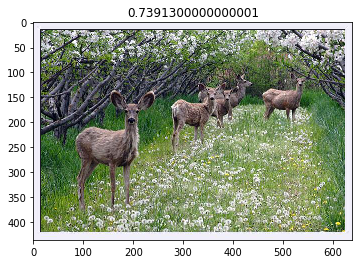

In [0]:
file=""
def show_sample_from_dataset(i=0):
  global file
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))
  
  image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
  file=image_path
  mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
  show_image(io.imread(image_path),mem_val)

show_sample_from_dataset(3)

In [0]:
from PIL import Image
image=None
def image_loader(loader, image_name):
    global image
    
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print( (resmodel_50(image_loader(data_transforms,file).double().to(device)).cpu().item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.7414350080736298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


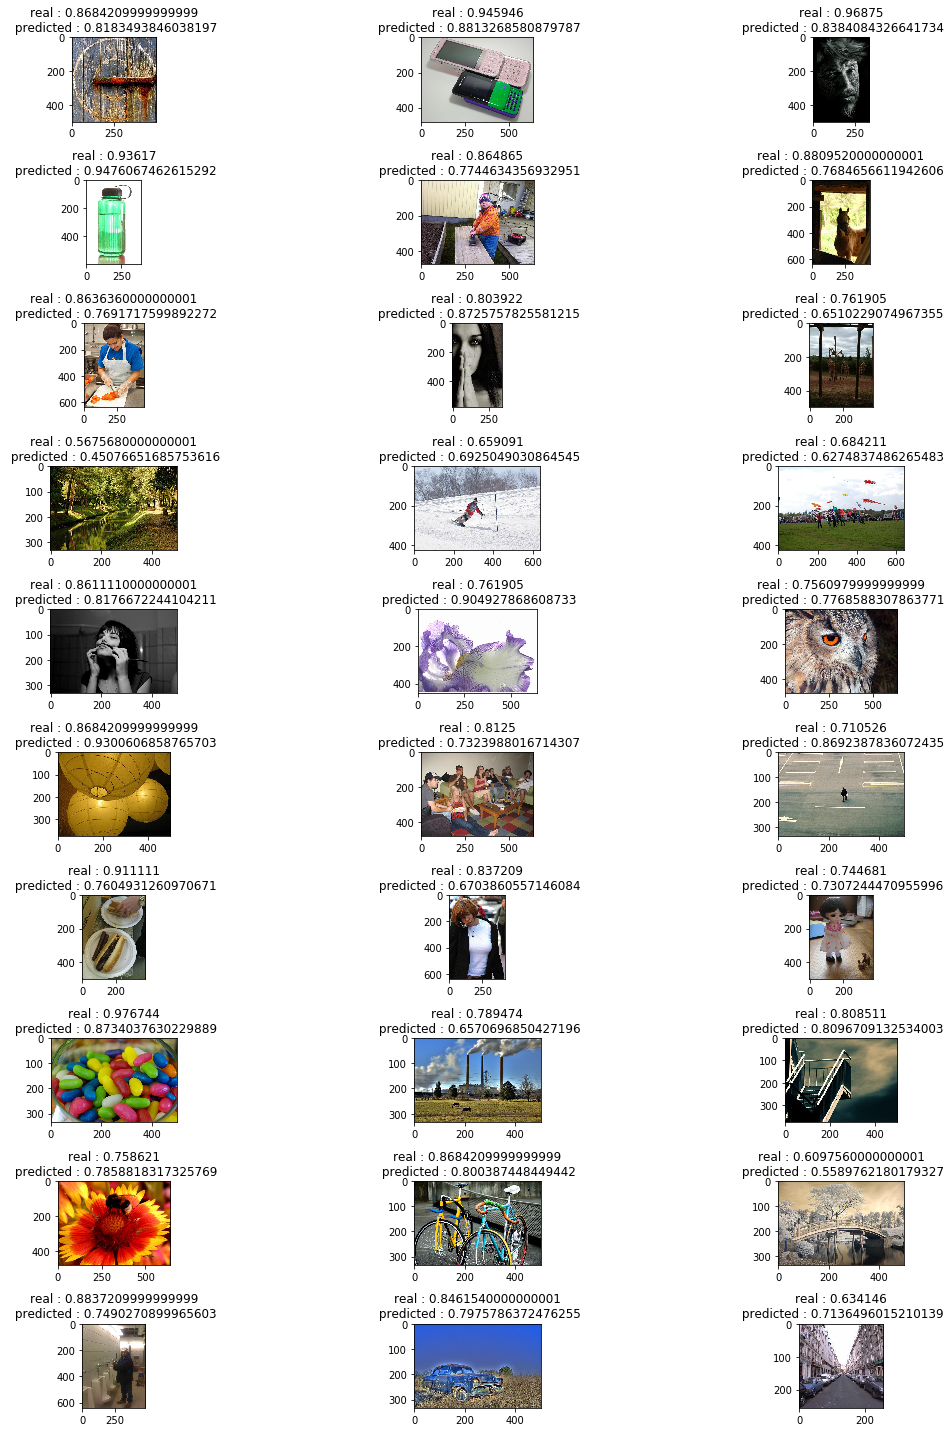

In [0]:

def show_grid(n_row,n_col):
 
  i=220
  _ ,fig = plt.subplots(n_row, n_col, figsize=(20,20))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
    mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
    pred=best_model_50(image_loader(data_transforms,image_path).double().to(device)).cpu().item()
    
    f.imshow(io.imread(image_path))
    plt.tight_layout()
    f.title.set_text("real : "+ str(mem_val)+"\n predicted : "+str(pred))
#     f.title(str(aseth_value))
    i=i+1
show_grid(10,3)

# **ResNet101**

In [0]:
model_101 = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 86.3MB/s]


In [0]:
# model_50 = models.resnet50(pretrained=True)
for param in model_101.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model_101.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_101.fc = last_layer
model_101.to(device)
print(model_101.fc.out_features)

# model_50 = model_50.double()

1


In [0]:

model_101 = model_101.double()
resmodel_101=copy.deepcopy(model_101)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_101.parameters(), lr = 0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
model_101,original_model_101,running_loss_history,val_running_loss_history =  train_model(model_101,criterion,optimizer,exp_lr_scheduler)

sap={'epoch': 5,
            'model_state_dict':model_101.state_dict(),
              'val_running_loss': val_running_loss_history,
            'running_loss_history':running_loss_history
    }
torch.save(sap, "/content/drive/My Drive/image memorability/model101.pt")

  0%|          | 0/368 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 1/368 [00:15<1:31:59, 15.04s/it]

  batch loss:     0.7632152015324363


  1%|          | 2/368 [00:31<1:34:38, 15.52s/it]

  batch loss:     0.645209561940489


  1%|          | 3/368 [00:46<1:33:57, 15.45s/it]

  batch loss:     0.5193436989290402


  1%|          | 4/368 [01:07<1:42:49, 16.95s/it]

  batch loss:     0.4066113769842351


  1%|▏         | 5/368 [01:21<1:36:44, 15.99s/it]

  batch loss:     0.31672529645577807


  2%|▏         | 6/368 [01:35<1:33:22, 15.48s/it]

  batch loss:     0.24183698149986887


  2%|▏         | 7/368 [01:49<1:31:18, 15.18s/it]

  batch loss:     0.16612127995848008


  2%|▏         | 8/368 [02:05<1:31:39, 15.28s/it]

  batch loss:     0.1185753757684615


  2%|▏         | 9/368 [02:20<1:31:27, 15.29s/it]

  batch loss:     0.10816668994725522


  3%|▎         | 10/368 [02:36<1:31:59, 15.42s/it]

  batch loss:     0.09885446952632054


  3%|▎         | 11/368 [02:51<1:31:44, 15.42s/it]

  batch loss:     0.09218200428030829


  3%|▎         | 12/368 [03:09<1:35:23, 16.08s/it]

  batch loss:     0.08538563086312187


  4%|▎         | 13/368 [03:23<1:31:26, 15.45s/it]

  batch loss:     0.11661905207190366


  4%|▍         | 14/368 [03:37<1:29:28, 15.16s/it]

  batch loss:     0.12142225779749594


  4%|▍         | 15/368 [03:53<1:29:24, 15.20s/it]

  batch loss:     0.12349302853393111


  4%|▍         | 16/368 [04:07<1:28:05, 15.02s/it]

  batch loss:     0.14453323794675443


  5%|▍         | 17/368 [04:22<1:27:43, 15.00s/it]

  batch loss:     0.14028584998677618


  5%|▍         | 18/368 [04:38<1:28:43, 15.21s/it]

  batch loss:     0.16227033578114675


  5%|▌         | 19/368 [04:52<1:26:45, 14.92s/it]

  batch loss:     0.1557275736661073


  5%|▌         | 20/368 [05:08<1:28:09, 15.20s/it]

  batch loss:     0.1452085062691352


  6%|▌         | 21/368 [05:23<1:26:47, 15.01s/it]

  batch loss:     0.12979941629905264


  6%|▌         | 22/368 [05:41<1:32:41, 16.07s/it]

  batch loss:     0.10346433112307443


  6%|▋         | 23/368 [05:55<1:29:02, 15.49s/it]

  batch loss:     0.11566371988215796


  7%|▋         | 24/368 [06:10<1:26:56, 15.16s/it]

  batch loss:     0.09409279046995876


  7%|▋         | 25/368 [06:26<1:28:42, 15.52s/it]

  batch loss:     0.09216720111567156


  7%|▋         | 26/368 [06:41<1:27:00, 15.26s/it]

  batch loss:     0.09808832084166634


  7%|▋         | 27/368 [06:55<1:25:38, 15.07s/it]

  batch loss:     0.07417947340234302


  8%|▊         | 28/368 [07:09<1:23:31, 14.74s/it]

  batch loss:     0.07020840508840065


  8%|▊         | 29/368 [07:24<1:22:56, 14.68s/it]

  batch loss:     0.09513403231151046


  8%|▊         | 30/368 [07:42<1:28:39, 15.74s/it]

  batch loss:     0.09203924918976096


  8%|▊         | 31/368 [07:57<1:27:37, 15.60s/it]

  batch loss:     0.06571636310889459


  9%|▊         | 32/368 [08:12<1:25:45, 15.31s/it]

  batch loss:     0.09658148988734158


  9%|▉         | 33/368 [08:26<1:23:37, 14.98s/it]

  batch loss:     0.0885547750151709


  9%|▉         | 34/368 [08:40<1:22:04, 14.75s/it]

  batch loss:     0.07591587596761046


 10%|▉         | 35/368 [08:56<1:23:40, 15.08s/it]

  batch loss:     0.09495301853058408


 10%|▉         | 36/368 [09:17<1:32:40, 16.75s/it]

  batch loss:     0.08506639868271329


 10%|█         | 37/368 [09:32<1:28:50, 16.10s/it]

  batch loss:     0.08418421387957138


 10%|█         | 38/368 [09:46<1:25:19, 15.51s/it]

  batch loss:     0.08650702334759376


 11%|█         | 39/368 [10:00<1:22:41, 15.08s/it]

  batch loss:     0.06996024830212101


 11%|█         | 40/368 [10:16<1:23:55, 15.35s/it]

  batch loss:     0.08554734260966984


 11%|█         | 41/368 [10:30<1:21:37, 14.98s/it]

  batch loss:     0.10352281092796727


 11%|█▏        | 42/368 [10:44<1:20:16, 14.77s/it]

  batch loss:     0.07784850378826644


 12%|█▏        | 43/368 [11:00<1:21:35, 15.06s/it]

  batch loss:     0.0808692469476024


 12%|█▏        | 44/368 [11:15<1:21:56, 15.18s/it]

  batch loss:     0.08446437883987085


 12%|█▏        | 45/368 [11:29<1:20:02, 14.87s/it]

  batch loss:     0.07048869879246217


 12%|█▎        | 46/368 [11:47<1:23:24, 15.54s/it]

  batch loss:     0.0583566371637933


 13%|█▎        | 47/368 [12:02<1:22:36, 15.44s/it]

  batch loss:     0.07455982672445194


 13%|█▎        | 48/368 [12:16<1:20:04, 15.01s/it]

  batch loss:     0.08630130913258839


 13%|█▎        | 49/368 [12:30<1:18:22, 14.74s/it]

  batch loss:     0.07890750249543703


 14%|█▎        | 50/368 [12:45<1:17:59, 14.72s/it]

  batch loss:     0.06579989411460659


 14%|█▍        | 51/368 [12:59<1:17:13, 14.62s/it]

  batch loss:     0.08093182698905133


 14%|█▍        | 52/368 [13:14<1:17:49, 14.78s/it]

  batch loss:     0.0715113695127235


 14%|█▍        | 53/368 [13:28<1:16:41, 14.61s/it]

  batch loss:     0.060402977880895374


 15%|█▍        | 54/368 [13:43<1:16:22, 14.59s/it]

  batch loss:     0.07547761285030838


 15%|█▍        | 55/368 [13:58<1:16:22, 14.64s/it]

  batch loss:     0.07281549063134186


 15%|█▌        | 56/368 [14:13<1:16:37, 14.74s/it]

  batch loss:     0.08147314275630142


 15%|█▌        | 57/368 [14:28<1:17:17, 14.91s/it]

  batch loss:     0.08732449139984949


 16%|█▌        | 58/368 [14:42<1:15:41, 14.65s/it]

  batch loss:     0.06645980006727258


 16%|█▌        | 59/368 [14:57<1:16:48, 14.91s/it]

  batch loss:     0.08320354195820553


 16%|█▋        | 60/368 [15:12<1:16:36, 14.92s/it]

  batch loss:     0.0666827685221536


 17%|█▋        | 61/368 [15:27<1:15:44, 14.80s/it]

  batch loss:     0.06754299988258998


 17%|█▋        | 62/368 [15:47<1:23:10, 16.31s/it]

  batch loss:     0.060821013757754006


 17%|█▋        | 63/368 [16:00<1:18:53, 15.52s/it]

  batch loss:     0.053179241762254095


 17%|█▋        | 64/368 [16:16<1:18:12, 15.44s/it]

  batch loss:     0.06588042007404808


 18%|█▊        | 65/368 [16:30<1:16:14, 15.10s/it]

  batch loss:     0.05751121875434846


 18%|█▊        | 66/368 [16:45<1:15:19, 14.97s/it]

  batch loss:     0.055106235159937886


 18%|█▊        | 67/368 [16:59<1:14:32, 14.86s/it]

  batch loss:     0.062175055430171135


 18%|█▊        | 68/368 [17:16<1:16:47, 15.36s/it]

  batch loss:     0.07071102727013083


 19%|█▉        | 69/368 [17:32<1:18:16, 15.71s/it]

  batch loss:     0.06647502046630568


 19%|█▉        | 70/368 [17:47<1:16:45, 15.46s/it]

  batch loss:     0.06641394981654036


 19%|█▉        | 71/368 [18:01<1:14:41, 15.09s/it]

  batch loss:     0.08573806142790084


 20%|█▉        | 72/368 [18:16<1:13:51, 14.97s/it]

  batch loss:     0.07344657508572149


 20%|█▉        | 73/368 [18:31<1:14:11, 15.09s/it]

  batch loss:     0.08069299049110673


 20%|██        | 74/368 [18:46<1:13:01, 14.90s/it]

  batch loss:     0.06894540011788702


 20%|██        | 75/368 [19:01<1:12:50, 14.92s/it]

  batch loss:     0.07105898933429212


 21%|██        | 76/368 [19:16<1:12:32, 14.91s/it]

  batch loss:     0.05959475225634428


 21%|██        | 77/368 [19:30<1:11:59, 14.85s/it]

  batch loss:     0.06076585872033207


 21%|██        | 78/368 [19:46<1:12:17, 14.96s/it]

  batch loss:     0.05276441030615445


 21%|██▏       | 79/368 [20:02<1:13:23, 15.24s/it]

  batch loss:     0.06412705896163437


 22%|██▏       | 80/368 [20:16<1:12:06, 15.02s/it]

  batch loss:     0.054817033894791305


 22%|██▏       | 81/368 [20:32<1:12:49, 15.22s/it]

  batch loss:     0.05906818460158872


 22%|██▏       | 82/368 [20:47<1:13:11, 15.36s/it]

  batch loss:     0.056523154402172336


 23%|██▎       | 83/368 [21:02<1:12:13, 15.20s/it]

  batch loss:     0.07699686630799249


 23%|██▎       | 84/368 [21:16<1:10:26, 14.88s/it]

  batch loss:     0.056710870483646154


 23%|██▎       | 85/368 [21:30<1:09:04, 14.64s/it]

  batch loss:     0.05678087856070153


 23%|██▎       | 86/368 [21:49<1:13:34, 15.66s/it]

  batch loss:     0.06100928363318827


 24%|██▎       | 87/368 [22:04<1:12:54, 15.57s/it]

  batch loss:     0.054150789371501064


 24%|██▍       | 88/368 [22:18<1:11:18, 15.28s/it]

  batch loss:     0.05881411449473489


 24%|██▍       | 89/368 [22:34<1:10:45, 15.22s/it]

  batch loss:     0.050622540199734084


 24%|██▍       | 90/368 [22:48<1:08:51, 14.86s/it]

  batch loss:     0.06453422030240961


 25%|██▍       | 91/368 [23:02<1:08:10, 14.77s/it]

  batch loss:     0.060148318664254734


 25%|██▌       | 92/368 [23:17<1:07:22, 14.65s/it]

  batch loss:     0.06955320435772995


 25%|██▌       | 93/368 [23:34<1:11:43, 15.65s/it]

  batch loss:     0.06891130193560965


 26%|██▌       | 94/368 [23:49<1:09:37, 15.25s/it]

  batch loss:     0.06450261320151918


 26%|██▌       | 95/368 [24:05<1:10:24, 15.47s/it]

  batch loss:     0.054377731485272585


 26%|██▌       | 96/368 [24:21<1:10:34, 15.57s/it]

  batch loss:     0.054322295530510344


 26%|██▋       | 97/368 [24:36<1:10:20, 15.57s/it]

  batch loss:     0.04461553740550807


 27%|██▋       | 98/368 [24:51<1:08:28, 15.22s/it]

  batch loss:     0.05084223914294128


 27%|██▋       | 99/368 [25:05<1:07:50, 15.13s/it]

  batch loss:     0.06002877896857945


 27%|██▋       | 100/368 [25:20<1:06:22, 14.86s/it]

  batch loss:     0.054435799861895


 27%|██▋       | 101/368 [25:34<1:05:07, 14.64s/it]

  batch loss:     0.06538969822862603


 28%|██▊       | 102/368 [25:50<1:06:48, 15.07s/it]

  batch loss:     0.06558971096112734


 28%|██▊       | 103/368 [26:05<1:06:53, 15.15s/it]

  batch loss:     0.052312573028913574


 28%|██▊       | 104/368 [26:19<1:05:08, 14.81s/it]

  batch loss:     0.06327861508370279


 29%|██▊       | 105/368 [26:34<1:04:55, 14.81s/it]

  batch loss:     0.06529530072479031


 29%|██▉       | 106/368 [26:48<1:03:32, 14.55s/it]

  batch loss:     0.05816498617599296


 29%|██▉       | 107/368 [27:03<1:03:32, 14.61s/it]

  batch loss:     0.05366025868421609


 29%|██▉       | 108/368 [27:17<1:03:00, 14.54s/it]

  batch loss:     0.06292436929309869


 30%|██▉       | 109/368 [27:31<1:02:14, 14.42s/it]

  batch loss:     0.05731256151415631


 30%|██▉       | 110/368 [27:45<1:01:39, 14.34s/it]

  batch loss:     0.05545639715699238


 30%|███       | 111/368 [28:02<1:04:22, 15.03s/it]

  batch loss:     0.05671176152078482


 30%|███       | 112/368 [28:16<1:02:53, 14.74s/it]

  batch loss:     0.0502032451445942


 31%|███       | 113/368 [28:30<1:01:55, 14.57s/it]

  batch loss:     0.04826169805292199


 31%|███       | 114/368 [28:44<1:01:05, 14.43s/it]

  batch loss:     0.04217123548072124


 31%|███▏      | 115/368 [28:59<1:01:08, 14.50s/it]

  batch loss:     0.05502925921387488


 32%|███▏      | 116/368 [29:14<1:01:41, 14.69s/it]

  batch loss:     0.05903617676919662


 32%|███▏      | 117/368 [29:29<1:01:09, 14.62s/it]

  batch loss:     0.05678373580164269


 32%|███▏      | 118/368 [29:44<1:01:11, 14.69s/it]

  batch loss:     0.06110046775087136


 32%|███▏      | 119/368 [30:00<1:02:36, 15.09s/it]

  batch loss:     0.05128072146125326


 33%|███▎      | 120/368 [30:14<1:02:01, 15.01s/it]

  batch loss:     0.04738440298597218


 33%|███▎      | 121/368 [30:32<1:05:18, 15.87s/it]

  batch loss:     0.05896812620795623


 33%|███▎      | 122/368 [30:51<1:09:15, 16.89s/it]

  batch loss:     0.0735326416672066


 33%|███▎      | 123/368 [31:06<1:06:35, 16.31s/it]

  batch loss:     0.07648674449906716


 34%|███▎      | 124/368 [31:22<1:05:02, 15.99s/it]

  batch loss:     0.05521295378855237


 34%|███▍      | 125/368 [31:37<1:03:52, 15.77s/it]

  batch loss:     0.05491984131001175


 34%|███▍      | 126/368 [31:51<1:02:06, 15.40s/it]

  batch loss:     0.062228686479119666


 35%|███▍      | 127/368 [32:06<1:00:25, 15.05s/it]

  batch loss:     0.05193283492706452


 35%|███▍      | 128/368 [32:21<1:00:52, 15.22s/it]

  batch loss:     0.05900433046687125


 35%|███▌      | 129/368 [32:35<58:59, 14.81s/it]  

  batch loss:     0.0499513454163221


 35%|███▌      | 130/368 [32:51<1:00:07, 15.16s/it]

  batch loss:     0.047538336870195486


 36%|███▌      | 131/368 [33:06<59:49, 15.14s/it]  

  batch loss:     0.05447902135672328


 36%|███▌      | 132/368 [33:22<59:51, 15.22s/it]

  batch loss:     0.05013595123021315


 36%|███▌      | 133/368 [33:36<58:44, 15.00s/it]

  batch loss:     0.05045242099255708


 36%|███▋      | 134/368 [33:51<58:36, 15.03s/it]

  batch loss:     0.057116032753841625


 37%|███▋      | 135/368 [34:08<1:00:01, 15.46s/it]

  batch loss:     0.049623617757191985


 37%|███▋      | 136/368 [34:22<58:39, 15.17s/it]  

  batch loss:     0.05315772104098871


 37%|███▋      | 137/368 [34:38<59:35, 15.48s/it]

  batch loss:     0.04478359938786594


 38%|███▊      | 138/368 [34:56<1:01:35, 16.07s/it]

  batch loss:     0.053949973291042445


 38%|███▊      | 139/368 [35:11<1:00:10, 15.77s/it]

  batch loss:     0.049152204057943


 38%|███▊      | 140/368 [35:28<1:01:32, 16.20s/it]

  batch loss:     0.05045971896423689


 38%|███▊      | 141/368 [35:44<1:01:08, 16.16s/it]

  batch loss:     0.05996199463502377


 39%|███▊      | 142/368 [36:00<1:00:43, 16.12s/it]

  batch loss:     0.05873281090430267


 39%|███▉      | 143/368 [36:14<58:01, 15.48s/it]  

  batch loss:     0.049413114360282076


 39%|███▉      | 144/368 [36:29<57:20, 15.36s/it]

  batch loss:     0.05068445475024091


 39%|███▉      | 145/368 [36:43<55:33, 14.95s/it]

  batch loss:     0.04186707891926352


 40%|███▉      | 146/368 [37:00<57:05, 15.43s/it]

  batch loss:     0.050063652488320926


 40%|███▉      | 147/368 [37:15<56:13, 15.26s/it]

  batch loss:     0.05087477168622511


 40%|████      | 148/368 [37:29<55:23, 15.11s/it]

  batch loss:     0.04463835798143663


 40%|████      | 149/368 [37:44<54:49, 15.02s/it]

  batch loss:     0.050956273705191124


 41%|████      | 150/368 [37:58<53:38, 14.77s/it]

  batch loss:     0.04034142806255273


 41%|████      | 151/368 [38:13<53:12, 14.71s/it]

  batch loss:     0.04549772996161673


 41%|████▏     | 152/368 [38:29<54:50, 15.23s/it]

  batch loss:     0.05239444831244654


 42%|████▏     | 153/368 [38:44<53:44, 15.00s/it]

  batch loss:     0.045303097602280254


 42%|████▏     | 154/368 [38:59<53:15, 14.93s/it]

  batch loss:     0.04668603647192922


 42%|████▏     | 155/368 [39:16<55:13, 15.56s/it]

  batch loss:     0.0419439186186647


 42%|████▏     | 156/368 [39:33<56:27, 15.98s/it]

  batch loss:     0.0413514082003906


 43%|████▎     | 157/368 [39:47<54:42, 15.56s/it]

  batch loss:     0.05721631444363248


 43%|████▎     | 158/368 [40:03<54:52, 15.68s/it]

  batch loss:     0.03710512410592637


 43%|████▎     | 159/368 [40:18<53:28, 15.35s/it]

  batch loss:     0.046901546944842755


 43%|████▎     | 160/368 [40:33<52:41, 15.20s/it]

  batch loss:     0.052938270356433885


 44%|████▍     | 161/368 [40:47<51:38, 14.97s/it]

  batch loss:     0.05259348063405075


 44%|████▍     | 162/368 [41:01<50:27, 14.70s/it]

  batch loss:     0.04870758096013928


 44%|████▍     | 163/368 [41:19<53:58, 15.80s/it]

  batch loss:     0.04440661519482356


 45%|████▍     | 164/368 [41:34<52:12, 15.36s/it]

  batch loss:     0.05922278168965216


 45%|████▍     | 165/368 [41:52<54:51, 16.21s/it]

  batch loss:     0.04349731110201975


 45%|████▌     | 166/368 [42:07<53:21, 15.85s/it]

  batch loss:     0.05063143153657001


 45%|████▌     | 167/368 [42:22<52:06, 15.56s/it]

  batch loss:     0.053105450014832266


 46%|████▌     | 168/368 [42:39<53:12, 15.96s/it]

  batch loss:     0.04947792982966728


 46%|████▌     | 169/368 [42:54<52:36, 15.86s/it]

  batch loss:     0.043102755848360146


 46%|████▌     | 170/368 [43:09<50:58, 15.45s/it]

  batch loss:     0.05027725356415784


 46%|████▋     | 171/368 [43:28<54:40, 16.65s/it]

  batch loss:     0.04280620625875787


 47%|████▋     | 172/368 [43:43<52:12, 15.98s/it]

  batch loss:     0.04398374436478442


 47%|████▋     | 173/368 [43:58<50:47, 15.63s/it]

  batch loss:     0.03840196597308174


 47%|████▋     | 174/368 [44:12<49:20, 15.26s/it]

  batch loss:     0.03493220621401078


 48%|████▊     | 175/368 [44:29<50:49, 15.80s/it]

  batch loss:     0.04203485570323841


 48%|████▊     | 176/368 [44:45<50:18, 15.72s/it]

  batch loss:     0.048938912291777215


 48%|████▊     | 177/368 [45:00<49:20, 15.50s/it]

  batch loss:     0.04656299858449353


 48%|████▊     | 178/368 [45:17<50:32, 15.96s/it]

  batch loss:     0.04416326900092321


 49%|████▊     | 179/368 [45:32<49:40, 15.77s/it]

  batch loss:     0.03890063426647055


 49%|████▉     | 180/368 [45:46<47:55, 15.30s/it]

  batch loss:     0.037848356327578415


 49%|████▉     | 181/368 [46:01<47:30, 15.24s/it]

  batch loss:     0.04798614634509328


 49%|████▉     | 182/368 [46:15<46:11, 14.90s/it]

  batch loss:     0.04440081778727943


 50%|████▉     | 183/368 [46:31<46:24, 15.05s/it]

  batch loss:     0.047114873053086044


 50%|█████     | 184/368 [46:48<48:11, 15.71s/it]

  batch loss:     0.05002256135732436


 50%|█████     | 185/368 [47:03<47:03, 15.43s/it]

  batch loss:     0.035772257942128516


 51%|█████     | 186/368 [47:17<46:04, 15.19s/it]

  batch loss:     0.03829344200659962


 51%|█████     | 187/368 [47:32<45:41, 15.15s/it]

  batch loss:     0.04507488050874502


 51%|█████     | 188/368 [47:50<47:41, 15.89s/it]

  batch loss:     0.03802539715763757


 51%|█████▏    | 189/368 [48:05<46:56, 15.73s/it]

  batch loss:     0.052824581522797676


 52%|█████▏    | 190/368 [48:20<45:55, 15.48s/it]

  batch loss:     0.03702966899209894


 52%|█████▏    | 191/368 [48:37<46:29, 15.76s/it]

  batch loss:     0.04422089789429404


 52%|█████▏    | 192/368 [48:55<48:21, 16.49s/it]

  batch loss:     0.045100370133705554


 52%|█████▏    | 193/368 [49:14<50:02, 17.16s/it]

  batch loss:     0.04308136611778987


 53%|█████▎    | 194/368 [49:32<50:30, 17.42s/it]

  batch loss:     0.0383169569994249


 53%|█████▎    | 195/368 [49:45<47:03, 16.32s/it]

  batch loss:     0.04081287825236305


 53%|█████▎    | 196/368 [50:02<47:19, 16.51s/it]

  batch loss:     0.04455458749795557


 54%|█████▎    | 197/368 [50:18<46:29, 16.31s/it]

  batch loss:     0.04367534214950326


 54%|█████▍    | 198/368 [50:34<45:27, 16.04s/it]

  batch loss:     0.03818364793949697


 54%|█████▍    | 199/368 [50:48<44:02, 15.64s/it]

  batch loss:     0.03922067171428058


 54%|█████▍    | 200/368 [51:03<42:54, 15.32s/it]

  batch loss:     0.0400108807800391


 55%|█████▍    | 201/368 [51:17<41:42, 14.98s/it]

  batch loss:     0.046612009829141265


 55%|█████▍    | 202/368 [51:32<41:29, 14.99s/it]

  batch loss:     0.045703371615609514


 55%|█████▌    | 203/368 [51:48<42:08, 15.33s/it]

  batch loss:     0.03759418456783756


 55%|█████▌    | 204/368 [52:06<43:50, 16.04s/it]

  batch loss:     0.044136490421803495


 56%|█████▌    | 205/368 [52:21<43:03, 15.85s/it]

  batch loss:     0.044167990879950284


 56%|█████▌    | 206/368 [52:35<41:13, 15.27s/it]

  batch loss:     0.04499863445765992


 56%|█████▋    | 207/368 [52:50<40:14, 14.99s/it]

  batch loss:     0.03489286324613568


 57%|█████▋    | 208/368 [53:05<40:32, 15.21s/it]

  batch loss:     0.04073515434386052


 57%|█████▋    | 209/368 [53:21<40:40, 15.35s/it]

  batch loss:     0.03965877573461588


 57%|█████▋    | 210/368 [53:40<43:05, 16.36s/it]

  batch loss:     0.03414820048795392


 57%|█████▋    | 211/368 [53:55<41:46, 15.97s/it]

  batch loss:     0.03960246038336536


 58%|█████▊    | 212/368 [54:10<40:38, 15.63s/it]

  batch loss:     0.040434000385487445


 58%|█████▊    | 213/368 [54:24<39:14, 15.19s/it]

  batch loss:     0.03696282246018588


 58%|█████▊    | 214/368 [54:39<39:07, 15.25s/it]

  batch loss:     0.03981161073019619


 58%|█████▊    | 215/368 [54:54<38:52, 15.24s/it]

  batch loss:     0.043875883151477425


 59%|█████▊    | 216/368 [55:11<39:52, 15.74s/it]

  batch loss:     0.033913087052959055


 59%|█████▉    | 217/368 [55:26<38:31, 15.31s/it]

  batch loss:     0.04294525959530162


 59%|█████▉    | 218/368 [55:40<37:33, 15.02s/it]

  batch loss:     0.040756349268917615


 60%|█████▉    | 219/368 [55:55<36:56, 14.88s/it]

  batch loss:     0.03797835677373834


 60%|█████▉    | 220/368 [56:09<36:18, 14.72s/it]

  batch loss:     0.05339085942220488


 60%|██████    | 221/368 [56:24<36:16, 14.80s/it]

  batch loss:     0.032010626765340965


 60%|██████    | 222/368 [56:38<35:26, 14.57s/it]

  batch loss:     0.039237199295245634


 61%|██████    | 223/368 [56:53<35:18, 14.61s/it]

  batch loss:     0.032737923776614455


 61%|██████    | 224/368 [57:07<34:34, 14.41s/it]

  batch loss:     0.03973726602689574


 61%|██████    | 225/368 [57:22<34:48, 14.60s/it]

  batch loss:     0.03789327063712562


 61%|██████▏   | 226/368 [57:40<37:23, 15.80s/it]

  batch loss:     0.04026838077586521


 62%|██████▏   | 227/368 [57:54<35:59, 15.32s/it]

  batch loss:     0.037004941801114175


 62%|██████▏   | 228/368 [58:10<36:02, 15.45s/it]

  batch loss:     0.039420456404027464


 62%|██████▏   | 229/368 [58:26<36:05, 15.58s/it]

  batch loss:     0.037210011262507094


 62%|██████▎   | 230/368 [58:42<36:07, 15.71s/it]

  batch loss:     0.04194654203569282


 63%|██████▎   | 231/368 [58:57<35:11, 15.41s/it]

  batch loss:     0.03157267011341848


 63%|██████▎   | 232/368 [59:15<36:47, 16.23s/it]

  batch loss:     0.032044144021288315


 63%|██████▎   | 233/368 [59:29<35:23, 15.73s/it]

  batch loss:     0.037693600813619985


 64%|██████▎   | 234/368 [59:45<35:20, 15.82s/it]

  batch loss:     0.027771064954071428


 64%|██████▍   | 235/368 [1:00:01<34:50, 15.72s/it]

  batch loss:     0.033841724276343375


 64%|██████▍   | 236/368 [1:00:16<33:51, 15.39s/it]

  batch loss:     0.033973794903527005


 64%|██████▍   | 237/368 [1:00:31<33:38, 15.40s/it]

  batch loss:     0.04050849364372633


 65%|██████▍   | 238/368 [1:00:47<33:45, 15.58s/it]

  batch loss:     0.03371323883956164


 65%|██████▍   | 239/368 [1:01:02<33:24, 15.54s/it]

  batch loss:     0.030556826509346432


 65%|██████▌   | 240/368 [1:01:18<33:10, 15.55s/it]

  batch loss:     0.03752419607356205


 65%|██████▌   | 241/368 [1:01:33<32:44, 15.47s/it]

  batch loss:     0.033204971582496697


 66%|██████▌   | 242/368 [1:01:47<31:36, 15.05s/it]

  batch loss:     0.03052413451044017


 66%|██████▌   | 243/368 [1:02:06<33:17, 15.98s/it]

  batch loss:     0.038225762947683276


 66%|██████▋   | 244/368 [1:02:23<33:55, 16.42s/it]

  batch loss:     0.042556020612853324


 67%|██████▋   | 245/368 [1:02:38<32:35, 15.90s/it]

  batch loss:     0.03259981505721604


 67%|██████▋   | 246/368 [1:02:53<31:50, 15.66s/it]

  batch loss:     0.03508007597252709


 67%|██████▋   | 247/368 [1:03:08<31:18, 15.53s/it]

  batch loss:     0.04539953664634834


 67%|██████▋   | 248/368 [1:03:26<32:46, 16.39s/it]

  batch loss:     0.034047651595129486


 68%|██████▊   | 249/368 [1:03:42<32:05, 16.18s/it]

  batch loss:     0.04224094780880635


 68%|██████▊   | 250/368 [1:03:59<32:08, 16.34s/it]

  batch loss:     0.032512643138912355


 68%|██████▊   | 251/368 [1:04:14<31:05, 15.94s/it]

  batch loss:     0.03486669582340056


 68%|██████▊   | 252/368 [1:04:28<29:51, 15.45s/it]

  batch loss:     0.04339284139530375


 69%|██████▉   | 253/368 [1:04:43<29:15, 15.27s/it]

  batch loss:     0.029484782907251858


 69%|██████▉   | 254/368 [1:04:57<28:30, 15.00s/it]

  batch loss:     0.03778594048640263


 69%|██████▉   | 255/368 [1:05:11<27:41, 14.70s/it]

  batch loss:     0.033237872682371716


 70%|██████▉   | 256/368 [1:05:29<28:53, 15.48s/it]

  batch loss:     0.03801063254227757


 70%|██████▉   | 257/368 [1:05:44<28:34, 15.45s/it]

  batch loss:     0.030350086868003633


 70%|███████   | 258/368 [1:06:00<28:44, 15.68s/it]

  batch loss:     0.03745871601169697


 70%|███████   | 259/368 [1:06:15<28:01, 15.43s/it]

  batch loss:     0.03147441209482581


 71%|███████   | 260/368 [1:06:29<27:10, 15.09s/it]

  batch loss:     0.03457243830778052


 71%|███████   | 261/368 [1:06:44<26:45, 15.01s/it]

  batch loss:     0.038002213344084525


 71%|███████   | 262/368 [1:06:58<25:57, 14.70s/it]

  batch loss:     0.037379536501124744


 71%|███████▏  | 263/368 [1:07:13<25:36, 14.63s/it]

  batch loss:     0.029696888229257368


 72%|███████▏  | 264/368 [1:07:27<25:24, 14.65s/it]

  batch loss:     0.040415434872567865


 72%|███████▏  | 265/368 [1:07:42<25:02, 14.59s/it]

  batch loss:     0.03388378477487944


 72%|███████▏  | 266/368 [1:07:56<24:45, 14.57s/it]

  batch loss:     0.04106375550553533


 73%|███████▎  | 267/368 [1:08:11<24:42, 14.68s/it]

  batch loss:     0.03410628757735136


 73%|███████▎  | 268/368 [1:08:26<24:29, 14.70s/it]

  batch loss:     0.03471366945337365


 73%|███████▎  | 269/368 [1:08:41<24:20, 14.76s/it]

  batch loss:     0.03550881250998926


 73%|███████▎  | 270/368 [1:08:55<23:57, 14.67s/it]

  batch loss:     0.02802555588769337


 74%|███████▎  | 271/368 [1:09:10<23:48, 14.73s/it]

  batch loss:     0.03244693310547252


 74%|███████▍  | 272/368 [1:09:26<23:58, 14.98s/it]

  batch loss:     0.0381303317163869


 74%|███████▍  | 273/368 [1:09:41<24:01, 15.18s/it]

  batch loss:     0.032690538087671236


 74%|███████▍  | 274/368 [1:09:56<23:36, 15.07s/it]

  batch loss:     0.038723173017514496


 75%|███████▍  | 275/368 [1:10:13<24:05, 15.54s/it]

  batch loss:     0.033116441078743855


 75%|███████▌  | 276/368 [1:10:30<24:26, 15.94s/it]

  batch loss:     0.038930465256698216


 75%|███████▌  | 277/368 [1:10:44<23:28, 15.48s/it]

  batch loss:     0.026408452521815097


 76%|███████▌  | 278/368 [1:10:58<22:35, 15.06s/it]

  batch loss:     0.03799280317801216


 76%|███████▌  | 279/368 [1:11:13<22:14, 15.00s/it]

  batch loss:     0.033313844034190895


 76%|███████▌  | 280/368 [1:11:32<23:43, 16.17s/it]

  batch loss:     0.030082447228190798


 76%|███████▋  | 281/368 [1:11:49<23:38, 16.30s/it]

  batch loss:     0.0343837250220921


 77%|███████▋  | 282/368 [1:12:04<22:59, 16.05s/it]

  batch loss:     0.03397920408031942


 77%|███████▋  | 283/368 [1:12:20<22:35, 15.95s/it]

  batch loss:     0.03618613272405389


 77%|███████▋  | 284/368 [1:12:34<21:47, 15.56s/it]

  batch loss:     0.03982576486331259


 77%|███████▋  | 285/368 [1:12:49<21:08, 15.28s/it]

  batch loss:     0.03530115545451411


 78%|███████▊  | 286/368 [1:13:03<20:32, 15.03s/it]

  batch loss:     0.03162420964579739


 78%|███████▊  | 287/368 [1:13:18<20:08, 14.92s/it]

  batch loss:     0.027988218815802032


 78%|███████▊  | 288/368 [1:13:34<20:19, 15.24s/it]

  batch loss:     0.04048614387712548


 79%|███████▊  | 289/368 [1:13:49<20:03, 15.23s/it]

  batch loss:     0.032489539818740594


 79%|███████▉  | 290/368 [1:14:05<19:56, 15.34s/it]

  batch loss:     0.027458812856626234


 79%|███████▉  | 291/368 [1:14:25<21:27, 16.73s/it]

  batch loss:     0.03555486523018025


 79%|███████▉  | 292/368 [1:14:41<20:56, 16.54s/it]

  batch loss:     0.03642255506685654


 80%|███████▉  | 293/368 [1:14:57<20:30, 16.41s/it]

  batch loss:     0.02486799632199614


 80%|███████▉  | 294/368 [1:15:13<19:56, 16.17s/it]

  batch loss:     0.03347611580104896


 80%|████████  | 295/368 [1:15:29<19:34, 16.09s/it]

  batch loss:     0.026705267703662244


 80%|████████  | 296/368 [1:15:43<18:50, 15.71s/it]

  batch loss:     0.035588148794524044


 81%|████████  | 297/368 [1:15:59<18:39, 15.77s/it]

  batch loss:     0.02996922377923452


 81%|████████  | 298/368 [1:16:17<18:54, 16.21s/it]

  batch loss:     0.03877850544925804


 81%|████████▏ | 299/368 [1:16:32<18:13, 15.84s/it]

  batch loss:     0.02963083940108338


 82%|████████▏ | 300/368 [1:16:46<17:22, 15.33s/it]

  batch loss:     0.02915718323876713


 82%|████████▏ | 301/368 [1:17:00<16:56, 15.17s/it]

  batch loss:     0.03887943215591503


 82%|████████▏ | 302/368 [1:17:16<16:38, 15.14s/it]

  batch loss:     0.02267488487838785


 82%|████████▏ | 303/368 [1:17:31<16:38, 15.37s/it]

  batch loss:     0.029840672242369706


 83%|████████▎ | 304/368 [1:17:46<16:06, 15.10s/it]

  batch loss:     0.028556289651478692


 83%|████████▎ | 305/368 [1:18:02<16:04, 15.30s/it]

  batch loss:     0.021806767769347403


 83%|████████▎ | 306/368 [1:18:17<15:40, 15.17s/it]

  batch loss:     0.028749414160111595


 83%|████████▎ | 307/368 [1:18:31<15:14, 14.98s/it]

  batch loss:     0.030601532458083516


 84%|████████▎ | 308/368 [1:18:47<15:08, 15.15s/it]

  batch loss:     0.028579938751656035


 84%|████████▍ | 309/368 [1:19:02<15:04, 15.32s/it]

  batch loss:     0.027785938024316566


 84%|████████▍ | 310/368 [1:19:18<14:58, 15.49s/it]

  batch loss:     0.029082088280725473


 85%|████████▍ | 311/368 [1:19:33<14:21, 15.12s/it]

  batch loss:     0.03196626388082327


 85%|████████▍ | 312/368 [1:19:49<14:34, 15.62s/it]

  batch loss:     0.027718024311580956


 85%|████████▌ | 313/368 [1:20:06<14:36, 15.93s/it]

  batch loss:     0.03183590307580912


 85%|████████▌ | 314/368 [1:20:20<13:52, 15.42s/it]

  batch loss:     0.028749487470983173


 86%|████████▌ | 315/368 [1:20:36<13:44, 15.55s/it]

  batch loss:     0.03356058042143106


 86%|████████▌ | 316/368 [1:20:52<13:27, 15.53s/it]

  batch loss:     0.034303880458931436


 86%|████████▌ | 317/368 [1:21:09<13:45, 16.18s/it]

  batch loss:     0.029997704227457546


 86%|████████▋ | 318/368 [1:21:26<13:31, 16.22s/it]

  batch loss:     0.031046573980282897


 87%|████████▋ | 319/368 [1:21:40<12:53, 15.78s/it]

  batch loss:     0.031878487598015315


 87%|████████▋ | 320/368 [1:21:54<12:14, 15.30s/it]

  batch loss:     0.03803885554723367


 87%|████████▋ | 321/368 [1:22:11<12:12, 15.59s/it]

  batch loss:     0.025652298059491537


 88%|████████▊ | 322/368 [1:22:29<12:28, 16.28s/it]

  batch loss:     0.033663404182110425


 88%|████████▊ | 323/368 [1:22:46<12:27, 16.60s/it]

  batch loss:     0.03475428464248301


 88%|████████▊ | 324/368 [1:23:01<11:49, 16.12s/it]

  batch loss:     0.02738068240467899


 88%|████████▊ | 325/368 [1:23:15<11:12, 15.64s/it]

  batch loss:     0.030844610559764764


 89%|████████▊ | 326/368 [1:23:36<11:55, 17.02s/it]

  batch loss:     0.02836468264573882


 89%|████████▉ | 327/368 [1:23:51<11:13, 16.43s/it]

  batch loss:     0.031243823317849875


 89%|████████▉ | 328/368 [1:24:07<10:57, 16.43s/it]

  batch loss:     0.0253165541025746


 89%|████████▉ | 329/368 [1:24:22<10:26, 16.05s/it]

  batch loss:     0.02391712004643591


 90%|████████▉ | 330/368 [1:24:38<10:02, 15.86s/it]

  batch loss:     0.034622265886188594


 90%|████████▉ | 331/368 [1:24:52<09:32, 15.47s/it]

  batch loss:     0.02481012669855668


 90%|█████████ | 332/368 [1:25:08<09:18, 15.51s/it]

  batch loss:     0.030980426007114103


 90%|█████████ | 333/368 [1:25:23<08:59, 15.42s/it]

  batch loss:     0.02723594528034853


 91%|█████████ | 334/368 [1:25:37<08:29, 14.99s/it]

  batch loss:     0.02991059186735842


 91%|█████████ | 335/368 [1:25:52<08:13, 14.95s/it]

  batch loss:     0.02634514070785557


 91%|█████████▏| 336/368 [1:26:06<07:53, 14.78s/it]

  batch loss:     0.029050558530524156


 92%|█████████▏| 337/368 [1:26:22<07:45, 15.01s/it]

  batch loss:     0.030805859783766744


 92%|█████████▏| 338/368 [1:26:37<07:29, 14.97s/it]

  batch loss:     0.024452737013658896


 92%|█████████▏| 339/368 [1:26:52<07:16, 15.06s/it]

  batch loss:     0.029598386432928173


 92%|█████████▏| 340/368 [1:27:08<07:08, 15.32s/it]

  batch loss:     0.03564085729713388


 93%|█████████▎| 341/368 [1:27:23<06:52, 15.27s/it]

  batch loss:     0.017777040808572488


 93%|█████████▎| 342/368 [1:27:37<06:29, 14.99s/it]

  batch loss:     0.03304519379659704


 93%|█████████▎| 343/368 [1:27:52<06:10, 14.83s/it]

  batch loss:     0.03242752630595026


 93%|█████████▎| 344/368 [1:28:06<05:51, 14.66s/it]

  batch loss:     0.029572297233314983


 94%|█████████▍| 345/368 [1:28:21<05:35, 14.58s/it]

  batch loss:     0.025171525485680076


 94%|█████████▍| 346/368 [1:28:37<05:31, 15.05s/it]

  batch loss:     0.029602291889889668


 94%|█████████▍| 347/368 [1:28:53<05:23, 15.39s/it]

  batch loss:     0.029132776316925492


 95%|█████████▍| 348/368 [1:29:07<05:01, 15.06s/it]

  batch loss:     0.027119401620158533


 95%|█████████▍| 349/368 [1:29:24<04:57, 15.65s/it]

  batch loss:     0.02931966256421402


 95%|█████████▌| 350/368 [1:29:41<04:45, 15.86s/it]

  batch loss:     0.02675698362256351


 95%|█████████▌| 351/368 [1:29:55<04:23, 15.52s/it]

  batch loss:     0.027398888434934272


 96%|█████████▌| 352/368 [1:30:12<04:14, 15.91s/it]

  batch loss:     0.02753645597034781


 96%|█████████▌| 353/368 [1:30:31<04:10, 16.68s/it]

  batch loss:     0.025945350777446766


 96%|█████████▌| 354/368 [1:30:48<03:56, 16.91s/it]

  batch loss:     0.028371997594210024


 96%|█████████▋| 355/368 [1:31:05<03:39, 16.86s/it]

  batch loss:     0.03380543914658324


 97%|█████████▋| 356/368 [1:31:20<03:16, 16.38s/it]

  batch loss:     0.035552712905277596


 97%|█████████▋| 357/368 [1:31:36<02:57, 16.14s/it]

  batch loss:     0.02728763776244169


 97%|█████████▋| 358/368 [1:31:51<02:38, 15.80s/it]

  batch loss:     0.024615608541647946


 98%|█████████▊| 359/368 [1:32:06<02:20, 15.57s/it]

  batch loss:     0.03368348077762667


 98%|█████████▊| 360/368 [1:32:21<02:03, 15.39s/it]

  batch loss:     0.027648059834321316


 98%|█████████▊| 361/368 [1:32:36<01:47, 15.29s/it]

  batch loss:     0.02294440996963085


 98%|█████████▊| 362/368 [1:32:51<01:32, 15.37s/it]

  batch loss:     0.03091806055216594


 99%|█████████▊| 363/368 [1:33:05<01:14, 14.98s/it]

  batch loss:     0.030123209105255514


 99%|█████████▉| 364/368 [1:33:20<00:59, 14.88s/it]

  batch loss:     0.03053323532112475


 99%|█████████▉| 365/368 [1:33:36<00:45, 15.08s/it]

  batch loss:     0.023980636405877703


 99%|█████████▉| 366/368 [1:33:50<00:29, 14.81s/it]

  batch loss:     0.027462181675926838


100%|█████████▉| 367/368 [1:34:04<00:14, 14.73s/it]

  batch loss:     0.02458526061186431


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.014523000424985761
train Loss: 0.0572


  1%|          | 1/92 [00:14<22:25, 14.79s/it]

  batch loss:     0.03630812859755358


  2%|▏         | 2/92 [00:29<22:10, 14.78s/it]

  batch loss:     0.029791893727315638


  3%|▎         | 3/92 [00:43<21:43, 14.65s/it]

  batch loss:     0.029667118355813284


  4%|▍         | 4/92 [00:58<21:35, 14.73s/it]

  batch loss:     0.02674249122522994


  5%|▌         | 5/92 [01:15<22:01, 15.19s/it]

  batch loss:     0.027212221222779505


  7%|▋         | 6/92 [01:31<22:07, 15.43s/it]

  batch loss:     0.030507293348468564


  8%|▊         | 7/92 [01:45<21:20, 15.06s/it]

  batch loss:     0.02529919719965068


  9%|▊         | 8/92 [02:02<21:52, 15.63s/it]

  batch loss:     0.029839440928463107


 10%|▉         | 9/92 [02:16<21:01, 15.20s/it]

  batch loss:     0.02818866827960572


 11%|█         | 10/92 [02:31<20:39, 15.11s/it]

  batch loss:     0.029037391597441543


 12%|█▏        | 11/92 [02:46<20:15, 15.00s/it]

  batch loss:     0.027245864363716128


 13%|█▎        | 12/92 [03:03<20:48, 15.61s/it]

  batch loss:     0.024795614432272853


 14%|█▍        | 13/92 [03:17<19:59, 15.19s/it]

  batch loss:     0.02717260286099391


 15%|█▌        | 14/92 [03:32<19:34, 15.06s/it]

  batch loss:     0.029305571661547264


 16%|█▋        | 15/92 [03:52<21:21, 16.65s/it]

  batch loss:     0.02632925044528353


 17%|█▋        | 16/92 [04:07<20:34, 16.25s/it]

  batch loss:     0.020648644331019872


 18%|█▊        | 17/92 [04:22<19:42, 15.77s/it]

  batch loss:     0.032657274392728294


 20%|█▉        | 18/92 [04:38<19:41, 15.96s/it]

  batch loss:     0.025530922869618656


 21%|██        | 19/92 [04:53<19:07, 15.72s/it]

  batch loss:     0.027211450614263662


 22%|██▏       | 20/92 [05:08<18:35, 15.49s/it]

  batch loss:     0.030271181934735616


 23%|██▎       | 21/92 [05:26<19:14, 16.27s/it]

  batch loss:     0.033435521883483275


 24%|██▍       | 22/92 [05:42<18:51, 16.17s/it]

  batch loss:     0.0291663778861858


 25%|██▌       | 23/92 [06:01<19:25, 16.89s/it]

  batch loss:     0.025219052811624773


 26%|██▌       | 24/92 [06:17<18:58, 16.74s/it]

  batch loss:     0.026422006831997174


 27%|██▋       | 25/92 [06:31<17:48, 15.94s/it]

  batch loss:     0.030225070484283585


 28%|██▊       | 26/92 [06:46<17:09, 15.60s/it]

  batch loss:     0.024112533309047706


 29%|██▉       | 27/92 [07:03<17:10, 15.86s/it]

  batch loss:     0.028032435819976224


 30%|███       | 28/92 [07:18<16:44, 15.70s/it]

  batch loss:     0.02847330442691344


 32%|███▏      | 29/92 [07:32<16:05, 15.32s/it]

  batch loss:     0.035699593816285055


 33%|███▎      | 30/92 [07:47<15:27, 14.96s/it]

  batch loss:     0.01928109859922197


 34%|███▎      | 31/92 [08:01<14:56, 14.70s/it]

  batch loss:     0.02334103543181663


 35%|███▍      | 32/92 [08:18<15:31, 15.52s/it]

  batch loss:     0.027191390125528427


 36%|███▌      | 33/92 [08:33<15:00, 15.26s/it]

  batch loss:     0.026430826520826945


 37%|███▋      | 34/92 [08:49<15:07, 15.65s/it]

  batch loss:     0.031007062093768877


 38%|███▊      | 35/92 [09:05<14:50, 15.62s/it]

  batch loss:     0.030209902775270712


 39%|███▉      | 36/92 [09:20<14:28, 15.50s/it]

  batch loss:     0.035249816735500754


 40%|████      | 37/92 [09:35<14:00, 15.28s/it]

  batch loss:     0.027745760723743608


 41%|████▏     | 38/92 [09:49<13:32, 15.05s/it]

  batch loss:     0.027035823048164393


 42%|████▏     | 39/92 [10:05<13:27, 15.24s/it]

  batch loss:     0.029990501339551827


 43%|████▎     | 40/92 [10:20<13:02, 15.06s/it]

  batch loss:     0.02956699090799666


 45%|████▍     | 41/92 [10:34<12:33, 14.77s/it]

  batch loss:     0.026692264002989168


 46%|████▌     | 42/92 [10:51<12:53, 15.48s/it]

  batch loss:     0.029463291537613102


 47%|████▋     | 43/92 [11:07<12:54, 15.80s/it]

  batch loss:     0.022392585133133188


 48%|████▊     | 44/92 [11:23<12:28, 15.59s/it]

  batch loss:     0.02764468303801105


 49%|████▉     | 45/92 [11:39<12:19, 15.74s/it]

  batch loss:     0.03205805411779786


 50%|█████     | 46/92 [11:55<12:09, 15.86s/it]

  batch loss:     0.028168651268173785


 51%|█████     | 47/92 [12:10<11:42, 15.61s/it]

  batch loss:     0.03091788355969835


 52%|█████▏    | 48/92 [12:24<11:12, 15.29s/it]

  batch loss:     0.027075464240420614


 53%|█████▎    | 49/92 [12:39<10:43, 14.96s/it]

  batch loss:     0.021374993685445803


 54%|█████▍    | 50/92 [12:54<10:28, 14.97s/it]

  batch loss:     0.022380318545505453


 55%|█████▌    | 51/92 [13:08<10:10, 14.90s/it]

  batch loss:     0.030486218014589304


 57%|█████▋    | 52/92 [13:24<10:05, 15.14s/it]

  batch loss:     0.026795381071108536


 58%|█████▊    | 53/92 [13:39<09:49, 15.12s/it]

  batch loss:     0.022036204827411008


 59%|█████▊    | 54/92 [13:55<09:37, 15.21s/it]

  batch loss:     0.02838898640180197


 60%|█████▉    | 55/92 [14:09<09:11, 14.90s/it]

  batch loss:     0.03327794029465065


 61%|██████    | 56/92 [14:25<09:11, 15.31s/it]

  batch loss:     0.02878909713390426


 62%|██████▏   | 57/92 [14:40<08:55, 15.30s/it]

  batch loss:     0.027063509743713986


 63%|██████▎   | 58/92 [14:58<09:05, 16.06s/it]

  batch loss:     0.02812251507444564


 64%|██████▍   | 59/92 [15:12<08:31, 15.49s/it]

  batch loss:     0.026080595738510147


 65%|██████▌   | 60/92 [15:27<08:04, 15.15s/it]

  batch loss:     0.025726858946642735


 66%|██████▋   | 61/92 [15:43<07:57, 15.41s/it]

  batch loss:     0.03471340560958077


 67%|██████▋   | 62/92 [15:59<07:50, 15.68s/it]

  batch loss:     0.03087903624595943


 68%|██████▊   | 63/92 [16:13<07:22, 15.27s/it]

  batch loss:     0.026673952455866776


 70%|██████▉   | 64/92 [16:28<06:59, 14.98s/it]

  batch loss:     0.026088489987334436


 71%|███████   | 65/92 [16:42<06:41, 14.86s/it]

  batch loss:     0.032283607674552524


 72%|███████▏  | 66/92 [16:57<06:23, 14.76s/it]

  batch loss:     0.026201904865576494


 73%|███████▎  | 67/92 [17:11<06:09, 14.77s/it]

  batch loss:     0.02851154797995047


 74%|███████▍  | 68/92 [17:28<06:11, 15.46s/it]

  batch loss:     0.02376082558445299


 75%|███████▌  | 69/92 [17:44<05:58, 15.61s/it]

  batch loss:     0.02579553470631752


 76%|███████▌  | 70/92 [17:59<05:35, 15.24s/it]

  batch loss:     0.030492485430933393


 77%|███████▋  | 71/92 [18:14<05:19, 15.22s/it]

  batch loss:     0.02703423408326363


 78%|███████▊  | 72/92 [18:30<05:09, 15.47s/it]

  batch loss:     0.0319276203575307


 79%|███████▉  | 73/92 [18:47<04:59, 15.76s/it]

  batch loss:     0.03575709219801186


 80%|████████  | 74/92 [19:02<04:43, 15.77s/it]

  batch loss:     0.029941093252206598


 82%|████████▏ | 75/92 [19:16<04:18, 15.23s/it]

  batch loss:     0.030730972854725327


 83%|████████▎ | 76/92 [19:32<04:06, 15.39s/it]

  batch loss:     0.028023357654339064


 84%|████████▎ | 77/92 [19:48<03:51, 15.44s/it]

  batch loss:     0.03210877019198113


 85%|████████▍ | 78/92 [20:03<03:34, 15.33s/it]

  batch loss:     0.027018630403897393


 86%|████████▌ | 79/92 [20:20<03:26, 15.89s/it]

  batch loss:     0.02817138810275705


 87%|████████▋ | 80/92 [20:34<03:05, 15.47s/it]

  batch loss:     0.02608932485896921


 88%|████████▊ | 81/92 [20:49<02:46, 15.10s/it]

  batch loss:     0.03189775129722396


 89%|████████▉ | 82/92 [21:03<02:27, 14.77s/it]

  batch loss:     0.025660078746141016


 90%|█████████ | 83/92 [21:17<02:12, 14.77s/it]

  batch loss:     0.028766831404351628


 91%|█████████▏| 84/92 [21:32<01:58, 14.79s/it]

  batch loss:     0.031757042735944416


 92%|█████████▏| 85/92 [21:47<01:42, 14.66s/it]

  batch loss:     0.028767481324895226


 93%|█████████▎| 86/92 [22:01<01:27, 14.55s/it]

  batch loss:     0.028903419883157776


 95%|█████████▍| 87/92 [22:17<01:14, 14.91s/it]

  batch loss:     0.026479264915236556


 96%|█████████▌| 88/92 [22:31<00:59, 14.82s/it]

  batch loss:     0.029529682876009315


 97%|█████████▋| 89/92 [22:47<00:45, 15.10s/it]

  batch loss:     0.02725931785021491


 98%|█████████▊| 90/92 [23:03<00:30, 15.35s/it]

  batch loss:     0.022454944425785817


 99%|█████████▉| 91/92 [23:19<00:15, 15.59s/it]

  batch loss:     0.03299823501812538


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.027808285781259868
val Loss: 0.0283

Epoch 1/4
----------


  0%|          | 1/368 [00:16<1:38:11, 16.05s/it]

  batch loss:     0.02958816683431974


  1%|          | 2/368 [00:31<1:36:55, 15.89s/it]

  batch loss:     0.029140663285270357


  1%|          | 3/368 [00:45<1:33:05, 15.30s/it]

  batch loss:     0.026511738617670418


  1%|          | 4/368 [01:00<1:31:49, 15.14s/it]

  batch loss:     0.027366259105329582


  1%|▏         | 5/368 [01:14<1:30:28, 14.95s/it]

  batch loss:     0.027422158852978017


  2%|▏         | 6/368 [01:32<1:34:53, 15.73s/it]

  batch loss:     0.03442981833400586


  2%|▏         | 7/368 [01:47<1:33:31, 15.54s/it]

  batch loss:     0.029016900850331304


  2%|▏         | 8/368 [02:02<1:32:54, 15.49s/it]

  batch loss:     0.025722472261881343


  2%|▏         | 9/368 [02:17<1:31:51, 15.35s/it]

  batch loss:     0.03166295998252048


  3%|▎         | 10/368 [02:32<1:30:22, 15.15s/it]

  batch loss:     0.02702648014842566


  3%|▎         | 11/368 [02:48<1:30:52, 15.27s/it]

  batch loss:     0.025905989997779398


  3%|▎         | 12/368 [03:02<1:28:30, 14.92s/it]

  batch loss:     0.023720455404623794


  4%|▎         | 13/368 [03:18<1:30:30, 15.30s/it]

  batch loss:     0.019971853038135486


  4%|▍         | 14/368 [03:35<1:33:42, 15.88s/it]

  batch loss:     0.02617710244095517


  4%|▍         | 15/368 [03:50<1:30:58, 15.46s/it]

  batch loss:     0.02390188151660772


  4%|▍         | 16/368 [04:04<1:28:46, 15.13s/it]

  batch loss:     0.021661857121253524


  5%|▍         | 17/368 [04:20<1:29:34, 15.31s/it]

  batch loss:     0.02109958237443066


  5%|▍         | 18/368 [04:34<1:28:22, 15.15s/it]

  batch loss:     0.026479284648999988


  5%|▌         | 19/368 [04:49<1:27:23, 15.03s/it]

  batch loss:     0.02239292752621662


  5%|▌         | 20/368 [05:05<1:28:29, 15.26s/it]

  batch loss:     0.02762483054837248


  6%|▌         | 21/368 [05:21<1:28:51, 15.36s/it]

  batch loss:     0.028640186125273512


  6%|▌         | 22/368 [05:35<1:27:45, 15.22s/it]

  batch loss:     0.03288945198810973


  6%|▋         | 23/368 [05:51<1:27:26, 15.21s/it]

  batch loss:     0.029534442901949537


  7%|▋         | 24/368 [06:09<1:32:52, 16.20s/it]

  batch loss:     0.02326766205311224


  7%|▋         | 25/368 [06:23<1:29:07, 15.59s/it]

  batch loss:     0.029856159458862244


  7%|▋         | 26/368 [06:38<1:27:09, 15.29s/it]

  batch loss:     0.02488871826847169


  7%|▋         | 27/368 [06:54<1:27:51, 15.46s/it]

  batch loss:     0.03019699716845841


  8%|▊         | 28/368 [07:10<1:28:12, 15.57s/it]

  batch loss:     0.017133809603771272


  8%|▊         | 29/368 [07:25<1:28:23, 15.65s/it]

  batch loss:     0.024315340945900023


  8%|▊         | 30/368 [07:42<1:30:33, 16.07s/it]

  batch loss:     0.029094134345629578


  8%|▊         | 31/368 [07:57<1:28:30, 15.76s/it]

  batch loss:     0.023936551420552357


  9%|▊         | 32/368 [08:12<1:25:40, 15.30s/it]

  batch loss:     0.02251171642587714


  9%|▉         | 33/368 [08:26<1:24:05, 15.06s/it]

  batch loss:     0.02617650239959272


  9%|▉         | 34/368 [08:41<1:22:57, 14.90s/it]

  batch loss:     0.025829912445292466


 10%|▉         | 35/368 [08:56<1:22:35, 14.88s/it]

  batch loss:     0.02998825096000321


 10%|▉         | 36/368 [09:11<1:22:35, 14.93s/it]

  batch loss:     0.02622857409447213


 10%|█         | 37/368 [09:27<1:24:52, 15.39s/it]

  batch loss:     0.02159167014261259


 10%|█         | 38/368 [09:43<1:25:19, 15.51s/it]

  batch loss:     0.023514523586975693


 11%|█         | 39/368 [10:02<1:30:45, 16.55s/it]

  batch loss:     0.025711061656620682


 11%|█         | 40/368 [10:18<1:29:41, 16.41s/it]

  batch loss:     0.025605377531727626


 11%|█         | 41/368 [10:32<1:25:41, 15.72s/it]

  batch loss:     0.02685000996584955


 11%|█▏        | 42/368 [10:47<1:24:22, 15.53s/it]

  batch loss:     0.024622374604077832


 12%|█▏        | 43/368 [11:02<1:23:12, 15.36s/it]

  batch loss:     0.022244912977629133


 12%|█▏        | 44/368 [11:19<1:25:14, 15.78s/it]

  batch loss:     0.028221103213085172


 12%|█▏        | 45/368 [11:35<1:24:51, 15.76s/it]

  batch loss:     0.03226374140007782


 12%|█▎        | 46/368 [11:50<1:23:28, 15.56s/it]

  batch loss:     0.023232107235049232


 13%|█▎        | 47/368 [12:04<1:21:50, 15.30s/it]

  batch loss:     0.02791748587212735


 13%|█▎        | 48/368 [12:22<1:26:02, 16.13s/it]

  batch loss:     0.02910718641411875


 13%|█▎        | 49/368 [12:37<1:22:40, 15.55s/it]

  batch loss:     0.02238960831776335


 14%|█▎        | 50/368 [12:51<1:20:53, 15.26s/it]

  batch loss:     0.026924864151530423


 14%|█▍        | 51/368 [13:06<1:20:27, 15.23s/it]

  batch loss:     0.02060858774957598


 14%|█▍        | 52/368 [13:21<1:18:43, 14.95s/it]

  batch loss:     0.025555408710579208


 14%|█▍        | 53/368 [13:37<1:21:10, 15.46s/it]

  batch loss:     0.02821566577775534


 15%|█▍        | 54/368 [13:52<1:20:01, 15.29s/it]

  batch loss:     0.023949195456326327


 15%|█▍        | 55/368 [14:06<1:18:09, 14.98s/it]

  batch loss:     0.030449675825692968


 15%|█▌        | 56/368 [14:22<1:19:03, 15.20s/it]

  batch loss:     0.027347949095920327


 15%|█▌        | 57/368 [14:41<1:23:51, 16.18s/it]

  batch loss:     0.02496801303693815


 16%|█▌        | 58/368 [14:56<1:22:15, 15.92s/it]

  batch loss:     0.02379698618881006


 16%|█▌        | 59/368 [15:14<1:25:52, 16.68s/it]

  batch loss:     0.026774238528744027


 16%|█▋        | 60/368 [15:31<1:24:57, 16.55s/it]

  batch loss:     0.024835348726932938


 17%|█▋        | 61/368 [15:47<1:24:33, 16.52s/it]

  batch loss:     0.029041964849040314


 17%|█▋        | 62/368 [16:02<1:21:00, 15.88s/it]

  batch loss:     0.022140588897505527


 17%|█▋        | 63/368 [16:17<1:20:02, 15.75s/it]

  batch loss:     0.023106760070036585


 17%|█▋        | 64/368 [16:33<1:20:08, 15.82s/it]

  batch loss:     0.024565479320641258


 18%|█▊        | 65/368 [16:47<1:17:36, 15.37s/it]

  batch loss:     0.020475149789228833


 18%|█▊        | 66/368 [17:03<1:17:23, 15.38s/it]

  batch loss:     0.025735633021002197


 18%|█▊        | 67/368 [17:19<1:18:12, 15.59s/it]

  batch loss:     0.0323680227433078


 18%|█▊        | 68/368 [17:33<1:16:26, 15.29s/it]

  batch loss:     0.027488619560772035


 19%|█▉        | 69/368 [17:48<1:15:49, 15.22s/it]

  batch loss:     0.021838690688207693


 19%|█▉        | 70/368 [18:03<1:15:17, 15.16s/it]

  batch loss:     0.024088045544123332


 19%|█▉        | 71/368 [18:20<1:17:20, 15.63s/it]

  batch loss:     0.022995319536942557


 20%|█▉        | 72/368 [18:37<1:19:02, 16.02s/it]

  batch loss:     0.021607356957191015


 20%|█▉        | 73/368 [18:51<1:16:22, 15.53s/it]

  batch loss:     0.024155196239892103


 20%|██        | 74/368 [19:06<1:14:07, 15.13s/it]

  batch loss:     0.02057135189251376


 20%|██        | 75/368 [19:22<1:14:58, 15.35s/it]

  batch loss:     0.0261674558297616


 21%|██        | 76/368 [19:38<1:17:02, 15.83s/it]

  batch loss:     0.029038470300893127


 21%|██        | 77/368 [19:54<1:15:39, 15.60s/it]

  batch loss:     0.02477362333422987


 21%|██        | 78/368 [20:08<1:13:17, 15.16s/it]

  batch loss:     0.026705393040612875


 21%|██▏       | 79/368 [20:24<1:14:38, 15.50s/it]

  batch loss:     0.02338689636713387


 22%|██▏       | 80/368 [20:38<1:12:52, 15.18s/it]

  batch loss:     0.02464904113278535


 22%|██▏       | 81/368 [20:55<1:14:19, 15.54s/it]

  batch loss:     0.02533970131755921


 22%|██▏       | 82/368 [21:09<1:12:20, 15.18s/it]

  batch loss:     0.022853126867638997


 23%|██▎       | 83/368 [21:26<1:15:05, 15.81s/it]

  batch loss:     0.02712613877600594


 23%|██▎       | 84/368 [21:41<1:13:02, 15.43s/it]

  batch loss:     0.019810197983338662


 23%|██▎       | 85/368 [21:55<1:11:22, 15.13s/it]

  batch loss:     0.026502691099696586


 23%|██▎       | 86/368 [22:11<1:12:01, 15.33s/it]

  batch loss:     0.030555167679141938


 24%|██▎       | 87/368 [22:27<1:11:54, 15.36s/it]

  batch loss:     0.019365864192357498


 24%|██▍       | 88/368 [22:41<1:10:13, 15.05s/it]

  batch loss:     0.030287749948347566


 24%|██▍       | 89/368 [22:59<1:14:21, 15.99s/it]

  batch loss:     0.023267710108591116


 24%|██▍       | 90/368 [23:14<1:13:00, 15.76s/it]

  batch loss:     0.021135938218386517


 25%|██▍       | 91/368 [23:30<1:12:22, 15.68s/it]

  batch loss:     0.027910510166068686


 25%|██▌       | 92/368 [23:45<1:11:34, 15.56s/it]

  batch loss:     0.022274110272537836


 25%|██▌       | 93/368 [24:00<1:09:53, 15.25s/it]

  batch loss:     0.022984485839884647


 26%|██▌       | 94/368 [24:16<1:10:52, 15.52s/it]

  batch loss:     0.023564690764543095


 26%|██▌       | 95/368 [24:31<1:10:17, 15.45s/it]

  batch loss:     0.028206965513080794


 26%|██▌       | 96/368 [24:46<1:09:20, 15.30s/it]

  batch loss:     0.021491164801282853


 26%|██▋       | 97/368 [25:01<1:09:24, 15.37s/it]

  batch loss:     0.025671094450810332


 27%|██▋       | 98/368 [25:18<1:10:35, 15.69s/it]

  batch loss:     0.02187481239140291


 27%|██▋       | 99/368 [25:34<1:10:21, 15.69s/it]

  batch loss:     0.026175156356333502


 27%|██▋       | 100/368 [25:49<1:09:10, 15.49s/it]

  batch loss:     0.027408808170043313


 27%|██▋       | 101/368 [26:04<1:08:14, 15.33s/it]

  batch loss:     0.024629502232812364


 28%|██▊       | 102/368 [26:26<1:16:58, 17.36s/it]

  batch loss:     0.02832312747417586


 28%|██▊       | 103/368 [26:42<1:14:46, 16.93s/it]

  batch loss:     0.020901084643926756


 28%|██▊       | 104/368 [26:57<1:11:47, 16.32s/it]

  batch loss:     0.02459712831103217


 29%|██▊       | 105/368 [27:13<1:11:43, 16.36s/it]

  batch loss:     0.020289076770988842


 29%|██▉       | 106/368 [27:33<1:16:39, 17.55s/it]

  batch loss:     0.02262632278847998


 29%|██▉       | 107/368 [27:49<1:13:57, 17.00s/it]

  batch loss:     0.022510431669682387


 29%|██▉       | 108/368 [28:07<1:14:41, 17.24s/it]

  batch loss:     0.019471576057623455


 30%|██▉       | 109/368 [28:24<1:13:53, 17.12s/it]

  batch loss:     0.023449533691345305


 30%|██▉       | 110/368 [28:39<1:11:06, 16.53s/it]

  batch loss:     0.02578116882820928


 30%|███       | 111/368 [28:54<1:09:26, 16.21s/it]

  batch loss:     0.024689853592183272


 30%|███       | 112/368 [29:11<1:09:18, 16.25s/it]

  batch loss:     0.029423068052073738


 31%|███       | 113/368 [29:25<1:07:11, 15.81s/it]

  batch loss:     0.026315296782974697


 31%|███       | 114/368 [29:40<1:05:20, 15.43s/it]

  batch loss:     0.022837407337598942


 31%|███▏      | 115/368 [29:56<1:05:42, 15.58s/it]

  batch loss:     0.023635658607967625


 32%|███▏      | 116/368 [30:11<1:04:58, 15.47s/it]

  batch loss:     0.0257097950098936


 32%|███▏      | 117/368 [30:27<1:04:58, 15.53s/it]

  batch loss:     0.02223621590460162


 32%|███▏      | 118/368 [30:41<1:03:34, 15.26s/it]

  batch loss:     0.027112957561210446


 32%|███▏      | 119/368 [30:56<1:02:16, 15.01s/it]

  batch loss:     0.01686088584538134


 33%|███▎      | 120/368 [31:11<1:02:04, 15.02s/it]

  batch loss:     0.023356915776741236


 33%|███▎      | 121/368 [31:26<1:01:25, 14.92s/it]

  batch loss:     0.024712368582390724


 33%|███▎      | 122/368 [31:42<1:03:22, 15.46s/it]

  batch loss:     0.020878962664852063


 33%|███▎      | 123/368 [31:58<1:03:44, 15.61s/it]

  batch loss:     0.020298275964009942


 34%|███▎      | 124/368 [32:15<1:04:56, 15.97s/it]

  batch loss:     0.025187692814416726


 34%|███▍      | 125/368 [32:29<1:02:38, 15.47s/it]

  batch loss:     0.02607008729625293


 34%|███▍      | 126/368 [32:46<1:03:21, 15.71s/it]

  batch loss:     0.02102861686982299


 35%|███▍      | 127/368 [33:00<1:01:29, 15.31s/it]

  batch loss:     0.026120112458533705


 35%|███▍      | 128/368 [33:14<1:00:05, 15.02s/it]

  batch loss:     0.024471477776830095


 35%|███▌      | 129/368 [33:31<1:01:30, 15.44s/it]

  batch loss:     0.02173709296074694


 35%|███▌      | 130/368 [33:47<1:02:24, 15.73s/it]

  batch loss:     0.01721901146605514


 36%|███▌      | 131/368 [34:04<1:03:08, 15.98s/it]

  batch loss:     0.019774578645041216


 36%|███▌      | 132/368 [34:19<1:02:35, 15.91s/it]

  batch loss:     0.018381827365144737


 36%|███▌      | 133/368 [34:34<1:00:35, 15.47s/it]

  batch loss:     0.024185198512630037


 36%|███▋      | 134/368 [34:48<59:06, 15.16s/it]  

  batch loss:     0.018718810717334312


 37%|███▋      | 135/368 [35:03<57:52, 14.90s/it]

  batch loss:     0.02224144105736069


 37%|███▋      | 136/368 [35:18<58:23, 15.10s/it]

  batch loss:     0.023107569805797368


 37%|███▋      | 137/368 [35:32<57:09, 14.85s/it]

  batch loss:     0.029755619528285607


 38%|███▊      | 138/368 [35:47<56:50, 14.83s/it]

  batch loss:     0.018711675158235325


 38%|███▊      | 139/368 [36:06<1:00:45, 15.92s/it]

  batch loss:     0.02442917438785452


 38%|███▊      | 140/368 [36:20<59:05, 15.55s/it]  

  batch loss:     0.01896975658617533


 38%|███▊      | 141/368 [36:35<57:40, 15.24s/it]

  batch loss:     0.0248991865540107


 39%|███▊      | 142/368 [36:50<57:21, 15.23s/it]

  batch loss:     0.023858496810370857


 39%|███▉      | 143/368 [37:05<56:20, 15.02s/it]

  batch loss:     0.024419209422583167


 39%|███▉      | 144/368 [37:21<57:27, 15.39s/it]

  batch loss:     0.022377522342006323


 39%|███▉      | 145/368 [37:36<56:19, 15.15s/it]

  batch loss:     0.023781918113126403


 40%|███▉      | 146/368 [37:52<57:09, 15.45s/it]

  batch loss:     0.025423776844752975


 40%|███▉      | 147/368 [38:08<57:48, 15.69s/it]

  batch loss:     0.021820025751501233


 40%|████      | 148/368 [38:23<56:32, 15.42s/it]

  batch loss:     0.023258561839565865


 40%|████      | 149/368 [38:37<55:25, 15.19s/it]

  batch loss:     0.026859197453099906


 41%|████      | 150/368 [38:52<54:27, 14.99s/it]

  batch loss:     0.019471089991003845


 41%|████      | 151/368 [39:07<54:49, 15.16s/it]

  batch loss:     0.020978796802148387


 41%|████▏     | 152/368 [39:23<54:41, 15.19s/it]

  batch loss:     0.01918870937208435


 42%|████▏     | 153/368 [39:37<53:18, 14.88s/it]

  batch loss:     0.022844845185991183


 42%|████▏     | 154/368 [39:54<56:00, 15.70s/it]

  batch loss:     0.025229063174980783


 42%|████▏     | 155/368 [40:13<58:29, 16.48s/it]

  batch loss:     0.019948505791817856


 42%|████▏     | 156/368 [40:27<56:05, 15.87s/it]

  batch loss:     0.024583246717938358


 43%|████▎     | 157/368 [40:42<54:55, 15.62s/it]

  batch loss:     0.02767045880637463


 43%|████▎     | 158/368 [41:03<59:38, 17.04s/it]

  batch loss:     0.014266769874307859


 43%|████▎     | 159/368 [41:17<56:14, 16.15s/it]

  batch loss:     0.021538147993902114


 43%|████▎     | 160/368 [41:33<56:18, 16.24s/it]

  batch loss:     0.024833683498943257


 44%|████▍     | 161/368 [41:48<55:02, 15.95s/it]

  batch loss:     0.02190325517118053


 44%|████▍     | 162/368 [42:04<54:02, 15.74s/it]

  batch loss:     0.02236251168812051


 44%|████▍     | 163/368 [42:19<53:31, 15.67s/it]

  batch loss:     0.02229946753717829


 45%|████▍     | 164/368 [42:35<53:50, 15.84s/it]

  batch loss:     0.02678476507053688


 45%|████▍     | 165/368 [42:51<53:20, 15.76s/it]

  batch loss:     0.019271973831747273


 45%|████▌     | 166/368 [43:06<52:06, 15.48s/it]

  batch loss:     0.021884494725309667


 45%|████▌     | 167/368 [43:21<51:36, 15.41s/it]

  batch loss:     0.024432600123202978


 46%|████▌     | 168/368 [43:36<51:17, 15.39s/it]

  batch loss:     0.021119003354399264


 46%|████▌     | 169/368 [43:51<50:14, 15.15s/it]

  batch loss:     0.022757115372492434


 46%|████▌     | 170/368 [44:11<54:19, 16.46s/it]

  batch loss:     0.02231699976031417


 46%|████▋     | 171/368 [44:27<54:30, 16.60s/it]

  batch loss:     0.021971197264061663


 47%|████▋     | 172/368 [44:44<54:20, 16.63s/it]

  batch loss:     0.020041210417343445


 47%|████▋     | 173/368 [45:00<53:32, 16.48s/it]

  batch loss:     0.02399107339515092


 47%|████▋     | 174/368 [45:17<53:04, 16.41s/it]

  batch loss:     0.0187404109219426


 48%|████▊     | 175/368 [45:31<51:15, 15.93s/it]

  batch loss:     0.026802166857234383


 48%|████▊     | 176/368 [45:46<49:26, 15.45s/it]

  batch loss:     0.01855914093995739


 48%|████▊     | 177/368 [46:04<51:34, 16.20s/it]

  batch loss:     0.022043627021908832


 48%|████▊     | 178/368 [46:18<49:56, 15.77s/it]

  batch loss:     0.017602564724049655


 49%|████▊     | 179/368 [46:34<49:30, 15.71s/it]

  batch loss:     0.020515373177838914


 49%|████▉     | 180/368 [46:49<48:08, 15.37s/it]

  batch loss:     0.020143418646518026


 49%|████▉     | 181/368 [47:04<48:15, 15.49s/it]

  batch loss:     0.02129631656274806


 49%|████▉     | 182/368 [47:19<46:57, 15.15s/it]

  batch loss:     0.0216666225865636


 50%|████▉     | 183/368 [47:33<46:17, 15.02s/it]

  batch loss:     0.023678525371946077


 50%|█████     | 184/368 [47:48<45:28, 14.83s/it]

  batch loss:     0.02288742940196971


 50%|█████     | 185/368 [48:02<44:50, 14.70s/it]

  batch loss:     0.02262769529023262


 51%|█████     | 186/368 [48:17<44:46, 14.76s/it]

  batch loss:     0.021487609309328106


 51%|█████     | 187/368 [48:33<45:24, 15.05s/it]

  batch loss:     0.021238887566694738


 51%|█████     | 188/368 [48:47<44:49, 14.94s/it]

  batch loss:     0.018913083279468192


 51%|█████▏    | 189/368 [49:03<44:49, 15.02s/it]

  batch loss:     0.01927006729382964


 52%|█████▏    | 190/368 [49:17<44:20, 14.95s/it]

  batch loss:     0.018540322150389917


 52%|█████▏    | 191/368 [49:34<45:13, 15.33s/it]

  batch loss:     0.0239082802711445


 52%|█████▏    | 192/368 [49:52<47:56, 16.35s/it]

  batch loss:     0.018898383570510807


 52%|█████▏    | 193/368 [50:07<46:19, 15.88s/it]

  batch loss:     0.02200327893987644


 53%|█████▎    | 194/368 [50:23<46:11, 15.93s/it]

  batch loss:     0.020363933690425294


 53%|█████▎    | 195/368 [50:38<44:42, 15.50s/it]

  batch loss:     0.018825971835130406


 53%|█████▎    | 196/368 [50:52<43:29, 15.17s/it]

  batch loss:     0.01819453981153924


 54%|█████▎    | 197/368 [51:06<42:30, 14.91s/it]

  batch loss:     0.021306925382127688


 54%|█████▍    | 198/368 [51:24<44:37, 15.75s/it]

  batch loss:     0.02175844134893602


 54%|█████▍    | 199/368 [51:39<43:55, 15.60s/it]

  batch loss:     0.02058680618906541


 54%|█████▍    | 200/368 [51:55<43:25, 15.51s/it]

  batch loss:     0.023174752221526956


 55%|█████▍    | 201/368 [52:11<43:45, 15.72s/it]

  batch loss:     0.016725192618898994


 55%|█████▍    | 202/368 [52:28<44:33, 16.10s/it]

  batch loss:     0.01612904071781007


 55%|█████▌    | 203/368 [52:44<44:06, 16.04s/it]

  batch loss:     0.022499142903523416


 55%|█████▌    | 204/368 [52:58<42:40, 15.61s/it]

  batch loss:     0.02048909887790775


 56%|█████▌    | 205/368 [53:13<41:34, 15.30s/it]

  batch loss:     0.01859307140216714


 56%|█████▌    | 206/368 [53:31<43:23, 16.07s/it]

  batch loss:     0.021804492677582846


 56%|█████▋    | 207/368 [53:51<46:16, 17.24s/it]

  batch loss:     0.0216587429368097


 57%|█████▋    | 208/368 [54:05<43:38, 16.37s/it]

  batch loss:     0.023264311942886855


 57%|█████▋    | 209/368 [54:20<42:27, 16.02s/it]

  batch loss:     0.017754667933694797


 57%|█████▋    | 210/368 [54:35<41:00, 15.57s/it]

  batch loss:     0.023665199240598307


 57%|█████▋    | 211/368 [54:50<40:03, 15.31s/it]

  batch loss:     0.020953986464848605


 58%|█████▊    | 212/368 [55:06<40:23, 15.53s/it]

  batch loss:     0.0226289232790255


 58%|█████▊    | 213/368 [55:20<39:09, 15.16s/it]

  batch loss:     0.017443563968566993


 58%|█████▊    | 214/368 [55:42<44:29, 17.33s/it]

  batch loss:     0.014851103615490226


 58%|█████▊    | 215/368 [55:59<43:37, 17.11s/it]

  batch loss:     0.022311731342350243


 59%|█████▊    | 216/368 [56:14<41:51, 16.53s/it]

  batch loss:     0.022561647815030894


 59%|█████▉    | 217/368 [56:30<40:57, 16.27s/it]

  batch loss:     0.02195043702851469


 59%|█████▉    | 218/368 [56:48<41:48, 16.73s/it]

  batch loss:     0.017782161892730693


 60%|█████▉    | 219/368 [57:02<39:31, 15.91s/it]

  batch loss:     0.01958137062837903


 60%|█████▉    | 220/368 [57:16<38:08, 15.46s/it]

  batch loss:     0.02338856450697811


 60%|██████    | 221/368 [57:33<39:02, 15.93s/it]

  batch loss:     0.02137744441103237


 60%|██████    | 222/368 [57:49<38:47, 15.94s/it]

  batch loss:     0.01906638608330036


 61%|██████    | 223/368 [58:03<37:27, 15.50s/it]

  batch loss:     0.01760835445765789


 61%|██████    | 224/368 [58:18<36:17, 15.12s/it]

  batch loss:     0.022489829001804077


 61%|██████    | 225/368 [58:34<37:09, 15.59s/it]

  batch loss:     0.02377553958448656


 61%|██████▏   | 226/368 [58:50<37:02, 15.65s/it]

  batch loss:     0.02311012251737036


 62%|██████▏   | 227/368 [59:06<36:55, 15.71s/it]

  batch loss:     0.01800770220565978


 62%|██████▏   | 228/368 [59:21<36:03, 15.46s/it]

  batch loss:     0.02226291974960333


 62%|██████▏   | 229/368 [59:37<36:32, 15.78s/it]

  batch loss:     0.017854370278173236


 62%|██████▎   | 230/368 [59:53<35:53, 15.60s/it]

  batch loss:     0.019204955617161706


 63%|██████▎   | 231/368 [1:00:07<34:54, 15.29s/it]

  batch loss:     0.0215845855044038


 63%|██████▎   | 232/368 [1:00:23<34:55, 15.41s/it]

  batch loss:     0.02220772569581545


 63%|██████▎   | 233/368 [1:00:38<34:37, 15.39s/it]

  batch loss:     0.021082515642176496


 64%|██████▎   | 234/368 [1:00:53<33:54, 15.18s/it]

  batch loss:     0.019828592012678475


 64%|██████▍   | 235/368 [1:01:09<34:22, 15.51s/it]

  batch loss:     0.018150896341360603


 64%|██████▍   | 236/368 [1:01:24<33:31, 15.24s/it]

  batch loss:     0.018770947358714644


 64%|██████▍   | 237/368 [1:01:39<33:04, 15.15s/it]

  batch loss:     0.02388303782248484


 65%|██████▍   | 238/368 [1:01:56<33:54, 15.65s/it]

  batch loss:     0.019993727968103014


 65%|██████▍   | 239/368 [1:02:11<33:24, 15.54s/it]

  batch loss:     0.018960834675545712


 65%|██████▌   | 240/368 [1:02:26<32:58, 15.45s/it]

  batch loss:     0.01855945611028577


 65%|██████▌   | 241/368 [1:02:41<32:13, 15.22s/it]

  batch loss:     0.019313250243753577


 66%|██████▌   | 242/368 [1:02:58<33:27, 15.93s/it]

  batch loss:     0.01919395907226297


 66%|██████▌   | 243/368 [1:03:13<32:26, 15.57s/it]

  batch loss:     0.021164969760577725


 66%|██████▋   | 244/368 [1:03:30<33:09, 16.04s/it]

  batch loss:     0.015895639734155934


 67%|██████▋   | 245/368 [1:03:46<32:55, 16.06s/it]

  batch loss:     0.022372875894653275


 67%|██████▋   | 246/368 [1:04:02<32:32, 16.00s/it]

  batch loss:     0.018270303917570983


 67%|██████▋   | 247/368 [1:04:18<32:11, 15.96s/it]

  batch loss:     0.017016818237851446


 67%|██████▋   | 248/368 [1:04:32<30:50, 15.42s/it]

  batch loss:     0.024519470800976235


 68%|██████▊   | 249/368 [1:04:47<30:08, 15.20s/it]

  batch loss:     0.019969508312351197


 68%|██████▊   | 250/368 [1:05:04<30:52, 15.70s/it]

  batch loss:     0.0199744186952519


 68%|██████▊   | 251/368 [1:05:18<29:54, 15.33s/it]

  batch loss:     0.01571136430430572


 68%|██████▊   | 252/368 [1:05:35<30:27, 15.76s/it]

  batch loss:     0.021124581692029656


 69%|██████▉   | 253/368 [1:05:50<29:45, 15.53s/it]

  batch loss:     0.020078938712105497


 69%|██████▉   | 254/368 [1:06:05<29:25, 15.49s/it]

  batch loss:     0.01943259470706237


 69%|██████▉   | 255/368 [1:06:23<30:10, 16.02s/it]

  batch loss:     0.019532389120998035


 70%|██████▉   | 256/368 [1:06:42<31:57, 17.12s/it]

  batch loss:     0.019700618775143033


 70%|██████▉   | 257/368 [1:06:57<30:28, 16.47s/it]

  batch loss:     0.018456025603705937


 70%|███████   | 258/368 [1:07:15<30:40, 16.73s/it]

  batch loss:     0.02208302934639898


 70%|███████   | 259/368 [1:07:30<29:39, 16.32s/it]

  batch loss:     0.023917312973219196


 71%|███████   | 260/368 [1:07:45<28:37, 15.90s/it]

  batch loss:     0.02082480293214921


 71%|███████   | 261/368 [1:07:59<27:39, 15.51s/it]

  batch loss:     0.01931437495878327


 71%|███████   | 262/368 [1:08:14<26:51, 15.21s/it]

  batch loss:     0.023318946963433215


 71%|███████▏  | 263/368 [1:08:29<26:22, 15.07s/it]

  batch loss:     0.023235186795377765


 72%|███████▏  | 264/368 [1:08:44<26:17, 15.17s/it]

  batch loss:     0.0183831468804281


 72%|███████▏  | 265/368 [1:08:58<25:34, 14.90s/it]

  batch loss:     0.02143579071696432


 72%|███████▏  | 266/368 [1:09:14<25:39, 15.09s/it]

  batch loss:     0.02205016784690523


 73%|███████▎  | 267/368 [1:09:29<25:24, 15.09s/it]

  batch loss:     0.018405879479956797


 73%|███████▎  | 268/368 [1:09:44<24:55, 14.95s/it]

  batch loss:     0.019313539006898486


 73%|███████▎  | 269/368 [1:09:58<24:30, 14.85s/it]

  batch loss:     0.019192477412415032


 73%|███████▎  | 270/368 [1:10:17<26:05, 15.97s/it]

  batch loss:     0.01736625145568556


 74%|███████▎  | 271/368 [1:10:31<25:05, 15.52s/it]

  batch loss:     0.016570175978004434


 74%|███████▍  | 272/368 [1:10:46<24:23, 15.25s/it]

  batch loss:     0.017715315546083257


 74%|███████▍  | 273/368 [1:11:03<24:50, 15.69s/it]

  batch loss:     0.022867427109497514


 74%|███████▍  | 274/368 [1:11:19<24:48, 15.83s/it]

  batch loss:     0.02296547940265651


 75%|███████▍  | 275/368 [1:11:34<24:19, 15.70s/it]

  batch loss:     0.01844157207350275


 75%|███████▌  | 276/368 [1:11:52<25:10, 16.41s/it]

  batch loss:     0.020645425478180105


 75%|███████▌  | 277/368 [1:12:10<25:16, 16.66s/it]

  batch loss:     0.019234051862845755


 76%|███████▌  | 278/368 [1:12:24<24:06, 16.07s/it]

  batch loss:     0.022480885117939917


 76%|███████▌  | 279/368 [1:12:39<23:06, 15.58s/it]

  batch loss:     0.019225254705696457


 76%|███████▌  | 280/368 [1:12:54<22:45, 15.52s/it]

  batch loss:     0.022111562512576816


 76%|███████▋  | 281/368 [1:13:09<22:10, 15.29s/it]

  batch loss:     0.022873142227340715


 77%|███████▋  | 282/368 [1:13:24<21:40, 15.13s/it]

  batch loss:     0.019981387273645054


 77%|███████▋  | 283/368 [1:13:39<21:35, 15.24s/it]

  batch loss:     0.02266048251103794


 77%|███████▋  | 284/368 [1:13:56<22:02, 15.75s/it]

  batch loss:     0.018187313752272373


 77%|███████▋  | 285/368 [1:14:12<21:48, 15.76s/it]

  batch loss:     0.019245236167573204


 78%|███████▊  | 286/368 [1:14:26<20:59, 15.36s/it]

  batch loss:     0.018635816947382387


 78%|███████▊  | 287/368 [1:14:41<20:27, 15.16s/it]

  batch loss:     0.01563616175545344


 78%|███████▊  | 288/368 [1:14:55<19:57, 14.96s/it]

  batch loss:     0.02544274592943799


 79%|███████▊  | 289/368 [1:15:14<21:00, 15.95s/it]

  batch loss:     0.020346257456816605


 79%|███████▉  | 290/368 [1:15:28<20:10, 15.52s/it]

  batch loss:     0.01980372691817291


 79%|███████▉  | 291/368 [1:15:43<19:35, 15.26s/it]

  batch loss:     0.01838290189032441


 79%|███████▉  | 292/368 [1:15:57<18:58, 14.98s/it]

  batch loss:     0.018261879290766583


 80%|███████▉  | 293/368 [1:16:12<18:41, 14.95s/it]

  batch loss:     0.02058502479069054


 80%|███████▉  | 294/368 [1:16:27<18:27, 14.97s/it]

  batch loss:     0.021549280871145382


 80%|████████  | 295/368 [1:16:44<19:01, 15.64s/it]

  batch loss:     0.021291432509254173


 80%|████████  | 296/368 [1:17:03<19:42, 16.43s/it]

  batch loss:     0.021121266822117655


 81%|████████  | 297/368 [1:17:18<19:04, 16.12s/it]

  batch loss:     0.023204106168598228


 81%|████████  | 298/368 [1:17:34<18:48, 16.13s/it]

  batch loss:     0.019173828362902982


 81%|████████▏ | 299/368 [1:17:50<18:28, 16.06s/it]

  batch loss:     0.019865383728614038


 82%|████████▏ | 300/368 [1:18:07<18:39, 16.46s/it]

  batch loss:     0.020083795137265936


 82%|████████▏ | 301/368 [1:18:26<19:06, 17.11s/it]

  batch loss:     0.01994074359386962


 82%|████████▏ | 302/368 [1:18:41<18:11, 16.53s/it]

  batch loss:     0.01889779266344066


 82%|████████▏ | 303/368 [1:18:56<17:19, 15.99s/it]

  batch loss:     0.02182035804517654


 83%|████████▎ | 304/368 [1:19:13<17:23, 16.30s/it]

  batch loss:     0.01634536488365798


 83%|████████▎ | 305/368 [1:19:28<16:35, 15.80s/it]

  batch loss:     0.015404415875538964


 83%|████████▎ | 306/368 [1:19:44<16:29, 15.95s/it]

  batch loss:     0.01918860485057448


 83%|████████▎ | 307/368 [1:19:58<15:41, 15.44s/it]

  batch loss:     0.01974958709503488


 84%|████████▎ | 308/368 [1:20:15<15:44, 15.74s/it]

  batch loss:     0.01827644585808741


 84%|████████▍ | 309/368 [1:20:30<15:20, 15.60s/it]

  batch loss:     0.017991225398412698


 84%|████████▍ | 310/368 [1:20:46<15:13, 15.74s/it]

  batch loss:     0.021618070543004762


 85%|████████▍ | 311/368 [1:21:03<15:22, 16.19s/it]

  batch loss:     0.01937671438298049


 85%|████████▍ | 312/368 [1:21:18<14:46, 15.82s/it]

  batch loss:     0.02224217367356744


 85%|████████▌ | 313/368 [1:21:33<14:15, 15.55s/it]

  batch loss:     0.019860310129865635


 85%|████████▌ | 314/368 [1:21:50<14:14, 15.83s/it]

  batch loss:     0.01632083855043824


 86%|████████▌ | 315/368 [1:22:06<14:03, 15.91s/it]

  batch loss:     0.01969125004698488


 86%|████████▌ | 316/368 [1:22:21<13:42, 15.81s/it]

  batch loss:     0.01583840657196582


 86%|████████▌ | 317/368 [1:22:37<13:33, 15.94s/it]

  batch loss:     0.022697205713090866


 86%|████████▋ | 318/368 [1:22:52<12:54, 15.48s/it]

  batch loss:     0.0158017563276733


 87%|████████▋ | 319/368 [1:23:07<12:39, 15.50s/it]

  batch loss:     0.01709279975614897


 87%|████████▋ | 320/368 [1:23:22<12:13, 15.28s/it]

  batch loss:     0.021123128461700204


 87%|████████▋ | 321/368 [1:23:39<12:23, 15.82s/it]

  batch loss:     0.015146017333948398


 88%|████████▊ | 322/368 [1:23:57<12:37, 16.46s/it]

  batch loss:     0.01633943704137231


 88%|████████▊ | 323/368 [1:24:12<12:02, 16.06s/it]

  batch loss:     0.018558976422730716


 88%|████████▊ | 324/368 [1:24:29<11:58, 16.34s/it]

  batch loss:     0.021844277346462302


 88%|████████▊ | 325/368 [1:24:46<11:48, 16.48s/it]

  batch loss:     0.018240483888249344


 89%|████████▊ | 326/368 [1:25:02<11:24, 16.31s/it]

  batch loss:     0.01649946655459188


 89%|████████▉ | 327/368 [1:25:17<10:53, 15.95s/it]

  batch loss:     0.020212521155398972


 89%|████████▉ | 328/368 [1:25:32<10:29, 15.74s/it]

  batch loss:     0.022710526638363104


 89%|████████▉ | 329/368 [1:25:48<10:17, 15.84s/it]

  batch loss:     0.015220421144710219


 90%|████████▉ | 330/368 [1:26:05<10:12, 16.11s/it]

  batch loss:     0.017134791560933112


 90%|████████▉ | 331/368 [1:26:25<10:38, 17.24s/it]

  batch loss:     0.018562111968071025


 90%|█████████ | 332/368 [1:26:42<10:14, 17.08s/it]

  batch loss:     0.02474023049158591


 90%|█████████ | 333/368 [1:26:56<09:29, 16.29s/it]

  batch loss:     0.017199135403292903


 91%|█████████ | 334/368 [1:27:14<09:24, 16.60s/it]

  batch loss:     0.02023869222245149


 91%|█████████ | 335/368 [1:27:28<08:46, 15.95s/it]

  batch loss:     0.017359230391549442


 91%|█████████▏| 336/368 [1:27:43<08:22, 15.69s/it]

  batch loss:     0.017963422563701585


 92%|█████████▏| 337/368 [1:27:58<08:03, 15.60s/it]

  batch loss:     0.016235068944294825


 92%|█████████▏| 338/368 [1:28:14<07:50, 15.69s/it]

  batch loss:     0.019393904653441006


 92%|█████████▏| 339/368 [1:28:32<07:47, 16.13s/it]

  batch loss:     0.018513943638815644


 92%|█████████▏| 340/368 [1:28:48<07:33, 16.21s/it]

  batch loss:     0.015696648954968136


 93%|█████████▎| 341/368 [1:29:03<07:08, 15.86s/it]

  batch loss:     0.0189378436742012


 93%|█████████▎| 342/368 [1:29:18<06:44, 15.57s/it]

  batch loss:     0.012949646893528042


 93%|█████████▎| 343/368 [1:29:34<06:31, 15.67s/it]

  batch loss:     0.02007223255148326


 93%|█████████▎| 344/368 [1:29:49<06:09, 15.40s/it]

  batch loss:     0.024317349203800416


 94%|█████████▍| 345/368 [1:30:04<05:53, 15.36s/it]

  batch loss:     0.017352166908661423


 94%|█████████▍| 346/368 [1:30:19<05:35, 15.23s/it]

  batch loss:     0.017190704496669144


 94%|█████████▍| 347/368 [1:30:35<05:27, 15.59s/it]

  batch loss:     0.019643618786479956


 95%|█████████▍| 348/368 [1:30:50<05:06, 15.32s/it]

  batch loss:     0.020043722833504973


 95%|█████████▍| 349/368 [1:31:06<04:56, 15.62s/it]

  batch loss:     0.019456661670989046


 95%|█████████▌| 350/368 [1:31:23<04:49, 16.07s/it]

  batch loss:     0.019891583888572248


 95%|█████████▌| 351/368 [1:31:39<04:30, 15.89s/it]

  batch loss:     0.019322485964533242


 96%|█████████▌| 352/368 [1:31:55<04:15, 15.97s/it]

  batch loss:     0.018343801533500733


 96%|█████████▌| 353/368 [1:32:10<03:55, 15.73s/it]

  batch loss:     0.01919257231076521


 96%|█████████▌| 354/368 [1:32:25<03:37, 15.53s/it]

  batch loss:     0.01630806327720396


 96%|█████████▋| 355/368 [1:32:39<03:16, 15.13s/it]

  batch loss:     0.017160006304867418


 97%|█████████▋| 356/368 [1:32:54<03:01, 15.08s/it]

  batch loss:     0.019689457907985448


 97%|█████████▋| 357/368 [1:33:09<02:44, 14.95s/it]

  batch loss:     0.01690070698017558


 97%|█████████▋| 358/368 [1:33:24<02:28, 14.85s/it]

  batch loss:     0.017547118044414514


 98%|█████████▊| 359/368 [1:33:38<02:12, 14.71s/it]

  batch loss:     0.016186743105059652


 98%|█████████▊| 360/368 [1:33:52<01:57, 14.65s/it]

  batch loss:     0.017696083064501742


 98%|█████████▊| 361/368 [1:34:08<01:43, 14.81s/it]

  batch loss:     0.01636546808344487


 98%|█████████▊| 362/368 [1:34:30<01:42, 17.04s/it]

  batch loss:     0.01976575020201294


 99%|█████████▊| 363/368 [1:34:45<01:22, 16.57s/it]

  batch loss:     0.019617545491721768


 99%|█████████▉| 364/368 [1:35:00<01:03, 15.91s/it]

  batch loss:     0.021183687221194156


 99%|█████████▉| 365/368 [1:35:14<00:46, 15.51s/it]

  batch loss:     0.01763461710746852


 99%|█████████▉| 366/368 [1:35:34<00:33, 16.74s/it]

  batch loss:     0.015623735469704938


100%|█████████▉| 367/368 [1:35:48<00:16, 16.07s/it]

  batch loss:     0.01951402957477943


  0%|          | 0/92 [00:00<?, ?it/s]

  batch loss:     0.018014414655668973
train Loss: 0.0220


  1%|          | 1/92 [00:15<24:10, 15.94s/it]

  batch loss:     0.01994798256623218


  2%|▏         | 2/92 [00:30<23:13, 15.48s/it]

  batch loss:     0.019435769470091104


  3%|▎         | 3/92 [00:44<22:25, 15.12s/it]

  batch loss:     0.019450876768235283


  4%|▍         | 4/92 [00:59<22:11, 15.13s/it]

  batch loss:     0.020580278513274014


  5%|▌         | 5/92 [01:15<22:16, 15.36s/it]

  batch loss:     0.019012621361557465


  7%|▋         | 6/92 [01:30<21:43, 15.16s/it]

  batch loss:     0.01826132759392946


  8%|▊         | 7/92 [01:47<22:11, 15.66s/it]

  batch loss:     0.01834370834353237


  9%|▊         | 8/92 [02:02<21:52, 15.62s/it]

  batch loss:     0.018077218632835387


 10%|▉         | 9/92 [02:17<21:16, 15.38s/it]

  batch loss:     0.018639680743549825


 11%|█         | 10/92 [02:32<20:59, 15.37s/it]

  batch loss:     0.021324601518541892


 12%|█▏        | 11/92 [02:47<20:29, 15.18s/it]

  batch loss:     0.01579887671120921


 13%|█▎        | 12/92 [03:01<19:52, 14.91s/it]

  batch loss:     0.020499983751680287


 14%|█▍        | 13/92 [03:17<19:55, 15.13s/it]

  batch loss:     0.01795685948462654


 15%|█▌        | 14/92 [03:34<20:29, 15.77s/it]

  batch loss:     0.017820425804940615


 16%|█▋        | 15/92 [03:49<19:43, 15.37s/it]

  batch loss:     0.022150517274895247


 17%|█▋        | 16/92 [04:04<19:26, 15.35s/it]

  batch loss:     0.018553171588894822


 18%|█▊        | 17/92 [04:19<19:06, 15.28s/it]

  batch loss:     0.016973122054504658


 20%|█▉        | 18/92 [04:35<18:59, 15.40s/it]

  batch loss:     0.015074048363403278


 21%|██        | 19/92 [04:49<18:20, 15.07s/it]

  batch loss:     0.026920781765549892


 22%|██▏       | 20/92 [05:04<18:10, 15.14s/it]

  batch loss:     0.016907944712865944


 23%|██▎       | 21/92 [05:21<18:20, 15.50s/it]

  batch loss:     0.022057707160136934


 24%|██▍       | 22/92 [05:37<18:09, 15.56s/it]

  batch loss:     0.01633455576840042


 25%|██▌       | 23/92 [05:55<18:58, 16.49s/it]

  batch loss:     0.020528383685168308


 26%|██▌       | 24/92 [06:09<17:54, 15.80s/it]

  batch loss:     0.020766894732400634


 27%|██▋       | 25/92 [06:25<17:33, 15.72s/it]

  batch loss:     0.022105681993783797


 28%|██▊       | 26/92 [06:39<16:49, 15.30s/it]

  batch loss:     0.01811644440109498


 29%|██▉       | 27/92 [06:54<16:32, 15.26s/it]

  batch loss:     0.016267212291606978


 30%|███       | 28/92 [07:10<16:31, 15.49s/it]

  batch loss:     0.021787884090874555


 32%|███▏      | 29/92 [07:25<15:57, 15.20s/it]

  batch loss:     0.021638354378678414


 33%|███▎      | 30/92 [07:40<15:30, 15.02s/it]

  batch loss:     0.019943285361269283


 34%|███▎      | 31/92 [07:56<15:46, 15.52s/it]

  batch loss:     0.018707913696210682


 35%|███▍      | 32/92 [08:14<16:06, 16.12s/it]

  batch loss:     0.017969944626009645


 36%|███▌      | 33/92 [08:28<15:16, 15.53s/it]

  batch loss:     0.018838725535715372


 37%|███▋      | 34/92 [08:43<14:56, 15.46s/it]

  batch loss:     0.01839708504209913


 38%|███▊      | 35/92 [08:59<14:54, 15.69s/it]

  batch loss:     0.01722084613477355


 39%|███▉      | 36/92 [09:14<14:24, 15.43s/it]

  batch loss:     0.015152270388807492


 40%|████      | 37/92 [09:29<14:04, 15.35s/it]

  batch loss:     0.02157156201528125


 41%|████▏     | 38/92 [09:44<13:29, 14.99s/it]

  batch loss:     0.016349910997575857


 42%|████▏     | 39/92 [10:01<13:55, 15.76s/it]

  batch loss:     0.01945148891442744


 43%|████▎     | 40/92 [10:17<13:46, 15.88s/it]

  batch loss:     0.02066775062113657


 45%|████▍     | 41/92 [10:33<13:24, 15.77s/it]

  batch loss:     0.018707467103761227


 46%|████▌     | 42/92 [10:49<13:20, 16.02s/it]

  batch loss:     0.018762152238309925


 47%|████▋     | 43/92 [11:04<12:40, 15.53s/it]

  batch loss:     0.018749972451446842


 48%|████▊     | 44/92 [11:18<12:11, 15.25s/it]

  batch loss:     0.016679759772621042


 49%|████▉     | 45/92 [11:36<12:29, 15.95s/it]

  batch loss:     0.01745858516161007


 50%|█████     | 46/92 [11:51<11:58, 15.62s/it]

  batch loss:     0.014430004664127902


 51%|█████     | 47/92 [12:05<11:26, 15.27s/it]

  batch loss:     0.018446490113639635


 52%|█████▏    | 48/92 [12:20<10:59, 14.99s/it]

  batch loss:     0.01738472456497929


 53%|█████▎    | 49/92 [12:36<11:03, 15.43s/it]

  batch loss:     0.014927147372691223


 54%|█████▍    | 50/92 [12:51<10:36, 15.17s/it]

  batch loss:     0.017729310593064533


 55%|█████▌    | 51/92 [13:10<11:14, 16.44s/it]

  batch loss:     0.02028314119311098


 57%|█████▋    | 52/92 [13:24<10:33, 15.84s/it]

  batch loss:     0.017981594831425998


 58%|█████▊    | 53/92 [13:39<10:04, 15.49s/it]

  batch loss:     0.018083952892785443


 59%|█████▊    | 54/92 [13:54<09:43, 15.37s/it]

  batch loss:     0.015106918151267192


 60%|█████▉    | 55/92 [14:09<09:23, 15.23s/it]

  batch loss:     0.01659221777505793


 61%|██████    | 56/92 [14:24<09:09, 15.25s/it]

  batch loss:     0.016609430157149885


 62%|██████▏   | 57/92 [14:39<08:48, 15.11s/it]

  batch loss:     0.017955339797592614


 63%|██████▎   | 58/92 [14:58<09:08, 16.13s/it]

  batch loss:     0.022918928878888294


 64%|██████▍   | 59/92 [15:12<08:33, 15.56s/it]

  batch loss:     0.021406711310030434


 65%|██████▌   | 60/92 [15:27<08:17, 15.54s/it]

  batch loss:     0.01992909529034241


 66%|██████▋   | 61/92 [15:43<07:58, 15.43s/it]

  batch loss:     0.019025549770454925


 67%|██████▋   | 62/92 [16:01<08:10, 16.36s/it]

  batch loss:     0.02150437631770448


 68%|██████▊   | 63/92 [16:17<07:48, 16.15s/it]

  batch loss:     0.017767313391473107


 70%|██████▉   | 64/92 [16:37<08:06, 17.38s/it]

  batch loss:     0.017440610600649692


 71%|███████   | 65/92 [16:52<07:27, 16.58s/it]

  batch loss:     0.02040339619048049


 72%|███████▏  | 66/92 [17:07<07:02, 16.26s/it]

  batch loss:     0.01925263379029115


 73%|███████▎  | 67/92 [17:22<06:35, 15.83s/it]

  batch loss:     0.02083971797059142


 74%|███████▍  | 68/92 [17:37<06:09, 15.41s/it]

  batch loss:     0.019600627494787935


 75%|███████▌  | 69/92 [17:51<05:46, 15.05s/it]

  batch loss:     0.02243572937582515


 76%|███████▌  | 70/92 [18:07<05:39, 15.42s/it]

  batch loss:     0.016648942058754057


 77%|███████▋  | 71/92 [18:23<05:26, 15.57s/it]

  batch loss:     0.019285760523354074


 78%|███████▊  | 72/92 [18:39<05:14, 15.72s/it]

  batch loss:     0.018722622497545322


 79%|███████▉  | 73/92 [18:55<05:00, 15.82s/it]

  batch loss:     0.015413851846303362


 80%|████████  | 74/92 [19:10<04:39, 15.55s/it]

  batch loss:     0.018215007912390176


 82%|████████▏ | 75/92 [19:25<04:21, 15.39s/it]

  batch loss:     0.017891930431234045


 83%|████████▎ | 76/92 [19:41<04:08, 15.53s/it]

  batch loss:     0.01763314128878958


 84%|████████▎ | 77/92 [19:58<03:58, 15.88s/it]

  batch loss:     0.023276199543610786


 85%|████████▍ | 78/92 [20:15<03:47, 16.28s/it]

  batch loss:     0.018182343255337758


 86%|████████▌ | 79/92 [20:30<03:26, 15.85s/it]

  batch loss:     0.019615291827215907


 87%|████████▋ | 80/92 [20:46<03:11, 15.97s/it]

  batch loss:     0.016843955184302154


 88%|████████▊ | 81/92 [21:01<02:51, 15.59s/it]

  batch loss:     0.019666373443190863


 89%|████████▉ | 82/92 [21:15<02:32, 15.27s/it]

  batch loss:     0.01854070587157168


 90%|█████████ | 83/92 [21:30<02:16, 15.14s/it]

  batch loss:     0.022045443919042826


 91%|█████████▏| 84/92 [21:45<02:00, 15.01s/it]

  batch loss:     0.016531846920466203


 92%|█████████▏| 85/92 [22:02<01:49, 15.57s/it]

  batch loss:     0.019462032985862833


 93%|█████████▎| 86/92 [22:16<01:31, 15.21s/it]

  batch loss:     0.022658713509934033


 95%|█████████▍| 87/92 [22:32<01:17, 15.48s/it]

  batch loss:     0.021334927364136377


 96%|█████████▌| 88/92 [22:47<01:01, 15.47s/it]

  batch loss:     0.01897181138377826


 97%|█████████▋| 89/92 [23:03<00:46, 15.60s/it]

  batch loss:     0.018950660507310098


 98%|█████████▊| 90/92 [23:18<00:30, 15.39s/it]

  batch loss:     0.02018109993669756


 99%|█████████▉| 91/92 [23:33<00:15, 15.25s/it]

  batch loss:     0.017203901139853133


  0%|          | 0/368 [00:00<?, ?it/s]

  batch loss:     0.01679919538888775
val Loss: 0.0189

Epoch 2/4
----------


  0%|          | 1/368 [00:14<1:31:43, 15.00s/it]

  batch loss:     0.02073468409908992


  1%|          | 2/368 [00:29<1:31:20, 14.97s/it]

  batch loss:     0.016581201556747024


  1%|          | 3/368 [00:47<1:35:14, 15.66s/it]

  batch loss:     0.016355288011760557


  1%|          | 4/368 [01:03<1:35:34, 15.76s/it]

  batch loss:     0.02159971134559499


  1%|▏         | 5/368 [01:17<1:33:38, 15.48s/it]

  batch loss:     0.01778134887273295


  2%|▏         | 6/368 [01:32<1:31:08, 15.11s/it]

  batch loss:     0.017083258468825236


  2%|▏         | 7/368 [01:48<1:33:14, 15.50s/it]

  batch loss:     0.018780094385958387


  2%|▏         | 8/368 [02:05<1:35:30, 15.92s/it]

  batch loss:     0.014997922554356976


  2%|▏         | 9/368 [02:20<1:33:46, 15.67s/it]

  batch loss:     0.02128425965261552


  3%|▎         | 10/368 [02:35<1:32:32, 15.51s/it]

  batch loss:     0.016564721738345528


  3%|▎         | 11/368 [02:50<1:30:19, 15.18s/it]

  batch loss:     0.015452445727735227


  3%|▎         | 12/368 [03:05<1:29:34, 15.10s/it]

  batch loss:     0.015028288915518266


  4%|▎         | 13/368 [03:20<1:30:12, 15.25s/it]

  batch loss:     0.0211529261226059


  4%|▍         | 14/368 [03:36<1:31:20, 15.48s/it]

  batch loss:     0.01722445189195651


  4%|▍         | 15/368 [03:51<1:29:22, 15.19s/it]

  batch loss:     0.019555885634219443


  4%|▍         | 16/368 [04:05<1:27:17, 14.88s/it]

  batch loss:     0.020610035783834434


  5%|▍         | 17/368 [04:20<1:28:20, 15.10s/it]

  batch loss:     0.015860329554147522


  5%|▍         | 18/368 [04:36<1:28:34, 15.18s/it]

  batch loss:     0.0194868730849982


  5%|▌         | 19/368 [04:51<1:27:27, 15.04s/it]

  batch loss:     0.015796303748520868


  5%|▌         | 20/368 [05:06<1:27:07, 15.02s/it]

  batch loss:     0.016613316146404183


  6%|▌         | 21/368 [05:22<1:28:48, 15.36s/it]

  batch loss:     0.01506438108303851


  6%|▌         | 22/368 [05:40<1:32:54, 16.11s/it]

  batch loss:     0.022733508851566095


  6%|▋         | 23/368 [05:54<1:29:38, 15.59s/it]

  batch loss:     0.019516707155415626


  7%|▋         | 24/368 [06:12<1:33:51, 16.37s/it]

  batch loss:     0.01284565165279595


  7%|▋         | 25/368 [06:29<1:34:35, 16.55s/it]

  batch loss:     0.01808659535386434


  7%|▋         | 26/368 [06:44<1:31:21, 16.03s/it]

  batch loss:     0.016702001407242956


  7%|▋         | 27/368 [06:59<1:28:43, 15.61s/it]

  batch loss:     0.016823544720830672


  8%|▊         | 28/368 [07:16<1:31:02, 16.07s/it]

  batch loss:     0.01807822172960378


  8%|▊         | 29/368 [07:32<1:30:27, 16.01s/it]

  batch loss:     0.014388965150363277


  8%|▊         | 30/368 [07:47<1:29:45, 15.93s/it]

  batch loss:     0.020847036383215556


  8%|▊         | 31/368 [08:03<1:29:08, 15.87s/it]

  batch loss:     0.021289048809814894


  9%|▊         | 32/368 [08:21<1:32:57, 16.60s/it]

  batch loss:     0.01779862920300075


  9%|▉         | 33/368 [08:42<1:38:52, 17.71s/it]

  batch loss:     0.01881133054367959


In [0]:

# sap={'epoch': 5,
#             'model_state_dict':orumodel_101,
#               'val_running_loss': val_running_loss_history,
#             'running_loss_history':running_loss_history
#     }
# torch.save(sap, "/content/drive/My Drive/image memorability/bestmodel101.pt")
